# Foundations in Machine Learning - Dogs vs Cats Classification

## Objective
This notebook fine-tunes an existing pre-trained model (VGG16) and builds a custom neural network to classify images in the **Dogs vs Cats** dataset. The workflow involves:
1. **Data Acquisition and Exploratory Data Analysis (EDA)**: Understanding the dataset using visualizations and statistics.
2. **Model Training**: Training and evaluating two models:
   - A custom Neural Network.
   - Fine-tuned VGG16 pre-trained on ImageNet.
3. **Performance Evaluation**: Comparing the models using metrics such as accuracy, precision, recall, F1-score, and exploring misclassified examples.
4. **Conclusions**: Summarizing insights and key findings.



## Data Acquisition and EDA

In [2]:
import os, shutil, pathlib

original_dir = pathlib.Path("../data/kaggle_dogs_vs_cats/train")
new_base_dir = pathlib.Path("../data/kaggle_dogs_vs_cats_small")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2500)

## Dataset Class and Image Loading

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pathlib

In [4]:
# This should point to the small dataset of the Kaggle Dogs vs Cats competition that was created in a previous notebook
data_folder = pathlib.Path('../data/kaggle_dogs_vs_cats_small')

### Loading Image Data into a `Dataset` class for Training

In [5]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    data_folder / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    data_folder / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    data_folder / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


2024-12-06 14:59:28.841159: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3
2024-12-06 14:59:28.841185: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-12-06 14:59:28.841194: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-12-06 14:59:28.841239: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-12-06 14:59:28.841414: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Custom CNN and Data Augmentation

## Custom CNN and Data Augmentation

### Objective:
Build a custom convolutional neural network (CNN) to classify the images into Dogs or Cats. Use data augmentation techniques to improve model generalization.

### Key Steps:
1. Define a custom CNN architecture.
2. Train the model using augmented data.
3. Save the best model using callbacks.
4. Plot training and validation performance metrics.

In [6]:
inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [7]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 89, 89, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 43, 43, 64)        0         
 g2D)                                                        

In [8]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

### Running the Model and Callback

In [9]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="./models/convnet_from_scratch.h5",  # Use .h5 extension for HDF5 format
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30


2024-12-06 14:59:35.096620: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


63/63 [==============================] - 6s 79ms/step - loss: 0.7342 - accuracy: 0.5225 - val_loss: 0.6900 - val_accuracy: 0.5140
Epoch 2/30
 1/63 [..............................] - ETA: 8s - loss: 0.6893 - accuracy: 0.5312

/Users/avtarsingh/miniconda/envs/tensorflow_metal/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


63/63 [==============================] - 5s 74ms/step - loss: 0.7059 - accuracy: 0.5705 - val_loss: 0.6518 - val_accuracy: 0.6410
Epoch 3/30
63/63 [==============================] - 5s 73ms/step - loss: 0.6494 - accuracy: 0.6585 - val_loss: 0.6121 - val_accuracy: 0.6630
Epoch 4/30
63/63 [==============================] - 5s 74ms/step - loss: 0.6087 - accuracy: 0.6710 - val_loss: 0.6022 - val_accuracy: 0.6760
Epoch 5/30
63/63 [==============================] - 5s 73ms/step - loss: 0.6004 - accuracy: 0.6820 - val_loss: 0.6046 - val_accuracy: 0.6650
Epoch 6/30
63/63 [==============================] - 5s 75ms/step - loss: 0.5804 - accuracy: 0.7085 - val_loss: 0.5746 - val_accuracy: 0.7100
Epoch 7/30
63/63 [==============================] - 5s 73ms/step - loss: 0.5328 - accuracy: 0.7390 - val_loss: 0.5915 - val_accuracy: 0.6770
Epoch 8/30
63/63 [==============================] - 5s 74ms/step - loss: 0.4786 - accuracy: 0.7740 - val_loss: 0.5983 - val_accuracy: 0.6890
Epoch 9/30
63/63 [======

### Displaying the Results

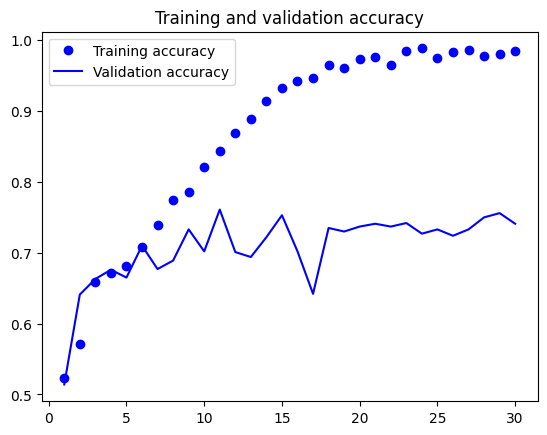

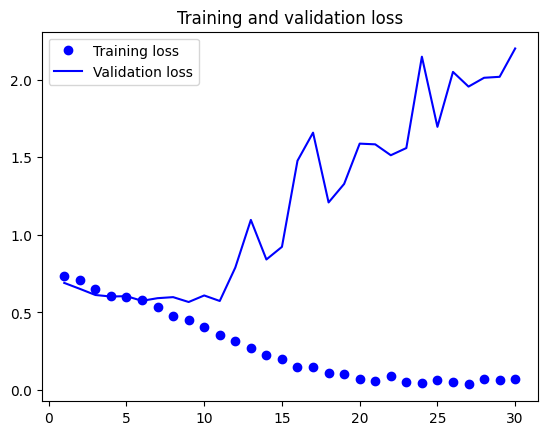

In [10]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

We can see overfitting around epoch 12

**Evaluating the model on the test set**

In [14]:
test_model = keras.models.load_model("./models/convnet_from_scratch.h5")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 1s 20ms/step - loss: 0.5859 - accuracy: 0.7330
Test accuracy: 0.733


### Using data augmentation

In [15]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

**Displaying some randomly augmented training images**

2024-12-06 15:02:44.915383: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:02:45.035276: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:02:45.077659: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:02:45.116655: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:02:45.158095: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:02:45.198931: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

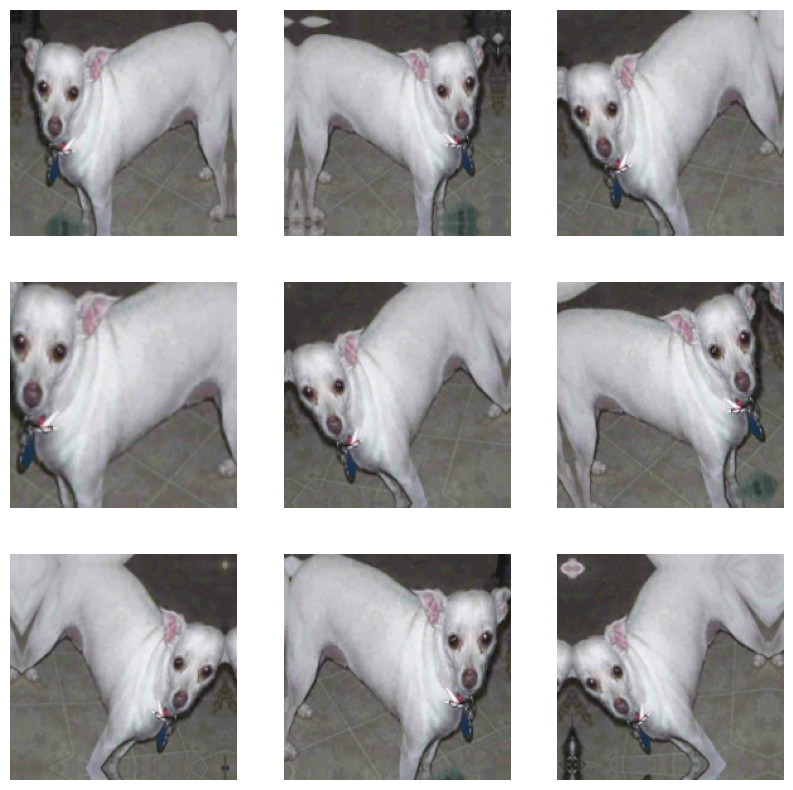

In [16]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

**Defining a new convnet that includes image augmentation and dropout**

Our new model includes two changes compared to the previous one:
1. data augmentation as the first step
2. a dropout layer just before the last layer for regularization

In [17]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [18]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 89, 89, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 87, 87, 64)        18496     
                                                           

### Training the Model for 100 Epochs

In [19]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="./models/convnet_from_scratch_with_augmentation",
        save_best_only=True,
        monitor="val_loss"
    )
]
history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=validation_dataset,
    callbacks=callbacks)



Epoch 1/100


2024-12-06 15:02:57.874850: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 7s - loss: 0.8964 - accuracy: 0.4844  

2024-12-06 15:02:58.222423: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:02:58.343792: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 5s - loss: 0.8611 - accuracy: 0.5312

2024-12-06 15:02:58.444260: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:02:58.532833: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:02:58.617517: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 5s - loss: 0.7990 - accuracy: 0.4961

2024-12-06 15:02:58.701550: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:02:58.790560: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:02:58.874200: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 4s - loss: 0.7777 - accuracy: 0.5057

2024-12-06 15:02:58.958523: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:02:59.044153: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:02:59.126685: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 4s - loss: 0.7597 - accuracy: 0.5067

2024-12-06 15:02:59.210085: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:02:59.295648: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:02:59.379877: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 4s - loss: 0.7488 - accuracy: 0.4945

2024-12-06 15:02:59.463218: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:02:59.547584: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:02:59.633334: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 3s - loss: 0.7404 - accuracy: 0.4984

2024-12-06 15:02:59.729439: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:02:59.816618: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:02:59.904826: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 3s - loss: 0.7342 - accuracy: 0.4973

2024-12-06 15:02:59.990804: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:00.079160: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:00.163889: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 3s - loss: 0.7305 - accuracy: 0.5024

2024-12-06 15:03:00.249296: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:00.338134: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:00.424339: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 3s - loss: 0.7266 - accuracy: 0.5065

2024-12-06 15:03:00.554085: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:00.656367: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:00.742099: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 2s - loss: 0.7233 - accuracy: 0.5059

2024-12-06 15:03:00.828582: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:00.914085: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:01.001096: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 2s - loss: 0.7208 - accuracy: 0.5045

2024-12-06 15:03:01.089235: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:01.174929: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:01.261382: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 2s - loss: 0.7185 - accuracy: 0.5049

2024-12-06 15:03:01.346053: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:01.431734: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:01.515758: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 1s - loss: 0.7194 - accuracy: 0.5114

2024-12-06 15:03:01.606109: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:01.691665: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:01.776155: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 1s - loss: 0.7190 - accuracy: 0.5071

2024-12-06 15:03:01.863698: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:01.954252: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:02.039862: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 1s - loss: 0.7180 - accuracy: 0.5066

2024-12-06 15:03:02.124966: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:02.217394: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:02.303038: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 1s - loss: 0.7172 - accuracy: 0.5069

2024-12-06 15:03:02.390037: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:02.476159: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:02.562373: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 0s - loss: 0.7159 - accuracy: 0.5053

2024-12-06 15:03:02.647106: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:02.737171: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:02.822696: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 0s - loss: 0.7146 - accuracy: 0.5056

2024-12-06 15:03:02.907448: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:02.991708: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:03.074183: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 0s - loss: 0.7144 - accuracy: 0.5053

2024-12-06 15:03:03.157886: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:03.241682: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:03.324326: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.7134 - accuracy: 0.5066

2024-12-06 15:03:03.407834: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:03.493001: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:03.575942: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.7132 - accuracy: 0.5075INFO:tensorflow:Assets written to: ./models/convnet_from_scratch_with_augmentation/assets


INFO:tensorflow:Assets written to: ./models/convnet_from_scratch_with_augmentation/assets


63/63 [==============================] - 9s 125ms/step - loss: 0.7132 - accuracy: 0.5075 - val_loss: 0.6920 - val_accuracy: 0.5010
Epoch 2/100


2024-12-06 15:03:05.991135: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 11s - loss: 0.6958 - accuracy: 0.4688

2024-12-06 15:03:06.175464: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 5s - loss: 0.6934 - accuracy: 0.4792

2024-12-06 15:03:06.271160: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:06.359850: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 5s - loss: 0.6940 - accuracy: 0.4531

2024-12-06 15:03:06.447141: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 5s - loss: 0.6931 - accuracy: 0.4740

2024-12-06 15:03:06.534784: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:06.624504: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 5s - loss: 0.6920 - accuracy: 0.4866

2024-12-06 15:03:06.712200: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 4s - loss: 0.6957 - accuracy: 0.4792

2024-12-06 15:03:06.799616: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:06.890241: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 4s - loss: 0.6956 - accuracy: 0.4844

2024-12-06 15:03:06.976972: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 4s - loss: 0.6972 - accuracy: 0.4870

2024-12-06 15:03:07.064939: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:07.156375: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 4s - loss: 0.6969 - accuracy: 0.4856

2024-12-06 15:03:07.246461: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 4s - loss: 0.6965 - accuracy: 0.4854

2024-12-06 15:03:07.340250: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:07.428437: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 4s - loss: 0.6960 - accuracy: 0.5000

2024-12-06 15:03:07.518331: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 4s - loss: 0.6953 - accuracy: 0.5069

2024-12-06 15:03:07.608519: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:07.697338: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 3s - loss: 0.6951 - accuracy: 0.5066

2024-12-06 15:03:07.786238: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 3s - loss: 0.6946 - accuracy: 0.5074

2024-12-06 15:03:07.890243: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:07.980925: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 3s - loss: 0.6944 - accuracy: 0.5057

2024-12-06 15:03:08.071352: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 3s - loss: 0.6938 - accuracy: 0.5095

2024-12-06 15:03:08.162224: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 3s - loss: 0.6935 - accuracy: 0.5104

2024-12-06 15:03:08.279749: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 3s - loss: 0.6937 - accuracy: 0.5000

2024-12-06 15:03:08.381925: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:08.470861: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 3s - loss: 0.6936 - accuracy: 0.4977

2024-12-06 15:03:08.556418: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 3s - loss: 0.6936 - accuracy: 0.4946

2024-12-06 15:03:08.640992: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:08.726801: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 3s - loss: 0.6943 - accuracy: 0.4896

2024-12-06 15:03:08.814800: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 2s - loss: 0.6940 - accuracy: 0.4951

2024-12-06 15:03:08.908828: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:09.000789: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 2s - loss: 0.6933 - accuracy: 0.4991

2024-12-06 15:03:09.092935: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 2s - loss: 0.6968 - accuracy: 0.5000

2024-12-06 15:03:09.182400: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:09.274202: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 2s - loss: 0.6967 - accuracy: 0.5017

2024-12-06 15:03:09.363426: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 2s - loss: 0.6964 - accuracy: 0.5041

2024-12-06 15:03:09.456840: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:09.546534: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 2s - loss: 0.6962 - accuracy: 0.5040

2024-12-06 15:03:09.632437: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 1s - loss: 0.6963 - accuracy: 0.5076

2024-12-06 15:03:09.718347: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:09.806078: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 1s - loss: 0.6966 - accuracy: 0.5045

2024-12-06 15:03:09.896086: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 1s - loss: 0.6963 - accuracy: 0.5057

2024-12-06 15:03:09.985251: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:10.071833: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 1s - loss: 0.6962 - accuracy: 0.5056

2024-12-06 15:03:10.157317: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 1s - loss: 0.6959 - accuracy: 0.5060

2024-12-06 15:03:10.243892: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:10.328243: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 1s - loss: 0.6958 - accuracy: 0.5033

2024-12-06 15:03:10.412474: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 1s - loss: 0.6957 - accuracy: 0.5032

2024-12-06 15:03:10.561442: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 1s - loss: 0.6958 - accuracy: 0.5031

2024-12-06 15:03:10.648397: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:10.739180: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 1s - loss: 0.6957 - accuracy: 0.5030

2024-12-06 15:03:10.826939: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 0s - loss: 0.6955 - accuracy: 0.5064

2024-12-06 15:03:10.938538: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:11.022791: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 0s - loss: 0.6952 - accuracy: 0.5091

2024-12-06 15:03:11.108295: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 0s - loss: 0.6949 - accuracy: 0.5121

2024-12-06 15:03:11.194951: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:11.280902: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 0s - loss: 0.6944 - accuracy: 0.5129

2024-12-06 15:03:11.366074: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 0.6968 - accuracy: 0.5104

2024-12-06 15:03:11.453351: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:11.539204: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.6967 - accuracy: 0.5118

2024-12-06 15:03:11.624154: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.6966 - accuracy: 0.5105

2024-12-06 15:03:11.708553: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


INFO:tensorflow:Assets written to: ./models/convnet_from_scratch_with_augmentation/assets


INFO:tensorflow:Assets written to: ./models/convnet_from_scratch_with_augmentation/assets


63/63 [==============================] - 8s 120ms/step - loss: 0.6966 - accuracy: 0.5105 - val_loss: 0.6911 - val_accuracy: 0.5360
Epoch 3/100


2024-12-06 15:03:13.640536: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 11s - loss: 0.6946 - accuracy: 0.4062

2024-12-06 15:03:13.831674: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 5s - loss: 0.6921 - accuracy: 0.4688

2024-12-06 15:03:13.925447: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:14.011625: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 5s - loss: 0.6912 - accuracy: 0.4688

2024-12-06 15:03:14.098949: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 5s - loss: 0.6898 - accuracy: 0.4948

2024-12-06 15:03:14.189024: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:14.275478: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 4s - loss: 0.6889 - accuracy: 0.4911

2024-12-06 15:03:14.363205: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 4s - loss: 0.6897 - accuracy: 0.5035

2024-12-06 15:03:14.451432: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:14.539483: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 4s - loss: 0.6891 - accuracy: 0.5063

2024-12-06 15:03:14.624687: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 4s - loss: 0.6906 - accuracy: 0.5000

2024-12-06 15:03:14.710879: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:14.795899: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 4s - loss: 0.6905 - accuracy: 0.4976

2024-12-06 15:03:14.884400: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 4s - loss: 0.6899 - accuracy: 0.5000

2024-12-06 15:03:14.973037: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:15.060518: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 4s - loss: 0.6873 - accuracy: 0.5078

2024-12-06 15:03:15.146144: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 3s - loss: 0.6879 - accuracy: 0.5069

2024-12-06 15:03:15.242089: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:15.331821: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 3s - loss: 0.6877 - accuracy: 0.5066

2024-12-06 15:03:15.418193: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 3s - loss: 0.6850 - accuracy: 0.5223

2024-12-06 15:03:15.506383: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:15.592189: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 3s - loss: 0.6822 - accuracy: 0.5284

2024-12-06 15:03:15.677299: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 3s - loss: 0.6799 - accuracy: 0.5312

2024-12-06 15:03:15.806044: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 3s - loss: 0.8123 - accuracy: 0.5200

2024-12-06 15:03:15.907122: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:15.993854: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 3s - loss: 0.8071 - accuracy: 0.5288

2024-12-06 15:03:16.079553: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 3s - loss: 0.7975 - accuracy: 0.5402

2024-12-06 15:03:16.166205: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:16.252098: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 3s - loss: 0.7920 - accuracy: 0.5463

2024-12-06 15:03:16.338044: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 2s - loss: 0.7865 - accuracy: 0.5474

2024-12-06 15:03:16.422384: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:16.507516: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 2s - loss: 0.7828 - accuracy: 0.5479

2024-12-06 15:03:16.593649: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 2s - loss: 0.7777 - accuracy: 0.5496

2024-12-06 15:03:16.679332: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:16.764401: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 2s - loss: 0.7740 - accuracy: 0.5545

2024-12-06 15:03:16.851212: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 2s - loss: 0.7688 - accuracy: 0.5549

2024-12-06 15:03:16.940199: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:17.025996: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 2s - loss: 0.7663 - accuracy: 0.5567

2024-12-06 15:03:17.110596: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 2s - loss: 0.7624 - accuracy: 0.5562

2024-12-06 15:03:17.198336: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:17.284016: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 1s - loss: 0.7607 - accuracy: 0.5564

2024-12-06 15:03:17.371157: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 1s - loss: 0.7558 - accuracy: 0.5589

2024-12-06 15:03:17.458904: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:17.546211: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 1s - loss: 0.7546 - accuracy: 0.5582

2024-12-06 15:03:17.630281: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 1s - loss: 0.7504 - accuracy: 0.5618

2024-12-06 15:03:17.717662: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:17.809700: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 1s - loss: 0.7492 - accuracy: 0.5605

2024-12-06 15:03:17.895236: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 1s - loss: 0.7434 - accuracy: 0.5663

2024-12-06 15:03:17.981396: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:18.069305: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 0s - loss: 0.7445 - accuracy: 0.5631

2024-12-06 15:03:18.213626: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:18.297513: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:18.380653: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 0s - loss: 0.7407 - accuracy: 0.5631

2024-12-06 15:03:18.464983: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:18.549337: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:18.630183: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 0s - loss: 0.7376 - accuracy: 0.5647

2024-12-06 15:03:18.711417: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:18.795751: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:18.876906: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.7340 - accuracy: 0.5645

2024-12-06 15:03:18.959337: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:19.042962: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:19.125132: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.7324 - accuracy: 0.5660

2024-12-06 15:03:19.206185: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


INFO:tensorflow:Assets written to: ./models/convnet_from_scratch_with_augmentation/assets


INFO:tensorflow:Assets written to: ./models/convnet_from_scratch_with_augmentation/assets


63/63 [==============================] - 7s 115ms/step - loss: 0.7324 - accuracy: 0.5660 - val_loss: 0.6879 - val_accuracy: 0.5170
Epoch 4/100


2024-12-06 15:03:20.983994: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 10s - loss: 0.6872 - accuracy: 0.5312

2024-12-06 15:03:21.162382: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 5s - loss: 0.7185 - accuracy: 0.4896

2024-12-06 15:03:21.256802: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:21.346035: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 5s - loss: 0.7040 - accuracy: 0.5391

2024-12-06 15:03:21.431424: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 5s - loss: 0.7008 - accuracy: 0.5469

2024-12-06 15:03:21.518741: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:21.605434: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 4s - loss: 0.6928 - accuracy: 0.5714

2024-12-06 15:03:21.690314: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 4s - loss: 0.6924 - accuracy: 0.5694

2024-12-06 15:03:21.779404: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:21.867248: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 4s - loss: 0.6847 - accuracy: 0.5844

2024-12-06 15:03:21.952998: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 4s - loss: 0.6779 - accuracy: 0.5885

2024-12-06 15:03:22.041495: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:22.130236: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 4s - loss: 0.6780 - accuracy: 0.5938

2024-12-06 15:03:22.218680: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 4s - loss: 0.6733 - accuracy: 0.5938

2024-12-06 15:03:22.314565: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:22.404397: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 4s - loss: 0.6683 - accuracy: 0.6055

2024-12-06 15:03:22.492985: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 3s - loss: 0.6812 - accuracy: 0.5955

2024-12-06 15:03:22.581419: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:22.667169: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 3s - loss: 0.6842 - accuracy: 0.5921

2024-12-06 15:03:22.756381: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 3s - loss: 0.6827 - accuracy: 0.5923

2024-12-06 15:03:22.844796: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:22.932012: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 3s - loss: 0.6832 - accuracy: 0.5846

2024-12-06 15:03:23.069172: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:23.164875: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:23.250020: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 3s - loss: 0.6807 - accuracy: 0.5845

2024-12-06 15:03:23.339110: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:23.424637: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:23.511306: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 2s - loss: 0.6777 - accuracy: 0.5906

2024-12-06 15:03:23.595293: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:23.684164: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:23.773200: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 2s - loss: 0.6773 - accuracy: 0.5890

2024-12-06 15:03:23.862370: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:23.957200: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:24.044971: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 2s - loss: 0.6756 - accuracy: 0.5929

2024-12-06 15:03:24.131788: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:24.220894: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:24.309159: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 2s - loss: 0.6761 - accuracy: 0.5873

2024-12-06 15:03:24.396897: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:24.483624: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:24.573146: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 1s - loss: 0.6773 - accuracy: 0.5915

2024-12-06 15:03:24.660957: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:24.748936: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:24.836660: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 1s - loss: 0.6764 - accuracy: 0.5944

2024-12-06 15:03:24.926110: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:25.014402: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:25.100162: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 1s - loss: 0.6744 - accuracy: 0.5911

2024-12-06 15:03:25.189945: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:25.278901: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:25.366461: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 1s - loss: 0.6759 - accuracy: 0.5882

2024-12-06 15:03:25.457440: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:25.545459: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:25.630369: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 0s - loss: 0.6881 - accuracy: 0.5914

2024-12-06 15:03:25.717064: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:25.808377: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:25.891054: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 0s - loss: 0.6870 - accuracy: 0.5927

2024-12-06 15:03:25.988517: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:26.082329: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:26.165433: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 0.6859 - accuracy: 0.5932

2024-12-06 15:03:26.248285: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:26.333518: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:26.416644: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.6845 - accuracy: 0.5960

2024-12-06 15:03:26.498885: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:26.583513: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


INFO:tensorflow:Assets written to: ./models/convnet_from_scratch_with_augmentation/assets


INFO:tensorflow:Assets written to: ./models/convnet_from_scratch_with_augmentation/assets


63/63 [==============================] - 8s 121ms/step - loss: 0.6845 - accuracy: 0.5960 - val_loss: 0.6267 - val_accuracy: 0.6620
Epoch 5/100


2024-12-06 15:03:28.654681: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 5s - loss: 0.7589 - accuracy: 0.6042

2024-12-06 15:03:28.856115: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:28.950508: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:29.041482: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 5s - loss: 0.7440 - accuracy: 0.6198

2024-12-06 15:03:29.135003: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:29.227676: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:29.316515: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 4s - loss: 0.7071 - accuracy: 0.6250

2024-12-06 15:03:29.404829: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:29.491842: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:29.582263: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 4s - loss: 0.6940 - accuracy: 0.6328

2024-12-06 15:03:29.675604: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:29.765905: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:29.853108: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 4s - loss: 0.6766 - accuracy: 0.6438

2024-12-06 15:03:29.940694: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:30.028613: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:30.114595: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 4s - loss: 0.6722 - accuracy: 0.6406

2024-12-06 15:03:30.201199: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:30.288490: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:30.371185: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 3s - loss: 0.6695 - accuracy: 0.6369

2024-12-06 15:03:30.455242: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:30.540355: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:30.627620: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 3s - loss: 0.6574 - accuracy: 0.6406

2024-12-06 15:03:30.714594: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:30.805503: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:30.889182: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 3s - loss: 0.6546 - accuracy: 0.6447

2024-12-06 15:03:31.005677: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:31.106143: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:31.190369: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 2s - loss: 0.6925 - accuracy: 0.6219

2024-12-06 15:03:31.276483: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:31.380178: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:31.463755: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 2s - loss: 0.6925 - accuracy: 0.6098

2024-12-06 15:03:31.550714: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:31.637547: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:31.724086: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 2s - loss: 0.6901 - accuracy: 0.6059

2024-12-06 15:03:31.811191: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:31.896847: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:31.979762: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 2s - loss: 0.6887 - accuracy: 0.6058

2024-12-06 15:03:32.062975: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:32.147472: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:32.232348: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 1s - loss: 0.6870 - accuracy: 0.6049

2024-12-06 15:03:32.318303: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:32.404668: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:32.489639: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 1s - loss: 0.6887 - accuracy: 0.6007

2024-12-06 15:03:32.574091: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:32.659454: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:32.744034: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 1s - loss: 0.6863 - accuracy: 0.6042

2024-12-06 15:03:32.828780: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:32.915911: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:32.999918: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 1s - loss: 0.6811 - accuracy: 0.6042

2024-12-06 15:03:33.085749: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:33.171785: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:33.255325: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 0s - loss: 0.6790 - accuracy: 0.6047

2024-12-06 15:03:33.340508: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:33.424554: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:33.505702: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 0s - loss: 0.6825 - accuracy: 0.6053

2024-12-06 15:03:33.586335: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:33.667570: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:33.748697: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 0.6805 - accuracy: 0.6073

2024-12-06 15:03:33.829346: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:33.910486: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:33.992333: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.6785 - accuracy: 0.6094

2024-12-06 15:03:34.073519: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:34.153830: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 6s 96ms/step - loss: 0.6781 - accuracy: 0.6085 - val_loss: 0.8209 - val_accuracy: 0.5300
Epoch 6/100
 1/63 [..............................] - ETA: 8s - loss: 0.8486 - accuracy: 0.4375

2024-12-06 15:03:34.784898: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:34.926327: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 4s - loss: 0.7046 - accuracy: 0.6172

2024-12-06 15:03:35.010710: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:35.095337: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:35.178724: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 4s - loss: 0.6958 - accuracy: 0.5536

2024-12-06 15:03:35.262344: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:35.347144: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:35.430956: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 4s - loss: 0.6741 - accuracy: 0.5906

2024-12-06 15:03:35.513679: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:35.597790: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:35.682963: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 4s - loss: 0.6722 - accuracy: 0.6058

2024-12-06 15:03:35.811445: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:35.895860: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:35.980116: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 4s - loss: 0.6615 - accuracy: 0.6074

2024-12-06 15:03:36.073427: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:36.165645: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:36.256544: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 3s - loss: 0.6529 - accuracy: 0.6217

2024-12-06 15:03:36.345890: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:36.430434: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:36.513936: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 3s - loss: 0.6429 - accuracy: 0.6349

2024-12-06 15:03:36.597880: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:36.691062: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:36.789518: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 3s - loss: 0.6386 - accuracy: 0.6375

2024-12-06 15:03:36.878290: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:36.963038: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:37.050368: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 3s - loss: 0.6418 - accuracy: 0.6328

2024-12-06 15:03:37.134101: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:37.218939: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:37.301433: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 2s - loss: 0.6362 - accuracy: 0.6431

2024-12-06 15:03:37.385416: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:37.470440: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:37.553851: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 2s - loss: 0.6369 - accuracy: 0.6406

2024-12-06 15:03:37.637684: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:37.720856: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:37.806638: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 2s - loss: 0.6330 - accuracy: 0.6436

2024-12-06 15:03:37.889688: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:37.974343: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:38.058208: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 1s - loss: 0.6351 - accuracy: 0.6406

2024-12-06 15:03:38.141759: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:38.227354: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:38.312374: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 1s - loss: 0.6348 - accuracy: 0.6439

2024-12-06 15:03:38.397015: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:38.481320: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:38.563490: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 1s - loss: 0.6376 - accuracy: 0.6420

2024-12-06 15:03:38.646727: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:38.729807: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:38.812520: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 1s - loss: 0.6396 - accuracy: 0.6409

2024-12-06 15:03:38.895466: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:38.978537: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:39.060851: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 0s - loss: 0.6375 - accuracy: 0.6454

2024-12-06 15:03:39.144072: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:39.227973: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:39.311363: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 0s - loss: 0.6350 - accuracy: 0.6483

2024-12-06 15:03:39.394519: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:39.475415: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:39.557194: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 0s - loss: 0.6364 - accuracy: 0.6482

2024-12-06 15:03:39.638305: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:39.719398: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:39.800484: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.6366 - accuracy: 0.6465

2024-12-06 15:03:39.882002: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:39.961994: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:40.041633: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.6381 - accuracy: 0.6442

2024-12-06 15:03:40.122669: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


INFO:tensorflow:Assets written to: ./models/convnet_from_scratch_with_augmentation/assets


INFO:tensorflow:Assets written to: ./models/convnet_from_scratch_with_augmentation/assets


63/63 [==============================] - 7s 115ms/step - loss: 0.6380 - accuracy: 0.6450 - val_loss: 0.6257 - val_accuracy: 0.6470
Epoch 7/100


2024-12-06 15:03:42.061256: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 11s - loss: 0.5920 - accuracy: 0.5625

2024-12-06 15:03:42.242913: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 5s - loss: 0.6419 - accuracy: 0.5729

2024-12-06 15:03:42.334935: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:42.418868: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 5s - loss: 0.6267 - accuracy: 0.5938

2024-12-06 15:03:42.505129: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 4s - loss: 0.6286 - accuracy: 0.5885

2024-12-06 15:03:42.589107: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:42.672491: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 4s - loss: 0.6477 - accuracy: 0.5714

2024-12-06 15:03:42.755952: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 4s - loss: 0.6463 - accuracy: 0.5903

2024-12-06 15:03:42.840905: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:42.926590: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 4s - loss: 0.6465 - accuracy: 0.5906

2024-12-06 15:03:43.010417: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 4s - loss: 0.6438 - accuracy: 0.6198

2024-12-06 15:03:43.094704: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:43.180061: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 4s - loss: 0.6386 - accuracy: 0.6322

2024-12-06 15:03:43.267483: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 4s - loss: 0.6329 - accuracy: 0.6354

2024-12-06 15:03:43.354181: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:43.438649: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 4s - loss: 0.6421 - accuracy: 0.6289

2024-12-06 15:03:43.522678: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 3s - loss: 0.6340 - accuracy: 0.6337

2024-12-06 15:03:43.610556: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:43.693906: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 3s - loss: 0.6288 - accuracy: 0.6365

2024-12-06 15:03:43.779542: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 3s - loss: 0.6505 - accuracy: 0.6310

2024-12-06 15:03:43.863605: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:43.948096: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 3s - loss: 0.6539 - accuracy: 0.6349

2024-12-06 15:03:44.031205: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 3s - loss: 0.6520 - accuracy: 0.6328

2024-12-06 15:03:44.115790: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:44.200086: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 3s - loss: 0.6519 - accuracy: 0.6400

2024-12-06 15:03:44.286000: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 3s - loss: 0.6530 - accuracy: 0.6366

2024-12-06 15:03:44.369443: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:44.455622: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 2s - loss: 0.6495 - accuracy: 0.6429

2024-12-06 15:03:44.539046: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 2s - loss: 0.6433 - accuracy: 0.6469

2024-12-06 15:03:44.624048: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:44.707561: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 2s - loss: 0.6419 - accuracy: 0.6472

2024-12-06 15:03:44.791468: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 2s - loss: 0.6439 - accuracy: 0.6477

2024-12-06 15:03:44.876401: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:44.961085: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 2s - loss: 0.6439 - accuracy: 0.6471

2024-12-06 15:03:45.044058: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 2s - loss: 0.6428 - accuracy: 0.6450

2024-12-06 15:03:45.128836: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:45.212649: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 2s - loss: 0.6413 - accuracy: 0.6436

2024-12-06 15:03:45.296750: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 2s - loss: 0.6410 - accuracy: 0.6450

2024-12-06 15:03:45.381902: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:45.465572: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 1s - loss: 0.6368 - accuracy: 0.6500

2024-12-06 15:03:45.549736: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 1s - loss: 0.6349 - accuracy: 0.6496

2024-12-06 15:03:45.633860: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:45.718814: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 1s - loss: 0.6364 - accuracy: 0.6468

2024-12-06 15:03:45.802377: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 1s - loss: 0.6381 - accuracy: 0.6449

2024-12-06 15:03:45.952765: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 1s - loss: 0.6383 - accuracy: 0.6427

2024-12-06 15:03:46.039438: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:46.124336: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 1s - loss: 0.6374 - accuracy: 0.6443

2024-12-06 15:03:46.208424: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 1s - loss: 0.6394 - accuracy: 0.6416

2024-12-06 15:03:46.294374: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:46.379614: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 1s - loss: 0.6372 - accuracy: 0.6425

2024-12-06 15:03:46.463929: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 0s - loss: 0.6366 - accuracy: 0.6412

2024-12-06 15:03:46.549029: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:46.634796: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 0s - loss: 0.6358 - accuracy: 0.6427

2024-12-06 15:03:46.718582: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 0s - loss: 0.6337 - accuracy: 0.6449

2024-12-06 15:03:46.801456: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:46.882787: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 0s - loss: 0.6329 - accuracy: 0.6456

2024-12-06 15:03:46.963728: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 0s - loss: 0.6308 - accuracy: 0.6476

2024-12-06 15:03:47.045241: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:47.125832: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 0s - loss: 0.6297 - accuracy: 0.6478

2024-12-06 15:03:47.207127: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.6330 - accuracy: 0.6486

2024-12-06 15:03:47.289329: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:47.369865: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.6331 - accuracy: 0.6487

2024-12-06 15:03:47.449601: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


INFO:tensorflow:Assets written to: ./models/convnet_from_scratch_with_augmentation/assets


INFO:tensorflow:Assets written to: ./models/convnet_from_scratch_with_augmentation/assets


63/63 [==============================] - 7s 116ms/step - loss: 0.6323 - accuracy: 0.6490 - val_loss: 0.6050 - val_accuracy: 0.6580
Epoch 8/100


2024-12-06 15:03:49.407539: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 9s - loss: 0.6249 - accuracy: 0.6562

2024-12-06 15:03:49.569167: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 5s - loss: 0.5901 - accuracy: 0.6875

2024-12-06 15:03:49.661246: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:49.745062: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 5s - loss: 0.6057 - accuracy: 0.6797

2024-12-06 15:03:49.829153: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 4s - loss: 0.5986 - accuracy: 0.6719

2024-12-06 15:03:49.915281: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:49.997815: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 4s - loss: 0.6185 - accuracy: 0.6652

2024-12-06 15:03:50.082122: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 4s - loss: 0.6141 - accuracy: 0.6736

2024-12-06 15:03:50.167247: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:50.250703: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 4s - loss: 0.6159 - accuracy: 0.6625

2024-12-06 15:03:50.333502: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 4s - loss: 0.6242 - accuracy: 0.6432

2024-12-06 15:03:50.416804: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:50.500261: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 4s - loss: 0.6207 - accuracy: 0.6587

2024-12-06 15:03:50.586306: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 4s - loss: 0.6137 - accuracy: 0.6562

2024-12-06 15:03:50.669895: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:50.753585: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 3s - loss: 0.6136 - accuracy: 0.6602

2024-12-06 15:03:50.838500: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 3s - loss: 0.6236 - accuracy: 0.6719

2024-12-06 15:03:50.924091: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:51.009466: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 3s - loss: 0.6209 - accuracy: 0.6793

2024-12-06 15:03:51.093037: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 3s - loss: 0.6092 - accuracy: 0.6845

2024-12-06 15:03:51.179513: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:51.264132: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 3s - loss: 0.6067 - accuracy: 0.6818

2024-12-06 15:03:51.345893: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 3s - loss: 0.6055 - accuracy: 0.6758

2024-12-06 15:03:51.431561: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:51.514629: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 3s - loss: 0.6087 - accuracy: 0.6725

2024-12-06 15:03:51.600523: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 3s - loss: 0.6090 - accuracy: 0.6748

2024-12-06 15:03:51.686391: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:51.770761: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 2s - loss: 0.6036 - accuracy: 0.6775

2024-12-06 15:03:51.853008: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 2s - loss: 0.6015 - accuracy: 0.6781

2024-12-06 15:03:51.937150: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:52.021715: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 2s - loss: 0.5979 - accuracy: 0.6815

2024-12-06 15:03:52.104449: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 2s - loss: 0.6024 - accuracy: 0.6790

2024-12-06 15:03:52.188530: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:52.272566: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 2s - loss: 0.6027 - accuracy: 0.6792

2024-12-06 15:03:52.355012: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 2s - loss: 0.6020 - accuracy: 0.6771

2024-12-06 15:03:52.441047: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:52.526378: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 2s - loss: 0.6015 - accuracy: 0.6757

2024-12-06 15:03:52.608731: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 2s - loss: 0.6066 - accuracy: 0.6694

2024-12-06 15:03:52.692010: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 2s - loss: 0.6057 - accuracy: 0.6691

2024-12-06 15:03:52.820533: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 1s - loss: 0.6261 - accuracy: 0.6646

2024-12-06 15:03:52.904102: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:52.990418: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 1s - loss: 0.6260 - accuracy: 0.6667

2024-12-06 15:03:53.073739: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 1s - loss: 0.6251 - accuracy: 0.6641

2024-12-06 15:03:53.157644: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:53.244254: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 1s - loss: 0.6238 - accuracy: 0.6653

2024-12-06 15:03:53.327493: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 1s - loss: 0.6228 - accuracy: 0.6662

2024-12-06 15:03:53.411527: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:53.494077: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 1s - loss: 0.6193 - accuracy: 0.6706

2024-12-06 15:03:53.577112: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 1s - loss: 0.6201 - accuracy: 0.6719

2024-12-06 15:03:53.662055: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:53.745656: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 1s - loss: 0.6195 - accuracy: 0.6716

2024-12-06 15:03:53.829411: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 0s - loss: 0.6155 - accuracy: 0.6757

2024-12-06 15:03:53.912195: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:53.997889: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 0s - loss: 0.6165 - accuracy: 0.6759

2024-12-06 15:03:54.078167: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 0s - loss: 0.6175 - accuracy: 0.6719

2024-12-06 15:03:54.159288: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:54.239685: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 0s - loss: 0.6199 - accuracy: 0.6689

2024-12-06 15:03:54.319747: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 0s - loss: 0.6176 - accuracy: 0.6711

2024-12-06 15:03:54.401102: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:54.483154: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 0.6158 - accuracy: 0.6734

2024-12-06 15:03:54.563987: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.6147 - accuracy: 0.6749

2024-12-06 15:03:54.645682: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:54.728168: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


INFO:tensorflow:Assets written to: ./models/convnet_from_scratch_with_augmentation/assets


INFO:tensorflow:Assets written to: ./models/convnet_from_scratch_with_augmentation/assets


63/63 [==============================] - 7s 114ms/step - loss: 0.6142 - accuracy: 0.6755 - val_loss: 0.5814 - val_accuracy: 0.6890
Epoch 9/100


2024-12-06 15:03:56.648613: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 10s - loss: 0.4422 - accuracy: 0.8750

2024-12-06 15:03:56.816828: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 5s - loss: 0.5379 - accuracy: 0.8229

2024-12-06 15:03:56.907717: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:56.993184: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 5s - loss: 0.5520 - accuracy: 0.7969

2024-12-06 15:03:57.078835: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 4s - loss: 0.5885 - accuracy: 0.7240

2024-12-06 15:03:57.162268: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:57.247292: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 4s - loss: 0.6086 - accuracy: 0.7054

2024-12-06 15:03:57.330375: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 4s - loss: 0.6126 - accuracy: 0.6667

2024-12-06 15:03:57.413531: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:57.498558: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 4s - loss: 0.6145 - accuracy: 0.6594

2024-12-06 15:03:57.581318: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 4s - loss: 0.5974 - accuracy: 0.6771

2024-12-06 15:03:57.664980: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:57.750894: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 4s - loss: 0.6060 - accuracy: 0.6755

2024-12-06 15:03:57.835185: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 4s - loss: 0.6158 - accuracy: 0.6729

2024-12-06 15:03:57.922248: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:58.005414: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 3s - loss: 0.6241 - accuracy: 0.6660

2024-12-06 15:03:58.089144: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 3s - loss: 0.6231 - accuracy: 0.6701

2024-12-06 15:03:58.174687: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:58.260555: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 3s - loss: 0.6256 - accuracy: 0.6678

2024-12-06 15:03:58.344168: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 3s - loss: 0.6222 - accuracy: 0.6726

2024-12-06 15:03:58.429947: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:58.514562: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 3s - loss: 0.6207 - accuracy: 0.6719

2024-12-06 15:03:58.597388: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 3s - loss: 0.6132 - accuracy: 0.6849

2024-12-06 15:03:58.683745: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:58.769259: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 3s - loss: 0.6131 - accuracy: 0.6825

2024-12-06 15:03:58.851800: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 3s - loss: 0.6103 - accuracy: 0.6829

2024-12-06 15:03:58.939170: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:59.022906: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 2s - loss: 0.6112 - accuracy: 0.6842

2024-12-06 15:03:59.107941: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 2s - loss: 0.6136 - accuracy: 0.6812

2024-12-06 15:03:59.191649: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:59.277128: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 2s - loss: 0.6124 - accuracy: 0.6804

2024-12-06 15:03:59.360800: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 2s - loss: 0.6051 - accuracy: 0.6875

2024-12-06 15:03:59.445012: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:59.530000: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 2s - loss: 0.6077 - accuracy: 0.6893

2024-12-06 15:03:59.613771: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 2s - loss: 0.6008 - accuracy: 0.6936

2024-12-06 15:03:59.697232: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:03:59.780343: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 2s - loss: 0.5976 - accuracy: 0.6959

2024-12-06 15:03:59.898093: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 2s - loss: 0.5996 - accuracy: 0.6939

2024-12-06 15:03:59.996654: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:00.082239: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 1s - loss: 0.6001 - accuracy: 0.6930

2024-12-06 15:04:00.166587: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 1s - loss: 0.6019 - accuracy: 0.6912

2024-12-06 15:04:00.250514: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:00.336011: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 1s - loss: 0.6018 - accuracy: 0.6926

2024-12-06 15:04:00.419411: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 1s - loss: 0.5989 - accuracy: 0.6951

2024-12-06 15:04:00.504269: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:00.587192: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 1s - loss: 0.5977 - accuracy: 0.6950

2024-12-06 15:04:00.669891: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 1s - loss: 0.5982 - accuracy: 0.6947

2024-12-06 15:04:00.754077: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:00.836752: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 1s - loss: 0.5976 - accuracy: 0.6952

2024-12-06 15:04:00.921085: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 1s - loss: 0.6024 - accuracy: 0.6942

2024-12-06 15:04:01.005064: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:01.090280: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 0s - loss: 0.6003 - accuracy: 0.6953

2024-12-06 15:04:01.174059: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 0s - loss: 0.6014 - accuracy: 0.6927

2024-12-06 15:04:01.257194: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:01.338749: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 0s - loss: 0.6010 - accuracy: 0.6932

2024-12-06 15:04:01.420909: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 0s - loss: 0.6006 - accuracy: 0.6924

2024-12-06 15:04:01.503236: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:01.584760: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 0s - loss: 0.6000 - accuracy: 0.6923

2024-12-06 15:04:01.666973: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 0.5984 - accuracy: 0.6927

2024-12-06 15:04:01.749837: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:01.830569: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.5961 - accuracy: 0.6936

2024-12-06 15:04:01.911839: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.5953 - accuracy: 0.6930

2024-12-06 15:04:01.992891: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 6s 94ms/step - loss: 0.5941 - accuracy: 0.6940 - val_loss: 0.5863 - val_accuracy: 0.6920
Epoch 10/100
 1/63 [..............................] - ETA: 8s - loss: 0.6661 - accuracy: 0.6562

2024-12-06 15:04:02.629690: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:02.774146: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 4s - loss: 0.6920 - accuracy: 0.5859

2024-12-06 15:04:02.860467: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:02.945327: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:03.029325: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 4s - loss: 0.6353 - accuracy: 0.6339

2024-12-06 15:04:03.114474: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:03.197948: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:03.279891: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 4s - loss: 0.6174 - accuracy: 0.6562

2024-12-06 15:04:03.363016: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:03.446119: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:03.529496: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 4s - loss: 0.6142 - accuracy: 0.6587

2024-12-06 15:04:03.614327: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:03.700849: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:03.784056: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 3s - loss: 0.6073 - accuracy: 0.6680

2024-12-06 15:04:03.868097: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:03.953466: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:04.035777: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 3s - loss: 0.5968 - accuracy: 0.6753

2024-12-06 15:04:04.118832: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:04.267191: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 3s - loss: 0.5901 - accuracy: 0.6860

2024-12-06 15:04:04.350582: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:04.436410: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:04.519461: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 3s - loss: 0.5867 - accuracy: 0.6888

2024-12-06 15:04:04.602805: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:04.687501: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:04.770021: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 3s - loss: 0.5905 - accuracy: 0.6898

2024-12-06 15:04:04.854776: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:04.938115: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:05.021037: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 2s - loss: 0.5904 - accuracy: 0.6969

2024-12-06 15:04:05.105596: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:05.191261: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:05.274256: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 2s - loss: 0.6012 - accuracy: 0.6875

2024-12-06 15:04:05.357784: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:05.444537: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:05.527888: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 2s - loss: 0.5949 - accuracy: 0.6944

2024-12-06 15:04:05.610206: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:05.695751: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:05.778334: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 2s - loss: 0.5978 - accuracy: 0.6883

2024-12-06 15:04:05.861106: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:05.947603: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:06.032504: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 1s - loss: 0.5980 - accuracy: 0.6868

2024-12-06 15:04:06.116469: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:06.202448: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:06.284116: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 1s - loss: 0.5996 - accuracy: 0.6819

2024-12-06 15:04:06.367994: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:06.453796: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:06.538922: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 1s - loss: 0.6007 - accuracy: 0.6797

2024-12-06 15:04:06.621536: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:06.704538: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:06.787369: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 1s - loss: 0.5992 - accuracy: 0.6789

2024-12-06 15:04:06.870069: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:06.954406: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:07.037791: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 0s - loss: 0.5971 - accuracy: 0.6806

2024-12-06 15:04:07.120961: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:07.205466: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:07.284845: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 0s - loss: 0.5941 - accuracy: 0.6837

2024-12-06 15:04:07.365730: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:07.446923: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:07.527179: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 0.5967 - accuracy: 0.6839

2024-12-06 15:04:07.608545: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:07.690213: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:07.770602: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.5985 - accuracy: 0.6825

2024-12-06 15:04:07.851192: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:07.932146: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


INFO:tensorflow:Assets written to: ./models/convnet_from_scratch_with_augmentation/assets


INFO:tensorflow:Assets written to: ./models/convnet_from_scratch_with_augmentation/assets


63/63 [==============================] - 7s 115ms/step - loss: 0.5977 - accuracy: 0.6830 - val_loss: 0.5673 - val_accuracy: 0.7010
Epoch 11/100


2024-12-06 15:04:09.910716: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 9s - loss: 0.5124 - accuracy: 0.7500

2024-12-06 15:04:10.068772: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 5s - loss: 0.5051 - accuracy: 0.8021

2024-12-06 15:04:10.152471: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:10.237001: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 4s - loss: 0.5391 - accuracy: 0.7422

2024-12-06 15:04:10.320714: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 4s - loss: 0.5417 - accuracy: 0.7344

2024-12-06 15:04:10.404366: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:10.488905: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 4s - loss: 0.5479 - accuracy: 0.7321

2024-12-06 15:04:10.572720: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 4s - loss: 0.5437 - accuracy: 0.7361

2024-12-06 15:04:10.658770: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:10.743232: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 4s - loss: 0.5565 - accuracy: 0.7281

2024-12-06 15:04:10.826157: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 4s - loss: 0.5673 - accuracy: 0.7109

2024-12-06 15:04:10.911482: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:10.996173: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 4s - loss: 0.5667 - accuracy: 0.7188

2024-12-06 15:04:11.080839: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 4s - loss: 0.5715 - accuracy: 0.7208

2024-12-06 15:04:11.169636: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:11.253747: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 3s - loss: 0.5765 - accuracy: 0.7188

2024-12-06 15:04:11.338719: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 3s - loss: 0.5683 - accuracy: 0.7257

2024-12-06 15:04:11.425156: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:11.511513: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 3s - loss: 0.5726 - accuracy: 0.7204

2024-12-06 15:04:11.594524: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 3s - loss: 0.5718 - accuracy: 0.7217

2024-12-06 15:04:11.679872: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:11.763689: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 3s - loss: 0.5711 - accuracy: 0.7230

2024-12-06 15:04:11.846261: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 3s - loss: 0.5667 - accuracy: 0.7253

2024-12-06 15:04:11.931003: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:12.019704: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 3s - loss: 0.5604 - accuracy: 0.7300

2024-12-06 15:04:12.104033: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 3s - loss: 0.5711 - accuracy: 0.7280

2024-12-06 15:04:12.187824: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:12.277656: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 2s - loss: 0.5738 - accuracy: 0.7254

2024-12-06 15:04:12.361244: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 2s - loss: 0.5691 - accuracy: 0.7260

2024-12-06 15:04:12.446196: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:12.530054: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 2s - loss: 0.5708 - accuracy: 0.7248

2024-12-06 15:04:12.613303: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 2s - loss: 0.5757 - accuracy: 0.7188

2024-12-06 15:04:12.733683: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 2s - loss: 0.5700 - accuracy: 0.7206

2024-12-06 15:04:12.838609: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:12.923175: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 2s - loss: 0.5735 - accuracy: 0.7196

2024-12-06 15:04:13.007218: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 2s - loss: 0.5772 - accuracy: 0.7145

2024-12-06 15:04:13.091751: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:13.178029: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 2s - loss: 0.5809 - accuracy: 0.7097

2024-12-06 15:04:13.264873: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 1s - loss: 0.5785 - accuracy: 0.7125

2024-12-06 15:04:13.348768: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:13.431997: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 1s - loss: 0.5824 - accuracy: 0.7119

2024-12-06 15:04:13.515800: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 1s - loss: 0.5831 - accuracy: 0.7137

2024-12-06 15:04:13.599396: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:13.685749: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 1s - loss: 0.5822 - accuracy: 0.7131

2024-12-06 15:04:13.769479: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 1s - loss: 0.5823 - accuracy: 0.7106

2024-12-06 15:04:13.854834: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:13.941701: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 1s - loss: 0.5823 - accuracy: 0.7094

2024-12-06 15:04:14.023918: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 1s - loss: 0.5849 - accuracy: 0.7073

2024-12-06 15:04:14.106751: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:14.191395: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 1s - loss: 0.5839 - accuracy: 0.7081

2024-12-06 15:04:14.275887: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 0s - loss: 0.5813 - accuracy: 0.7091

2024-12-06 15:04:14.361444: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:14.450535: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 0s - loss: 0.5800 - accuracy: 0.7105

2024-12-06 15:04:14.534686: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 0s - loss: 0.5883 - accuracy: 0.7023

2024-12-06 15:04:14.616365: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:14.697557: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 0s - loss: 0.5890 - accuracy: 0.7003

2024-12-06 15:04:14.777966: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 0s - loss: 0.5882 - accuracy: 0.7010

2024-12-06 15:04:14.860053: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:14.944060: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 0s - loss: 0.5869 - accuracy: 0.7023

2024-12-06 15:04:15.025683: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.5852 - accuracy: 0.7029

2024-12-06 15:04:15.106759: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:15.187944: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.5842 - accuracy: 0.7031

2024-12-06 15:04:15.268567: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


INFO:tensorflow:Assets written to: ./models/convnet_from_scratch_with_augmentation/assets


INFO:tensorflow:Assets written to: ./models/convnet_from_scratch_with_augmentation/assets


63/63 [==============================] - 7s 116ms/step - loss: 0.5847 - accuracy: 0.7025 - val_loss: 0.5555 - val_accuracy: 0.7100
Epoch 12/100


2024-12-06 15:04:17.264919: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 10s - loss: 0.5133 - accuracy: 0.6875

2024-12-06 15:04:17.434039: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 5s - loss: 0.6391 - accuracy: 0.6146

2024-12-06 15:04:17.527146: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:17.612893: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 5s - loss: 0.6251 - accuracy: 0.6172

2024-12-06 15:04:17.695372: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 4s - loss: 0.5812 - accuracy: 0.6458

2024-12-06 15:04:17.781242: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:17.865377: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 4s - loss: 0.5871 - accuracy: 0.6518

2024-12-06 15:04:17.948110: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 4s - loss: 0.5823 - accuracy: 0.6597

2024-12-06 15:04:18.031989: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:18.115862: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 4s - loss: 0.5774 - accuracy: 0.6687

2024-12-06 15:04:18.201232: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 4s - loss: 0.5728 - accuracy: 0.6719

2024-12-06 15:04:18.286275: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:18.369591: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 4s - loss: 0.6025 - accuracy: 0.6587

2024-12-06 15:04:18.453728: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 4s - loss: 0.6015 - accuracy: 0.6646

2024-12-06 15:04:18.538759: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:18.622938: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 3s - loss: 0.5949 - accuracy: 0.6680

2024-12-06 15:04:18.707241: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 3s - loss: 0.5936 - accuracy: 0.6667

2024-12-06 15:04:18.794008: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:18.878942: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 3s - loss: 0.5847 - accuracy: 0.6743

2024-12-06 15:04:18.962414: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 3s - loss: 0.5738 - accuracy: 0.6801

2024-12-06 15:04:19.046912: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:19.131856: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 3s - loss: 0.5767 - accuracy: 0.6747

2024-12-06 15:04:19.214769: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 3s - loss: 0.5917 - accuracy: 0.6732

2024-12-06 15:04:19.300045: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:19.386978: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 3s - loss: 0.5886 - accuracy: 0.6775

2024-12-06 15:04:19.470448: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 3s - loss: 0.5834 - accuracy: 0.6840

2024-12-06 15:04:19.556744: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:19.640337: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 2s - loss: 0.5867 - accuracy: 0.6819

2024-12-06 15:04:19.723367: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 2s - loss: 0.5825 - accuracy: 0.6865

2024-12-06 15:04:19.809823: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:19.892743: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 2s - loss: 0.5822 - accuracy: 0.6875

2024-12-06 15:04:19.976646: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 2s - loss: 0.5753 - accuracy: 0.6960

2024-12-06 15:04:20.061292: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:20.146252: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 2s - loss: 0.5689 - accuracy: 0.6994

2024-12-06 15:04:20.230020: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 2s - loss: 0.5728 - accuracy: 0.6970

2024-12-06 15:04:20.315503: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:20.398580: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 2s - loss: 0.5730 - accuracy: 0.6968

2024-12-06 15:04:20.482457: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 2s - loss: 0.5796 - accuracy: 0.6923

2024-12-06 15:04:20.567447: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:20.654775: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 1s - loss: 0.5780 - accuracy: 0.6935

2024-12-06 15:04:20.770706: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:20.869416: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:20.952702: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 1s - loss: 0.5790 - accuracy: 0.6951

2024-12-06 15:04:21.036168: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:21.120164: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:21.204307: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 1s - loss: 0.5809 - accuracy: 0.6947

2024-12-06 15:04:21.288179: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:21.373032: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:21.456573: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 1s - loss: 0.5814 - accuracy: 0.6949

2024-12-06 15:04:21.541082: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:21.626748: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:21.712260: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 0s - loss: 0.5757 - accuracy: 0.6962

2024-12-06 15:04:21.794630: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:21.879916: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:21.960611: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 0s - loss: 0.5901 - accuracy: 0.7001

2024-12-06 15:04:22.042408: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:22.123186: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:22.203664: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 0.5897 - accuracy: 0.6990

2024-12-06 15:04:22.284330: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:22.366017: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:22.445960: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.5900 - accuracy: 0.6961

2024-12-06 15:04:22.526513: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:22.607755: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 6s 94ms/step - loss: 0.5888 - accuracy: 0.6975 - val_loss: 0.5632 - val_accuracy: 0.6930
Epoch 13/100
 1/63 [..............................] - ETA: 9s - loss: 0.5116 - accuracy: 0.8125

2024-12-06 15:04:23.244973: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:23.395176: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 4s - loss: 0.5646 - accuracy: 0.7656

2024-12-06 15:04:23.478977: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:23.564206: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:23.648189: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 4s - loss: 0.5854 - accuracy: 0.7054

2024-12-06 15:04:23.730608: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:23.814984: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:23.896707: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 4s - loss: 0.5546 - accuracy: 0.7281

2024-12-06 15:04:23.980358: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:24.066020: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:24.147679: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 4s - loss: 0.5456 - accuracy: 0.7380

2024-12-06 15:04:24.229940: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:24.316965: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:24.401182: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 3s - loss: 0.5320 - accuracy: 0.7480

2024-12-06 15:04:24.484758: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:24.569925: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:24.652407: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 3s - loss: 0.5425 - accuracy: 0.7431

2024-12-06 15:04:24.735844: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:24.889083: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 3s - loss: 0.5385 - accuracy: 0.7336

2024-12-06 15:04:24.973128: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:25.057324: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:25.141796: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 3s - loss: 0.5326 - accuracy: 0.7331

2024-12-06 15:04:25.225637: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:25.311726: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:25.394336: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 3s - loss: 0.5402 - accuracy: 0.7326

2024-12-06 15:04:25.478540: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:25.562589: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:25.644741: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 2s - loss: 0.5346 - accuracy: 0.7333

2024-12-06 15:04:25.727573: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:25.812936: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:25.894251: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 2s - loss: 0.5358 - accuracy: 0.7367

2024-12-06 15:04:25.977183: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:26.061779: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:26.144601: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 2s - loss: 0.5394 - accuracy: 0.7344

2024-12-06 15:04:26.228585: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:26.311945: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:26.395118: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 2s - loss: 0.5451 - accuracy: 0.7268

2024-12-06 15:04:26.478060: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:26.562298: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:26.644996: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 1s - loss: 0.5449 - accuracy: 0.7247

2024-12-06 15:04:26.728533: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:26.812782: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:26.895252: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 1s - loss: 0.5469 - accuracy: 0.7236

2024-12-06 15:04:26.977927: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:27.064256: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:27.147881: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 1s - loss: 0.5502 - accuracy: 0.7220

2024-12-06 15:04:27.231508: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:27.315953: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:27.398016: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 1s - loss: 0.5488 - accuracy: 0.7243

2024-12-06 15:04:27.479887: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:27.567515: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:27.650981: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 0s - loss: 0.5431 - accuracy: 0.7269

2024-12-06 15:04:27.736612: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:27.819591: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:27.900858: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 0s - loss: 0.5467 - accuracy: 0.7248

2024-12-06 15:04:27.981645: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:28.065120: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:28.145110: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 0s - loss: 0.5569 - accuracy: 0.7246

2024-12-06 15:04:28.225362: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:28.374789: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.5533 - accuracy: 0.7263

2024-12-06 15:04:28.456398: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:28.540484: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:28.619878: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


INFO:tensorflow:Assets written to: ./models/convnet_from_scratch_with_augmentation/assets


INFO:tensorflow:Assets written to: ./models/convnet_from_scratch_with_augmentation/assets


63/63 [==============================] - 7s 115ms/step - loss: 0.5535 - accuracy: 0.7250 - val_loss: 0.5380 - val_accuracy: 0.7170
Epoch 14/100


2024-12-06 15:04:30.519775: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 10s - loss: 0.7021 - accuracy: 0.5312

2024-12-06 15:04:30.689660: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 5s - loss: 0.5342 - accuracy: 0.6979

2024-12-06 15:04:30.781497: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:30.868046: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 5s - loss: 0.5219 - accuracy: 0.7109

2024-12-06 15:04:30.950935: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 4s - loss: 0.4717 - accuracy: 0.7708

2024-12-06 15:04:31.036687: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:31.122014: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 4s - loss: 0.4958 - accuracy: 0.7679

2024-12-06 15:04:31.204987: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 4s - loss: 0.4995 - accuracy: 0.7569

2024-12-06 15:04:31.288024: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:31.374802: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 4s - loss: 0.5122 - accuracy: 0.7437

2024-12-06 15:04:31.457948: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 4s - loss: 0.5025 - accuracy: 0.7526

2024-12-06 15:04:31.545171: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:31.630492: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 4s - loss: 0.4943 - accuracy: 0.7572

2024-12-06 15:04:31.714566: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 4s - loss: 0.5068 - accuracy: 0.7417

2024-12-06 15:04:31.800402: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:31.888231: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 4s - loss: 0.5269 - accuracy: 0.7305

2024-12-06 15:04:31.971428: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 3s - loss: 0.5353 - accuracy: 0.7257

2024-12-06 15:04:32.060713: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:32.148307: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 3s - loss: 0.5304 - accuracy: 0.7319

2024-12-06 15:04:32.230568: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 3s - loss: 0.5277 - accuracy: 0.7312

2024-12-06 15:04:32.346278: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 3s - loss: 0.5242 - accuracy: 0.7372

2024-12-06 15:04:32.449273: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:32.532497: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 3s - loss: 0.5251 - accuracy: 0.7378

2024-12-06 15:04:32.616397: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 3s - loss: 0.5228 - accuracy: 0.7400

2024-12-06 15:04:32.704545: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:32.788044: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 3s - loss: 0.5229 - accuracy: 0.7452

2024-12-06 15:04:32.872500: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 3s - loss: 0.5231 - accuracy: 0.7455

2024-12-06 15:04:32.958514: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:33.043319: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 2s - loss: 0.5250 - accuracy: 0.7425

2024-12-06 15:04:33.126627: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 2s - loss: 0.5191 - accuracy: 0.7450

2024-12-06 15:04:33.211876: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:33.296089: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 2s - loss: 0.5256 - accuracy: 0.7441

2024-12-06 15:04:33.379710: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 2s - loss: 0.5240 - accuracy: 0.7445

2024-12-06 15:04:33.464741: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:33.551163: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 2s - loss: 0.5235 - accuracy: 0.7464

2024-12-06 15:04:33.635512: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 2s - loss: 0.5305 - accuracy: 0.7382

2024-12-06 15:04:33.719988: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:33.804679: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 2s - loss: 0.5307 - accuracy: 0.7385

2024-12-06 15:04:33.888634: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 1s - loss: 0.5284 - accuracy: 0.7398

2024-12-06 15:04:33.974195: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:34.058825: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 1s - loss: 0.5320 - accuracy: 0.7355

2024-12-06 15:04:34.144106: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 1s - loss: 0.5323 - accuracy: 0.7351

2024-12-06 15:04:34.261015: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 1s - loss: 0.5331 - accuracy: 0.7365

2024-12-06 15:04:34.363217: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:34.449032: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 1s - loss: 0.5324 - accuracy: 0.7375

2024-12-06 15:04:34.532305: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 1s - loss: 0.5326 - accuracy: 0.7380

2024-12-06 15:04:34.617026: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:34.703365: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 1s - loss: 0.5335 - accuracy: 0.7376

2024-12-06 15:04:34.786683: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 1s - loss: 0.5311 - accuracy: 0.7394

2024-12-06 15:04:34.872494: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:34.959860: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 1s - loss: 0.5328 - accuracy: 0.7377

2024-12-06 15:04:35.044357: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 0s - loss: 0.5296 - accuracy: 0.7400

2024-12-06 15:04:35.130201: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:35.216646: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 0s - loss: 0.5305 - accuracy: 0.7413

2024-12-06 15:04:35.297331: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 0s - loss: 0.5292 - accuracy: 0.7411

2024-12-06 15:04:35.378568: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:35.462933: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 0s - loss: 0.5273 - accuracy: 0.7429

2024-12-06 15:04:35.543974: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 0s - loss: 0.5245 - accuracy: 0.7447

2024-12-06 15:04:35.626592: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:35.710651: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 0.5250 - accuracy: 0.7453

2024-12-06 15:04:35.791098: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.5279 - accuracy: 0.7424

2024-12-06 15:04:35.873383: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:35.957053: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


INFO:tensorflow:Assets written to: ./models/convnet_from_scratch_with_augmentation/assets


INFO:tensorflow:Assets written to: ./models/convnet_from_scratch_with_augmentation/assets


63/63 [==============================] - 8s 119ms/step - loss: 0.5274 - accuracy: 0.7425 - val_loss: 0.5091 - val_accuracy: 0.7310
Epoch 15/100


2024-12-06 15:04:38.037818: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 10s - loss: 0.5088 - accuracy: 0.7500

2024-12-06 15:04:38.205004: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 5s - loss: 0.5388 - accuracy: 0.6875

2024-12-06 15:04:38.297358: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:38.384682: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 5s - loss: 0.5255 - accuracy: 0.7031

2024-12-06 15:04:38.469182: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 4s - loss: 0.5370 - accuracy: 0.7188

2024-12-06 15:04:38.554315: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:38.641993: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 4s - loss: 0.5421 - accuracy: 0.7188

2024-12-06 15:04:38.724376: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 4s - loss: 0.5368 - accuracy: 0.7326

2024-12-06 15:04:38.807568: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:38.895833: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 4s - loss: 0.5497 - accuracy: 0.7219

2024-12-06 15:04:38.979459: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 4s - loss: 0.5299 - accuracy: 0.7396

2024-12-06 15:04:39.063531: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:39.149712: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 4s - loss: 0.5330 - accuracy: 0.7428

2024-12-06 15:04:39.233391: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 4s - loss: 0.5349 - accuracy: 0.7375

2024-12-06 15:04:39.320525: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:39.408184: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 4s - loss: 0.5251 - accuracy: 0.7461

2024-12-06 15:04:39.493711: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 3s - loss: 0.5255 - accuracy: 0.7463

2024-12-06 15:04:39.579083: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 4s - loss: 0.5271 - accuracy: 0.7431

2024-12-06 15:04:39.732862: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 3s - loss: 0.5183 - accuracy: 0.7453

2024-12-06 15:04:39.818492: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:39.905616: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 3s - loss: 0.5203 - accuracy: 0.7426

2024-12-06 15:04:39.988136: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 3s - loss: 0.5108 - accuracy: 0.7473

2024-12-06 15:04:40.073275: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:40.161097: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 3s - loss: 0.5144 - accuracy: 0.7461

2024-12-06 15:04:40.244786: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 3s - loss: 0.5318 - accuracy: 0.7380

2024-12-06 15:04:40.331244: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:40.418488: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 3s - loss: 0.5354 - accuracy: 0.7326

2024-12-06 15:04:40.502713: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 3s - loss: 0.5371 - accuracy: 0.7317

2024-12-06 15:04:40.589542: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:40.675878: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 2s - loss: 0.5396 - accuracy: 0.7292

2024-12-06 15:04:40.759350: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 2s - loss: 0.5430 - accuracy: 0.7236

2024-12-06 15:04:40.844910: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:40.929123: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 2s - loss: 0.5449 - accuracy: 0.7235

2024-12-06 15:04:41.011591: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 2s - loss: 0.5422 - accuracy: 0.7241

2024-12-06 15:04:41.096824: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:41.181484: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 2s - loss: 0.5379 - accuracy: 0.7283

2024-12-06 15:04:41.265486: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 2s - loss: 0.5372 - accuracy: 0.7297

2024-12-06 15:04:41.384155: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 2s - loss: 0.5400 - accuracy: 0.7292

2024-12-06 15:04:41.487898: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:41.572623: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 2s - loss: 0.5386 - accuracy: 0.7305

2024-12-06 15:04:41.657082: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 1s - loss: 0.5376 - accuracy: 0.7321

2024-12-06 15:04:41.742695: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:41.827948: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 1s - loss: 0.5358 - accuracy: 0.7347

2024-12-06 15:04:41.912039: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 1s - loss: 0.5347 - accuracy: 0.7340

2024-12-06 15:04:41.997810: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:42.082497: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 1s - loss: 0.5334 - accuracy: 0.7351

2024-12-06 15:04:42.165922: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 1s - loss: 0.5307 - accuracy: 0.7376

2024-12-06 15:04:42.255019: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:42.339998: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 1s - loss: 0.5282 - accuracy: 0.7385

2024-12-06 15:04:42.421709: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 1s - loss: 0.5246 - accuracy: 0.7414

2024-12-06 15:04:42.507478: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:42.595475: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 0s - loss: 0.5249 - accuracy: 0.7422

2024-12-06 15:04:42.678389: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 0s - loss: 0.5260 - accuracy: 0.7402

2024-12-06 15:04:42.764478: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:42.846878: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 0s - loss: 0.5220 - accuracy: 0.7432

2024-12-06 15:04:42.926691: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 0s - loss: 0.5223 - accuracy: 0.7440

2024-12-06 15:04:43.009084: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:43.089788: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 0s - loss: 0.5217 - accuracy: 0.7441

2024-12-06 15:04:43.170777: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 0.5232 - accuracy: 0.7432

2024-12-06 15:04:43.254832: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:43.336864: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.5230 - accuracy: 0.7413

2024-12-06 15:04:43.417187: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.5229 - accuracy: 0.7409

2024-12-06 15:04:43.498789: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 6s 96ms/step - loss: 0.5238 - accuracy: 0.7400 - val_loss: 0.5192 - val_accuracy: 0.7400
Epoch 16/100
 1/63 [..............................] - ETA: 9s - loss: 0.5189 - accuracy: 0.6875

2024-12-06 15:04:44.137812: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:44.292223: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 5s - loss: 0.4931 - accuracy: 0.7188

2024-12-06 15:04:44.376713: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:44.461498: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 5s - loss: 0.4691 - accuracy: 0.7552

2024-12-06 15:04:44.614746: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:44.700994: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:44.782713: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 5s - loss: 0.4983 - accuracy: 0.7361

2024-12-06 15:04:44.867465: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:44.956875: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:45.039200: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 4s - loss: 0.5137 - accuracy: 0.7292

2024-12-06 15:04:45.122654: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:45.207573: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:45.290694: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 4s - loss: 0.5091 - accuracy: 0.7417

2024-12-06 15:04:45.374874: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:45.460826: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:45.545596: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 3s - loss: 0.5262 - accuracy: 0.7396

2024-12-06 15:04:45.629759: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:45.717251: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:45.800067: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 3s - loss: 0.5394 - accuracy: 0.7366

2024-12-06 15:04:45.882868: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:45.969499: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:46.051365: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 3s - loss: 0.5427 - accuracy: 0.7305

2024-12-06 15:04:46.135144: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:46.221222: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:46.303893: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 3s - loss: 0.5313 - accuracy: 0.7419

2024-12-06 15:04:46.388066: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:46.475732: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:46.558566: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 2s - loss: 0.5287 - accuracy: 0.7490

2024-12-06 15:04:46.641623: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:46.728720: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:46.812233: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 2s - loss: 0.5218 - accuracy: 0.7481

2024-12-06 15:04:46.895039: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:46.980820: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:47.062843: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 2s - loss: 0.5200 - accuracy: 0.7474

2024-12-06 15:04:47.145535: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:47.232462: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:47.315025: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 2s - loss: 0.5169 - accuracy: 0.7475

2024-12-06 15:04:47.399211: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:47.552124: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 1s - loss: 0.5204 - accuracy: 0.7477

2024-12-06 15:04:47.637343: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:47.722849: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:47.806697: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 1s - loss: 0.5198 - accuracy: 0.7507

2024-12-06 15:04:47.892993: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:47.980053: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:48.061876: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 1s - loss: 0.5192 - accuracy: 0.7487

2024-12-06 15:04:48.144715: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:48.229443: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:48.312718: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 1s - loss: 0.5213 - accuracy: 0.7456

2024-12-06 15:04:48.396268: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:48.479982: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:48.564428: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 0s - loss: 0.5181 - accuracy: 0.7459

2024-12-06 15:04:48.646107: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:48.734709: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:48.819521: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 0s - loss: 0.5151 - accuracy: 0.7478

2024-12-06 15:04:48.899965: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:48.981688: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:49.061834: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 0s - loss: 0.5164 - accuracy: 0.7452

2024-12-06 15:04:49.143186: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:49.225594: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:49.305805: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.5142 - accuracy: 0.7465

2024-12-06 15:04:49.387074: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:49.468629: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:49.548936: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 6s 95ms/step - loss: 0.5137 - accuracy: 0.7465 - val_loss: 0.6191 - val_accuracy: 0.7000
Epoch 17/100
 1/63 [..............................] - ETA: 9s - loss: 0.4318 - accuracy: 0.8125

2024-12-06 15:04:50.187973: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:50.341567: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 5s - loss: 0.5078 - accuracy: 0.7500

2024-12-06 15:04:50.425826: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:50.511953: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:50.596303: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 4s - loss: 0.5510 - accuracy: 0.6875

2024-12-06 15:04:50.679157: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:50.762655: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:50.846393: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 4s - loss: 0.5508 - accuracy: 0.7031

2024-12-06 15:04:50.974193: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:51.079136: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:51.161684: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 4s - loss: 0.5316 - accuracy: 0.7260

2024-12-06 15:04:51.244265: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:51.330914: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:51.412897: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 4s - loss: 0.5118 - accuracy: 0.7520

2024-12-06 15:04:51.496474: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:51.580878: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:51.663863: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 3s - loss: 0.5091 - accuracy: 0.7549

2024-12-06 15:04:51.745962: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:51.831833: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:51.915368: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 3s - loss: 0.5178 - accuracy: 0.7500

2024-12-06 15:04:51.998128: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:52.083440: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:52.167018: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 3s - loss: 0.5124 - accuracy: 0.7525

2024-12-06 15:04:52.251103: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:52.337520: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:52.420676: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 3s - loss: 0.5113 - accuracy: 0.7522

2024-12-06 15:04:52.503556: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:52.592889: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:52.676687: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 2s - loss: 0.5249 - accuracy: 0.7429

2024-12-06 15:04:52.761343: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:52.846402: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:52.928450: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 2s - loss: 0.5366 - accuracy: 0.7344

2024-12-06 15:04:53.011816: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:53.096767: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:53.179742: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 2s - loss: 0.5367 - accuracy: 0.7356

2024-12-06 15:04:53.262729: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:53.349768: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:53.433271: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 1s - loss: 0.5331 - accuracy: 0.7398

2024-12-06 15:04:53.516064: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:53.600461: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:53.683080: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 1s - loss: 0.5366 - accuracy: 0.7374

2024-12-06 15:04:53.769036: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:53.932308: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 1s - loss: 0.5284 - accuracy: 0.7417

2024-12-06 15:04:54.016548: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:54.101374: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:54.184401: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 1s - loss: 0.5255 - accuracy: 0.7409

2024-12-06 15:04:54.267341: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:54.353350: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:54.437141: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 1s - loss: 0.5254 - accuracy: 0.7439

2024-12-06 15:04:54.519518: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:54.605421: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:54.688934: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 0s - loss: 0.5232 - accuracy: 0.7442

2024-12-06 15:04:54.772533: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:54.859336: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:54.940580: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 0s - loss: 0.5251 - accuracy: 0.7429

2024-12-06 15:04:55.021324: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:55.105374: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:55.185473: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 0.5264 - accuracy: 0.7417

2024-12-06 15:04:55.266632: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:55.348325: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:55.427707: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.5292 - accuracy: 0.7424

2024-12-06 15:04:55.509331: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:55.590843: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


INFO:tensorflow:Assets written to: ./models/convnet_from_scratch_with_augmentation/assets


INFO:tensorflow:Assets written to: ./models/convnet_from_scratch_with_augmentation/assets


63/63 [==============================] - 7s 118ms/step - loss: 0.5292 - accuracy: 0.7410 - val_loss: 0.4805 - val_accuracy: 0.7680
Epoch 18/100


2024-12-06 15:04:57.655486: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 10s - loss: 0.3573 - accuracy: 0.8750

2024-12-06 15:04:57.826360: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 5s - loss: 0.4825 - accuracy: 0.7604

2024-12-06 15:04:57.920226: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:58.004968: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 5s - loss: 0.4809 - accuracy: 0.7422

2024-12-06 15:04:58.088196: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 4s - loss: 0.5001 - accuracy: 0.7448

2024-12-06 15:04:58.174343: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:58.260427: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 4s - loss: 0.4978 - accuracy: 0.7545

2024-12-06 15:04:58.343522: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 4s - loss: 0.5064 - accuracy: 0.7396

2024-12-06 15:04:58.433783: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:58.518260: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 4s - loss: 0.5151 - accuracy: 0.7281

2024-12-06 15:04:58.604643: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 4s - loss: 0.4999 - accuracy: 0.7396

2024-12-06 15:04:58.690214: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:58.778037: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 4s - loss: 0.5198 - accuracy: 0.7260

2024-12-06 15:04:58.862852: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 4s - loss: 0.5156 - accuracy: 0.7344

2024-12-06 15:04:58.949096: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 4s - loss: 0.5089 - accuracy: 0.7354

2024-12-06 15:04:59.102977: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 4s - loss: 0.4922 - accuracy: 0.7537

2024-12-06 15:04:59.190761: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:59.277420: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 4s - loss: 0.5011 - accuracy: 0.7517

2024-12-06 15:04:59.361277: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 3s - loss: 0.5077 - accuracy: 0.7453

2024-12-06 15:04:59.447296: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:59.530593: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 3s - loss: 0.5006 - accuracy: 0.7500

2024-12-06 15:04:59.613477: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 3s - loss: 0.5003 - accuracy: 0.7514

2024-12-06 15:04:59.701780: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:04:59.786170: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 3s - loss: 0.5024 - accuracy: 0.7474

2024-12-06 15:04:59.870235: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 3s - loss: 0.4908 - accuracy: 0.7548

2024-12-06 15:04:59.954533: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:00.040529: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 3s - loss: 0.5026 - accuracy: 0.7512

2024-12-06 15:05:00.125705: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 3s - loss: 0.4964 - accuracy: 0.7543

2024-12-06 15:05:00.210986: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:00.298075: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 2s - loss: 0.4960 - accuracy: 0.7531

2024-12-06 15:05:00.380646: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 2s - loss: 0.4933 - accuracy: 0.7560

2024-12-06 15:05:00.499384: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 2s - loss: 0.4977 - accuracy: 0.7557

2024-12-06 15:05:00.605439: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:00.694876: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 2s - loss: 0.5006 - accuracy: 0.7546

2024-12-06 15:05:00.780177: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 2s - loss: 0.4980 - accuracy: 0.7543

2024-12-06 15:05:00.868267: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:00.956540: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 2s - loss: 0.4991 - accuracy: 0.7525

2024-12-06 15:05:01.041999: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 2s - loss: 0.5090 - accuracy: 0.7492

2024-12-06 15:05:01.129871: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:01.224887: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 2s - loss: 0.5077 - accuracy: 0.7508

2024-12-06 15:05:01.312761: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 1s - loss: 0.5085 - accuracy: 0.7507

2024-12-06 15:05:01.398548: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:01.483706: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 1s - loss: 0.5057 - accuracy: 0.7529

2024-12-06 15:05:01.568143: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 1s - loss: 0.4996 - accuracy: 0.7576

2024-12-06 15:05:01.655661: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:01.741385: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 1s - loss: 0.5004 - accuracy: 0.7582

2024-12-06 15:05:01.824780: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 1s - loss: 0.5047 - accuracy: 0.7580

2024-12-06 15:05:01.911467: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 1s - loss: 0.5044 - accuracy: 0.7591

2024-12-06 15:05:02.070660: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 1s - loss: 0.5017 - accuracy: 0.7631

2024-12-06 15:05:02.159767: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:02.246197: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 1s - loss: 0.5021 - accuracy: 0.7623

2024-12-06 15:05:02.330867: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 0s - loss: 0.4993 - accuracy: 0.7624

2024-12-06 15:05:02.420306: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:02.506601: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 0s - loss: 0.4959 - accuracy: 0.7645

2024-12-06 15:05:02.588793: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 0s - loss: 0.4919 - accuracy: 0.7645

2024-12-06 15:05:02.671259: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:02.756613: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 0s - loss: 0.4899 - accuracy: 0.7654

2024-12-06 15:05:02.837051: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 0s - loss: 0.4982 - accuracy: 0.7627

2024-12-06 15:05:02.921474: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:03.004942: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 0.4967 - accuracy: 0.7630

2024-12-06 15:05:03.087566: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.4972 - accuracy: 0.7631

2024-12-06 15:05:03.171876: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:03.253629: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 6s 98ms/step - loss: 0.4972 - accuracy: 0.7625 - val_loss: 0.4925 - val_accuracy: 0.7540
Epoch 19/100
 1/63 [..............................] - ETA: 9s - loss: 0.4639 - accuracy: 0.7812

2024-12-06 15:05:03.901793: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:04.057064: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 5s - loss: 0.5203 - accuracy: 0.7266

2024-12-06 15:05:04.143673: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:04.232812: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:04.317067: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 4s - loss: 0.5021 - accuracy: 0.7545

2024-12-06 15:05:04.399039: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:04.484313: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:04.568873: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 4s - loss: 0.4949 - accuracy: 0.7594

2024-12-06 15:05:04.653534: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:04.739765: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:04.822875: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 4s - loss: 0.4940 - accuracy: 0.7644

2024-12-06 15:05:04.905970: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:04.994063: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:05.077533: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 3s - loss: 0.4918 - accuracy: 0.7676

2024-12-06 15:05:05.159549: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:05.246417: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:05.329712: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 3s - loss: 0.5042 - accuracy: 0.7648

2024-12-06 15:05:05.480820: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:05.582234: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:05.665652: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 3s - loss: 0.5139 - accuracy: 0.7571

2024-12-06 15:05:05.747977: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:05.838884: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:05.921945: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 3s - loss: 0.5113 - accuracy: 0.7588

2024-12-06 15:05:06.006549: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:06.094620: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:06.178566: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 3s - loss: 0.5150 - accuracy: 0.7533

2024-12-06 15:05:06.261453: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:06.347662: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:06.430147: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 2s - loss: 0.5140 - accuracy: 0.7540

2024-12-06 15:05:06.513841: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:06.601583: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:06.683667: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 2s - loss: 0.5058 - accuracy: 0.7574

2024-12-06 15:05:06.767853: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:06.854603: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:06.938336: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 2s - loss: 0.4967 - accuracy: 0.7618

2024-12-06 15:05:07.021804: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:07.106786: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:07.189853: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 1s - loss: 0.5003 - accuracy: 0.7570

2024-12-06 15:05:07.270887: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:07.360799: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:07.443926: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 1s - loss: 0.4978 - accuracy: 0.7587

2024-12-06 15:05:07.527520: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:07.614619: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:07.698629: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 1s - loss: 0.4951 - accuracy: 0.7609

2024-12-06 15:05:07.781724: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:07.870159: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:07.954499: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 1s - loss: 0.4904 - accuracy: 0.7628

2024-12-06 15:05:08.037897: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:08.127514: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:08.210531: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 0s - loss: 0.4904 - accuracy: 0.7620

2024-12-06 15:05:08.294006: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:08.380114: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:08.465913: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 0s - loss: 0.4899 - accuracy: 0.7625

2024-12-06 15:05:08.552461: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:08.635065: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:08.715482: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 0s - loss: 0.4883 - accuracy: 0.7629

2024-12-06 15:05:08.797003: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:08.881790: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:08.962282: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.4814 - accuracy: 0.7674

2024-12-06 15:05:09.044455: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:09.127725: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:09.208886: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.4807 - accuracy: 0.7680

2024-12-06 15:05:09.290205: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 6s 96ms/step - loss: 0.4807 - accuracy: 0.7680 - val_loss: 0.6131 - val_accuracy: 0.7290
Epoch 20/100
 1/63 [..............................] - ETA: 10s - loss: 0.4138 - accuracy: 0.8125

2024-12-06 15:05:10.017674: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:10.186002: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 5s - loss: 0.5128 - accuracy: 0.8047

2024-12-06 15:05:10.269747: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:10.355216: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:10.439691: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 6s - loss: 0.5401 - accuracy: 0.7396

2024-12-06 15:05:10.554727: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:10.741756: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 6s - loss: 0.5354 - accuracy: 0.7292

2024-12-06 15:05:10.988293: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:11.083854: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:11.172652: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 5s - loss: 0.5004 - accuracy: 0.7552

2024-12-06 15:05:11.263287: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:11.354771: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:11.445057: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 5s - loss: 0.4778 - accuracy: 0.7729

2024-12-06 15:05:11.534861: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:11.629417: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:11.717428: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 4s - loss: 0.4702 - accuracy: 0.7760

2024-12-06 15:05:11.810300: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:11.906659: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:11.994764: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 4s - loss: 0.4760 - accuracy: 0.7664

2024-12-06 15:05:12.083795: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:12.177794: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:12.269112: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 4s - loss: 0.4780 - accuracy: 0.7708

2024-12-06 15:05:12.363068: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:12.456259: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:12.551271: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 3s - loss: 0.4825 - accuracy: 0.7697

2024-12-06 15:05:12.640780: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:12.739627: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:12.828868: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 3s - loss: 0.4898 - accuracy: 0.7635

2024-12-06 15:05:12.917745: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:13.011609: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:13.100395: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 2s - loss: 0.4847 - accuracy: 0.7689

2024-12-06 15:05:13.192014: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:13.288848: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:13.377458: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 2s - loss: 0.4836 - accuracy: 0.7682

2024-12-06 15:05:13.467462: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:13.565166: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:13.653467: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 2s - loss: 0.4952 - accuracy: 0.7644

2024-12-06 15:05:13.744414: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:13.837684: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:13.928049: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 2s - loss: 0.4976 - accuracy: 0.7645

2024-12-06 15:05:14.021016: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:14.114187: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 1s - loss: 0.4939 - accuracy: 0.7642

2024-12-06 15:05:14.311022: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:14.410998: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:14.508646: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 1s - loss: 0.4986 - accuracy: 0.7613

2024-12-06 15:05:14.607282: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:14.749062: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 1s - loss: 0.5003 - accuracy: 0.7602

2024-12-06 15:05:14.843397: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:14.948447: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 1s - loss: 0.4980 - accuracy: 0.7610

2024-12-06 15:05:15.048361: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:15.147732: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:15.238372: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 0s - loss: 0.4941 - accuracy: 0.7639

2024-12-06 15:05:15.325339: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:15.415285: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:15.496695: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 0s - loss: 0.4897 - accuracy: 0.7664

2024-12-06 15:05:15.579325: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:15.662658: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:15.743217: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 0.4867 - accuracy: 0.7688

2024-12-06 15:05:15.826765: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:15.913634: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:15.995845: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.4802 - accuracy: 0.7717

2024-12-06 15:05:16.077360: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:16.160548: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 7s 107ms/step - loss: 0.4806 - accuracy: 0.7715 - val_loss: 0.5253 - val_accuracy: 0.7670
Epoch 21/100
 1/63 [..............................] - ETA: 9s - loss: 0.6779 - accuracy: 0.6250

2024-12-06 15:05:16.818943: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:16.977593: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 5s - loss: 0.5637 - accuracy: 0.7344

2024-12-06 15:05:17.062467: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:17.153956: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:17.240834: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 4s - loss: 0.5210 - accuracy: 0.7500

2024-12-06 15:05:17.325883: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:17.415680: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:17.499128: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 4s - loss: 0.5158 - accuracy: 0.7594

2024-12-06 15:05:17.582931: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:17.671213: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:17.755588: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 4s - loss: 0.4972 - accuracy: 0.7692

2024-12-06 15:05:17.884928: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:17.994492: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:18.078498: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 4s - loss: 0.4918 - accuracy: 0.7754

2024-12-06 15:05:18.164475: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:18.252077: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:18.336075: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 3s - loss: 0.4819 - accuracy: 0.7780

2024-12-06 15:05:18.421369: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:18.508749: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:18.594208: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 3s - loss: 0.4651 - accuracy: 0.7898

2024-12-06 15:05:18.679701: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:18.771082: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:18.856959: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 3s - loss: 0.4591 - accuracy: 0.7912

2024-12-06 15:05:18.941360: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:19.030502: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:19.114551: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 3s - loss: 0.4733 - accuracy: 0.7857

2024-12-06 15:05:19.201431: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:19.289884: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:19.376059: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 2s - loss: 0.4790 - accuracy: 0.7823

2024-12-06 15:05:19.471100: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:19.575702: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:19.669438: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 2s - loss: 0.4790 - accuracy: 0.7803

2024-12-06 15:05:19.765266: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:19.863555: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:19.957288: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 2s - loss: 0.4762 - accuracy: 0.7812

2024-12-06 15:05:20.048324: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:20.136425: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 2s - loss: 0.4780 - accuracy: 0.7829

2024-12-06 15:05:20.289510: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:20.381777: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:20.467545: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 1s - loss: 0.4802 - accuracy: 0.7805

2024-12-06 15:05:20.555248: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:20.646551: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:20.729561: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 1s - loss: 0.4818 - accuracy: 0.7812

2024-12-06 15:05:20.814325: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:20.902948: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:20.987884: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 1s - loss: 0.4834 - accuracy: 0.7793

2024-12-06 15:05:21.074320: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:21.174310: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:21.270289: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 1s - loss: 0.4812 - accuracy: 0.7800

2024-12-06 15:05:21.361789: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:21.451492: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:21.543153: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 0s - loss: 0.4805 - accuracy: 0.7807

2024-12-06 15:05:21.646080: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:21.740924: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:21.826059: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 0s - loss: 0.4744 - accuracy: 0.7829

2024-12-06 15:05:21.912370: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:22.004421: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:22.091204: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 0.4922 - accuracy: 0.7766

2024-12-06 15:05:22.223337: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:22.332426: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:22.416916: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.4956 - accuracy: 0.7755

2024-12-06 15:05:22.504447: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:22.592276: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 6s 102ms/step - loss: 0.4956 - accuracy: 0.7755 - val_loss: 0.5203 - val_accuracy: 0.7470
Epoch 22/100
 1/63 [..............................] - ETA: 10s - loss: 0.5325 - accuracy: 0.7812

2024-12-06 15:05:23.296238: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:23.468589: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 5s - loss: 0.5281 - accuracy: 0.7734

2024-12-06 15:05:23.560727: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:23.655918: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:23.745798: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 5s - loss: 0.4763 - accuracy: 0.7857

2024-12-06 15:05:23.836710: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:23.931044: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:24.021810: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 4s - loss: 0.4788 - accuracy: 0.7688

2024-12-06 15:05:24.110609: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:24.207523: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:24.297845: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 4s - loss: 0.4729 - accuracy: 0.7740

2024-12-06 15:05:24.390777: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:24.485566: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:24.574303: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 4s - loss: 0.4872 - accuracy: 0.7715

2024-12-06 15:05:24.669314: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:24.761448: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:24.849628: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 4s - loss: 0.4810 - accuracy: 0.7648

2024-12-06 15:05:25.021476: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:25.128571: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:25.219122: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 3s - loss: 0.4646 - accuracy: 0.7756

2024-12-06 15:05:25.313030: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:25.407087: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:25.494591: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 3s - loss: 0.4626 - accuracy: 0.7825

2024-12-06 15:05:25.586374: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:25.681779: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:25.772455: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 3s - loss: 0.4597 - accuracy: 0.7835

2024-12-06 15:05:25.862780: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:25.956474: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:26.045110: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 3s - loss: 0.4579 - accuracy: 0.7853

2024-12-06 15:05:26.138587: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:26.232926: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:26.323611: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 2s - loss: 0.4757 - accuracy: 0.7767

2024-12-06 15:05:26.413675: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:26.508043: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:26.597466: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 2s - loss: 0.4736 - accuracy: 0.7779

2024-12-06 15:05:26.690388: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:26.782976: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:26.873645: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 2s - loss: 0.4774 - accuracy: 0.7773

2024-12-06 15:05:26.961287: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:27.051875: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:27.141723: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 1s - loss: 0.4758 - accuracy: 0.7746

2024-12-06 15:05:27.233897: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:27.329727: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 1s - loss: 0.4728 - accuracy: 0.7743

2024-12-06 15:05:27.485040: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:27.594677: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:27.684291: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 1s - loss: 0.4708 - accuracy: 0.7760

2024-12-06 15:05:27.779890: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:27.873218: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:27.963503: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 1s - loss: 0.4711 - accuracy: 0.7788

2024-12-06 15:05:28.051406: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:28.149838: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:28.240510: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 0s - loss: 0.4651 - accuracy: 0.7807

2024-12-06 15:05:28.332574: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:28.424609: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:28.510899: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 0s - loss: 0.4597 - accuracy: 0.7840

2024-12-06 15:05:28.598317: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:28.688283: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:28.774313: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 0.4608 - accuracy: 0.7828

2024-12-06 15:05:28.858886: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:28.949913: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:29.035980: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.4590 - accuracy: 0.7835

2024-12-06 15:05:29.122722: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:29.211351: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 7s 104ms/step - loss: 0.4590 - accuracy: 0.7835 - val_loss: 0.6378 - val_accuracy: 0.7080
Epoch 23/100
 1/63 [..............................] - ETA: 10s - loss: 0.3966 - accuracy: 0.8125

2024-12-06 15:05:29.927772: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:30.096909: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 5s - loss: 0.5506 - accuracy: 0.7422

2024-12-06 15:05:30.186391: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:30.284228: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:30.377316: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 5s - loss: 0.4777 - accuracy: 0.7768

2024-12-06 15:05:30.469472: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:30.565355: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:30.658590: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 4s - loss: 0.4796 - accuracy: 0.7688

2024-12-06 15:05:30.750217: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:30.844648: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:30.939998: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 4s - loss: 0.4740 - accuracy: 0.7692

2024-12-06 15:05:31.030073: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:31.122441: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:31.207959: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 4s - loss: 0.4788 - accuracy: 0.7604

2024-12-06 15:05:31.293609: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:31.439780: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 4s - loss: 0.4832 - accuracy: 0.7552

2024-12-06 15:05:31.539834: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:31.640026: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:31.740234: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 4s - loss: 0.4737 - accuracy: 0.7679

2024-12-06 15:05:31.833985: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:31.931802: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:32.023616: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 3s - loss: 0.4682 - accuracy: 0.7695

2024-12-06 15:05:32.118568: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:32.212865: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:32.299928: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 3s - loss: 0.4684 - accuracy: 0.7731

2024-12-06 15:05:32.387041: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:32.475326: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:32.561872: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 3s - loss: 0.4647 - accuracy: 0.7708

2024-12-06 15:05:32.647979: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:32.740878: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:32.828639: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 2s - loss: 0.4802 - accuracy: 0.7661

2024-12-06 15:05:32.915498: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:33.005738: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:33.091099: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 2s - loss: 0.4779 - accuracy: 0.7691

2024-12-06 15:05:33.176618: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:33.269629: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:33.355326: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 2s - loss: 0.4763 - accuracy: 0.7668

2024-12-06 15:05:33.439675: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:33.530787: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:33.614843: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 1s - loss: 0.4856 - accuracy: 0.7626

2024-12-06 15:05:33.698932: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:33.787260: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:33.871839: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 1s - loss: 0.4902 - accuracy: 0.7618

2024-12-06 15:05:33.957580: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:34.045063: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:34.130727: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 1s - loss: 0.4864 - accuracy: 0.7633

2024-12-06 15:05:34.214341: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:34.389226: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 1s - loss: 0.4845 - accuracy: 0.7656

2024-12-06 15:05:34.474662: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:34.562952: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:34.646115: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 0s - loss: 0.4839 - accuracy: 0.7653

2024-12-06 15:05:34.731751: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:34.818932: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:34.903408: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 0s - loss: 0.4841 - accuracy: 0.7667

2024-12-06 15:05:34.986352: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:35.073304: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:35.153854: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 0s - loss: 0.4808 - accuracy: 0.7680

2024-12-06 15:05:35.235617: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:35.320948: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:35.403293: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.4795 - accuracy: 0.7686

2024-12-06 15:05:35.485590: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:35.570497: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:35.651384: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 6s 100ms/step - loss: 0.4779 - accuracy: 0.7695 - val_loss: 0.5554 - val_accuracy: 0.7570
Epoch 24/100
 1/63 [..............................] - ETA: 9s - loss: 0.4227 - accuracy: 0.7812

2024-12-06 15:05:36.316303: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:36.480410: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 5s - loss: 0.4843 - accuracy: 0.7422

2024-12-06 15:05:36.566192: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:36.656449: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:36.741605: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 5s - loss: 0.4749 - accuracy: 0.7448

2024-12-06 15:05:36.831691: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:36.920781: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 5s - loss: 0.4437 - accuracy: 0.7639

2024-12-06 15:05:37.061122: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:37.161246: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:37.245579: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 4s - loss: 0.4490 - accuracy: 0.7812

2024-12-06 15:05:37.329522: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:37.416012: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:37.500570: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 4s - loss: 0.4482 - accuracy: 0.7750

2024-12-06 15:05:37.585411: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:37.674531: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:37.758919: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 4s - loss: 0.4649 - accuracy: 0.7708

2024-12-06 15:05:37.845656: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:37.936151: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:38.022112: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 3s - loss: 0.4691 - accuracy: 0.7679

2024-12-06 15:05:38.107299: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:38.196772: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:38.280427: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 3s - loss: 0.4798 - accuracy: 0.7643

2024-12-06 15:05:38.366467: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:38.456168: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:38.541837: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 3s - loss: 0.4660 - accuracy: 0.7743

2024-12-06 15:05:38.628118: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:38.719591: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:38.803975: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 3s - loss: 0.4591 - accuracy: 0.7812

2024-12-06 15:05:38.888770: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:38.976936: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 2s - loss: 0.4514 - accuracy: 0.7842

2024-12-06 15:05:39.144570: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:39.234197: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:39.317683: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 2s - loss: 0.4748 - accuracy: 0.7830

2024-12-06 15:05:39.403331: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:39.495678: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:39.580408: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 2s - loss: 0.4909 - accuracy: 0.7771

2024-12-06 15:05:39.664555: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:39.751897: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:39.838248: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 1s - loss: 0.4879 - accuracy: 0.7820

2024-12-06 15:05:39.923974: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:40.012675: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:40.096756: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 1s - loss: 0.4815 - accuracy: 0.7848

2024-12-06 15:05:40.181811: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:40.275052: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:40.359269: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 1s - loss: 0.4815 - accuracy: 0.7839

2024-12-06 15:05:40.444740: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:40.531404: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:40.615055: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 1s - loss: 0.4791 - accuracy: 0.7869

2024-12-06 15:05:40.699567: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:40.788967: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:40.875376: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 1s - loss: 0.4716 - accuracy: 0.7909

2024-12-06 15:05:40.962100: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:41.137700: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 0s - loss: 0.4711 - accuracy: 0.7926

2024-12-06 15:05:41.222795: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:41.307577: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:41.388171: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 0s - loss: 0.4638 - accuracy: 0.7974

2024-12-06 15:05:41.470486: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:41.554287: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:41.635164: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.4662 - accuracy: 0.7951

2024-12-06 15:05:41.715752: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:41.801635: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:41.882855: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.4700 - accuracy: 0.7939

2024-12-06 15:05:41.963691: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 6s 99ms/step - loss: 0.4681 - accuracy: 0.7945 - val_loss: 0.5338 - val_accuracy: 0.7480
Epoch 25/100
 1/63 [..............................] - ETA: 9s - loss: 0.6657 - accuracy: 0.6250

2024-12-06 15:05:42.639888: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:42.799690: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 5s - loss: 0.5450 - accuracy: 0.6875

2024-12-06 15:05:42.886608: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:42.976835: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:43.064416: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 4s - loss: 0.4380 - accuracy: 0.7679

2024-12-06 15:05:43.150584: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:43.242683: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:43.329278: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 4s - loss: 0.4415 - accuracy: 0.7719

2024-12-06 15:05:43.416322: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:43.506929: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:43.593993: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 4s - loss: 0.4266 - accuracy: 0.7885

2024-12-06 15:05:43.678760: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:43.770269: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:43.856319: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 4s - loss: 0.4363 - accuracy: 0.7871

2024-12-06 15:05:43.942411: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:44.032011: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:44.114979: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 3s - loss: 0.4305 - accuracy: 0.7862

2024-12-06 15:05:44.199537: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:44.291417: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:44.375719: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 3s - loss: 0.4487 - accuracy: 0.7798

2024-12-06 15:05:44.462478: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:44.552902: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:44.638404: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 3s - loss: 0.4543 - accuracy: 0.7788

2024-12-06 15:05:44.797677: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:44.886882: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:44.972061: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 3s - loss: 0.4483 - accuracy: 0.7868

2024-12-06 15:05:45.056650: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:45.143312: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:45.227492: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 2s - loss: 0.4570 - accuracy: 0.7792

2024-12-06 15:05:45.315004: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:45.405494: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:45.491674: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 2s - loss: 0.4588 - accuracy: 0.7785

2024-12-06 15:05:45.577488: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:45.664648: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:45.750365: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 2s - loss: 0.4549 - accuracy: 0.7804

2024-12-06 15:05:45.836100: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:45.925904: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:46.011903: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 2s - loss: 0.4590 - accuracy: 0.7789

2024-12-06 15:05:46.096237: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:46.186043: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:46.272103: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 1s - loss: 0.4589 - accuracy: 0.7827

2024-12-06 15:05:46.356581: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:46.445481: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:46.529323: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 1s - loss: 0.4529 - accuracy: 0.7860

2024-12-06 15:05:46.614208: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:46.702965: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:46.787026: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 1s - loss: 0.4586 - accuracy: 0.7825

2024-12-06 15:05:46.873087: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:46.963697: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:47.048340: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 0s - loss: 0.4557 - accuracy: 0.7837

2024-12-06 15:05:47.131900: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:47.220926: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:47.305208: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 0s - loss: 0.4535 - accuracy: 0.7852

2024-12-06 15:05:47.390811: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:47.476534: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:47.558558: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 0s - loss: 0.4501 - accuracy: 0.7873

2024-12-06 15:05:47.640525: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:47.801840: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 0.4531 - accuracy: 0.7859

2024-12-06 15:05:47.885746: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:47.970317: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:48.051298: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.4509 - accuracy: 0.7883

2024-12-06 15:05:48.132649: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:48.216645: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


INFO:tensorflow:Assets written to: ./models/convnet_from_scratch_with_augmentation/assets


INFO:tensorflow:Assets written to: ./models/convnet_from_scratch_with_augmentation/assets


63/63 [==============================] - 8s 120ms/step - loss: 0.4531 - accuracy: 0.7875 - val_loss: 0.4587 - val_accuracy: 0.7750
Epoch 26/100


2024-12-06 15:05:50.253576: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 10s - loss: 0.3970 - accuracy: 0.8125

2024-12-06 15:05:50.421243: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 5s - loss: 0.4061 - accuracy: 0.7917

2024-12-06 15:05:50.510694: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:50.595165: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 5s - loss: 0.3807 - accuracy: 0.8047

2024-12-06 15:05:50.679886: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 4s - loss: 0.3965 - accuracy: 0.8021

2024-12-06 15:05:50.766044: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:50.853771: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 4s - loss: 0.3923 - accuracy: 0.7991

2024-12-06 15:05:50.937582: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 4s - loss: 0.3888 - accuracy: 0.8090

2024-12-06 15:05:51.025186: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:51.111356: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 4s - loss: 0.4010 - accuracy: 0.8031

2024-12-06 15:05:51.195320: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 4s - loss: 0.4058 - accuracy: 0.7995

2024-12-06 15:05:51.284447: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:51.369965: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 4s - loss: 0.4067 - accuracy: 0.7957

2024-12-06 15:05:51.454949: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 4s - loss: 0.4035 - accuracy: 0.7979

2024-12-06 15:05:51.549826: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:51.642104: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 4s - loss: 0.4210 - accuracy: 0.7865

2024-12-06 15:05:51.793621: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:51.897566: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:51.982910: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 3s - loss: 0.4202 - accuracy: 0.7872

2024-12-06 15:05:52.068579: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:52.157764: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:52.242337: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 3s - loss: 0.4258 - accuracy: 0.7812

2024-12-06 15:05:52.325562: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:52.416391: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:52.501846: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 3s - loss: 0.4241 - accuracy: 0.7836

2024-12-06 15:05:52.586307: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:52.673015: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:52.757978: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 2s - loss: 0.4289 - accuracy: 0.7865

2024-12-06 15:05:52.842537: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:52.932116: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:53.017478: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 2s - loss: 0.4297 - accuracy: 0.7879

2024-12-06 15:05:53.101002: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:53.191939: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:53.276150: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 2s - loss: 0.4310 - accuracy: 0.7891

2024-12-06 15:05:53.361241: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:53.449860: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:53.534352: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 2s - loss: 0.4450 - accuracy: 0.7812

2024-12-06 15:05:53.620154: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:53.709188: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:53.793814: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 1s - loss: 0.4449 - accuracy: 0.7827

2024-12-06 15:05:53.922330: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:54.032878: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:54.118778: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 1s - loss: 0.4507 - accuracy: 0.7778

2024-12-06 15:05:54.206476: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:54.292168: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:54.378290: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 1s - loss: 0.4551 - accuracy: 0.7754

2024-12-06 15:05:54.464985: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:54.554099: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:54.638777: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 1s - loss: 0.4572 - accuracy: 0.7751

2024-12-06 15:05:54.724094: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:54.812658: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:54.896384: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 0s - loss: 0.4520 - accuracy: 0.7778

2024-12-06 15:05:54.981777: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:55.071034: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:55.153150: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 0s - loss: 0.4492 - accuracy: 0.7818

2024-12-06 15:05:55.237929: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:55.322973: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:55.403191: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 0.4430 - accuracy: 0.7854

2024-12-06 15:05:55.485457: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:55.571860: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:55.653875: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.4397 - accuracy: 0.7888

2024-12-06 15:05:55.736277: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:55.820735: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 6s 98ms/step - loss: 0.4380 - accuracy: 0.7900 - val_loss: 0.5719 - val_accuracy: 0.7750
Epoch 27/100
 1/63 [..............................] - ETA: 9s - loss: 0.3564 - accuracy: 0.8438

2024-12-06 15:05:56.487879: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:56.649663: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 5s - loss: 0.5273 - accuracy: 0.7656

2024-12-06 15:05:56.736861: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:56.826775: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:56.911766: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 4s - loss: 0.5519 - accuracy: 0.7366

2024-12-06 15:05:56.996385: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:57.084371: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:57.169610: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 4s - loss: 0.5060 - accuracy: 0.7688

2024-12-06 15:05:57.254826: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:57.344664: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 4s - loss: 0.4926 - accuracy: 0.7786

2024-12-06 15:05:57.490240: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:57.599424: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:57.689157: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 4s - loss: 0.4760 - accuracy: 0.7896

2024-12-06 15:05:57.778197: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:57.867470: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:57.953707: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 4s - loss: 0.4717 - accuracy: 0.7865

2024-12-06 15:05:58.040278: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:58.130937: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:58.218349: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 3s - loss: 0.4642 - accuracy: 0.7857

2024-12-06 15:05:58.306341: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:58.397702: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:58.483275: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 3s - loss: 0.4540 - accuracy: 0.7917

2024-12-06 15:05:58.570911: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:58.660521: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:58.747514: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 3s - loss: 0.4475 - accuracy: 0.7986

2024-12-06 15:05:58.834987: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:58.926066: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:59.012777: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 2s - loss: 0.4554 - accuracy: 0.7958

2024-12-06 15:05:59.097286: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:59.186643: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:59.272583: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 2s - loss: 0.4538 - accuracy: 0.7964

2024-12-06 15:05:59.357520: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:59.444711: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:59.530728: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 2s - loss: 0.4544 - accuracy: 0.7943

2024-12-06 15:05:59.616129: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:59.706145: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:59.790995: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 2s - loss: 0.4501 - accuracy: 0.7949

2024-12-06 15:05:59.877403: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:05:59.966298: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:00.050940: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 1s - loss: 0.4496 - accuracy: 0.7909

2024-12-06 15:06:00.138565: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:00.226648: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:00.312723: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 1s - loss: 0.4499 - accuracy: 0.7889

2024-12-06 15:06:00.442634: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:00.548440: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:00.633256: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 1s - loss: 0.4508 - accuracy: 0.7891

2024-12-06 15:06:00.720794: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:00.811450: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:00.897894: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 1s - loss: 0.4461 - accuracy: 0.7935

2024-12-06 15:06:00.983323: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:01.072486: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:01.157911: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 0s - loss: 0.4476 - accuracy: 0.7922

2024-12-06 15:06:01.244378: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:01.336346: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:01.418266: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 0s - loss: 0.4386 - accuracy: 0.7966

2024-12-06 15:06:01.501074: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:01.586807: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:01.669540: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 0.4346 - accuracy: 0.7995

2024-12-06 15:06:01.751711: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:01.837556: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:01.919526: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.4309 - accuracy: 0.8014

2024-12-06 15:06:02.001280: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:02.084873: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 6s 99ms/step - loss: 0.4289 - accuracy: 0.8025 - val_loss: 0.5725 - val_accuracy: 0.7840
Epoch 28/100
 1/63 [..............................] - ETA: 9s - loss: 0.2991 - accuracy: 0.8438

2024-12-06 15:06:02.763721: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:02.925558: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 5s - loss: 0.6389 - accuracy: 0.7031

2024-12-06 15:06:03.012373: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:03.101889: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:03.188193: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 4s - loss: 0.5392 - accuracy: 0.7366

2024-12-06 15:06:03.274713: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:03.363069: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:03.448336: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 4s - loss: 0.4987 - accuracy: 0.7625

2024-12-06 15:06:03.536098: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:03.628445: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:03.714826: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 4s - loss: 0.4927 - accuracy: 0.7578

2024-12-06 15:06:03.800946: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:03.972414: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 4s - loss: 0.4861 - accuracy: 0.7667

2024-12-06 15:06:04.059519: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:04.150648: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:04.236397: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 4s - loss: 0.4779 - accuracy: 0.7760

2024-12-06 15:06:04.323662: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:04.413423: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:04.500115: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 3s - loss: 0.4909 - accuracy: 0.7679

2024-12-06 15:06:04.586798: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:04.676769: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:04.762052: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 3s - loss: 0.4830 - accuracy: 0.7734

2024-12-06 15:06:04.849040: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:04.937903: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:05.023725: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 3s - loss: 0.4779 - accuracy: 0.7755

2024-12-06 15:06:05.109628: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:05.198229: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:05.281865: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 2s - loss: 0.4593 - accuracy: 0.7885

2024-12-06 15:06:05.368456: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:05.456880: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:05.542896: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 2s - loss: 0.4620 - accuracy: 0.7871

2024-12-06 15:06:05.630789: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:05.722524: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 2s - loss: 0.4576 - accuracy: 0.7929

2024-12-06 15:06:05.881395: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:05.972935: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:06.060805: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 2s - loss: 0.4575 - accuracy: 0.7903

2024-12-06 15:06:06.150019: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:06.240971: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:06.327500: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 2s - loss: 0.4559 - accuracy: 0.7904

2024-12-06 15:06:06.414365: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:06.502256: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:06.586907: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 1s - loss: 0.4560 - accuracy: 0.7919

2024-12-06 15:06:06.673130: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:06.766412: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:06.852205: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 1s - loss: 0.4599 - accuracy: 0.7892

2024-12-06 15:06:06.940700: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:07.030343: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:07.117945: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 1s - loss: 0.4517 - accuracy: 0.7944

2024-12-06 15:06:07.204230: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:07.295573: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:07.380854: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 0s - loss: 0.4446 - accuracy: 0.7983

2024-12-06 15:06:07.465260: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:07.555967: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:07.641987: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 0s - loss: 0.4405 - accuracy: 0.7991

2024-12-06 15:06:07.798816: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:07.886532: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:07.968826: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 0s - loss: 0.4481 - accuracy: 0.7956

2024-12-06 15:06:08.051277: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:08.135630: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:08.216958: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.4447 - accuracy: 0.7984

2024-12-06 15:06:08.298567: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:08.382211: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:08.463210: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 6s 100ms/step - loss: 0.4430 - accuracy: 0.7995 - val_loss: 0.5101 - val_accuracy: 0.7980
Epoch 29/100
 1/63 [..............................] - ETA: 10s - loss: 0.4503 - accuracy: 0.8125

2024-12-06 15:06:09.141315: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:09.307069: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 5s - loss: 0.3928 - accuracy: 0.8438

2024-12-06 15:06:09.395733: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:09.484756: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:09.571569: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 4s - loss: 0.3854 - accuracy: 0.8393

2024-12-06 15:06:09.657857: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:09.748056: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:09.832984: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 4s - loss: 0.3878 - accuracy: 0.8344

2024-12-06 15:06:09.919833: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:10.008529: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 4s - loss: 0.3655 - accuracy: 0.8438

2024-12-06 15:06:10.166702: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:10.272450: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:10.361765: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 4s - loss: 0.4159 - accuracy: 0.8313

2024-12-06 15:06:10.449123: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:10.535273: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:10.620285: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 4s - loss: 0.4217 - accuracy: 0.8142

2024-12-06 15:06:10.707791: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:10.796295: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:10.880291: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 3s - loss: 0.4189 - accuracy: 0.8051

2024-12-06 15:06:10.966770: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:11.056882: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:11.143101: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 3s - loss: 0.4156 - accuracy: 0.8034

2024-12-06 15:06:11.231241: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:11.321133: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:11.407080: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 3s - loss: 0.4287 - accuracy: 0.7951

2024-12-06 15:06:11.491578: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:11.582311: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:11.668114: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 2s - loss: 0.4304 - accuracy: 0.8021

2024-12-06 15:06:11.754307: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:11.846361: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:11.932817: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 2s - loss: 0.4345 - accuracy: 0.8011

2024-12-06 15:06:12.060900: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:12.174244: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:12.259953: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 2s - loss: 0.4305 - accuracy: 0.8047

2024-12-06 15:06:12.352322: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:12.442480: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:12.529779: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 2s - loss: 0.4306 - accuracy: 0.8045

2024-12-06 15:06:12.616274: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:12.707107: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:12.794414: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 1s - loss: 0.4297 - accuracy: 0.8036

2024-12-06 15:06:12.879925: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:12.971576: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:13.057684: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 1s - loss: 0.4310 - accuracy: 0.8035

2024-12-06 15:06:13.145409: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:13.238408: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:13.326510: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 1s - loss: 0.4274 - accuracy: 0.8027

2024-12-06 15:06:13.414904: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:13.507475: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:13.596913: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 1s - loss: 0.4252 - accuracy: 0.8033

2024-12-06 15:06:13.681210: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:13.773374: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:13.858280: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 0s - loss: 0.4218 - accuracy: 0.8050

2024-12-06 15:06:13.947584: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:14.041889: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:14.123777: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 0s - loss: 0.4197 - accuracy: 0.8076

2024-12-06 15:06:14.205839: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:14.294957: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:14.380403: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 0.4115 - accuracy: 0.8130

2024-12-06 15:06:14.462628: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:14.549957: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:14.632736: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.4107 - accuracy: 0.8130

2024-12-06 15:06:14.717017: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:14.805022: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 6s 101ms/step - loss: 0.4126 - accuracy: 0.8125 - val_loss: 0.5006 - val_accuracy: 0.7860
Epoch 30/100
 1/63 [..............................] - ETA: 10s - loss: 0.2959 - accuracy: 0.9062

2024-12-06 15:06:15.559321: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:15.728864: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 5s - loss: 0.3746 - accuracy: 0.8594

2024-12-06 15:06:15.817063: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:15.908560: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:15.995021: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 5s - loss: 0.4016 - accuracy: 0.8348

2024-12-06 15:06:16.083175: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:16.177814: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:16.264183: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 4s - loss: 0.3776 - accuracy: 0.8438

2024-12-06 15:06:16.353257: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:16.448683: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:16.537270: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 4s - loss: 0.3947 - accuracy: 0.8341

2024-12-06 15:06:16.625161: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:16.719816: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:16.806547: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 4s - loss: 0.3935 - accuracy: 0.8359

2024-12-06 15:06:16.896643: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:16.993355: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:17.081968: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 3s - loss: 0.4033 - accuracy: 0.8289

2024-12-06 15:06:17.172709: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:17.266847: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:17.358141: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 3s - loss: 0.3948 - accuracy: 0.8338

2024-12-06 15:06:17.448835: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:17.549970: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:17.640134: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 3s - loss: 0.4058 - accuracy: 0.8238

2024-12-06 15:06:17.732241: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:17.833257: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:17.925190: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 3s - loss: 0.3986 - accuracy: 0.8248

2024-12-06 15:06:18.019340: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:18.117139: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:18.208982: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 3s - loss: 0.4056 - accuracy: 0.8177

2024-12-06 15:06:18.301048: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:18.399585: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 2s - loss: 0.4035 - accuracy: 0.8163

2024-12-06 15:06:18.577206: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:18.672623: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:18.764209: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 2s - loss: 0.4038 - accuracy: 0.8168

2024-12-06 15:06:18.856767: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:18.954146: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:19.044108: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 2s - loss: 0.4041 - accuracy: 0.8197

2024-12-06 15:06:19.136642: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:19.233333: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:19.325364: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 1s - loss: 0.4193 - accuracy: 0.8103

2024-12-06 15:06:19.416711: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:19.516330: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:19.606604: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 1s - loss: 0.4208 - accuracy: 0.8125

2024-12-06 15:06:19.698312: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:19.794680: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:19.883127: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 1s - loss: 0.4180 - accuracy: 0.8151

2024-12-06 15:06:19.972919: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:20.068219: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:20.158013: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 1s - loss: 0.4186 - accuracy: 0.8150

2024-12-06 15:06:20.249323: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:20.346866: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:20.436666: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 0s - loss: 0.4227 - accuracy: 0.8148

2024-12-06 15:06:20.525435: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:20.619646: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:20.705328: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 0s - loss: 0.4259 - accuracy: 0.8136

2024-12-06 15:06:20.790106: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:20.882009: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:20.967648: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 0.4253 - accuracy: 0.8146

2024-12-06 15:06:21.053350: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:21.145881: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:21.232093: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.4228 - accuracy: 0.8160

2024-12-06 15:06:21.354573: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:21.460892: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 7s 103ms/step - loss: 0.4228 - accuracy: 0.8160 - val_loss: 0.5032 - val_accuracy: 0.7890
Epoch 31/100
 1/63 [..............................] - ETA: 11s - loss: 0.3692 - accuracy: 0.7812

2024-12-06 15:06:22.144287: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:22.337870: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 5s - loss: 0.3338 - accuracy: 0.8125

2024-12-06 15:06:22.438596: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:22.540409: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:22.633871: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 5s - loss: 0.3628 - accuracy: 0.8259

2024-12-06 15:06:22.729144: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:22.832691: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:22.924992: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 5s - loss: 0.3693 - accuracy: 0.8313

2024-12-06 15:06:23.020800: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:23.117366: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:23.209231: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 4s - loss: 0.3813 - accuracy: 0.8269

2024-12-06 15:06:23.301479: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:23.400279: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:23.488882: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 4s - loss: 0.3640 - accuracy: 0.8281

2024-12-06 15:06:23.581004: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:23.679867: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:23.769277: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 4s - loss: 0.3932 - accuracy: 0.8257

2024-12-06 15:06:23.860065: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:23.955834: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:24.045993: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 3s - loss: 0.3937 - accuracy: 0.8267

2024-12-06 15:06:24.135787: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:24.232144: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:24.322061: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 3s - loss: 0.3907 - accuracy: 0.8250

2024-12-06 15:06:24.412951: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:24.510522: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:24.600748: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 3s - loss: 0.3839 - accuracy: 0.8287

2024-12-06 15:06:24.690843: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:24.847660: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 3s - loss: 0.3788 - accuracy: 0.8323

2024-12-06 15:06:24.952647: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:25.048647: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:25.139917: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 2s - loss: 0.3827 - accuracy: 0.8267

2024-12-06 15:06:25.232048: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:25.331101: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:25.422897: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 2s - loss: 0.3900 - accuracy: 0.8212

2024-12-06 15:06:25.513458: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:25.615301: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:25.706550: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 2s - loss: 0.3926 - accuracy: 0.8181

2024-12-06 15:06:25.799681: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:25.898354: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:25.989709: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 2s - loss: 0.3968 - accuracy: 0.8132

2024-12-06 15:06:26.082506: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:26.180272: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:26.272367: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 1s - loss: 0.3949 - accuracy: 0.8146

2024-12-06 15:06:26.366623: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:26.464637: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:26.556306: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 1s - loss: 0.4014 - accuracy: 0.8086

2024-12-06 15:06:26.647861: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:26.743097: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:26.834093: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 1s - loss: 0.4009 - accuracy: 0.8088

2024-12-06 15:06:26.924658: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:27.020965: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:27.110454: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 0s - loss: 0.4018 - accuracy: 0.8090

2024-12-06 15:06:27.200525: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:27.300566: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:27.389285: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 0s - loss: 0.4004 - accuracy: 0.8103

2024-12-06 15:06:27.477531: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:27.570635: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:27.656749: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 0.4011 - accuracy: 0.8104

2024-12-06 15:06:27.780142: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:27.888283: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:27.975124: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.3952 - accuracy: 0.8150

2024-12-06 15:06:28.065000: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:28.158049: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 7s 105ms/step - loss: 0.3952 - accuracy: 0.8150 - val_loss: 0.7259 - val_accuracy: 0.7310
Epoch 32/100
 1/63 [..............................] - ETA: 12s - loss: 0.6624 - accuracy: 0.7188

2024-12-06 15:06:28.854447: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 6s - loss: 0.6443 - accuracy: 0.7500

2024-12-06 15:06:29.058308: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:29.156876: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 6s - loss: 0.5656 - accuracy: 0.7734

2024-12-06 15:06:29.264051: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:29.369474: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 5s - loss: 0.5102 - accuracy: 0.7812

2024-12-06 15:06:29.474668: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:29.576155: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:29.671459: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 5s - loss: 0.4635 - accuracy: 0.7937

2024-12-06 15:06:29.776207: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:29.871140: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:29.965717: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 5s - loss: 0.4546 - accuracy: 0.7885

2024-12-06 15:06:30.065954: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:30.165568: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:30.257553: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 4s - loss: 0.4615 - accuracy: 0.7891

2024-12-06 15:06:30.354234: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:30.453624: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:30.546271: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 4s - loss: 0.4267 - accuracy: 0.8092

2024-12-06 15:06:30.643171: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:30.738101: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:30.830176: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 4s - loss: 0.4072 - accuracy: 0.8214

2024-12-06 15:06:30.926437: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:31.082612: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 3s - loss: 0.4118 - accuracy: 0.8216

2024-12-06 15:06:31.176906: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:31.270796: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:31.364623: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 3s - loss: 0.4098 - accuracy: 0.8241

2024-12-06 15:06:31.463285: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:31.557158: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:31.650571: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 3s - loss: 0.4042 - accuracy: 0.8271

2024-12-06 15:06:31.743179: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:31.837952: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:31.929668: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 2s - loss: 0.3988 - accuracy: 0.8258

2024-12-06 15:06:32.024272: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:32.117107: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:32.208756: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 2s - loss: 0.3991 - accuracy: 0.8264

2024-12-06 15:06:32.303939: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:32.397931: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:32.490310: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 2s - loss: 0.4049 - accuracy: 0.8189

2024-12-06 15:06:32.585884: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:32.683103: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:32.777663: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 2s - loss: 0.4134 - accuracy: 0.8155

2024-12-06 15:06:32.944077: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:33.039208: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:33.133682: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 1s - loss: 0.4114 - accuracy: 0.8167

2024-12-06 15:06:33.230492: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:33.327503: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:33.420582: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 1s - loss: 0.4070 - accuracy: 0.8197

2024-12-06 15:06:33.519716: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:33.619091: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:33.716443: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 1s - loss: 0.4030 - accuracy: 0.8241

2024-12-06 15:06:33.820815: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:33.923344: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:34.016064: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 0s - loss: 0.3936 - accuracy: 0.8281

2024-12-06 15:06:34.123339: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:34.221127: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:34.314781: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 0s - loss: 0.3926 - accuracy: 0.8262

2024-12-06 15:06:34.408161: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:34.500642: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:34.591769: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 0s - loss: 0.4019 - accuracy: 0.8220

2024-12-06 15:06:34.682824: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:34.844544: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.3989 - accuracy: 0.8231

2024-12-06 15:06:34.935777: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:35.031131: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:35.121796: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.3976 - accuracy: 0.8240INFO:tensorflow:Assets written to: ./models/convnet_from_scratch_with_augmentation/assets


INFO:tensorflow:Assets written to: ./models/convnet_from_scratch_with_augmentation/assets


63/63 [==============================] - 8s 133ms/step - loss: 0.3976 - accuracy: 0.8240 - val_loss: 0.4445 - val_accuracy: 0.8010
Epoch 33/100


2024-12-06 15:06:37.324195: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 11s - loss: 0.4896 - accuracy: 0.7500

2024-12-06 15:06:37.506026: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 5s - loss: 0.4158 - accuracy: 0.8229

2024-12-06 15:06:37.602001: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:37.690605: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 5s - loss: 0.4136 - accuracy: 0.7969

2024-12-06 15:06:37.777699: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 5s - loss: 0.4090 - accuracy: 0.7865

2024-12-06 15:06:37.866176: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:37.953661: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 4s - loss: 0.4049 - accuracy: 0.7946

2024-12-06 15:06:38.038835: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 4s - loss: 0.4074 - accuracy: 0.7917

2024-12-06 15:06:38.126289: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:38.214181: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 4s - loss: 0.4010 - accuracy: 0.7937

2024-12-06 15:06:38.298214: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 4s - loss: 0.4156 - accuracy: 0.7917

2024-12-06 15:06:38.386859: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:38.474159: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 4s - loss: 0.4101 - accuracy: 0.7957

2024-12-06 15:06:38.567034: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 4s - loss: 0.4176 - accuracy: 0.7946

2024-12-06 15:06:38.726496: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 4s - loss: 0.4025 - accuracy: 0.8047

2024-12-06 15:06:38.821064: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:38.910794: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 4s - loss: 0.4020 - accuracy: 0.8051

2024-12-06 15:06:38.997779: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 4s - loss: 0.3991 - accuracy: 0.8059

2024-12-06 15:06:39.090353: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:39.179213: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 3s - loss: 0.3889 - accuracy: 0.8156

2024-12-06 15:06:39.268229: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 3s - loss: 0.3803 - accuracy: 0.8224

2024-12-06 15:06:39.358455: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:39.448789: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 3s - loss: 0.3742 - accuracy: 0.8247

2024-12-06 15:06:39.536875: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 3s - loss: 0.3791 - accuracy: 0.8300

2024-12-06 15:06:39.625442: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:39.716260: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 3s - loss: 0.3842 - accuracy: 0.8269

2024-12-06 15:06:39.808344: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 3s - loss: 0.3930 - accuracy: 0.8270

2024-12-06 15:06:39.902569: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:39.990999: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 3s - loss: 0.3912 - accuracy: 0.8287

2024-12-06 15:06:40.081478: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 2s - loss: 0.3848 - accuracy: 0.8317

2024-12-06 15:06:40.179127: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:40.274728: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 2s - loss: 0.3891 - accuracy: 0.8311

2024-12-06 15:06:40.371359: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 2s - loss: 0.3855 - accuracy: 0.8314

2024-12-06 15:06:40.558768: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 2s - loss: 0.3873 - accuracy: 0.8281

2024-12-06 15:06:40.663363: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 2s - loss: 0.3867 - accuracy: 0.8277

2024-12-06 15:06:40.769344: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 2s - loss: 0.3881 - accuracy: 0.8255

2024-12-06 15:06:40.886417: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 2s - loss: 0.3928 - accuracy: 0.8226

2024-12-06 15:06:41.013286: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 2s - loss: 0.3922 - accuracy: 0.8232

2024-12-06 15:06:41.143964: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 2s - loss: 0.3914 - accuracy: 0.8245

2024-12-06 15:06:41.279440: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 2s - loss: 0.3904 - accuracy: 0.8258

2024-12-06 15:06:41.413897: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 2s - loss: 0.3901 - accuracy: 0.8270

2024-12-06 15:06:41.566112: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 2s - loss: 0.3902 - accuracy: 0.8266

2024-12-06 15:06:41.731834: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 2s - loss: 0.3879 - accuracy: 0.8278

2024-12-06 15:06:41.869891: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 1s - loss: 0.3849 - accuracy: 0.8306

2024-12-06 15:06:42.133419: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:42.267491: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 1s - loss: 0.3881 - accuracy: 0.8285

2024-12-06 15:06:42.372089: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:42.488547: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 1s - loss: 0.3892 - accuracy: 0.8288

2024-12-06 15:06:42.593634: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:42.703279: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 1s - loss: 0.3881 - accuracy: 0.8287

2024-12-06 15:06:42.801564: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:42.902881: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 0s - loss: 0.3921 - accuracy: 0.8270

2024-12-06 15:06:43.004261: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:43.100928: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:43.196638: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 0s - loss: 0.3901 - accuracy: 0.8295

2024-12-06 15:06:43.286891: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:43.382233: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:43.468426: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 0.3870 - accuracy: 0.8292

2024-12-06 15:06:43.555317: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:43.647055: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:43.732471: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.3862 - accuracy: 0.8290

2024-12-06 15:06:43.817066: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:43.909275: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


INFO:tensorflow:Assets written to: ./models/convnet_from_scratch_with_augmentation/assets


INFO:tensorflow:Assets written to: ./models/convnet_from_scratch_with_augmentation/assets


63/63 [==============================] - 9s 140ms/step - loss: 0.3862 - accuracy: 0.8290 - val_loss: 0.4386 - val_accuracy: 0.8050
Epoch 34/100


2024-12-06 15:06:46.163272: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 10s - loss: 0.3171 - accuracy: 0.8750

2024-12-06 15:06:46.340885: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 5s - loss: 0.3674 - accuracy: 0.8750

2024-12-06 15:06:46.436414: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:46.524723: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 5s - loss: 0.3590 - accuracy: 0.8750

2024-12-06 15:06:46.611823: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 5s - loss: 0.3483 - accuracy: 0.8594

2024-12-06 15:06:46.699817: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:46.788228: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 4s - loss: 0.3633 - accuracy: 0.8393

2024-12-06 15:06:46.873614: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 4s - loss: 0.4096 - accuracy: 0.8264

2024-12-06 15:06:46.962962: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:47.048770: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 4s - loss: 0.4009 - accuracy: 0.8281

2024-12-06 15:06:47.132872: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 4s - loss: 0.3956 - accuracy: 0.8255

2024-12-06 15:06:47.221935: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:47.310685: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 4s - loss: 0.3854 - accuracy: 0.8341

2024-12-06 15:06:47.398206: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 4s - loss: 0.3851 - accuracy: 0.8348

2024-12-06 15:06:47.546850: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 4s - loss: 0.3857 - accuracy: 0.8359

2024-12-06 15:06:47.641608: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:47.734408: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 4s - loss: 0.3921 - accuracy: 0.8309

2024-12-06 15:06:47.822702: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 4s - loss: 0.3819 - accuracy: 0.8388

2024-12-06 15:06:47.914846: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:48.005045: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 3s - loss: 0.3757 - accuracy: 0.8391

2024-12-06 15:06:48.092538: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 3s - loss: 0.3775 - accuracy: 0.8409

2024-12-06 15:06:48.183426: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:48.275468: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 3s - loss: 0.3749 - accuracy: 0.8397

2024-12-06 15:06:48.364710: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 3s - loss: 0.3761 - accuracy: 0.8413

2024-12-06 15:06:48.455905: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:48.546708: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 3s - loss: 0.3795 - accuracy: 0.8413

2024-12-06 15:06:48.636668: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 3s - loss: 0.3871 - accuracy: 0.8393

2024-12-06 15:06:48.731195: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:48.824095: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 3s - loss: 0.3805 - accuracy: 0.8417

2024-12-06 15:06:48.978406: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:49.083825: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 2s - loss: 0.3909 - accuracy: 0.8379

2024-12-06 15:06:49.187168: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:49.303127: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 2s - loss: 0.3892 - accuracy: 0.8382

2024-12-06 15:06:49.416198: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:49.546732: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 2s - loss: 0.3891 - accuracy: 0.8403

2024-12-06 15:06:49.666910: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:49.816543: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 2s - loss: 0.3964 - accuracy: 0.8347

2024-12-06 15:06:49.959331: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:50.107320: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 2s - loss: 0.3943 - accuracy: 0.8367

2024-12-06 15:06:50.272542: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:50.408984: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 2s - loss: 0.3927 - accuracy: 0.8356

2024-12-06 15:06:50.555224: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:50.688382: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 2s - loss: 0.3916 - accuracy: 0.8359

2024-12-06 15:06:50.812543: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:50.939850: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 1s - loss: 0.3896 - accuracy: 0.8356

2024-12-06 15:06:51.044372: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:51.153128: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 1s - loss: 0.3850 - accuracy: 0.8386

2024-12-06 15:06:51.253744: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:51.355619: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:51.452991: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 1s - loss: 0.3778 - accuracy: 0.8419

2024-12-06 15:06:51.556277: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:51.653546: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:51.747607: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 0s - loss: 0.3802 - accuracy: 0.8420

2024-12-06 15:06:51.882960: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:51.987651: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:52.072936: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 0s - loss: 0.3827 - accuracy: 0.8405

2024-12-06 15:06:52.160836: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:52.250218: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:52.336929: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.3774 - accuracy: 0.8427

2024-12-06 15:06:52.421664: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:52.512031: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:52.599402: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.3846 - accuracy: 0.8400

2024-12-06 15:06:52.684554: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 7s 114ms/step - loss: 0.3846 - accuracy: 0.8400 - val_loss: 0.5676 - val_accuracy: 0.7620
Epoch 35/100
 1/63 [..............................] - ETA: 12s - loss: 0.4249 - accuracy: 0.7812

2024-12-06 15:06:53.386722: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 6s - loss: 0.3497 - accuracy: 0.8438 

2024-12-06 15:06:53.590387: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:53.702115: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 6s - loss: 0.2936 - accuracy: 0.8828

2024-12-06 15:06:53.806478: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:53.922993: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 5s - loss: 0.3055 - accuracy: 0.8661

2024-12-06 15:06:54.021042: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:54.127708: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 5s - loss: 0.3168 - accuracy: 0.8516

2024-12-06 15:06:54.227893: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:54.337475: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 5s - loss: 0.3092 - accuracy: 0.8500

2024-12-06 15:06:54.443575: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:54.555642: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 5s - loss: 0.3077 - accuracy: 0.8534

2024-12-06 15:06:54.657221: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:54.759836: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:54.855913: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 5s - loss: 0.3040 - accuracy: 0.8500

2024-12-06 15:06:54.967478: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:55.079400: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 5s - loss: 0.3123 - accuracy: 0.8474

2024-12-06 15:06:55.262543: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:55.367725: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 4s - loss: 0.3475 - accuracy: 0.8289

2024-12-06 15:06:55.472719: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:55.581740: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 4s - loss: 0.3296 - accuracy: 0.8393

2024-12-06 15:06:55.685604: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:55.793239: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 4s - loss: 0.3305 - accuracy: 0.8451

2024-12-06 15:06:55.895816: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:56.000982: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 4s - loss: 0.3330 - accuracy: 0.8413

2024-12-06 15:06:56.103881: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:56.208822: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 3s - loss: 0.3410 - accuracy: 0.8359

2024-12-06 15:06:56.318446: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:56.419847: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 3s - loss: 0.3415 - accuracy: 0.8396

2024-12-06 15:06:56.520558: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:56.625545: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 3s - loss: 0.3476 - accuracy: 0.8379

2024-12-06 15:06:56.725621: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:56.824318: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:56.921193: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 2s - loss: 0.3523 - accuracy: 0.8348

2024-12-06 15:06:57.024820: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:57.124983: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:57.220955: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 2s - loss: 0.3487 - accuracy: 0.8388

2024-12-06 15:06:57.331773: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:57.439687: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 2s - loss: 0.3533 - accuracy: 0.8367

2024-12-06 15:06:57.536902: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:57.640346: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 2s - loss: 0.3541 - accuracy: 0.8377

2024-12-06 15:06:57.742059: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:57.922230: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 2s - loss: 0.3573 - accuracy: 0.8324

2024-12-06 15:06:58.028793: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:58.124839: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:58.217794: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 1s - loss: 0.3567 - accuracy: 0.8298

2024-12-06 15:06:58.318213: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:58.422960: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 1s - loss: 0.3553 - accuracy: 0.8316

2024-12-06 15:06:58.519855: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:58.628454: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 1s - loss: 0.3563 - accuracy: 0.8321

2024-12-06 15:06:58.727352: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:58.828255: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:58.928115: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 0s - loss: 0.3591 - accuracy: 0.8322

2024-12-06 15:06:59.028499: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:59.126972: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:59.216779: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 0s - loss: 0.3560 - accuracy: 0.8339

2024-12-06 15:06:59.310129: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:59.403960: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:59.496580: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 0.3535 - accuracy: 0.8359

2024-12-06 15:06:59.590259: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:59.688511: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:59.784329: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.3526 - accuracy: 0.8375

2024-12-06 15:06:59.887808: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:06:59.988786: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


INFO:tensorflow:Assets written to: ./models/convnet_from_scratch_with_augmentation/assets


INFO:tensorflow:Assets written to: ./models/convnet_from_scratch_with_augmentation/assets


63/63 [==============================] - 9s 141ms/step - loss: 0.3526 - accuracy: 0.8375 - val_loss: 0.4168 - val_accuracy: 0.8240
Epoch 36/100


2024-12-06 15:07:02.341444: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 11s - loss: 0.1931 - accuracy: 0.9688

2024-12-06 15:07:02.523041: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 5s - loss: 0.3136 - accuracy: 0.8646

2024-12-06 15:07:02.621062: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:02.710071: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 5s - loss: 0.2874 - accuracy: 0.8750

2024-12-06 15:07:02.795394: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 5s - loss: 0.2946 - accuracy: 0.8750

2024-12-06 15:07:02.888326: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:02.977929: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 5s - loss: 0.3336 - accuracy: 0.8661

2024-12-06 15:07:03.064494: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 4s - loss: 0.3561 - accuracy: 0.8576

2024-12-06 15:07:03.154045: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:03.242855: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 4s - loss: 0.3370 - accuracy: 0.8687

2024-12-06 15:07:03.329180: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 4s - loss: 0.3585 - accuracy: 0.8551

2024-12-06 15:07:03.420309: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 4s - loss: 0.3719 - accuracy: 0.8438

2024-12-06 15:07:03.550633: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 4s - loss: 0.3551 - accuracy: 0.8527

2024-12-06 15:07:03.657989: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:03.748793: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 4s - loss: 0.3589 - accuracy: 0.8500

2024-12-06 15:07:03.840009: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 4s - loss: 0.3523 - accuracy: 0.8529

2024-12-06 15:07:03.931797: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:04.027750: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 4s - loss: 0.3685 - accuracy: 0.8542

2024-12-06 15:07:04.115690: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 4s - loss: 0.3609 - accuracy: 0.8578

2024-12-06 15:07:04.207278: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:04.301671: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 3s - loss: 0.3672 - accuracy: 0.8542

2024-12-06 15:07:04.387135: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 3s - loss: 0.3623 - accuracy: 0.8546

2024-12-06 15:07:04.482461: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:04.576689: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 3s - loss: 0.3683 - accuracy: 0.8503

2024-12-06 15:07:04.667577: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 3s - loss: 0.3651 - accuracy: 0.8512

2024-12-06 15:07:04.764179: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 3s - loss: 0.3719 - accuracy: 0.8486

2024-12-06 15:07:04.934934: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 3s - loss: 0.3656 - accuracy: 0.8527

2024-12-06 15:07:05.035289: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 3s - loss: 0.3684 - accuracy: 0.8481

2024-12-06 15:07:05.139007: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 3s - loss: 0.3663 - accuracy: 0.8490

2024-12-06 15:07:05.240466: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:05.345263: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 3s - loss: 0.3681 - accuracy: 0.8478

2024-12-06 15:07:05.451597: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 3s - loss: 0.3671 - accuracy: 0.8496

2024-12-06 15:07:05.577362: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 2s - loss: 0.3669 - accuracy: 0.8494

2024-12-06 15:07:05.707671: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 2s - loss: 0.3701 - accuracy: 0.8465

2024-12-06 15:07:05.843621: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 2s - loss: 0.3687 - accuracy: 0.8473

2024-12-06 15:07:05.989583: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 2s - loss: 0.3646 - accuracy: 0.8481

2024-12-06 15:07:06.155063: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 2s - loss: 0.3636 - accuracy: 0.8488

2024-12-06 15:07:06.324364: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 2s - loss: 0.3650 - accuracy: 0.8462

2024-12-06 15:07:06.479333: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 2s - loss: 0.3633 - accuracy: 0.8470

2024-12-06 15:07:06.641326: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 2s - loss: 0.3642 - accuracy: 0.8461

2024-12-06 15:07:06.794668: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 2s - loss: 0.3642 - accuracy: 0.8445

2024-12-06 15:07:07.058069: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:07.170204: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 2s - loss: 0.3626 - accuracy: 0.8451

2024-12-06 15:07:07.271835: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:07.376163: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:07.470248: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 1s - loss: 0.3720 - accuracy: 0.8385

2024-12-06 15:07:07.572075: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:07.668940: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:07.759762: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 1s - loss: 0.3729 - accuracy: 0.8395

2024-12-06 15:07:07.854278: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:07.948240: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:08.038803: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 0s - loss: 0.3655 - accuracy: 0.8420

2024-12-06 15:07:08.130792: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:08.225552: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:08.312390: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 0s - loss: 0.3662 - accuracy: 0.8421

2024-12-06 15:07:08.399297: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:08.488994: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:08.573357: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 0.3609 - accuracy: 0.8432

2024-12-06 15:07:08.658514: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:08.748177: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:08.834729: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.3542 - accuracy: 0.8455

2024-12-06 15:07:08.920826: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:09.012118: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 7s 116ms/step - loss: 0.3542 - accuracy: 0.8455 - val_loss: 0.5270 - val_accuracy: 0.7880
Epoch 37/100


2024-12-06 15:07:09.736830: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 13s - loss: 0.5820 - accuracy: 0.8125

2024-12-06 15:07:09.951793: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 10s - loss: 0.5753 - accuracy: 0.7500

2024-12-06 15:07:10.171715: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:10.289876: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 7s - loss: 0.4699 - accuracy: 0.7688

2024-12-06 15:07:10.395558: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:10.501090: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 7s - loss: 0.4497 - accuracy: 0.7723

2024-12-06 15:07:10.604882: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:10.719272: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 6s - loss: 0.4258 - accuracy: 0.7688

2024-12-06 15:07:10.824959: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:10.928901: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 6s - loss: 0.4170 - accuracy: 0.7812

2024-12-06 15:07:11.027624: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:11.135668: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 5s - loss: 0.4232 - accuracy: 0.7861

2024-12-06 15:07:11.241677: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:11.354094: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 5s - loss: 0.4148 - accuracy: 0.8047

2024-12-06 15:07:11.453900: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:11.556922: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:11.652731: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 4s - loss: 0.4021 - accuracy: 0.8109

2024-12-06 15:07:11.758130: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:11.855121: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:11.948507: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 4s - loss: 0.3863 - accuracy: 0.8224

2024-12-06 15:07:12.054132: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:12.155560: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:12.252320: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 4s - loss: 0.3779 - accuracy: 0.8225

2024-12-06 15:07:12.356488: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:12.455562: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:12.551298: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 3s - loss: 0.3653 - accuracy: 0.8304

2024-12-06 15:07:12.656435: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:12.755045: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:12.850006: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 3s - loss: 0.3703 - accuracy: 0.8306

2024-12-06 15:07:12.954407: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:13.054679: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:13.150908: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 3s - loss: 0.3679 - accuracy: 0.8314

2024-12-06 15:07:13.265560: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:13.432133: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 2s - loss: 0.3656 - accuracy: 0.8316

2024-12-06 15:07:13.545289: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:13.642758: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:13.737473: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 2s - loss: 0.3727 - accuracy: 0.8285

2024-12-06 15:07:13.831715: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:13.935173: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 2s - loss: 0.3729 - accuracy: 0.8273

2024-12-06 15:07:14.035232: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:14.142402: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 2s - loss: 0.3764 - accuracy: 0.8241

2024-12-06 15:07:14.243004: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:14.347211: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 2s - loss: 0.3761 - accuracy: 0.8239

2024-12-06 15:07:14.447550: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:14.552644: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 1s - loss: 0.3800 - accuracy: 0.8213

2024-12-06 15:07:14.660994: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:14.769329: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 1s - loss: 0.3799 - accuracy: 0.8190

2024-12-06 15:07:14.871766: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:14.985061: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 1s - loss: 0.3771 - accuracy: 0.8199

2024-12-06 15:07:15.085332: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:15.194738: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 1s - loss: 0.3748 - accuracy: 0.8221

2024-12-06 15:07:15.288170: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:15.398065: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 0s - loss: 0.3707 - accuracy: 0.8250

2024-12-06 15:07:15.503168: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:15.605216: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:15.700158: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 0s - loss: 0.3653 - accuracy: 0.8276

2024-12-06 15:07:15.800839: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:15.903119: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:15.999759: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.3577 - accuracy: 0.8309

2024-12-06 15:07:16.195613: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:16.311914: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.3595 - accuracy: 0.8310

2024-12-06 15:07:16.401209: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:16.492811: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 7s 117ms/step - loss: 0.3595 - accuracy: 0.8310 - val_loss: 0.5136 - val_accuracy: 0.7870
Epoch 38/100
 1/63 [..............................] - ETA: 12s - loss: 0.2825 - accuracy: 0.8438

2024-12-06 15:07:17.217330: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 6s - loss: 0.4343 - accuracy: 0.7656 

2024-12-06 15:07:17.424116: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:17.528657: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 5s - loss: 0.3715 - accuracy: 0.8062

2024-12-06 15:07:17.633385: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:17.736276: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 5s - loss: 0.3668 - accuracy: 0.8036

2024-12-06 15:07:17.837121: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:17.943980: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 5s - loss: 0.3611 - accuracy: 0.8090

2024-12-06 15:07:18.039200: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:18.143738: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:18.238648: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 5s - loss: 0.4434 - accuracy: 0.7943

2024-12-06 15:07:18.338960: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:18.435415: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:18.532731: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 4s - loss: 0.4142 - accuracy: 0.8104

2024-12-06 15:07:18.633126: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:18.731740: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:18.827127: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 4s - loss: 0.3928 - accuracy: 0.8194

2024-12-06 15:07:18.925006: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:19.026788: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:19.124953: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 4s - loss: 0.3818 - accuracy: 0.8229

2024-12-06 15:07:19.231010: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:19.328569: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:19.422918: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 3s - loss: 0.3649 - accuracy: 0.8359

2024-12-06 15:07:19.524760: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:19.624287: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:19.724212: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 3s - loss: 0.3726 - accuracy: 0.8329

2024-12-06 15:07:19.827900: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:20.029007: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 3s - loss: 0.3674 - accuracy: 0.8319

2024-12-06 15:07:20.135713: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:20.236899: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 3s - loss: 0.3700 - accuracy: 0.8302

2024-12-06 15:07:20.341659: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:20.451550: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 3s - loss: 0.3675 - accuracy: 0.8330

2024-12-06 15:07:20.560537: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:20.673163: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 2s - loss: 0.3660 - accuracy: 0.8313

2024-12-06 15:07:20.769584: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:20.876446: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 2s - loss: 0.3740 - accuracy: 0.8281

2024-12-06 15:07:20.974665: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:21.082378: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 2s - loss: 0.3727 - accuracy: 0.8281

2024-12-06 15:07:21.189993: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:21.302108: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 2s - loss: 0.3829 - accuracy: 0.8209

2024-12-06 15:07:21.406298: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:21.508380: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:21.606025: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 1s - loss: 0.3847 - accuracy: 0.8189

2024-12-06 15:07:21.719016: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:21.821892: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 1s - loss: 0.3777 - accuracy: 0.8247

2024-12-06 15:07:21.920507: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:22.023203: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 1s - loss: 0.3699 - accuracy: 0.8294

2024-12-06 15:07:22.125158: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:22.223929: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:22.322178: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 1s - loss: 0.3683 - accuracy: 0.8306

2024-12-06 15:07:22.422786: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:22.585694: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 1s - loss: 0.3629 - accuracy: 0.8325

2024-12-06 15:07:22.684976: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:22.789188: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 0s - loss: 0.3589 - accuracy: 0.8335

2024-12-06 15:07:22.888428: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:22.990297: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:23.085871: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 0s - loss: 0.3687 - accuracy: 0.8287

2024-12-06 15:07:23.189075: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:23.283930: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:23.376350: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.3673 - accuracy: 0.8294

2024-12-06 15:07:23.468249: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:23.565220: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:23.657428: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.3677 - accuracy: 0.8295

2024-12-06 15:07:23.752655: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 7s 114ms/step - loss: 0.3677 - accuracy: 0.8295 - val_loss: 0.4219 - val_accuracy: 0.8300
Epoch 39/100


2024-12-06 15:07:24.505943: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 6s - loss: 0.2420 - accuracy: 0.8750 

2024-12-06 15:07:24.849296: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:24.959664: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 6s - loss: 0.3050 - accuracy: 0.8813

2024-12-06 15:07:25.064433: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:25.171484: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 5s - loss: 0.3366 - accuracy: 0.8527

2024-12-06 15:07:25.271347: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:25.371272: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 5s - loss: 0.3540 - accuracy: 0.8472

2024-12-06 15:07:25.474126: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:25.572926: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:25.673036: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 5s - loss: 0.3498 - accuracy: 0.8594

2024-12-06 15:07:25.770268: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:25.870546: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:25.960331: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 4s - loss: 0.3505 - accuracy: 0.8562

2024-12-06 15:07:26.051183: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:26.150174: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 4s - loss: 0.3769 - accuracy: 0.8535

2024-12-06 15:07:26.316846: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:26.429924: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 4s - loss: 0.3652 - accuracy: 0.8586

2024-12-06 15:07:26.528740: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:26.624504: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:26.716549: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 4s - loss: 0.3695 - accuracy: 0.8523

2024-12-06 15:07:26.817942: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:26.919145: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 4s - loss: 0.3603 - accuracy: 0.8568

2024-12-06 15:07:27.019146: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:27.121811: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 3s - loss: 0.3645 - accuracy: 0.8510

2024-12-06 15:07:27.222052: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:27.327631: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 3s - loss: 0.3642 - accuracy: 0.8471

2024-12-06 15:07:27.423673: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:27.522515: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:27.620415: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 3s - loss: 0.3614 - accuracy: 0.8488

2024-12-06 15:07:27.723290: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:27.821846: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:27.917410: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 2s - loss: 0.3616 - accuracy: 0.8548

2024-12-06 15:07:28.022159: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:28.122926: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:28.220631: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 2s - loss: 0.3669 - accuracy: 0.8522

2024-12-06 15:07:28.324847: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:28.422118: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:28.519945: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 2s - loss: 0.3646 - accuracy: 0.8531

2024-12-06 15:07:28.623883: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:28.726560: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:28.821492: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 2s - loss: 0.3725 - accuracy: 0.8510

2024-12-06 15:07:28.925352: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:29.026282: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:29.123670: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 1s - loss: 0.3712 - accuracy: 0.8519

2024-12-06 15:07:29.320076: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:29.423008: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 1s - loss: 0.3714 - accuracy: 0.8517

2024-12-06 15:07:29.524888: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:29.635417: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 1s - loss: 0.3672 - accuracy: 0.8527

2024-12-06 15:07:29.739925: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:29.853437: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 1s - loss: 0.3594 - accuracy: 0.8566

2024-12-06 15:07:29.955362: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:30.063979: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 0s - loss: 0.3522 - accuracy: 0.8588

2024-12-06 15:07:30.168939: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:30.278151: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 0s - loss: 0.3707 - accuracy: 0.8532

2024-12-06 15:07:30.373378: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:30.469016: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:30.570553: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 0s - loss: 0.3718 - accuracy: 0.8501

2024-12-06 15:07:30.668863: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:30.770918: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:30.865963: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.3638 - accuracy: 0.8548

2024-12-06 15:07:30.965717: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:31.070287: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:31.164451: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 7s 114ms/step - loss: 0.3625 - accuracy: 0.8555 - val_loss: 0.5716 - val_accuracy: 0.7930
Epoch 40/100
 1/63 [..............................] - ETA: 12s - loss: 0.1970 - accuracy: 0.9375

2024-12-06 15:07:31.903729: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:32.103129: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 6s - loss: 0.2338 - accuracy: 0.9062

2024-12-06 15:07:32.208481: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:32.316802: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 6s - loss: 0.2807 - accuracy: 0.8750

2024-12-06 15:07:32.421692: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:32.605427: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 6s - loss: 0.2877 - accuracy: 0.8750

2024-12-06 15:07:32.720784: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:32.822268: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:32.918223: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 5s - loss: 0.3342 - accuracy: 0.8438

2024-12-06 15:07:33.023980: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:33.124808: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:33.221147: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 5s - loss: 0.3896 - accuracy: 0.8237

2024-12-06 15:07:33.316780: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:33.419872: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:33.516858: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 4s - loss: 0.3897 - accuracy: 0.8290

2024-12-06 15:07:33.619746: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:33.722162: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:33.814866: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 4s - loss: 0.3667 - accuracy: 0.8422

2024-12-06 15:07:33.916411: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:34.020511: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 4s - loss: 0.3557 - accuracy: 0.8480

2024-12-06 15:07:34.118899: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:34.220013: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 4s - loss: 0.3626 - accuracy: 0.8451

2024-12-06 15:07:34.323230: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:34.425887: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:34.522387: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 3s - loss: 0.3637 - accuracy: 0.8461

2024-12-06 15:07:34.626121: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:34.725409: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:34.820096: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 3s - loss: 0.3601 - accuracy: 0.8500

2024-12-06 15:07:34.913826: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:35.024058: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 3s - loss: 0.3618 - accuracy: 0.8477

2024-12-06 15:07:35.122156: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:35.223242: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 3s - loss: 0.3622 - accuracy: 0.8475

2024-12-06 15:07:35.328727: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:35.528926: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 2s - loss: 0.3677 - accuracy: 0.8455

2024-12-06 15:07:35.627059: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:35.732741: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:35.826905: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 2s - loss: 0.3648 - accuracy: 0.8454

2024-12-06 15:07:35.924464: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:36.029584: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:36.124329: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 2s - loss: 0.3626 - accuracy: 0.8460

2024-12-06 15:07:36.223531: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:36.327215: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:36.421330: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 1s - loss: 0.3604 - accuracy: 0.8479

2024-12-06 15:07:36.521998: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:36.626159: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:36.718058: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 1s - loss: 0.3549 - accuracy: 0.8522

2024-12-06 15:07:36.821332: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:36.928657: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 1s - loss: 0.3572 - accuracy: 0.8495

2024-12-06 15:07:37.027451: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:37.127256: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 1s - loss: 0.3528 - accuracy: 0.8516

2024-12-06 15:07:37.236483: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:37.340932: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 0s - loss: 0.3490 - accuracy: 0.8530

2024-12-06 15:07:37.440705: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:37.543381: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 0s - loss: 0.3505 - accuracy: 0.8527

2024-12-06 15:07:37.644452: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:37.739808: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:37.836285: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 0s - loss: 0.3481 - accuracy: 0.8554

2024-12-06 15:07:37.929537: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:38.025123: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:38.118766: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.3491 - accuracy: 0.8560

2024-12-06 15:07:38.210930: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:38.388824: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.3479 - accuracy: 0.8560

2024-12-06 15:07:38.504190: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


INFO:tensorflow:Assets written to: ./models/convnet_from_scratch_with_augmentation/assets


INFO:tensorflow:Assets written to: ./models/convnet_from_scratch_with_augmentation/assets


63/63 [==============================] - 9s 141ms/step - loss: 0.3479 - accuracy: 0.8560 - val_loss: 0.4152 - val_accuracy: 0.8300
Epoch 41/100


2024-12-06 15:07:40.813554: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 10s - loss: 0.2528 - accuracy: 0.9375

2024-12-06 15:07:40.982989: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 5s - loss: 0.2755 - accuracy: 0.9062

2024-12-06 15:07:41.074273: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:41.164570: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 5s - loss: 0.2761 - accuracy: 0.8984

2024-12-06 15:07:41.249532: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 5s - loss: 0.3163 - accuracy: 0.8646

2024-12-06 15:07:41.340492: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:41.428465: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 4s - loss: 0.3029 - accuracy: 0.8705

2024-12-06 15:07:41.513607: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 4s - loss: 0.3073 - accuracy: 0.8715

2024-12-06 15:07:41.604059: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:41.694255: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 4s - loss: 0.3203 - accuracy: 0.8656

2024-12-06 15:07:41.797776: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 4s - loss: 0.3073 - accuracy: 0.8724

2024-12-06 15:07:41.889133: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:41.978743: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 4s - loss: 0.3108 - accuracy: 0.8667

2024-12-06 15:07:42.145432: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:42.239789: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:42.327576: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 4s - loss: 0.3301 - accuracy: 0.8611

2024-12-06 15:07:42.414420: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:42.509319: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:42.597127: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 3s - loss: 0.3244 - accuracy: 0.8646

2024-12-06 15:07:42.685521: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:42.778372: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:42.867482: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 3s - loss: 0.3159 - accuracy: 0.8698

2024-12-06 15:07:42.953906: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:43.044062: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:43.130622: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 3s - loss: 0.3317 - accuracy: 0.8657

2024-12-06 15:07:43.218375: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:43.317040: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:43.408648: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 3s - loss: 0.3257 - accuracy: 0.8677

2024-12-06 15:07:43.499133: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:43.597960: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 3s - loss: 0.3255 - accuracy: 0.8649

2024-12-06 15:07:43.700365: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 3s - loss: 0.3252 - accuracy: 0.8633

2024-12-06 15:07:44.670698: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:44.878156: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 3s - loss: 0.3245 - accuracy: 0.8658

2024-12-06 15:07:45.000436: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:45.119723: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 3s - loss: 0.3297 - accuracy: 0.8573

2024-12-06 15:07:45.220520: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:45.327992: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:45.418956: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 2s - loss: 0.3399 - accuracy: 0.8578

2024-12-06 15:07:45.512112: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:45.605182: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:45.692689: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 2s - loss: 0.3393 - accuracy: 0.8583

2024-12-06 15:07:45.817781: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:45.927772: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:46.014945: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 2s - loss: 0.3430 - accuracy: 0.8553

2024-12-06 15:07:46.108420: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:46.203800: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:46.291812: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 1s - loss: 0.3360 - accuracy: 0.8597

2024-12-06 15:07:46.381706: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:46.474446: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:46.560176: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 1s - loss: 0.3380 - accuracy: 0.8588

2024-12-06 15:07:46.649100: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:46.740688: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:46.830451: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 0s - loss: 0.3311 - accuracy: 0.8614

2024-12-06 15:07:46.919242: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:47.009277: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:47.095119: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 0s - loss: 0.3315 - accuracy: 0.8605

2024-12-06 15:07:47.180494: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:47.270102: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:47.354634: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.3336 - accuracy: 0.8576

2024-12-06 15:07:47.441647: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:47.531807: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:47.617002: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.3316 - accuracy: 0.8585

2024-12-06 15:07:47.703363: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 8s 121ms/step - loss: 0.3316 - accuracy: 0.8585 - val_loss: 0.5136 - val_accuracy: 0.8090
Epoch 42/100


2024-12-06 15:07:48.490716: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 6s - loss: 0.3364 - accuracy: 0.8594 

2024-12-06 15:07:48.700037: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:48.810728: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 6s - loss: 0.3860 - accuracy: 0.8203

2024-12-06 15:07:48.910204: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:49.019696: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 6s - loss: 0.4145 - accuracy: 0.8125

2024-12-06 15:07:49.127395: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:49.257929: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 6s - loss: 0.3866 - accuracy: 0.8281

2024-12-06 15:07:49.373853: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:49.503927: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 6s - loss: 0.3654 - accuracy: 0.8344

2024-12-06 15:07:49.619868: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:49.738319: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 5s - loss: 0.3764 - accuracy: 0.8203

2024-12-06 15:07:49.857374: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:49.986079: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 5s - loss: 0.3551 - accuracy: 0.8250

2024-12-06 15:07:50.099754: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:50.209197: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:50.302943: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 5s - loss: 0.3515 - accuracy: 0.8333

2024-12-06 15:07:50.403358: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:50.506278: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:07:50.600341: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 4s - loss: 0.3472 - accuracy: 0.8372

2024-12-06 15:07:50.701148: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 46s - loss: 0.3456 - accuracy: 0.8363

2024-12-06 15:08:10.729064: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:10.915817: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 40s - loss: 0.3631 - accuracy: 0.8329

2024-12-06 15:08:11.037787: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:11.157551: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 35s - loss: 0.3724 - accuracy: 0.8338

2024-12-06 15:08:11.290482: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:11.417911: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 29s - loss: 0.3639 - accuracy: 0.8382

2024-12-06 15:08:11.516709: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:11.609039: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:11.698278: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 24s - loss: 0.3654 - accuracy: 0.8377

2024-12-06 15:08:11.786982: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:11.886562: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:11.973884: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 20s - loss: 0.3564 - accuracy: 0.8438

2024-12-06 15:08:12.064374: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:12.160537: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:12.252291: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 17s - loss: 0.3598 - accuracy: 0.8429

2024-12-06 15:08:12.342945: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:12.436599: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:12.525472: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 14s - loss: 0.3589 - accuracy: 0.8391

2024-12-06 15:08:12.615552: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:12.711811: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:12.800094: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 11s - loss: 0.3620 - accuracy: 0.8379

2024-12-06 15:08:12.890097: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:12.989503: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:13.078237: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 9s - loss: 0.3683 - accuracy: 0.8342 

2024-12-06 15:08:13.168074: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:13.268431: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:13.358983: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 7s - loss: 0.3664 - accuracy: 0.8361

2024-12-06 15:08:13.536287: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:13.640657: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:13.730338: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 5s - loss: 0.3642 - accuracy: 0.8377

2024-12-06 15:08:13.823808: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:13.915447: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:14.001307: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 3s - loss: 0.3582 - accuracy: 0.8409

2024-12-06 15:08:14.084037: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:14.169345: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:14.249702: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 2s - loss: 0.3491 - accuracy: 0.8464

2024-12-06 15:08:14.331305: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:14.416097: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:14.497542: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.3474 - accuracy: 0.8484

2024-12-06 15:08:14.580046: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:14.667020: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:14.748660: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.3494 - accuracy: 0.8475

2024-12-06 15:08:14.830064: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 27s 432ms/step - loss: 0.3494 - accuracy: 0.8475 - val_loss: 0.4474 - val_accuracy: 0.8180
Epoch 43/100
 1/63 [..............................] - ETA: 8s - loss: 0.2788 - accuracy: 0.8750

2024-12-06 15:08:15.475446: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:15.621466: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 5s - loss: 0.3447 - accuracy: 0.8672

2024-12-06 15:08:15.707897: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:15.797367: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:15.881823: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 4s - loss: 0.3345 - accuracy: 0.8616

2024-12-06 15:08:15.966765: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:16.055584: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:16.139976: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 4s - loss: 0.3089 - accuracy: 0.8719

2024-12-06 15:08:16.225649: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:16.316697: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:16.400257: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 4s - loss: 0.3608 - accuracy: 0.8534

2024-12-06 15:08:16.520040: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:16.622776: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:16.706370: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 4s - loss: 0.3287 - accuracy: 0.8633

2024-12-06 15:08:16.790642: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:16.878798: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:16.963441: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 3s - loss: 0.3239 - accuracy: 0.8618

2024-12-06 15:08:17.049006: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:17.137301: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:17.222875: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 3s - loss: 0.3148 - accuracy: 0.8651

2024-12-06 15:08:17.306577: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:17.398229: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:17.482145: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 3s - loss: 0.3231 - accuracy: 0.8612

2024-12-06 15:08:17.566785: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:17.656308: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:17.740533: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 3s - loss: 0.3366 - accuracy: 0.8538

2024-12-06 15:08:17.866695: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:17.972544: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:18.057143: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 2s - loss: 0.3445 - accuracy: 0.8518

2024-12-06 15:08:18.141188: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:18.228002: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:18.311311: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 2s - loss: 0.3424 - accuracy: 0.8529

2024-12-06 15:08:18.396801: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:18.486291: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:18.572030: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 2s - loss: 0.3400 - accuracy: 0.8505

2024-12-06 15:08:18.656919: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:18.745845: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:18.830872: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 2s - loss: 0.3378 - accuracy: 0.8516

2024-12-06 15:08:18.915515: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:19.007874: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:19.090327: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 1s - loss: 0.3336 - accuracy: 0.8539

2024-12-06 15:08:19.173546: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:19.262367: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:19.347220: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 1s - loss: 0.3251 - accuracy: 0.8580

2024-12-06 15:08:19.431642: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:19.523222: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:19.605888: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 1s - loss: 0.3219 - accuracy: 0.8610

2024-12-06 15:08:19.690947: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:19.778399: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:19.861896: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 0s - loss: 0.3178 - accuracy: 0.8624

2024-12-06 15:08:19.947523: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:20.037130: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:20.121147: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 0s - loss: 0.3177 - accuracy: 0.8619

2024-12-06 15:08:20.205289: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:20.290093: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:20.370440: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 0s - loss: 0.3161 - accuracy: 0.8624

2024-12-06 15:08:20.453265: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:20.579137: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 0.3111 - accuracy: 0.8656

2024-12-06 15:08:20.660462: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:20.746624: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:20.827182: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.3096 - accuracy: 0.8654

2024-12-06 15:08:20.910269: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:20.994352: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 6s 97ms/step - loss: 0.3083 - accuracy: 0.8665 - val_loss: 0.4773 - val_accuracy: 0.8150
Epoch 44/100
 1/63 [..............................] - ETA: 9s - loss: 0.2533 - accuracy: 0.9062

2024-12-06 15:08:21.621874: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:21.774480: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 5s - loss: 0.3138 - accuracy: 0.8750

2024-12-06 15:08:21.863424: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:21.952763: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:22.040076: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 4s - loss: 0.3351 - accuracy: 0.8482

2024-12-06 15:08:22.126922: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:22.216390: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:22.300622: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 4s - loss: 0.3006 - accuracy: 0.8687

2024-12-06 15:08:22.384392: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:22.472933: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:22.556362: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 4s - loss: 0.2936 - accuracy: 0.8726

2024-12-06 15:08:22.641065: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:22.733417: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:22.816169: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 4s - loss: 0.3170 - accuracy: 0.8613

2024-12-06 15:08:22.899595: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:22.989373: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:23.074682: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 3s - loss: 0.3159 - accuracy: 0.8618

2024-12-06 15:08:23.158306: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:23.249648: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:23.331432: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 3s - loss: 0.3218 - accuracy: 0.8631

2024-12-06 15:08:23.415643: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:23.540240: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 3s - loss: 0.3119 - accuracy: 0.8659

2024-12-06 15:08:23.623685: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:23.711478: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:23.795873: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 3s - loss: 0.3165 - accuracy: 0.8634

2024-12-06 15:08:23.881277: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:23.967148: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:24.049835: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 2s - loss: 0.3166 - accuracy: 0.8625

2024-12-06 15:08:24.133281: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:24.220440: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:24.303784: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 2s - loss: 0.3243 - accuracy: 0.8636

2024-12-06 15:08:24.388953: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:24.477881: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:24.561300: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 2s - loss: 0.3151 - accuracy: 0.8663

2024-12-06 15:08:24.644904: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:24.733770: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:24.818772: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 2s - loss: 0.3055 - accuracy: 0.8718

2024-12-06 15:08:24.901728: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:24.989785: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:25.072774: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 1s - loss: 0.3181 - accuracy: 0.8713

2024-12-06 15:08:25.158227: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:25.243509: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:25.330365: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 1s - loss: 0.3231 - accuracy: 0.8694

2024-12-06 15:08:25.415398: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:25.506476: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:25.588618: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 1s - loss: 0.3222 - accuracy: 0.8691

2024-12-06 15:08:25.674722: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:25.766665: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:25.850692: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 1s - loss: 0.3368 - accuracy: 0.8606

2024-12-06 15:08:25.938587: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:26.093536: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 0s - loss: 0.3282 - accuracy: 0.8656

2024-12-06 15:08:26.180292: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:26.273478: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:26.355832: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 0s - loss: 0.3348 - accuracy: 0.8610

2024-12-06 15:08:26.437476: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:26.520305: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:26.602181: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 0s - loss: 0.3306 - accuracy: 0.8623

2024-12-06 15:08:26.684233: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:26.769968: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:26.849884: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.3260 - accuracy: 0.8629

2024-12-06 15:08:26.931974: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:27.016147: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:27.096482: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 6s 96ms/step - loss: 0.3296 - accuracy: 0.8625 - val_loss: 0.6173 - val_accuracy: 0.7660
Epoch 45/100
 1/63 [..............................] - ETA: 9s - loss: 0.2712 - accuracy: 0.8438

2024-12-06 15:08:27.730873: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:27.888042: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 5s - loss: 0.2655 - accuracy: 0.8750

2024-12-06 15:08:27.971661: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:28.063890: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:28.147179: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 4s - loss: 0.2364 - accuracy: 0.8929

2024-12-06 15:08:28.232807: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:28.319015: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:28.401914: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 4s - loss: 0.2697 - accuracy: 0.8785

2024-12-06 15:08:28.487519: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:28.617563: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 4s - loss: 0.2783 - accuracy: 0.8724

2024-12-06 15:08:28.704063: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:28.792358: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:28.877550: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 4s - loss: 0.2663 - accuracy: 0.8792

2024-12-06 15:08:28.963533: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:29.054766: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:29.136737: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 3s - loss: 0.2860 - accuracy: 0.8750

2024-12-06 15:08:29.221370: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:29.312578: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:29.395381: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 3s - loss: 0.2856 - accuracy: 0.8720

2024-12-06 15:08:29.480059: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:29.569341: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:29.654298: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 3s - loss: 0.2846 - accuracy: 0.8763

2024-12-06 15:08:29.740536: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:29.829030: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:29.913318: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 3s - loss: 0.2868 - accuracy: 0.8796

2024-12-06 15:08:29.998341: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:30.087361: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:30.172442: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 2s - loss: 0.2911 - accuracy: 0.8760

2024-12-06 15:08:30.257485: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:30.349258: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:30.432248: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 2s - loss: 0.2866 - accuracy: 0.8788

2024-12-06 15:08:30.515916: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:30.607970: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:30.691141: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 2s - loss: 0.2927 - accuracy: 0.8724

2024-12-06 15:08:30.775735: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:30.865790: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:30.948427: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 2s - loss: 0.2968 - accuracy: 0.8686

2024-12-06 15:08:31.031524: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:31.121769: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:31.206183: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 1s - loss: 0.2947 - accuracy: 0.8705

2024-12-06 15:08:31.336245: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:31.447138: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 1s - loss: 0.2954 - accuracy: 0.8707

2024-12-06 15:08:31.539396: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:31.634142: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:31.731560: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 1s - loss: 0.2979 - accuracy: 0.8684

2024-12-06 15:08:31.819250: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:31.915217: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:32.003407: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 1s - loss: 0.2963 - accuracy: 0.8700

2024-12-06 15:08:32.094009: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:32.186786: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:32.277834: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 0s - loss: 0.2943 - accuracy: 0.8703

2024-12-06 15:08:32.366892: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:32.462570: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:32.550690: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 0s - loss: 0.2878 - accuracy: 0.8739

2024-12-06 15:08:32.635993: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:32.729983: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:32.814389: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 0s - loss: 0.2851 - accuracy: 0.8766

2024-12-06 15:08:32.901108: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:32.992362: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:33.076300: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.2926 - accuracy: 0.8730

2024-12-06 15:08:33.160499: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:33.250803: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:33.333468: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 6s 99ms/step - loss: 0.2935 - accuracy: 0.8725 - val_loss: 0.4942 - val_accuracy: 0.8030
Epoch 46/100
 1/63 [..............................] - ETA: 10s - loss: 0.3480 - accuracy: 0.8750

2024-12-06 15:08:34.019157: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:34.186157: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 5s - loss: 0.3418 - accuracy: 0.8750

2024-12-06 15:08:34.275886: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:34.376364: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:34.466155: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 5s - loss: 0.3099 - accuracy: 0.8884

2024-12-06 15:08:34.595264: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:34.712039: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 5s - loss: 0.3047 - accuracy: 0.8854

2024-12-06 15:08:34.800813: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:34.897405: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:34.992516: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 5s - loss: 0.3588 - accuracy: 0.8620

2024-12-06 15:08:35.083129: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:35.181787: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:35.269143: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 4s - loss: 0.3505 - accuracy: 0.8667

2024-12-06 15:08:35.361901: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:35.460608: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:35.547856: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 4s - loss: 0.3266 - accuracy: 0.8819

2024-12-06 15:08:35.635537: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:35.732696: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:35.823251: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 4s - loss: 0.3471 - accuracy: 0.8705

2024-12-06 15:08:35.911095: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:36.009368: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:36.098013: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 3s - loss: 0.3494 - accuracy: 0.8672

2024-12-06 15:08:36.187143: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:36.285973: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:36.375612: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 3s - loss: 0.3462 - accuracy: 0.8669

2024-12-06 15:08:36.464886: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:36.562656: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:36.650818: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 3s - loss: 0.3455 - accuracy: 0.8667

2024-12-06 15:08:36.741641: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:36.839360: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:36.926213: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 2s - loss: 0.3364 - accuracy: 0.8703

2024-12-06 15:08:37.016465: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:37.115024: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:37.202974: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 2s - loss: 0.3446 - accuracy: 0.8707

2024-12-06 15:08:37.375175: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:37.485971: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:37.573962: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 2s - loss: 0.3496 - accuracy: 0.8686

2024-12-06 15:08:37.665882: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:37.760804: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:37.849770: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 2s - loss: 0.3438 - accuracy: 0.8735

2024-12-06 15:08:37.937340: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:38.035792: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:38.126287: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 1s - loss: 0.3448 - accuracy: 0.8722

2024-12-06 15:08:38.219385: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:38.319983: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:38.411155: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 1s - loss: 0.3406 - accuracy: 0.8717

2024-12-06 15:08:38.514340: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:38.622152: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:38.714784: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 1s - loss: 0.3337 - accuracy: 0.8744

2024-12-06 15:08:38.810583: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:38.913304: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:39.003250: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 0s - loss: 0.3286 - accuracy: 0.8744

2024-12-06 15:08:39.094106: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:39.190580: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:39.274223: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 0s - loss: 0.3247 - accuracy: 0.8755

2024-12-06 15:08:39.362620: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:39.457859: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:39.542091: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 0.3189 - accuracy: 0.8766

2024-12-06 15:08:39.630687: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:39.720512: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:39.806167: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.3250 - accuracy: 0.8730

2024-12-06 15:08:39.891955: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:39.980157: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 7s 106ms/step - loss: 0.3250 - accuracy: 0.8730 - val_loss: 0.4328 - val_accuracy: 0.8180
Epoch 47/100
 1/63 [..............................] - ETA: 11s - loss: 0.3578 - accuracy: 0.8438

2024-12-06 15:08:40.761038: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:40.946270: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 5s - loss: 0.2762 - accuracy: 0.8828

2024-12-06 15:08:41.036967: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:41.138615: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:41.227396: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 5s - loss: 0.3261 - accuracy: 0.8705

2024-12-06 15:08:41.321282: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:41.419161: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:41.510080: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 4s - loss: 0.3212 - accuracy: 0.8750

2024-12-06 15:08:41.602158: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:41.700576: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:41.788639: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 4s - loss: 0.2941 - accuracy: 0.8774

2024-12-06 15:08:41.879428: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:41.978325: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:42.067981: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 4s - loss: 0.2840 - accuracy: 0.8750

2024-12-06 15:08:42.158248: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:42.258693: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:42.359132: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 4s - loss: 0.3087 - accuracy: 0.8586

2024-12-06 15:08:42.462126: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:42.568008: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:42.663817: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 4s - loss: 0.2992 - accuracy: 0.8631

2024-12-06 15:08:42.762873: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:42.927055: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 3s - loss: 0.2982 - accuracy: 0.8668

2024-12-06 15:08:43.020215: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:43.135388: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 3s - loss: 0.3096 - accuracy: 0.8666

2024-12-06 15:08:43.231268: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:43.332227: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:43.421151: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 3s - loss: 0.3127 - accuracy: 0.8675

2024-12-06 15:08:43.513249: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:43.607208: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:43.698959: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 3s - loss: 0.3223 - accuracy: 0.8613

2024-12-06 15:08:43.790695: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:43.892654: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:43.977599: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 2s - loss: 0.3184 - accuracy: 0.8643

2024-12-06 15:08:44.067539: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:44.156308: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:44.240847: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 2s - loss: 0.3104 - accuracy: 0.8660

2024-12-06 15:08:44.325705: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:44.415782: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:44.499218: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 2s - loss: 0.3165 - accuracy: 0.8613

2024-12-06 15:08:44.584398: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:44.678989: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:44.766870: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 1s - loss: 0.3238 - accuracy: 0.8590

2024-12-06 15:08:44.946084: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:45.064492: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 1s - loss: 0.3146 - accuracy: 0.8628

2024-12-06 15:08:45.155839: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:45.261859: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:45.356930: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 1s - loss: 0.3133 - accuracy: 0.8642

2024-12-06 15:08:45.460284: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:45.561009: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:45.651449: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 1s - loss: 0.3096 - accuracy: 0.8672

2024-12-06 15:08:45.744571: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:45.843480: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:45.933132: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 0s - loss: 0.3008 - accuracy: 0.8710

2024-12-06 15:08:46.023563: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:46.113221: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:46.200043: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 0s - loss: 0.3016 - accuracy: 0.8702

2024-12-06 15:08:46.285234: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:46.376740: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:46.462671: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.2969 - accuracy: 0.8730

2024-12-06 15:08:46.550918: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:46.644708: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:46.729800: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.2958 - accuracy: 0.8740

2024-12-06 15:08:46.816791: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


INFO:tensorflow:Assets written to: ./models/convnet_from_scratch_with_augmentation/assets


INFO:tensorflow:Assets written to: ./models/convnet_from_scratch_with_augmentation/assets


63/63 [==============================] - 8s 131ms/step - loss: 0.2958 - accuracy: 0.8740 - val_loss: 0.3992 - val_accuracy: 0.8380
Epoch 48/100


2024-12-06 15:08:49.037318: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 12s - loss: 0.1256 - accuracy: 0.9688

2024-12-06 15:08:49.232040: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 5s - loss: 0.2582 - accuracy: 0.8750

2024-12-06 15:08:49.334103: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:49.427643: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 5s - loss: 0.2341 - accuracy: 0.8906

2024-12-06 15:08:49.513945: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 5s - loss: 0.2410 - accuracy: 0.8906

2024-12-06 15:08:49.609696: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:49.703348: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 5s - loss: 0.2588 - accuracy: 0.8795

2024-12-06 15:08:49.796415: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 5s - loss: 0.2819 - accuracy: 0.8681

2024-12-06 15:08:49.894176: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:49.991967: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 4s - loss: 0.2888 - accuracy: 0.8687

2024-12-06 15:08:50.081778: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 4s - loss: 0.2727 - accuracy: 0.8802

2024-12-06 15:08:50.181836: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 4s - loss: 0.2633 - accuracy: 0.8870

2024-12-06 15:08:50.283065: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:50.386787: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 5s - loss: 0.2629 - accuracy: 0.8906

2024-12-06 15:08:50.565227: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 4s - loss: 0.2575 - accuracy: 0.8926

2024-12-06 15:08:50.662553: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:50.763286: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 4s - loss: 0.2498 - accuracy: 0.8934

2024-12-06 15:08:50.862448: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 4s - loss: 0.2620 - accuracy: 0.8898

2024-12-06 15:08:50.965956: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:51.064563: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 4s - loss: 0.2598 - accuracy: 0.8922

2024-12-06 15:08:51.160082: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 4s - loss: 0.2620 - accuracy: 0.8920

2024-12-06 15:08:51.265107: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:51.356940: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 4s - loss: 0.2613 - accuracy: 0.8927

2024-12-06 15:08:51.453467: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 3s - loss: 0.2603 - accuracy: 0.8950

2024-12-06 15:08:51.553357: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:51.653865: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 3s - loss: 0.2595 - accuracy: 0.8978

2024-12-06 15:08:51.749516: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 3s - loss: 0.2601 - accuracy: 0.8940

2024-12-06 15:08:51.845652: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:51.938163: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 3s - loss: 0.2686 - accuracy: 0.8922

2024-12-06 15:08:52.032286: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 3s - loss: 0.2758 - accuracy: 0.8917

2024-12-06 15:08:52.185411: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 3s - loss: 0.2823 - accuracy: 0.8867

2024-12-06 15:08:52.287611: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 3s - loss: 0.2809 - accuracy: 0.8892

2024-12-06 15:08:52.387843: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:52.488130: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 2s - loss: 0.2816 - accuracy: 0.8888

2024-12-06 15:08:52.587699: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 2s - loss: 0.2760 - accuracy: 0.8906

2024-12-06 15:08:52.689824: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:52.784453: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 2s - loss: 0.2743 - accuracy: 0.8910

2024-12-06 15:08:52.883142: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 2s - loss: 0.2865 - accuracy: 0.8862

2024-12-06 15:08:52.980026: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:53.080453: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 2s - loss: 0.2869 - accuracy: 0.8875

2024-12-06 15:08:53.178770: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 2s - loss: 0.2865 - accuracy: 0.8869

2024-12-06 15:08:53.276156: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:53.375671: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 2s - loss: 0.2906 - accuracy: 0.8859

2024-12-06 15:08:53.471503: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 1s - loss: 0.2886 - accuracy: 0.8861

2024-12-06 15:08:53.568281: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:53.666459: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 1s - loss: 0.2876 - accuracy: 0.8859

2024-12-06 15:08:53.758228: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 1s - loss: 0.2848 - accuracy: 0.8876

2024-12-06 15:08:53.958201: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 1s - loss: 0.2848 - accuracy: 0.8874

2024-12-06 15:08:54.064194: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 1s - loss: 0.2851 - accuracy: 0.8888

2024-12-06 15:08:54.171249: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 1s - loss: 0.2859 - accuracy: 0.8866

2024-12-06 15:08:54.268117: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:54.357970: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 0s - loss: 0.2855 - accuracy: 0.8866

2024-12-06 15:08:54.471432: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:54.583892: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:54.672275: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 0s - loss: 0.2820 - accuracy: 0.8898

2024-12-06 15:08:54.769789: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:54.862660: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:54.951389: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 0.2781 - accuracy: 0.8911

2024-12-06 15:08:55.040467: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:55.133203: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:55.215029: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.2841 - accuracy: 0.8895

2024-12-06 15:08:55.297926: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:55.393907: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 7s 110ms/step - loss: 0.2841 - accuracy: 0.8895 - val_loss: 0.4976 - val_accuracy: 0.7990
Epoch 49/100
 1/63 [..............................] - ETA: 11s - loss: 0.5879 - accuracy: 0.7812

2024-12-06 15:08:56.077356: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:56.259497: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 7s - loss: 0.3426 - accuracy: 0.8594

2024-12-06 15:08:56.419266: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:56.533147: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:56.616726: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 5s - loss: 0.3161 - accuracy: 0.8661

2024-12-06 15:08:56.710220: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:56.809031: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:56.897682: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 5s - loss: 0.3161 - accuracy: 0.8625

2024-12-06 15:08:56.987823: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:57.085311: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:57.174096: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 4s - loss: 0.3088 - accuracy: 0.8702

2024-12-06 15:08:57.263065: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:57.362747: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:57.450109: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 4s - loss: 0.3006 - accuracy: 0.8750

2024-12-06 15:08:57.541185: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:57.640543: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:57.726489: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 4s - loss: 0.3053 - accuracy: 0.8766

2024-12-06 15:08:57.810703: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:57.912499: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:58.000086: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 3s - loss: 0.3056 - accuracy: 0.8693

2024-12-06 15:08:58.091421: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:58.192195: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:58.281317: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 3s - loss: 0.3039 - accuracy: 0.8675

2024-12-06 15:08:58.374317: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:58.470053: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:58.556273: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 3s - loss: 0.3119 - accuracy: 0.8605

2024-12-06 15:08:58.645215: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:58.739522: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:58.824283: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 3s - loss: 0.3256 - accuracy: 0.8615

2024-12-06 15:08:58.911294: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:59.080333: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 2s - loss: 0.3238 - accuracy: 0.8617

2024-12-06 15:08:59.168822: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:59.263702: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:59.348242: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 2s - loss: 0.3264 - accuracy: 0.8568

2024-12-06 15:08:59.434354: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:59.524678: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:59.611858: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 2s - loss: 0.3221 - accuracy: 0.8574

2024-12-06 15:08:59.699143: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:59.791415: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:08:59.876072: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 1s - loss: 0.3194 - accuracy: 0.8594

2024-12-06 15:08:59.961489: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:00.056547: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:00.141760: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 1s - loss: 0.3117 - accuracy: 0.8646

2024-12-06 15:09:00.225851: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:00.319273: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:00.404320: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 1s - loss: 0.3139 - accuracy: 0.8626

2024-12-06 15:09:00.490234: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:00.585370: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:00.670119: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 1s - loss: 0.3104 - accuracy: 0.8640

2024-12-06 15:09:00.754331: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:00.848388: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:00.934020: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 0s - loss: 0.3111 - accuracy: 0.8634

2024-12-06 15:09:01.018489: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:01.113532: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:01.196163: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 0s - loss: 0.3096 - accuracy: 0.8616

2024-12-06 15:09:01.279519: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:01.428437: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 0s - loss: 0.3148 - accuracy: 0.8596

2024-12-06 15:09:01.519506: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:01.605383: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:01.686609: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.3078 - accuracy: 0.8629

2024-12-06 15:09:01.768744: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:01.853465: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:01.935300: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 7s 102ms/step - loss: 0.3075 - accuracy: 0.8630 - val_loss: 0.5648 - val_accuracy: 0.8130
Epoch 50/100
 1/63 [..............................] - ETA: 10s - loss: 0.3138 - accuracy: 0.8438

2024-12-06 15:09:02.608577: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:02.784340: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 5s - loss: 0.3539 - accuracy: 0.8594

2024-12-06 15:09:02.868971: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:02.964162: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:03.048277: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 4s - loss: 0.3084 - accuracy: 0.8750

2024-12-06 15:09:03.135893: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:03.233487: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:03.318610: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 4s - loss: 0.2988 - accuracy: 0.8750

2024-12-06 15:09:03.407085: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:03.500756: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:03.586226: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 4s - loss: 0.2634 - accuracy: 0.8894

2024-12-06 15:09:03.672948: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:03.768048: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:03.852837: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 4s - loss: 0.2777 - accuracy: 0.8887

2024-12-06 15:09:03.940308: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:04.032729: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:04.118408: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 4s - loss: 0.2986 - accuracy: 0.8819

2024-12-06 15:09:04.209505: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:04.364722: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 3s - loss: 0.2994 - accuracy: 0.8869

2024-12-06 15:09:04.469144: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:04.564168: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:04.650735: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 3s - loss: 0.2842 - accuracy: 0.8945

2024-12-06 15:09:04.736601: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:04.831058: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:04.915852: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 3s - loss: 0.2770 - accuracy: 0.8993

2024-12-06 15:09:05.002001: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:05.098537: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:05.183986: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 3s - loss: 0.2689 - accuracy: 0.9021

2024-12-06 15:09:05.267775: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:05.363463: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:05.448865: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 2s - loss: 0.2670 - accuracy: 0.9044

2024-12-06 15:09:05.534051: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:05.631986: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:05.722812: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 2s - loss: 0.2615 - accuracy: 0.9071

2024-12-06 15:09:05.815929: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:05.923654: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:06.012721: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 2s - loss: 0.2681 - accuracy: 0.9062

2024-12-06 15:09:06.110400: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:06.293386: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 2s - loss: 0.2731 - accuracy: 0.9002

2024-12-06 15:09:06.396895: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:06.512620: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 1s - loss: 0.2772 - accuracy: 0.8983

2024-12-06 15:09:06.605634: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:06.701290: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:06.802412: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 1s - loss: 0.2784 - accuracy: 0.8967

2024-12-06 15:09:06.901912: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:07.006765: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 1s - loss: 0.2806 - accuracy: 0.8958

2024-12-06 15:09:07.107064: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:07.198325: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:07.296393: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 1s - loss: 0.2798 - accuracy: 0.8958

2024-12-06 15:09:07.389049: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:07.491206: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:07.581264: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 0s - loss: 0.2805 - accuracy: 0.8964

2024-12-06 15:09:07.675176: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:07.776454: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:07.862857: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 0s - loss: 0.2731 - accuracy: 0.8991

2024-12-06 15:09:07.948273: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:08.036940: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:08.146624: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 0.2786 - accuracy: 0.8953

2024-12-06 15:09:08.237148: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:08.326028: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:08.411971: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.2797 - accuracy: 0.8942

2024-12-06 15:09:08.496018: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:08.659241: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 7s 106ms/step - loss: 0.2786 - accuracy: 0.8950 - val_loss: 0.4342 - val_accuracy: 0.8270
Epoch 51/100
 1/63 [..............................] - ETA: 10s - loss: 0.1678 - accuracy: 0.9688

2024-12-06 15:09:09.357207: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:09.522411: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 5s - loss: 0.1784 - accuracy: 0.9297

2024-12-06 15:09:09.607994: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:09.699500: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:09.784886: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 4s - loss: 0.2670 - accuracy: 0.8973

2024-12-06 15:09:09.871064: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:09.968175: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:10.052135: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 4s - loss: 0.2488 - accuracy: 0.9125

2024-12-06 15:09:10.138211: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:10.232750: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:10.319391: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 4s - loss: 0.2829 - accuracy: 0.8942

2024-12-06 15:09:10.410122: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:10.515536: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:10.600896: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 4s - loss: 0.2761 - accuracy: 0.8984

2024-12-06 15:09:10.685687: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:10.779320: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:10.865213: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 3s - loss: 0.2750 - accuracy: 0.8964

2024-12-06 15:09:10.949285: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:11.040695: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:11.131221: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 3s - loss: 0.2659 - accuracy: 0.8991

2024-12-06 15:09:11.216327: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:11.306170: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:11.394326: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 3s - loss: 0.2696 - accuracy: 0.8958

2024-12-06 15:09:11.485566: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:11.678340: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 3s - loss: 0.2772 - accuracy: 0.8877

2024-12-06 15:09:11.786129: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:11.891840: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 3s - loss: 0.2774 - accuracy: 0.8879

2024-12-06 15:09:11.990749: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:12.092379: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 3s - loss: 0.2787 - accuracy: 0.8881

2024-12-06 15:09:12.196811: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:12.291774: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:12.387948: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 2s - loss: 0.2739 - accuracy: 0.8902

2024-12-06 15:09:12.492649: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:12.602813: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 2s - loss: 0.2778 - accuracy: 0.8906

2024-12-06 15:09:12.711695: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:12.814631: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:12.904943: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 2s - loss: 0.2772 - accuracy: 0.8878

2024-12-06 15:09:13.001720: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:13.096629: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:13.183304: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 2s - loss: 0.2738 - accuracy: 0.8876

2024-12-06 15:09:13.279153: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:13.384857: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:13.471351: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 1s - loss: 0.2741 - accuracy: 0.8882

2024-12-06 15:09:13.603834: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:13.717929: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:13.801758: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 1s - loss: 0.2820 - accuracy: 0.8867

2024-12-06 15:09:13.888463: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:13.977952: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:14.064291: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 1s - loss: 0.2807 - accuracy: 0.8860

2024-12-06 15:09:14.148418: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:14.240299: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:14.328166: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 0s - loss: 0.2793 - accuracy: 0.8872

2024-12-06 15:09:14.414349: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:14.503332: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:14.586084: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 0s - loss: 0.2772 - accuracy: 0.8871

2024-12-06 15:09:14.668865: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:14.754473: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:14.838532: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 0.2756 - accuracy: 0.8875

2024-12-06 15:09:14.921566: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:15.008883: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:15.091520: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.2719 - accuracy: 0.8891

2024-12-06 15:09:15.173026: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:15.258199: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 7s 103ms/step - loss: 0.2715 - accuracy: 0.8890 - val_loss: 0.6089 - val_accuracy: 0.7900
Epoch 52/100
 1/63 [..............................] - ETA: 10s - loss: 0.5718 - accuracy: 0.7812

2024-12-06 15:09:15.933704: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:16.103666: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 5s - loss: 0.3098 - accuracy: 0.8906

2024-12-06 15:09:16.190777: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:16.280532: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:16.367779: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 5s - loss: 0.3372 - accuracy: 0.8698

2024-12-06 15:09:16.455244: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:16.623239: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 5s - loss: 0.3184 - accuracy: 0.8819

2024-12-06 15:09:16.719540: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:16.815070: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:16.899613: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 4s - loss: 0.3137 - accuracy: 0.8880

2024-12-06 15:09:16.985802: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:17.081868: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:17.167822: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 4s - loss: 0.2905 - accuracy: 0.8917

2024-12-06 15:09:17.254213: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:17.350183: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:17.433553: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 4s - loss: 0.3039 - accuracy: 0.8837

2024-12-06 15:09:17.522063: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:17.617559: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:17.705401: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 3s - loss: 0.2867 - accuracy: 0.8899

2024-12-06 15:09:17.792082: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:17.887825: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:17.972518: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 3s - loss: 0.2821 - accuracy: 0.8880

2024-12-06 15:09:18.058263: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:18.156024: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:18.242463: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 3s - loss: 0.2773 - accuracy: 0.8894

2024-12-06 15:09:18.328219: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:18.511098: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 3s - loss: 0.2764 - accuracy: 0.8869

2024-12-06 15:09:18.602250: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:18.697578: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:18.783020: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 2s - loss: 0.2749 - accuracy: 0.8877

2024-12-06 15:09:18.871996: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:18.969579: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:19.054663: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 2s - loss: 0.2773 - accuracy: 0.8857

2024-12-06 15:09:19.140914: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:19.238168: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:19.323516: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 2s - loss: 0.2688 - accuracy: 0.8906

2024-12-06 15:09:19.410492: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:19.505199: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:19.589472: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 2s - loss: 0.2781 - accuracy: 0.8857

2024-12-06 15:09:19.674379: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:19.768703: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:19.856193: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 1s - loss: 0.2782 - accuracy: 0.8857

2024-12-06 15:09:19.941769: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:20.041723: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:20.134732: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 1s - loss: 0.2755 - accuracy: 0.8879

2024-12-06 15:09:20.231480: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:20.430935: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 1s - loss: 0.2738 - accuracy: 0.8890

2024-12-06 15:09:20.533058: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:20.634823: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:20.728524: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 1s - loss: 0.2823 - accuracy: 0.8870

2024-12-06 15:09:20.828999: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:20.933461: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:21.026719: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 0s - loss: 0.2789 - accuracy: 0.8892

2024-12-06 15:09:21.121009: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:21.208151: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:21.295208: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 0s - loss: 0.2700 - accuracy: 0.8939

2024-12-06 15:09:21.381051: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:21.472696: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:21.556177: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.2710 - accuracy: 0.8940

2024-12-06 15:09:21.640213: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:21.728591: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:21.812480: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.2722 - accuracy: 0.8940

2024-12-06 15:09:21.896879: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 7s 105ms/step - loss: 0.2722 - accuracy: 0.8940 - val_loss: 0.4268 - val_accuracy: 0.8220
Epoch 53/100
 1/63 [..............................] - ETA: 10s - loss: 0.2834 - accuracy: 0.9375

2024-12-06 15:09:22.598912: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:22.765178: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 5s - loss: 0.2319 - accuracy: 0.9531

2024-12-06 15:09:22.853811: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:22.948029: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:23.035521: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 5s - loss: 0.2592 - accuracy: 0.9152

2024-12-06 15:09:23.188508: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:23.297765: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:23.384090: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 5s - loss: 0.2498 - accuracy: 0.9094

2024-12-06 15:09:23.471932: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:23.567753: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:23.656639: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 4s - loss: 0.2389 - accuracy: 0.9087

2024-12-06 15:09:23.743623: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:23.838897: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:23.924608: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 4s - loss: 0.2383 - accuracy: 0.9023

2024-12-06 15:09:24.012879: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:24.106599: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:24.192795: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 4s - loss: 0.2540 - accuracy: 0.8964

2024-12-06 15:09:24.281157: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:24.385467: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 4s - loss: 0.2669 - accuracy: 0.8914

2024-12-06 15:09:24.483443: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:24.574904: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:24.672721: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 3s - loss: 0.2551 - accuracy: 0.8971

2024-12-06 15:09:24.758741: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:24.849711: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:24.935834: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 3s - loss: 0.2637 - accuracy: 0.8935

2024-12-06 15:09:25.024967: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:25.114596: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:25.202902: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 3s - loss: 0.2757 - accuracy: 0.8854

2024-12-06 15:09:25.342595: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:25.451243: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:25.542245: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 2s - loss: 0.2745 - accuracy: 0.8845

2024-12-06 15:09:25.639610: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:25.736405: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:25.824409: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 2s - loss: 0.2781 - accuracy: 0.8872

2024-12-06 15:09:25.912729: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:26.008002: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:26.094301: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 2s - loss: 0.2696 - accuracy: 0.8918

2024-12-06 15:09:26.182751: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:26.272965: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:26.360921: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 1s - loss: 0.2665 - accuracy: 0.8914

2024-12-06 15:09:26.450527: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:26.554028: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:26.646689: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 1s - loss: 0.2547 - accuracy: 0.8979

2024-12-06 15:09:26.745512: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:26.842828: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:26.934712: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 1s - loss: 0.2605 - accuracy: 0.8945

2024-12-06 15:09:27.031604: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:27.131580: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:27.223771: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 1s - loss: 0.2558 - accuracy: 0.8963

2024-12-06 15:09:27.390890: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:27.501717: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 0s - loss: 0.2485 - accuracy: 0.8998

2024-12-06 15:09:27.602489: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:27.711725: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 0s - loss: 0.2438 - accuracy: 0.9011

2024-12-06 15:09:27.808224: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:27.907588: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 0s - loss: 0.2465 - accuracy: 0.9002

2024-12-06 15:09:28.008882: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:28.104092: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:28.203916: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 0.2550 - accuracy: 0.8969

2024-12-06 15:09:28.301063: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:28.402865: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:28.498204: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.2524 - accuracy: 0.8965

2024-12-06 15:09:28.592243: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:28.693784: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 7s 108ms/step - loss: 0.2524 - accuracy: 0.8965 - val_loss: 0.4698 - val_accuracy: 0.8500
Epoch 54/100
 1/63 [..............................] - ETA: 12s - loss: 0.6019 - accuracy: 0.8125

2024-12-06 15:09:29.487762: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:29.686571: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 6s - loss: 0.3790 - accuracy: 0.8750

2024-12-06 15:09:29.794372: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:29.909784: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 6s - loss: 0.3348 - accuracy: 0.8750

2024-12-06 15:09:30.015353: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 6s - loss: 0.3176 - accuracy: 0.8795

2024-12-06 15:09:30.225731: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:30.330233: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:30.424946: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 6s - loss: 0.2878 - accuracy: 0.8844

2024-12-06 15:09:30.523849: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:30.621620: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:30.713955: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 5s - loss: 0.2709 - accuracy: 0.8894

2024-12-06 15:09:30.808413: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:30.912461: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:31.008225: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 5s - loss: 0.2673 - accuracy: 0.8945

2024-12-06 15:09:31.110610: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:31.217289: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:31.310033: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 4s - loss: 0.2646 - accuracy: 0.8898

2024-12-06 15:09:31.414904: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:31.524198: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 4s - loss: 0.2634 - accuracy: 0.8922

2024-12-06 15:09:31.618092: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:31.718162: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 4s - loss: 0.2592 - accuracy: 0.8949

2024-12-06 15:09:31.825895: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:31.935803: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 4s - loss: 0.2560 - accuracy: 0.8919

2024-12-06 15:09:32.036180: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:32.142168: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 3s - loss: 0.2471 - accuracy: 0.8954

2024-12-06 15:09:32.244779: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:32.350087: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 3s - loss: 0.2468 - accuracy: 0.8940

2024-12-06 15:09:32.455243: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:32.570961: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 3s - loss: 0.2688 - accuracy: 0.8861

2024-12-06 15:09:32.664026: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:32.771281: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 3s - loss: 0.2677 - accuracy: 0.8867

2024-12-06 15:09:32.869136: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 3s - loss: 0.2681 - accuracy: 0.8854

2024-12-06 15:09:33.074653: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:33.185144: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 2s - loss: 0.2751 - accuracy: 0.8854

2024-12-06 15:09:33.298337: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:33.408964: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 2s - loss: 0.2813 - accuracy: 0.8834

2024-12-06 15:09:33.509047: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:33.624256: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 2s - loss: 0.2767 - accuracy: 0.8846

2024-12-06 15:09:33.747488: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:33.860124: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 2s - loss: 0.2901 - accuracy: 0.8795

2024-12-06 15:09:33.959655: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:34.067175: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 2s - loss: 0.2939 - accuracy: 0.8772

2024-12-06 15:09:34.165851: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:34.274429: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 1s - loss: 0.2937 - accuracy: 0.8784

2024-12-06 15:09:34.379636: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:34.479520: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:34.569975: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 1s - loss: 0.2903 - accuracy: 0.8801

2024-12-06 15:09:34.661597: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:34.761637: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:34.853314: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 1s - loss: 0.2851 - accuracy: 0.8824

2024-12-06 15:09:35.020094: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:35.140460: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 0s - loss: 0.2827 - accuracy: 0.8825

2024-12-06 15:09:35.232583: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:35.335009: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:35.424519: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 0s - loss: 0.2835 - accuracy: 0.8827

2024-12-06 15:09:35.517868: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:35.614694: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:35.706023: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 0s - loss: 0.2800 - accuracy: 0.8840

2024-12-06 15:09:35.808820: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:35.919953: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.2775 - accuracy: 0.8846

2024-12-06 15:09:36.015720: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:36.117837: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:36.209992: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 7s 118ms/step - loss: 0.2762 - accuracy: 0.8850 - val_loss: 0.5239 - val_accuracy: 0.8370
Epoch 55/100


2024-12-06 15:09:36.976689: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 7s - loss: 0.2645 - accuracy: 0.8750 

2024-12-06 15:09:37.201981: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:37.327759: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 7s - loss: 0.2073 - accuracy: 0.8984

2024-12-06 15:09:37.434171: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:37.556164: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 6s - loss: 0.2208 - accuracy: 0.9010

2024-12-06 15:09:37.663071: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:37.789762: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 6s - loss: 0.2627 - accuracy: 0.8867

2024-12-06 15:09:37.901617: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:38.023701: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 6s - loss: 0.2508 - accuracy: 0.8889

2024-12-06 15:09:38.142857: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 6s - loss: 0.2575 - accuracy: 0.8880

2024-12-06 15:09:38.355915: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:38.461222: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:38.554159: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 5s - loss: 0.2662 - accuracy: 0.8839

2024-12-06 15:09:38.664121: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:38.775349: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 5s - loss: 0.2687 - accuracy: 0.8897

2024-12-06 15:09:38.874890: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:38.975863: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:39.069333: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 5s - loss: 0.2645 - accuracy: 0.8898

2024-12-06 15:09:39.168975: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:39.279586: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 4s - loss: 0.2635 - accuracy: 0.8899

2024-12-06 15:09:39.382556: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:39.491812: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 4s - loss: 0.2730 - accuracy: 0.8859

2024-12-06 15:09:39.596388: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:39.708342: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 4s - loss: 0.2677 - accuracy: 0.8888

2024-12-06 15:09:39.809856: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:39.921099: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 4s - loss: 0.2653 - accuracy: 0.8889

2024-12-06 15:09:40.027494: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:40.141353: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 3s - loss: 0.2651 - accuracy: 0.8906

2024-12-06 15:09:40.248675: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:40.352898: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 3s - loss: 0.2618 - accuracy: 0.8921

2024-12-06 15:09:40.454693: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:40.569707: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 3s - loss: 0.2652 - accuracy: 0.8920

2024-12-06 15:09:40.796027: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:40.912462: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 3s - loss: 0.2803 - accuracy: 0.8848

2024-12-06 15:09:41.027505: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:41.151267: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 3s - loss: 0.2813 - accuracy: 0.8843

2024-12-06 15:09:41.272271: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:41.397994: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 2s - loss: 0.2830 - accuracy: 0.8822

2024-12-06 15:09:41.513123: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:41.645772: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 2s - loss: 0.2839 - accuracy: 0.8841

2024-12-06 15:09:41.759712: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:41.893790: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 2s - loss: 0.2792 - accuracy: 0.8859

2024-12-06 15:09:42.009107: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:42.130936: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 2s - loss: 0.2755 - accuracy: 0.8868

2024-12-06 15:09:42.227095: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:42.336969: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 1s - loss: 0.2809 - accuracy: 0.8830

2024-12-06 15:09:42.439140: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:42.564104: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 1s - loss: 0.2799 - accuracy: 0.8833

2024-12-06 15:09:42.681751: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:42.793456: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 1s - loss: 0.2804 - accuracy: 0.8834

2024-12-06 15:09:42.899197: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:43.002221: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:43.106797: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 1s - loss: 0.2748 - accuracy: 0.8860

2024-12-06 15:09:43.325278: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:43.438521: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 0s - loss: 0.2733 - accuracy: 0.8876

2024-12-06 15:09:43.540225: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:43.651213: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 0s - loss: 0.2686 - accuracy: 0.8893

2024-12-06 15:09:43.744916: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:43.847483: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.2679 - accuracy: 0.8883

2024-12-06 15:09:43.946612: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:44.041627: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:44.138795: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.2716 - accuracy: 0.8885

2024-12-06 15:09:44.236038: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 8s 127ms/step - loss: 0.2716 - accuracy: 0.8885 - val_loss: 0.5962 - val_accuracy: 0.8130
Epoch 56/100


2024-12-06 15:09:45.067690: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 8s - loss: 0.2355 - accuracy: 0.8906 

2024-12-06 15:09:45.400660: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:45.542707: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 8s - loss: 0.2550 - accuracy: 0.8750

2024-12-06 15:09:45.666585: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:45.810728: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 7s - loss: 0.2070 - accuracy: 0.9062

2024-12-06 15:09:45.937020: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:46.077197: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 8s - loss: 0.2081 - accuracy: 0.9062

2024-12-06 15:09:46.310363: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:46.443043: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 7s - loss: 0.2109 - accuracy: 0.9062

2024-12-06 15:09:46.550280: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:46.665870: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 6s - loss: 0.2185 - accuracy: 0.8990

2024-12-06 15:09:46.768650: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:46.874068: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 6s - loss: 0.2119 - accuracy: 0.9018

2024-12-06 15:09:46.977545: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:47.092949: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 6s - loss: 0.2071 - accuracy: 0.9062

2024-12-06 15:09:47.215190: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:47.341956: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 5s - loss: 0.2055 - accuracy: 0.9062

2024-12-06 15:09:47.452119: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:47.564460: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 5s - loss: 0.2307 - accuracy: 0.8953

2024-12-06 15:09:47.665137: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:47.775812: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 5s - loss: 0.2342 - accuracy: 0.8963

2024-12-06 15:09:47.874204: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:47.988479: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 4s - loss: 0.2319 - accuracy: 0.8958

2024-12-06 15:09:48.099875: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:48.228975: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 4s - loss: 0.2329 - accuracy: 0.8930

2024-12-06 15:09:48.335611: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:48.463778: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 4s - loss: 0.2293 - accuracy: 0.8958

2024-12-06 15:09:48.582262: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 4s - loss: 0.2258 - accuracy: 0.8987

2024-12-06 15:09:48.840577: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:48.966917: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 4s - loss: 0.2202 - accuracy: 0.9012

2024-12-06 15:09:49.096807: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:49.234156: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 3s - loss: 0.2275 - accuracy: 0.8987

2024-12-06 15:09:49.351428: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:49.493161: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 3s - loss: 0.2392 - accuracy: 0.8964

2024-12-06 15:09:49.619064: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:49.781608: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 3s - loss: 0.2436 - accuracy: 0.8944

2024-12-06 15:09:49.897388: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:50.043854: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 3s - loss: 0.2398 - accuracy: 0.8950

2024-12-06 15:09:50.163444: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:50.292550: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 2s - loss: 0.2481 - accuracy: 0.8910

2024-12-06 15:09:50.407340: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:50.536766: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 2s - loss: 0.2483 - accuracy: 0.8924

2024-12-06 15:09:50.663084: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:50.800597: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 2s - loss: 0.2475 - accuracy: 0.8924

2024-12-06 15:09:51.014728: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:51.174635: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 2s - loss: 0.2525 - accuracy: 0.8910

2024-12-06 15:09:51.285727: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:51.414432: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 1s - loss: 0.2501 - accuracy: 0.8909

2024-12-06 15:09:51.532627: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:51.660403: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 1s - loss: 0.2502 - accuracy: 0.8897

2024-12-06 15:09:51.780764: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:51.912528: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 1s - loss: 0.2501 - accuracy: 0.8909

2024-12-06 15:09:52.029109: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:52.149899: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 0s - loss: 0.2558 - accuracy: 0.8890

2024-12-06 15:09:52.257033: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:52.364000: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 0s - loss: 0.2577 - accuracy: 0.8876

2024-12-06 15:09:52.459624: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:52.558239: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 0.2581 - accuracy: 0.8875

2024-12-06 15:09:52.666675: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:52.771518: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.2554 - accuracy: 0.8883

2024-12-06 15:09:52.870302: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:52.983232: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.2516 - accuracy: 0.8900

2024-12-06 15:09:53.131387: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 9s 141ms/step - loss: 0.2516 - accuracy: 0.8900 - val_loss: 0.5177 - val_accuracy: 0.8360
Epoch 57/100


2024-12-06 15:09:54.118539: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 7s - loss: 0.3074 - accuracy: 0.8594 

2024-12-06 15:09:54.341737: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:54.459296: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 6s - loss: 0.4198 - accuracy: 0.8188

2024-12-06 15:09:54.559220: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:54.663655: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 5s - loss: 0.3917 - accuracy: 0.8281

2024-12-06 15:09:54.762623: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:54.866817: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 5s - loss: 0.3253 - accuracy: 0.8576

2024-12-06 15:09:54.974203: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:55.081595: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 5s - loss: 0.3105 - accuracy: 0.8693

2024-12-06 15:09:55.178180: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:55.279834: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 5s - loss: 0.2934 - accuracy: 0.8776

2024-12-06 15:09:55.383429: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:55.491424: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 5s - loss: 0.2949 - accuracy: 0.8839

2024-12-06 15:09:55.600658: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:55.710612: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 4s - loss: 0.2825 - accuracy: 0.8867

2024-12-06 15:09:55.809952: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:55.921181: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 4s - loss: 0.2675 - accuracy: 0.8941

2024-12-06 15:09:56.024111: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:56.145683: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 4s - loss: 0.2627 - accuracy: 0.8947

2024-12-06 15:09:56.257630: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 4s - loss: 0.2728 - accuracy: 0.8943

2024-12-06 15:09:56.527342: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:56.647813: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 4s - loss: 0.2728 - accuracy: 0.8967

2024-12-06 15:09:56.783251: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:56.947906: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 4s - loss: 0.2698 - accuracy: 0.8950

2024-12-06 15:09:57.080527: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:57.229836: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 4s - loss: 0.2721 - accuracy: 0.8935

2024-12-06 15:09:57.349128: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:57.476114: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 4s - loss: 0.2734 - accuracy: 0.8933

2024-12-06 15:09:57.593345: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:57.718172: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 3s - loss: 0.2786 - accuracy: 0.8911

2024-12-06 15:09:57.834960: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:57.944139: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 3s - loss: 0.2731 - accuracy: 0.8920

2024-12-06 15:09:58.053639: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:58.178153: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 3s - loss: 0.2788 - accuracy: 0.8875

2024-12-06 15:09:58.302387: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:58.424826: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 3s - loss: 0.2873 - accuracy: 0.8834

2024-12-06 15:09:58.533667: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:58.731825: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 2s - loss: 0.2826 - accuracy: 0.8846

2024-12-06 15:09:58.840146: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:58.957425: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 2s - loss: 0.2797 - accuracy: 0.8880

2024-12-06 15:09:59.065659: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:59.177564: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 2s - loss: 0.2785 - accuracy: 0.8888

2024-12-06 15:09:59.289299: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:59.413986: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 2s - loss: 0.2772 - accuracy: 0.8896

2024-12-06 15:09:59.522513: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:59.648608: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 1s - loss: 0.2760 - accuracy: 0.8910

2024-12-06 15:09:59.757190: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:09:59.885565: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 1s - loss: 0.2705 - accuracy: 0.8935

2024-12-06 15:10:00.015826: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:00.159153: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 1s - loss: 0.2731 - accuracy: 0.8928

2024-12-06 15:10:00.276008: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:00.414116: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 1s - loss: 0.2706 - accuracy: 0.8945

2024-12-06 15:10:00.531174: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:00.667332: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 0s - loss: 0.2659 - accuracy: 0.8966

2024-12-06 15:10:00.871097: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:01.021718: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 0s - loss: 0.2642 - accuracy: 0.8975

2024-12-06 15:10:01.127015: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:01.240575: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 0s - loss: 0.2692 - accuracy: 0.8951

2024-12-06 15:10:01.343674: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:01.453311: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.2643 - accuracy: 0.8970

2024-12-06 15:10:01.554587: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:01.670381: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.2633 - accuracy: 0.8980

2024-12-06 15:10:01.773483: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 8s 133ms/step - loss: 0.2633 - accuracy: 0.8980 - val_loss: 0.5412 - val_accuracy: 0.8170
Epoch 58/100


2024-12-06 15:10:02.613358: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 6s - loss: 0.2019 - accuracy: 0.8906 

2024-12-06 15:10:02.858062: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:02.970650: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 6s - loss: 0.2486 - accuracy: 0.9062

2024-12-06 15:10:03.071815: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:03.188624: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 6s - loss: 0.2638 - accuracy: 0.8875

2024-12-06 15:10:03.301081: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 7s - loss: 0.3374 - accuracy: 0.8527

2024-12-06 15:10:03.554425: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:03.705703: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 7s - loss: 0.3217 - accuracy: 0.8715

2024-12-06 15:10:03.827073: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:03.966265: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 7s - loss: 0.2944 - accuracy: 0.8835

2024-12-06 15:10:04.083166: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:04.211801: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 6s - loss: 0.2898 - accuracy: 0.8870

2024-12-06 15:10:04.315873: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:04.441335: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 6s - loss: 0.2972 - accuracy: 0.8792

2024-12-06 15:10:04.552717: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:04.679033: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 5s - loss: 0.2758 - accuracy: 0.8879

2024-12-06 15:10:04.784440: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:04.907492: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 5s - loss: 0.2674 - accuracy: 0.8931

2024-12-06 15:10:05.022288: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:05.151033: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 5s - loss: 0.2582 - accuracy: 0.8943

2024-12-06 15:10:05.264023: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:05.393796: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 5s - loss: 0.2704 - accuracy: 0.8886

2024-12-06 15:10:05.501388: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 5s - loss: 0.2697 - accuracy: 0.8893

2024-12-06 15:10:05.710329: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:05.831979: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 4s - loss: 0.2703 - accuracy: 0.8906

2024-12-06 15:10:05.954455: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:06.089063: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 4s - loss: 0.2727 - accuracy: 0.8917

2024-12-06 15:10:06.214948: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:06.331930: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 4s - loss: 0.2778 - accuracy: 0.8896

2024-12-06 15:10:06.451844: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:06.592958: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 3s - loss: 0.2764 - accuracy: 0.8896

2024-12-06 15:10:06.702975: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:06.840809: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 3s - loss: 0.2712 - accuracy: 0.8906

2024-12-06 15:10:06.963244: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:07.095718: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 3s - loss: 0.2710 - accuracy: 0.8915

2024-12-06 15:10:07.218921: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:07.361159: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 3s - loss: 0.2689 - accuracy: 0.8914

2024-12-06 15:10:07.484175: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:07.624607: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 3s - loss: 0.2656 - accuracy: 0.8930

2024-12-06 15:10:07.837110: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:07.986164: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 2s - loss: 0.2635 - accuracy: 0.8936

2024-12-06 15:10:08.096085: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:08.223845: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 2s - loss: 0.2574 - accuracy: 0.8956

2024-12-06 15:10:08.356679: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:08.508811: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 2s - loss: 0.2604 - accuracy: 0.8940

2024-12-06 15:10:08.633027: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:08.760348: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 1s - loss: 0.2538 - accuracy: 0.8978

2024-12-06 15:10:08.865360: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:08.991376: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 1s - loss: 0.2491 - accuracy: 0.9000

2024-12-06 15:10:09.098355: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:09.221080: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 1s - loss: 0.2481 - accuracy: 0.8990

2024-12-06 15:10:09.332968: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:09.457393: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 1s - loss: 0.2428 - accuracy: 0.9022

2024-12-06 15:10:09.665119: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:09.802706: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 0s - loss: 0.2464 - accuracy: 0.8996

2024-12-06 15:10:09.905763: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:10.010970: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 0s - loss: 0.2560 - accuracy: 0.8971

2024-12-06 15:10:10.111893: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:10.217696: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 0.2575 - accuracy: 0.8979

2024-12-06 15:10:10.321263: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:10.436960: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.2558 - accuracy: 0.8995

2024-12-06 15:10:10.540514: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:10.653699: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 9s 140ms/step - loss: 0.2558 - accuracy: 0.8995 - val_loss: 0.5718 - val_accuracy: 0.8240
Epoch 59/100


2024-12-06 15:10:11.524895: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 7s - loss: 0.2771 - accuracy: 0.8594 

2024-12-06 15:10:11.763319: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:11.881141: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 6s - loss: 0.2702 - accuracy: 0.8906

2024-12-06 15:10:11.986307: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:12.100462: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 6s - loss: 0.2386 - accuracy: 0.9010

2024-12-06 15:10:12.209938: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:12.336213: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 6s - loss: 0.2913 - accuracy: 0.8828

2024-12-06 15:10:12.453669: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:12.582532: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 6s - loss: 0.3093 - accuracy: 0.8854

2024-12-06 15:10:12.697041: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 6s - loss: 0.3052 - accuracy: 0.8864

2024-12-06 15:10:12.958525: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:13.076616: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 6s - loss: 0.2963 - accuracy: 0.8846

2024-12-06 15:10:13.197616: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:13.341263: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 6s - loss: 0.2917 - accuracy: 0.8854

2024-12-06 15:10:13.463026: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:13.594337: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 6s - loss: 0.2904 - accuracy: 0.8879

2024-12-06 15:10:13.710626: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:13.879986: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 5s - loss: 0.2835 - accuracy: 0.8882

2024-12-06 15:10:13.997347: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:14.127525: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 5s - loss: 0.2789 - accuracy: 0.8914

2024-12-06 15:10:14.232533: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:14.357537: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 5s - loss: 0.2784 - accuracy: 0.8892

2024-12-06 15:10:14.468870: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 5s - loss: 0.2794 - accuracy: 0.8919

2024-12-06 15:10:14.718692: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:14.830026: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 4s - loss: 0.2688 - accuracy: 0.8954

2024-12-06 15:10:14.934063: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:15.060119: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 4s - loss: 0.2748 - accuracy: 0.8940

2024-12-06 15:10:15.176615: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:15.298568: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 4s - loss: 0.2717 - accuracy: 0.8927

2024-12-06 15:10:15.426497: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:15.551240: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 4s - loss: 0.2677 - accuracy: 0.8926

2024-12-06 15:10:15.677645: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:15.801578: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 3s - loss: 0.2695 - accuracy: 0.8906

2024-12-06 15:10:15.933200: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:16.086163: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 3s - loss: 0.2677 - accuracy: 0.8906

2024-12-06 15:10:16.230240: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:16.418070: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 3s - loss: 0.2637 - accuracy: 0.8947

2024-12-06 15:10:16.593394: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:16.793099: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 3s - loss: 0.2599 - accuracy: 0.8945

2024-12-06 15:10:17.096168: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:17.269077: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 2s - loss: 0.2739 - accuracy: 0.8914

2024-12-06 15:10:17.430022: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:17.617307: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 2s - loss: 0.2743 - accuracy: 0.8920

2024-12-06 15:10:17.750487: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:17.900186: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 2s - loss: 0.2743 - accuracy: 0.8927

2024-12-06 15:10:18.019604: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:18.159331: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 2s - loss: 0.2714 - accuracy: 0.8932

2024-12-06 15:10:18.281902: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:18.417013: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 1s - loss: 0.2714 - accuracy: 0.8931

2024-12-06 15:10:18.527355: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:18.658305: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 1s - loss: 0.2645 - accuracy: 0.8966

2024-12-06 15:10:18.772929: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:18.903533: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 1s - loss: 0.2652 - accuracy: 0.8953

2024-12-06 15:10:19.018063: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:19.162241: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 1s - loss: 0.2613 - accuracy: 0.8972

2024-12-06 15:10:19.273249: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 0s - loss: 0.2585 - accuracy: 0.8991

2024-12-06 15:10:19.534880: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:19.658159: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 0s - loss: 0.2553 - accuracy: 0.9010

2024-12-06 15:10:19.762700: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:19.889705: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.2560 - accuracy: 0.9011

2024-12-06 15:10:19.992844: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:20.110963: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.2544 - accuracy: 0.9010

2024-12-06 15:10:20.209780: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 10s 150ms/step - loss: 0.2544 - accuracy: 0.9010 - val_loss: 0.4647 - val_accuracy: 0.8070
Epoch 60/100


2024-12-06 15:10:21.053202: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 7s - loss: 0.2344 - accuracy: 0.9219 

2024-12-06 15:10:21.310361: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:21.435508: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 7s - loss: 0.2371 - accuracy: 0.9062

2024-12-06 15:10:21.563492: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:21.717112: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 7s - loss: 0.2856 - accuracy: 0.8938

2024-12-06 15:10:21.849209: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 9s - loss: 0.2652 - accuracy: 0.8929

2024-12-06 15:10:22.164915: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:22.326536: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 8s - loss: 0.2918 - accuracy: 0.8819

2024-12-06 15:10:22.441946: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:22.577365: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 7s - loss: 0.3023 - accuracy: 0.8778

2024-12-06 15:10:22.718784: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:22.843423: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 7s - loss: 0.2775 - accuracy: 0.8894

2024-12-06 15:10:22.961523: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:23.078925: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 6s - loss: 0.2647 - accuracy: 0.8938

2024-12-06 15:10:23.192938: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:23.319505: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 6s - loss: 0.2551 - accuracy: 0.8971

2024-12-06 15:10:23.436495: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:23.560550: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 6s - loss: 0.2431 - accuracy: 0.9013

2024-12-06 15:10:23.660723: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:23.778751: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 5s - loss: 0.2397 - accuracy: 0.9018

2024-12-06 15:10:23.875258: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:23.983221: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 5s - loss: 0.2457 - accuracy: 0.8981

2024-12-06 15:10:24.087397: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:24.204566: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 4s - loss: 0.2574 - accuracy: 0.8938

2024-12-06 15:10:24.308348: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:24.443549: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 4s - loss: 0.2534 - accuracy: 0.8947

2024-12-06 15:10:24.653368: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:24.792694: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 4s - loss: 0.2560 - accuracy: 0.8944

2024-12-06 15:10:24.898936: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:25.025861: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 4s - loss: 0.2626 - accuracy: 0.8921

2024-12-06 15:10:25.130109: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:25.252700: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 3s - loss: 0.2620 - accuracy: 0.8930

2024-12-06 15:10:25.360965: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:25.492425: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 3s - loss: 0.2585 - accuracy: 0.8946

2024-12-06 15:10:25.600892: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:25.725387: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 3s - loss: 0.2599 - accuracy: 0.8936

2024-12-06 15:10:25.832621: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:25.962542: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 3s - loss: 0.2668 - accuracy: 0.8918

2024-12-06 15:10:26.066244: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:26.188386: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 2s - loss: 0.2658 - accuracy: 0.8918

2024-12-06 15:10:26.314164: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:26.466482: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 2s - loss: 0.2671 - accuracy: 0.8917

2024-12-06 15:10:26.718062: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:26.863196: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 2s - loss: 0.2620 - accuracy: 0.8931

2024-12-06 15:10:26.961857: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:27.093776: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 2s - loss: 0.2578 - accuracy: 0.8936

2024-12-06 15:10:27.228959: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:27.366096: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 1s - loss: 0.2499 - accuracy: 0.8973

2024-12-06 15:10:27.494576: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:27.628260: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 1s - loss: 0.2480 - accuracy: 0.8983

2024-12-06 15:10:27.755350: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:27.882060: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 1s - loss: 0.2448 - accuracy: 0.8998

2024-12-06 15:10:28.009785: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:28.134600: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 1s - loss: 0.2456 - accuracy: 0.9000

2024-12-06 15:10:28.243685: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:28.383045: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 0s - loss: 0.2561 - accuracy: 0.8969

2024-12-06 15:10:28.497444: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:28.644973: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 0s - loss: 0.2583 - accuracy: 0.8972

2024-12-06 15:10:28.757976: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:28.874856: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 0.2573 - accuracy: 0.8984

2024-12-06 15:10:28.982055: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.2554 - accuracy: 0.8995

2024-12-06 15:10:29.252659: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:29.379276: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 9s 144ms/step - loss: 0.2554 - accuracy: 0.8995 - val_loss: 0.4593 - val_accuracy: 0.8380
Epoch 61/100


2024-12-06 15:10:30.264740: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 7s - loss: 0.2257 - accuracy: 0.9219 

2024-12-06 15:10:30.518433: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:30.642186: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 7s - loss: 0.3332 - accuracy: 0.9062

2024-12-06 15:10:30.757608: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:30.897097: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 7s - loss: 0.2930 - accuracy: 0.9010

2024-12-06 15:10:31.031315: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:31.182656: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 7s - loss: 0.2719 - accuracy: 0.9062

2024-12-06 15:10:31.337238: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:31.483366: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 7s - loss: 0.2433 - accuracy: 0.9125

2024-12-06 15:10:31.604507: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:31.747567: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 7s - loss: 0.2405 - accuracy: 0.9119

2024-12-06 15:10:31.868782: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 7s - loss: 0.3061 - accuracy: 0.8966

2024-12-06 15:10:32.117073: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:32.260077: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 6s - loss: 0.3018 - accuracy: 0.8979

2024-12-06 15:10:32.387303: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:32.532567: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 6s - loss: 0.2977 - accuracy: 0.8971

2024-12-06 15:10:32.652806: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:32.798537: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 6s - loss: 0.2945 - accuracy: 0.8980

2024-12-06 15:10:32.917559: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:33.052139: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 5s - loss: 0.2814 - accuracy: 0.9033

2024-12-06 15:10:33.176153: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:33.309134: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 5s - loss: 0.2742 - accuracy: 0.9022

2024-12-06 15:10:33.443595: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:33.575527: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 5s - loss: 0.2746 - accuracy: 0.9013

2024-12-06 15:10:33.700435: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:33.859766: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 5s - loss: 0.2728 - accuracy: 0.9014

2024-12-06 15:10:33.999827: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 5s - loss: 0.2720 - accuracy: 0.9007

2024-12-06 15:10:34.265966: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:34.400496: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 4s - loss: 0.2711 - accuracy: 0.9021

2024-12-06 15:10:34.517801: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:34.665094: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 4s - loss: 0.2703 - accuracy: 0.9023

2024-12-06 15:10:34.783481: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:34.922769: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 4s - loss: 0.2659 - accuracy: 0.9017

2024-12-06 15:10:35.048736: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:35.194183: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 3s - loss: 0.2584 - accuracy: 0.9054

2024-12-06 15:10:35.314401: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:35.448354: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 3s - loss: 0.2528 - accuracy: 0.9071

2024-12-06 15:10:35.562752: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:35.698476: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 3s - loss: 0.2490 - accuracy: 0.9070

2024-12-06 15:10:35.815347: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:35.941251: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 3s - loss: 0.2513 - accuracy: 0.9070

2024-12-06 15:10:36.057348: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 2s - loss: 0.2655 - accuracy: 0.8975

2024-12-06 15:10:36.288544: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:36.417152: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 2s - loss: 0.2665 - accuracy: 0.8965

2024-12-06 15:10:36.532745: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:36.664751: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 2s - loss: 0.2639 - accuracy: 0.8969

2024-12-06 15:10:36.767456: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:36.896737: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 1s - loss: 0.2609 - accuracy: 0.8967

2024-12-06 15:10:37.009962: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:37.140663: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 1s - loss: 0.2549 - accuracy: 0.8989

2024-12-06 15:10:37.279133: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:37.422246: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 1s - loss: 0.2500 - accuracy: 0.8998

2024-12-06 15:10:37.554370: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:37.699424: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 1s - loss: 0.2480 - accuracy: 0.9006

2024-12-06 15:10:37.810888: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:37.950087: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 0s - loss: 0.2546 - accuracy: 0.9002

2024-12-06 15:10:38.067227: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:38.249772: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 0s - loss: 0.2503 - accuracy: 0.9015

2024-12-06 15:10:38.512868: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:38.630655: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.2494 - accuracy: 0.9016

2024-12-06 15:10:38.736876: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:38.874909: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.2492 - accuracy: 0.9020

2024-12-06 15:10:38.980614: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


INFO:tensorflow:Assets written to: ./models/convnet_from_scratch_with_augmentation/assets


INFO:tensorflow:Assets written to: ./models/convnet_from_scratch_with_augmentation/assets


63/63 [==============================] - 11s 177ms/step - loss: 0.2492 - accuracy: 0.9020 - val_loss: 0.3950 - val_accuracy: 0.8500
Epoch 62/100


2024-12-06 15:10:41.471142: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 11s - loss: 0.1009 - accuracy: 0.9375

2024-12-06 15:10:41.656000: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 5s - loss: 0.2935 - accuracy: 0.8958

2024-12-06 15:10:41.758688: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:41.848399: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 5s - loss: 0.2756 - accuracy: 0.9062

2024-12-06 15:10:41.936597: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 5s - loss: 0.2489 - accuracy: 0.9062

2024-12-06 15:10:42.025148: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:42.112933: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 5s - loss: 0.2465 - accuracy: 0.9018

2024-12-06 15:10:42.199788: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 4s - loss: 0.2294 - accuracy: 0.9028

2024-12-06 15:10:42.289911: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:42.385754: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 4s - loss: 0.2188 - accuracy: 0.9115

2024-12-06 15:10:42.509564: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:42.620052: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 4s - loss: 0.2312 - accuracy: 0.9062

2024-12-06 15:10:42.710359: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:42.803604: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:42.900660: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 4s - loss: 0.2280 - accuracy: 0.9099

2024-12-06 15:10:42.994893: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:43.086175: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:43.174804: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 4s - loss: 0.2252 - accuracy: 0.9125

2024-12-06 15:10:43.266717: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:43.369681: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 4s - loss: 0.2177 - accuracy: 0.9167

2024-12-06 15:10:43.472072: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:43.589138: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 3s - loss: 0.2127 - accuracy: 0.9185

2024-12-06 15:10:43.699649: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:43.813410: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 3s - loss: 0.2143 - accuracy: 0.9187

2024-12-06 15:10:43.917028: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:44.039262: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 3s - loss: 0.2101 - accuracy: 0.9201

2024-12-06 15:10:44.154863: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:44.300727: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 3s - loss: 0.2113 - accuracy: 0.9196

2024-12-06 15:10:44.450762: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 3s - loss: 0.2093 - accuracy: 0.9167

2024-12-06 15:10:44.859941: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:45.029787: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 3s - loss: 0.2161 - accuracy: 0.9150

2024-12-06 15:10:45.183454: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:45.332715: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 3s - loss: 0.2147 - accuracy: 0.9154

2024-12-06 15:10:45.467540: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:45.612657: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 3s - loss: 0.2136 - accuracy: 0.9175

2024-12-06 15:10:45.722939: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:45.842337: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 2s - loss: 0.2143 - accuracy: 0.9169

2024-12-06 15:10:45.942583: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:46.056205: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 2s - loss: 0.2210 - accuracy: 0.9146

2024-12-06 15:10:46.152134: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:46.260916: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 2s - loss: 0.2201 - accuracy: 0.9157

2024-12-06 15:10:46.355049: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:46.459884: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 2s - loss: 0.2228 - accuracy: 0.9146

2024-12-06 15:10:46.563514: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:46.660127: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:46.757199: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 1s - loss: 0.2286 - accuracy: 0.9122

2024-12-06 15:10:46.852065: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:47.034898: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 1s - loss: 0.2268 - accuracy: 0.9144

2024-12-06 15:10:47.130847: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:47.228533: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:47.322981: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 1s - loss: 0.2185 - accuracy: 0.9169

2024-12-06 15:10:47.419506: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:47.525572: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 0s - loss: 0.2170 - accuracy: 0.9176

2024-12-06 15:10:47.623015: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:47.723275: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:47.821795: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 0s - loss: 0.2124 - accuracy: 0.9181

2024-12-06 15:10:47.924122: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:48.024724: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:48.120347: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.2106 - accuracy: 0.9191

2024-12-06 15:10:48.226971: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:48.327151: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:48.426311: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.2095 - accuracy: 0.9190

2024-12-06 15:10:48.527263: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 8s 124ms/step - loss: 0.2095 - accuracy: 0.9190 - val_loss: 0.7936 - val_accuracy: 0.8220
Epoch 63/100


2024-12-06 15:10:49.363708: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 15s - loss: 0.3360 - accuracy: 0.8438

2024-12-06 15:10:49.624243: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 10s - loss: 0.3820 - accuracy: 0.8542

2024-12-06 15:10:49.863073: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:49.982390: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 8s - loss: 0.3284 - accuracy: 0.8750

2024-12-06 15:10:50.090158: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:50.217343: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 7s - loss: 0.3046 - accuracy: 0.8839

2024-12-06 15:10:50.325218: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:50.459729: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 7s - loss: 0.2658 - accuracy: 0.9028

2024-12-06 15:10:50.576153: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:50.709352: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 6s - loss: 0.2419 - accuracy: 0.9091

2024-12-06 15:10:50.826708: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:50.950119: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 6s - loss: 0.2323 - accuracy: 0.9085

2024-12-06 15:10:51.050104: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:51.159781: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 5s - loss: 0.2399 - accuracy: 0.9062

2024-12-06 15:10:51.255485: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:51.363453: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 5s - loss: 0.2352 - accuracy: 0.9118

2024-12-06 15:10:51.468320: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:51.583626: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 5s - loss: 0.2383 - accuracy: 0.9128

2024-12-06 15:10:51.685801: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:51.876642: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 5s - loss: 0.2258 - accuracy: 0.9167

2024-12-06 15:10:51.984857: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:52.106483: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 4s - loss: 0.2285 - accuracy: 0.9158

2024-12-06 15:10:52.208317: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:52.325093: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 4s - loss: 0.2251 - accuracy: 0.9150

2024-12-06 15:10:52.422508: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:52.537407: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 4s - loss: 0.2293 - accuracy: 0.9144

2024-12-06 15:10:52.638138: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:52.748923: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 4s - loss: 0.2316 - accuracy: 0.9149

2024-12-06 15:10:52.863166: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:52.985654: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 3s - loss: 0.2320 - accuracy: 0.9113

2024-12-06 15:10:53.092481: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:53.211944: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 3s - loss: 0.2422 - accuracy: 0.9062

2024-12-06 15:10:53.313639: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:53.429964: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 3s - loss: 0.2362 - accuracy: 0.9089

2024-12-06 15:10:53.525625: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 3s - loss: 0.2386 - accuracy: 0.9062

2024-12-06 15:10:53.729204: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:53.839428: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 3s - loss: 0.2465 - accuracy: 0.9038

2024-12-06 15:10:53.956466: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:54.080237: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 2s - loss: 0.2473 - accuracy: 0.9039

2024-12-06 15:10:54.192155: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:54.315288: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 2s - loss: 0.2433 - accuracy: 0.9040

2024-12-06 15:10:54.419100: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:54.547525: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 2s - loss: 0.2376 - accuracy: 0.9062

2024-12-06 15:10:54.653050: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:54.767837: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 2s - loss: 0.2411 - accuracy: 0.9015

2024-12-06 15:10:54.863277: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:54.970998: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 1s - loss: 0.2422 - accuracy: 0.9010

2024-12-06 15:10:55.071229: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:55.193259: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 1s - loss: 0.2396 - accuracy: 0.9000

2024-12-06 15:10:55.295059: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:55.410745: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 1s - loss: 0.2338 - accuracy: 0.9026

2024-12-06 15:10:55.509197: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:55.710749: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 0s - loss: 0.2316 - accuracy: 0.9034

2024-12-06 15:10:55.827789: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:55.930526: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:56.024397: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 0s - loss: 0.2304 - accuracy: 0.9030

2024-12-06 15:10:56.123698: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:56.225607: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:56.323632: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.2252 - accuracy: 0.9047

2024-12-06 15:10:56.430554: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:56.534307: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:56.627860: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.2267 - accuracy: 0.9040

2024-12-06 15:10:56.727338: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 8s 128ms/step - loss: 0.2267 - accuracy: 0.9040 - val_loss: 1.2949 - val_accuracy: 0.7050
Epoch 64/100
 1/63 [..............................] - ETA: 11s - loss: 0.7733 - accuracy: 0.7500

2024-12-06 15:10:57.561700: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:57.758051: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 6s - loss: 0.5691 - accuracy: 0.8021

2024-12-06 15:10:57.867377: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:57.976589: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 5s - loss: 0.4013 - accuracy: 0.8490

2024-12-06 15:10:58.073931: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:58.179599: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 5s - loss: 0.3762 - accuracy: 0.8571

2024-12-06 15:10:58.276403: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:58.382654: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 6s - loss: 0.3334 - accuracy: 0.8715

2024-12-06 15:10:58.562014: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:58.674660: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 5s - loss: 0.3152 - accuracy: 0.8807

2024-12-06 15:10:58.773737: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:58.882971: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 5s - loss: 0.3260 - accuracy: 0.8884

2024-12-06 15:10:58.982404: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:59.089690: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 5s - loss: 0.3162 - accuracy: 0.8938

2024-12-06 15:10:59.188713: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:59.310238: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 5s - loss: 0.3061 - accuracy: 0.8971

2024-12-06 15:10:59.440313: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:59.558260: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 4s - loss: 0.2969 - accuracy: 0.9013

2024-12-06 15:10:59.677224: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:10:59.801867: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 4s - loss: 0.2846 - accuracy: 0.9062

2024-12-06 15:10:59.912386: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:00.029095: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 4s - loss: 0.2767 - accuracy: 0.9076

2024-12-06 15:11:00.127892: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:00.244175: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 4s - loss: 0.2736 - accuracy: 0.9076

2024-12-06 15:11:00.358120: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 4s - loss: 0.2750 - accuracy: 0.9038

2024-12-06 15:11:00.614052: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:00.723400: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 4s - loss: 0.2633 - accuracy: 0.9085

2024-12-06 15:11:00.824005: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:00.935846: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 3s - loss: 0.2690 - accuracy: 0.9073

2024-12-06 15:11:01.048546: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:01.166523: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 3s - loss: 0.2695 - accuracy: 0.9053

2024-12-06 15:11:01.274142: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:01.412500: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 3s - loss: 0.2725 - accuracy: 0.9035

2024-12-06 15:11:01.527357: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:01.646305: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 3s - loss: 0.2721 - accuracy: 0.9010

2024-12-06 15:11:01.756110: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:01.885668: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 2s - loss: 0.2684 - accuracy: 0.9030

2024-12-06 15:11:01.998012: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:02.111140: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 2s - loss: 0.2621 - accuracy: 0.9062

2024-12-06 15:11:02.212972: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:02.327397: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 2s - loss: 0.2664 - accuracy: 0.9040

2024-12-06 15:11:02.427985: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:02.540624: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 2s - loss: 0.2667 - accuracy: 0.9041

2024-12-06 15:11:02.648172: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 2s - loss: 0.2559 - accuracy: 0.9090

2024-12-06 15:11:02.864031: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:02.972233: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 1s - loss: 0.2570 - accuracy: 0.9082

2024-12-06 15:11:03.068771: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:03.181537: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 1s - loss: 0.2576 - accuracy: 0.9088

2024-12-06 15:11:03.298296: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:03.415476: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 1s - loss: 0.2544 - accuracy: 0.9099

2024-12-06 15:11:03.520275: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:03.645503: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 1s - loss: 0.2545 - accuracy: 0.9092

2024-12-06 15:11:03.746861: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:03.864118: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 0s - loss: 0.2484 - accuracy: 0.9113

2024-12-06 15:11:03.956913: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:04.060017: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:04.155851: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 0s - loss: 0.2470 - accuracy: 0.9094

2024-12-06 15:11:04.258882: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:04.360763: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:04.454838: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.2419 - accuracy: 0.9118

2024-12-06 15:11:04.558394: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:04.662751: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:04.756910: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 8s 128ms/step - loss: 0.2408 - accuracy: 0.9120 - val_loss: 0.5430 - val_accuracy: 0.8310
Epoch 65/100
 1/63 [..............................] - ETA: 12s - loss: 0.1452 - accuracy: 0.9688

2024-12-06 15:11:05.708759: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 6s - loss: 0.2411 - accuracy: 0.9375 

2024-12-06 15:11:05.912987: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:06.023164: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 6s - loss: 0.2668 - accuracy: 0.9062

2024-12-06 15:11:06.130843: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:06.244304: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 6s - loss: 0.2028 - accuracy: 0.9286

2024-12-06 15:11:06.395533: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:06.500263: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 6s - loss: 0.2136 - accuracy: 0.9297

2024-12-06 15:11:06.597960: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:06.706822: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 5s - loss: 0.2026 - accuracy: 0.9347

2024-12-06 15:11:06.814692: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:06.917921: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 5s - loss: 0.2054 - accuracy: 0.9297

2024-12-06 15:11:07.016008: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:07.126133: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 5s - loss: 0.2124 - accuracy: 0.9174

2024-12-06 15:11:07.239688: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:07.363047: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 5s - loss: 0.2091 - accuracy: 0.9160

2024-12-06 15:11:07.459803: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:07.578812: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 4s - loss: 0.2064 - accuracy: 0.9201

2024-12-06 15:11:07.674199: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:07.790971: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 4s - loss: 0.2025 - accuracy: 0.9203

2024-12-06 15:11:07.891236: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:08.062142: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 4s - loss: 0.2130 - accuracy: 0.9148

2024-12-06 15:11:08.190584: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:08.307399: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 4s - loss: 0.2201 - accuracy: 0.9102

2024-12-06 15:11:08.416875: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:08.536097: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 4s - loss: 0.2277 - accuracy: 0.9087

2024-12-06 15:11:08.648994: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:08.776270: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 4s - loss: 0.2202 - accuracy: 0.9129

2024-12-06 15:11:08.884031: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:09.008546: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 3s - loss: 0.2158 - accuracy: 0.9125

2024-12-06 15:11:09.114243: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:09.228039: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 3s - loss: 0.2315 - accuracy: 0.9092

2024-12-06 15:11:09.332108: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:09.448247: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 3s - loss: 0.2361 - accuracy: 0.9062

2024-12-06 15:11:09.551799: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:09.680878: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 3s - loss: 0.2329 - accuracy: 0.9071

2024-12-06 15:11:09.789331: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 3s - loss: 0.2332 - accuracy: 0.9062

2024-12-06 15:11:09.993694: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:10.111939: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 2s - loss: 0.2377 - accuracy: 0.9030

2024-12-06 15:11:10.229570: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:10.359321: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 2s - loss: 0.2454 - accuracy: 0.8986

2024-12-06 15:11:10.476271: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:10.610085: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 2s - loss: 0.2454 - accuracy: 0.8975

2024-12-06 15:11:10.715650: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:10.840548: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 2s - loss: 0.2436 - accuracy: 0.8972

2024-12-06 15:11:10.943621: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:11.065165: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 1s - loss: 0.2445 - accuracy: 0.8983

2024-12-06 15:11:11.164572: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:11.281224: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 1s - loss: 0.2433 - accuracy: 0.8969

2024-12-06 15:11:11.382723: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:11.486429: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 1s - loss: 0.2415 - accuracy: 0.8977

2024-12-06 15:11:11.585657: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:11.696803: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 1s - loss: 0.2368 - accuracy: 0.8998

2024-12-06 15:11:11.895647: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:12.017997: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 0s - loss: 0.2369 - accuracy: 0.8990

2024-12-06 15:11:12.111983: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:12.219168: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 0s - loss: 0.2314 - accuracy: 0.9014

2024-12-06 15:11:12.313358: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:12.409607: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:12.504605: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.2246 - accuracy: 0.9047

2024-12-06 15:11:12.601003: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:12.700975: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:12.797041: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.2203 - accuracy: 0.9070

2024-12-06 15:11:12.895391: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 8s 125ms/step - loss: 0.2203 - accuracy: 0.9070 - val_loss: 0.5303 - val_accuracy: 0.8520
Epoch 66/100


2024-12-06 15:11:13.647052: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 8s - loss: 0.1848 - accuracy: 0.9219 

2024-12-06 15:11:13.890172: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:14.021832: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 7s - loss: 0.2284 - accuracy: 0.9062

2024-12-06 15:11:14.133060: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:14.265830: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 8s - loss: 0.2075 - accuracy: 0.9167

2024-12-06 15:11:14.498027: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:14.625564: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 7s - loss: 0.2251 - accuracy: 0.9141

2024-12-06 15:11:14.731129: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:14.844561: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 6s - loss: 0.2255 - accuracy: 0.9094

2024-12-06 15:11:14.941914: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:15.052626: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 6s - loss: 0.2069 - accuracy: 0.9193

2024-12-06 15:11:15.153638: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:15.269024: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 6s - loss: 0.3217 - accuracy: 0.8973

2024-12-06 15:11:15.369574: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:15.482320: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 5s - loss: 0.3302 - accuracy: 0.8824

2024-12-06 15:11:15.581597: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:15.685281: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 5s - loss: 0.3233 - accuracy: 0.8854

2024-12-06 15:11:15.786025: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:15.893569: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 5s - loss: 0.3109 - accuracy: 0.8875

2024-12-06 15:11:15.997991: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:16.109210: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 4s - loss: 0.2960 - accuracy: 0.8872

2024-12-06 15:11:16.208323: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:16.316031: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:16.409903: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 4s - loss: 0.2802 - accuracy: 0.8918

2024-12-06 15:11:16.514105: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:16.616748: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:16.712017: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 3s - loss: 0.2692 - accuracy: 0.8951

2024-12-06 15:11:16.812840: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:16.916831: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 3s - loss: 0.2786 - accuracy: 0.8931

2024-12-06 15:11:17.084964: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:17.193912: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 3s - loss: 0.2750 - accuracy: 0.8955

2024-12-06 15:11:17.294245: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:17.398217: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 3s - loss: 0.2652 - accuracy: 0.9007

2024-12-06 15:11:17.503400: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:17.615488: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 3s - loss: 0.2688 - accuracy: 0.9002

2024-12-06 15:11:17.714393: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:17.824550: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 2s - loss: 0.2638 - accuracy: 0.9022

2024-12-06 15:11:17.923496: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:18.028417: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:18.124192: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 2s - loss: 0.2607 - accuracy: 0.9002

2024-12-06 15:11:18.231979: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:18.341503: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 2s - loss: 0.2627 - accuracy: 0.8997

2024-12-06 15:11:18.445088: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:18.560839: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 2s - loss: 0.2620 - accuracy: 0.8993

2024-12-06 15:11:18.659654: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:18.772705: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 1s - loss: 0.2605 - accuracy: 0.9009

2024-12-06 15:11:18.878324: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:18.993424: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 1s - loss: 0.2545 - accuracy: 0.9031

2024-12-06 15:11:19.098320: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:19.218615: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 1s - loss: 0.2505 - accuracy: 0.9038

2024-12-06 15:11:19.334444: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 1s - loss: 0.2557 - accuracy: 0.9032

2024-12-06 15:11:19.561680: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:19.695924: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 1s - loss: 0.2520 - accuracy: 0.9039

2024-12-06 15:11:19.807030: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:19.925203: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 0s - loss: 0.2495 - accuracy: 0.9041

2024-12-06 15:11:20.022211: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:20.126089: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:20.217271: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 0.2420 - accuracy: 0.9068

2024-12-06 15:11:20.316628: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:20.411071: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:20.502694: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.2349 - accuracy: 0.9095

2024-12-06 15:11:20.595668: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:20.692010: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 8s 121ms/step - loss: 0.2349 - accuracy: 0.9095 - val_loss: 0.6509 - val_accuracy: 0.8470
Epoch 67/100


2024-12-06 15:11:21.412909: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 6s - loss: 0.0886 - accuracy: 0.9531 

2024-12-06 15:11:21.624342: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:21.734139: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 6s - loss: 0.1177 - accuracy: 0.9375

2024-12-06 15:11:21.838319: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:21.955092: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 6s - loss: 0.2102 - accuracy: 0.9115

2024-12-06 15:11:22.060862: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:22.176362: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 6s - loss: 0.2313 - accuracy: 0.9132

2024-12-06 15:11:22.392700: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:22.499359: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 6s - loss: 0.2297 - accuracy: 0.9187

2024-12-06 15:11:22.594572: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:22.706194: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 6s - loss: 0.2214 - accuracy: 0.9193

2024-12-06 15:11:22.821887: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:22.950239: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 5s - loss: 0.2575 - accuracy: 0.9152

2024-12-06 15:11:23.055555: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:23.169819: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 5s - loss: 0.2542 - accuracy: 0.9160

2024-12-06 15:11:23.272156: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:23.389184: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 5s - loss: 0.2536 - accuracy: 0.9184

2024-12-06 15:11:23.490678: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:23.607263: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 4s - loss: 0.2397 - accuracy: 0.9234

2024-12-06 15:11:23.705995: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:23.817103: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 4s - loss: 0.2396 - accuracy: 0.9219

2024-12-06 15:11:23.915833: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:24.028542: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 4s - loss: 0.2427 - accuracy: 0.9219

2024-12-06 15:11:24.128303: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:24.236922: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 4s - loss: 0.2431 - accuracy: 0.9207

2024-12-06 15:11:24.340397: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:24.535030: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 3s - loss: 0.2332 - accuracy: 0.9224

2024-12-06 15:11:24.632943: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:24.738756: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 3s - loss: 0.2310 - accuracy: 0.9240

2024-12-06 15:11:24.835174: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:24.944577: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 3s - loss: 0.2471 - accuracy: 0.9195

2024-12-06 15:11:25.051967: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:25.163446: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 3s - loss: 0.2560 - accuracy: 0.9173

2024-12-06 15:11:25.261240: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:25.371391: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 3s - loss: 0.2703 - accuracy: 0.9089

2024-12-06 15:11:25.484456: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:25.603132: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 2s - loss: 0.2643 - accuracy: 0.9104

2024-12-06 15:11:25.705900: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:25.822735: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 2s - loss: 0.2665 - accuracy: 0.9078

2024-12-06 15:11:25.926581: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 2s - loss: 0.2675 - accuracy: 0.9055

2024-12-06 15:11:26.127678: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:26.258224: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 2s - loss: 0.2583 - accuracy: 0.9091

2024-12-06 15:11:26.367915: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:26.477616: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 1s - loss: 0.2571 - accuracy: 0.9096

2024-12-06 15:11:26.574464: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:26.679636: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 1s - loss: 0.2552 - accuracy: 0.9102

2024-12-06 15:11:26.780520: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:26.890788: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 1s - loss: 0.2480 - accuracy: 0.9119

2024-12-06 15:11:26.993966: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:27.100140: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 1s - loss: 0.2493 - accuracy: 0.9111

2024-12-06 15:11:27.196337: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:27.296332: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 1s - loss: 0.2465 - accuracy: 0.9121

2024-12-06 15:11:27.401025: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:27.511724: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 0s - loss: 0.2490 - accuracy: 0.9125

2024-12-06 15:11:27.618998: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:27.794422: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 0s - loss: 0.2524 - accuracy: 0.9106

2024-12-06 15:11:27.913286: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:28.013416: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:28.107393: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.2496 - accuracy: 0.9103

2024-12-06 15:11:28.202911: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:28.308305: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.2521 - accuracy: 0.9095

2024-12-06 15:11:28.403892: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:28.511658: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 8s 125ms/step - loss: 0.2521 - accuracy: 0.9095 - val_loss: 1.0193 - val_accuracy: 0.7380
Epoch 68/100
 1/63 [..............................] - ETA: 12s - loss: 0.2139 - accuracy: 0.9062

2024-12-06 15:11:29.367292: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 7s - loss: 0.2382 - accuracy: 0.8750 

2024-12-06 15:11:29.576154: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:29.689505: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 6s - loss: 0.2298 - accuracy: 0.9125

2024-12-06 15:11:29.800004: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:29.910797: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 6s - loss: 0.2284 - accuracy: 0.9167

2024-12-06 15:11:30.010569: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:30.125711: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 6s - loss: 0.2118 - accuracy: 0.9236

2024-12-06 15:11:30.330402: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:30.429945: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:30.523577: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 6s - loss: 0.2500 - accuracy: 0.9006

2024-12-06 15:11:30.624944: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:30.735226: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 5s - loss: 0.2285 - accuracy: 0.9111

2024-12-06 15:11:30.843079: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:30.962832: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 5s - loss: 0.2279 - accuracy: 0.9146

2024-12-06 15:11:31.069529: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:31.197056: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 5s - loss: 0.2343 - accuracy: 0.9118

2024-12-06 15:11:31.309674: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:31.436057: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 5s - loss: 0.2444 - accuracy: 0.9079

2024-12-06 15:11:31.550822: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:31.690534: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 4s - loss: 0.2410 - accuracy: 0.9077

2024-12-06 15:11:31.814020: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:31.946239: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 4s - loss: 0.2265 - accuracy: 0.9117

2024-12-06 15:11:32.076136: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 4s - loss: 0.2213 - accuracy: 0.9141

2024-12-06 15:11:32.285510: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:32.433629: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 4s - loss: 0.2107 - accuracy: 0.9171

2024-12-06 15:11:32.550323: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:32.682168: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 4s - loss: 0.2199 - accuracy: 0.9118

2024-12-06 15:11:32.800617: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:32.927229: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 4s - loss: 0.2146 - accuracy: 0.9135

2024-12-06 15:11:33.049940: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:33.181798: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 3s - loss: 0.2243 - accuracy: 0.9111

2024-12-06 15:11:33.285425: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:33.414687: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 3s - loss: 0.2231 - accuracy: 0.9127

2024-12-06 15:11:33.530682: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:33.661260: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 3s - loss: 0.2203 - accuracy: 0.9149

2024-12-06 15:11:33.767468: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:33.892936: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 3s - loss: 0.2188 - accuracy: 0.9155

2024-12-06 15:11:34.004696: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 3s - loss: 0.2240 - accuracy: 0.9119

2024-12-06 15:11:34.220717: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:34.347961: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 2s - loss: 0.2188 - accuracy: 0.9139

2024-12-06 15:11:34.449430: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:34.577043: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 2s - loss: 0.2172 - accuracy: 0.9157

2024-12-06 15:11:34.697710: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:34.829834: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 2s - loss: 0.2127 - accuracy: 0.9181

2024-12-06 15:11:34.934080: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:35.066504: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 1s - loss: 0.2089 - accuracy: 0.9182

2024-12-06 15:11:35.179048: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:35.311688: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 1s - loss: 0.2136 - accuracy: 0.9165

2024-12-06 15:11:35.421763: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:35.548300: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 1s - loss: 0.2091 - accuracy: 0.9179

2024-12-06 15:11:35.661960: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:35.787695: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 1s - loss: 0.2121 - accuracy: 0.9159

2024-12-06 15:11:35.919736: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 1s - loss: 0.2091 - accuracy: 0.9178

2024-12-06 15:11:36.188012: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:36.300866: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 0s - loss: 0.2055 - accuracy: 0.9185

2024-12-06 15:11:36.410564: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:36.544198: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 0s - loss: 0.2052 - accuracy: 0.9181

2024-12-06 15:11:36.658242: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:36.786852: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 0.2037 - accuracy: 0.9187

2024-12-06 15:11:36.900952: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:37.021058: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.2082 - accuracy: 0.9175

2024-12-06 15:11:37.121129: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:37.234361: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 9s 138ms/step - loss: 0.2082 - accuracy: 0.9175 - val_loss: 0.9958 - val_accuracy: 0.7430
Epoch 69/100
 1/63 [..............................] - ETA: 12s - loss: 0.6309 - accuracy: 0.7500

2024-12-06 15:11:38.122474: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 6s - loss: 0.3867 - accuracy: 0.8438 

2024-12-06 15:11:38.328492: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:38.433265: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 5s - loss: 0.2839 - accuracy: 0.8750

2024-12-06 15:11:38.539049: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:38.645579: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 5s - loss: 0.2542 - accuracy: 0.8973

2024-12-06 15:11:38.741066: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:38.841961: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:38.942228: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 5s - loss: 0.2160 - accuracy: 0.9125

2024-12-06 15:11:39.044484: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:39.146760: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:39.239133: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 5s - loss: 0.2063 - accuracy: 0.9135

2024-12-06 15:11:39.338673: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:39.445175: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:39.538429: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 4s - loss: 0.2064 - accuracy: 0.9180

2024-12-06 15:11:39.646944: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:39.749856: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:39.846336: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 4s - loss: 0.2139 - accuracy: 0.9115

2024-12-06 15:11:39.952618: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:40.139871: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 4s - loss: 0.2290 - accuracy: 0.9094

2024-12-06 15:11:40.240390: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:40.348964: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 4s - loss: 0.2370 - accuracy: 0.9020

2024-12-06 15:11:40.456829: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:40.572845: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 4s - loss: 0.2393 - accuracy: 0.8984

2024-12-06 15:11:40.677662: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:40.793501: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 3s - loss: 0.2300 - accuracy: 0.9014

2024-12-06 15:11:40.895798: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:41.008040: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 3s - loss: 0.2275 - accuracy: 0.9007

2024-12-06 15:11:41.108486: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:41.224134: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 3s - loss: 0.2506 - accuracy: 0.8969

2024-12-06 15:11:41.330350: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:41.449550: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 3s - loss: 0.2512 - accuracy: 0.8984

2024-12-06 15:11:41.546714: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:41.659901: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 3s - loss: 0.2502 - accuracy: 0.8989

2024-12-06 15:11:41.757384: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:41.872289: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 2s - loss: 0.2492 - accuracy: 0.9002

2024-12-06 15:11:41.974767: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 2s - loss: 0.2457 - accuracy: 0.9012

2024-12-06 15:11:42.180302: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:42.284108: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 2s - loss: 0.2399 - accuracy: 0.9030

2024-12-06 15:11:42.393944: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:42.509134: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 2s - loss: 0.2348 - accuracy: 0.9055

2024-12-06 15:11:42.610562: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:42.721908: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 2s - loss: 0.2301 - accuracy: 0.9070

2024-12-06 15:11:42.821933: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:42.937880: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 1s - loss: 0.2344 - accuracy: 0.9056

2024-12-06 15:11:43.037282: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:43.152358: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 1s - loss: 0.2473 - accuracy: 0.9023

2024-12-06 15:11:43.257660: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:43.376261: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 1s - loss: 0.2458 - accuracy: 0.9031

2024-12-06 15:11:43.477658: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:43.587799: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 1s - loss: 0.2448 - accuracy: 0.9044

2024-12-06 15:11:43.689039: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:43.800391: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 1s - loss: 0.2425 - accuracy: 0.9051

2024-12-06 15:11:43.902270: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 1s - loss: 0.2403 - accuracy: 0.9062

2024-12-06 15:11:44.106621: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:44.227329: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 0s - loss: 0.2319 - accuracy: 0.9101

2024-12-06 15:11:44.324669: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:44.429260: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:44.521186: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 0.2313 - accuracy: 0.9115

2024-12-06 15:11:44.618817: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:44.712028: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:44.802996: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.2334 - accuracy: 0.9090

2024-12-06 15:11:44.896232: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:44.989090: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 8s 119ms/step - loss: 0.2334 - accuracy: 0.9090 - val_loss: 0.5324 - val_accuracy: 0.8270
Epoch 70/100


2024-12-06 15:11:45.723003: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 6s - loss: 0.2288 - accuracy: 0.9375 

2024-12-06 15:11:45.935936: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:46.048937: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 6s - loss: 0.3178 - accuracy: 0.8906

2024-12-06 15:11:46.154844: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:46.275902: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 7s - loss: 0.2795 - accuracy: 0.9010

2024-12-06 15:11:46.383001: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:46.582816: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 6s - loss: 0.3028 - accuracy: 0.8867

2024-12-06 15:11:46.695236: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:46.808168: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 6s - loss: 0.2744 - accuracy: 0.8906

2024-12-06 15:11:46.910535: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:47.023578: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 6s - loss: 0.2864 - accuracy: 0.8854

2024-12-06 15:11:47.124865: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:47.242106: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 5s - loss: 0.2766 - accuracy: 0.8929

2024-12-06 15:11:47.343513: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:47.456264: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 5s - loss: 0.2712 - accuracy: 0.8965

2024-12-06 15:11:47.557838: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:47.664342: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 4s - loss: 0.2746 - accuracy: 0.8947

2024-12-06 15:11:47.769217: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:47.881558: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 4s - loss: 0.2697 - accuracy: 0.8969

2024-12-06 15:11:47.975696: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:48.082047: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 4s - loss: 0.2578 - accuracy: 0.9008

2024-12-06 15:11:48.189446: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:48.297188: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 4s - loss: 0.2618 - accuracy: 0.9000

2024-12-06 15:11:48.397057: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:48.499988: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 4s - loss: 0.2558 - accuracy: 0.9014

2024-12-06 15:11:48.603498: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:48.716134: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 3s - loss: 0.2568 - accuracy: 0.9007

2024-12-06 15:11:48.820237: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:48.935647: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 3s - loss: 0.2500 - accuracy: 0.9032

2024-12-06 15:11:49.140176: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:49.247231: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 3s - loss: 0.2445 - accuracy: 0.9053

2024-12-06 15:11:49.342189: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:49.454211: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 3s - loss: 0.2366 - accuracy: 0.9090

2024-12-06 15:11:49.565718: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:49.686375: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 3s - loss: 0.2306 - accuracy: 0.9115

2024-12-06 15:11:49.788207: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:49.912988: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 2s - loss: 0.2452 - accuracy: 0.9079

2024-12-06 15:11:50.014487: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:50.132057: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 2s - loss: 0.2538 - accuracy: 0.9055

2024-12-06 15:11:50.235829: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:50.353551: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 2s - loss: 0.2569 - accuracy: 0.9033

2024-12-06 15:11:50.455390: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:50.571858: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 2s - loss: 0.2544 - accuracy: 0.9041

2024-12-06 15:11:50.680852: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:50.871501: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 1s - loss: 0.2478 - accuracy: 0.9056

2024-12-06 15:11:50.974232: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:51.079724: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:51.174505: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 1s - loss: 0.2381 - accuracy: 0.9094

2024-12-06 15:11:51.281519: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:51.387207: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 1s - loss: 0.2368 - accuracy: 0.9093

2024-12-06 15:11:51.487678: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:51.597628: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 1s - loss: 0.2329 - accuracy: 0.9098

2024-12-06 15:11:51.705944: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:51.823474: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 0s - loss: 0.2298 - accuracy: 0.9096

2024-12-06 15:11:51.918630: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:52.023819: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:52.115273: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 0s - loss: 0.2331 - accuracy: 0.9089

2024-12-06 15:11:52.216220: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:52.312483: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:52.405014: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.2360 - accuracy: 0.9083

2024-12-06 15:11:52.501367: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:52.609133: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.2344 - accuracy: 0.9090

2024-12-06 15:11:52.706139: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 8s 123ms/step - loss: 0.2344 - accuracy: 0.9090 - val_loss: 0.5855 - val_accuracy: 0.8170
Epoch 71/100


2024-12-06 15:11:53.594802: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 7s - loss: 0.2225 - accuracy: 0.9062 

2024-12-06 15:11:53.833265: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:53.956677: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 6s - loss: 0.1561 - accuracy: 0.9453

2024-12-06 15:11:54.067621: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:54.184559: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 6s - loss: 0.1632 - accuracy: 0.9323

2024-12-06 15:11:54.287862: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:54.414029: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 6s - loss: 0.1756 - accuracy: 0.9336

2024-12-06 15:11:54.511725: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:54.625241: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 5s - loss: 0.2232 - accuracy: 0.9205

2024-12-06 15:11:54.720231: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:54.825302: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 5s - loss: 0.2203 - accuracy: 0.9183

2024-12-06 15:11:54.923167: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:55.027031: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 5s - loss: 0.2253 - accuracy: 0.9196

2024-12-06 15:11:55.126878: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:55.291258: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 5s - loss: 0.2271 - accuracy: 0.9154

2024-12-06 15:11:55.415386: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:55.516896: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 5s - loss: 0.2344 - accuracy: 0.9149

2024-12-06 15:11:55.616785: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:55.727311: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 4s - loss: 0.2259 - accuracy: 0.9156

2024-12-06 15:11:55.829446: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:55.942038: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 4s - loss: 0.2239 - accuracy: 0.9176

2024-12-06 15:11:56.041128: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:56.151230: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 4s - loss: 0.2188 - accuracy: 0.9200

2024-12-06 15:11:56.251377: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:56.359933: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 4s - loss: 0.2199 - accuracy: 0.9171

2024-12-06 15:11:56.456627: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:56.561847: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 3s - loss: 0.2172 - accuracy: 0.9185

2024-12-06 15:11:56.669120: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:56.790038: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 3s - loss: 0.2345 - accuracy: 0.9104

2024-12-06 15:11:56.895472: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:57.018541: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 3s - loss: 0.2347 - accuracy: 0.9111

2024-12-06 15:11:57.128341: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:57.247763: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 3s - loss: 0.2354 - accuracy: 0.9090

2024-12-06 15:11:57.431587: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:57.562290: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 2s - loss: 0.2400 - accuracy: 0.9096

2024-12-06 15:11:57.656014: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:57.762771: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 2s - loss: 0.2385 - accuracy: 0.9103

2024-12-06 15:11:57.858049: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:57.959176: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 2s - loss: 0.2351 - accuracy: 0.9117

2024-12-06 15:11:58.064527: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:58.172181: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 2s - loss: 0.2307 - accuracy: 0.9122

2024-12-06 15:11:58.276621: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:58.387231: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 2s - loss: 0.2306 - accuracy: 0.9112

2024-12-06 15:11:58.486721: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:58.596533: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 1s - loss: 0.2244 - accuracy: 0.9137

2024-12-06 15:11:58.697661: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:58.804241: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 1s - loss: 0.2215 - accuracy: 0.9147

2024-12-06 15:11:58.908339: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:59.022750: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 1s - loss: 0.2180 - accuracy: 0.9169

2024-12-06 15:11:59.125207: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:59.239918: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 1s - loss: 0.2194 - accuracy: 0.9159

2024-12-06 15:11:59.340519: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:59.455997: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 0s - loss: 0.2178 - accuracy: 0.9159

2024-12-06 15:11:59.558477: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:59.663403: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:11:59.754789: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 0s - loss: 0.2187 - accuracy: 0.9159

2024-12-06 15:11:59.944724: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:00.046592: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:00.139706: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.2133 - accuracy: 0.9180

2024-12-06 15:12:00.238117: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:00.338004: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:00.437658: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.2111 - accuracy: 0.9185

2024-12-06 15:12:00.540375: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 8s 121ms/step - loss: 0.2111 - accuracy: 0.9185 - val_loss: 0.6149 - val_accuracy: 0.8320
Epoch 72/100


2024-12-06 15:12:01.310263: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 7s - loss: 0.5279 - accuracy: 0.9219 

2024-12-06 15:12:01.531070: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:01.663086: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 7s - loss: 0.3623 - accuracy: 0.9219

2024-12-06 15:12:01.775663: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:01.905604: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 6s - loss: 0.3236 - accuracy: 0.9010

2024-12-06 15:12:02.013418: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:02.144918: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 6s - loss: 0.3496 - accuracy: 0.8929

2024-12-06 15:12:02.252656: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 7s - loss: 0.3207 - accuracy: 0.8924

2024-12-06 15:12:02.476101: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:02.593105: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 6s - loss: 0.2960 - accuracy: 0.9006

2024-12-06 15:12:02.693330: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:02.810601: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 5s - loss: 0.2671 - accuracy: 0.9152

2024-12-06 15:12:02.903874: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:03.010932: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 5s - loss: 0.2416 - accuracy: 0.9258

2024-12-06 15:12:03.111044: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:03.213822: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:03.311148: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 5s - loss: 0.2225 - accuracy: 0.9276

2024-12-06 15:12:03.414121: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:03.513625: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:03.605582: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 4s - loss: 0.2427 - accuracy: 0.9233

2024-12-06 15:12:03.702005: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:03.811751: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 4s - loss: 0.2478 - accuracy: 0.9245

2024-12-06 15:12:03.910277: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:04.012979: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 4s - loss: 0.2465 - accuracy: 0.9250

2024-12-06 15:12:04.115199: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:04.282005: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 4s - loss: 0.2458 - accuracy: 0.9225

2024-12-06 15:12:04.427860: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:04.536009: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 3s - loss: 0.2383 - accuracy: 0.9246

2024-12-06 15:12:04.640854: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:04.760469: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 3s - loss: 0.2323 - accuracy: 0.9244

2024-12-06 15:12:04.862005: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:04.993749: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 3s - loss: 0.2272 - accuracy: 0.9252

2024-12-06 15:12:05.099778: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:05.225535: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 3s - loss: 0.2255 - accuracy: 0.9232

2024-12-06 15:12:05.331492: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:05.460152: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 3s - loss: 0.2197 - accuracy: 0.9240

2024-12-06 15:12:05.561960: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:05.687720: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 2s - loss: 0.2184 - accuracy: 0.9235

2024-12-06 15:12:05.795930: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 2s - loss: 0.2208 - accuracy: 0.9245

2024-12-06 15:12:06.034615: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:06.144543: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 2s - loss: 0.2225 - accuracy: 0.9234

2024-12-06 15:12:06.243854: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:06.349244: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 2s - loss: 0.2247 - accuracy: 0.9226

2024-12-06 15:12:06.455169: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:06.568346: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 1s - loss: 0.2209 - accuracy: 0.9232

2024-12-06 15:12:06.669939: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:06.786473: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 1s - loss: 0.2203 - accuracy: 0.9219

2024-12-06 15:12:06.889004: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:07.003804: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 1s - loss: 0.2196 - accuracy: 0.9225

2024-12-06 15:12:07.107314: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:07.218281: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 1s - loss: 0.2200 - accuracy: 0.9231

2024-12-06 15:12:07.319592: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:07.435034: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 0s - loss: 0.2159 - accuracy: 0.9239

2024-12-06 15:12:07.537335: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:07.643380: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:07.734911: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 0s - loss: 0.2167 - accuracy: 0.9224

2024-12-06 15:12:07.830811: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:07.924234: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:08.011878: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 0.2211 - accuracy: 0.9198

2024-12-06 15:12:08.104859: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:08.204243: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.2161 - accuracy: 0.9210

2024-12-06 15:12:08.361949: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:08.493725: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 8s 124ms/step - loss: 0.2161 - accuracy: 0.9210 - val_loss: 0.7601 - val_accuracy: 0.8100
Epoch 73/100


2024-12-06 15:12:09.229812: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 8s - loss: 0.1786 - accuracy: 0.9062 

2024-12-06 15:12:09.453625: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:09.587217: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 7s - loss: 0.2157 - accuracy: 0.9062

2024-12-06 15:12:09.699638: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:09.852624: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 7s - loss: 0.2079 - accuracy: 0.9062

2024-12-06 15:12:09.964965: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:10.078389: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 6s - loss: 0.2196 - accuracy: 0.9102

2024-12-06 15:12:10.176839: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:10.288488: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 6s - loss: 0.2079 - accuracy: 0.9187

2024-12-06 15:12:10.390565: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:10.511219: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 5s - loss: 0.2032 - accuracy: 0.9141

2024-12-06 15:12:10.612172: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:10.727033: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 5s - loss: 0.2151 - accuracy: 0.9152

2024-12-06 15:12:10.824077: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:10.939544: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 5s - loss: 0.2103 - accuracy: 0.9180

2024-12-06 15:12:11.134667: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:11.263364: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 5s - loss: 0.2020 - accuracy: 0.9201

2024-12-06 15:12:11.358784: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:11.476417: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 5s - loss: 0.1909 - accuracy: 0.9250

2024-12-06 15:12:11.575547: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:11.683079: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 4s - loss: 0.1821 - accuracy: 0.9293

2024-12-06 15:12:11.784219: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:11.893276: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 4s - loss: 0.1912 - accuracy: 0.9271

2024-12-06 15:12:11.990869: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:12.103416: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 4s - loss: 0.1942 - accuracy: 0.9243

2024-12-06 15:12:12.221347: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:12.347729: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 4s - loss: 0.1995 - accuracy: 0.9230

2024-12-06 15:12:12.448179: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:12.563014: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 3s - loss: 0.2049 - accuracy: 0.9219

2024-12-06 15:12:12.662470: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:12.774545: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 3s - loss: 0.2021 - accuracy: 0.9223

2024-12-06 15:12:12.872374: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:12.978570: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:13.072841: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 3s - loss: 0.2018 - accuracy: 0.9205

2024-12-06 15:12:13.179094: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:13.378845: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 2s - loss: 0.2030 - accuracy: 0.9189

2024-12-06 15:12:13.488643: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:13.603699: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 2s - loss: 0.2160 - accuracy: 0.9167

2024-12-06 15:12:13.707452: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:13.829712: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 2s - loss: 0.2124 - accuracy: 0.9162

2024-12-06 15:12:13.935761: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:14.050036: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 2s - loss: 0.2065 - accuracy: 0.9179

2024-12-06 15:12:14.154102: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:14.281554: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 2s - loss: 0.2114 - accuracy: 0.9153

2024-12-06 15:12:14.392433: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:14.508877: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 1s - loss: 0.2089 - accuracy: 0.9156

2024-12-06 15:12:14.614662: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:14.738674: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 1s - loss: 0.2062 - accuracy: 0.9158

2024-12-06 15:12:14.846262: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:14.973100: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 1s - loss: 0.2037 - accuracy: 0.9169

2024-12-06 15:12:15.079263: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 1s - loss: 0.2045 - accuracy: 0.9171

2024-12-06 15:12:15.322066: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:15.441288: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 1s - loss: 0.2048 - accuracy: 0.9172

2024-12-06 15:12:15.546641: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:15.660305: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 0s - loss: 0.1972 - accuracy: 0.9211

2024-12-06 15:12:15.752617: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:15.854758: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:15.949145: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 0.1948 - accuracy: 0.9219

2024-12-06 15:12:16.046731: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:16.148543: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:16.243346: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.1911 - accuracy: 0.9235

2024-12-06 15:12:16.338606: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:16.441917: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 8s 125ms/step - loss: 0.1911 - accuracy: 0.9235 - val_loss: 0.5229 - val_accuracy: 0.8400
Epoch 74/100


2024-12-06 15:12:17.183437: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 7s - loss: 0.2611 - accuracy: 0.8750 

2024-12-06 15:12:17.413743: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:17.536011: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 7s - loss: 0.3355 - accuracy: 0.8542

2024-12-06 15:12:17.646276: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 9s - loss: 0.3100 - accuracy: 0.8625

2024-12-06 15:12:17.907259: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:18.031261: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 7s - loss: 0.3155 - accuracy: 0.8661

2024-12-06 15:12:18.131543: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:18.260814: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 7s - loss: 0.2844 - accuracy: 0.8854

2024-12-06 15:12:18.363139: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:18.506708: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 6s - loss: 0.2588 - accuracy: 0.9006

2024-12-06 15:12:18.616589: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:18.727659: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 6s - loss: 0.2836 - accuracy: 0.8996

2024-12-06 15:12:18.828772: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:18.938756: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 5s - loss: 0.2686 - accuracy: 0.9062

2024-12-06 15:12:19.037011: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:19.145111: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 5s - loss: 0.2442 - accuracy: 0.9154

2024-12-06 15:12:19.254802: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:19.369739: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 5s - loss: 0.2347 - accuracy: 0.9178

2024-12-06 15:12:19.469892: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:19.659902: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 5s - loss: 0.2190 - accuracy: 0.9226

2024-12-06 15:12:19.761899: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:19.872110: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 4s - loss: 0.2109 - accuracy: 0.9232

2024-12-06 15:12:19.973585: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:20.075566: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:20.172824: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 4s - loss: 0.2112 - accuracy: 0.9225

2024-12-06 15:12:20.276745: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:20.376976: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:20.471615: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 3s - loss: 0.2175 - accuracy: 0.9192

2024-12-06 15:12:20.572982: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:20.684727: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 3s - loss: 0.2170 - accuracy: 0.9194

2024-12-06 15:12:20.786119: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:20.898821: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 3s - loss: 0.2234 - accuracy: 0.9173

2024-12-06 15:12:20.995002: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:21.098054: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:21.193304: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 3s - loss: 0.2215 - accuracy: 0.9184

2024-12-06 15:12:21.300776: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:21.413437: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 2s - loss: 0.2253 - accuracy: 0.9153

2024-12-06 15:12:21.517916: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:21.629804: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 2s - loss: 0.2211 - accuracy: 0.9172

2024-12-06 15:12:21.727341: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:21.842045: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 2s - loss: 0.2264 - accuracy: 0.9137

2024-12-06 15:12:22.053872: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:22.186681: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 2s - loss: 0.2205 - accuracy: 0.9162

2024-12-06 15:12:22.300072: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:22.421332: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 1s - loss: 0.2229 - accuracy: 0.9144

2024-12-06 15:12:22.530587: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:22.667677: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 1s - loss: 0.2209 - accuracy: 0.9147

2024-12-06 15:12:22.779458: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:22.931802: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 1s - loss: 0.2179 - accuracy: 0.9150

2024-12-06 15:12:23.049719: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:23.173752: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 1s - loss: 0.2109 - accuracy: 0.9183

2024-12-06 15:12:23.282263: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:23.408608: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 1s - loss: 0.2048 - accuracy: 0.9207

2024-12-06 15:12:23.512212: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:23.625943: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 0s - loss: 0.2028 - accuracy: 0.9221

2024-12-06 15:12:23.721964: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:23.824509: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:23.919398: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 0.2049 - accuracy: 0.9229

2024-12-06 15:12:24.079585: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:24.192802: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.2013 - accuracy: 0.9239

2024-12-06 15:12:24.283053: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:24.376360: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:24.470269: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 8s 126ms/step - loss: 0.2000 - accuracy: 0.9245 - val_loss: 0.5605 - val_accuracy: 0.8420
Epoch 75/100
 1/63 [..............................] - ETA: 11s - loss: 0.0786 - accuracy: 0.9688

2024-12-06 15:12:25.213468: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:25.407401: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 7s - loss: 0.3221 - accuracy: 0.8958

2024-12-06 15:12:25.516123: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:25.647178: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 6s - loss: 0.3818 - accuracy: 0.8687

2024-12-06 15:12:25.748949: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:25.864336: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 6s - loss: 0.3472 - accuracy: 0.8750

2024-12-06 15:12:25.965864: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:26.087467: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 6s - loss: 0.3097 - accuracy: 0.8924

2024-12-06 15:12:26.190100: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:26.318439: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 5s - loss: 0.2739 - accuracy: 0.9062

2024-12-06 15:12:26.435381: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 6s - loss: 0.2641 - accuracy: 0.9089

2024-12-06 15:12:26.654439: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:26.792464: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 6s - loss: 0.2497 - accuracy: 0.9085

2024-12-06 15:12:26.912745: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:27.032171: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 5s - loss: 0.2538 - accuracy: 0.9082

2024-12-06 15:12:27.137150: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:27.261452: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 5s - loss: 0.2558 - accuracy: 0.9062

2024-12-06 15:12:27.384332: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:27.512251: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 5s - loss: 0.2547 - accuracy: 0.9047

2024-12-06 15:12:27.618415: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:27.729577: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 4s - loss: 0.2480 - accuracy: 0.9049

2024-12-06 15:12:27.826738: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:27.932144: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 4s - loss: 0.2522 - accuracy: 0.9036

2024-12-06 15:12:28.029940: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:28.135758: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 4s - loss: 0.2508 - accuracy: 0.9014

2024-12-06 15:12:28.246552: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:28.363922: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 4s - loss: 0.2506 - accuracy: 0.9018

2024-12-06 15:12:28.457650: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:28.656316: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 3s - loss: 0.2474 - accuracy: 0.9042

2024-12-06 15:12:28.766029: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:28.870314: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 3s - loss: 0.2499 - accuracy: 0.9033

2024-12-06 15:12:28.969683: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:29.080828: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 3s - loss: 0.2509 - accuracy: 0.9044

2024-12-06 15:12:29.203494: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:29.326429: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 3s - loss: 0.2477 - accuracy: 0.9054

2024-12-06 15:12:29.432377: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:29.546820: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 2s - loss: 0.2449 - accuracy: 0.9071

2024-12-06 15:12:29.645118: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:29.755404: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 2s - loss: 0.2426 - accuracy: 0.9062

2024-12-06 15:12:29.855876: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:29.969153: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 2s - loss: 0.2433 - accuracy: 0.9070

2024-12-06 15:12:30.071267: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:30.191950: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 2s - loss: 0.2390 - accuracy: 0.9091

2024-12-06 15:12:30.293372: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:30.414635: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 2s - loss: 0.2551 - accuracy: 0.9090

2024-12-06 15:12:30.513077: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 1s - loss: 0.2551 - accuracy: 0.9082

2024-12-06 15:12:30.743360: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:30.866344: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 1s - loss: 0.2506 - accuracy: 0.9088

2024-12-06 15:12:30.969297: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:31.096029: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 1s - loss: 0.2433 - accuracy: 0.9118

2024-12-06 15:12:31.198736: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:31.316047: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 1s - loss: 0.2352 - accuracy: 0.9149

2024-12-06 15:12:31.412963: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:31.519891: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:31.612246: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 0s - loss: 0.2296 - accuracy: 0.9156

2024-12-06 15:12:31.715316: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:31.815876: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:31.908264: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 0.2293 - accuracy: 0.9161

2024-12-06 15:12:32.002015: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:32.105485: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.2334 - accuracy: 0.9144

2024-12-06 15:12:32.206127: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:32.308212: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.2318 - accuracy: 0.9150

2024-12-06 15:12:32.415426: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 8s 128ms/step - loss: 0.2318 - accuracy: 0.9150 - val_loss: 0.5630 - val_accuracy: 0.8220
Epoch 76/100
 1/63 [..............................] - ETA: 12s - loss: 0.1113 - accuracy: 0.9688

2024-12-06 15:12:33.365378: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:33.563139: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 6s - loss: 0.2783 - accuracy: 0.8984

2024-12-06 15:12:33.667951: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:33.773418: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 6s - loss: 0.2548 - accuracy: 0.9062

2024-12-06 15:12:33.871631: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:33.980492: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 5s - loss: 0.2354 - accuracy: 0.9107

2024-12-06 15:12:34.082110: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:34.192945: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 5s - loss: 0.2335 - accuracy: 0.9125

2024-12-06 15:12:34.290433: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:34.393959: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:34.490018: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 5s - loss: 0.2627 - accuracy: 0.9167

2024-12-06 15:12:34.595360: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:34.703077: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 5s - loss: 0.2700 - accuracy: 0.9129

2024-12-06 15:12:34.805590: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:34.921082: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 5s - loss: 0.2638 - accuracy: 0.9121

2024-12-06 15:12:35.026497: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:35.221316: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 4s - loss: 0.2554 - accuracy: 0.9097

2024-12-06 15:12:35.331037: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:35.445136: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 4s - loss: 0.2382 - accuracy: 0.9141

2024-12-06 15:12:35.544341: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:35.655742: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 4s - loss: 0.2409 - accuracy: 0.9105

2024-12-06 15:12:35.759529: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:35.875050: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 4s - loss: 0.2388 - accuracy: 0.9089

2024-12-06 15:12:35.978535: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:36.093585: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 4s - loss: 0.2394 - accuracy: 0.9062

2024-12-06 15:12:36.195396: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:36.308157: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 3s - loss: 0.2277 - accuracy: 0.9107

2024-12-06 15:12:36.410069: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:36.522103: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 3s - loss: 0.2190 - accuracy: 0.9125

2024-12-06 15:12:36.624297: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:36.741276: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 3s - loss: 0.2103 - accuracy: 0.9170

2024-12-06 15:12:36.846212: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:36.964546: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 3s - loss: 0.2051 - accuracy: 0.9182

2024-12-06 15:12:37.062259: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:37.176557: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 2s - loss: 0.2045 - accuracy: 0.9193

2024-12-06 15:12:37.277677: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:37.392416: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 2s - loss: 0.2152 - accuracy: 0.9153

2024-12-06 15:12:37.491770: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:37.610229: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 2s - loss: 0.2227 - accuracy: 0.9102

2024-12-06 15:12:37.711546: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 2s - loss: 0.2278 - accuracy: 0.9085

2024-12-06 15:12:37.922631: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:38.048932: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 2s - loss: 0.2280 - accuracy: 0.9084

2024-12-06 15:12:38.159098: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:38.281747: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 2s - loss: 0.2277 - accuracy: 0.9097

2024-12-06 15:12:38.391984: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:38.533896: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 1s - loss: 0.2230 - accuracy: 0.9116

2024-12-06 15:12:38.674491: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:38.810913: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 1s - loss: 0.2245 - accuracy: 0.9107

2024-12-06 15:12:38.927908: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:39.069601: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 1s - loss: 0.2202 - accuracy: 0.9124

2024-12-06 15:12:39.188434: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:39.308154: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 1s - loss: 0.2173 - accuracy: 0.9135

2024-12-06 15:12:39.427683: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 1s - loss: 0.2117 - accuracy: 0.9155

2024-12-06 15:12:39.672521: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:39.797548: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 0s - loss: 0.2127 - accuracy: 0.9157

2024-12-06 15:12:39.899635: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:40.016043: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 0s - loss: 0.2248 - accuracy: 0.9106

2024-12-06 15:12:40.112889: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:40.226336: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 0.2239 - accuracy: 0.9104

2024-12-06 15:12:40.325443: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:40.435757: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.2256 - accuracy: 0.9110

2024-12-06 15:12:40.535779: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:40.653411: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 8s 128ms/step - loss: 0.2256 - accuracy: 0.9110 - val_loss: 0.4822 - val_accuracy: 0.8360
Epoch 77/100


2024-12-06 15:12:41.497929: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 8s - loss: 0.0596 - accuracy: 1.0000 

2024-12-06 15:12:41.750037: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:41.883862: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 8s - loss: 0.1231 - accuracy: 0.9688

2024-12-06 15:12:42.005448: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:42.201580: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 8s - loss: 0.1249 - accuracy: 0.9583

2024-12-06 15:12:42.337258: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:42.458741: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 7s - loss: 0.1296 - accuracy: 0.9531

2024-12-06 15:12:42.563286: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:42.698579: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 7s - loss: 0.1431 - accuracy: 0.9406

2024-12-06 15:12:42.811320: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:42.941217: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 6s - loss: 0.1508 - accuracy: 0.9349

2024-12-06 15:12:43.039805: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:43.163331: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 6s - loss: 0.1418 - accuracy: 0.9397

2024-12-06 15:12:43.263174: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:43.379980: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 5s - loss: 0.1545 - accuracy: 0.9395

2024-12-06 15:12:43.477773: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:43.593554: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 5s - loss: 0.1803 - accuracy: 0.9358

2024-12-06 15:12:43.695353: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:43.813830: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 5s - loss: 0.1774 - accuracy: 0.9344

2024-12-06 15:12:43.910215: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:44.026324: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 5s - loss: 0.1796 - accuracy: 0.9332

2024-12-06 15:12:44.262561: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:44.462224: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 5s - loss: 0.1855 - accuracy: 0.9323

2024-12-06 15:12:44.578624: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:44.706814: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 4s - loss: 0.1929 - accuracy: 0.9303

2024-12-06 15:12:44.817027: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:44.945639: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 4s - loss: 0.2056 - accuracy: 0.9275

2024-12-06 15:12:45.060108: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:45.192286: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 4s - loss: 0.2022 - accuracy: 0.9292

2024-12-06 15:12:45.301216: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:45.426852: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 3s - loss: 0.2003 - accuracy: 0.9316

2024-12-06 15:12:45.531032: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:45.657343: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 3s - loss: 0.2045 - accuracy: 0.9283

2024-12-06 15:12:45.780529: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:45.913126: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 3s - loss: 0.2040 - accuracy: 0.9288

2024-12-06 15:12:46.125091: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:46.274984: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 3s - loss: 0.2045 - accuracy: 0.9268

2024-12-06 15:12:46.380586: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:46.509189: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 2s - loss: 0.1974 - accuracy: 0.9305

2024-12-06 15:12:46.612173: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:46.727702: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 2s - loss: 0.1996 - accuracy: 0.9271

2024-12-06 15:12:46.833554: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:46.986694: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 2s - loss: 0.1937 - accuracy: 0.9290

2024-12-06 15:12:47.105458: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:47.227254: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 2s - loss: 0.2005 - accuracy: 0.9246

2024-12-06 15:12:47.344115: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:47.478350: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 1s - loss: 0.2018 - accuracy: 0.9245

2024-12-06 15:12:47.595725: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:47.716193: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 1s - loss: 0.2009 - accuracy: 0.9254

2024-12-06 15:12:47.835069: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 1s - loss: 0.2040 - accuracy: 0.9259

2024-12-06 15:12:48.120278: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:48.246702: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 1s - loss: 0.2053 - accuracy: 0.9245

2024-12-06 15:12:48.359941: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:48.481292: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 1s - loss: 0.2028 - accuracy: 0.9250

2024-12-06 15:12:48.594638: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:48.710635: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 0s - loss: 0.2009 - accuracy: 0.9260

2024-12-06 15:12:48.808387: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:48.916307: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 0.1980 - accuracy: 0.9276

2024-12-06 15:12:49.015025: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:49.111584: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:49.205471: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.1956 - accuracy: 0.9279

2024-12-06 15:12:49.299792: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:49.401996: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 9s 137ms/step - loss: 0.1946 - accuracy: 0.9285 - val_loss: 0.6222 - val_accuracy: 0.8370
Epoch 78/100


2024-12-06 15:12:50.263673: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 9s - loss: 0.1734 - accuracy: 0.9219 

2024-12-06 15:12:50.477475: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:50.631545: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 10s - loss: 0.1813 - accuracy: 0.9219

2024-12-06 15:12:50.893816: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:51.029401: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 8s - loss: 0.2460 - accuracy: 0.9167

2024-12-06 15:12:51.135537: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:51.261202: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 7s - loss: 0.2440 - accuracy: 0.9141

2024-12-06 15:12:51.371765: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:51.485607: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 6s - loss: 0.2863 - accuracy: 0.9062

2024-12-06 15:12:51.586093: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:51.697719: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 6s - loss: 0.2791 - accuracy: 0.9089

2024-12-06 15:12:51.792933: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:51.897591: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 5s - loss: 0.2525 - accuracy: 0.9167

2024-12-06 15:12:52.006156: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:52.119490: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 5s - loss: 0.2399 - accuracy: 0.9191

2024-12-06 15:12:52.210789: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:52.311909: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 5s - loss: 0.2316 - accuracy: 0.9219

2024-12-06 15:12:52.414887: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:52.521880: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 4s - loss: 0.2847 - accuracy: 0.9048

2024-12-06 15:12:52.624852: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:52.731655: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 4s - loss: 0.2765 - accuracy: 0.9062

2024-12-06 15:12:52.901482: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:53.027146: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 4s - loss: 0.2707 - accuracy: 0.9062

2024-12-06 15:12:53.131815: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:53.244109: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 4s - loss: 0.2637 - accuracy: 0.9087

2024-12-06 15:12:53.341592: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:53.453450: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 4s - loss: 0.2670 - accuracy: 0.9107

2024-12-06 15:12:53.550203: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:53.664089: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 3s - loss: 0.2538 - accuracy: 0.9156

2024-12-06 15:12:53.770671: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:53.895506: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 3s - loss: 0.2446 - accuracy: 0.9180

2024-12-06 15:12:54.004935: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:54.165190: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 3s - loss: 0.2406 - accuracy: 0.9200

2024-12-06 15:12:54.285529: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:54.422738: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 3s - loss: 0.2434 - accuracy: 0.9187

2024-12-06 15:12:54.539618: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 3s - loss: 0.2458 - accuracy: 0.9181

2024-12-06 15:12:54.772521: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:54.905374: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 2s - loss: 0.2422 - accuracy: 0.9191

2024-12-06 15:12:55.013700: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:55.132961: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 2s - loss: 0.2324 - accuracy: 0.9219

2024-12-06 15:12:55.227214: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:55.333046: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 2s - loss: 0.2288 - accuracy: 0.9230

2024-12-06 15:12:55.432969: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:55.543458: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 2s - loss: 0.2244 - accuracy: 0.9243

2024-12-06 15:12:55.649255: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:55.763332: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 1s - loss: 0.2272 - accuracy: 0.9215

2024-12-06 15:12:55.860571: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:55.998953: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 1s - loss: 0.2240 - accuracy: 0.9241

2024-12-06 15:12:56.105909: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:56.235366: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 1s - loss: 0.2254 - accuracy: 0.9228

2024-12-06 15:12:56.484252: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:56.627307: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 1s - loss: 0.2293 - accuracy: 0.9216

2024-12-06 15:12:56.751566: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:56.890907: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 0s - loss: 0.2261 - accuracy: 0.9233

2024-12-06 15:12:57.008799: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:57.141158: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 0s - loss: 0.2207 - accuracy: 0.9249

2024-12-06 15:12:57.254112: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:57.374724: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 0s - loss: 0.2178 - accuracy: 0.9258

2024-12-06 15:12:57.479429: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:57.619357: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.2182 - accuracy: 0.9252

2024-12-06 15:12:57.745245: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:57.878950: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.2168 - accuracy: 0.9260

2024-12-06 15:12:57.990424: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 9s 140ms/step - loss: 0.2168 - accuracy: 0.9260 - val_loss: 0.5256 - val_accuracy: 0.8520
Epoch 79/100


2024-12-06 15:12:59.166018: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 7s - loss: 0.1671 - accuracy: 0.9219 

2024-12-06 15:12:59.414628: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:59.532760: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 6s - loss: 0.4709 - accuracy: 0.8828

2024-12-06 15:12:59.630704: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:59.748906: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 6s - loss: 0.5006 - accuracy: 0.8594

2024-12-06 15:12:59.845357: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:12:59.954828: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 5s - loss: 0.4214 - accuracy: 0.8711

2024-12-06 15:13:00.053095: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:00.163191: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 5s - loss: 0.3673 - accuracy: 0.8875

2024-12-06 15:13:00.260533: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:00.375163: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 5s - loss: 0.3347 - accuracy: 0.8932

2024-12-06 15:13:00.477093: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:00.593773: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 5s - loss: 0.3076 - accuracy: 0.8996

2024-12-06 15:13:00.699779: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:00.811850: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 5s - loss: 0.2886 - accuracy: 0.9043

2024-12-06 15:13:00.911910: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:01.025617: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 4s - loss: 0.2700 - accuracy: 0.9115

2024-12-06 15:13:01.128160: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:01.245542: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 4s - loss: 0.2637 - accuracy: 0.9141

2024-12-06 15:13:01.348367: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:01.546941: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 4s - loss: 0.2637 - accuracy: 0.9105

2024-12-06 15:13:01.680364: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:01.788852: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 4s - loss: 0.2556 - accuracy: 0.9128

2024-12-06 15:13:01.899622: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:02.023905: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 4s - loss: 0.2530 - accuracy: 0.9135

2024-12-06 15:13:02.140208: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:02.272683: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 4s - loss: 0.2480 - accuracy: 0.9141

2024-12-06 15:13:02.406116: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:02.566014: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 3s - loss: 0.2403 - accuracy: 0.9167

2024-12-06 15:13:02.686931: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:02.825908: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 3s - loss: 0.2360 - accuracy: 0.9180

2024-12-06 15:13:02.954456: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:03.102434: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 3s - loss: 0.2395 - accuracy: 0.9176

2024-12-06 15:13:03.217245: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 3s - loss: 0.2372 - accuracy: 0.9179

2024-12-06 15:13:03.462415: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:03.583079: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 3s - loss: 0.2366 - accuracy: 0.9181

2024-12-06 15:13:03.685525: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:03.800818: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 2s - loss: 0.2309 - accuracy: 0.9191

2024-12-06 15:13:03.898778: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:04.007615: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 2s - loss: 0.2255 - accuracy: 0.9215

2024-12-06 15:13:04.111542: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:04.221816: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 2s - loss: 0.2243 - accuracy: 0.9201

2024-12-06 15:13:04.325673: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:04.442702: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 2s - loss: 0.2496 - accuracy: 0.9146

2024-12-06 15:13:04.557889: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:04.675456: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 1s - loss: 0.2499 - accuracy: 0.9129

2024-12-06 15:13:04.777475: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:04.886568: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 1s - loss: 0.2461 - accuracy: 0.9139

2024-12-06 15:13:04.989821: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:05.105096: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 1s - loss: 0.2435 - accuracy: 0.9148

2024-12-06 15:13:05.212637: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:05.333076: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 1s - loss: 0.2400 - accuracy: 0.9151

2024-12-06 15:13:05.434227: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:05.545174: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 0s - loss: 0.2349 - accuracy: 0.9174

2024-12-06 15:13:05.723024: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:05.829261: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 0s - loss: 0.2290 - accuracy: 0.9197

2024-12-06 15:13:05.925518: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:06.023215: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:06.124866: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 0.2330 - accuracy: 0.9182

2024-12-06 15:13:06.236276: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:06.355927: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.2303 - accuracy: 0.9200

2024-12-06 15:13:06.459117: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:06.575093: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 8s 129ms/step - loss: 0.2303 - accuracy: 0.9200 - val_loss: 1.0025 - val_accuracy: 0.7880
Epoch 80/100


2024-12-06 15:13:07.413267: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 6s - loss: 0.3475 - accuracy: 0.8906 

2024-12-06 15:13:07.624639: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:07.741751: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 9s - loss: 0.2354 - accuracy: 0.9141

2024-12-06 15:13:07.948511: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:08.127489: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 8s - loss: 0.2335 - accuracy: 0.9115

2024-12-06 15:13:08.219442: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:08.334200: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 6s - loss: 0.2147 - accuracy: 0.9132

2024-12-06 15:13:08.430607: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:08.544126: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 6s - loss: 0.2020 - accuracy: 0.9187

2024-12-06 15:13:08.638414: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:08.752561: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 6s - loss: 0.2102 - accuracy: 0.9207

2024-12-06 15:13:08.883361: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:08.988548: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 5s - loss: 0.2014 - accuracy: 0.9219

2024-12-06 15:13:09.086501: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:09.198300: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 5s - loss: 0.1904 - accuracy: 0.9265

2024-12-06 15:13:09.303001: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:09.411951: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 5s - loss: 0.1831 - accuracy: 0.9326

2024-12-06 15:13:09.509221: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:09.612092: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 5s - loss: 0.1805 - accuracy: 0.9312

2024-12-06 15:13:09.710507: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:09.888303: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 4s - loss: 0.1820 - accuracy: 0.9276

2024-12-06 15:13:10.008527: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:10.149243: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 4s - loss: 0.1866 - accuracy: 0.9284

2024-12-06 15:13:10.260785: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:10.400394: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 4s - loss: 0.1804 - accuracy: 0.9303

2024-12-06 15:13:10.528801: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:10.659432: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 4s - loss: 0.1759 - accuracy: 0.9308

2024-12-06 15:13:10.767007: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:10.898060: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 4s - loss: 0.1724 - accuracy: 0.9312

2024-12-06 15:13:11.015207: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:11.148770: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 3s - loss: 0.1745 - accuracy: 0.9287

2024-12-06 15:13:11.367108: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:11.494679: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 3s - loss: 0.1678 - accuracy: 0.9320

2024-12-06 15:13:11.600818: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:11.737669: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 3s - loss: 0.1664 - accuracy: 0.9332

2024-12-06 15:13:11.868262: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:12.017566: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 3s - loss: 0.1675 - accuracy: 0.9334

2024-12-06 15:13:12.129174: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:12.249001: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 2s - loss: 0.1728 - accuracy: 0.9312

2024-12-06 15:13:12.344558: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:12.460900: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 2s - loss: 0.1827 - accuracy: 0.9278

2024-12-06 15:13:12.562441: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:12.684504: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 2s - loss: 0.1843 - accuracy: 0.9283

2024-12-06 15:13:12.780727: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:12.892598: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 2s - loss: 0.1836 - accuracy: 0.9287

2024-12-06 15:13:12.988498: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:13.096245: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 1s - loss: 0.1851 - accuracy: 0.9271

2024-12-06 15:13:13.197525: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:13.309887: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 1s - loss: 0.1871 - accuracy: 0.9265

2024-12-06 15:13:13.407320: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:13.515105: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:13.609316: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 1s - loss: 0.1847 - accuracy: 0.9277

2024-12-06 15:13:13.854794: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:13.964734: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 0s - loss: 0.1906 - accuracy: 0.9241

2024-12-06 15:13:14.055760: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:14.154792: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 0s - loss: 0.1927 - accuracy: 0.9232

2024-12-06 15:13:14.260525: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:14.364279: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 0s - loss: 0.1939 - accuracy: 0.9221

2024-12-06 15:13:14.472993: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:14.604481: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.1937 - accuracy: 0.9221

2024-12-06 15:13:14.719588: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:14.855054: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.1927 - accuracy: 0.9225

2024-12-06 15:13:14.970140: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 8s 132ms/step - loss: 0.1927 - accuracy: 0.9225 - val_loss: 0.5625 - val_accuracy: 0.8410
Epoch 81/100


2024-12-06 15:13:15.828949: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 15s - loss: 0.1328 - accuracy: 0.9375

2024-12-06 15:13:16.079340: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 10s - loss: 0.1122 - accuracy: 0.9583

2024-12-06 15:13:16.325594: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:16.437795: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 8s - loss: 0.1210 - accuracy: 0.9625

2024-12-06 15:13:16.541388: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:16.650660: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 7s - loss: 0.1041 - accuracy: 0.9688

2024-12-06 15:13:16.751547: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:16.869041: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 6s - loss: 0.1277 - accuracy: 0.9618

2024-12-06 15:13:16.976754: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:17.093151: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 6s - loss: 0.1532 - accuracy: 0.9557

2024-12-06 15:13:17.193969: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:17.304486: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 5s - loss: 0.1586 - accuracy: 0.9487

2024-12-06 15:13:17.397428: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:17.499739: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 5s - loss: 0.1556 - accuracy: 0.9479

2024-12-06 15:13:17.601817: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:17.710773: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 5s - loss: 0.1498 - accuracy: 0.9485

2024-12-06 15:13:17.811921: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:17.920043: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 4s - loss: 0.1473 - accuracy: 0.9500

2024-12-06 15:13:18.022853: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:18.128102: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:18.225717: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 4s - loss: 0.1532 - accuracy: 0.9474

2024-12-06 15:13:18.475011: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:18.601232: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 4s - loss: 0.1548 - accuracy: 0.9453

2024-12-06 15:13:18.712446: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:18.834599: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 4s - loss: 0.1517 - accuracy: 0.9459

2024-12-06 15:13:18.939795: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:19.068783: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 4s - loss: 0.1531 - accuracy: 0.9431

2024-12-06 15:13:19.193684: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:19.349209: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 4s - loss: 0.1646 - accuracy: 0.9396

2024-12-06 15:13:19.468502: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:19.597560: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 3s - loss: 0.1792 - accuracy: 0.9336

2024-12-06 15:13:19.695540: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:19.815921: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 3s - loss: 0.1782 - accuracy: 0.9338

2024-12-06 15:13:19.926059: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:20.057817: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 3s - loss: 0.1805 - accuracy: 0.9323

2024-12-06 15:13:20.304027: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:20.425919: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 3s - loss: 0.1795 - accuracy: 0.9317

2024-12-06 15:13:20.530771: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:20.658682: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 2s - loss: 0.1877 - accuracy: 0.9273

2024-12-06 15:13:20.766897: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:20.878917: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 2s - loss: 0.1924 - accuracy: 0.9256

2024-12-06 15:13:21.007090: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:21.125660: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 2s - loss: 0.1890 - accuracy: 0.9261

2024-12-06 15:13:21.235083: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:21.364344: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 2s - loss: 0.1875 - accuracy: 0.9266

2024-12-06 15:13:21.469833: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:21.591916: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 1s - loss: 0.1867 - accuracy: 0.9264

2024-12-06 15:13:21.694902: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:21.814426: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 1s - loss: 0.1843 - accuracy: 0.9269

2024-12-06 15:13:21.911220: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:22.024500: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 1s - loss: 0.1806 - accuracy: 0.9291

2024-12-06 15:13:22.122617: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:22.235999: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 1s - loss: 0.1786 - accuracy: 0.9300

2024-12-06 15:13:22.459283: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:22.645827: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 0s - loss: 0.1756 - accuracy: 0.9314

2024-12-06 15:13:22.753591: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:22.855238: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 0s - loss: 0.1727 - accuracy: 0.9322

2024-12-06 15:13:22.960708: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:23.063760: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 0.1726 - accuracy: 0.9323

2024-12-06 15:13:23.166005: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:23.271626: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.1745 - accuracy: 0.9315

2024-12-06 15:13:23.391332: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:23.550791: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 9s 134ms/step - loss: 0.1739 - accuracy: 0.9315 - val_loss: 0.5441 - val_accuracy: 0.8330
Epoch 82/100
 1/63 [..............................] - ETA: 12s - loss: 0.0878 - accuracy: 0.9375

2024-12-06 15:13:24.409037: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 6s - loss: 0.0846 - accuracy: 0.9531 

2024-12-06 15:13:24.610681: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:24.716553: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 6s - loss: 0.1184 - accuracy: 0.9453

2024-12-06 15:13:24.827961: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:24.953133: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 8s - loss: 0.1615 - accuracy: 0.9271

2024-12-06 15:13:25.083045: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:25.315448: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 7s - loss: 0.1981 - accuracy: 0.9258

2024-12-06 15:13:25.417307: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:25.542997: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 6s - loss: 0.2459 - accuracy: 0.9062

2024-12-06 15:13:25.647517: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:25.769856: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 6s - loss: 0.2374 - accuracy: 0.9115

2024-12-06 15:13:25.871455: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:25.987893: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 6s - loss: 0.2169 - accuracy: 0.9196

2024-12-06 15:13:26.097800: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:26.218096: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 5s - loss: 0.2108 - accuracy: 0.9199

2024-12-06 15:13:26.329512: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:26.475929: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 5s - loss: 0.2379 - accuracy: 0.9062

2024-12-06 15:13:26.596398: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:26.731996: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 5s - loss: 0.2311 - accuracy: 0.9109

2024-12-06 15:13:26.827730: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 5s - loss: 0.2336 - accuracy: 0.9107

2024-12-06 15:13:27.032447: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:27.162636: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 5s - loss: 0.2386 - accuracy: 0.9049

2024-12-06 15:13:27.287494: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:27.426196: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 4s - loss: 0.2283 - accuracy: 0.9075

2024-12-06 15:13:27.536018: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:27.670385: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 4s - loss: 0.2191 - accuracy: 0.9120

2024-12-06 15:13:27.776977: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:27.930132: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 4s - loss: 0.2157 - accuracy: 0.9149

2024-12-06 15:13:28.038858: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:28.161074: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 4s - loss: 0.2118 - accuracy: 0.9163

2024-12-06 15:13:28.273612: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:28.411835: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 3s - loss: 0.2061 - accuracy: 0.9167

2024-12-06 15:13:28.699712: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:28.815877: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 3s - loss: 0.2006 - accuracy: 0.9187

2024-12-06 15:13:28.915060: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:29.038389: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 3s - loss: 0.1967 - accuracy: 0.9206

2024-12-06 15:13:29.142779: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:29.262266: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 3s - loss: 0.1979 - accuracy: 0.9215

2024-12-06 15:13:29.385299: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:29.517612: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 2s - loss: 0.1963 - accuracy: 0.9223

2024-12-06 15:13:29.636976: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:29.785001: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 2s - loss: 0.1994 - accuracy: 0.9215

2024-12-06 15:13:29.900459: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:30.028890: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 2s - loss: 0.1950 - accuracy: 0.9236

2024-12-06 15:13:30.134996: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:30.329524: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 2s - loss: 0.1978 - accuracy: 0.9229

2024-12-06 15:13:30.466151: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:30.584042: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 1s - loss: 0.2052 - accuracy: 0.9190

2024-12-06 15:13:30.690575: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:30.831377: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 1s - loss: 0.2005 - accuracy: 0.9216

2024-12-06 15:13:30.953002: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:31.078828: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 1s - loss: 0.2030 - accuracy: 0.9210

2024-12-06 15:13:31.212777: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:31.356190: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 1s - loss: 0.2029 - accuracy: 0.9216

2024-12-06 15:13:31.481608: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:31.606750: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 0s - loss: 0.2000 - accuracy: 0.9238

2024-12-06 15:13:31.715178: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:31.832554: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 0s - loss: 0.1962 - accuracy: 0.9253

2024-12-06 15:13:31.931075: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:32.043992: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 0.1933 - accuracy: 0.9266

2024-12-06 15:13:32.142043: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.1944 - accuracy: 0.9255

2024-12-06 15:13:32.356369: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:32.477500: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 9s 140ms/step - loss: 0.1944 - accuracy: 0.9255 - val_loss: 0.5343 - val_accuracy: 0.8480
Epoch 83/100


2024-12-06 15:13:33.304905: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 7s - loss: 0.1345 - accuracy: 0.9375 

2024-12-06 15:13:33.543436: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:33.671954: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 7s - loss: 0.3155 - accuracy: 0.9141

2024-12-06 15:13:33.784330: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:33.908928: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 6s - loss: 0.2687 - accuracy: 0.9219

2024-12-06 15:13:34.011716: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:34.144986: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 6s - loss: 0.2438 - accuracy: 0.9258

2024-12-06 15:13:34.274189: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:34.401327: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 6s - loss: 0.2295 - accuracy: 0.9250

2024-12-06 15:13:34.521311: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:34.728346: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 6s - loss: 0.2160 - accuracy: 0.9271

2024-12-06 15:13:34.870293: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:34.991843: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 6s - loss: 0.2397 - accuracy: 0.9241

2024-12-06 15:13:35.111292: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:35.269293: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 6s - loss: 0.2182 - accuracy: 0.9316

2024-12-06 15:13:35.399522: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:35.523319: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 5s - loss: 0.2105 - accuracy: 0.9340

2024-12-06 15:13:35.629682: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:35.772848: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 5s - loss: 0.2083 - accuracy: 0.9328

2024-12-06 15:13:35.883899: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:36.017034: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 5s - loss: 0.2188 - accuracy: 0.9276

2024-12-06 15:13:36.128996: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:36.254609: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 5s - loss: 0.2133 - accuracy: 0.9293

2024-12-06 15:13:36.359271: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 5s - loss: 0.2071 - accuracy: 0.9300

2024-12-06 15:13:36.610040: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:36.749749: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 4s - loss: 0.2185 - accuracy: 0.9248

2024-12-06 15:13:36.860190: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:36.987694: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 4s - loss: 0.2114 - accuracy: 0.9256

2024-12-06 15:13:37.099045: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:37.217871: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 4s - loss: 0.2179 - accuracy: 0.9214

2024-12-06 15:13:37.313578: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:37.423186: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 3s - loss: 0.2248 - accuracy: 0.9186

2024-12-06 15:13:37.525657: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:37.636949: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 3s - loss: 0.2190 - accuracy: 0.9214

2024-12-06 15:13:37.737296: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:37.857961: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 3s - loss: 0.2240 - accuracy: 0.9215

2024-12-06 15:13:37.960049: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:38.092174: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 3s - loss: 0.2251 - accuracy: 0.9211

2024-12-06 15:13:38.211175: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 2s - loss: 0.2229 - accuracy: 0.9195

2024-12-06 15:13:38.457789: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:38.599560: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 2s - loss: 0.2182 - accuracy: 0.9196

2024-12-06 15:13:38.710337: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:38.845259: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 2s - loss: 0.2192 - accuracy: 0.9183

2024-12-06 15:13:38.960517: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:39.092416: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 2s - loss: 0.2164 - accuracy: 0.9185

2024-12-06 15:13:39.201531: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:39.318976: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 1s - loss: 0.2119 - accuracy: 0.9206

2024-12-06 15:13:39.425778: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:39.561067: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 1s - loss: 0.2076 - accuracy: 0.9225

2024-12-06 15:13:39.678001: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:39.831040: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 1s - loss: 0.2064 - accuracy: 0.9219

2024-12-06 15:13:40.081681: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:40.230962: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 1s - loss: 0.1999 - accuracy: 0.9248

2024-12-06 15:13:40.354270: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:40.477579: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 0s - loss: 0.2008 - accuracy: 0.9241

2024-12-06 15:13:40.583626: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:40.710285: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 0s - loss: 0.1987 - accuracy: 0.9246

2024-12-06 15:13:40.812171: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:40.934049: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.1912 - accuracy: 0.9278

2024-12-06 15:13:41.027218: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:41.128201: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:41.222837: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.1913 - accuracy: 0.9270

2024-12-06 15:13:41.328626: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 9s 139ms/step - loss: 0.1913 - accuracy: 0.9270 - val_loss: 3.2615 - val_accuracy: 0.6600
Epoch 84/100


2024-12-06 15:13:42.137479: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 15s - loss: 0.9531 - accuracy: 0.7500

2024-12-06 15:13:42.400597: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 11s - loss: 0.3800 - accuracy: 0.9062

2024-12-06 15:13:42.650836: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:42.797795: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 10s - loss: 0.3161 - accuracy: 0.9187

2024-12-06 15:13:42.935392: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:43.101294: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 9s - loss: 0.2778 - accuracy: 0.9286

2024-12-06 15:13:43.236193: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:43.383223: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 8s - loss: 0.2673 - accuracy: 0.9306

2024-12-06 15:13:43.539839: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:43.709747: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 8s - loss: 0.2446 - accuracy: 0.9318

2024-12-06 15:13:43.825286: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:43.943327: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 7s - loss: 0.2446 - accuracy: 0.9303

2024-12-06 15:13:44.048766: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:44.176050: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 7s - loss: 0.2456 - accuracy: 0.9263

2024-12-06 15:13:44.281900: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 7s - loss: 0.2452 - accuracy: 0.9238

2024-12-06 15:13:44.511853: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:44.628274: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 6s - loss: 0.2227 - accuracy: 0.9323

2024-12-06 15:13:44.725939: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:44.838627: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 5s - loss: 0.2458 - accuracy: 0.9286

2024-12-06 15:13:44.935673: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:45.044468: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 5s - loss: 0.2527 - accuracy: 0.9261

2024-12-06 15:13:45.141311: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:45.247830: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 5s - loss: 0.2429 - accuracy: 0.9250

2024-12-06 15:13:45.350326: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:45.458531: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 4s - loss: 0.2415 - accuracy: 0.9243

2024-12-06 15:13:45.556069: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:45.664046: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 4s - loss: 0.2298 - accuracy: 0.9275

2024-12-06 15:13:45.781706: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:45.896382: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 4s - loss: 0.2313 - accuracy: 0.9292

2024-12-06 15:13:45.995713: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:46.105583: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 4s - loss: 0.2244 - accuracy: 0.9315

2024-12-06 15:13:46.204107: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 3s - loss: 0.2226 - accuracy: 0.9318

2024-12-06 15:13:46.425053: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:46.556851: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 3s - loss: 0.2172 - accuracy: 0.9321

2024-12-06 15:13:46.662350: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:46.812210: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 3s - loss: 0.2138 - accuracy: 0.9316

2024-12-06 15:13:46.935748: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:47.056953: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 3s - loss: 0.2091 - accuracy: 0.9335

2024-12-06 15:13:47.350357: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:47.542842: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 2s - loss: 0.2057 - accuracy: 0.9337

2024-12-06 15:13:47.645272: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:47.759503: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 2s - loss: 0.2031 - accuracy: 0.9324

2024-12-06 15:13:47.873078: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:48.015933: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 2s - loss: 0.2047 - accuracy: 0.9319

2024-12-06 15:13:48.135081: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:48.262778: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 2s - loss: 0.2104 - accuracy: 0.9302

2024-12-06 15:13:48.377540: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:48.521049: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 1s - loss: 0.2064 - accuracy: 0.9311

2024-12-06 15:13:48.639606: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:48.759742: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 1s - loss: 0.2053 - accuracy: 0.9320

2024-12-06 15:13:48.866798: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:49.003319: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 1s - loss: 0.2027 - accuracy: 0.9310

2024-12-06 15:13:49.215396: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:49.384379: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 1s - loss: 0.2026 - accuracy: 0.9307

2024-12-06 15:13:49.486162: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:49.604382: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 0s - loss: 0.1992 - accuracy: 0.9315

2024-12-06 15:13:49.710649: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:49.846727: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 0s - loss: 0.1994 - accuracy: 0.9322

2024-12-06 15:13:49.962716: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:50.118160: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.2039 - accuracy: 0.9303

2024-12-06 15:13:50.238788: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:50.379664: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.2017 - accuracy: 0.9315

2024-12-06 15:13:50.503710: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 9s 147ms/step - loss: 0.2017 - accuracy: 0.9315 - val_loss: 0.5074 - val_accuracy: 0.8530
Epoch 85/100


2024-12-06 15:13:51.482730: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 20s - loss: 0.1939 - accuracy: 0.9375

2024-12-06 15:13:51.938645: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:52.136710: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 11s - loss: 0.2121 - accuracy: 0.9219

2024-12-06 15:13:52.258129: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:52.377664: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 9s - loss: 0.2089 - accuracy: 0.9323

2024-12-06 15:13:52.484597: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:52.616212: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 8s - loss: 0.2030 - accuracy: 0.9219

2024-12-06 15:13:52.728217: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:52.857510: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 7s - loss: 0.1729 - accuracy: 0.9375

2024-12-06 15:13:52.958175: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:53.082920: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 6s - loss: 0.1531 - accuracy: 0.9427

2024-12-06 15:13:53.183482: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:53.300022: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 6s - loss: 0.1818 - accuracy: 0.9417

2024-12-06 15:13:53.393422: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:53.498350: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:53.593751: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 5s - loss: 0.1897 - accuracy: 0.9375

2024-12-06 15:13:53.703011: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:53.862100: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 5s - loss: 0.1928 - accuracy: 0.9342

2024-12-06 15:13:53.992617: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:54.148309: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 5s - loss: 0.1982 - accuracy: 0.9330

2024-12-06 15:13:54.282233: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:54.429201: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 5s - loss: 0.1907 - accuracy: 0.9348

2024-12-06 15:13:54.561105: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:54.688496: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 4s - loss: 0.1813 - accuracy: 0.9388

2024-12-06 15:13:54.788477: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:54.911328: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 4s - loss: 0.1801 - accuracy: 0.9398

2024-12-06 15:13:55.022953: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:55.141859: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 4s - loss: 0.1811 - accuracy: 0.9397

2024-12-06 15:13:55.279695: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:55.414570: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 4s - loss: 0.1740 - accuracy: 0.9415

2024-12-06 15:13:55.519325: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:55.647909: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 3s - loss: 0.1712 - accuracy: 0.9424

2024-12-06 15:13:55.758698: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 3s - loss: 0.1796 - accuracy: 0.9412

2024-12-06 15:13:55.981890: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:56.099067: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 3s - loss: 0.1834 - accuracy: 0.9392

2024-12-06 15:13:56.207451: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:56.325779: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 3s - loss: 0.1836 - accuracy: 0.9383

2024-12-06 15:13:56.431464: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:56.550291: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 2s - loss: 0.1974 - accuracy: 0.9359

2024-12-06 15:13:56.655180: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:56.787745: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 2s - loss: 0.1991 - accuracy: 0.9353

2024-12-06 15:13:56.895390: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:57.017803: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 2s - loss: 0.2053 - accuracy: 0.9339

2024-12-06 15:13:57.132942: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:57.249093: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 2s - loss: 0.2007 - accuracy: 0.9348

2024-12-06 15:13:57.361225: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 2s - loss: 0.2012 - accuracy: 0.9342

2024-12-06 15:13:57.567840: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:57.678416: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 1s - loss: 0.2012 - accuracy: 0.9331

2024-12-06 15:13:57.786445: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:57.896696: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 1s - loss: 0.1988 - accuracy: 0.9344

2024-12-06 15:13:57.992734: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:58.114193: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 1s - loss: 0.1933 - accuracy: 0.9357

2024-12-06 15:13:58.235797: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:58.370397: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 1s - loss: 0.1936 - accuracy: 0.9347

2024-12-06 15:13:58.473622: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:58.597573: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 0s - loss: 0.1892 - accuracy: 0.9359

2024-12-06 15:13:58.705513: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:58.834113: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 0s - loss: 0.1854 - accuracy: 0.9375

2024-12-06 15:13:58.948493: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:59.064018: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.1809 - accuracy: 0.9390

2024-12-06 15:13:59.168182: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:13:59.284314: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.1811 - accuracy: 0.9380

2024-12-06 15:13:59.405321: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 9s 141ms/step - loss: 0.1806 - accuracy: 0.9375 - val_loss: 0.8434 - val_accuracy: 0.8020
Epoch 86/100


2024-12-06 15:14:00.529832: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 7s - loss: 0.2794 - accuracy: 0.9219 

2024-12-06 15:14:00.760433: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:00.885147: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 6s - loss: 0.3687 - accuracy: 0.8594

2024-12-06 15:14:00.993016: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:01.114803: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 6s - loss: 0.2912 - accuracy: 0.8906

2024-12-06 15:14:01.213453: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:01.327865: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 6s - loss: 0.2492 - accuracy: 0.9102

2024-12-06 15:14:01.432922: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:01.545324: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 5s - loss: 0.2084 - accuracy: 0.9219

2024-12-06 15:14:01.642841: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:01.753021: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 5s - loss: 0.1932 - accuracy: 0.9245

2024-12-06 15:14:01.855330: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:01.979794: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 5s - loss: 0.2243 - accuracy: 0.9174

2024-12-06 15:14:02.084360: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:02.278100: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 5s - loss: 0.2365 - accuracy: 0.9180

2024-12-06 15:14:02.421045: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:02.548008: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 5s - loss: 0.2253 - accuracy: 0.9236

2024-12-06 15:14:02.655298: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:02.794325: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 5s - loss: 0.2153 - accuracy: 0.9266

2024-12-06 15:14:02.914635: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:03.054326: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 4s - loss: 0.2133 - accuracy: 0.9261

2024-12-06 15:14:03.170004: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:03.310784: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 4s - loss: 0.2123 - accuracy: 0.9258

2024-12-06 15:14:03.424969: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:03.564721: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 4s - loss: 0.2057 - accuracy: 0.9267

2024-12-06 15:14:03.696787: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:03.853550: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 4s - loss: 0.2049 - accuracy: 0.9259

2024-12-06 15:14:03.996777: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 4s - loss: 0.1963 - accuracy: 0.9289

2024-12-06 15:14:04.277814: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:04.418830: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 4s - loss: 0.1959 - accuracy: 0.9294

2024-12-06 15:14:04.553325: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:04.707812: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 3s - loss: 0.1880 - accuracy: 0.9328

2024-12-06 15:14:04.822009: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:04.946984: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 3s - loss: 0.1805 - accuracy: 0.9366

2024-12-06 15:14:05.062954: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:05.206056: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 3s - loss: 0.1863 - accuracy: 0.9341

2024-12-06 15:14:05.341126: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:05.462066: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 3s - loss: 0.1839 - accuracy: 0.9350

2024-12-06 15:14:05.573384: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 3s - loss: 0.1904 - accuracy: 0.9336

2024-12-06 15:14:05.835704: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:05.963135: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 2s - loss: 0.1863 - accuracy: 0.9345

2024-12-06 15:14:06.068542: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:06.196280: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 2s - loss: 0.1832 - accuracy: 0.9361

2024-12-06 15:14:06.300038: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:06.435099: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 2s - loss: 0.1822 - accuracy: 0.9348

2024-12-06 15:14:06.557844: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:06.675547: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 1s - loss: 0.1833 - accuracy: 0.9323

2024-12-06 15:14:06.784896: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:06.928432: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 1s - loss: 0.1875 - accuracy: 0.9319

2024-12-06 15:14:07.174068: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:07.298764: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 1s - loss: 0.1837 - accuracy: 0.9333

2024-12-06 15:14:07.403270: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:07.542386: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 1s - loss: 0.1811 - accuracy: 0.9340

2024-12-06 15:14:07.701486: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:07.837367: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 0s - loss: 0.1834 - accuracy: 0.9330

2024-12-06 15:14:07.959005: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:08.075930: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 0s - loss: 0.1790 - accuracy: 0.9348

2024-12-06 15:14:08.191318: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:08.328319: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 0.1793 - accuracy: 0.9344

2024-12-06 15:14:08.617921: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:08.728464: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.1792 - accuracy: 0.9340

2024-12-06 15:14:08.831361: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:08.946825: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 9s 145ms/step - loss: 0.1792 - accuracy: 0.9340 - val_loss: 0.6108 - val_accuracy: 0.8400
Epoch 87/100


2024-12-06 15:14:09.777372: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 8s - loss: 0.1417 - accuracy: 0.9375 

2024-12-06 15:14:10.059151: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:10.197844: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 7s - loss: 0.1019 - accuracy: 0.9531

2024-12-06 15:14:10.303171: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:10.415154: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 7s - loss: 0.1592 - accuracy: 0.9427

2024-12-06 15:14:10.525351: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 7s - loss: 0.1635 - accuracy: 0.9420

2024-12-06 15:14:10.728691: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:10.845722: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 6s - loss: 0.1726 - accuracy: 0.9236

2024-12-06 15:14:10.962971: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:11.083772: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 6s - loss: 0.1677 - accuracy: 0.9261

2024-12-06 15:14:11.192723: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:11.320632: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 6s - loss: 0.1605 - accuracy: 0.9279

2024-12-06 15:14:11.426437: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:11.569261: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 6s - loss: 0.1875 - accuracy: 0.9208

2024-12-06 15:14:11.685191: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:11.804949: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 5s - loss: 0.1990 - accuracy: 0.9228

2024-12-06 15:14:11.910194: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:12.106509: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 5s - loss: 0.1921 - accuracy: 0.9243

2024-12-06 15:14:12.239508: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:12.352328: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 5s - loss: 0.2022 - accuracy: 0.9226

2024-12-06 15:14:12.452628: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:12.564662: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 4s - loss: 0.2015 - accuracy: 0.9258

2024-12-06 15:14:12.662594: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:12.772231: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 4s - loss: 0.2014 - accuracy: 0.9250

2024-12-06 15:14:12.868694: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:12.978165: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 4s - loss: 0.1974 - accuracy: 0.9248

2024-12-06 15:14:13.107950: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:13.239438: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 4s - loss: 0.2091 - accuracy: 0.9192

2024-12-06 15:14:13.344712: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:13.474065: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 3s - loss: 0.2123 - accuracy: 0.9153

2024-12-06 15:14:13.581576: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:13.696564: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 3s - loss: 0.2116 - accuracy: 0.9160

2024-12-06 15:14:13.799136: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 3s - loss: 0.2227 - accuracy: 0.9136

2024-12-06 15:14:14.016928: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:14.132461: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 3s - loss: 0.2209 - accuracy: 0.9141

2024-12-06 15:14:14.229613: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:14.336426: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 3s - loss: 0.2160 - accuracy: 0.9153

2024-12-06 15:14:14.466645: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:14.626952: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 2s - loss: 0.2147 - accuracy: 0.9148

2024-12-06 15:14:14.757545: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:14.894699: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 2s - loss: 0.2096 - accuracy: 0.9159

2024-12-06 15:14:15.154577: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:15.292003: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 2s - loss: 0.2044 - accuracy: 0.9176

2024-12-06 15:14:15.434403: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:15.569328: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 2s - loss: 0.1980 - accuracy: 0.9198

2024-12-06 15:14:15.684012: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:15.822105: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 1s - loss: 0.1949 - accuracy: 0.9219

2024-12-06 15:14:15.943724: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:16.082956: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 1s - loss: 0.1917 - accuracy: 0.9231

2024-12-06 15:14:16.206468: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:16.321175: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 1s - loss: 0.1886 - accuracy: 0.9237

2024-12-06 15:14:16.440426: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:16.579968: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 1s - loss: 0.1840 - accuracy: 0.9259

2024-12-06 15:14:16.698824: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 1s - loss: 0.1809 - accuracy: 0.9273

2024-12-06 15:14:16.901124: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:17.032933: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 0s - loss: 0.1773 - accuracy: 0.9287

2024-12-06 15:14:17.131168: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:17.245228: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 0s - loss: 0.1820 - accuracy: 0.9280

2024-12-06 15:14:17.353025: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:17.465962: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.1827 - accuracy: 0.9288

2024-12-06 15:14:17.564604: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:17.674276: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.1822 - accuracy: 0.9290

2024-12-06 15:14:17.774263: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 9s 137ms/step - loss: 0.1822 - accuracy: 0.9290 - val_loss: 0.7018 - val_accuracy: 0.8170
Epoch 88/100


2024-12-06 15:14:18.563687: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 7s - loss: 0.2907 - accuracy: 0.9062 

2024-12-06 15:14:18.816577: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:18.937392: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 7s - loss: 0.3812 - accuracy: 0.8854

2024-12-06 15:14:19.053432: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 9s - loss: 0.2447 - accuracy: 0.9312 

2024-12-06 15:14:19.335685: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:19.465277: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 8s - loss: 0.2162 - accuracy: 0.9241

2024-12-06 15:14:19.576402: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:19.716671: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 7s - loss: 0.1895 - accuracy: 0.9306

2024-12-06 15:14:19.832376: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:19.978468: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 7s - loss: 0.2628 - accuracy: 0.9176

2024-12-06 15:14:20.102614: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:20.231961: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 6s - loss: 0.2593 - accuracy: 0.9159

2024-12-06 15:14:20.339116: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:20.469166: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 6s - loss: 0.2552 - accuracy: 0.9125

2024-12-06 15:14:20.584646: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:20.743096: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 6s - loss: 0.2411 - accuracy: 0.9154

2024-12-06 15:14:20.958326: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:21.102642: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 6s - loss: 0.2269 - accuracy: 0.9194

2024-12-06 15:14:21.206923: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:21.337622: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 5s - loss: 0.2256 - accuracy: 0.9211

2024-12-06 15:14:21.466836: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:21.593868: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 5s - loss: 0.2124 - accuracy: 0.9266

2024-12-06 15:14:21.715727: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:21.862621: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 5s - loss: 0.1997 - accuracy: 0.9300

2024-12-06 15:14:21.981637: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:22.113478: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 4s - loss: 0.1938 - accuracy: 0.9329

2024-12-06 15:14:22.218570: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:22.358044: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 4s - loss: 0.2030 - accuracy: 0.9321

2024-12-06 15:14:22.485724: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:22.606173: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 4s - loss: 0.2292 - accuracy: 0.9292

2024-12-06 15:14:22.712533: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 4s - loss: 0.2226 - accuracy: 0.9316

2024-12-06 15:14:23.010339: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:23.139699: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 4s - loss: 0.2201 - accuracy: 0.9311

2024-12-06 15:14:23.244191: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:23.372544: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 3s - loss: 0.2144 - accuracy: 0.9323

2024-12-06 15:14:23.491172: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:23.601802: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 3s - loss: 0.2139 - accuracy: 0.9334

2024-12-06 15:14:23.704025: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:23.813158: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 3s - loss: 0.2082 - accuracy: 0.9352

2024-12-06 15:14:23.917960: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:24.030588: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 2s - loss: 0.2057 - accuracy: 0.9360

2024-12-06 15:14:24.128497: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:24.244575: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 2s - loss: 0.2023 - accuracy: 0.9361

2024-12-06 15:14:24.341833: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:24.451811: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 2s - loss: 0.1954 - accuracy: 0.9389

2024-12-06 15:14:24.553723: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:24.669610: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 1s - loss: 0.2063 - accuracy: 0.9362

2024-12-06 15:14:24.772869: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:24.890946: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 1s - loss: 0.2038 - accuracy: 0.9369

2024-12-06 15:14:24.993690: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 1s - loss: 0.2005 - accuracy: 0.9387

2024-12-06 15:14:25.246937: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:25.360183: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 1s - loss: 0.1944 - accuracy: 0.9392

2024-12-06 15:14:25.460501: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:25.561899: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:25.653400: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 0s - loss: 0.1912 - accuracy: 0.9391

2024-12-06 15:14:25.746716: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:25.843579: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:25.935233: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 0s - loss: 0.1895 - accuracy: 0.9401

2024-12-06 15:14:26.029880: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:26.139423: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.1956 - accuracy: 0.9385

2024-12-06 15:14:26.239799: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:26.345374: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.1949 - accuracy: 0.9385

2024-12-06 15:14:26.443031: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 9s 139ms/step - loss: 0.1949 - accuracy: 0.9385 - val_loss: 0.9219 - val_accuracy: 0.8030
Epoch 89/100


2024-12-06 15:14:27.431496: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 8s - loss: 0.3382 - accuracy: 0.8906 

2024-12-06 15:14:27.701008: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:27.828914: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 7s - loss: 0.2960 - accuracy: 0.9062

2024-12-06 15:14:27.945273: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:28.059659: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 6s - loss: 0.2998 - accuracy: 0.9115

2024-12-06 15:14:28.165277: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:28.303260: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 6s - loss: 0.2476 - accuracy: 0.9258

2024-12-06 15:14:28.416740: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:28.566943: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 6s - loss: 0.2262 - accuracy: 0.9312

2024-12-06 15:14:28.697152: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:28.866572: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 6s - loss: 0.2185 - accuracy: 0.9297

2024-12-06 15:14:28.988025: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:29.098925: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 6s - loss: 0.1956 - accuracy: 0.9375

2024-12-06 15:14:29.210838: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:29.349865: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 6s - loss: 0.1827 - accuracy: 0.9395

2024-12-06 15:14:29.617786: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:29.761220: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 6s - loss: 0.1711 - accuracy: 0.9392

2024-12-06 15:14:29.858268: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:29.991140: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 5s - loss: 0.2405 - accuracy: 0.9234

2024-12-06 15:14:30.107409: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:30.234414: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 5s - loss: 0.2706 - accuracy: 0.9219

2024-12-06 15:14:30.342142: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:30.494309: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 5s - loss: 0.2683 - accuracy: 0.9193

2024-12-06 15:14:30.601413: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:30.716625: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 4s - loss: 0.2613 - accuracy: 0.9195

2024-12-06 15:14:30.814803: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:30.923944: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 4s - loss: 0.2495 - accuracy: 0.9241

2024-12-06 15:14:31.026003: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:31.145494: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 4s - loss: 0.2510 - accuracy: 0.9235

2024-12-06 15:14:31.243430: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 4s - loss: 0.2410 - accuracy: 0.9264

2024-12-06 15:14:31.457178: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:31.569433: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 3s - loss: 0.2422 - accuracy: 0.9233

2024-12-06 15:14:31.668827: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:31.785427: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 3s - loss: 0.2396 - accuracy: 0.9232

2024-12-06 15:14:31.893272: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:32.012418: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 3s - loss: 0.2530 - accuracy: 0.9155

2024-12-06 15:14:32.111171: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:32.235305: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 3s - loss: 0.2475 - accuracy: 0.9175

2024-12-06 15:14:32.348391: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:32.460976: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 2s - loss: 0.2514 - accuracy: 0.9169

2024-12-06 15:14:32.563303: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:32.693758: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 2s - loss: 0.2508 - accuracy: 0.9157

2024-12-06 15:14:32.810149: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:32.953278: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 2s - loss: 0.2469 - accuracy: 0.9174

2024-12-06 15:14:33.089335: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:33.227480: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 2s - loss: 0.2431 - accuracy: 0.9189

2024-12-06 15:14:33.430168: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:33.674638: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 1s - loss: 0.2396 - accuracy: 0.9209

2024-12-06 15:14:33.779376: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:33.893105: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 1s - loss: 0.2341 - accuracy: 0.9222

2024-12-06 15:14:34.027706: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:34.160981: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 1s - loss: 0.2357 - accuracy: 0.9198

2024-12-06 15:14:34.278896: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:34.418918: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 1s - loss: 0.2323 - accuracy: 0.9193

2024-12-06 15:14:34.513457: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:34.621738: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 0s - loss: 0.2285 - accuracy: 0.9200

2024-12-06 15:14:34.726916: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:34.855450: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 0s - loss: 0.2268 - accuracy: 0.9206

2024-12-06 15:14:34.964010: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:35.096715: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.2236 - accuracy: 0.9221

2024-12-06 15:14:35.210690: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:35.364510: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.2252 - accuracy: 0.9225

2024-12-06 15:14:35.631261: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 9s 142ms/step - loss: 0.2252 - accuracy: 0.9225 - val_loss: 0.6901 - val_accuracy: 0.8460
Epoch 90/100
 1/63 [..............................] - ETA: 12s - loss: 0.1010 - accuracy: 0.9688

2024-12-06 15:14:36.508329: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:36.707962: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 6s - loss: 0.1524 - accuracy: 0.9479

2024-12-06 15:14:36.814908: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:36.928347: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 6s - loss: 0.1156 - accuracy: 0.9625

2024-12-06 15:14:37.026341: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:37.138592: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 6s - loss: 0.0918 - accuracy: 0.9732

2024-12-06 15:14:37.244200: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:37.360845: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 5s - loss: 0.0982 - accuracy: 0.9688

2024-12-06 15:14:37.464230: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:37.577665: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 5s - loss: 0.0997 - accuracy: 0.9661

2024-12-06 15:14:37.675926: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:37.783084: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 5s - loss: 0.1024 - accuracy: 0.9663

2024-12-06 15:14:37.877976: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:37.980275: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 5s - loss: 0.1458 - accuracy: 0.9521

2024-12-06 15:14:38.152158: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:38.292091: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 5s - loss: 0.1467 - accuracy: 0.9504

2024-12-06 15:14:38.422688: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:38.537632: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 5s - loss: 0.1717 - accuracy: 0.9457

2024-12-06 15:14:38.647758: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:38.770544: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 4s - loss: 0.1832 - accuracy: 0.9449

2024-12-06 15:14:38.875399: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:39.009486: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 4s - loss: 0.1796 - accuracy: 0.9443

2024-12-06 15:14:39.123793: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:39.248338: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 4s - loss: 0.1863 - accuracy: 0.9413

2024-12-06 15:14:39.359157: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:39.515105: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 4s - loss: 0.1838 - accuracy: 0.9421

2024-12-06 15:14:39.635989: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:39.762788: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 4s - loss: 0.1900 - accuracy: 0.9397

2024-12-06 15:14:39.868684: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 4s - loss: 0.1827 - accuracy: 0.9427

2024-12-06 15:14:40.153046: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:40.288457: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 3s - loss: 0.1800 - accuracy: 0.9414

2024-12-06 15:14:40.402573: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:40.528573: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 3s - loss: 0.1775 - accuracy: 0.9430

2024-12-06 15:14:40.630447: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:40.754591: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 3s - loss: 0.1722 - accuracy: 0.9434

2024-12-06 15:14:40.855141: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:40.964283: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 2s - loss: 0.1777 - accuracy: 0.9407

2024-12-06 15:14:41.057995: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:41.156339: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 2s - loss: 0.1841 - accuracy: 0.9367

2024-12-06 15:14:41.259857: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:41.360429: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 2s - loss: 0.1818 - accuracy: 0.9382

2024-12-06 15:14:41.508982: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:41.633376: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 2s - loss: 0.1809 - accuracy: 0.9375

2024-12-06 15:14:41.727509: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:41.837482: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 2s - loss: 0.1787 - accuracy: 0.9375

2024-12-06 15:14:41.937389: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:42.045093: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 1s - loss: 0.1788 - accuracy: 0.9368

2024-12-06 15:14:42.146104: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:42.266614: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 1s - loss: 0.1812 - accuracy: 0.9356

2024-12-06 15:14:42.384776: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:42.497451: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 1s - loss: 0.1790 - accuracy: 0.9351

2024-12-06 15:14:42.599001: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:42.715968: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 0s - loss: 0.1780 - accuracy: 0.9347

2024-12-06 15:14:42.810430: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:42.911534: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:43.005746: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 0s - loss: 0.1846 - accuracy: 0.9332

2024-12-06 15:14:43.100200: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:43.197811: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:43.291273: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 0.1829 - accuracy: 0.9333

2024-12-06 15:14:43.397830: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:43.509154: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.1885 - accuracy: 0.9310

2024-12-06 15:14:43.612508: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:43.733596: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 8s 130ms/step - loss: 0.1885 - accuracy: 0.9310 - val_loss: 0.5799 - val_accuracy: 0.8400
Epoch 91/100


2024-12-06 15:14:44.765260: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 7s - loss: 0.1143 - accuracy: 0.9531 

2024-12-06 15:14:44.986531: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:45.100354: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 5s - loss: 0.1437 - accuracy: 0.9500

2024-12-06 15:14:45.195077: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:45.296125: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:45.386851: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 5s - loss: 0.1346 - accuracy: 0.9492

2024-12-06 15:14:45.481172: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:45.581535: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:45.673049: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 5s - loss: 0.1284 - accuracy: 0.9563

2024-12-06 15:14:45.766783: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:45.874732: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 4s - loss: 0.1276 - accuracy: 0.9567

2024-12-06 15:14:45.977152: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:46.076563: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:46.171825: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 4s - loss: 0.1392 - accuracy: 0.9473

2024-12-06 15:14:46.274412: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:46.381091: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:46.475070: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 4s - loss: 0.1476 - accuracy: 0.9444

2024-12-06 15:14:46.580322: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:46.748344: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 4s - loss: 0.1637 - accuracy: 0.9375

2024-12-06 15:14:46.883860: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:46.991648: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 4s - loss: 0.1704 - accuracy: 0.9375

2024-12-06 15:14:47.094155: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:47.202808: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 4s - loss: 0.1802 - accuracy: 0.9310

2024-12-06 15:14:47.310561: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:47.427985: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 3s - loss: 0.1795 - accuracy: 0.9279

2024-12-06 15:14:47.535224: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:47.691796: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 3s - loss: 0.1781 - accuracy: 0.9297

2024-12-06 15:14:47.821057: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:47.952814: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 3s - loss: 0.1812 - accuracy: 0.9281

2024-12-06 15:14:48.069481: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:48.198922: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 3s - loss: 0.1804 - accuracy: 0.9277

2024-12-06 15:14:48.307172: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 3s - loss: 0.1810 - accuracy: 0.9261

2024-12-06 15:14:48.525166: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:48.671388: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 3s - loss: 0.1859 - accuracy: 0.9259

2024-12-06 15:14:48.825745: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:48.972034: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 3s - loss: 0.1832 - accuracy: 0.9265

2024-12-06 15:14:49.085295: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:49.198145: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 2s - loss: 0.1864 - accuracy: 0.9255

2024-12-06 15:14:49.296026: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:49.405172: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 2s - loss: 0.1968 - accuracy: 0.9249

2024-12-06 15:14:49.506176: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:49.614673: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 2s - loss: 0.1973 - accuracy: 0.9247

2024-12-06 15:14:49.709964: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:49.816217: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 2s - loss: 0.1954 - accuracy: 0.9257

2024-12-06 15:14:49.915683: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:50.021500: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 1s - loss: 0.1931 - accuracy: 0.9262

2024-12-06 15:14:50.126842: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:50.252978: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 1s - loss: 0.1967 - accuracy: 0.9238

2024-12-06 15:14:50.360403: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 1s - loss: 0.1911 - accuracy: 0.9262

2024-12-06 15:14:50.617803: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:50.728733: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 1s - loss: 0.1864 - accuracy: 0.9275

2024-12-06 15:14:50.828145: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:50.932751: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 0s - loss: 0.1806 - accuracy: 0.9295

2024-12-06 15:14:51.029789: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:51.127432: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:51.224582: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 0s - loss: 0.1813 - accuracy: 0.9293

2024-12-06 15:14:51.325247: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:51.435845: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 0s - loss: 0.1814 - accuracy: 0.9290

2024-12-06 15:14:51.551048: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:51.669923: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.1885 - accuracy: 0.9283

2024-12-06 15:14:51.775256: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:51.893961: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.1855 - accuracy: 0.9295

2024-12-06 15:14:52.014058: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 8s 129ms/step - loss: 0.1855 - accuracy: 0.9295 - val_loss: 0.6273 - val_accuracy: 0.8390
Epoch 92/100


2024-12-06 15:14:53.007975: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 6s - loss: 0.1127 - accuracy: 0.9688 

2024-12-06 15:14:53.214635: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:53.321546: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 5s - loss: 0.1405 - accuracy: 0.9625

2024-12-06 15:14:53.421691: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:53.529148: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 5s - loss: 0.1361 - accuracy: 0.9554

2024-12-06 15:14:53.624677: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:53.727635: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 5s - loss: 0.1383 - accuracy: 0.9492

2024-12-06 15:14:53.830300: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:53.936876: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 5s - loss: 0.1573 - accuracy: 0.9344

2024-12-06 15:14:54.051268: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:54.162800: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 5s - loss: 0.1649 - accuracy: 0.9327

2024-12-06 15:14:54.261278: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:54.366975: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 5s - loss: 0.1618 - accuracy: 0.9330

2024-12-06 15:14:54.462877: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:54.562807: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 4s - loss: 0.1563 - accuracy: 0.9355

2024-12-06 15:14:54.675947: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:54.793680: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 4s - loss: 0.1674 - accuracy: 0.9338

2024-12-06 15:14:54.893786: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 5s - loss: 0.1756 - accuracy: 0.9309

2024-12-06 15:14:55.156687: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:55.271244: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 4s - loss: 0.1829 - accuracy: 0.9301

2024-12-06 15:14:55.376134: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:55.496198: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 4s - loss: 0.1808 - accuracy: 0.9334

2024-12-06 15:14:55.600859: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:55.721402: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 4s - loss: 0.1815 - accuracy: 0.9312

2024-12-06 15:14:55.844315: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:55.996522: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 4s - loss: 0.1783 - accuracy: 0.9306

2024-12-06 15:14:56.109990: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:56.231455: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 3s - loss: 0.1835 - accuracy: 0.9300

2024-12-06 15:14:56.342013: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:56.482822: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 3s - loss: 0.1860 - accuracy: 0.9274

2024-12-06 15:14:56.591786: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:56.732569: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 3s - loss: 0.1810 - accuracy: 0.9297

2024-12-06 15:14:56.863878: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 3s - loss: 0.1734 - accuracy: 0.9338

2024-12-06 15:14:57.100902: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:57.225491: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 3s - loss: 0.1783 - accuracy: 0.9297

2024-12-06 15:14:57.325251: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:57.440039: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 2s - loss: 0.1748 - accuracy: 0.9311

2024-12-06 15:14:57.541808: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:57.647934: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:57.739218: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 2s - loss: 0.1786 - accuracy: 0.9293

2024-12-06 15:14:57.844184: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:57.950101: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 2s - loss: 0.1767 - accuracy: 0.9302

2024-12-06 15:14:58.045833: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:58.151479: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 1s - loss: 0.1743 - accuracy: 0.9327

2024-12-06 15:14:58.257060: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:58.363419: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 1s - loss: 0.1732 - accuracy: 0.9335

2024-12-06 15:14:58.460021: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 1s - loss: 0.1704 - accuracy: 0.9349

2024-12-06 15:14:58.664207: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:58.801626: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 1s - loss: 0.1718 - accuracy: 0.9344

2024-12-06 15:14:58.954997: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:59.076866: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 1s - loss: 0.1954 - accuracy: 0.9291

2024-12-06 15:14:59.182058: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:14:59.313456: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 1s - loss: 0.1926 - accuracy: 0.9304

2024-12-06 15:14:59.441874: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 0s - loss: 0.1945 - accuracy: 0.9302

2024-12-06 15:15:00.559496: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:15:00.665577: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:15:00.752509: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 0s - loss: 0.1935 - accuracy: 0.9301

2024-12-06 15:15:00.839549: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:15:00.926441: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:15:01.008158: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.1872 - accuracy: 0.9315

2024-12-06 15:15:01.160330: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:15:01.270295: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:15:01.353082: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 9s 142ms/step - loss: 0.1864 - accuracy: 0.9315 - val_loss: 0.6223 - val_accuracy: 0.8390
Epoch 93/100
 1/63 [..............................] - ETA: 8s - loss: 0.0693 - accuracy: 0.9688

2024-12-06 15:15:02.005645: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:15:02.141489: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 5s - loss: 0.1388 - accuracy: 0.9453

2024-12-06 15:15:02.226246: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:15:02.329225: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:15:02.414461: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 4s - loss: 0.1529 - accuracy: 0.9420

2024-12-06 15:15:02.500045: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:15:02.587681: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:15:02.671884: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 4s - loss: 0.1738 - accuracy: 0.9344

2024-12-06 15:15:02.762713: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:15:02.854327: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:15:02.936619: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 4s - loss: 0.1736 - accuracy: 0.9303

2024-12-06 15:15:03.021860: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:15:03.107916: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:15:03.190141: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 4s - loss: 0.1638 - accuracy: 0.9312

2024-12-06 15:15:03.279908: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:15:03.412667: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 4s - loss: 0.1882 - accuracy: 0.9253

2024-12-06 15:15:03.500877: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:15:03.601949: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:15:03.689876: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 3s - loss: 0.1817 - accuracy: 0.9226

2024-12-06 15:15:03.776558: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:15:03.866097: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:15:03.953055: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 3s - loss: 0.1650 - accuracy: 0.9297

2024-12-06 15:15:04.041457: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:15:04.136970: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:15:04.222268: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 3s - loss: 0.1565 - accuracy: 0.9329

2024-12-06 15:15:04.312296: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:15:04.409826: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:15:04.499908: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 3s - loss: 0.1524 - accuracy: 0.9354

2024-12-06 15:15:04.591971: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:15:04.688857: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:15:04.779263: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 2s - loss: 0.1627 - accuracy: 0.9326

2024-12-06 15:15:04.874917: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:15:04.991491: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 2s - loss: 0.1650 - accuracy: 0.9320

2024-12-06 15:15:05.083228: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:15:05.265491: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 2s - loss: 0.1603 - accuracy: 0.9341

2024-12-06 15:15:05.369230: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:15:05.472889: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:15:05.565472: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 2s - loss: 0.1637 - accuracy: 0.9344

2024-12-06 15:15:05.666266: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:15:05.771683: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:15:05.864573: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 2s - loss: 0.1643 - accuracy: 0.9337

2024-12-06 15:15:05.965331: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 34s - loss: 0.1674 - accuracy: 0.9331

2024-12-06 15:16:14.643768: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:16:14.808019: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 29s - loss: 0.1644 - accuracy: 0.9326

2024-12-06 15:16:14.912314: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:16:15.029361: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 23s - loss: 0.1566 - accuracy: 0.9355

2024-12-06 15:16:15.182366: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:16:15.288313: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:16:15.377908: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 19s - loss: 0.1548 - accuracy: 0.9369

2024-12-06 15:16:15.470716: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:16:15.658941: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 14s - loss: 0.1621 - accuracy: 0.9346

2024-12-06 15:16:15.752595: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:16:15.850721: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:16:15.935257: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 9s - loss: 0.1644 - accuracy: 0.9342 

2024-12-06 15:16:16.018499: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:16:16.101637: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:16:16.182255: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 5s - loss: 0.1625 - accuracy: 0.9354

2024-12-06 15:16:16.266093: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:16:16.350209: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:16:16.429508: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 1s - loss: 0.1746 - accuracy: 0.9304

2024-12-06 15:16:16.514371: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:16:16.600154: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:16:16.679749: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 75s 1s/step - loss: 0.1792 - accuracy: 0.9285 - val_loss: 0.6313 - val_accuracy: 0.8100
Epoch 94/100
 1/63 [..............................] - ETA: 9s - loss: 0.1219 - accuracy: 0.9688

2024-12-06 15:16:17.309117: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:16:17.459831: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 6s - loss: 0.1698 - accuracy: 0.9375

2024-12-06 15:16:17.550568: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:16:17.731444: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:16:17.814034: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 5s - loss: 0.1704 - accuracy: 0.9196

2024-12-06 15:16:17.898631: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:16:17.983048: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:16:18.064164: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 5s - loss: 0.1743 - accuracy: 0.9219

2024-12-06 15:16:18.153596: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:16:18.254814: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:16:18.340028: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 4s - loss: 0.1883 - accuracy: 0.9207

2024-12-06 15:16:18.424317: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:16:18.511494: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:16:18.594534: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 4s - loss: 0.1792 - accuracy: 0.9238

2024-12-06 15:16:18.687972: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:16:18.785337: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:16:18.871595: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 4s - loss: 0.1948 - accuracy: 0.9211

2024-12-06 15:16:18.956839: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:16:19.044462: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:16:19.126181: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 3s - loss: 0.2365 - accuracy: 0.9034

2024-12-06 15:16:19.264598: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:16:19.365522: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:16:19.447299: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 3s - loss: 0.2261 - accuracy: 0.9075

2024-12-06 15:16:19.534645: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:16:19.630983: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:16:19.711237: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 3s - loss: 0.2150 - accuracy: 0.9118

2024-12-06 15:16:19.794415: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:16:19.883840: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:16:19.970737: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 2s - loss: 0.2198 - accuracy: 0.9093

2024-12-06 15:16:20.057602: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:16:20.143337: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:16:20.227841: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 2s - loss: 0.2101 - accuracy: 0.9127

2024-12-06 15:16:20.329487: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:16:20.415443: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:16:20.496432: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 2s - loss: 0.2023 - accuracy: 0.9158

2024-12-06 15:16:20.583140: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:16:20.731254: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 2s - loss: 0.2011 - accuracy: 0.9159

2024-12-06 15:16:20.814998: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:16:20.911873: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:16:20.993752: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 1s - loss: 0.1973 - accuracy: 0.9159

2024-12-06 15:16:21.077748: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:16:21.163085: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:16:21.244742: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 1s - loss: 0.1983 - accuracy: 0.9181

2024-12-06 15:16:21.330475: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:16:21.419372: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:16:21.501811: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 1s - loss: 0.2012 - accuracy: 0.9186

2024-12-06 15:16:21.584293: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:16:21.672037: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:16:21.753588: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 1s - loss: 0.1987 - accuracy: 0.9210

2024-12-06 15:16:21.842296: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:16:21.941632: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:16:22.024068: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 0s - loss: 0.1921 - accuracy: 0.9230

2024-12-06 15:16:22.152703: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:16:22.250855: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:16:22.329952: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 0s - loss: 0.1874 - accuracy: 0.9249

2024-12-06 15:16:22.411431: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:16:22.495344: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:16:22.573797: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 0.1875 - accuracy: 0.9260

2024-12-06 15:16:22.657150: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:16:22.741355: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:16:22.819633: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.1834 - accuracy: 0.9274

2024-12-06 15:16:22.902876: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:16:22.987823: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 6s 99ms/step - loss: 0.1820 - accuracy: 0.9280 - val_loss: 0.5097 - val_accuracy: 0.8590
Epoch 95/100
 1/63 [..............................] - ETA: 8s - loss: 0.3832 - accuracy: 0.9062

2024-12-06 15:16:23.622155: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:16:23.770342: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 5s - loss: 0.2061 - accuracy: 0.9297

2024-12-06 15:16:23.856188: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:16:23.948884: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:16:24.031228: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 4s - loss: 0.2290 - accuracy: 0.9286

2024-12-06 15:16:24.116545: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:16:24.203921: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:16:24.286246: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 5s - loss: 0.1913 - accuracy: 0.9438

2024-12-06 15:16:24.430296: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:16:24.537873: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:16:24.619067: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 4s - loss: 0.1695 - accuracy: 0.9471

2024-12-06 15:16:24.702303: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:16:24.789859: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:16:24.871955: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 4s - loss: 0.1633 - accuracy: 0.9434

2024-12-06 15:16:24.956411: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:16:25.046257: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:16:25.128004: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 3s - loss: 0.1537 - accuracy: 0.9474

2024-12-06 15:16:25.215542: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:16:25.304091: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:16:25.385339: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 3s - loss: 0.1467 - accuracy: 0.9474

2024-12-06 15:16:25.471394: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:16:25.558957: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:16:25.640700: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 3s - loss: 0.1569 - accuracy: 0.9466

2024-12-06 15:16:25.726363: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:16:25.858040: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 3s - loss: 0.1611 - accuracy: 0.9410

2024-12-06 15:16:25.943347: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:16:26.036741: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:16:26.118395: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 2s - loss: 0.1671 - accuracy: 0.9365

2024-12-06 15:16:26.202112: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:16:26.286394: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:16:26.367310: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 2s - loss: 0.1659 - accuracy: 0.9375

2024-12-06 15:16:26.454232: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:16:26.543448: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:16:26.623516: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 2s - loss: 0.1650 - accuracy: 0.9392

2024-12-06 15:16:26.708972: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:16:26.794845: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:16:26.876050: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 2s - loss: 0.1647 - accuracy: 0.9391

2024-12-06 15:16:26.961015: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:16:27.047409: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:16:27.128198: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 1s - loss: 0.1688 - accuracy: 0.9390

2024-12-06 15:16:27.217477: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:16:27.380688: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 1s - loss: 0.1743 - accuracy: 0.9368

2024-12-06 15:16:27.468834: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:16:27.554800: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:16:27.636481: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 1s - loss: 0.1712 - accuracy: 0.9382

2024-12-06 15:16:27.721414: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:16:27.810897: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:16:27.892832: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 1s - loss: 0.1657 - accuracy: 0.9394

2024-12-06 15:16:27.979042: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:16:28.065055: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:16:28.147242: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 0s - loss: 0.1648 - accuracy: 0.9399

2024-12-06 15:16:28.232226: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:16:28.321683: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:16:28.403081: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 0s - loss: 0.1611 - accuracy: 0.9414

2024-12-06 15:16:28.489292: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:16:28.593507: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:16:28.674706: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 0s - loss: 0.1605 - accuracy: 0.9423

2024-12-06 15:16:28.760232: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:16:28.844840: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.1673 - accuracy: 0.9395

2024-12-06 15:16:37.515317: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:16:37.624241: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:16:37.707373: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.1663 - accuracy: 0.9390

2024-12-06 15:16:37.790774: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 15s 239ms/step - loss: 0.1663 - accuracy: 0.9390 - val_loss: 0.7051 - val_accuracy: 0.7970
Epoch 96/100


2024-12-06 15:16:38.617655: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 58s - loss: 0.2519 - accuracy: 0.9375

2024-12-06 15:16:39.642684: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 20s - loss: 0.3074 - accuracy: 0.9062

2024-12-06 15:16:40.041838: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 17s - loss: 0.3211 - accuracy: 0.8906

2024-12-06 15:16:40.253631: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:16:40.447670: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 14s - loss: 0.2547 - accuracy: 0.9062

2024-12-06 15:16:40.653490: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:16:40.837441: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 10s - loss: 0.1936 - accuracy: 0.9306

2024-12-06 15:16:40.926356: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:16:41.022201: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:16:41.105149: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 8s - loss: 0.1734 - accuracy: 0.9401

2024-12-06 15:16:41.191809: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:16:41.286598: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:16:41.375112: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 7s - loss: 0.1882 - accuracy: 0.9333

2024-12-06 15:16:41.459067: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:16:41.551105: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:16:41.640877: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 6s - loss: 0.1773 - accuracy: 0.9358

2024-12-06 15:16:41.732164: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:16:41.830229: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:16:41.918999: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 6s - loss: 0.1850 - accuracy: 0.9375

2024-12-06 15:16:42.025586: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:16:42.231108: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 5s - loss: 0.1710 - accuracy: 0.9416

2024-12-06 15:16:42.319856: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:16:42.418484: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:16:42.507376: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 4s - loss: 0.1640 - accuracy: 0.9423

2024-12-06 15:16:42.597976: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:16:42.691604: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:16:42.777286: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 4s - loss: 0.1642 - accuracy: 0.9429

2024-12-06 15:16:42.866027: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:16:42.962115: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:16:43.046769: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 3s - loss: 0.1839 - accuracy: 0.9375

2024-12-06 15:16:43.135931: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:16:43.235009: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:16:43.317726: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 3s - loss: 0.1810 - accuracy: 0.9357

2024-12-06 15:16:43.402915: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:16:43.487667: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:16:43.568762: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 2s - loss: 0.1816 - accuracy: 0.9359

2024-12-06 15:16:43.655841: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:16:43.745469: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:16:43.832226: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 2s - loss: 0.1826 - accuracy: 0.9345

2024-12-06 15:16:43.970335: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:16:44.071589: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:16:44.153806: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 2s - loss: 0.1748 - accuracy: 0.9375

2024-12-06 15:16:44.237681: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:16:44.323154: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:16:44.406358: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 1s - loss: 0.1669 - accuracy: 0.9402

2024-12-06 15:16:44.491949: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:16:44.582212: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:16:44.664647: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 1s - loss: 0.1596 - accuracy: 0.9425

2024-12-06 15:16:44.751692: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:16:44.840067: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:16:44.921013: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 1s - loss: 0.1584 - accuracy: 0.9428

2024-12-06 15:16:45.013707: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:16:45.109469: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:16:45.193259: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 0s - loss: 0.1585 - accuracy: 0.9431

2024-12-06 15:16:45.277285: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:16:45.368341: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:16:45.447142: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 0s - loss: 0.1547 - accuracy: 0.9450

2024-12-06 15:16:45.531370: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:16:45.660244: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.1515 - accuracy: 0.9462

2024-12-06 15:16:45.742744: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:16:45.829353: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:16:45.909064: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.1550 - accuracy: 0.9450

2024-12-06 15:16:45.993637: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 8s 114ms/step - loss: 0.1550 - accuracy: 0.9450 - val_loss: 0.5724 - val_accuracy: 0.8460
Epoch 97/100
 1/63 [..............................] - ETA: 9s - loss: 0.0795 - accuracy: 0.9688

2024-12-06 15:16:46.637337: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:16:46.789779: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 5s - loss: 0.1432 - accuracy: 0.9453

2024-12-06 15:16:46.881848: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:16:46.991851: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:16:47.082044: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 5s - loss: 0.1343 - accuracy: 0.9427

2024-12-06 15:16:47.179945: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:16:47.294727: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 5s - loss: 0.1703 - accuracy: 0.9297

2024-12-06 15:16:47.389065: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:16:47.538180: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 6s - loss: 0.1602 - accuracy: 0.9344

2024-12-06 15:16:47.689643: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:16:47.871716: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 6s - loss: 0.1583 - accuracy: 0.9375

2024-12-06 15:16:48.050813: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 7s - loss: 0.1627 - accuracy: 0.9375

2024-12-06 15:16:48.345741: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 3:23 - loss: 0.1857 - accuracy: 0.9330

2024-12-06 15:17:40.666826: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:17:40.825174: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 2:50 - loss: 0.1768 - accuracy: 0.9316

2024-12-06 15:17:40.952985: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:17:41.095314: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 2:24 - loss: 0.1871 - accuracy: 0.9323

2024-12-06 15:17:41.276062: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:17:41.450539: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 2:04 - loss: 0.1771 - accuracy: 0.9375

2024-12-06 15:17:41.629349: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:17:41.751159: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 1:40 - loss: 0.1754 - accuracy: 0.9375

2024-12-06 15:17:41.844689: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:17:41.946436: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:17:42.036834: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 1:22 - loss: 0.1878 - accuracy: 0.9303

2024-12-06 15:17:42.134173: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:17:42.244863: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:17:42.335489: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 1:07 - loss: 0.1879 - accuracy: 0.9289

2024-12-06 15:17:42.429762: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:17:42.524213: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:17:42.612682: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 56s - loss: 0.1858 - accuracy: 0.9316

2024-12-06 15:17:42.703866: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:17:42.799094: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:17:42.887660: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 46s - loss: 0.1791 - accuracy: 0.9357

2024-12-06 15:17:42.977928: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:17:43.079323: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:17:43.170757: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 40s - loss: 0.1969 - accuracy: 0.9324

2024-12-06 15:17:43.262434: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:17:43.375892: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 38s - loss: 0.1944 - accuracy: 0.9334

2024-12-06 15:17:43.478946: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 31s - loss: 0.2082 - accuracy: 0.9284

2024-12-06 15:17:43.702349: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:17:43.813873: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:17:43.896007: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 25s - loss: 0.2084 - accuracy: 0.9268

2024-12-06 15:17:43.980206: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:17:44.065632: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:17:44.148934: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 20s - loss: 0.2001 - accuracy: 0.9302

2024-12-06 15:17:44.236155: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:17:44.325843: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:17:44.413948: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 15s - loss: 0.1989 - accuracy: 0.9294

2024-12-06 15:17:44.501707: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:17:44.588730: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:17:44.674539: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 12s - loss: 0.1978 - accuracy: 0.9303

2024-12-06 15:17:44.766438: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:17:44.939910: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 8s - loss: 0.2069 - accuracy: 0.9284

2024-12-06 15:17:45.026680: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:17:45.113473: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:17:45.193857: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 5s - loss: 0.2001 - accuracy: 0.9300

2024-12-06 15:17:45.277057: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:17:45.363560: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:17:45.442423: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 1s - loss: 0.1992 - accuracy: 0.9298

2024-12-06 15:17:45.526883: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:17:45.613186: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:17:45.692773: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.1957 - accuracy: 0.9310

2024-12-06 15:17:45.774588: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 60s 961ms/step - loss: 0.1957 - accuracy: 0.9310 - val_loss: 1.0788 - val_accuracy: 0.8210
Epoch 98/100
 1/63 [..............................] - ETA: 9s - loss: 0.0257 - accuracy: 1.0000

2024-12-06 15:17:46.400837: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:17:46.549001: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 5s - loss: 0.1188 - accuracy: 0.9688

2024-12-06 15:17:46.634937: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:17:46.729964: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:17:46.811914: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 5s - loss: 0.1466 - accuracy: 0.9509

2024-12-06 15:17:46.957237: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:17:47.058447: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:17:47.151415: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 5s - loss: 0.1408 - accuracy: 0.9469

2024-12-06 15:17:47.235251: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:17:47.318759: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:17:47.400755: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 4s - loss: 0.1531 - accuracy: 0.9399

2024-12-06 15:17:47.487571: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:17:47.576196: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:17:47.657653: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 4s - loss: 0.1593 - accuracy: 0.9375

2024-12-06 15:17:47.743532: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:17:47.832001: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:17:47.914547: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 3s - loss: 0.1583 - accuracy: 0.9391

2024-12-06 15:17:48.001397: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:17:48.092383: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:17:48.173298: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 3s - loss: 0.1565 - accuracy: 0.9361

2024-12-06 15:17:48.259851: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:17:48.347725: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:17:48.429744: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 3s - loss: 0.1612 - accuracy: 0.9362

2024-12-06 15:17:48.516781: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:17:48.643523: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 3s - loss: 0.1527 - accuracy: 0.9398

2024-12-06 15:17:48.729377: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:17:48.822083: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:17:48.902927: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 2s - loss: 0.1516 - accuracy: 0.9396

2024-12-06 15:17:48.988904: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:17:49.077927: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:17:49.159981: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 2s - loss: 0.1561 - accuracy: 0.9375

2024-12-06 15:17:49.250886: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:17:49.353270: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:17:49.434889: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 2s - loss: 0.1598 - accuracy: 0.9358

2024-12-06 15:17:49.519043: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:17:49.609377: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:17:49.692192: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 2s - loss: 0.1755 - accuracy: 0.9343

2024-12-06 15:17:49.779931: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:17:49.868569: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:17:49.949170: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 1s - loss: 0.1732 - accuracy: 0.9353

2024-12-06 15:17:50.035421: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:17:50.123458: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:17:50.204831: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 1s - loss: 0.1693 - accuracy: 0.9354

2024-12-06 15:17:50.346909: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:17:50.451682: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:17:50.532570: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 1s - loss: 0.1666 - accuracy: 0.9368

2024-12-06 15:17:50.622405: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:17:50.717518: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:17:50.800426: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 1s - loss: 0.1629 - accuracy: 0.9381

2024-12-06 15:17:50.884011: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:17:50.968464: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:17:51.048966: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 0s - loss: 0.1689 - accuracy: 0.9363

2024-12-06 15:17:51.137012: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:17:51.224931: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:17:51.303822: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 0s - loss: 0.1662 - accuracy: 0.9359

2024-12-06 15:17:51.387875: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:17:51.471633: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:17:51.549239: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 0.1610 - accuracy: 0.9370

2024-12-06 15:17:51.635222: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:17:51.730631: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:17:51.809228: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.1622 - accuracy: 0.9370

2024-12-06 15:17:51.892072: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:17:52.016069: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 6s 98ms/step - loss: 0.1622 - accuracy: 0.9370 - val_loss: 1.0488 - val_accuracy: 0.8310
Epoch 99/100
 1/63 [..............................] - ETA: 9s - loss: 0.2272 - accuracy: 0.9375

2024-12-06 15:17:52.648009: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:17:52.797506: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 5s - loss: 0.1771 - accuracy: 0.9453

2024-12-06 15:17:52.883742: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:17:52.975632: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:17:53.057059: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 4s - loss: 0.1251 - accuracy: 0.9598

2024-12-06 15:17:53.142128: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:17:53.226120: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:17:53.310161: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 4s - loss: 0.1367 - accuracy: 0.9500

2024-12-06 15:17:53.401553: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:17:53.501166: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:17:53.583593: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 4s - loss: 0.2886 - accuracy: 0.9231

2024-12-06 15:17:53.667765: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:17:53.753519: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:17:53.835064: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 4s - loss: 0.2753 - accuracy: 0.9271

2024-12-06 15:17:53.920843: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:17:54.050566: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 4s - loss: 0.2567 - accuracy: 0.9306

2024-12-06 15:17:54.136707: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:17:54.229041: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:17:54.309778: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 3s - loss: 0.2304 - accuracy: 0.9360

2024-12-06 15:17:54.396871: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:17:54.485182: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:17:54.566799: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 3s - loss: 0.2154 - accuracy: 0.9375

2024-12-06 15:17:54.652386: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:17:54.745998: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:17:54.832249: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 3s - loss: 0.2105 - accuracy: 0.9399

2024-12-06 15:17:54.919173: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:17:55.063780: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 3s - loss: 0.2037 - accuracy: 0.9364

2024-12-06 15:17:55.159053: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:17:55.275546: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 2s - loss: 0.2041 - accuracy: 0.9375

2024-12-06 15:17:55.371289: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:17:55.470414: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:17:55.562654: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 2s - loss: 0.1946 - accuracy: 0.9393

2024-12-06 15:17:55.703936: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:17:55.800548: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:17:55.883338: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 2s - loss: 0.1925 - accuracy: 0.9400

2024-12-06 15:17:55.968192: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:17:56.056579: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:17:56.138763: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 2s - loss: 0.1868 - accuracy: 0.9398

2024-12-06 15:17:56.223355: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:17:56.315459: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:17:56.398602: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 1s - loss: 0.1829 - accuracy: 0.9404

2024-12-06 15:17:56.484537: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:17:56.573352: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:17:56.655330: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 1s - loss: 0.1763 - accuracy: 0.9416

2024-12-06 15:17:56.740802: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:17:56.831654: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:17:56.912607: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 1s - loss: 0.1723 - accuracy: 0.9426

2024-12-06 15:17:56.998742: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:17:57.087893: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:17:57.168029: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 1s - loss: 0.1711 - accuracy: 0.9424

2024-12-06 15:17:57.253771: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:17:57.373060: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 0s - loss: 0.1753 - accuracy: 0.9404

2024-12-06 15:17:57.462491: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:17:57.550933: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:17:57.629898: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 0s - loss: 0.1743 - accuracy: 0.9414

2024-12-06 15:17:57.713881: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:17:57.798263: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 2s - loss: 0.1708 - accuracy: 0.9423

2024-12-06 15:18:31.051409: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:18:31.133167: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:18:31.213572: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.1690 - accuracy: 0.9425

2024-12-06 15:18:31.298201: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:18:31.384033: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:18:31.464915: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 40s 636ms/step - loss: 0.1696 - accuracy: 0.9420 - val_loss: 0.5961 - val_accuracy: 0.8620
Epoch 100/100
 1/63 [..............................] - ETA: 8s - loss: 0.2711 - accuracy: 0.8750

2024-12-06 15:18:32.251710: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:18:32.396370: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 5s - loss: 0.2561 - accuracy: 0.8984

2024-12-06 15:18:32.477590: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:18:32.575692: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:18:32.663539: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 5s - loss: 0.1659 - accuracy: 0.9330

2024-12-06 15:18:32.812015: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:18:32.910277: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:18:32.990370: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 5s - loss: 0.1424 - accuracy: 0.9438

2024-12-06 15:18:33.076557: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:18:33.164275: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:18:33.246431: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 4s - loss: 0.1388 - accuracy: 0.9471

2024-12-06 15:18:33.332184: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:18:33.419026: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:18:33.501417: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 4s - loss: 0.1379 - accuracy: 0.9434

2024-12-06 15:18:33.586249: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:18:33.674284: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:18:33.755832: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 3s - loss: 0.1834 - accuracy: 0.9293

2024-12-06 15:18:33.842520: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:18:33.930329: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:18:34.012752: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 3s - loss: 0.1848 - accuracy: 0.9304

2024-12-06 15:18:34.105176: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:18:34.207748: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:18:34.288613: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 3s - loss: 0.1842 - accuracy: 0.9284

2024-12-06 15:18:34.371560: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:18:34.498195: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 3s - loss: 0.1734 - accuracy: 0.9329

2024-12-06 15:18:34.586925: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:18:34.685644: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:18:34.770611: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 2s - loss: 0.1647 - accuracy: 0.9354

2024-12-06 15:18:34.854482: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:18:34.941984: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:18:35.030710: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 2s - loss: 0.1580 - accuracy: 0.9375

2024-12-06 15:18:35.120831: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:18:35.210821: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:18:35.296575: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 2s - loss: 0.1652 - accuracy: 0.9358

2024-12-06 15:18:35.417476: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:18:35.506253: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:18:35.587420: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 2s - loss: 0.1621 - accuracy: 0.9359

2024-12-06 15:18:35.673680: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:18:35.763231: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:18:35.846287: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 2s - loss: 0.1646 - accuracy: 0.9352

2024-12-06 15:18:35.932199: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:18:36.058061: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 1s - loss: 0.1600 - accuracy: 0.9361

2024-12-06 15:18:36.143402: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:18:36.233346: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:18:36.316145: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 1s - loss: 0.1566 - accuracy: 0.9382

2024-12-06 15:18:36.402984: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:18:36.494783: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:18:36.575867: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 1s - loss: 0.1649 - accuracy: 0.9362

2024-12-06 15:18:36.661781: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:18:36.752324: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:18:36.832693: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 0s - loss: 0.1586 - accuracy: 0.9387

2024-12-06 15:18:36.918764: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:18:37.008670: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:18:37.088960: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 0s - loss: 0.1561 - accuracy: 0.9386

2024-12-06 15:18:37.171483: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:18:37.254961: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:18:37.333676: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 0s - loss: 0.1533 - accuracy: 0.9391

2024-12-06 15:18:37.417916: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:18:37.504493: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:18:37.583328: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.1512 - accuracy: 0.9400

2024-12-06 15:18:37.725871: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:18:37.823240: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-06 15:18:37.901388: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 6s 99ms/step - loss: 0.1505 - accuracy: 0.9405 - val_loss: 0.8015 - val_accuracy: 0.8480


In [22]:
test_model = keras.models.load_model(
    "./models/convnet_from_scratch_with_augmentation")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 2s 21ms/step - loss: 0.5251 - accuracy: 0.8290
Test accuracy: 0.829


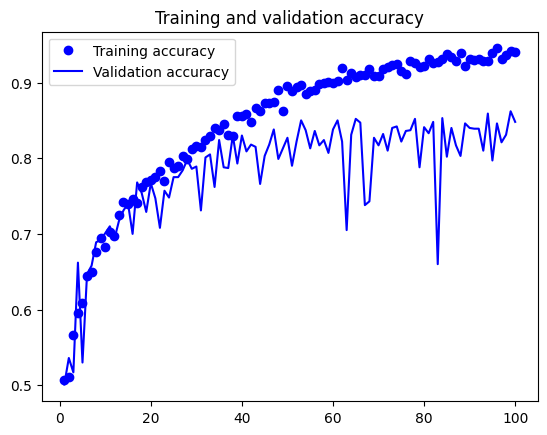

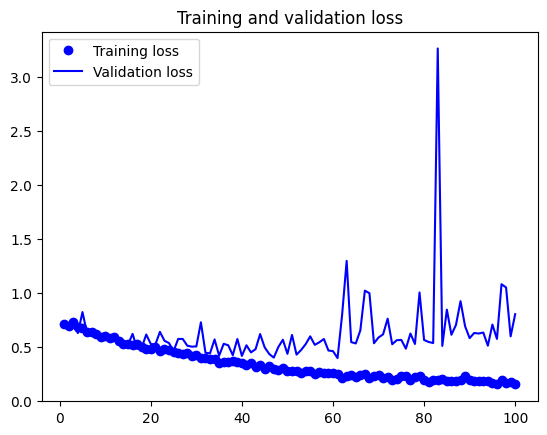

In [23]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

### Feature extraction 

In [24]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

In [25]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

**Extracting the VGG16 features and corresponding labels**

In [26]:
# This should point to the small dataset of the Kaggle Dogs vs Cats competition that was created in a previous notebook
data_folder = pathlib.Path('../data/kaggle_dogs_vs_cats_small')

train_dataset = image_dataset_from_directory(
    data_folder / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    data_folder / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    data_folder / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [27]:
import numpy as np

def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)

1/1 [==============================] - 0s 11ms/step


In [28]:
train_features.shape

(2000, 5, 5, 512)

These are 1000 images for each of the two classes, and then a 5x5 spatial matrix with a depth of 512 filters. 
**To the Student**: Compare these dimensions to the last layer of the VGG16 which generated it. 

**Defining and training the densely connected classifier**

Here we define a new dense neural networks, of only two (neuronal/trainable) layers.

In [29]:
inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

In [30]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 5, 5, 512)]       0         
                                                                 
 flatten_2 (Flatten)         (None, 12800)             0         
                                                                 
 dense_2 (Dense)             (None, 256)               3277056   
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 3277313 (12.50 MB)
Trainable params: 3277313 (12.50 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


While the network has only two layer, its number of parameter is significant compared to the previous networks we defined to address the dogs versus cats dataset before (they had about 1 million paramters). It is also a significant ratio of the VGG16 body which has about 15 million parameters. This is common in CNNs - the feature vector can be quick large (here its sizze is 12800 elements). A dense layer linearly increases the number of parameters with its size. Then, the last layer further increases it linearly proportionally to the number of classes. 

In [31]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
      filepath="./models/feature_extraction",
      save_best_only=True,
      monitor="val_loss")
]
history = model.fit(
    train_features, train_labels,
    epochs=20,
    validation_data=(val_features, val_labels),
    callbacks=callbacks)

Epoch 1/20
63/63 [==============================] - ETA: 0s - loss: 15.4193 - accuracy: 0.9225INFO:tensorflow:Assets written to: ./models/feature_extraction/assets


INFO:tensorflow:Assets written to: ./models/feature_extraction/assets


63/63 [==============================] - 2s 21ms/step - loss: 15.4193 - accuracy: 0.9225 - val_loss: 4.0499 - val_accuracy: 0.9730
Epoch 2/20
63/63 [==============================] - 1s 10ms/step - loss: 4.9217 - accuracy: 0.9700 - val_loss: 5.0618 - val_accuracy: 0.9700
Epoch 3/20
60/63 [===========================>..] - ETA: 0s - loss: 1.3526 - accuracy: 0.9875INFO:tensorflow:Assets written to: ./models/feature_extraction/assets


INFO:tensorflow:Assets written to: ./models/feature_extraction/assets


63/63 [==============================] - 1s 15ms/step - loss: 1.2985 - accuracy: 0.9880 - val_loss: 3.7911 - val_accuracy: 0.9790
Epoch 4/20
63/63 [==============================] - 1s 10ms/step - loss: 1.4592 - accuracy: 0.9875 - val_loss: 4.6416 - val_accuracy: 0.9750
Epoch 5/20
63/63 [==============================] - 1s 11ms/step - loss: 1.2270 - accuracy: 0.9890 - val_loss: 4.6199 - val_accuracy: 0.9810
Epoch 6/20
63/63 [==============================] - 1s 10ms/step - loss: 0.6282 - accuracy: 0.9935 - val_loss: 6.7806 - val_accuracy: 0.9700
Epoch 7/20
63/63 [==============================] - 1s 10ms/step - loss: 0.7830 - accuracy: 0.9935 - val_loss: 4.8307 - val_accuracy: 0.9820
Epoch 8/20
63/63 [==============================] - 1s 10ms/step - loss: 1.3306 - accuracy: 0.9915 - val_loss: 5.7482 - val_accuracy: 0.9730
Epoch 9/20
63/63 [==============================] - 1s 10ms/step - loss: 0.1615 - accuracy: 0.9990 - val_loss: 5.8980 - val_accuracy: 0.9750
Epoch 10/20
63/63 [=====

**Plotting the results**

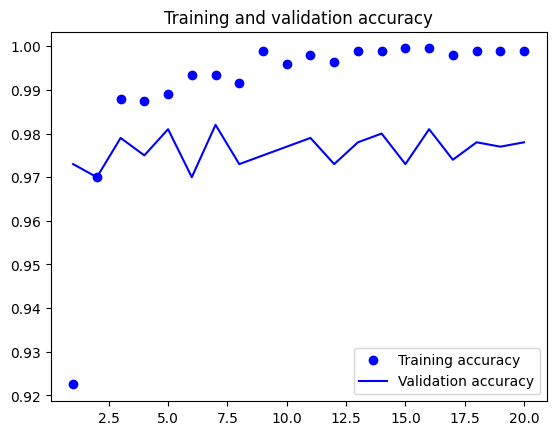

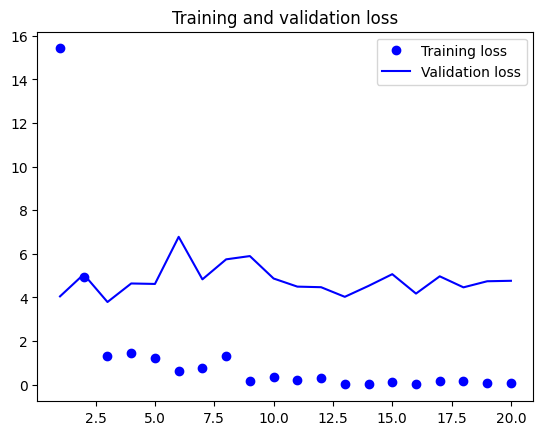

In [32]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

Evaluating model

In [33]:
test_model = keras.models.load_model(
    "./models/feature_extraction")
test_loss, test_acc = test_model.evaluate(x=test_features, y=test_labels)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 0s 4ms/step - loss: 4.8902 - accuracy: 0.9710
Test accuracy: 0.971


2 Feature Extraction with Data Augmentation
In this step, data augmentation is added to the workflow to improve model generalization

In [34]:
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)

In [35]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [36]:
conv_base.trainable = False
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [37]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

In [38]:
model.summary()


Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 tf.__operators__.getitem (  (None, 180, 180, 3)       0         
 SlicingOpLambda)                                                
                                                                 
 tf.nn.bias_add (TFOpLambda  (None, 180, 180, 3)       0         
 )                                                               
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 flatten_3 (Flatten)         (None, 12800)             0   

Now training with augmentation

In [39]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="./models/feature_extraction_with_data_augmentation",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/50


2024-12-07 01:00:00.222456: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 1:04 - loss: 13.4261 - accuracy: 0.6250

2024-12-07 01:00:00.706470: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 13s - loss: 13.8675 - accuracy: 0.7500 

2024-12-07 01:00:00.926129: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 13s - loss: 50.4450 - accuracy: 0.6979

2024-12-07 01:00:01.143549: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 12s - loss: 102.5093 - accuracy: 0.6328

2024-12-07 01:00:01.359728: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 12s - loss: 95.7513 - accuracy: 0.6375 

2024-12-07 01:00:01.576679: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 12s - loss: 84.3713 - accuracy: 0.6667

2024-12-07 01:00:01.793218: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 12s - loss: 79.6468 - accuracy: 0.6652

2024-12-07 01:00:02.005699: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 11s - loss: 73.3900 - accuracy: 0.6914

2024-12-07 01:00:02.220129: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 11s - loss: 65.7645 - accuracy: 0.7153

2024-12-07 01:00:02.436488: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 11s - loss: 60.2549 - accuracy: 0.7375

2024-12-07 01:00:02.651047: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 11s - loss: 55.8733 - accuracy: 0.7500

2024-12-07 01:00:02.867455: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 11s - loss: 51.5475 - accuracy: 0.7682

2024-12-07 01:00:03.079355: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 10s - loss: 48.3323 - accuracy: 0.7764

2024-12-07 01:00:03.294153: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 10s - loss: 45.1512 - accuracy: 0.7902

2024-12-07 01:00:03.506833: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 10s - loss: 42.5373 - accuracy: 0.7958

2024-12-07 01:00:03.718370: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 10s - loss: 40.3473 - accuracy: 0.8047

2024-12-07 01:00:03.938622: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 9s - loss: 38.3848 - accuracy: 0.8143 

2024-12-07 01:00:04.151106: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 9s - loss: 36.3630 - accuracy: 0.8229

2024-12-07 01:00:04.417113: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 9s - loss: 34.4567 - accuracy: 0.8306

2024-12-07 01:00:04.647064: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 9s - loss: 33.2200 - accuracy: 0.8359

2024-12-07 01:00:04.861586: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 9s - loss: 31.8619 - accuracy: 0.8408

2024-12-07 01:00:05.076859: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 8s - loss: 31.4390 - accuracy: 0.8438

2024-12-07 01:00:05.292228: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 8s - loss: 30.2814 - accuracy: 0.8478

2024-12-07 01:00:05.509009: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 8s - loss: 29.0796 - accuracy: 0.8529

2024-12-07 01:00:05.724877: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 8s - loss: 28.1168 - accuracy: 0.8562

2024-12-07 01:00:05.941075: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 8s - loss: 27.7185 - accuracy: 0.8570

2024-12-07 01:00:06.154366: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 7s - loss: 27.0732 - accuracy: 0.8565

2024-12-07 01:00:06.370184: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 7s - loss: 26.7405 - accuracy: 0.8583

2024-12-07 01:00:06.588443: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 7s - loss: 26.3233 - accuracy: 0.8610

2024-12-07 01:00:06.806088: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 7s - loss: 25.7307 - accuracy: 0.8615

2024-12-07 01:00:07.020211: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 6s - loss: 25.0501 - accuracy: 0.8639

2024-12-07 01:00:07.237047: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 6s - loss: 24.4712 - accuracy: 0.8662

2024-12-07 01:00:07.449002: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 6s - loss: 23.7780 - accuracy: 0.8693

2024-12-07 01:00:07.664806: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 6s - loss: 23.1609 - accuracy: 0.8722

2024-12-07 01:00:07.879312: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 6s - loss: 22.4992 - accuracy: 0.8759

2024-12-07 01:00:08.096325: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 5s - loss: 21.9026 - accuracy: 0.8776

2024-12-07 01:00:08.308823: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 5s - loss: 21.3107 - accuracy: 0.8809

2024-12-07 01:00:08.552190: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 5s - loss: 20.8249 - accuracy: 0.8824

2024-12-07 01:00:08.767497: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 5s - loss: 20.5091 - accuracy: 0.8838

2024-12-07 01:00:08.981799: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 5s - loss: 20.5870 - accuracy: 0.8836

2024-12-07 01:00:09.193376: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 4s - loss: 20.1668 - accuracy: 0.8857

2024-12-07 01:00:09.406562: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 4s - loss: 20.2401 - accuracy: 0.8862

2024-12-07 01:00:09.690834: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 4s - loss: 19.9581 - accuracy: 0.8866

2024-12-07 01:00:09.901713: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 4s - loss: 20.5674 - accuracy: 0.8849

2024-12-07 01:00:10.120163: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 3s - loss: 21.3680 - accuracy: 0.8813

2024-12-07 01:00:10.332940: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 3s - loss: 21.2618 - accuracy: 0.8798

2024-12-07 01:00:10.548554: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 3s - loss: 20.8629 - accuracy: 0.8816

2024-12-07 01:00:10.760365: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 3s - loss: 20.8481 - accuracy: 0.8809

2024-12-07 01:00:10.975576: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 3s - loss: 20.4226 - accuracy: 0.8833

2024-12-07 01:00:11.189036: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 2s - loss: 20.1913 - accuracy: 0.8838

2024-12-07 01:00:11.403537: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 2s - loss: 19.9560 - accuracy: 0.8854

2024-12-07 01:00:11.618693: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 2s - loss: 19.6432 - accuracy: 0.8870

2024-12-07 01:00:11.835440: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 2s - loss: 19.4518 - accuracy: 0.8868

2024-12-07 01:00:12.049156: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 1s - loss: 19.1391 - accuracy: 0.8883

2024-12-07 01:00:12.259346: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 1s - loss: 18.9060 - accuracy: 0.8886

2024-12-07 01:00:12.469307: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 1s - loss: 18.7819 - accuracy: 0.8884

2024-12-07 01:00:12.679733: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 1s - loss: 18.5519 - accuracy: 0.8893

2024-12-07 01:00:12.889897: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 1s - loss: 18.3755 - accuracy: 0.8901

2024-12-07 01:00:13.100700: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 0s - loss: 18.5685 - accuracy: 0.8893

2024-12-07 01:00:13.312018: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 18.2875 - accuracy: 0.8906

2024-12-07 01:00:13.522466: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 18.1139 - accuracy: 0.8919

2024-12-07 01:00:13.733844: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 17.6920 - accuracy: 0.8940

2024-12-07 01:00:13.942210: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


INFO:tensorflow:Assets written to: ./models/feature_extraction_with_data_augmentation/assets


INFO:tensorflow:Assets written to: ./models/feature_extraction_with_data_augmentation/assets


63/63 [==============================] - 23s 348ms/step - loss: 17.6920 - accuracy: 0.8940 - val_loss: 6.6348 - val_accuracy: 0.9610
Epoch 2/50


2024-12-07 01:00:22.299380: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 24s - loss: 0.0655 - accuracy: 0.9688

2024-12-07 01:00:22.692137: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 13s - loss: 5.2795 - accuracy: 0.9219

2024-12-07 01:00:22.912620: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 13s - loss: 8.6916 - accuracy: 0.9271

2024-12-07 01:00:23.126670: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 12s - loss: 6.5187 - accuracy: 0.9453

2024-12-07 01:00:23.338945: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 12s - loss: 6.6644 - accuracy: 0.9438

2024-12-07 01:00:23.552850: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 12s - loss: 7.0185 - accuracy: 0.9479

2024-12-07 01:00:23.769721: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 12s - loss: 6.0160 - accuracy: 0.9554

2024-12-07 01:00:23.982422: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 11s - loss: 6.7029 - accuracy: 0.9531

2024-12-07 01:00:24.202506: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 11s - loss: 6.3399 - accuracy: 0.9549

2024-12-07 01:00:24.418901: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 11s - loss: 5.9563 - accuracy: 0.9563

2024-12-07 01:00:24.641559: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 11s - loss: 5.6422 - accuracy: 0.9574

2024-12-07 01:00:24.883358: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 11s - loss: 5.6099 - accuracy: 0.9557

2024-12-07 01:00:25.115020: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 11s - loss: 6.1577 - accuracy: 0.9471

2024-12-07 01:00:25.340741: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 10s - loss: 6.3898 - accuracy: 0.9464

2024-12-07 01:00:25.565086: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 10s - loss: 6.0516 - accuracy: 0.9479

2024-12-07 01:00:25.788071: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 10s - loss: 6.2881 - accuracy: 0.9492

2024-12-07 01:00:26.020125: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 10s - loss: 6.9826 - accuracy: 0.9485

2024-12-07 01:00:26.234632: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 9s - loss: 7.9632 - accuracy: 0.9410 

2024-12-07 01:00:26.449896: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 9s - loss: 8.1362 - accuracy: 0.9391

2024-12-07 01:00:26.663256: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 9s - loss: 8.4092 - accuracy: 0.9375

2024-12-07 01:00:26.936743: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 9s - loss: 8.5250 - accuracy: 0.9360

2024-12-07 01:00:27.167449: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 9s - loss: 8.1375 - accuracy: 0.9389

2024-12-07 01:00:27.379290: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 8s - loss: 7.8819 - accuracy: 0.9389

2024-12-07 01:00:27.601101: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 8s - loss: 7.7926 - accuracy: 0.9388

2024-12-07 01:00:27.841707: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 8s - loss: 7.8925 - accuracy: 0.9362

2024-12-07 01:00:28.068427: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 8s - loss: 8.4716 - accuracy: 0.9351

2024-12-07 01:00:28.290537: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 8s - loss: 8.1890 - accuracy: 0.9363

2024-12-07 01:00:28.508590: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 7s - loss: 7.9701 - accuracy: 0.9375

2024-12-07 01:00:28.722152: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 7s - loss: 7.7199 - accuracy: 0.9386

2024-12-07 01:00:28.934841: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 7s - loss: 7.4626 - accuracy: 0.9406

2024-12-07 01:00:29.150777: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 7s - loss: 7.3346 - accuracy: 0.9405

2024-12-07 01:00:29.363400: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 6s - loss: 7.1054 - accuracy: 0.9424

2024-12-07 01:00:29.581741: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 6s - loss: 7.5477 - accuracy: 0.9403

2024-12-07 01:00:29.791243: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 6s - loss: 7.6178 - accuracy: 0.9403

2024-12-07 01:00:30.013837: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 6s - loss: 7.4001 - accuracy: 0.9420

2024-12-07 01:00:30.235395: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 5s - loss: 7.5085 - accuracy: 0.9392

2024-12-07 01:00:30.460439: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 5s - loss: 7.7174 - accuracy: 0.9375

2024-12-07 01:00:30.688372: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 5s - loss: 7.5144 - accuracy: 0.9391

2024-12-07 01:00:30.909431: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 5s - loss: 7.4640 - accuracy: 0.9399

2024-12-07 01:00:31.132177: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 5s - loss: 7.2774 - accuracy: 0.9414

2024-12-07 01:00:31.444530: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 4s - loss: 7.0999 - accuracy: 0.9428

2024-12-07 01:00:31.681944: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 4s - loss: 7.1279 - accuracy: 0.9420

2024-12-07 01:00:31.903955: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 4s - loss: 7.0963 - accuracy: 0.9426

2024-12-07 01:00:32.117709: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 4s - loss: 7.2694 - accuracy: 0.9418

2024-12-07 01:00:32.328354: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 4s - loss: 7.3329 - accuracy: 0.9410

2024-12-07 01:00:32.540699: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 3s - loss: 7.5748 - accuracy: 0.9402

2024-12-07 01:00:32.762787: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 3s - loss: 7.4464 - accuracy: 0.9408

2024-12-07 01:00:32.979317: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 3s - loss: 7.2912 - accuracy: 0.9421

2024-12-07 01:00:33.196319: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 3s - loss: 7.4241 - accuracy: 0.9413

2024-12-07 01:00:33.407487: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 2s - loss: 7.3343 - accuracy: 0.9419

2024-12-07 01:00:33.626696: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 2s - loss: 7.4686 - accuracy: 0.9418

2024-12-07 01:00:33.839823: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 2s - loss: 7.5911 - accuracy: 0.9417

2024-12-07 01:00:34.075979: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 2s - loss: 7.4479 - accuracy: 0.9428

2024-12-07 01:00:34.322543: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 2s - loss: 7.3772 - accuracy: 0.9427

2024-12-07 01:00:34.543957: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 1s - loss: 7.3556 - accuracy: 0.9420

2024-12-07 01:00:34.764569: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 1s - loss: 7.3010 - accuracy: 0.9425

2024-12-07 01:00:34.975271: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 1s - loss: 7.2440 - accuracy: 0.9430

2024-12-07 01:00:35.185117: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 1s - loss: 7.2576 - accuracy: 0.9423

2024-12-07 01:00:35.394237: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 0s - loss: 7.2052 - accuracy: 0.9428

2024-12-07 01:00:35.603276: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 7.1854 - accuracy: 0.9427

2024-12-07 01:00:35.888669: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 7.1149 - accuracy: 0.9431

2024-12-07 01:00:36.098363: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 7.4700 - accuracy: 0.9415

2024-12-07 01:00:36.307223: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


INFO:tensorflow:Assets written to: ./models/feature_extraction_with_data_augmentation/assets


INFO:tensorflow:Assets written to: ./models/feature_extraction_with_data_augmentation/assets


63/63 [==============================] - 22s 353ms/step - loss: 7.4700 - accuracy: 0.9415 - val_loss: 3.5776 - val_accuracy: 0.9680
Epoch 3/50


2024-12-07 01:00:44.598955: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 18s - loss: 2.2582 - accuracy: 0.9375

2024-12-07 01:00:44.902120: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 12s - loss: 9.7717 - accuracy: 0.8906

2024-12-07 01:00:45.112633: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 12s - loss: 6.5145 - accuracy: 0.9271

2024-12-07 01:00:45.321263: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 12s - loss: 6.1630 - accuracy: 0.9297

2024-12-07 01:00:45.530353: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 12s - loss: 6.4245 - accuracy: 0.9312

2024-12-07 01:00:45.738832: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 11s - loss: 5.3769 - accuracy: 0.9375

2024-12-07 01:00:45.947669: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 11s - loss: 5.0203 - accuracy: 0.9420

2024-12-07 01:00:46.160196: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 11s - loss: 4.8648 - accuracy: 0.9414

2024-12-07 01:00:46.372296: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 11s - loss: 5.2691 - accuracy: 0.9410

2024-12-07 01:00:46.598610: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 11s - loss: 5.8225 - accuracy: 0.9375

2024-12-07 01:00:46.818979: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 11s - loss: 5.7986 - accuracy: 0.9347

2024-12-07 01:00:47.040287: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 10s - loss: 5.4595 - accuracy: 0.9349

2024-12-07 01:00:47.255259: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 10s - loss: 5.3359 - accuracy: 0.9351

2024-12-07 01:00:47.471797: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 10s - loss: 5.0757 - accuracy: 0.9353

2024-12-07 01:00:47.684040: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 10s - loss: 4.7373 - accuracy: 0.9396

2024-12-07 01:00:47.902635: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 10s - loss: 4.4413 - accuracy: 0.9434

2024-12-07 01:00:48.120480: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 9s - loss: 4.8512 - accuracy: 0.9430 

2024-12-07 01:00:48.355966: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 9s - loss: 4.5817 - accuracy: 0.9462

2024-12-07 01:00:48.582280: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 9s - loss: 4.6694 - accuracy: 0.9457

2024-12-07 01:00:48.943137: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 9s - loss: 4.7786 - accuracy: 0.9453

2024-12-07 01:00:49.231182: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 9s - loss: 4.6174 - accuracy: 0.9464

2024-12-07 01:00:49.464736: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 9s - loss: 4.8302 - accuracy: 0.9460

2024-12-07 01:00:49.691017: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 9s - loss: 4.6202 - accuracy: 0.9484

2024-12-07 01:00:49.908963: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 8s - loss: 4.9649 - accuracy: 0.9479

2024-12-07 01:00:50.121940: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 8s - loss: 4.7663 - accuracy: 0.9500

2024-12-07 01:00:50.335351: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 8s - loss: 4.5829 - accuracy: 0.9519

2024-12-07 01:00:50.552794: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 8s - loss: 5.2043 - accuracy: 0.9502

2024-12-07 01:00:50.768872: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 7s - loss: 5.0184 - accuracy: 0.9520

2024-12-07 01:00:50.982569: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 7s - loss: 4.8455 - accuracy: 0.9537

2024-12-07 01:00:51.204841: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 7s - loss: 4.6840 - accuracy: 0.9552

2024-12-07 01:00:51.424563: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 7s - loss: 4.6743 - accuracy: 0.9536

2024-12-07 01:00:51.644555: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 6s - loss: 4.6427 - accuracy: 0.9541

2024-12-07 01:00:51.866500: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 6s - loss: 4.6726 - accuracy: 0.9536

2024-12-07 01:00:52.086129: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 6s - loss: 4.5352 - accuracy: 0.9550

2024-12-07 01:00:52.305844: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 6s - loss: 4.4117 - accuracy: 0.9554

2024-12-07 01:00:52.531123: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 6s - loss: 4.2892 - accuracy: 0.9566

2024-12-07 01:00:52.751960: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 5s - loss: 4.1732 - accuracy: 0.9578

2024-12-07 01:00:53.041434: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 5s - loss: 4.0634 - accuracy: 0.9589

2024-12-07 01:00:53.296484: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 5s - loss: 3.9592 - accuracy: 0.9599

2024-12-07 01:00:53.545831: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 5s - loss: 3.8603 - accuracy: 0.9609

2024-12-07 01:00:53.788022: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 5s - loss: 3.9358 - accuracy: 0.9604

2024-12-07 01:00:54.051060: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 4s - loss: 3.8420 - accuracy: 0.9613

2024-12-07 01:00:54.299818: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 4s - loss: 3.7527 - accuracy: 0.9622

2024-12-07 01:00:54.538502: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 4s - loss: 3.6885 - accuracy: 0.9616

2024-12-07 01:00:54.779773: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 4s - loss: 3.7045 - accuracy: 0.9618

2024-12-07 01:00:55.026163: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 3s - loss: 3.8184 - accuracy: 0.9613

2024-12-07 01:00:55.279975: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 3s - loss: 4.3696 - accuracy: 0.9601

2024-12-07 01:00:55.525593: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 3s - loss: 4.6114 - accuracy: 0.9577

2024-12-07 01:00:55.779925: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 3s - loss: 4.7569 - accuracy: 0.9573

2024-12-07 01:00:56.025723: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 3s - loss: 4.7513 - accuracy: 0.9569

2024-12-07 01:00:56.274452: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 2s - loss: 4.7891 - accuracy: 0.9571

2024-12-07 01:00:56.506089: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 2s - loss: 4.6971 - accuracy: 0.9579

2024-12-07 01:00:56.733371: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 2s - loss: 4.6326 - accuracy: 0.9581

2024-12-07 01:00:56.960856: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 2s - loss: 4.6622 - accuracy: 0.9566

2024-12-07 01:00:57.267415: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 1s - loss: 4.8983 - accuracy: 0.9551

2024-12-07 01:00:57.488529: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 1s - loss: 4.8108 - accuracy: 0.9559

2024-12-07 01:00:57.710540: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 1s - loss: 4.7577 - accuracy: 0.9556

2024-12-07 01:00:57.937427: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 1s - loss: 4.7262 - accuracy: 0.9558

2024-12-07 01:00:58.166008: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 0s - loss: 4.6532 - accuracy: 0.9560

2024-12-07 01:00:58.390440: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 4.6359 - accuracy: 0.9557

2024-12-07 01:00:58.614139: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 4.6345 - accuracy: 0.9549

2024-12-07 01:00:58.839430: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 4.5696 - accuracy: 0.9550

2024-12-07 01:00:59.063224: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 21s 335ms/step - loss: 4.5696 - accuracy: 0.9550 - val_loss: 6.3301 - val_accuracy: 0.9520
Epoch 4/50


2024-12-07 01:01:25.612536: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 28s - loss: 3.4505 - accuracy: 0.9375

2024-12-07 01:01:26.037466: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 13s - loss: 1.7253 - accuracy: 0.9688

2024-12-07 01:01:26.260711: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 13s - loss: 2.9762 - accuracy: 0.9583

2024-12-07 01:01:26.484461: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 12s - loss: 3.8657 - accuracy: 0.9531

2024-12-07 01:01:26.698120: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 12s - loss: 3.0925 - accuracy: 0.9625

2024-12-07 01:01:26.924654: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 12s - loss: 4.1155 - accuracy: 0.9635

2024-12-07 01:01:27.140553: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 12s - loss: 3.8482 - accuracy: 0.9598

2024-12-07 01:01:27.377660: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 12s - loss: 3.3760 - accuracy: 0.9609

2024-12-07 01:01:27.608932: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 12s - loss: 6.4983 - accuracy: 0.9479

2024-12-07 01:01:27.825584: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 11s - loss: 6.0173 - accuracy: 0.9500

2024-12-07 01:01:28.040489: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 11s - loss: 5.4703 - accuracy: 0.9545

2024-12-07 01:01:28.254225: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 11s - loss: 5.0144 - accuracy: 0.9583

2024-12-07 01:01:28.467622: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 11s - loss: 5.0815 - accuracy: 0.9519

2024-12-07 01:01:28.683682: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 10s - loss: 5.4483 - accuracy: 0.9487

2024-12-07 01:01:28.897107: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 10s - loss: 5.3822 - accuracy: 0.9500

2024-12-07 01:01:29.108791: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 10s - loss: 5.2360 - accuracy: 0.9492

2024-12-07 01:01:29.321184: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 10s - loss: 5.4711 - accuracy: 0.9485

2024-12-07 01:01:29.539603: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 9s - loss: 5.3164 - accuracy: 0.9479 

2024-12-07 01:01:29.752537: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 9s - loss: 5.3064 - accuracy: 0.9474

2024-12-07 01:01:29.966692: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 9s - loss: 5.1232 - accuracy: 0.9469

2024-12-07 01:01:30.181851: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 9s - loss: 4.9699 - accuracy: 0.9479

2024-12-07 01:01:30.466677: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 9s - loss: 4.7440 - accuracy: 0.9503

2024-12-07 01:01:30.679123: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 8s - loss: 4.6879 - accuracy: 0.9470

2024-12-07 01:01:30.898208: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 8s - loss: 4.6580 - accuracy: 0.9466

2024-12-07 01:01:31.115269: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 8s - loss: 4.6336 - accuracy: 0.9475

2024-12-07 01:01:31.329371: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 8s - loss: 4.4554 - accuracy: 0.9495

2024-12-07 01:01:31.547748: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 7s - loss: 4.3111 - accuracy: 0.9502

2024-12-07 01:01:31.768232: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 7s - loss: 4.3621 - accuracy: 0.9498

2024-12-07 01:01:31.981121: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 7s - loss: 4.2117 - accuracy: 0.9515

2024-12-07 01:01:32.202975: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 7s - loss: 4.0730 - accuracy: 0.9521

2024-12-07 01:01:32.424018: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 7s - loss: 4.0428 - accuracy: 0.9526

2024-12-07 01:01:32.643566: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 6s - loss: 3.9303 - accuracy: 0.9531

2024-12-07 01:01:32.862721: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 6s - loss: 3.9193 - accuracy: 0.9517

2024-12-07 01:01:33.080221: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 6s - loss: 3.8044 - accuracy: 0.9531

2024-12-07 01:01:33.291429: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 6s - loss: 3.7740 - accuracy: 0.9527

2024-12-07 01:01:33.509457: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 5s - loss: 3.7219 - accuracy: 0.9514

2024-12-07 01:01:33.728042: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 5s - loss: 3.6721 - accuracy: 0.9519

2024-12-07 01:01:33.987621: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 5s - loss: 3.5962 - accuracy: 0.9523

2024-12-07 01:01:34.270088: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 5s - loss: 3.5040 - accuracy: 0.9535

2024-12-07 01:01:34.483913: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 5s - loss: 3.5489 - accuracy: 0.9531

2024-12-07 01:01:34.702438: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 4s - loss: 3.6400 - accuracy: 0.9527

2024-12-07 01:01:34.920808: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 4s - loss: 3.6757 - accuracy: 0.9531

2024-12-07 01:01:35.141027: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 4s - loss: 3.6632 - accuracy: 0.9535

2024-12-07 01:01:35.368948: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 4s - loss: 3.6189 - accuracy: 0.9538

2024-12-07 01:01:35.593624: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 4s - loss: 3.5931 - accuracy: 0.9542

2024-12-07 01:01:35.816594: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 3s - loss: 3.5532 - accuracy: 0.9545

2024-12-07 01:01:36.034499: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 3s - loss: 3.4877 - accuracy: 0.9548

2024-12-07 01:01:36.254482: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 3s - loss: 3.4260 - accuracy: 0.9551

2024-12-07 01:01:36.473095: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 3s - loss: 3.3561 - accuracy: 0.9560

2024-12-07 01:01:36.698343: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 2s - loss: 3.3896 - accuracy: 0.9556

2024-12-07 01:01:36.924416: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 2s - loss: 3.6834 - accuracy: 0.9553

2024-12-07 01:01:37.140488: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 2s - loss: 3.6125 - accuracy: 0.9561

2024-12-07 01:01:37.353349: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 2s - loss: 3.6152 - accuracy: 0.9564

2024-12-07 01:01:37.574904: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 1s - loss: 3.5483 - accuracy: 0.9572

2024-12-07 01:01:37.786355: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 1s - loss: 3.5773 - accuracy: 0.9563

2024-12-07 01:01:38.071700: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 1s - loss: 3.5134 - accuracy: 0.9570

2024-12-07 01:01:38.287837: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 1s - loss: 3.4518 - accuracy: 0.9578

2024-12-07 01:01:38.506894: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 1s - loss: 3.6087 - accuracy: 0.9558

2024-12-07 01:01:38.719119: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 0s - loss: 3.6372 - accuracy: 0.9560

2024-12-07 01:01:38.929443: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 3.6883 - accuracy: 0.9557

2024-12-07 01:01:39.137990: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 3.7140 - accuracy: 0.9544

2024-12-07 01:01:39.350062: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 3.6405 - accuracy: 0.9550

2024-12-07 01:01:39.559012: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


INFO:tensorflow:Assets written to: ./models/feature_extraction_with_data_augmentation/assets


INFO:tensorflow:Assets written to: ./models/feature_extraction_with_data_augmentation/assets


63/63 [==============================] - 22s 354ms/step - loss: 3.6405 - accuracy: 0.9550 - val_loss: 2.8333 - val_accuracy: 0.9790
Epoch 5/50


2024-12-07 01:01:48.004564: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 18s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-07 01:01:48.307643: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 13s - loss: 1.0885 - accuracy: 0.9844    

2024-12-07 01:01:48.524007: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 12s - loss: 0.7257 - accuracy: 0.9896

2024-12-07 01:01:48.734814: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 12s - loss: 1.2943 - accuracy: 0.9766

2024-12-07 01:01:48.945072: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 12s - loss: 1.0981 - accuracy: 0.9750

2024-12-07 01:01:49.160006: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 12s - loss: 2.1313 - accuracy: 0.9688

2024-12-07 01:01:49.369928: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 11s - loss: 1.8302 - accuracy: 0.9688

2024-12-07 01:01:49.580673: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 11s - loss: 1.6015 - accuracy: 0.9727

2024-12-07 01:01:49.790032: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 11s - loss: 2.4363 - accuracy: 0.9722

2024-12-07 01:01:50.000101: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 11s - loss: 2.1927 - accuracy: 0.9750

2024-12-07 01:01:50.215994: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 11s - loss: 1.9933 - accuracy: 0.9773

2024-12-07 01:01:50.426207: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 10s - loss: 1.8272 - accuracy: 0.9792

2024-12-07 01:01:50.638797: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 10s - loss: 1.8579 - accuracy: 0.9784

2024-12-07 01:01:50.858023: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 10s - loss: 2.1821 - accuracy: 0.9777

2024-12-07 01:01:51.071960: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 10s - loss: 2.1045 - accuracy: 0.9771

2024-12-07 01:01:51.287749: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 10s - loss: 2.0886 - accuracy: 0.9766

2024-12-07 01:01:51.500492: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 9s - loss: 1.9657 - accuracy: 0.9779 

2024-12-07 01:01:51.714062: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 9s - loss: 1.8565 - accuracy: 0.9792

2024-12-07 01:01:51.930861: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 9s - loss: 1.7588 - accuracy: 0.9803

2024-12-07 01:01:52.147051: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 9s - loss: 1.6709 - accuracy: 0.9812

2024-12-07 01:01:52.363910: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 8s - loss: 1.5913 - accuracy: 0.9821

2024-12-07 01:01:52.581556: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 8s - loss: 1.5190 - accuracy: 0.9830

2024-12-07 01:01:52.800145: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 8s - loss: 1.5601 - accuracy: 0.9823

2024-12-07 01:01:53.018144: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 8s - loss: 1.4951 - accuracy: 0.9831

2024-12-07 01:01:53.235652: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 8s - loss: 1.4594 - accuracy: 0.9825

2024-12-07 01:01:53.452835: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 7s - loss: 1.4033 - accuracy: 0.9832

2024-12-07 01:01:53.673961: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 7s - loss: 1.3513 - accuracy: 0.9838

2024-12-07 01:01:53.894031: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 7s - loss: 1.4062 - accuracy: 0.9833

2024-12-07 01:01:54.114451: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 7s - loss: 1.4764 - accuracy: 0.9828

2024-12-07 01:01:54.335310: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 7s - loss: 1.4272 - accuracy: 0.9833

2024-12-07 01:01:54.561589: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 6s - loss: 1.4823 - accuracy: 0.9829

2024-12-07 01:01:54.858505: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 6s - loss: 1.5791 - accuracy: 0.9824

2024-12-07 01:01:55.103442: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 6s - loss: 1.5411 - accuracy: 0.9820

2024-12-07 01:01:55.324329: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 6s - loss: 1.6412 - accuracy: 0.9807

2024-12-07 01:01:55.544667: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 6s - loss: 1.5943 - accuracy: 0.9812

2024-12-07 01:01:55.764872: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 5s - loss: 1.5710 - accuracy: 0.9809

2024-12-07 01:01:55.988150: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 5s - loss: 1.5725 - accuracy: 0.9797

2024-12-07 01:01:56.210757: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 5s - loss: 1.6106 - accuracy: 0.9794

2024-12-07 01:01:56.435078: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 5s - loss: 1.6755 - accuracy: 0.9784

2024-12-07 01:01:56.655119: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 5s - loss: 1.7446 - accuracy: 0.9781

2024-12-07 01:01:56.878238: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 4s - loss: 1.7056 - accuracy: 0.9779

2024-12-07 01:01:57.099888: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 4s - loss: 1.8516 - accuracy: 0.9762

2024-12-07 01:01:57.321518: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 4s - loss: 2.0513 - accuracy: 0.9738

2024-12-07 01:01:57.543914: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 4s - loss: 2.1015 - accuracy: 0.9730

2024-12-07 01:01:57.766742: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 3s - loss: 2.2648 - accuracy: 0.9729

2024-12-07 01:01:57.988342: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 3s - loss: 2.2472 - accuracy: 0.9728

2024-12-07 01:01:58.209172: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 3s - loss: 2.1994 - accuracy: 0.9734

2024-12-07 01:01:58.434532: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 3s - loss: 2.2232 - accuracy: 0.9733

2024-12-07 01:01:58.655990: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 3s - loss: 2.3215 - accuracy: 0.9719

2024-12-07 01:01:58.878271: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 2s - loss: 2.2934 - accuracy: 0.9719

2024-12-07 01:01:59.101617: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 2s - loss: 2.2484 - accuracy: 0.9724

2024-12-07 01:01:59.324023: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 2s - loss: 2.2243 - accuracy: 0.9724

2024-12-07 01:01:59.547230: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 2s - loss: 2.2510 - accuracy: 0.9723

2024-12-07 01:01:59.769163: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 1s - loss: 2.2808 - accuracy: 0.9722

2024-12-07 01:02:00.061585: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 1s - loss: 2.2756 - accuracy: 0.9722

2024-12-07 01:02:00.285210: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 1s - loss: 2.2437 - accuracy: 0.9721

2024-12-07 01:02:00.508284: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 1s - loss: 2.4060 - accuracy: 0.9709

2024-12-07 01:02:00.730279: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 1s - loss: 2.3838 - accuracy: 0.9709

2024-12-07 01:02:00.954757: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 0s - loss: 2.3434 - accuracy: 0.9714

2024-12-07 01:02:01.178596: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 2.4391 - accuracy: 0.9708

2024-12-07 01:02:01.407334: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 2.3991 - accuracy: 0.9713

2024-12-07 01:02:01.638018: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 2.3815 - accuracy: 0.9715

2024-12-07 01:02:01.862968: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 21s 327ms/step - loss: 2.3815 - accuracy: 0.9715 - val_loss: 2.8703 - val_accuracy: 0.9800
Epoch 6/50


2024-12-07 01:02:08.592881: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 18s - loss: 2.1975 - accuracy: 0.9688

2024-12-07 01:02:08.889955: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 13s - loss: 3.9994 - accuracy: 0.9531

2024-12-07 01:02:09.119003: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 13s - loss: 2.6663 - accuracy: 0.9688

2024-12-07 01:02:09.343567: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 13s - loss: 1.9997 - accuracy: 0.9766

2024-12-07 01:02:09.570012: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 13s - loss: 2.1389 - accuracy: 0.9750

2024-12-07 01:02:09.798430: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 12s - loss: 1.7825 - accuracy: 0.9792

2024-12-07 01:02:10.024275: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 12s - loss: 1.8424 - accuracy: 0.9777

2024-12-07 01:02:10.250158: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 12s - loss: 1.6448 - accuracy: 0.9766

2024-12-07 01:02:10.476545: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 12s - loss: 2.0872 - accuracy: 0.9722

2024-12-07 01:02:10.703322: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 12s - loss: 2.3605 - accuracy: 0.9719

2024-12-07 01:02:10.930270: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 11s - loss: 2.1459 - accuracy: 0.9744

2024-12-07 01:02:11.160095: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 11s - loss: 1.9671 - accuracy: 0.9766

2024-12-07 01:02:11.386313: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 11s - loss: 2.3945 - accuracy: 0.9736

2024-12-07 01:02:11.612898: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 11s - loss: 2.2235 - accuracy: 0.9754

2024-12-07 01:02:11.839735: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 11s - loss: 2.7686 - accuracy: 0.9729

2024-12-07 01:02:12.133861: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 10s - loss: 3.0750 - accuracy: 0.9707

2024-12-07 01:02:12.371949: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 10s - loss: 2.8941 - accuracy: 0.9724

2024-12-07 01:02:12.596636: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 10s - loss: 3.5775 - accuracy: 0.9688

2024-12-07 01:02:12.821701: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 10s - loss: 3.8771 - accuracy: 0.9671

2024-12-07 01:02:13.051440: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 9s - loss: 3.8270 - accuracy: 0.9672 

2024-12-07 01:02:13.279166: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 9s - loss: 3.6447 - accuracy: 0.9688

2024-12-07 01:02:13.504847: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 9s - loss: 3.5005 - accuracy: 0.9688

2024-12-07 01:02:13.730399: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 9s - loss: 3.3483 - accuracy: 0.9701

2024-12-07 01:02:13.961981: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 8s - loss: 3.2088 - accuracy: 0.9714

2024-12-07 01:02:14.189091: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 8s - loss: 3.1535 - accuracy: 0.9700

2024-12-07 01:02:14.413531: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 8s - loss: 3.0609 - accuracy: 0.9700

2024-12-07 01:02:14.640877: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 8s - loss: 2.9513 - accuracy: 0.9699

2024-12-07 01:02:14.871148: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 8s - loss: 2.8459 - accuracy: 0.9710

2024-12-07 01:02:15.101396: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 7s - loss: 2.8189 - accuracy: 0.9698

2024-12-07 01:02:15.351544: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 7s - loss: 2.7502 - accuracy: 0.9698

2024-12-07 01:02:15.599428: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 7s - loss: 2.6760 - accuracy: 0.9698

2024-12-07 01:02:15.847820: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 7s - loss: 2.6398 - accuracy: 0.9697

2024-12-07 01:02:16.104501: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 6s - loss: 2.6243 - accuracy: 0.9697

2024-12-07 01:02:16.353420: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 6s - loss: 2.5471 - accuracy: 0.9706

2024-12-07 01:02:16.594865: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 6s - loss: 2.5595 - accuracy: 0.9705

2024-12-07 01:02:16.860856: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 6s - loss: 2.9276 - accuracy: 0.9688

2024-12-07 01:02:17.224432: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 6s - loss: 2.8484 - accuracy: 0.9696

2024-12-07 01:02:17.483535: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 5s - loss: 2.7735 - accuracy: 0.9704

2024-12-07 01:02:17.725023: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 5s - loss: 2.7928 - accuracy: 0.9696

2024-12-07 01:02:17.962213: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 5s - loss: 2.9203 - accuracy: 0.9688

2024-12-07 01:02:18.194776: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 5s - loss: 2.9215 - accuracy: 0.9688

2024-12-07 01:02:18.426739: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 5s - loss: 2.9516 - accuracy: 0.9680

2024-12-07 01:02:18.659980: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 4s - loss: 3.0040 - accuracy: 0.9673

2024-12-07 01:02:18.893700: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 4s - loss: 3.0325 - accuracy: 0.9673

2024-12-07 01:02:19.124415: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 4s - loss: 2.9651 - accuracy: 0.9681

2024-12-07 01:02:19.355462: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 4s - loss: 2.9007 - accuracy: 0.9688

2024-12-07 01:02:19.586269: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 3s - loss: 2.8390 - accuracy: 0.9694

2024-12-07 01:02:19.819127: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 3s - loss: 2.8430 - accuracy: 0.9681

2024-12-07 01:02:20.051191: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 3s - loss: 3.0205 - accuracy: 0.9675

2024-12-07 01:02:20.282907: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 3s - loss: 2.9815 - accuracy: 0.9675

2024-12-07 01:02:20.512861: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 2s - loss: 2.9230 - accuracy: 0.9681

2024-12-07 01:02:20.746498: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 2s - loss: 3.0128 - accuracy: 0.9669

2024-12-07 01:02:20.977637: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 2s - loss: 2.9927 - accuracy: 0.9670

2024-12-07 01:02:21.209940: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 2s - loss: 2.9373 - accuracy: 0.9676

2024-12-07 01:02:21.444223: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 1s - loss: 2.8839 - accuracy: 0.9682

2024-12-07 01:02:21.674293: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 1s - loss: 2.8324 - accuracy: 0.9688

2024-12-07 01:02:21.900491: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 1s - loss: 2.7827 - accuracy: 0.9693

2024-12-07 01:02:22.200618: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 1s - loss: 2.7649 - accuracy: 0.9693

2024-12-07 01:02:22.441436: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 0s - loss: 2.7371 - accuracy: 0.9688

2024-12-07 01:02:22.670847: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 2.6915 - accuracy: 0.9693

2024-12-07 01:02:22.899311: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 2.6576 - accuracy: 0.9693

2024-12-07 01:02:23.129708: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 2.6721 - accuracy: 0.9690

2024-12-07 01:02:23.357694: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 22s 345ms/step - loss: 2.6721 - accuracy: 0.9690 - val_loss: 3.8862 - val_accuracy: 0.9730
Epoch 7/50


2024-12-07 01:02:30.261807: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 19s - loss: 2.5540e-04 - accuracy: 1.0000

2024-12-07 01:02:30.570005: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 14s - loss: 1.2770e-04 - accuracy: 1.0000

2024-12-07 01:02:30.806758: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 14s - loss: 3.2688 - accuracy: 0.9792    

2024-12-07 01:02:31.045506: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 14s - loss: 2.8462 - accuracy: 0.9766

2024-12-07 01:02:31.284131: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 13s - loss: 3.1773 - accuracy: 0.9688

2024-12-07 01:02:31.519650: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 13s - loss: 2.6599 - accuracy: 0.9688

2024-12-07 01:02:31.755355: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 13s - loss: 2.6723 - accuracy: 0.9643

2024-12-07 01:02:32.000717: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 13s - loss: 2.6386 - accuracy: 0.9648

2024-12-07 01:02:32.244798: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 12s - loss: 2.3454 - accuracy: 0.9688

2024-12-07 01:02:32.498706: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 12s - loss: 2.6449 - accuracy: 0.9625

2024-12-07 01:02:32.751485: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 12s - loss: 2.7880 - accuracy: 0.9602

2024-12-07 01:02:33.007710: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 12s - loss: 2.5556 - accuracy: 0.9635

2024-12-07 01:02:33.262571: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 12s - loss: 2.3590 - accuracy: 0.9663

2024-12-07 01:02:33.517506: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 12s - loss: 2.2502 - accuracy: 0.9665

2024-12-07 01:02:33.771016: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 11s - loss: 2.1002 - accuracy: 0.9688

2024-12-07 01:02:34.014772: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 11s - loss: 1.9877 - accuracy: 0.9668

2024-12-07 01:02:34.263112: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 11s - loss: 1.8708 - accuracy: 0.9688

2024-12-07 01:02:34.503713: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 11s - loss: 1.9656 - accuracy: 0.9653

2024-12-07 01:02:34.751267: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 10s - loss: 1.9706 - accuracy: 0.9638

2024-12-07 01:02:35.001458: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 10s - loss: 1.9147 - accuracy: 0.9641

2024-12-07 01:02:35.278778: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 10s - loss: 1.8235 - accuracy: 0.9658

2024-12-07 01:02:35.543269: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 10s - loss: 1.9360 - accuracy: 0.9631

2024-12-07 01:02:35.839004: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 10s - loss: 2.1184 - accuracy: 0.9606

2024-12-07 01:02:36.278555: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 10s - loss: 2.0301 - accuracy: 0.9622

2024-12-07 01:02:36.549448: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 9s - loss: 2.0684 - accuracy: 0.9613 

2024-12-07 01:02:36.800538: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 9s - loss: 2.6075 - accuracy: 0.9591

2024-12-07 01:02:37.042529: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 9s - loss: 2.5109 - accuracy: 0.9606

2024-12-07 01:02:37.282904: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 9s - loss: 2.4213 - accuracy: 0.9621

2024-12-07 01:02:37.523870: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 8s - loss: 2.3378 - accuracy: 0.9634

2024-12-07 01:02:37.774506: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 8s - loss: 2.4952 - accuracy: 0.9615

2024-12-07 01:02:38.032231: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 8s - loss: 2.6358 - accuracy: 0.9617

2024-12-07 01:02:38.287801: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 7s - loss: 2.5662 - accuracy: 0.9619

2024-12-07 01:02:38.549236: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 7s - loss: 2.7189 - accuracy: 0.9612

2024-12-07 01:02:38.810637: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 7s - loss: 2.6390 - accuracy: 0.9623

2024-12-07 01:02:39.068679: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 7s - loss: 2.5636 - accuracy: 0.9634

2024-12-07 01:02:39.331580: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 6s - loss: 2.6522 - accuracy: 0.9635

2024-12-07 01:02:39.593161: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 6s - loss: 2.6225 - accuracy: 0.9637

2024-12-07 01:02:39.858988: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 6s - loss: 2.5534 - accuracy: 0.9646

2024-12-07 01:02:40.104537: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 6s - loss: 2.5285 - accuracy: 0.9647

2024-12-07 01:02:40.372273: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 5s - loss: 2.5732 - accuracy: 0.9641

2024-12-07 01:02:40.671324: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 5s - loss: 2.7123 - accuracy: 0.9627

2024-12-07 01:02:40.942915: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 5s - loss: 2.6939 - accuracy: 0.9606

2024-12-07 01:02:41.210060: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 5s - loss: 2.6312 - accuracy: 0.9615

2024-12-07 01:02:41.469418: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 4s - loss: 2.6924 - accuracy: 0.9609

2024-12-07 01:02:41.852396: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 4s - loss: 2.6874 - accuracy: 0.9611

2024-12-07 01:02:42.112392: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 4s - loss: 2.6290 - accuracy: 0.9620

2024-12-07 01:02:42.377620: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 4s - loss: 2.6735 - accuracy: 0.9621

2024-12-07 01:02:42.646014: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 3s - loss: 2.8707 - accuracy: 0.9609

2024-12-07 01:02:42.904742: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 3s - loss: 2.8122 - accuracy: 0.9617

2024-12-07 01:02:43.152638: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 3s - loss: 2.8389 - accuracy: 0.9619

2024-12-07 01:02:43.404339: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 3s - loss: 2.7833 - accuracy: 0.9626

2024-12-07 01:02:43.647124: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 2s - loss: 2.7885 - accuracy: 0.9627

2024-12-07 01:02:43.886644: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 2s - loss: 2.9009 - accuracy: 0.9629

2024-12-07 01:02:44.127692: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 2s - loss: 2.8472 - accuracy: 0.9635

2024-12-07 01:02:44.362080: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 2s - loss: 2.8291 - accuracy: 0.9636

2024-12-07 01:02:44.599301: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 1s - loss: 2.7786 - accuracy: 0.9643

2024-12-07 01:02:44.831225: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 1s - loss: 2.7298 - accuracy: 0.9649

2024-12-07 01:02:45.066761: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 1s - loss: 2.8224 - accuracy: 0.9650

2024-12-07 01:02:45.312497: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 1s - loss: 2.7850 - accuracy: 0.9650

2024-12-07 01:02:45.587067: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 2.7698 - accuracy: 0.9651

2024-12-07 01:02:45.859865: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 2.7670 - accuracy: 0.9652

2024-12-07 01:02:46.126189: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 2.9252 - accuracy: 0.9635

2024-12-07 01:02:46.393158: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 23s 369ms/step - loss: 2.9252 - accuracy: 0.9635 - val_loss: 4.7489 - val_accuracy: 0.9620
Epoch 8/50


2024-12-07 01:02:53.430809: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 23s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-07 01:02:53.820097: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 16s - loss: 2.0508 - accuracy: 0.9219    

2024-12-07 01:02:54.088918: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 15s - loss: 2.9466 - accuracy: 0.9167

2024-12-07 01:02:54.349671: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 15s - loss: 3.5655 - accuracy: 0.9219

2024-12-07 01:02:54.603153: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 14s - loss: 2.8524 - accuracy: 0.9375

2024-12-07 01:02:54.845545: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 14s - loss: 2.5463 - accuracy: 0.9427

2024-12-07 01:02:55.082349: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 14s - loss: 3.3346 - accuracy: 0.9420

2024-12-07 01:02:55.329627: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 13s - loss: 3.1197 - accuracy: 0.9414

2024-12-07 01:02:55.576667: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 13s - loss: 2.7731 - accuracy: 0.9479

2024-12-07 01:02:55.813615: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 13s - loss: 3.0808 - accuracy: 0.9438

2024-12-07 01:02:56.069363: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 13s - loss: 2.8697 - accuracy: 0.9460

2024-12-07 01:02:56.329966: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 12s - loss: 2.6306 - accuracy: 0.9505

2024-12-07 01:02:56.591831: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 12s - loss: 2.6058 - accuracy: 0.9519

2024-12-07 01:02:56.855308: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 12s - loss: 2.5532 - accuracy: 0.9531

2024-12-07 01:02:57.121908: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 12s - loss: 2.3830 - accuracy: 0.9563

2024-12-07 01:02:57.372350: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 11s - loss: 2.2341 - accuracy: 0.9590

2024-12-07 01:02:57.620426: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 11s - loss: 2.1557 - accuracy: 0.9577

2024-12-07 01:02:57.871887: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 11s - loss: 2.4512 - accuracy: 0.9549

2024-12-07 01:02:58.134307: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 11s - loss: 2.5584 - accuracy: 0.9556

2024-12-07 01:02:58.438816: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 11s - loss: 2.4305 - accuracy: 0.9578

2024-12-07 01:02:58.715968: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 10s - loss: 2.3507 - accuracy: 0.9583

2024-12-07 01:02:58.980409: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 10s - loss: 2.3674 - accuracy: 0.9574

2024-12-07 01:02:59.247795: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 10s - loss: 2.2644 - accuracy: 0.9592

2024-12-07 01:02:59.523590: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 10s - loss: 2.2588 - accuracy: 0.9583

2024-12-07 01:02:59.800860: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 9s - loss: 2.1685 - accuracy: 0.9600 

2024-12-07 01:03:00.103195: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 9s - loss: 2.3770 - accuracy: 0.9579

2024-12-07 01:03:00.419623: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 9s - loss: 2.3269 - accuracy: 0.9583

2024-12-07 01:03:00.687231: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 9s - loss: 2.2438 - accuracy: 0.9598

2024-12-07 01:03:00.940651: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 8s - loss: 2.1779 - accuracy: 0.9601

2024-12-07 01:03:01.189198: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 8s - loss: 2.1325 - accuracy: 0.9604

2024-12-07 01:03:01.440229: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 8s - loss: 2.0638 - accuracy: 0.9617

2024-12-07 01:03:01.687166: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 8s - loss: 2.2267 - accuracy: 0.9609

2024-12-07 01:03:01.936866: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 7s - loss: 2.1593 - accuracy: 0.9621

2024-12-07 01:03:02.182480: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 7s - loss: 2.0961 - accuracy: 0.9632

2024-12-07 01:03:02.427054: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 7s - loss: 2.1963 - accuracy: 0.9625

2024-12-07 01:03:02.669173: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 7s - loss: 2.1353 - accuracy: 0.9635

2024-12-07 01:03:02.915050: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 6s - loss: 2.0776 - accuracy: 0.9645

2024-12-07 01:03:03.201435: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 6s - loss: 2.0229 - accuracy: 0.9655

2024-12-07 01:03:03.470884: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 6s - loss: 2.1153 - accuracy: 0.9655

2024-12-07 01:03:03.715983: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 5s - loss: 2.1535 - accuracy: 0.9656

2024-12-07 01:03:03.962307: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 5s - loss: 2.1010 - accuracy: 0.9665

2024-12-07 01:03:04.217999: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 5s - loss: 2.0975 - accuracy: 0.9665

2024-12-07 01:03:04.469791: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 5s - loss: 2.0856 - accuracy: 0.9666

2024-12-07 01:03:04.718594: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 4s - loss: 2.0430 - accuracy: 0.9666

2024-12-07 01:03:04.968645: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 4s - loss: 1.9976 - accuracy: 0.9674

2024-12-07 01:03:05.219332: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 4s - loss: 2.1591 - accuracy: 0.9667

2024-12-07 01:03:05.467324: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 4s - loss: 2.2548 - accuracy: 0.9648

2024-12-07 01:03:05.712968: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 3s - loss: 2.3585 - accuracy: 0.9635

2024-12-07 01:03:05.958240: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 3s - loss: 2.3269 - accuracy: 0.9636

2024-12-07 01:03:06.206713: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 3s - loss: 2.2803 - accuracy: 0.9644

2024-12-07 01:03:06.458256: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 3s - loss: 2.2425 - accuracy: 0.9645

2024-12-07 01:03:06.713186: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 2s - loss: 2.1994 - accuracy: 0.9651

2024-12-07 01:03:06.970820: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 2s - loss: 2.2176 - accuracy: 0.9652

2024-12-07 01:03:07.226508: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 2s - loss: 2.2008 - accuracy: 0.9647

2024-12-07 01:03:07.471443: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 2s - loss: 2.2459 - accuracy: 0.9648

2024-12-07 01:03:07.714644: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 1s - loss: 2.2058 - accuracy: 0.9654

2024-12-07 01:03:08.085962: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 1s - loss: 2.1671 - accuracy: 0.9660

2024-12-07 01:03:08.377648: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 1s - loss: 2.1298 - accuracy: 0.9666

2024-12-07 01:03:08.614832: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 1s - loss: 2.1195 - accuracy: 0.9666

2024-12-07 01:03:08.851475: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 2.0841 - accuracy: 0.9672

2024-12-07 01:03:09.092692: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 2.0735 - accuracy: 0.9672

2024-12-07 01:03:09.332413: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 2.0297 - accuracy: 0.9670

2024-12-07 01:03:09.570817: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 23s 368ms/step - loss: 2.0297 - accuracy: 0.9670 - val_loss: 3.3804 - val_accuracy: 0.9740
Epoch 9/50


2024-12-07 01:03:16.664439: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 22s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-07 01:03:17.028590: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 14s - loss: 5.0387e-05 - accuracy: 1.0000

2024-12-07 01:03:17.265859: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 14s - loss: 1.0531 - accuracy: 0.9792    

2024-12-07 01:03:17.506203: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 14s - loss: 0.7898 - accuracy: 0.9844

2024-12-07 01:03:17.749257: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 13s - loss: 0.7401 - accuracy: 0.9812

2024-12-07 01:03:17.990055: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 13s - loss: 0.6167 - accuracy: 0.9844

2024-12-07 01:03:18.232638: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 13s - loss: 1.5691 - accuracy: 0.9777

2024-12-07 01:03:18.475365: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 13s - loss: 2.2769 - accuracy: 0.9727

2024-12-07 01:03:18.741755: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 13s - loss: 2.1892 - accuracy: 0.9722

2024-12-07 01:03:18.997432: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 13s - loss: 2.0343 - accuracy: 0.9719

2024-12-07 01:03:19.249220: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 12s - loss: 1.8494 - accuracy: 0.9744

2024-12-07 01:03:19.508457: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 12s - loss: 2.0666 - accuracy: 0.9740

2024-12-07 01:03:19.759438: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 12s - loss: 1.9076 - accuracy: 0.9760

2024-12-07 01:03:20.026176: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 12s - loss: 1.7714 - accuracy: 0.9777

2024-12-07 01:03:20.292154: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 12s - loss: 1.6533 - accuracy: 0.9792

2024-12-07 01:03:20.549168: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 11s - loss: 1.5500 - accuracy: 0.9805

2024-12-07 01:03:20.829670: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 11s - loss: 1.4588 - accuracy: 0.9816

2024-12-07 01:03:21.087245: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 11s - loss: 1.3778 - accuracy: 0.9826

2024-12-07 01:03:21.348722: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 11s - loss: 1.3053 - accuracy: 0.9836

2024-12-07 01:03:21.618614: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 11s - loss: 1.2400 - accuracy: 0.9844

2024-12-07 01:03:21.927022: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 10s - loss: 1.1809 - accuracy: 0.9851

2024-12-07 01:03:22.198204: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 10s - loss: 1.2102 - accuracy: 0.9844

2024-12-07 01:03:22.458880: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 10s - loss: 1.1778 - accuracy: 0.9837

2024-12-07 01:03:22.721207: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 10s - loss: 1.1288 - accuracy: 0.9844

2024-12-07 01:03:22.966080: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 9s - loss: 1.1061 - accuracy: 0.9837 

2024-12-07 01:03:23.208666: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 9s - loss: 1.1628 - accuracy: 0.9832

2024-12-07 01:03:23.472293: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 9s - loss: 1.1197 - accuracy: 0.9838

2024-12-07 01:03:23.721375: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 9s - loss: 1.0797 - accuracy: 0.9844

2024-12-07 01:03:23.988994: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 8s - loss: 1.0432 - accuracy: 0.9849

2024-12-07 01:03:24.267007: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 8s - loss: 1.0084 - accuracy: 0.9854

2024-12-07 01:03:24.520726: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 8s - loss: 1.0046 - accuracy: 0.9849

2024-12-07 01:03:24.765155: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 7s - loss: 1.0874 - accuracy: 0.9834

2024-12-07 01:03:25.011511: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 7s - loss: 1.0919 - accuracy: 0.9830

2024-12-07 01:03:25.260019: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 7s - loss: 1.0598 - accuracy: 0.9835

2024-12-07 01:03:25.502525: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 7s - loss: 1.0877 - accuracy: 0.9830

2024-12-07 01:03:25.750144: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 6s - loss: 1.0575 - accuracy: 0.9835

2024-12-07 01:03:26.000050: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 6s - loss: 1.1175 - accuracy: 0.9831

2024-12-07 01:03:26.252886: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 6s - loss: 1.0881 - accuracy: 0.9836

2024-12-07 01:03:26.495164: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 6s - loss: 1.0602 - accuracy: 0.9840

2024-12-07 01:03:26.741674: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 5s - loss: 1.0337 - accuracy: 0.9844

2024-12-07 01:03:27.049401: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 5s - loss: 1.1982 - accuracy: 0.9832

2024-12-07 01:03:27.321797: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 5s - loss: 1.1982 - accuracy: 0.9829

2024-12-07 01:03:27.579598: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 5s - loss: 1.2759 - accuracy: 0.9818

2024-12-07 01:03:27.829488: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 4s - loss: 1.2469 - accuracy: 0.9822

2024-12-07 01:03:28.079273: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 4s - loss: 1.2192 - accuracy: 0.9826

2024-12-07 01:03:28.324468: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 4s - loss: 1.2592 - accuracy: 0.9823

2024-12-07 01:03:28.577928: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 4s - loss: 1.4216 - accuracy: 0.9820

2024-12-07 01:03:28.819158: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 3s - loss: 1.4552 - accuracy: 0.9811

2024-12-07 01:03:29.060419: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 3s - loss: 1.4566 - accuracy: 0.9809

2024-12-07 01:03:29.307912: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 3s - loss: 1.4453 - accuracy: 0.9800

2024-12-07 01:03:29.601426: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 3s - loss: 1.4170 - accuracy: 0.9804

2024-12-07 01:03:29.880191: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 2s - loss: 1.3963 - accuracy: 0.9802

2024-12-07 01:03:30.155205: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 2s - loss: 1.4191 - accuracy: 0.9794

2024-12-07 01:03:30.428246: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 2s - loss: 1.5236 - accuracy: 0.9780

2024-12-07 01:03:30.678217: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 2s - loss: 1.4959 - accuracy: 0.9784

2024-12-07 01:03:30.941855: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 1s - loss: 1.4692 - accuracy: 0.9788

2024-12-07 01:03:31.212780: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 1s - loss: 1.4462 - accuracy: 0.9786

2024-12-07 01:03:31.466792: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 1s - loss: 1.4212 - accuracy: 0.9790

2024-12-07 01:03:31.793503: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 1s - loss: 1.4879 - accuracy: 0.9788

2024-12-07 01:03:32.048442: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 1.4631 - accuracy: 0.9792

2024-12-07 01:03:32.282166: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 1.4391 - accuracy: 0.9795

2024-12-07 01:03:32.525695: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 1.4046 - accuracy: 0.9800

2024-12-07 01:03:32.763895: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


INFO:tensorflow:Assets written to: ./models/feature_extraction_with_data_augmentation/assets


INFO:tensorflow:Assets written to: ./models/feature_extraction_with_data_augmentation/assets


63/63 [==============================] - 26s 410ms/step - loss: 1.4046 - accuracy: 0.9800 - val_loss: 2.1056 - val_accuracy: 0.9770
Epoch 10/50


2024-12-07 01:03:42.472996: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 19s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-07 01:03:42.785952: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 13s - loss: 0.4697 - accuracy: 0.9844    

2024-12-07 01:03:43.008651: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 13s - loss: 2.1181 - accuracy: 0.9688

2024-12-07 01:03:43.227454: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 12s - loss: 3.4763 - accuracy: 0.9531

2024-12-07 01:03:43.448319: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 12s - loss: 2.7810 - accuracy: 0.9625

2024-12-07 01:03:43.674754: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 12s - loss: 2.3175 - accuracy: 0.9688

2024-12-07 01:03:43.902563: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 12s - loss: 2.3680 - accuracy: 0.9643

2024-12-07 01:03:44.132898: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 12s - loss: 2.0798 - accuracy: 0.9648

2024-12-07 01:03:44.361649: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 12s - loss: 1.9239 - accuracy: 0.9653

2024-12-07 01:03:44.590028: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 11s - loss: 1.7315 - accuracy: 0.9688

2024-12-07 01:03:44.823049: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 11s - loss: 1.8514 - accuracy: 0.9631

2024-12-07 01:03:45.054579: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 11s - loss: 1.6971 - accuracy: 0.9661

2024-12-07 01:03:45.288114: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 11s - loss: 1.6529 - accuracy: 0.9663

2024-12-07 01:03:45.523745: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 11s - loss: 1.7205 - accuracy: 0.9643

2024-12-07 01:03:45.760726: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 10s - loss: 1.6234 - accuracy: 0.9646

2024-12-07 01:03:45.995275: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 10s - loss: 1.9787 - accuracy: 0.9648

2024-12-07 01:03:46.237736: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 10s - loss: 1.9329 - accuracy: 0.9651

2024-12-07 01:03:46.479691: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 10s - loss: 1.8255 - accuracy: 0.9670

2024-12-07 01:03:46.796213: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 10s - loss: 1.7294 - accuracy: 0.9688

2024-12-07 01:03:47.035370: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 10s - loss: 1.6430 - accuracy: 0.9703

2024-12-07 01:03:47.291893: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 9s - loss: 1.6096 - accuracy: 0.9702 

2024-12-07 01:03:47.530508: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 9s - loss: 1.5367 - accuracy: 0.9716

2024-12-07 01:03:47.796827: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 9s - loss: 1.7852 - accuracy: 0.9701

2024-12-07 01:03:48.066529: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 9s - loss: 1.7108 - accuracy: 0.9714

2024-12-07 01:03:48.342914: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 9s - loss: 1.6723 - accuracy: 0.9712

2024-12-07 01:03:48.592530: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 8s - loss: 1.6781 - accuracy: 0.9700

2024-12-07 01:03:48.857504: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 8s - loss: 1.6160 - accuracy: 0.9711

2024-12-07 01:03:49.100427: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 8s - loss: 1.7479 - accuracy: 0.9699

2024-12-07 01:03:49.353364: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 8s - loss: 1.6876 - accuracy: 0.9709

2024-12-07 01:03:49.612671: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 8s - loss: 1.6314 - accuracy: 0.9719

2024-12-07 01:03:49.867556: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 7s - loss: 1.5787 - accuracy: 0.9728

2024-12-07 01:03:50.121828: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 7s - loss: 1.5294 - accuracy: 0.9736

2024-12-07 01:03:50.382824: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 7s - loss: 1.4831 - accuracy: 0.9744

2024-12-07 01:03:50.630930: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 7s - loss: 1.4640 - accuracy: 0.9733

2024-12-07 01:03:50.899847: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 6s - loss: 1.4222 - accuracy: 0.9741

2024-12-07 01:03:51.147559: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 6s - loss: 1.4299 - accuracy: 0.9740

2024-12-07 01:03:51.497100: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 6s - loss: 1.3912 - accuracy: 0.9747

2024-12-07 01:03:51.744531: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 6s - loss: 1.4289 - accuracy: 0.9745

2024-12-07 01:03:51.999617: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 5s - loss: 1.4840 - accuracy: 0.9736

2024-12-07 01:03:52.251734: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 5s - loss: 1.4469 - accuracy: 0.9742

2024-12-07 01:03:52.501550: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 5s - loss: 1.5075 - accuracy: 0.9741

2024-12-07 01:03:52.752269: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 5s - loss: 1.5567 - accuracy: 0.9740

2024-12-07 01:03:53.002956: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 4s - loss: 1.7603 - accuracy: 0.9724

2024-12-07 01:03:53.250830: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 4s - loss: 1.7607 - accuracy: 0.9723

2024-12-07 01:03:53.502967: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 4s - loss: 1.7980 - accuracy: 0.9715

2024-12-07 01:03:53.747332: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 4s - loss: 1.7589 - accuracy: 0.9721

2024-12-07 01:03:54.011191: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 3s - loss: 1.7215 - accuracy: 0.9727

2024-12-07 01:03:54.264992: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 3s - loss: 1.7107 - accuracy: 0.9727

2024-12-07 01:03:54.511255: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 3s - loss: 1.7157 - accuracy: 0.9726

2024-12-07 01:03:54.759409: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 3s - loss: 1.7443 - accuracy: 0.9719

2024-12-07 01:03:55.006631: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 2s - loss: 1.7101 - accuracy: 0.9724

2024-12-07 01:03:55.262331: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 2s - loss: 1.6772 - accuracy: 0.9730

2024-12-07 01:03:55.596304: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 2s - loss: 1.6543 - accuracy: 0.9729

2024-12-07 01:03:55.847541: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 2s - loss: 1.6955 - accuracy: 0.9728

2024-12-07 01:03:56.097114: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 2s - loss: 1.8308 - accuracy: 0.9722

2024-12-07 01:03:56.346247: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 1s - loss: 1.9695 - accuracy: 0.9715

2024-12-07 01:03:56.597213: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 1s - loss: 1.9350 - accuracy: 0.9720

2024-12-07 01:03:56.843520: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 1s - loss: 2.0374 - accuracy: 0.9704

2024-12-07 01:03:57.094823: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 1s - loss: 2.0580 - accuracy: 0.9703

2024-12-07 01:03:57.339741: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 2.0237 - accuracy: 0.9708

2024-12-07 01:03:57.593041: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 1.9906 - accuracy: 0.9713

2024-12-07 01:03:57.839303: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 1.9824 - accuracy: 0.9715

2024-12-07 01:03:58.085927: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 23s 364ms/step - loss: 1.9824 - accuracy: 0.9715 - val_loss: 2.8482 - val_accuracy: 0.9720
Epoch 11/50


2024-12-07 01:04:05.358652: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 21s - loss: 3.7253e-09 - accuracy: 1.0000

2024-12-07 01:04:05.709263: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 16s - loss: 2.5030 - accuracy: 0.9688    

2024-12-07 01:04:05.970132: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 15s - loss: 1.6687 - accuracy: 0.9792

2024-12-07 01:04:06.222971: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 15s - loss: 1.2630 - accuracy: 0.9766

2024-12-07 01:04:06.482377: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 15s - loss: 1.0104 - accuracy: 0.9812

2024-12-07 01:04:06.747895: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 15s - loss: 0.9155 - accuracy: 0.9792

2024-12-07 01:04:07.054506: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 15s - loss: 0.7847 - accuracy: 0.9821

2024-12-07 01:04:07.330552: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 14s - loss: 0.8344 - accuracy: 0.9766

2024-12-07 01:04:07.613270: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 14s - loss: 0.7417 - accuracy: 0.9792

2024-12-07 01:04:07.896352: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 14s - loss: 0.7522 - accuracy: 0.9781

2024-12-07 01:04:08.168566: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 14s - loss: 0.8564 - accuracy: 0.9773

2024-12-07 01:04:08.427172: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 13s - loss: 0.8634 - accuracy: 0.9766

2024-12-07 01:04:08.682929: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 13s - loss: 0.7970 - accuracy: 0.9784

2024-12-07 01:04:09.022891: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 13s - loss: 0.8668 - accuracy: 0.9754

2024-12-07 01:04:09.289528: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 13s - loss: 0.8575 - accuracy: 0.9750

2024-12-07 01:04:09.544271: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 12s - loss: 0.9450 - accuracy: 0.9746

2024-12-07 01:04:09.804382: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 12s - loss: 1.2477 - accuracy: 0.9706

2024-12-07 01:04:10.060846: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 12s - loss: 1.2200 - accuracy: 0.9705

2024-12-07 01:04:10.315697: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 11s - loss: 1.3203 - accuracy: 0.9688

2024-12-07 01:04:10.563069: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 11s - loss: 1.2699 - accuracy: 0.9688

2024-12-07 01:04:10.816220: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 11s - loss: 1.2094 - accuracy: 0.9702

2024-12-07 01:04:11.064730: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 10s - loss: 1.3449 - accuracy: 0.9702

2024-12-07 01:04:11.313300: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 10s - loss: 1.2864 - accuracy: 0.9715

2024-12-07 01:04:11.560978: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 10s - loss: 1.3949 - accuracy: 0.9688

2024-12-07 01:04:11.808852: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 10s - loss: 1.3391 - accuracy: 0.9700

2024-12-07 01:04:12.056710: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 9s - loss: 1.2876 - accuracy: 0.9712 

2024-12-07 01:04:12.309614: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 9s - loss: 1.2399 - accuracy: 0.9722

2024-12-07 01:04:12.566379: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 9s - loss: 1.1956 - accuracy: 0.9732

2024-12-07 01:04:12.827572: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 8s - loss: 1.1767 - accuracy: 0.9731

2024-12-07 01:04:13.114935: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 8s - loss: 1.1375 - accuracy: 0.9740

2024-12-07 01:04:13.371711: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 8s - loss: 1.1008 - accuracy: 0.9748

2024-12-07 01:04:13.622308: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 8s - loss: 1.0664 - accuracy: 0.9756

2024-12-07 01:04:13.877268: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 7s - loss: 1.3636 - accuracy: 0.9744

2024-12-07 01:04:14.133029: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 7s - loss: 1.3472 - accuracy: 0.9743

2024-12-07 01:04:14.396467: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 7s - loss: 1.3888 - accuracy: 0.9732

2024-12-07 01:04:14.668231: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 7s - loss: 1.3888 - accuracy: 0.9731

2024-12-07 01:04:14.947167: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 6s - loss: 1.4713 - accuracy: 0.9730

2024-12-07 01:04:15.233506: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 6s - loss: 1.4331 - accuracy: 0.9737

2024-12-07 01:04:15.514492: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 6s - loss: 1.4383 - accuracy: 0.9736

2024-12-07 01:04:15.792271: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 6s - loss: 1.4023 - accuracy: 0.9742

2024-12-07 01:04:16.069543: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 5s - loss: 1.3948 - accuracy: 0.9741

2024-12-07 01:04:16.339580: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 5s - loss: 1.3616 - accuracy: 0.9747

2024-12-07 01:04:16.610453: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 5s - loss: 1.3565 - accuracy: 0.9746

2024-12-07 01:04:16.873616: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 5s - loss: 1.3256 - accuracy: 0.9751

2024-12-07 01:04:17.134370: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 4s - loss: 1.3198 - accuracy: 0.9743

2024-12-07 01:04:17.388234: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 4s - loss: 1.4034 - accuracy: 0.9735

2024-12-07 01:04:17.724147: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 4s - loss: 1.3749 - accuracy: 0.9734

2024-12-07 01:04:17.980840: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 4s - loss: 1.3985 - accuracy: 0.9733

2024-12-07 01:04:18.233878: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 3s - loss: 1.3700 - accuracy: 0.9739

2024-12-07 01:04:18.494531: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 3s - loss: 1.3426 - accuracy: 0.9744

2024-12-07 01:04:18.757231: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 3s - loss: 1.3942 - accuracy: 0.9737

2024-12-07 01:04:19.023379: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 2s - loss: 1.3674 - accuracy: 0.9742

2024-12-07 01:04:19.294394: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 2s - loss: 1.4723 - accuracy: 0.9741

2024-12-07 01:04:19.562089: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 2s - loss: 1.4768 - accuracy: 0.9740

2024-12-07 01:04:19.827804: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 2s - loss: 1.5422 - accuracy: 0.9733

2024-12-07 01:04:20.106213: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 1s - loss: 1.5334 - accuracy: 0.9732

2024-12-07 01:04:20.382918: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 1s - loss: 1.5242 - accuracy: 0.9731

2024-12-07 01:04:20.657358: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 1s - loss: 1.5218 - accuracy: 0.9731

2024-12-07 01:04:20.937070: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 1s - loss: 1.4960 - accuracy: 0.9735

2024-12-07 01:04:21.214446: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 1.4721 - accuracy: 0.9734

2024-12-07 01:04:21.567528: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 1.4745 - accuracy: 0.9728

2024-12-07 01:04:21.869086: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 1.4766 - accuracy: 0.9730

2024-12-07 01:04:22.151872: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


INFO:tensorflow:Assets written to: ./models/feature_extraction_with_data_augmentation/assets


INFO:tensorflow:Assets written to: ./models/feature_extraction_with_data_augmentation/assets


63/63 [==============================] - 27s 430ms/step - loss: 1.4766 - accuracy: 0.9730 - val_loss: 1.6651 - val_accuracy: 0.9770
Epoch 12/50


2024-12-07 01:04:32.388969: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 18s - loss: 1.5194 - accuracy: 0.9688

2024-12-07 01:04:32.693002: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 13s - loss: 0.7806 - accuracy: 0.9688

2024-12-07 01:04:32.915346: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 13s - loss: 0.7308 - accuracy: 0.9688

2024-12-07 01:04:33.140810: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 13s - loss: 0.5481 - accuracy: 0.9766

2024-12-07 01:04:33.364099: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 13s - loss: 0.4385 - accuracy: 0.9812

2024-12-07 01:04:33.593669: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 12s - loss: 1.2625 - accuracy: 0.9792

2024-12-07 01:04:33.829503: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 12s - loss: 1.0822 - accuracy: 0.9821

2024-12-07 01:04:34.063820: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 12s - loss: 0.9712 - accuracy: 0.9805

2024-12-07 01:04:34.305714: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 12s - loss: 0.8633 - accuracy: 0.9826

2024-12-07 01:04:34.556741: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 12s - loss: 0.7769 - accuracy: 0.9844

2024-12-07 01:04:34.839652: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 12s - loss: 0.7063 - accuracy: 0.9858

2024-12-07 01:04:35.155156: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 13s - loss: 0.6474 - accuracy: 0.9870

2024-12-07 01:04:35.502480: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 13s - loss: 0.5976 - accuracy: 0.9880

2024-12-07 01:04:35.864779: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 13s - loss: 0.5550 - accuracy: 0.9888

2024-12-07 01:04:36.221775: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 13s - loss: 0.7299 - accuracy: 0.9833

2024-12-07 01:04:36.549325: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 13s - loss: 0.7151 - accuracy: 0.9824

2024-12-07 01:04:36.856075: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 13s - loss: 0.6752 - accuracy: 0.9816

2024-12-07 01:04:37.228765: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 12s - loss: 0.7101 - accuracy: 0.9809

2024-12-07 01:04:37.505400: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 12s - loss: 0.6727 - accuracy: 0.9819

2024-12-07 01:04:37.777650: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 12s - loss: 0.6400 - accuracy: 0.9828

2024-12-07 01:04:38.048922: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 11s - loss: 0.6630 - accuracy: 0.9821

2024-12-07 01:04:38.313812: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 11s - loss: 0.7427 - accuracy: 0.9815

2024-12-07 01:04:38.574529: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 11s - loss: 0.7105 - accuracy: 0.9823

2024-12-07 01:04:38.838330: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 10s - loss: 0.6809 - accuracy: 0.9831

2024-12-07 01:04:39.106323: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 10s - loss: 0.6537 - accuracy: 0.9837

2024-12-07 01:04:39.375362: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 10s - loss: 0.8276 - accuracy: 0.9820

2024-12-07 01:04:39.645286: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 9s - loss: 0.8071 - accuracy: 0.9815 

2024-12-07 01:04:39.915018: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 9s - loss: 0.7783 - accuracy: 0.9821

2024-12-07 01:04:40.187541: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 9s - loss: 0.7791 - accuracy: 0.9817

2024-12-07 01:04:40.465010: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 9s - loss: 0.8437 - accuracy: 0.9812

2024-12-07 01:04:40.742809: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 8s - loss: 0.8165 - accuracy: 0.9819

2024-12-07 01:04:41.029011: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 8s - loss: 0.7910 - accuracy: 0.9824

2024-12-07 01:04:41.323321: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 8s - loss: 0.8137 - accuracy: 0.9820

2024-12-07 01:04:41.608368: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 8s - loss: 0.7898 - accuracy: 0.9825

2024-12-07 01:04:41.921915: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 7s - loss: 0.8553 - accuracy: 0.9821

2024-12-07 01:04:42.234445: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 7s - loss: 1.0044 - accuracy: 0.9809

2024-12-07 01:04:42.516440: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 7s - loss: 0.9775 - accuracy: 0.9814

2024-12-07 01:04:42.799240: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 7s - loss: 1.1093 - accuracy: 0.9794

2024-12-07 01:04:43.080382: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 6s - loss: 1.0808 - accuracy: 0.9800

2024-12-07 01:04:43.357352: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 6s - loss: 1.0538 - accuracy: 0.9805

2024-12-07 01:04:43.635904: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 6s - loss: 1.0926 - accuracy: 0.9802

2024-12-07 01:04:43.908415: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 5s - loss: 1.0666 - accuracy: 0.9807

2024-12-07 01:04:44.184534: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 5s - loss: 1.1175 - accuracy: 0.9804

2024-12-07 01:04:44.457688: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 5s - loss: 1.0921 - accuracy: 0.9808

2024-12-07 01:04:44.735602: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 5s - loss: 1.0678 - accuracy: 0.9812

2024-12-07 01:04:45.004316: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 4s - loss: 1.0722 - accuracy: 0.9803

2024-12-07 01:04:45.280861: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 4s - loss: 1.0895 - accuracy: 0.9794

2024-12-07 01:04:45.553938: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 4s - loss: 1.0668 - accuracy: 0.9798

2024-12-07 01:04:45.825810: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 3s - loss: 1.0451 - accuracy: 0.9802

2024-12-07 01:04:46.102676: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 3s - loss: 1.0242 - accuracy: 0.9806

2024-12-07 01:04:46.382216: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 3s - loss: 1.1140 - accuracy: 0.9792

2024-12-07 01:04:46.664772: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 3s - loss: 1.4463 - accuracy: 0.9772

2024-12-07 01:04:46.972063: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 2s - loss: 1.4340 - accuracy: 0.9770

2024-12-07 01:04:47.282529: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 2s - loss: 1.4111 - accuracy: 0.9769

2024-12-07 01:04:47.564634: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 2s - loss: 1.3855 - accuracy: 0.9773

2024-12-07 01:04:47.846293: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 1s - loss: 1.3607 - accuracy: 0.9777

2024-12-07 01:04:48.122782: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 1s - loss: 1.3842 - accuracy: 0.9770

2024-12-07 01:04:48.402820: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 1s - loss: 1.3604 - accuracy: 0.9774

2024-12-07 01:04:48.682055: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 1s - loss: 1.3373 - accuracy: 0.9778

2024-12-07 01:04:48.955831: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 1.3549 - accuracy: 0.9771

2024-12-07 01:04:49.227305: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 1.3495 - accuracy: 0.9769

2024-12-07 01:04:49.505553: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 1.3171 - accuracy: 0.9775

2024-12-07 01:04:49.778170: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 25s 403ms/step - loss: 1.3171 - accuracy: 0.9775 - val_loss: 1.7649 - val_accuracy: 0.9760
Epoch 13/50


2024-12-07 01:04:57.707801: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 19s - loss: 1.9102 - accuracy: 0.9688

2024-12-07 01:04:58.031234: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 16s - loss: 1.6331 - accuracy: 0.9688

2024-12-07 01:04:58.298981: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 16s - loss: 1.0887 - accuracy: 0.9792

2024-12-07 01:04:58.569532: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 16s - loss: 0.8200 - accuracy: 0.9844

2024-12-07 01:04:58.847010: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 15s - loss: 1.0250 - accuracy: 0.9750

2024-12-07 01:04:59.130222: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 15s - loss: 1.1854 - accuracy: 0.9740

2024-12-07 01:04:59.414532: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 15s - loss: 1.0161 - accuracy: 0.9777

2024-12-07 01:04:59.701794: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 15s - loss: 0.8891 - accuracy: 0.9805

2024-12-07 01:04:59.996132: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 15s - loss: 0.7903 - accuracy: 0.9826

2024-12-07 01:05:00.288095: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 14s - loss: 0.7113 - accuracy: 0.9844

2024-12-07 01:05:00.571798: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 14s - loss: 0.6466 - accuracy: 0.9858

2024-12-07 01:05:00.860539: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 14s - loss: 0.7248 - accuracy: 0.9844

2024-12-07 01:05:01.138443: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 14s - loss: 0.7809 - accuracy: 0.9832

2024-12-07 01:05:01.416684: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 13s - loss: 0.8319 - accuracy: 0.9799

2024-12-07 01:05:01.693689: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 13s - loss: 0.7883 - accuracy: 0.9792

2024-12-07 01:05:01.963701: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 13s - loss: 0.7391 - accuracy: 0.9805

2024-12-07 01:05:02.231050: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 12s - loss: 0.6956 - accuracy: 0.9816

2024-12-07 01:05:02.499691: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 12s - loss: 0.6570 - accuracy: 0.9826

2024-12-07 01:05:02.764192: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 12s - loss: 0.7094 - accuracy: 0.9819

2024-12-07 01:05:03.030779: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 12s - loss: 0.6739 - accuracy: 0.9828

2024-12-07 01:05:03.376570: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 11s - loss: 0.6418 - accuracy: 0.9836

2024-12-07 01:05:03.648714: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 11s - loss: 0.6127 - accuracy: 0.9844

2024-12-07 01:05:03.920970: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 11s - loss: 0.5860 - accuracy: 0.9851

2024-12-07 01:05:04.196988: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 10s - loss: 0.5616 - accuracy: 0.9857

2024-12-07 01:05:04.466890: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 10s - loss: 0.5515 - accuracy: 0.9850

2024-12-07 01:05:04.735699: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 10s - loss: 0.5303 - accuracy: 0.9856

2024-12-07 01:05:05.006427: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 10s - loss: 0.8251 - accuracy: 0.9826

2024-12-07 01:05:05.279949: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 9s - loss: 0.8026 - accuracy: 0.9821 

2024-12-07 01:05:05.550543: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 9s - loss: 0.9759 - accuracy: 0.9806

2024-12-07 01:05:05.828175: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 9s - loss: 0.9486 - accuracy: 0.9802

2024-12-07 01:05:06.096938: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 8s - loss: 0.9180 - accuracy: 0.9808

2024-12-07 01:05:06.371272: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 8s - loss: 0.8894 - accuracy: 0.9814

2024-12-07 01:05:06.639259: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 8s - loss: 0.8624 - accuracy: 0.9820

2024-12-07 01:05:06.953462: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 8s - loss: 0.9007 - accuracy: 0.9816

2024-12-07 01:05:07.238681: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 7s - loss: 0.9516 - accuracy: 0.9812

2024-12-07 01:05:07.518138: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 7s - loss: 0.9252 - accuracy: 0.9818

2024-12-07 01:05:07.792570: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 7s - loss: 0.9002 - accuracy: 0.9823

2024-12-07 01:05:08.065079: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 6s - loss: 0.8765 - accuracy: 0.9827

2024-12-07 01:05:08.340875: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 6s - loss: 0.9084 - accuracy: 0.9824

2024-12-07 01:05:08.610313: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 6s - loss: 0.8857 - accuracy: 0.9828

2024-12-07 01:05:08.877484: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 6s - loss: 0.8658 - accuracy: 0.9825

2024-12-07 01:05:09.149605: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 5s - loss: 0.8580 - accuracy: 0.9821

2024-12-07 01:05:09.417852: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 5s - loss: 0.9039 - accuracy: 0.9811

2024-12-07 01:05:09.686243: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 5s - loss: 0.8913 - accuracy: 0.9808

2024-12-07 01:05:09.952850: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 4s - loss: 0.9390 - accuracy: 0.9806

2024-12-07 01:05:10.219037: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 4s - loss: 0.9186 - accuracy: 0.9810

2024-12-07 01:05:10.485547: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 4s - loss: 0.8990 - accuracy: 0.9814

2024-12-07 01:05:10.754554: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 4s - loss: 0.8803 - accuracy: 0.9818

2024-12-07 01:05:11.027914: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 3s - loss: 0.8623 - accuracy: 0.9821

2024-12-07 01:05:11.298159: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 3s - loss: 0.8563 - accuracy: 0.9812

2024-12-07 01:05:11.639218: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 3s - loss: 0.8637 - accuracy: 0.9810

2024-12-07 01:05:11.913144: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 3s - loss: 0.8471 - accuracy: 0.9814

2024-12-07 01:05:12.181904: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 2s - loss: 0.8311 - accuracy: 0.9817

2024-12-07 01:05:12.453817: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 2s - loss: 0.8778 - accuracy: 0.9815

2024-12-07 01:05:12.720272: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 2s - loss: 0.8619 - accuracy: 0.9818

2024-12-07 01:05:12.990059: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 1s - loss: 0.9233 - accuracy: 0.9816

2024-12-07 01:05:13.258080: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 1s - loss: 0.9092 - accuracy: 0.9814

2024-12-07 01:05:13.526227: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 1s - loss: 0.9258 - accuracy: 0.9811

2024-12-07 01:05:13.789224: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 1s - loss: 0.9101 - accuracy: 0.9815

2024-12-07 01:05:14.052485: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 0.8950 - accuracy: 0.9818

2024-12-07 01:05:14.307768: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.8804 - accuracy: 0.9821

2024-12-07 01:05:14.567373: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.8705 - accuracy: 0.9820

2024-12-07 01:05:14.825475: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 25s 396ms/step - loss: 0.8705 - accuracy: 0.9820 - val_loss: 1.8967 - val_accuracy: 0.9760
Epoch 14/50


2024-12-07 01:05:22.566526: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 19s - loss: 1.8626e-08 - accuracy: 1.0000

2024-12-07 01:05:22.879232: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 15s - loss: 1.1748 - accuracy: 0.9844    

2024-12-07 01:05:23.134423: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 15s - loss: 1.0643 - accuracy: 0.9792

2024-12-07 01:05:23.391799: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 15s - loss: 0.8252 - accuracy: 0.9766

2024-12-07 01:05:23.669552: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 15s - loss: 0.7204 - accuracy: 0.9750

2024-12-07 01:05:23.940066: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 15s - loss: 1.0674 - accuracy: 0.9740

2024-12-07 01:05:24.212662: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 14s - loss: 1.1728 - accuracy: 0.9732

2024-12-07 01:05:24.481883: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 14s - loss: 1.1616 - accuracy: 0.9727

2024-12-07 01:05:24.754815: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 14s - loss: 1.3580 - accuracy: 0.9722

2024-12-07 01:05:25.028759: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 14s - loss: 1.2557 - accuracy: 0.9719

2024-12-07 01:05:25.303511: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 14s - loss: 1.1442 - accuracy: 0.9716

2024-12-07 01:05:25.574062: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 13s - loss: 1.0695 - accuracy: 0.9714

2024-12-07 01:05:25.842655: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 13s - loss: 1.2222 - accuracy: 0.9663

2024-12-07 01:05:26.112521: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 13s - loss: 1.4279 - accuracy: 0.9643

2024-12-07 01:05:26.380854: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 12s - loss: 1.3327 - accuracy: 0.9667

2024-12-07 01:05:26.645417: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 12s - loss: 1.2792 - accuracy: 0.9668

2024-12-07 01:05:26.907136: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 12s - loss: 1.3118 - accuracy: 0.9669

2024-12-07 01:05:27.254734: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 12s - loss: 1.2985 - accuracy: 0.9670

2024-12-07 01:05:27.516070: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 11s - loss: 1.2302 - accuracy: 0.9688

2024-12-07 01:05:27.779628: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 11s - loss: 1.1687 - accuracy: 0.9703

2024-12-07 01:05:28.035676: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 11s - loss: 1.1130 - accuracy: 0.9717

2024-12-07 01:05:28.292047: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 11s - loss: 1.0676 - accuracy: 0.9716

2024-12-07 01:05:28.549313: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 10s - loss: 1.1915 - accuracy: 0.9701

2024-12-07 01:05:28.811355: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 10s - loss: 1.2446 - accuracy: 0.9688

2024-12-07 01:05:29.070830: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 10s - loss: 1.1948 - accuracy: 0.9700

2024-12-07 01:05:29.333446: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 9s - loss: 1.1711 - accuracy: 0.9688 

2024-12-07 01:05:29.593226: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 9s - loss: 1.1521 - accuracy: 0.9688

2024-12-07 01:05:29.860776: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 9s - loss: 1.2565 - accuracy: 0.9676

2024-12-07 01:05:30.121849: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 9s - loss: 1.2131 - accuracy: 0.9688

2024-12-07 01:05:30.388294: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 8s - loss: 1.1727 - accuracy: 0.9698

2024-12-07 01:05:30.655322: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 8s - loss: 1.1349 - accuracy: 0.9708

2024-12-07 01:05:30.920490: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 8s - loss: 1.1091 - accuracy: 0.9707

2024-12-07 01:05:31.187704: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 8s - loss: 1.1375 - accuracy: 0.9706

2024-12-07 01:05:31.492405: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 7s - loss: 1.1476 - accuracy: 0.9697

2024-12-07 01:05:31.763709: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 7s - loss: 1.1148 - accuracy: 0.9705

2024-12-07 01:05:32.023381: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 7s - loss: 1.0904 - accuracy: 0.9705

2024-12-07 01:05:32.287735: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 6s - loss: 1.0609 - accuracy: 0.9713

2024-12-07 01:05:32.555669: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 6s - loss: 1.0330 - accuracy: 0.9720

2024-12-07 01:05:32.820738: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 6s - loss: 1.0826 - accuracy: 0.9712

2024-12-07 01:05:33.085214: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 6s - loss: 1.1821 - accuracy: 0.9703

2024-12-07 01:05:33.345108: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 5s - loss: 1.2326 - accuracy: 0.9703

2024-12-07 01:05:33.607807: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 5s - loss: 1.3100 - accuracy: 0.9695

2024-12-07 01:05:33.866958: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 5s - loss: 1.3520 - accuracy: 0.9695

2024-12-07 01:05:34.125313: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 5s - loss: 1.3633 - accuracy: 0.9688

2024-12-07 01:05:34.388584: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 4s - loss: 1.3331 - accuracy: 0.9694

2024-12-07 01:05:34.655601: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 4s - loss: 1.3041 - accuracy: 0.9701

2024-12-07 01:05:34.921172: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 4s - loss: 1.2764 - accuracy: 0.9707

2024-12-07 01:05:35.188393: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 4s - loss: 1.2955 - accuracy: 0.9701

2024-12-07 01:05:35.452744: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 3s - loss: 1.2835 - accuracy: 0.9700

2024-12-07 01:05:35.784503: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 3s - loss: 1.2578 - accuracy: 0.9706

2024-12-07 01:05:36.044210: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 3s - loss: 1.2399 - accuracy: 0.9706

2024-12-07 01:05:36.305866: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 2s - loss: 1.2163 - accuracy: 0.9712

2024-12-07 01:05:36.568058: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 2s - loss: 1.2452 - accuracy: 0.9705

2024-12-07 01:05:36.833650: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 2s - loss: 1.2480 - accuracy: 0.9699

2024-12-07 01:05:37.093114: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 2s - loss: 1.2887 - accuracy: 0.9688

2024-12-07 01:05:37.354364: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 1s - loss: 1.2987 - accuracy: 0.9688

2024-12-07 01:05:37.614501: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 1s - loss: 1.2878 - accuracy: 0.9688

2024-12-07 01:05:37.871627: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 1s - loss: 1.2840 - accuracy: 0.9688

2024-12-07 01:05:38.129076: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 1s - loss: 1.3137 - accuracy: 0.9688

2024-12-07 01:05:38.381940: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 1.3119 - accuracy: 0.9688

2024-12-07 01:05:38.634613: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 1.2904 - accuracy: 0.9693

2024-12-07 01:05:38.890246: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 1.2594 - accuracy: 0.9700

2024-12-07 01:05:39.148898: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


INFO:tensorflow:Assets written to: ./models/feature_extraction_with_data_augmentation/assets


INFO:tensorflow:Assets written to: ./models/feature_extraction_with_data_augmentation/assets


63/63 [==============================] - 26s 412ms/step - loss: 1.2594 - accuracy: 0.9700 - val_loss: 1.1325 - val_accuracy: 0.9820
Epoch 15/50


2024-12-07 01:05:48.429493: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 18s - loss: 2.1049 - accuracy: 0.9375

2024-12-07 01:05:48.734469: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 13s - loss: 1.0525 - accuracy: 0.9688

2024-12-07 01:05:48.953204: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 13s - loss: 0.7028 - accuracy: 0.9792

2024-12-07 01:05:49.179580: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 13s - loss: 0.5527 - accuracy: 0.9766

2024-12-07 01:05:49.403352: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 12s - loss: 0.4964 - accuracy: 0.9750

2024-12-07 01:05:49.632794: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 12s - loss: 0.4440 - accuracy: 0.9740

2024-12-07 01:05:49.863950: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 12s - loss: 0.4114 - accuracy: 0.9732

2024-12-07 01:05:50.097108: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 12s - loss: 0.3600 - accuracy: 0.9766

2024-12-07 01:05:50.327956: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 12s - loss: 0.6141 - accuracy: 0.9757

2024-12-07 01:05:50.571936: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 12s - loss: 0.5527 - accuracy: 0.9781

2024-12-07 01:05:50.827590: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 12s - loss: 0.5025 - accuracy: 0.9801

2024-12-07 01:05:51.099558: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 12s - loss: 0.6054 - accuracy: 0.9740

2024-12-07 01:05:51.382755: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 12s - loss: 0.5993 - accuracy: 0.9736

2024-12-07 01:05:51.698080: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 12s - loss: 0.6275 - accuracy: 0.9710

2024-12-07 01:05:52.029885: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 12s - loss: 0.6336 - accuracy: 0.9688

2024-12-07 01:05:52.376698: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 12s - loss: 0.7470 - accuracy: 0.9668

2024-12-07 01:05:52.710611: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 12s - loss: 0.8288 - accuracy: 0.9651

2024-12-07 01:05:53.012923: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 12s - loss: 0.8608 - accuracy: 0.9653

2024-12-07 01:05:53.300366: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 11s - loss: 0.8155 - accuracy: 0.9671

2024-12-07 01:05:53.573695: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 11s - loss: 0.7930 - accuracy: 0.9672

2024-12-07 01:05:53.839997: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 11s - loss: 0.8231 - accuracy: 0.9658

2024-12-07 01:05:54.096364: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 10s - loss: 0.9082 - accuracy: 0.9659

2024-12-07 01:05:54.350035: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 10s - loss: 0.8903 - accuracy: 0.9660

2024-12-07 01:05:54.603271: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 10s - loss: 0.8860 - accuracy: 0.9661

2024-12-07 01:05:54.855516: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 10s - loss: 0.8662 - accuracy: 0.9663

2024-12-07 01:05:55.109755: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 9s - loss: 0.8328 - accuracy: 0.9675 

2024-12-07 01:05:55.369987: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 9s - loss: 0.8021 - accuracy: 0.9688

2024-12-07 01:05:55.621934: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 9s - loss: 0.7735 - accuracy: 0.9699

2024-12-07 01:05:55.878627: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 9s - loss: 0.7468 - accuracy: 0.9709

2024-12-07 01:05:56.184765: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 8s - loss: 0.7219 - accuracy: 0.9719

2024-12-07 01:05:56.457383: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 8s - loss: 0.7809 - accuracy: 0.9718

2024-12-07 01:05:56.728512: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 8s - loss: 0.7715 - accuracy: 0.9717

2024-12-07 01:05:57.005164: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 8s - loss: 0.7481 - accuracy: 0.9725

2024-12-07 01:05:57.278911: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 7s - loss: 0.7261 - accuracy: 0.9733

2024-12-07 01:05:57.553864: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 7s - loss: 0.7054 - accuracy: 0.9741

2024-12-07 01:05:57.824260: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 7s - loss: 0.6883 - accuracy: 0.9740

2024-12-07 01:05:58.093985: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 6s - loss: 0.6697 - accuracy: 0.9747

2024-12-07 01:05:58.363267: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 6s - loss: 0.6554 - accuracy: 0.9745

2024-12-07 01:05:58.631867: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 6s - loss: 0.6639 - accuracy: 0.9744

2024-12-07 01:05:58.900345: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 6s - loss: 0.7031 - accuracy: 0.9734

2024-12-07 01:05:59.168311: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 5s - loss: 0.6859 - accuracy: 0.9741

2024-12-07 01:05:59.433284: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 5s - loss: 0.6699 - accuracy: 0.9747

2024-12-07 01:05:59.694428: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 5s - loss: 0.6543 - accuracy: 0.9753

2024-12-07 01:05:59.953793: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 5s - loss: 0.6739 - accuracy: 0.9751

2024-12-07 01:06:00.218327: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 4s - loss: 0.6695 - accuracy: 0.9750

2024-12-07 01:06:00.477637: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 4s - loss: 0.6550 - accuracy: 0.9755

2024-12-07 01:06:00.806497: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 4s - loss: 0.6788 - accuracy: 0.9754

2024-12-07 01:06:01.074504: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 4s - loss: 0.6947 - accuracy: 0.9746

2024-12-07 01:06:01.339971: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 3s - loss: 0.7921 - accuracy: 0.9739

2024-12-07 01:06:01.607538: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 3s - loss: 0.9409 - accuracy: 0.9725

2024-12-07 01:06:01.874957: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 3s - loss: 0.9532 - accuracy: 0.9724

2024-12-07 01:06:02.145035: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 2s - loss: 0.9390 - accuracy: 0.9724

2024-12-07 01:06:02.410161: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 2s - loss: 0.9213 - accuracy: 0.9729

2024-12-07 01:06:02.674772: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 2s - loss: 0.9042 - accuracy: 0.9734

2024-12-07 01:06:02.937385: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 2s - loss: 0.9138 - accuracy: 0.9733

2024-12-07 01:06:03.200703: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 1s - loss: 0.8975 - accuracy: 0.9738

2024-12-07 01:06:03.455045: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 1s - loss: 0.9330 - accuracy: 0.9731

2024-12-07 01:06:03.714571: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 1s - loss: 0.9170 - accuracy: 0.9736

2024-12-07 01:06:03.973915: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 1s - loss: 0.9158 - accuracy: 0.9730

2024-12-07 01:06:04.235626: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 0.9479 - accuracy: 0.9729

2024-12-07 01:06:04.511831: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.9338 - accuracy: 0.9728

2024-12-07 01:06:04.775219: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.9423 - accuracy: 0.9730

2024-12-07 01:06:05.041151: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


INFO:tensorflow:Assets written to: ./models/feature_extraction_with_data_augmentation/assets


INFO:tensorflow:Assets written to: ./models/feature_extraction_with_data_augmentation/assets


63/63 [==============================] - 26s 414ms/step - loss: 0.9423 - accuracy: 0.9730 - val_loss: 0.9928 - val_accuracy: 0.9850
Epoch 16/50


2024-12-07 01:06:14.420327: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 18s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-07 01:06:14.726090: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 13s - loss: 0.8931 - accuracy: 0.9531    

2024-12-07 01:06:14.951546: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 13s - loss: 0.5954 - accuracy: 0.9688

2024-12-07 01:06:15.184622: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 13s - loss: 1.0870 - accuracy: 0.9531

2024-12-07 01:06:15.409717: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 13s - loss: 0.8696 - accuracy: 0.9625

2024-12-07 01:06:15.646358: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 13s - loss: 1.0798 - accuracy: 0.9583

2024-12-07 01:06:15.888714: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 13s - loss: 0.9255 - accuracy: 0.9643

2024-12-07 01:06:16.123459: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 12s - loss: 0.8098 - accuracy: 0.9688

2024-12-07 01:06:16.365727: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 12s - loss: 0.7199 - accuracy: 0.9722

2024-12-07 01:06:16.617609: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 12s - loss: 0.6479 - accuracy: 0.9750

2024-12-07 01:06:16.879617: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 12s - loss: 0.5890 - accuracy: 0.9773

2024-12-07 01:06:17.167632: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 12s - loss: 0.5399 - accuracy: 0.9792

2024-12-07 01:06:17.485130: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 13s - loss: 0.8004 - accuracy: 0.9760

2024-12-07 01:06:17.871675: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 13s - loss: 0.7855 - accuracy: 0.9754

2024-12-07 01:06:18.217675: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 13s - loss: 0.7332 - accuracy: 0.9771

2024-12-07 01:06:18.543809: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 12s - loss: 0.6873 - accuracy: 0.9785

2024-12-07 01:06:18.858031: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 12s - loss: 0.6469 - accuracy: 0.9798

2024-12-07 01:06:19.150732: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 12s - loss: 0.6110 - accuracy: 0.9809

2024-12-07 01:06:19.433553: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 12s - loss: 0.5788 - accuracy: 0.9819

2024-12-07 01:06:19.701607: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 11s - loss: 0.5499 - accuracy: 0.9828

2024-12-07 01:06:19.963233: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 11s - loss: 0.6208 - accuracy: 0.9821

2024-12-07 01:06:20.222937: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 11s - loss: 0.6284 - accuracy: 0.9815

2024-12-07 01:06:20.490585: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 10s - loss: 0.6334 - accuracy: 0.9810

2024-12-07 01:06:20.749210: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 10s - loss: 0.6070 - accuracy: 0.9818

2024-12-07 01:06:21.003196: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 10s - loss: 0.5827 - accuracy: 0.9825

2024-12-07 01:06:21.263908: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 10s - loss: 0.5866 - accuracy: 0.9820

2024-12-07 01:06:21.520780: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 9s - loss: 0.6795 - accuracy: 0.9803 

2024-12-07 01:06:21.831465: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 9s - loss: 0.7025 - accuracy: 0.9788

2024-12-07 01:06:22.114204: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 9s - loss: 0.7085 - accuracy: 0.9784

2024-12-07 01:06:22.384816: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 9s - loss: 0.6849 - accuracy: 0.9792

2024-12-07 01:06:22.657805: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 8s - loss: 0.6649 - accuracy: 0.9788

2024-12-07 01:06:22.931239: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 8s - loss: 0.6442 - accuracy: 0.9795

2024-12-07 01:06:23.209567: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 8s - loss: 0.6246 - accuracy: 0.9801

2024-12-07 01:06:23.488657: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 7s - loss: 0.6726 - accuracy: 0.9761

2024-12-07 01:06:23.770999: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 7s - loss: 0.7810 - accuracy: 0.9750

2024-12-07 01:06:24.052246: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 7s - loss: 0.7593 - accuracy: 0.9757

2024-12-07 01:06:24.324707: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 7s - loss: 0.7388 - accuracy: 0.9764

2024-12-07 01:06:24.601869: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 6s - loss: 0.7476 - accuracy: 0.9762

2024-12-07 01:06:24.877640: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 6s - loss: 0.7487 - accuracy: 0.9760

2024-12-07 01:06:25.148667: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 6s - loss: 0.8580 - accuracy: 0.9750

2024-12-07 01:06:25.423333: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 6s - loss: 0.8645 - accuracy: 0.9748

2024-12-07 01:06:25.700200: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 5s - loss: 0.8440 - accuracy: 0.9754

2024-12-07 01:06:25.996327: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 5s - loss: 0.8432 - accuracy: 0.9753

2024-12-07 01:06:26.277304: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 5s - loss: 0.8241 - accuracy: 0.9759

2024-12-07 01:06:26.559530: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 4s - loss: 0.8465 - accuracy: 0.9757

2024-12-07 01:06:26.842376: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 4s - loss: 0.8569 - accuracy: 0.9755

2024-12-07 01:06:27.126274: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 4s - loss: 0.8771 - accuracy: 0.9747

2024-12-07 01:06:27.405675: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 4s - loss: 0.8588 - accuracy: 0.9753

2024-12-07 01:06:27.683333: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 3s - loss: 0.8413 - accuracy: 0.9758

2024-12-07 01:06:27.960002: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 3s - loss: 0.8528 - accuracy: 0.9756

2024-12-07 01:06:28.236470: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 3s - loss: 0.8485 - accuracy: 0.9755

2024-12-07 01:06:28.506739: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 3s - loss: 0.8322 - accuracy: 0.9760

2024-12-07 01:06:28.777618: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 2s - loss: 0.8305 - accuracy: 0.9758

2024-12-07 01:06:29.050320: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 2s - loss: 0.8151 - accuracy: 0.9763

2024-12-07 01:06:29.358131: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 2s - loss: 0.8463 - accuracy: 0.9756

2024-12-07 01:06:29.642956: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 1s - loss: 0.8377 - accuracy: 0.9754

2024-12-07 01:06:29.919412: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 1s - loss: 0.8308 - accuracy: 0.9753

2024-12-07 01:06:30.190143: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 1s - loss: 0.8660 - accuracy: 0.9741

2024-12-07 01:06:30.466295: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 1s - loss: 0.8637 - accuracy: 0.9740

2024-12-07 01:06:30.741850: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 0.9018 - accuracy: 0.9729

2024-12-07 01:06:31.018746: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.9150 - accuracy: 0.9723

2024-12-07 01:06:31.286258: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.8934 - accuracy: 0.9725

2024-12-07 01:06:31.548620: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 25s 396ms/step - loss: 0.8934 - accuracy: 0.9725 - val_loss: 1.4200 - val_accuracy: 0.9810
Epoch 17/50


2024-12-07 01:06:39.296955: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 20s - loss: 0.7496 - accuracy: 0.9688

2024-12-07 01:06:39.636015: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 16s - loss: 0.3754 - accuracy: 0.9844

2024-12-07 01:06:39.897484: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 16s - loss: 0.2503 - accuracy: 0.9896

2024-12-07 01:06:40.170131: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 16s - loss: 0.1877 - accuracy: 0.9922

2024-12-07 01:06:40.449804: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 15s - loss: 0.1502 - accuracy: 0.9937

2024-12-07 01:06:40.734342: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 15s - loss: 0.4191 - accuracy: 0.9844

2024-12-07 01:06:41.019115: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 15s - loss: 0.6738 - accuracy: 0.9821

2024-12-07 01:06:41.301924: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 15s - loss: 0.6957 - accuracy: 0.9805

2024-12-07 01:06:41.593705: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 15s - loss: 0.7178 - accuracy: 0.9792

2024-12-07 01:06:41.881979: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 14s - loss: 0.6460 - accuracy: 0.9812

2024-12-07 01:06:42.162352: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 14s - loss: 0.5873 - accuracy: 0.9830

2024-12-07 01:06:42.439975: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 14s - loss: 0.5526 - accuracy: 0.9818

2024-12-07 01:06:42.713978: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 14s - loss: 0.6604 - accuracy: 0.9808

2024-12-07 01:06:43.024241: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 13s - loss: 0.6133 - accuracy: 0.9821

2024-12-07 01:06:43.306851: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 13s - loss: 0.7254 - accuracy: 0.9812

2024-12-07 01:06:43.582765: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 13s - loss: 0.6801 - accuracy: 0.9824

2024-12-07 01:06:43.854019: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 12s - loss: 0.6401 - accuracy: 0.9835

2024-12-07 01:06:44.130979: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 12s - loss: 0.6046 - accuracy: 0.9844

2024-12-07 01:06:44.403367: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 12s - loss: 0.6381 - accuracy: 0.9836

2024-12-07 01:06:44.675120: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 12s - loss: 0.6062 - accuracy: 0.9844

2024-12-07 01:06:44.945681: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 11s - loss: 0.5773 - accuracy: 0.9851

2024-12-07 01:06:45.222980: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 11s - loss: 0.5511 - accuracy: 0.9858

2024-12-07 01:06:45.501579: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 11s - loss: 0.5651 - accuracy: 0.9851

2024-12-07 01:06:45.778644: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 10s - loss: 0.5416 - accuracy: 0.9857

2024-12-07 01:06:46.048852: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 10s - loss: 0.5200 - accuracy: 0.9862

2024-12-07 01:06:46.319628: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 10s - loss: 0.5512 - accuracy: 0.9856

2024-12-07 01:06:46.592220: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 10s - loss: 0.5694 - accuracy: 0.9850

2024-12-07 01:06:46.876579: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 9s - loss: 0.5490 - accuracy: 0.9855 

2024-12-07 01:06:47.157747: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 9s - loss: 0.6483 - accuracy: 0.9849

2024-12-07 01:06:47.439910: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 9s - loss: 0.6267 - accuracy: 0.9854

2024-12-07 01:06:47.721981: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 8s - loss: 0.6322 - accuracy: 0.9849

2024-12-07 01:06:47.998225: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 8s - loss: 0.6124 - accuracy: 0.9854

2024-12-07 01:06:48.273963: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 8s - loss: 0.6257 - accuracy: 0.9848

2024-12-07 01:06:48.547174: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 8s - loss: 0.6850 - accuracy: 0.9835

2024-12-07 01:06:48.818693: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 7s - loss: 0.6654 - accuracy: 0.9839

2024-12-07 01:06:49.092382: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 7s - loss: 0.6534 - accuracy: 0.9835

2024-12-07 01:06:49.364264: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 7s - loss: 0.6357 - accuracy: 0.9840

2024-12-07 01:06:49.677087: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 6s - loss: 0.6262 - accuracy: 0.9836

2024-12-07 01:06:49.959255: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 6s - loss: 0.6101 - accuracy: 0.9840

2024-12-07 01:06:50.233802: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 6s - loss: 0.6002 - accuracy: 0.9836

2024-12-07 01:06:50.510457: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 6s - loss: 0.5913 - accuracy: 0.9832

2024-12-07 01:06:50.787192: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 5s - loss: 0.5929 - accuracy: 0.9829

2024-12-07 01:06:51.066505: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 5s - loss: 0.5849 - accuracy: 0.9826

2024-12-07 01:06:51.344317: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 5s - loss: 0.5880 - accuracy: 0.9815

2024-12-07 01:06:51.614944: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 5s - loss: 0.5801 - accuracy: 0.9812

2024-12-07 01:06:51.886760: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 4s - loss: 0.5697 - accuracy: 0.9810

2024-12-07 01:06:52.158467: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 4s - loss: 0.5576 - accuracy: 0.9814

2024-12-07 01:06:52.431792: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 4s - loss: 0.5493 - accuracy: 0.9811

2024-12-07 01:06:52.703804: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 3s - loss: 0.5381 - accuracy: 0.9815

2024-12-07 01:06:52.974782: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 3s - loss: 0.5273 - accuracy: 0.9819

2024-12-07 01:06:53.250504: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 3s - loss: 0.5223 - accuracy: 0.9816

2024-12-07 01:06:53.548853: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 3s - loss: 0.5122 - accuracy: 0.9820

2024-12-07 01:06:53.844732: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 2s - loss: 0.5026 - accuracy: 0.9823

2024-12-07 01:06:54.128337: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 2s - loss: 0.5154 - accuracy: 0.9821

2024-12-07 01:06:54.401822: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 2s - loss: 0.5205 - accuracy: 0.9818

2024-12-07 01:06:54.672726: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 1s - loss: 0.5112 - accuracy: 0.9821

2024-12-07 01:06:54.944756: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 1s - loss: 0.5449 - accuracy: 0.9819

2024-12-07 01:06:55.217404: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 1s - loss: 0.5356 - accuracy: 0.9822

2024-12-07 01:06:55.485766: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 1s - loss: 0.5292 - accuracy: 0.9820

2024-12-07 01:06:55.750105: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 0.5204 - accuracy: 0.9823

2024-12-07 01:06:56.014202: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.5118 - accuracy: 0.9826

2024-12-07 01:06:56.276573: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.5126 - accuracy: 0.9825

2024-12-07 01:06:56.545821: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 25s 398ms/step - loss: 0.5126 - accuracy: 0.9825 - val_loss: 1.2028 - val_accuracy: 0.9760
Epoch 18/50


2024-12-07 01:07:04.340308: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 19s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-07 01:07:04.656766: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 16s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-07 01:07:04.921508: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 16s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-07 01:07:05.191731: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 16s - loss: 9.3328e-06 - accuracy: 1.0000

2024-12-07 01:07:05.470937: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 15s - loss: 0.0053 - accuracy: 0.9937    

2024-12-07 01:07:05.758824: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 15s - loss: 0.3145 - accuracy: 0.9896

2024-12-07 01:07:06.041519: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 15s - loss: 1.4285 - accuracy: 0.9777

2024-12-07 01:07:06.333449: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 15s - loss: 1.2500 - accuracy: 0.9805

2024-12-07 01:07:06.615561: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 15s - loss: 1.3034 - accuracy: 0.9792

2024-12-07 01:07:06.896963: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 14s - loss: 1.3985 - accuracy: 0.9719

2024-12-07 01:07:07.173509: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 14s - loss: 1.2782 - accuracy: 0.9716

2024-12-07 01:07:07.453535: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 14s - loss: 1.1716 - accuracy: 0.9740

2024-12-07 01:07:07.730176: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 14s - loss: 1.0815 - accuracy: 0.9760

2024-12-07 01:07:08.082553: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 13s - loss: 1.0043 - accuracy: 0.9777

2024-12-07 01:07:08.364783: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 13s - loss: 1.0302 - accuracy: 0.9771

2024-12-07 01:07:08.639644: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 13s - loss: 1.1061 - accuracy: 0.9746

2024-12-07 01:07:08.915646: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 13s - loss: 1.2237 - accuracy: 0.9724

2024-12-07 01:07:09.185567: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 12s - loss: 1.1557 - accuracy: 0.9740

2024-12-07 01:07:09.462287: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 12s - loss: 1.1969 - accuracy: 0.9720

2024-12-07 01:07:09.730700: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 12s - loss: 1.1371 - accuracy: 0.9734

2024-12-07 01:07:09.997116: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 11s - loss: 1.0829 - accuracy: 0.9747

2024-12-07 01:07:10.265083: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 11s - loss: 1.1719 - accuracy: 0.9716

2024-12-07 01:07:10.531954: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 11s - loss: 1.1384 - accuracy: 0.9715

2024-12-07 01:07:10.803116: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 10s - loss: 1.0914 - accuracy: 0.9727

2024-12-07 01:07:11.112952: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 10s - loss: 1.0729 - accuracy: 0.9725

2024-12-07 01:07:11.402006: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 10s - loss: 1.0672 - accuracy: 0.9724

2024-12-07 01:07:11.678457: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 10s - loss: 1.0276 - accuracy: 0.9734

2024-12-07 01:07:11.957590: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 9s - loss: 0.9909 - accuracy: 0.9743 

2024-12-07 01:07:12.236868: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 9s - loss: 0.9809 - accuracy: 0.9741

2024-12-07 01:07:12.510754: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 9s - loss: 0.9482 - accuracy: 0.9750

2024-12-07 01:07:12.782587: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 8s - loss: 0.9176 - accuracy: 0.9758

2024-12-07 01:07:13.057513: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 8s - loss: 0.8893 - accuracy: 0.9766

2024-12-07 01:07:13.333852: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 8s - loss: 0.8945 - accuracy: 0.9763

2024-12-07 01:07:13.604540: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 8s - loss: 0.8681 - accuracy: 0.9770

2024-12-07 01:07:13.880783: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 7s - loss: 0.8433 - accuracy: 0.9777

2024-12-07 01:07:14.150204: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 7s - loss: 0.8683 - accuracy: 0.9766

2024-12-07 01:07:14.419831: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 7s - loss: 0.8448 - accuracy: 0.9772

2024-12-07 01:07:14.694328: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 7s - loss: 0.8544 - accuracy: 0.9770

2024-12-07 01:07:15.033770: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 6s - loss: 0.8523 - accuracy: 0.9768

2024-12-07 01:07:15.308294: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 6s - loss: 0.8310 - accuracy: 0.9773

2024-12-07 01:07:15.584508: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 6s - loss: 0.8107 - accuracy: 0.9779

2024-12-07 01:07:15.854895: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 5s - loss: 0.7914 - accuracy: 0.9784

2024-12-07 01:07:16.135509: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 5s - loss: 0.7730 - accuracy: 0.9789

2024-12-07 01:07:16.401629: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 5s - loss: 0.7554 - accuracy: 0.9794

2024-12-07 01:07:16.671671: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 5s - loss: 0.8042 - accuracy: 0.9785

2024-12-07 01:07:16.946033: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 4s - loss: 0.8532 - accuracy: 0.9769

2024-12-07 01:07:17.211505: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 4s - loss: 0.8351 - accuracy: 0.9774

2024-12-07 01:07:17.479885: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 4s - loss: 0.8716 - accuracy: 0.9772

2024-12-07 01:07:17.751318: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 3s - loss: 0.8538 - accuracy: 0.9777

2024-12-07 01:07:18.025519: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 3s - loss: 0.8582 - accuracy: 0.9775

2024-12-07 01:07:18.298941: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 3s - loss: 0.8720 - accuracy: 0.9773

2024-12-07 01:07:18.640183: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 3s - loss: 0.8552 - accuracy: 0.9778

2024-12-07 01:07:18.920530: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 2s - loss: 0.8391 - accuracy: 0.9782

2024-12-07 01:07:19.190367: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 2s - loss: 0.8293 - accuracy: 0.9780

2024-12-07 01:07:19.463805: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 2s - loss: 0.8142 - accuracy: 0.9784

2024-12-07 01:07:19.729816: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 1s - loss: 0.7999 - accuracy: 0.9788

2024-12-07 01:07:19.993899: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 1s - loss: 0.8083 - accuracy: 0.9781

2024-12-07 01:07:20.264801: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 1s - loss: 0.7944 - accuracy: 0.9784

2024-12-07 01:07:20.529271: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 1s - loss: 0.7828 - accuracy: 0.9783

2024-12-07 01:07:20.791698: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 0.7697 - accuracy: 0.9786

2024-12-07 01:07:21.060540: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.7583 - accuracy: 0.9785

2024-12-07 01:07:21.330061: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.7401 - accuracy: 0.9790

2024-12-07 01:07:21.638330: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


INFO:tensorflow:Assets written to: ./models/feature_extraction_with_data_augmentation/assets


INFO:tensorflow:Assets written to: ./models/feature_extraction_with_data_augmentation/assets


63/63 [==============================] - 27s 432ms/step - loss: 0.7401 - accuracy: 0.9790 - val_loss: 0.8932 - val_accuracy: 0.9800
Epoch 19/50


2024-12-07 01:07:31.425690: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 19s - loss: 1.8626e-08 - accuracy: 1.0000

2024-12-07 01:07:31.738057: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 13s - loss: 0.8040 - accuracy: 0.9844    

2024-12-07 01:07:31.963420: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 13s - loss: 0.5360 - accuracy: 0.9896

2024-12-07 01:07:32.183126: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 13s - loss: 0.7245 - accuracy: 0.9844

2024-12-07 01:07:32.415560: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 13s - loss: 0.6944 - accuracy: 0.9750

2024-12-07 01:07:32.650498: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 13s - loss: 1.0015 - accuracy: 0.9688

2024-12-07 01:07:32.883386: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 12s - loss: 0.9486 - accuracy: 0.9688

2024-12-07 01:07:33.120539: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 12s - loss: 0.8542 - accuracy: 0.9688

2024-12-07 01:07:33.360742: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 12s - loss: 0.8496 - accuracy: 0.9688

2024-12-07 01:07:33.619155: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 12s - loss: 0.8687 - accuracy: 0.9688

2024-12-07 01:07:33.893992: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 12s - loss: 0.8814 - accuracy: 0.9688

2024-12-07 01:07:34.197683: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 12s - loss: 0.8485 - accuracy: 0.9661

2024-12-07 01:07:34.543424: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 13s - loss: 0.9041 - accuracy: 0.9663

2024-12-07 01:07:34.907397: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 13s - loss: 0.8395 - accuracy: 0.9688

2024-12-07 01:07:35.264285: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 13s - loss: 0.8971 - accuracy: 0.9688

2024-12-07 01:07:35.606205: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 13s - loss: 0.8529 - accuracy: 0.9688

2024-12-07 01:07:35.931781: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 12s - loss: 0.8125 - accuracy: 0.9688

2024-12-07 01:07:36.221037: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 12s - loss: 0.8357 - accuracy: 0.9688

2024-12-07 01:07:36.490810: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 12s - loss: 0.7917 - accuracy: 0.9704

2024-12-07 01:07:36.759466: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 11s - loss: 0.9135 - accuracy: 0.9672

2024-12-07 01:07:37.026710: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 11s - loss: 1.0134 - accuracy: 0.9673

2024-12-07 01:07:37.284592: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 11s - loss: 0.9674 - accuracy: 0.9688

2024-12-07 01:07:37.535018: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 11s - loss: 0.9253 - accuracy: 0.9701

2024-12-07 01:07:37.794524: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 10s - loss: 0.8868 - accuracy: 0.9714

2024-12-07 01:07:38.052838: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 10s - loss: 0.8513 - accuracy: 0.9725

2024-12-07 01:07:38.384961: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 10s - loss: 0.8266 - accuracy: 0.9724

2024-12-07 01:07:38.653839: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 9s - loss: 0.8064 - accuracy: 0.9722 

2024-12-07 01:07:38.929391: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 9s - loss: 0.7776 - accuracy: 0.9732

2024-12-07 01:07:39.204608: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 9s - loss: 0.7508 - accuracy: 0.9741

2024-12-07 01:07:39.487939: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 9s - loss: 0.7258 - accuracy: 0.9750

2024-12-07 01:07:39.768853: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 8s - loss: 0.7135 - accuracy: 0.9748

2024-12-07 01:07:40.043404: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 8s - loss: 0.6912 - accuracy: 0.9756

2024-12-07 01:07:40.318804: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 8s - loss: 0.6702 - accuracy: 0.9763

2024-12-07 01:07:40.594420: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 8s - loss: 0.6505 - accuracy: 0.9770

2024-12-07 01:07:40.870283: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 7s - loss: 0.7023 - accuracy: 0.9768

2024-12-07 01:07:41.145374: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 7s - loss: 0.6951 - accuracy: 0.9748

2024-12-07 01:07:41.459763: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 7s - loss: 0.7042 - accuracy: 0.9747

2024-12-07 01:07:41.749780: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 6s - loss: 0.7224 - accuracy: 0.9737

2024-12-07 01:07:42.023464: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 6s - loss: 0.7039 - accuracy: 0.9744

2024-12-07 01:07:42.302310: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 6s - loss: 0.6907 - accuracy: 0.9742

2024-12-07 01:07:42.573601: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 6s - loss: 0.7362 - accuracy: 0.9741

2024-12-07 01:07:42.848177: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 5s - loss: 0.7924 - accuracy: 0.9732

2024-12-07 01:07:43.119578: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 5s - loss: 0.7959 - accuracy: 0.9731

2024-12-07 01:07:43.394488: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 5s - loss: 0.8523 - accuracy: 0.9723

2024-12-07 01:07:43.667680: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 4s - loss: 0.8334 - accuracy: 0.9729

2024-12-07 01:07:43.938559: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 4s - loss: 0.8392 - accuracy: 0.9728

2024-12-07 01:07:44.222036: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 4s - loss: 0.8765 - accuracy: 0.9721

2024-12-07 01:07:44.493121: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 4s - loss: 0.8582 - accuracy: 0.9727

2024-12-07 01:07:44.761588: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 3s - loss: 0.8407 - accuracy: 0.9732

2024-12-07 01:07:45.077206: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 3s - loss: 0.8239 - accuracy: 0.9737

2024-12-07 01:07:45.375798: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 3s - loss: 0.8551 - accuracy: 0.9730

2024-12-07 01:07:45.650376: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 3s - loss: 0.8387 - accuracy: 0.9736

2024-12-07 01:07:45.931132: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 2s - loss: 0.8229 - accuracy: 0.9741

2024-12-07 01:07:46.205935: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 2s - loss: 0.8076 - accuracy: 0.9745

2024-12-07 01:07:46.476835: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 2s - loss: 0.7930 - accuracy: 0.9750

2024-12-07 01:07:46.747515: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 1s - loss: 0.7788 - accuracy: 0.9754

2024-12-07 01:07:47.011997: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 1s - loss: 0.7651 - accuracy: 0.9759

2024-12-07 01:07:47.275486: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 1s - loss: 0.7519 - accuracy: 0.9763

2024-12-07 01:07:47.545160: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 1s - loss: 0.7392 - accuracy: 0.9767

2024-12-07 01:07:47.815553: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 0.7461 - accuracy: 0.9766

2024-12-07 01:07:48.078695: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.7431 - accuracy: 0.9764

2024-12-07 01:07:48.341312: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.7457 - accuracy: 0.9760

2024-12-07 01:07:48.612300: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


INFO:tensorflow:Assets written to: ./models/feature_extraction_with_data_augmentation/assets


INFO:tensorflow:Assets written to: ./models/feature_extraction_with_data_augmentation/assets


63/63 [==============================] - 27s 427ms/step - loss: 0.7457 - accuracy: 0.9760 - val_loss: 0.8551 - val_accuracy: 0.9790
Epoch 20/50


2024-12-07 01:07:58.193399: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 18s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-07 01:07:58.494101: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 13s - loss: 8.3444e-07 - accuracy: 1.0000

2024-12-07 01:07:58.719069: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 13s - loss: 2.2115e-05 - accuracy: 1.0000

2024-12-07 01:07:58.946342: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 13s - loss: 1.6723e-05 - accuracy: 1.0000

2024-12-07 01:07:59.180876: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 13s - loss: 1.3378e-05 - accuracy: 1.0000

2024-12-07 01:07:59.417163: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 13s - loss: 1.1149e-05 - accuracy: 1.0000

2024-12-07 01:07:59.664743: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 13s - loss: 1.3278e-05 - accuracy: 1.0000

2024-12-07 01:07:59.903449: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 13s - loss: 1.1618e-05 - accuracy: 1.0000

2024-12-07 01:08:00.161697: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 13s - loss: 1.0327e-05 - accuracy: 1.0000

2024-12-07 01:08:00.446599: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 13s - loss: 0.2121 - accuracy: 0.9969    

2024-12-07 01:08:00.755463: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 13s - loss: 0.3336 - accuracy: 0.9943

2024-12-07 01:08:01.093914: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 13s - loss: 0.3058 - accuracy: 0.9948

2024-12-07 01:08:01.441830: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 14s - loss: 0.2822 - accuracy: 0.9952

2024-12-07 01:08:01.861124: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 13s - loss: 0.2628 - accuracy: 0.9955

2024-12-07 01:08:02.190435: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 13s - loss: 0.5056 - accuracy: 0.9917

2024-12-07 01:08:02.498076: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 13s - loss: 0.7251 - accuracy: 0.9883

2024-12-07 01:08:02.786447: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 13s - loss: 0.6858 - accuracy: 0.9871

2024-12-07 01:08:03.067477: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 12s - loss: 0.6646 - accuracy: 0.9844

2024-12-07 01:08:03.337789: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 12s - loss: 0.6596 - accuracy: 0.9836

2024-12-07 01:08:03.604100: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 12s - loss: 0.6266 - accuracy: 0.9844

2024-12-07 01:08:03.867257: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 11s - loss: 0.6211 - accuracy: 0.9836

2024-12-07 01:08:04.127667: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 11s - loss: 0.5929 - accuracy: 0.9844

2024-12-07 01:08:04.383451: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 11s - loss: 0.5671 - accuracy: 0.9851

2024-12-07 01:08:04.642799: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 10s - loss: 0.6304 - accuracy: 0.9831

2024-12-07 01:08:04.962280: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 10s - loss: 0.6776 - accuracy: 0.9825

2024-12-07 01:08:05.241799: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 10s - loss: 0.6516 - accuracy: 0.9832

2024-12-07 01:08:05.515014: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 10s - loss: 0.6274 - accuracy: 0.9838

2024-12-07 01:08:05.791812: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 9s - loss: 0.6341 - accuracy: 0.9833 

2024-12-07 01:08:06.067100: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 9s - loss: 0.6248 - accuracy: 0.9828

2024-12-07 01:08:06.350911: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 9s - loss: 0.6530 - accuracy: 0.9823

2024-12-07 01:08:06.632700: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 8s - loss: 0.6319 - accuracy: 0.9829

2024-12-07 01:08:06.924590: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 8s - loss: 0.6169 - accuracy: 0.9824

2024-12-07 01:08:07.204797: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 8s - loss: 0.6324 - accuracy: 0.9820

2024-12-07 01:08:07.496597: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 8s - loss: 0.6138 - accuracy: 0.9825

2024-12-07 01:08:07.771601: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 7s - loss: 0.6440 - accuracy: 0.9821

2024-12-07 01:08:08.045244: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 7s - loss: 0.6261 - accuracy: 0.9826

2024-12-07 01:08:08.322105: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 7s - loss: 0.6584 - accuracy: 0.9806

2024-12-07 01:08:08.602134: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 7s - loss: 0.6884 - accuracy: 0.9803

2024-12-07 01:08:08.920752: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 6s - loss: 0.6708 - accuracy: 0.9808

2024-12-07 01:08:09.207211: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 6s - loss: 0.6540 - accuracy: 0.9812

2024-12-07 01:08:09.482803: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 6s - loss: 0.6433 - accuracy: 0.9809

2024-12-07 01:08:09.757591: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 5s - loss: 0.6360 - accuracy: 0.9807

2024-12-07 01:08:10.033972: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 5s - loss: 0.6384 - accuracy: 0.9804

2024-12-07 01:08:10.315255: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 5s - loss: 0.6642 - accuracy: 0.9801

2024-12-07 01:08:10.590822: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 5s - loss: 0.7109 - accuracy: 0.9792

2024-12-07 01:08:10.862828: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 4s - loss: 0.6954 - accuracy: 0.9796

2024-12-07 01:08:11.135820: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 4s - loss: 0.6817 - accuracy: 0.9794

2024-12-07 01:08:11.413748: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 4s - loss: 0.7043 - accuracy: 0.9792

2024-12-07 01:08:11.689528: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 3s - loss: 0.6995 - accuracy: 0.9790

2024-12-07 01:08:11.973093: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 3s - loss: 0.7117 - accuracy: 0.9781

2024-12-07 01:08:12.289779: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 3s - loss: 0.6978 - accuracy: 0.9786

2024-12-07 01:08:12.585717: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 3s - loss: 0.6845 - accuracy: 0.9790

2024-12-07 01:08:12.870974: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 2s - loss: 0.6915 - accuracy: 0.9788

2024-12-07 01:08:13.145014: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 2s - loss: 0.6803 - accuracy: 0.9786

2024-12-07 01:08:13.412867: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 2s - loss: 0.6894 - accuracy: 0.9778

2024-12-07 01:08:13.679903: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 1s - loss: 0.6771 - accuracy: 0.9782

2024-12-07 01:08:13.947441: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 1s - loss: 0.6653 - accuracy: 0.9786

2024-12-07 01:08:14.213940: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 1s - loss: 0.6538 - accuracy: 0.9790

2024-12-07 01:08:14.481807: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 1s - loss: 0.6531 - accuracy: 0.9788

2024-12-07 01:08:14.750461: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 0.6607 - accuracy: 0.9786

2024-12-07 01:08:15.018574: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.6498 - accuracy: 0.9790

2024-12-07 01:08:15.291881: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.6342 - accuracy: 0.9795

2024-12-07 01:08:15.575611: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


INFO:tensorflow:Assets written to: ./models/feature_extraction_with_data_augmentation/assets


INFO:tensorflow:Assets written to: ./models/feature_extraction_with_data_augmentation/assets


63/63 [==============================] - 27s 429ms/step - loss: 0.6342 - accuracy: 0.9795 - val_loss: 0.6348 - val_accuracy: 0.9840
Epoch 21/50


2024-12-07 01:08:25.121452: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 19s - loss: 3.7253e-09 - accuracy: 1.0000

2024-12-07 01:08:25.430958: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 14s - loss: 1.8626e-09 - accuracy: 1.0000

2024-12-07 01:08:25.664243: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 14s - loss: 0.3446 - accuracy: 0.9896    

2024-12-07 01:08:25.900419: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 13s - loss: 0.2585 - accuracy: 0.9922

2024-12-07 01:08:26.135036: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 13s - loss: 0.3522 - accuracy: 0.9875

2024-12-07 01:08:26.378714: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 13s - loss: 0.2935 - accuracy: 0.9896

2024-12-07 01:08:26.636155: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 13s - loss: 0.2516 - accuracy: 0.9911

2024-12-07 01:08:26.888477: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 13s - loss: 0.2202 - accuracy: 0.9922

2024-12-07 01:08:27.167376: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 13s - loss: 0.1957 - accuracy: 0.9931

2024-12-07 01:08:27.469352: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 13s - loss: 0.1761 - accuracy: 0.9937

2024-12-07 01:08:27.799956: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 14s - loss: 0.1601 - accuracy: 0.9943

2024-12-07 01:08:28.169973: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 14s - loss: 0.1468 - accuracy: 0.9948

2024-12-07 01:08:28.550716: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 14s - loss: 0.1355 - accuracy: 0.9952

2024-12-07 01:08:28.896031: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 14s - loss: 0.2334 - accuracy: 0.9933

2024-12-07 01:08:29.219324: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 14s - loss: 0.2209 - accuracy: 0.9917

2024-12-07 01:08:29.520476: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 13s - loss: 0.2071 - accuracy: 0.9922

2024-12-07 01:08:29.805815: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 13s - loss: 0.1949 - accuracy: 0.9926

2024-12-07 01:08:30.084233: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 13s - loss: 0.1841 - accuracy: 0.9931

2024-12-07 01:08:30.355404: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 12s - loss: 0.2418 - accuracy: 0.9918

2024-12-07 01:08:30.630819: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 12s - loss: 0.3025 - accuracy: 0.9906

2024-12-07 01:08:30.896036: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 12s - loss: 0.3103 - accuracy: 0.9896

2024-12-07 01:08:31.160348: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 11s - loss: 0.2962 - accuracy: 0.9901

2024-12-07 01:08:31.424474: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 11s - loss: 0.2890 - accuracy: 0.9891

2024-12-07 01:08:31.691043: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 11s - loss: 0.2769 - accuracy: 0.9896

2024-12-07 01:08:32.003791: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 10s - loss: 0.2659 - accuracy: 0.9900

2024-12-07 01:08:32.290866: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 10s - loss: 0.2934 - accuracy: 0.9880

2024-12-07 01:08:32.567513: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 10s - loss: 0.3295 - accuracy: 0.9861

2024-12-07 01:08:32.851980: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 9s - loss: 0.3761 - accuracy: 0.9844 

2024-12-07 01:08:33.131321: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 9s - loss: 0.3631 - accuracy: 0.9849

2024-12-07 01:08:33.413037: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 9s - loss: 0.3510 - accuracy: 0.9854

2024-12-07 01:08:33.692724: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 9s - loss: 0.3397 - accuracy: 0.9859

2024-12-07 01:08:33.970453: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 8s - loss: 0.3590 - accuracy: 0.9854

2024-12-07 01:08:34.250401: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 8s - loss: 0.3588 - accuracy: 0.9839

2024-12-07 01:08:34.530910: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 8s - loss: 0.3484 - accuracy: 0.9844

2024-12-07 01:08:34.809720: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 7s - loss: 0.3515 - accuracy: 0.9830

2024-12-07 01:08:35.088459: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 7s - loss: 0.3417 - accuracy: 0.9835

2024-12-07 01:08:35.370608: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 7s - loss: 0.3803 - accuracy: 0.9831

2024-12-07 01:08:35.686194: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 7s - loss: 0.3703 - accuracy: 0.9836

2024-12-07 01:08:36.007713: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 7s - loss: 0.3608 - accuracy: 0.9840

2024-12-07 01:08:37.147783: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 7s - loss: 0.3731 - accuracy: 0.9836

2024-12-07 01:08:37.481758: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 6s - loss: 0.3640 - accuracy: 0.9840

2024-12-07 01:08:37.761215: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 6s - loss: 0.3553 - accuracy: 0.9844

2024-12-07 01:08:38.015563: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 6s - loss: 0.3471 - accuracy: 0.9847

2024-12-07 01:08:38.273005: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 5s - loss: 0.3392 - accuracy: 0.9851

2024-12-07 01:08:38.539707: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 5s - loss: 0.3534 - accuracy: 0.9847

2024-12-07 01:08:38.806090: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 5s - loss: 0.3827 - accuracy: 0.9837

2024-12-07 01:08:39.081702: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 4s - loss: 0.3760 - accuracy: 0.9827

2024-12-07 01:08:39.352875: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 4s - loss: 0.4071 - accuracy: 0.9818

2024-12-07 01:08:39.701265: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 4s - loss: 0.4186 - accuracy: 0.9815

2024-12-07 01:08:40.011014: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 3s - loss: 0.4121 - accuracy: 0.9812

2024-12-07 01:08:40.303616: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 3s - loss: 0.4040 - accuracy: 0.9816

2024-12-07 01:08:40.593218: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 3s - loss: 0.3962 - accuracy: 0.9820

2024-12-07 01:08:40.885404: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 3s - loss: 0.4577 - accuracy: 0.9805

2024-12-07 01:08:41.174952: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 2s - loss: 0.4492 - accuracy: 0.9809

2024-12-07 01:08:41.455465: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 2s - loss: 0.4427 - accuracy: 0.9807

2024-12-07 01:08:41.734338: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 2s - loss: 0.4348 - accuracy: 0.9810

2024-12-07 01:08:42.002341: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 1s - loss: 0.4272 - accuracy: 0.9814

2024-12-07 01:08:42.271255: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 1s - loss: 0.4198 - accuracy: 0.9817

2024-12-07 01:08:42.539832: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 1s - loss: 0.4127 - accuracy: 0.9820

2024-12-07 01:08:42.810502: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 2s - loss: 0.4058 - accuracy: 0.9823

2024-12-07 01:09:12.747003: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 1s - loss: 0.3992 - accuracy: 0.9826

2024-12-07 01:09:13.049047: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.3896 - accuracy: 0.9830

2024-12-07 01:09:13.314490: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 956s 15s/step - loss: 0.3896 - accuracy: 0.9830 - val_loss: 0.7918 - val_accuracy: 0.9750
Epoch 22/50


2024-12-07 01:24:20.952158: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 20s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-07 01:24:21.275903: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 13s - loss: 2.6131e-04 - accuracy: 1.0000

2024-12-07 01:24:21.503543: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 14s - loss: 0.0980 - accuracy: 0.9896    

2024-12-07 01:24:21.747805: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 13s - loss: 0.0738 - accuracy: 0.9922

2024-12-07 01:24:21.965341: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 13s - loss: 0.0678 - accuracy: 0.9875

2024-12-07 01:24:22.191239: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 12s - loss: 0.0784 - accuracy: 0.9844

2024-12-07 01:24:22.406830: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 12s - loss: 0.0672 - accuracy: 0.9866

2024-12-07 01:24:22.619972: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 12s - loss: 0.0588 - accuracy: 0.9883

2024-12-07 01:24:22.840386: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 12s - loss: 0.1541 - accuracy: 0.9861

2024-12-07 01:24:23.060114: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 11s - loss: 0.1387 - accuracy: 0.9875

2024-12-07 01:24:23.281020: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 11s - loss: 0.2093 - accuracy: 0.9858

2024-12-07 01:24:23.501939: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 11s - loss: 0.2801 - accuracy: 0.9844

2024-12-07 01:24:23.721867: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 11s - loss: 0.2585 - accuracy: 0.9856

2024-12-07 01:24:23.945051: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 11s - loss: 0.2401 - accuracy: 0.9866

2024-12-07 01:24:24.241320: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 10s - loss: 0.2260 - accuracy: 0.9854

2024-12-07 01:24:24.449988: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 10s - loss: 0.2328 - accuracy: 0.9844

2024-12-07 01:24:24.662548: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 10s - loss: 0.2814 - accuracy: 0.9835

2024-12-07 01:24:24.875796: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 10s - loss: 0.3111 - accuracy: 0.9826

2024-12-07 01:24:25.087916: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 9s - loss: 0.3126 - accuracy: 0.9819 

2024-12-07 01:24:25.301155: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 9s - loss: 0.3857 - accuracy: 0.9812

2024-12-07 01:24:25.567518: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 9s - loss: 0.3673 - accuracy: 0.9821

2024-12-07 01:24:25.790803: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 9s - loss: 0.3987 - accuracy: 0.9815

2024-12-07 01:24:26.005986: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 8s - loss: 0.4012 - accuracy: 0.9810

2024-12-07 01:24:26.220143: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 8s - loss: 0.3844 - accuracy: 0.9818

2024-12-07 01:24:26.435901: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 8s - loss: 0.3759 - accuracy: 0.9812

2024-12-07 01:24:26.648387: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 8s - loss: 0.3614 - accuracy: 0.9820

2024-12-07 01:24:26.861949: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 8s - loss: 0.3879 - accuracy: 0.9803

2024-12-07 01:24:27.075523: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 7s - loss: 0.3921 - accuracy: 0.9799

2024-12-07 01:24:27.287750: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 7s - loss: 0.3868 - accuracy: 0.9784

2024-12-07 01:24:27.565896: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 7s - loss: 0.3739 - accuracy: 0.9792

2024-12-07 01:24:27.774229: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 7s - loss: 0.3619 - accuracy: 0.9798

2024-12-07 01:24:27.986486: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 6s - loss: 0.4120 - accuracy: 0.9785

2024-12-07 01:24:28.199339: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 6s - loss: 0.3995 - accuracy: 0.9792

2024-12-07 01:24:28.411831: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 6s - loss: 0.3878 - accuracy: 0.9798

2024-12-07 01:24:28.625122: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 6s - loss: 0.4341 - accuracy: 0.9786

2024-12-07 01:24:28.838738: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 6s - loss: 0.4983 - accuracy: 0.9783

2024-12-07 01:24:29.055263: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 5s - loss: 0.4848 - accuracy: 0.9789

2024-12-07 01:24:29.268765: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 5s - loss: 0.5032 - accuracy: 0.9778

2024-12-07 01:24:29.481035: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 5s - loss: 0.4903 - accuracy: 0.9784

2024-12-07 01:24:29.695007: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 5s - loss: 0.4780 - accuracy: 0.9789

2024-12-07 01:24:29.906380: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 4s - loss: 0.4667 - accuracy: 0.9794

2024-12-07 01:24:30.120446: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 4s - loss: 0.5324 - accuracy: 0.9792

2024-12-07 01:24:30.332664: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 4s - loss: 0.5724 - accuracy: 0.9782

2024-12-07 01:24:30.546142: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 4s - loss: 0.5595 - accuracy: 0.9787

2024-12-07 01:24:30.758070: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 3s - loss: 0.5470 - accuracy: 0.9792

2024-12-07 01:24:30.970817: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 3s - loss: 0.5713 - accuracy: 0.9783

2024-12-07 01:24:31.188609: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 3s - loss: 0.5592 - accuracy: 0.9787

2024-12-07 01:24:31.407666: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 3s - loss: 0.5475 - accuracy: 0.9792

2024-12-07 01:24:31.619989: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 3s - loss: 0.5392 - accuracy: 0.9790

2024-12-07 01:24:31.832665: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 2s - loss: 0.5284 - accuracy: 0.9794

2024-12-07 01:24:32.120802: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 2s - loss: 0.5180 - accuracy: 0.9798

2024-12-07 01:24:32.331611: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 2s - loss: 0.5081 - accuracy: 0.9802

2024-12-07 01:24:32.545381: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 2s - loss: 0.5256 - accuracy: 0.9800

2024-12-07 01:24:32.757521: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 1s - loss: 0.5159 - accuracy: 0.9803

2024-12-07 01:24:32.968417: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 1s - loss: 0.5178 - accuracy: 0.9801

2024-12-07 01:24:33.181191: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 1s - loss: 0.5085 - accuracy: 0.9805

2024-12-07 01:24:33.393543: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 1s - loss: 0.4996 - accuracy: 0.9808

2024-12-07 01:24:33.603882: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 1s - loss: 0.4910 - accuracy: 0.9811

2024-12-07 01:24:33.814674: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 0s - loss: 0.4827 - accuracy: 0.9815

2024-12-07 01:24:34.026545: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 0.5000 - accuracy: 0.9812

2024-12-07 01:24:34.242122: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.4918 - accuracy: 0.9816

2024-12-07 01:24:34.452110: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.4800 - accuracy: 0.9820

2024-12-07 01:24:34.661877: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 20s 313ms/step - loss: 0.4800 - accuracy: 0.9820 - val_loss: 0.8960 - val_accuracy: 0.9790
Epoch 23/50


2024-12-07 01:24:40.661130: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 17s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-07 01:24:40.937915: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 13s - loss: 0.7342 - accuracy: 0.9844    

2024-12-07 01:24:41.153141: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 12s - loss: 0.4908 - accuracy: 0.9896

2024-12-07 01:24:41.371621: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 12s - loss: 0.3681 - accuracy: 0.9922

2024-12-07 01:24:41.596793: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 12s - loss: 0.2945 - accuracy: 0.9937

2024-12-07 01:24:41.816556: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 12s - loss: 0.2454 - accuracy: 0.9948

2024-12-07 01:24:42.047117: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 12s - loss: 0.2103 - accuracy: 0.9955

2024-12-07 01:24:42.272640: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 12s - loss: 0.3937 - accuracy: 0.9922

2024-12-07 01:24:42.507112: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 12s - loss: 0.3499 - accuracy: 0.9931

2024-12-07 01:24:42.739138: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 11s - loss: 0.3149 - accuracy: 0.9937

2024-12-07 01:24:42.976421: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 11s - loss: 0.2863 - accuracy: 0.9943

2024-12-07 01:24:43.219042: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 11s - loss: 0.3091 - accuracy: 0.9922

2024-12-07 01:24:43.481914: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 11:33 - loss: 0.3329 - accuracy: 0.9904

2024-12-07 01:27:27.291733: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 10:28 - loss: 0.3091 - accuracy: 0.9911

2024-12-07 01:27:27.671497: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 9:32 - loss: 0.2885 - accuracy: 0.9917 

2024-12-07 01:27:28.046416: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 8:44 - loss: 0.3926 - accuracy: 0.9902

2024-12-07 01:27:28.376228: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 8:02 - loss: 0.3695 - accuracy: 0.9908

2024-12-07 01:27:28.688408: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 7:24 - loss: 0.3490 - accuracy: 0.9913

2024-12-07 01:27:28.979639: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 6:51 - loss: 0.3306 - accuracy: 0.9918

2024-12-07 01:27:29.255611: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 6:21 - loss: 0.3147 - accuracy: 0.9922

2024-12-07 01:27:29.526758: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 5:54 - loss: 0.2997 - accuracy: 0.9926

2024-12-07 01:27:29.784957: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 5:30 - loss: 0.2867 - accuracy: 0.9929

2024-12-07 01:27:30.038865: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 5:07 - loss: 0.2742 - accuracy: 0.9932

2024-12-07 01:27:30.291367: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 4:47 - loss: 0.2628 - accuracy: 0.9935

2024-12-07 01:27:30.546409: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 4:28 - loss: 0.2532 - accuracy: 0.9925

2024-12-07 01:27:30.805484: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 4:11 - loss: 0.2434 - accuracy: 0.9928

2024-12-07 01:27:31.038827: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 3:55 - loss: 0.2346 - accuracy: 0.9931

2024-12-07 01:27:31.258583: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 3:41 - loss: 0.2262 - accuracy: 0.9933

2024-12-07 01:27:31.483336: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 3:27 - loss: 0.2363 - accuracy: 0.9925

2024-12-07 01:27:31.697999: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 3:14 - loss: 0.2285 - accuracy: 0.9927

2024-12-07 01:27:31.910922: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 3:02 - loss: 0.2211 - accuracy: 0.9929

2024-12-07 01:27:32.123070: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 2:51 - loss: 0.2232 - accuracy: 0.9922

2024-12-07 01:27:32.339542: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 2:40 - loss: 0.2498 - accuracy: 0.9915

2024-12-07 01:27:32.560522: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 2:31 - loss: 0.2425 - accuracy: 0.9917

2024-12-07 01:27:32.786958: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 2:21 - loss: 0.2356 - accuracy: 0.9920

2024-12-07 01:27:33.003981: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 2:12 - loss: 0.2290 - accuracy: 0.9922

2024-12-07 01:27:33.225250: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 2:04 - loss: 0.2480 - accuracy: 0.9907

2024-12-07 01:27:33.512155: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 1:56 - loss: 0.2415 - accuracy: 0.9910

2024-12-07 01:27:33.721026: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 1:49 - loss: 0.2536 - accuracy: 0.9896

2024-12-07 01:27:33.936487: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 1:42 - loss: 0.2606 - accuracy: 0.9883

2024-12-07 01:27:34.149201: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 1:35 - loss: 0.2542 - accuracy: 0.9886

2024-12-07 01:27:34.364703: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 1:28 - loss: 0.2590 - accuracy: 0.9881

2024-12-07 01:27:34.586921: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 1:22 - loss: 0.2530 - accuracy: 0.9884

2024-12-07 01:27:34.802393: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 1:16 - loss: 0.2698 - accuracy: 0.9879

2024-12-07 01:27:35.014813: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 1:11 - loss: 0.2760 - accuracy: 0.9875

2024-12-07 01:27:35.227113: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 1:05 - loss: 0.2700 - accuracy: 0.9878

2024-12-07 01:27:35.439982: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 1:00 - loss: 0.2672 - accuracy: 0.9874

2024-12-07 01:27:35.653631: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 6:34 - loss: 0.2836 - accuracy: 0.9870

2024-12-07 01:45:17.294891: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 6:00 - loss: 0.2778 - accuracy: 0.9872

2024-12-07 01:45:17.538540: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 5:28 - loss: 0.2758 - accuracy: 0.9869

2024-12-07 01:45:17.812019: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 4:56 - loss: 0.2704 - accuracy: 0.9871

2024-12-07 01:45:18.033418: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 4:26 - loss: 0.2743 - accuracy: 0.9868

2024-12-07 01:45:18.261281: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 3:57 - loss: 0.2912 - accuracy: 0.9864

2024-12-07 01:45:18.483977: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 3:30 - loss: 0.3345 - accuracy: 0.9855

2024-12-07 01:45:18.701982: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 3:03 - loss: 0.3284 - accuracy: 0.9858

2024-12-07 01:45:18.920298: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 2:37 - loss: 0.3226 - accuracy: 0.9860

2024-12-07 01:45:19.139823: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 2:12 - loss: 0.3169 - accuracy: 0.9863

2024-12-07 01:45:19.350360: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 1:48 - loss: 0.3282 - accuracy: 0.9855

2024-12-07 01:45:19.561228: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 1:25 - loss: 0.3522 - accuracy: 0.9852

2024-12-07 01:45:19.774482: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 1:03 - loss: 0.3463 - accuracy: 0.9854

2024-12-07 01:45:19.984644: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 41s - loss: 0.3406 - accuracy: 0.9857 

2024-12-07 01:45:20.194765: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.3372 - accuracy: 0.9855 

2024-12-07 01:45:20.404508: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 2158s 35s/step - loss: 0.3372 - accuracy: 0.9855 - val_loss: 0.6737 - val_accuracy: 0.9830
Epoch 24/50


2024-12-07 02:00:38.347108: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 16s - loss: 1.3874 - accuracy: 0.9062

2024-12-07 02:00:38.620986: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 13s - loss: 0.6937 - accuracy: 0.9531

2024-12-07 02:00:38.836682: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 13s - loss: 0.8688 - accuracy: 0.9583

2024-12-07 02:00:39.062966: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 5:24:23 - loss: 0.6516 - accuracy: 0.9688

2024-12-07 02:17:08.290097: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 3:59:13 - loss: 0.6254 - accuracy: 0.9688

2024-12-07 02:17:08.533433: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 3:08:07 - loss: 0.6157 - accuracy: 0.9688

2024-12-07 02:17:08.757534: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 2:34:03 - loss: 0.6063 - accuracy: 0.9643

2024-12-07 02:17:08.991485: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 2:09:43 - loss: 0.5305 - accuracy: 0.9688

2024-12-07 02:17:09.212051: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 1:51:28 - loss: 0.4716 - accuracy: 0.9722

2024-12-07 02:17:09.439442: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 1:37:16 - loss: 0.4244 - accuracy: 0.9750

2024-12-07 02:17:09.655849: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 1:25:54 - loss: 0.3858 - accuracy: 0.9773

2024-12-07 02:17:09.870075: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 1:16:36 - loss: 0.3537 - accuracy: 0.9792

2024-12-07 02:17:10.086103: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 1:08:52 - loss: 0.3830 - accuracy: 0.9784

2024-12-07 02:17:10.376850: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 1:02:18 - loss: 0.5176 - accuracy: 0.9754

2024-12-07 02:17:10.586741: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 56:41 - loss: 0.5716 - accuracy: 0.9708  

2024-12-07 02:17:10.801388: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 51:49 - loss: 0.5358 - accuracy: 0.9727

2024-12-07 02:17:11.014706: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 47:33 - loss: 0.5043 - accuracy: 0.9743

2024-12-07 02:17:11.226846: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 43:48 - loss: 0.5105 - accuracy: 0.9740

2024-12-07 02:17:11.440481: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 40:27 - loss: 0.4836 - accuracy: 0.9753

2024-12-07 02:17:11.656208: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 37:27 - loss: 0.4633 - accuracy: 0.9750

2024-12-07 02:17:11.870246: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 34:46 - loss: 0.4525 - accuracy: 0.9747

2024-12-07 02:17:12.086094: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 32:20 - loss: 0.4321 - accuracy: 0.9759

2024-12-07 02:17:12.313455: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 30:07 - loss: 0.4273 - accuracy: 0.9742

2024-12-07 02:17:12.530002: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 28:05 - loss: 0.4470 - accuracy: 0.9740

2024-12-07 02:17:12.753192: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 26:14 - loss: 0.4416 - accuracy: 0.9737

2024-12-07 02:17:12.966632: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 24:31 - loss: 0.4246 - accuracy: 0.9748

2024-12-07 02:32:15.302998: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 43:46 - loss: 0.4404 - accuracy: 0.9745

2024-12-07 02:32:15.538922: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 40:59 - loss: 0.4246 - accuracy: 0.9754

2024-12-07 02:32:15.758417: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 38:23 - loss: 0.4136 - accuracy: 0.9752

2024-12-07 02:32:15.985571: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 35:59 - loss: 0.3998 - accuracy: 0.9760

2024-12-07 02:32:16.208711: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 33:44 - loss: 0.3870 - accuracy: 0.9768

2024-12-07 02:32:16.436684: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 31:38 - loss: 0.3959 - accuracy: 0.9766

2024-12-07 02:32:16.655979: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 29:39 - loss: 0.3839 - accuracy: 0.9773

2024-12-07 02:32:16.882536: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 27:48 - loss: 0.3726 - accuracy: 0.9779

2024-12-07 02:32:17.104088: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 26:03 - loss: 0.3893 - accuracy: 0.9777

2024-12-07 02:32:17.329539: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 24:24 - loss: 0.4488 - accuracy: 0.9774

2024-12-07 02:32:17.552868: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 22:51 - loss: 0.4367 - accuracy: 0.9780

2024-12-07 02:32:17.777929: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 21:23 - loss: 0.4253 - accuracy: 0.9786

2024-12-07 02:32:18.055392: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 19:59 - loss: 0.4326 - accuracy: 0.9784

2024-12-07 02:32:18.266929: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 18:40 - loss: 0.4344 - accuracy: 0.9781

2024-12-07 02:32:18.480527: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 17:25 - loss: 0.4238 - accuracy: 0.9787

2024-12-07 02:32:18.693082: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 16:13 - loss: 0.4138 - accuracy: 0.9792

2024-12-07 02:32:18.909369: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 15:05 - loss: 0.4230 - accuracy: 0.9789

2024-12-07 02:32:19.122093: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 13:59 - loss: 0.4533 - accuracy: 0.9780

2024-12-07 02:32:19.334301: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 12:57 - loss: 0.4432 - accuracy: 0.9785

2024-12-07 02:32:19.548138: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 11:58 - loss: 0.4336 - accuracy: 0.9789

2024-12-07 02:32:19.761012: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 11:01 - loss: 0.4411 - accuracy: 0.9781

2024-12-07 02:32:19.974455: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 10:06 - loss: 0.4319 - accuracy: 0.9785

2024-12-07 02:32:20.188939: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 9:14 - loss: 0.4231 - accuracy: 0.9790 

2024-12-07 02:32:20.401851: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 8:24 - loss: 0.4146 - accuracy: 0.9794

2024-12-07 02:32:20.614307: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 7:36 - loss: 0.4065 - accuracy: 0.9798

2024-12-07 02:32:20.832166: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 6:50 - loss: 0.4040 - accuracy: 0.9796

2024-12-07 02:32:21.058180: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 6:05 - loss: 0.3964 - accuracy: 0.9800

2024-12-07 02:32:21.332301: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 5:23 - loss: 0.4103 - accuracy: 0.9797

2024-12-07 02:32:21.539906: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 4:41 - loss: 0.4029 - accuracy: 0.9801

2024-12-07 02:32:21.748645: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 4:02 - loss: 0.3980 - accuracy: 0.9799

2024-12-07 02:32:21.967051: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 3:23 - loss: 0.3993 - accuracy: 0.9797

2024-12-07 02:32:22.178915: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 2:46 - loss: 0.4070 - accuracy: 0.9795

2024-12-07 02:32:22.389996: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 2:11 - loss: 0.4022 - accuracy: 0.9793

2024-12-07 02:32:22.600607: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 1:36 - loss: 0.3955 - accuracy: 0.9797

2024-12-07 02:32:22.812730: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 1:03 - loss: 0.4221 - accuracy: 0.9785

2024-12-07 02:32:23.025397: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.4264 - accuracy: 0.9785 

2024-12-07 02:32:23.235889: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 1911s 31s/step - loss: 0.4264 - accuracy: 0.9785 - val_loss: 0.8533 - val_accuracy: 0.9790
Epoch 25/50


2024-12-07 02:32:29.110290: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 16s - loss: 0.2724 - accuracy: 0.9688

2024-12-07 02:32:29.384847: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 12s - loss: 0.2472 - accuracy: 0.9688

2024-12-07 02:32:29.595006: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 12s - loss: 0.1648 - accuracy: 0.9792

2024-12-07 02:32:29.810018: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 12s - loss: 0.2558 - accuracy: 0.9766

2024-12-07 02:32:30.023829: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 12s - loss: 0.2046 - accuracy: 0.9812

2024-12-07 02:32:30.238469: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 12s - loss: 0.4687 - accuracy: 0.9740

2024-12-07 02:32:30.452042: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 11s - loss: 0.4017 - accuracy: 0.9777

2024-12-07 02:32:30.664639: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 11s - loss: 0.3515 - accuracy: 0.9805

2024-12-07 02:32:30.878448: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 11s - loss: 0.3389 - accuracy: 0.9792

2024-12-07 02:32:31.090861: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 11s - loss: 0.3051 - accuracy: 0.9812

2024-12-07 02:32:31.306442: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 11s - loss: 0.3408 - accuracy: 0.9801

2024-12-07 02:32:31.527531: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 10s - loss: 0.3124 - accuracy: 0.9818

2024-12-07 02:32:31.752323: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 10s - loss: 0.2883 - accuracy: 0.9832

2024-12-07 02:32:31.975610: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 10s - loss: 0.2677 - accuracy: 0.9844

2024-12-07 02:32:32.223836: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 10s - loss: 0.2499 - accuracy: 0.9854

2024-12-07 02:32:32.494502: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 10s - loss: 0.2796 - accuracy: 0.9844

2024-12-07 02:32:32.722005: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 10s - loss: 0.3437 - accuracy: 0.9835

2024-12-07 02:32:32.940767: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 9s - loss: 0.3247 - accuracy: 0.9844 

2024-12-07 02:32:33.156332: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 9s - loss: 0.3076 - accuracy: 0.9852

2024-12-07 02:32:33.372004: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 9s - loss: 0.2922 - accuracy: 0.9859

2024-12-07 02:32:33.597525: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 9s - loss: 0.2792 - accuracy: 0.9866

2024-12-07 02:32:33.813630: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 9s - loss: 0.2665 - accuracy: 0.9872

2024-12-07 02:32:34.027578: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 8s - loss: 0.2693 - accuracy: 0.9864

2024-12-07 02:32:34.246254: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 8s - loss: 0.2742 - accuracy: 0.9857

2024-12-07 02:32:34.471025: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 8s - loss: 0.2632 - accuracy: 0.9862

2024-12-07 02:32:34.687924: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 8s - loss: 0.2531 - accuracy: 0.9868

2024-12-07 02:32:34.907138: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 7s - loss: 0.3444 - accuracy: 0.9850

2024-12-07 02:32:35.124131: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 7s - loss: 0.3321 - accuracy: 0.9855

2024-12-07 02:32:35.417809: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 7s - loss: 0.3206 - accuracy: 0.9860

2024-12-07 02:32:35.632238: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 7s - loss: 0.3243 - accuracy: 0.9854

2024-12-07 02:32:35.848763: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 7s - loss: 0.3138 - accuracy: 0.9859

2024-12-07 02:32:36.074076: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 6s - loss: 0.3040 - accuracy: 0.9863

2024-12-07 02:32:36.296356: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 6s - loss: 0.2998 - accuracy: 0.9858

2024-12-07 02:32:36.532848: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 6s - loss: 0.3409 - accuracy: 0.9844

2024-12-07 02:32:36.752792: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 29s - loss: 0.3495 - accuracy: 0.9830

2024-12-07 02:33:04.888591: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 27s - loss: 0.4150 - accuracy: 0.9826

2024-12-07 02:33:05.141679: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 25s - loss: 0.4051 - accuracy: 0.9823

2024-12-07 02:33:05.375071: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 24s - loss: 0.3944 - accuracy: 0.9827

2024-12-07 02:33:05.668935: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 23s - loss: 0.3843 - accuracy: 0.9832

2024-12-07 02:33:05.918486: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 21s - loss: 0.3747 - accuracy: 0.9836

2024-12-07 02:33:06.152393: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 20s - loss: 0.3963 - accuracy: 0.9832

2024-12-07 02:33:06.398996: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 19s - loss: 0.3869 - accuracy: 0.9836

2024-12-07 02:33:06.644519: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 17s - loss: 0.3779 - accuracy: 0.9840

2024-12-07 02:33:06.899258: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 16s - loss: 0.3693 - accuracy: 0.9844

2024-12-07 02:33:07.152726: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 15s - loss: 0.3611 - accuracy: 0.9847

2024-12-07 02:33:07.425294: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 14s - loss: 0.3532 - accuracy: 0.9851

2024-12-07 02:33:07.691357: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 13s - loss: 0.3476 - accuracy: 0.9847

2024-12-07 02:33:07.937656: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 12s - loss: 0.3503 - accuracy: 0.9844

2024-12-07 02:33:08.148442: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 11s - loss: 0.3431 - accuracy: 0.9847

2024-12-07 02:33:08.441889: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 10s - loss: 0.3363 - accuracy: 0.9850

2024-12-07 02:33:08.650856: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 9s - loss: 0.3297 - accuracy: 0.9853 

2024-12-07 02:33:08.863404: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 8s - loss: 0.3233 - accuracy: 0.9856

2024-12-07 02:33:09.077707: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 7s - loss: 0.3172 - accuracy: 0.9858

2024-12-07 02:33:09.290695: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 6s - loss: 0.3315 - accuracy: 0.9850

2024-12-07 02:33:09.501752: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 5s - loss: 0.3604 - accuracy: 0.9841

2024-12-07 02:33:09.712167: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 5s - loss: 0.3568 - accuracy: 0.9838

2024-12-07 02:33:09.923185: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 4s - loss: 0.3613 - accuracy: 0.9836

2024-12-07 02:33:10.133774: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 3s - loss: 0.3551 - accuracy: 0.9838

2024-12-07 02:33:10.344942: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 2s - loss: 0.3493 - accuracy: 0.9841

2024-12-07 02:33:10.556125: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 2s - loss: 0.3784 - accuracy: 0.9833

2024-12-07 02:33:10.768263: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 1s - loss: 0.4255 - accuracy: 0.9826

2024-12-07 02:33:10.979189: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.4264 - accuracy: 0.9820

2024-12-07 02:33:11.189637: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 2086s 34s/step - loss: 0.4264 - accuracy: 0.9820 - val_loss: 1.1022 - val_accuracy: 0.9700
Epoch 26/50


2024-12-07 03:07:15.392582: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 18s - loss: 0.2369 - accuracy: 0.9688

2024-12-07 03:07:15.686713: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 13s - loss: 0.1213 - accuracy: 0.9844

2024-12-07 03:07:15.902987: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 13s - loss: 0.5158 - accuracy: 0.9792

2024-12-07 03:07:16.144433: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 13s - loss: 0.5954 - accuracy: 0.9766

2024-12-07 03:07:16.364619: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 13s - loss: 0.4763 - accuracy: 0.9812

2024-12-07 03:07:16.591435: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 12s - loss: 0.3970 - accuracy: 0.9844

2024-12-07 03:07:16.811282: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 12s - loss: 0.3403 - accuracy: 0.9866

2024-12-07 03:07:17.036048: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 12s - loss: 0.2977 - accuracy: 0.9883

2024-12-07 03:07:17.262282: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 12s - loss: 0.2708 - accuracy: 0.9861

2024-12-07 03:07:17.496370: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 11s - loss: 0.2861 - accuracy: 0.9844

2024-12-07 03:07:17.712348: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 11s - loss: 0.2729 - accuracy: 0.9830

2024-12-07 03:07:17.971943: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 11s - loss: 0.3674 - accuracy: 0.9818

2024-12-07 03:07:18.213039: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 11s - loss: 0.4748 - accuracy: 0.9808

2024-12-07 03:07:18.435286: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 11s - loss: 0.4409 - accuracy: 0.9821

2024-12-07 03:07:18.660940: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 10s - loss: 0.4115 - accuracy: 0.9833

2024-12-07 03:07:18.874897: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 10s - loss: 0.4789 - accuracy: 0.9824

2024-12-07 03:07:19.090516: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 10s - loss: 0.4507 - accuracy: 0.9835

2024-12-07 03:07:19.303814: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 10s - loss: 0.4465 - accuracy: 0.9826

2024-12-07 03:07:19.518200: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 9s - loss: 0.4230 - accuracy: 0.9836 

2024-12-07 03:07:19.730849: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 9s - loss: 0.4018 - accuracy: 0.9844

2024-12-07 03:07:19.945830: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 9s - loss: 0.3827 - accuracy: 0.9851

2024-12-07 03:07:20.159418: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 1:01 - loss: 0.3653 - accuracy: 0.9858

2024-12-07 03:07:47.207968: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 57s - loss: 0.3877 - accuracy: 0.9851 

2024-12-07 03:07:47.453922: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 54s - loss: 0.4216 - accuracy: 0.9818

2024-12-07 03:07:47.667540: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 50s - loss: 0.4047 - accuracy: 0.9825

2024-12-07 03:07:47.884919: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 47s - loss: 0.3892 - accuracy: 0.9832

2024-12-07 03:07:48.098417: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 45s - loss: 0.3747 - accuracy: 0.9838

2024-12-07 03:07:48.384080: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 42s - loss: 0.3905 - accuracy: 0.9821

2024-12-07 03:07:48.593543: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 40s - loss: 0.3771 - accuracy: 0.9828

2024-12-07 03:07:48.806253: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 37s - loss: 0.3645 - accuracy: 0.9833

2024-12-07 03:07:49.021404: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 35s - loss: 0.3527 - accuracy: 0.9839

2024-12-07 03:07:49.240947: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 33s - loss: 0.3580 - accuracy: 0.9834

2024-12-07 03:07:49.454634: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 31s - loss: 0.3822 - accuracy: 0.9820

2024-12-07 03:07:49.668603: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 30s - loss: 0.3709 - accuracy: 0.9825

2024-12-07 03:07:49.881896: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 28s - loss: 0.4282 - accuracy: 0.9804

2024-12-07 03:07:50.095613: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 26s - loss: 0.4163 - accuracy: 0.9809

2024-12-07 03:07:50.309165: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 25s - loss: 0.4051 - accuracy: 0.9814

2024-12-07 03:07:50.522941: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 23s - loss: 0.4175 - accuracy: 0.9811

2024-12-07 03:07:50.736871: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 22s - loss: 0.4068 - accuracy: 0.9816

2024-12-07 03:07:50.950154: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 20s - loss: 0.3966 - accuracy: 0.9820

2024-12-07 03:07:51.164946: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 19s - loss: 0.3870 - accuracy: 0.9825

2024-12-07 03:07:51.383179: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 18s - loss: 0.3797 - accuracy: 0.9821

2024-12-07 03:07:51.659456: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 17s - loss: 0.3708 - accuracy: 0.9826

2024-12-07 03:07:51.886515: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 16s - loss: 0.3624 - accuracy: 0.9830

2024-12-07 03:07:52.102082: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 14s - loss: 0.3543 - accuracy: 0.9833

2024-12-07 03:07:52.314676: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 13s - loss: 0.3590 - accuracy: 0.9830

2024-12-07 03:07:52.528974: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 12s - loss: 0.3755 - accuracy: 0.9820

2024-12-07 03:07:52.745690: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 11s - loss: 0.3892 - accuracy: 0.9811

2024-12-07 03:07:52.973542: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 10s - loss: 0.3963 - accuracy: 0.9809

2024-12-07 03:07:53.187042: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 10s - loss: 0.3948 - accuracy: 0.9806

2024-12-07 03:07:53.400530: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 9s - loss: 0.3893 - accuracy: 0.9804 

2024-12-07 03:07:53.614081: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 8s - loss: 0.3913 - accuracy: 0.9802

2024-12-07 03:07:53.830384: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 7s - loss: 0.3964 - accuracy: 0.9800

2024-12-07 03:07:54.044823: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 6s - loss: 0.4208 - accuracy: 0.9792

2024-12-07 03:07:54.256533: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 20s - loss: 0.4131 - accuracy: 0.9795

2024-12-07 03:09:35.537423: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 17s - loss: 0.4304 - accuracy: 0.9788

2024-12-07 03:09:35.744741: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 15s - loss: 0.4229 - accuracy: 0.9792

2024-12-07 03:09:35.956405: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 12s - loss: 0.4156 - accuracy: 0.9795

2024-12-07 03:09:36.220279: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 9s - loss: 0.4085 - accuracy: 0.9799 

2024-12-07 03:09:36.450641: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 7s - loss: 0.4017 - accuracy: 0.9802

2024-12-07 03:09:36.658599: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 4s - loss: 0.3951 - accuracy: 0.9805

2024-12-07 03:09:36.869596: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.3859 - accuracy: 0.9810

2024-12-07 03:09:37.080337: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 1095s 18s/step - loss: 0.3859 - accuracy: 0.9810 - val_loss: 1.2725 - val_accuracy: 0.9730
Epoch 27/50


2024-12-07 03:25:30.789860: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 17s - loss: 1.4529e-07 - accuracy: 1.0000

2024-12-07 03:25:31.078030: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 12s - loss: 0.0457 - accuracy: 0.9844    

2024-12-07 03:25:31.289912: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 12s - loss: 0.8253 - accuracy: 0.9792

2024-12-07 03:25:31.506563: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 12s - loss: 0.6190 - accuracy: 0.9844

2024-12-07 03:25:31.731276: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 12s - loss: 0.5306 - accuracy: 0.9750

2024-12-07 03:25:31.945460: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 12s - loss: 0.4422 - accuracy: 0.9792

2024-12-07 03:25:32.160352: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 12s - loss: 0.5864 - accuracy: 0.9732

2024-12-07 03:25:32.380639: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 12s - loss: 0.5131 - accuracy: 0.9766

2024-12-07 03:25:32.614410: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 11s - loss: 0.4686 - accuracy: 0.9757

2024-12-07 03:25:32.830851: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 11s - loss: 0.4218 - accuracy: 0.9781

2024-12-07 03:25:33.045916: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 11s - loss: 0.3834 - accuracy: 0.9801

2024-12-07 03:25:33.261121: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 11s - loss: 0.4642 - accuracy: 0.9766

2024-12-07 03:25:33.484662: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 11s - loss: 0.4285 - accuracy: 0.9784

2024-12-07 03:25:33.771290: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 10s - loss: 0.5739 - accuracy: 0.9754

2024-12-07 03:25:33.997588: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 10s - loss: 0.5356 - accuracy: 0.9771

2024-12-07 03:25:34.217345: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 10s - loss: 0.5022 - accuracy: 0.9785

2024-12-07 03:25:34.449064: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 10s - loss: 0.4727 - accuracy: 0.9798

2024-12-07 03:25:34.666699: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 10s - loss: 0.4464 - accuracy: 0.9809

2024-12-07 03:25:34.889837: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 9s - loss: 0.4229 - accuracy: 0.9819 

2024-12-07 03:25:35.103499: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 34:09 - loss: 0.4018 - accuracy: 0.9828

2024-12-07 03:40:36.485715: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 31:41 - loss: 0.4014 - accuracy: 0.9821

2024-12-07 03:40:36.735849: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 29:28 - loss: 0.4004 - accuracy: 0.9815

2024-12-07 03:40:36.952992: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 27:27 - loss: 0.3946 - accuracy: 0.9796

2024-12-07 03:40:37.183063: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 25:36 - loss: 0.3781 - accuracy: 0.9805

2024-12-07 03:40:37.461433: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 23:55 - loss: 0.3630 - accuracy: 0.9812

2024-12-07 03:40:37.686940: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 22:22 - loss: 0.3491 - accuracy: 0.9820

2024-12-07 03:40:37.901428: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 20:55 - loss: 0.3361 - accuracy: 0.9826

2024-12-07 03:40:38.116032: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 19:36 - loss: 0.3508 - accuracy: 0.9799

2024-12-07 03:40:38.328670: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 18:21 - loss: 0.3388 - accuracy: 0.9806

2024-12-07 03:40:38.541797: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 17:12 - loss: 0.3275 - accuracy: 0.9812

2024-12-07 03:40:38.757433: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 16:08 - loss: 0.3169 - accuracy: 0.9819

2024-12-07 03:40:38.973055: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 15:08 - loss: 0.3070 - accuracy: 0.9824

2024-12-07 03:40:39.196527: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 14:11 - loss: 0.2981 - accuracy: 0.9830

2024-12-07 03:40:39.413057: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 13:18 - loss: 0.3089 - accuracy: 0.9825

2024-12-07 03:40:39.625247: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 12:28 - loss: 0.3001 - accuracy: 0.9830

2024-12-07 03:40:39.838768: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 11:41 - loss: 0.3806 - accuracy: 0.9818

2024-12-07 03:40:40.051748: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 10:56 - loss: 0.3703 - accuracy: 0.9823

2024-12-07 03:40:40.265126: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 10:14 - loss: 0.3606 - accuracy: 0.9827

2024-12-07 03:40:40.478561: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 9:34 - loss: 0.3513 - accuracy: 0.9832 

2024-12-07 03:40:40.692040: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 8:56 - loss: 0.3845 - accuracy: 0.9812

2024-12-07 03:40:40.960653: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 8:20 - loss: 0.3948 - accuracy: 0.9809

2024-12-07 03:40:41.169307: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 7:46 - loss: 0.3854 - accuracy: 0.9814

2024-12-07 03:40:41.383818: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 7:13 - loss: 0.3764 - accuracy: 0.9818

2024-12-07 03:40:41.597701: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 6:42 - loss: 0.3790 - accuracy: 0.9815

2024-12-07 03:40:41.812980: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 6:12 - loss: 0.3705 - accuracy: 0.9819

2024-12-07 03:40:42.027883: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 5:44 - loss: 0.3625 - accuracy: 0.9823

2024-12-07 03:40:42.256593: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 5:17 - loss: 0.3605 - accuracy: 0.9820

2024-12-07 03:40:42.470838: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 4:50 - loss: 0.3686 - accuracy: 0.9818

2024-12-07 03:40:42.684626: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 4:25 - loss: 0.3611 - accuracy: 0.9821

2024-12-07 03:40:42.898468: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 4:01 - loss: 0.3786 - accuracy: 0.9819

2024-12-07 03:40:43.113076: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 3:38 - loss: 0.4290 - accuracy: 0.9798

2024-12-07 03:40:43.332877: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 3:16 - loss: 0.4207 - accuracy: 0.9802

2024-12-07 03:40:43.548587: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 2:55 - loss: 0.4128 - accuracy: 0.9805

2024-12-07 03:40:43.762855: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 2:35 - loss: 0.4129 - accuracy: 0.9803

2024-12-07 03:40:44.039726: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 2:15 - loss: 0.4249 - accuracy: 0.9795

2024-12-07 03:40:44.247416: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 1:56 - loss: 0.4173 - accuracy: 0.9799

2024-12-07 03:40:44.462734: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 1:37 - loss: 0.4192 - accuracy: 0.9797

2024-12-07 03:40:44.678090: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 1:20 - loss: 0.4235 - accuracy: 0.9795

2024-12-07 03:40:44.896689: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 1:03 - loss: 0.4326 - accuracy: 0.9793

2024-12-07 03:40:45.114254: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 46s - loss: 0.4254 - accuracy: 0.9797 

2024-12-07 03:40:45.331709: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 30s - loss: 0.4440 - accuracy: 0.9790

2024-12-07 03:40:45.551523: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.4386 - accuracy: 0.9790 

2024-12-07 03:40:45.770674: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


INFO:tensorflow:Assets written to: ./models/feature_extraction_with_data_augmentation/assets


INFO:tensorflow:Assets written to: ./models/feature_extraction_with_data_augmentation/assets


63/63 [==============================] - 1983s 32s/step - loss: 0.4386 - accuracy: 0.9790 - val_loss: 0.6111 - val_accuracy: 0.9840
Epoch 28/50


2024-12-07 03:58:34.210391: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 19s - loss: 5.2932e-04 - accuracy: 1.0000

2024-12-07 03:58:34.519170: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 13s - loss: 9.6708e-04 - accuracy: 1.0000

2024-12-07 03:58:34.738082: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 13s - loss: 0.5853 - accuracy: 0.9792    

2024-12-07 03:58:34.961871: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 13s - loss: 0.9495 - accuracy: 0.9688

2024-12-07 03:58:35.186197: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 12s - loss: 0.7597 - accuracy: 0.9750

2024-12-07 03:58:35.407163: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 12s - loss: 0.6331 - accuracy: 0.9792

2024-12-07 03:58:35.635822: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 12s - loss: 0.5426 - accuracy: 0.9821

2024-12-07 03:58:35.848908: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 12s - loss: 0.4748 - accuracy: 0.9844

2024-12-07 03:58:36.066788: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 12s - loss: 0.4223 - accuracy: 0.9861

2024-12-07 03:58:36.357528: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 12s - loss: 0.3800 - accuracy: 0.9875

2024-12-07 03:58:36.583901: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 11s - loss: 0.3455 - accuracy: 0.9886

2024-12-07 03:58:36.800903: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 11s - loss: 0.3167 - accuracy: 0.9896

2024-12-07 03:58:37.016544: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 11s - loss: 0.3524 - accuracy: 0.9856

2024-12-07 03:58:37.240278: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 45:17 - loss: 0.3272 - accuracy: 0.9866

2024-12-07 04:10:35.367445: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 41:12 - loss: 0.3732 - accuracy: 0.9854

2024-12-07 04:10:35.611371: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 37:40 - loss: 0.3898 - accuracy: 0.9805

2024-12-07 04:10:35.834565: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 34:34 - loss: 0.3669 - accuracy: 0.9816

2024-12-07 04:10:36.065449: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 31:50 - loss: 0.3465 - accuracy: 0.9826

2024-12-07 04:10:36.277860: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 29:24 - loss: 0.3600 - accuracy: 0.9803

2024-12-07 04:10:36.492255: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 27:14 - loss: 0.3863 - accuracy: 0.9797

2024-12-07 04:10:36.783189: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 25:17 - loss: 0.3679 - accuracy: 0.9807

2024-12-07 04:10:37.000602: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 23:30 - loss: 0.3513 - accuracy: 0.9815

2024-12-07 04:10:37.217876: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 21:54 - loss: 0.4206 - accuracy: 0.9796

2024-12-07 04:10:37.445144: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 20:26 - loss: 0.4031 - accuracy: 0.9805

2024-12-07 04:10:37.661291: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 19:05 - loss: 0.3869 - accuracy: 0.9812

2024-12-07 04:10:37.875542: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 17:50 - loss: 0.4819 - accuracy: 0.9796

2024-12-07 04:10:38.089453: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 16:42 - loss: 0.4641 - accuracy: 0.9803

2024-12-07 04:10:38.303962: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 15:38 - loss: 0.4475 - accuracy: 0.9810

2024-12-07 04:10:38.521658: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 14:39 - loss: 0.4321 - accuracy: 0.9817

2024-12-07 04:10:38.743383: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 13:44 - loss: 0.4177 - accuracy: 0.9823

2024-12-07 04:10:38.964468: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 12:53 - loss: 0.4042 - accuracy: 0.9829

2024-12-07 04:10:39.240107: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 12:04 - loss: 0.4049 - accuracy: 0.9824

2024-12-07 04:10:39.449732: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 11:19 - loss: 0.3926 - accuracy: 0.9830

2024-12-07 04:10:39.664101: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 10:37 - loss: 0.3811 - accuracy: 0.9835

2024-12-07 04:10:39.877049: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 9:57 - loss: 0.3702 - accuracy: 0.9839 

2024-12-07 04:10:40.092341: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 9:19 - loss: 0.3599 - accuracy: 0.9844

2024-12-07 04:10:40.306159: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 8:44 - loss: 0.3823 - accuracy: 0.9840

2024-12-07 04:10:40.525225: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 8:10 - loss: 0.3722 - accuracy: 0.9844

2024-12-07 04:10:40.748013: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 7:38 - loss: 0.3627 - accuracy: 0.9848

2024-12-07 04:10:40.972126: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 7:08 - loss: 0.3775 - accuracy: 0.9844

2024-12-07 04:10:41.188280: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 6:39 - loss: 0.3755 - accuracy: 0.9840

2024-12-07 04:10:41.401941: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 6:12 - loss: 0.3674 - accuracy: 0.9836

2024-12-07 04:10:41.617089: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 5:46 - loss: 0.3589 - accuracy: 0.9840

2024-12-07 04:10:41.868699: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 5:21 - loss: 0.3544 - accuracy: 0.9837

2024-12-07 04:10:42.077254: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 4:57 - loss: 0.3465 - accuracy: 0.9840

2024-12-07 04:10:42.290688: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 4:35 - loss: 0.3390 - accuracy: 0.9844

2024-12-07 04:10:42.503960: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 4:13 - loss: 0.3318 - accuracy: 0.9847

2024-12-07 04:10:42.718747: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 3:52 - loss: 0.3394 - accuracy: 0.9844

2024-12-07 04:10:42.934129: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 3:32 - loss: 0.3325 - accuracy: 0.9847

2024-12-07 04:10:43.158010: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 3:13 - loss: 0.3469 - accuracy: 0.9844

2024-12-07 04:10:43.375209: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 2:54 - loss: 0.3401 - accuracy: 0.9847

2024-12-07 04:10:43.600587: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 2:37 - loss: 0.3339 - accuracy: 0.9850

2024-12-07 04:10:43.813620: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 2:20 - loss: 0.3276 - accuracy: 0.9853

2024-12-07 04:10:44.028979: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 2:03 - loss: 0.3215 - accuracy: 0.9855

2024-12-07 04:10:44.252775: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 1:48 - loss: 0.3157 - accuracy: 0.9858

2024-12-07 04:10:44.462973: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 1:32 - loss: 0.3101 - accuracy: 0.9860

2024-12-07 04:10:44.675182: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 1:18 - loss: 0.3105 - accuracy: 0.9857

2024-12-07 04:10:44.885232: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 1:04 - loss: 0.3213 - accuracy: 0.9855

2024-12-07 04:10:45.096779: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 50s - loss: 0.3159 - accuracy: 0.9857 

2024-12-07 04:10:45.308136: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 37s - loss: 0.3106 - accuracy: 0.9859

2024-12-07 04:10:45.518997: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 24s - loss: 0.3058 - accuracy: 0.9862

2024-12-07 04:10:45.730233: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.3102 - accuracy: 0.9860 

2024-12-07 04:10:45.941923: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


INFO:tensorflow:Assets written to: ./models/feature_extraction_with_data_augmentation/assets


INFO:tensorflow:Assets written to: ./models/feature_extraction_with_data_augmentation/assets


63/63 [==============================] - 739s 12s/step - loss: 0.3102 - accuracy: 0.9860 - val_loss: 0.5848 - val_accuracy: 0.9810
Epoch 29/50


2024-12-07 04:10:53.581946: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 18s - loss: 3.7253e-09 - accuracy: 1.0000

2024-12-07 04:10:53.882968: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 12s - loss: 5.8639e-05 - accuracy: 1.0000

2024-12-07 04:10:54.092912: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 12s - loss: 0.4064 - accuracy: 0.9792    

2024-12-07 04:10:54.308539: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 12s - loss: 0.6452 - accuracy: 0.9766

2024-12-07 04:10:54.532652: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 12s - loss: 0.5167 - accuracy: 0.9812

2024-12-07 04:10:54.749756: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 12s - loss: 0.5465 - accuracy: 0.9792

2024-12-07 04:10:54.966347: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 12s - loss: 0.4885 - accuracy: 0.9777

2024-12-07 04:10:55.179127: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 11s - loss: 0.5482 - accuracy: 0.9766

2024-12-07 04:10:55.395268: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 11s - loss: 0.4873 - accuracy: 0.9792

2024-12-07 04:10:55.620591: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 11s - loss: 0.5193 - accuracy: 0.9781

2024-12-07 04:10:55.911232: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 11s - loss: 0.4721 - accuracy: 0.9801

2024-12-07 04:10:56.126331: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 11s - loss: 0.4328 - accuracy: 0.9818

2024-12-07 04:10:56.345255: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 11s - loss: 0.3995 - accuracy: 0.9832

2024-12-07 04:10:56.564213: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 10s - loss: 0.3730 - accuracy: 0.9821

2024-12-07 04:10:56.794156: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 10s - loss: 0.3481 - accuracy: 0.9833

2024-12-07 04:10:57.015155: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 10s - loss: 0.3264 - accuracy: 0.9844

2024-12-07 04:10:57.242291: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 10s - loss: 0.3513 - accuracy: 0.9835

2024-12-07 04:10:57.469602: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 10s - loss: 0.3318 - accuracy: 0.9844

2024-12-07 04:10:57.696647: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 9s - loss: 0.4089 - accuracy: 0.9836 

2024-12-07 04:10:57.917833: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 9s - loss: 0.3885 - accuracy: 0.9844

2024-12-07 04:10:58.217435: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 9s - loss: 0.3700 - accuracy: 0.9851

2024-12-07 04:10:58.445932: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 33:45 - loss: 0.3532 - accuracy: 0.9858

2024-12-07 04:28:11.572971: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 31:27 - loss: 0.3378 - accuracy: 0.9864

2024-12-07 04:28:11.787252: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 29:20 - loss: 0.3270 - accuracy: 0.9857

2024-12-07 04:28:12.015823: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 27:24 - loss: 0.3143 - accuracy: 0.9862

2024-12-07 04:28:12.250891: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 25:37 - loss: 0.3022 - accuracy: 0.9868

2024-12-07 04:28:12.469606: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 23:58 - loss: 0.2911 - accuracy: 0.9873

2024-12-07 04:28:12.701509: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 22:26 - loss: 0.2807 - accuracy: 0.9877

2024-12-07 04:28:12.922473: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 21:01 - loss: 0.2826 - accuracy: 0.9871

2024-12-07 04:28:13.150143: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 19:42 - loss: 0.2731 - accuracy: 0.9875

2024-12-07 04:28:13.371819: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 18:29 - loss: 0.2643 - accuracy: 0.9879

2024-12-07 04:28:13.675732: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 17:20 - loss: 0.2561 - accuracy: 0.9883

2024-12-07 04:28:13.895204: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 16:15 - loss: 0.2483 - accuracy: 0.9886

2024-12-07 04:28:14.125414: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 15:14 - loss: 0.3002 - accuracy: 0.9871

2024-12-07 04:28:14.353810: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 14:17 - loss: 0.3331 - accuracy: 0.9866

2024-12-07 04:28:14.581112: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 13:23 - loss: 0.3239 - accuracy: 0.9870

2024-12-07 04:28:14.812224: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 12:31 - loss: 0.3391 - accuracy: 0.9865

2024-12-07 04:28:15.033814: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 11:43 - loss: 0.3395 - accuracy: 0.9860

2024-12-07 04:28:15.257482: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 10:57 - loss: 0.3554 - accuracy: 0.9848

2024-12-07 04:28:15.472708: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 10:14 - loss: 0.3466 - accuracy: 0.9852

2024-12-07 04:28:15.743980: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 9:33 - loss: 0.3381 - accuracy: 0.9855 

2024-12-07 04:28:15.951825: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 8:53 - loss: 0.3301 - accuracy: 0.9859

2024-12-07 04:28:16.163724: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 15:46 - loss: 0.3670 - accuracy: 0.9840

2024-12-07 04:44:02.365136: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 14:38 - loss: 0.3587 - accuracy: 0.9844

2024-12-07 04:44:02.608626: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 13:33 - loss: 0.3507 - accuracy: 0.9847

2024-12-07 04:44:02.830967: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 12:31 - loss: 0.3471 - accuracy: 0.9844

2024-12-07 04:44:03.065572: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 11:31 - loss: 0.3398 - accuracy: 0.9847

2024-12-07 04:44:03.293598: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 10:34 - loss: 0.3444 - accuracy: 0.9844

2024-12-07 04:44:03.511999: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 9:40 - loss: 0.3373 - accuracy: 0.9847 

2024-12-07 04:44:03.734432: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 8:47 - loss: 0.3465 - accuracy: 0.9844

2024-12-07 04:44:04.030432: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 7:57 - loss: 0.3397 - accuracy: 0.9847

2024-12-07 04:44:04.244352: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 7:09 - loss: 0.3543 - accuracy: 0.9838

2024-12-07 04:44:04.467167: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 6:22 - loss: 0.3477 - accuracy: 0.9841

2024-12-07 04:44:04.693095: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 5:38 - loss: 0.3413 - accuracy: 0.9844

2024-12-07 04:44:04.903089: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 4:54 - loss: 0.3603 - accuracy: 0.9841

2024-12-07 04:44:05.114538: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 4:13 - loss: 0.3660 - accuracy: 0.9833

2024-12-07 04:44:05.326448: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 3:33 - loss: 0.3657 - accuracy: 0.9830

2024-12-07 04:44:05.540257: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 2:54 - loss: 0.3594 - accuracy: 0.9833

2024-12-07 04:44:05.752827: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 2:17 - loss: 0.3555 - accuracy: 0.9831

2024-12-07 04:44:05.964783: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 1:41 - loss: 0.3910 - accuracy: 0.9828

2024-12-07 04:44:06.178389: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 1:06 - loss: 0.4004 - accuracy: 0.9821

2024-12-07 04:44:06.390138: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.3908 - accuracy: 0.9825 

2024-12-07 04:44:06.600278: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


INFO:tensorflow:Assets written to: ./models/feature_extraction_with_data_augmentation/assets


INFO:tensorflow:Assets written to: ./models/feature_extraction_with_data_augmentation/assets


63/63 [==============================] - 2006s 32s/step - loss: 0.3908 - accuracy: 0.9825 - val_loss: 0.5225 - val_accuracy: 0.9840
Epoch 30/50


2024-12-07 04:44:19.093284: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 18s - loss: 1.3039e-07 - accuracy: 1.0000

2024-12-07 04:44:19.395523: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 12s - loss: 0.0042 - accuracy: 1.0000    

2024-12-07 04:44:19.604784: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 12s - loss: 0.0028 - accuracy: 1.0000

2024-12-07 04:44:19.824130: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 12s - loss: 0.0021 - accuracy: 1.0000

2024-12-07 04:44:20.050979: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 12s - loss: 0.0017 - accuracy: 1.0000

2024-12-07 04:44:20.275732: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 12s - loss: 0.0014 - accuracy: 1.0000

2024-12-07 04:44:20.491070: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 12s - loss: 0.0012 - accuracy: 1.0000

2024-12-07 04:44:20.705561: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 12s - loss: 0.0010 - accuracy: 1.0000

2024-12-07 04:44:20.933010: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 11s - loss: 0.0011 - accuracy: 1.0000

2024-12-07 04:44:21.147723: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 11s - loss: 9.6198e-04 - accuracy: 1.0000

2024-12-07 04:44:21.363763: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 11s - loss: 8.7454e-04 - accuracy: 1.0000

2024-12-07 04:44:21.650599: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 11s - loss: 8.0166e-04 - accuracy: 1.0000

2024-12-07 04:44:21.860257: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 11s - loss: 0.0696 - accuracy: 0.9976    

2024-12-07 04:44:22.074088: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 10s - loss: 0.0659 - accuracy: 0.9978

2024-12-07 04:44:22.289137: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 10s - loss: 0.1619 - accuracy: 0.9958

2024-12-07 04:44:22.503624: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 10s - loss: 0.1518 - accuracy: 0.9961

2024-12-07 04:44:22.718167: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 10s - loss: 0.1766 - accuracy: 0.9945

2024-12-07 04:44:22.933977: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 9s - loss: 0.3276 - accuracy: 0.9913 

2024-12-07 04:44:23.156572: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 9s - loss: 0.3104 - accuracy: 0.9918

2024-12-07 04:44:23.384455: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 9s - loss: 0.3345 - accuracy: 0.9906

2024-12-07 04:44:23.602046: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 9s - loss: 0.3186 - accuracy: 0.9911

2024-12-07 04:44:23.827743: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 9s - loss: 0.3119 - accuracy: 0.9901

2024-12-07 05:01:12.348057: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 30:42 - loss: 0.2983 - accuracy: 0.9905

2024-12-07 05:01:12.584066: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 28:38 - loss: 0.2859 - accuracy: 0.9909

2024-12-07 05:01:12.810882: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 26:44 - loss: 0.2744 - accuracy: 0.9912

2024-12-07 05:01:13.040809: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 25:00 - loss: 0.2639 - accuracy: 0.9916

2024-12-07 05:01:13.257359: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 23:24 - loss: 0.2541 - accuracy: 0.9919

2024-12-07 05:01:13.483163: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 21:54 - loss: 0.2453 - accuracy: 0.9922

2024-12-07 05:01:13.702387: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 20:31 - loss: 0.2368 - accuracy: 0.9925

2024-12-07 05:01:13.916465: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 19:14 - loss: 0.2290 - accuracy: 0.9927

2024-12-07 05:01:14.131911: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 18:02 - loss: 0.2216 - accuracy: 0.9929

2024-12-07 05:01:14.348658: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 16:55 - loss: 0.2329 - accuracy: 0.9922

2024-12-07 05:01:14.575772: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 15:52 - loss: 0.2269 - accuracy: 0.9915

2024-12-07 05:01:14.865894: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 14:52 - loss: 0.2876 - accuracy: 0.9899

2024-12-07 05:01:15.076197: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 13:56 - loss: 0.3064 - accuracy: 0.9893

2024-12-07 05:01:15.292911: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 13:03 - loss: 0.2979 - accuracy: 0.9896

2024-12-07 05:01:15.510948: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 12:14 - loss: 0.2899 - accuracy: 0.9899

2024-12-07 05:01:15.735848: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 11:26 - loss: 0.2822 - accuracy: 0.9901

2024-12-07 05:01:15.964875: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 10:42 - loss: 0.2857 - accuracy: 0.9896

2024-12-07 05:01:16.183318: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 9:59 - loss: 0.3146 - accuracy: 0.9891 

2024-12-07 05:01:16.409671: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 9:19 - loss: 0.3069 - accuracy: 0.9893

2024-12-07 05:01:16.627093: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 8:41 - loss: 0.2996 - accuracy: 0.9896

2024-12-07 05:01:16.906397: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 8:04 - loss: 0.2926 - accuracy: 0.9898

2024-12-07 05:01:17.114163: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 7:31 - loss: 0.2922 - accuracy: 0.9886

2024-12-07 05:01:21.306075: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 6:58 - loss: 0.2857 - accuracy: 0.9889

2024-12-07 05:01:21.543413: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 6:26 - loss: 0.2795 - accuracy: 0.9891

2024-12-07 05:01:21.768725: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 5:55 - loss: 0.2806 - accuracy: 0.9887

2024-12-07 05:01:21.999279: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 5:26 - loss: 0.2747 - accuracy: 0.9889

2024-12-07 05:01:22.214491: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 4:58 - loss: 0.2691 - accuracy: 0.9892

2024-12-07 05:01:22.432285: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 4:31 - loss: 0.2638 - accuracy: 0.9894

2024-12-07 05:01:22.647334: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 4:05 - loss: 0.2604 - accuracy: 0.9890

2024-12-07 05:01:22.863178: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 3:40 - loss: 0.2554 - accuracy: 0.9892

2024-12-07 05:01:23.077643: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 3:16 - loss: 0.2506 - accuracy: 0.9894

2024-12-07 05:01:23.294510: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 2:53 - loss: 0.2480 - accuracy: 0.9890

2024-12-07 05:01:23.587265: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 2:31 - loss: 0.2435 - accuracy: 0.9892

2024-12-07 05:01:23.793263: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 2:10 - loss: 0.2392 - accuracy: 0.9894

2024-12-07 05:01:24.000531: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 1:49 - loss: 0.2550 - accuracy: 0.9879

2024-12-07 05:01:24.207387: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 1:29 - loss: 0.2761 - accuracy: 0.9871

2024-12-07 05:01:24.414156: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 1:10 - loss: 0.2761 - accuracy: 0.9868

2024-12-07 05:01:24.621159: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 52s - loss: 0.2715 - accuracy: 0.9870 

2024-12-07 05:01:24.827828: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 34s - loss: 0.2934 - accuracy: 0.9862

2024-12-07 05:01:25.034401: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.2991 - accuracy: 0.9860 

2024-12-07 05:01:25.240565: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 1050s 17s/step - loss: 0.2991 - accuracy: 0.9860 - val_loss: 0.7908 - val_accuracy: 0.9820
Epoch 31/50


2024-12-07 05:01:48.773581: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 17s - loss: 1.3939e-04 - accuracy: 1.0000

2024-12-07 05:01:49.049047: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 12s - loss: 6.9695e-05 - accuracy: 1.0000

2024-12-07 05:01:49.257781: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 12s - loss: 4.6860e-05 - accuracy: 1.0000

2024-12-07 05:01:49.473404: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 12s - loss: 3.5285e-05 - accuracy: 1.0000

2024-12-07 05:01:49.696955: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 12s - loss: 2.8230e-05 - accuracy: 1.0000

2024-12-07 05:01:49.912068: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 12s - loss: 2.4146e-05 - accuracy: 1.0000

2024-12-07 05:01:50.126567: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 12s - loss: 2.0697e-05 - accuracy: 1.0000

2024-12-07 05:01:50.343623: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 11s - loss: 1.9870e-05 - accuracy: 1.0000

2024-12-07 05:01:50.567841: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 11s - loss: 1.7662e-05 - accuracy: 1.0000

2024-12-07 05:01:50.786612: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 11s - loss: 1.5896e-05 - accuracy: 1.0000

2024-12-07 05:01:51.068739: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 11s - loss: 0.0509 - accuracy: 0.9972    

2024-12-07 05:01:51.277872: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 11s - loss: 0.0466 - accuracy: 0.9974

2024-12-07 05:01:51.493284: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 11s - loss: 0.0430 - accuracy: 0.9976

2024-12-07 05:01:51.709039: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 10s - loss: 0.0454 - accuracy: 0.9955

2024-12-07 05:01:51.925448: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 10s - loss: 0.0423 - accuracy: 0.9958

2024-12-07 05:01:52.146126: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 10s - loss: 0.0397 - accuracy: 0.9961

2024-12-07 05:01:52.371523: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 10s - loss: 0.0374 - accuracy: 0.9963

2024-12-07 05:01:52.586470: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 9s - loss: 0.0670 - accuracy: 0.9948 

2024-12-07 05:01:52.801774: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 40:18 - loss: 0.0635 - accuracy: 0.9951

2024-12-07 05:18:18.347651: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 37:19 - loss: 0.0603 - accuracy: 0.9953

2024-12-07 05:18:18.643442: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 34:38 - loss: 0.0658 - accuracy: 0.9940

2024-12-07 05:18:18.862178: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 32:12 - loss: 0.0628 - accuracy: 0.9943

2024-12-07 05:18:19.099361: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 30:00 - loss: 0.1060 - accuracy: 0.9932

2024-12-07 05:18:19.313341: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 27:59 - loss: 0.1016 - accuracy: 0.9935

2024-12-07 05:18:19.529478: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 26:08 - loss: 0.0975 - accuracy: 0.9937

2024-12-07 05:18:19.753359: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 24:26 - loss: 0.1082 - accuracy: 0.9928

2024-12-07 05:18:19.968497: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 22:52 - loss: 0.1042 - accuracy: 0.9931

2024-12-07 05:18:20.183179: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 21:25 - loss: 0.1005 - accuracy: 0.9933

2024-12-07 05:18:20.399905: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 20:04 - loss: 0.1053 - accuracy: 0.9914

2024-12-07 05:18:20.683105: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 18:48 - loss: 0.1055 - accuracy: 0.9906

2024-12-07 05:18:20.890850: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 17:38 - loss: 0.1021 - accuracy: 0.9909

2024-12-07 05:18:21.104109: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 16:32 - loss: 0.1201 - accuracy: 0.9902

2024-12-07 05:18:21.319223: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 15:30 - loss: 0.1165 - accuracy: 0.9905

2024-12-07 05:18:21.544786: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 14:32 - loss: 0.1131 - accuracy: 0.9908

2024-12-07 05:18:21.759647: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 13:37 - loss: 0.1098 - accuracy: 0.9911

2024-12-07 05:18:21.976655: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 12:46 - loss: 0.1071 - accuracy: 0.9913

2024-12-07 05:18:22.198909: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 11:57 - loss: 0.1042 - accuracy: 0.9916

2024-12-07 05:18:22.419600: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 11:11 - loss: 0.1014 - accuracy: 0.9918

2024-12-07 05:18:22.694565: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 10:27 - loss: 0.1027 - accuracy: 0.9912

2024-12-07 05:18:22.902466: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 9:46 - loss: 0.1002 - accuracy: 0.9914 

2024-12-07 05:18:23.115478: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 18:21 - loss: 0.1245 - accuracy: 0.9909

2024-12-07 05:35:12.339352: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 17:06 - loss: 0.1296 - accuracy: 0.9903

2024-12-07 05:35:12.585261: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 15:54 - loss: 0.1400 - accuracy: 0.9891

2024-12-07 05:35:12.826540: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 14:45 - loss: 0.1891 - accuracy: 0.9886

2024-12-07 05:35:13.045860: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 13:39 - loss: 0.1849 - accuracy: 0.9889

2024-12-07 05:35:13.278203: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 12:37 - loss: 0.1865 - accuracy: 0.9885

2024-12-07 05:35:13.497374: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 11:37 - loss: 0.1847 - accuracy: 0.9880

2024-12-07 05:35:13.792583: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 10:39 - loss: 0.1809 - accuracy: 0.9883

2024-12-07 05:35:14.003192: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 9:44 - loss: 0.1929 - accuracy: 0.9879 

2024-12-07 05:35:14.219427: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 8:52 - loss: 0.2555 - accuracy: 0.9875

2024-12-07 05:35:14.450763: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 8:01 - loss: 0.2505 - accuracy: 0.9877

2024-12-07 05:35:14.664348: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 7:12 - loss: 0.2927 - accuracy: 0.9868

2024-12-07 05:35:14.880909: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 6:25 - loss: 0.2871 - accuracy: 0.9870

2024-12-07 05:35:15.107203: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 5:40 - loss: 0.2818 - accuracy: 0.9873

2024-12-07 05:35:15.321199: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 4:57 - loss: 0.2767 - accuracy: 0.9875

2024-12-07 05:35:15.531566: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 4:15 - loss: 0.2903 - accuracy: 0.9872

2024-12-07 05:35:15.743211: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 3:35 - loss: 0.2852 - accuracy: 0.9874

2024-12-07 05:35:15.954034: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 2:56 - loss: 0.2803 - accuracy: 0.9876

2024-12-07 05:35:16.165843: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 2:18 - loss: 0.2756 - accuracy: 0.9878

2024-12-07 05:35:16.434342: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 1:42 - loss: 0.2710 - accuracy: 0.9880

2024-12-07 05:35:16.640301: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 1:06 - loss: 0.2665 - accuracy: 0.9882

2024-12-07 05:35:16.846637: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.2601 - accuracy: 0.9885 

2024-12-07 05:35:17.053204: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 2752s 44s/step - loss: 0.2601 - accuracy: 0.9885 - val_loss: 0.6969 - val_accuracy: 0.9800
Epoch 32/50


2024-12-07 05:47:40.854521: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 17s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-07 05:47:41.131639: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 12s - loss: 0.6036 - accuracy: 0.9688    

2024-12-07 05:47:41.340607: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 12s - loss: 0.4024 - accuracy: 0.9792

2024-12-07 05:47:41.554239: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 12s - loss: 0.3018 - accuracy: 0.9844

2024-12-07 05:47:41.772242: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 12s - loss: 0.2414 - accuracy: 0.9875

2024-12-07 05:47:41.994263: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 12s - loss: 0.3586 - accuracy: 0.9844

2024-12-07 05:47:42.218467: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 12s - loss: 0.3074 - accuracy: 0.9866

2024-12-07 05:47:42.437617: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 12s - loss: 0.3428 - accuracy: 0.9805

2024-12-07 05:47:42.661919: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 11s - loss: 0.3047 - accuracy: 0.9826

2024-12-07 05:47:42.879935: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 12s - loss: 0.2742 - accuracy: 0.9844

2024-12-07 05:47:43.173412: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 11s - loss: 0.3301 - accuracy: 0.9830

2024-12-07 05:47:43.382749: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 11s - loss: 0.3026 - accuracy: 0.9844

2024-12-07 05:47:43.596114: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 11s - loss: 0.2815 - accuracy: 0.9832

2024-12-07 05:47:43.812707: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 10s - loss: 0.4624 - accuracy: 0.9821

2024-12-07 05:47:44.035599: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 10s - loss: 0.4315 - accuracy: 0.9833

2024-12-07 05:47:44.251744: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 10s - loss: 0.4046 - accuracy: 0.9844

2024-12-07 05:47:44.468408: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 10s - loss: 0.3808 - accuracy: 0.9853

2024-12-07 05:47:44.689303: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 10s - loss: 0.3596 - accuracy: 0.9861

2024-12-07 05:47:44.917047: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 9s - loss: 0.3407 - accuracy: 0.9868 

2024-12-07 05:47:45.131742: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 9s - loss: 0.3237 - accuracy: 0.9875

2024-12-07 05:47:45.401501: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 9s - loss: 0.3083 - accuracy: 0.9881

2024-12-07 05:47:45.610151: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 9s - loss: 0.2942 - accuracy: 0.9886

2024-12-07 05:47:45.824551: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 8s - loss: 0.2814 - accuracy: 0.9891

2024-12-07 05:47:46.040296: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 8s - loss: 0.2697 - accuracy: 0.9896

2024-12-07 05:47:46.257741: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 8s - loss: 0.2788 - accuracy: 0.9887

2024-12-07 05:47:46.482221: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 8s - loss: 0.2771 - accuracy: 0.9880

2024-12-07 05:47:46.700113: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 8s - loss: 0.2668 - accuracy: 0.9884

2024-12-07 05:47:46.925364: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 7s - loss: 0.2765 - accuracy: 0.9877

2024-12-07 05:47:47.147684: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 7s - loss: 0.3537 - accuracy: 0.9860

2024-12-07 05:47:47.434264: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 7s - loss: 0.3419 - accuracy: 0.9865

2024-12-07 05:47:47.643283: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 7s - loss: 0.3309 - accuracy: 0.9869

2024-12-07 05:47:47.856734: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 6s - loss: 0.3258 - accuracy: 0.9863

2024-12-07 05:47:48.074957: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 6s - loss: 0.3160 - accuracy: 0.9867

2024-12-07 05:47:48.291607: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 6s - loss: 0.3067 - accuracy: 0.9871

2024-12-07 05:47:48.516843: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 6s - loss: 0.2979 - accuracy: 0.9875

2024-12-07 05:47:48.733771: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 6s - loss: 0.2898 - accuracy: 0.9878

2024-12-07 05:47:48.959240: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 5s - loss: 0.2866 - accuracy: 0.9873

2024-12-07 05:47:49.180794: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 5s - loss: 0.2790 - accuracy: 0.9877

2024-12-07 05:47:49.406114: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 5s - loss: 0.2757 - accuracy: 0.9872

2024-12-07 05:47:49.697783: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 5s - loss: 0.3568 - accuracy: 0.9867

2024-12-07 05:47:49.925656: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 4s - loss: 0.3481 - accuracy: 0.9870

2024-12-07 05:47:50.143532: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 4s - loss: 0.3398 - accuracy: 0.9874

2024-12-07 05:47:50.368005: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 4s - loss: 0.3389 - accuracy: 0.9869

2024-12-07 05:47:50.586932: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 4s - loss: 0.3639 - accuracy: 0.9865

2024-12-07 05:47:50.811905: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 4s - loss: 0.3811 - accuracy: 0.9854

2024-12-07 05:47:51.035702: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 3s - loss: 0.3816 - accuracy: 0.9851

2024-12-07 05:47:51.273637: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 3s - loss: 0.4118 - accuracy: 0.9834

2024-12-07 05:47:51.549964: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 3s - loss: 0.4061 - accuracy: 0.9831

2024-12-07 05:47:51.759767: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 3s - loss: 0.4392 - accuracy: 0.9828

2024-12-07 05:47:51.977108: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 2s - loss: 0.4304 - accuracy: 0.9831

2024-12-07 05:47:52.203788: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 2s - loss: 0.4220 - accuracy: 0.9835

2024-12-07 05:47:52.422227: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 2s - loss: 0.4139 - accuracy: 0.9838

2024-12-07 05:47:52.653793: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 2s - loss: 0.4061 - accuracy: 0.9841

2024-12-07 05:47:52.874555: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 2s - loss: 0.3986 - accuracy: 0.9844

2024-12-07 05:47:53.098538: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 1s - loss: 0.3913 - accuracy: 0.9847

2024-12-07 05:47:53.315112: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 1s - loss: 0.3843 - accuracy: 0.9849

2024-12-07 05:47:53.539773: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 1s - loss: 0.3776 - accuracy: 0.9852

2024-12-07 05:47:53.756315: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 1s - loss: 0.3726 - accuracy: 0.9849

2024-12-07 05:47:53.980250: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 0s - loss: 0.3706 - accuracy: 0.9846

2024-12-07 05:47:54.196842: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 0.3645 - accuracy: 0.9849

2024-12-07 05:47:54.421982: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.3585 - accuracy: 0.9851

2024-12-07 05:47:54.641449: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.3499 - accuracy: 0.9855

2024-12-07 05:47:54.865350: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 42s 677ms/step - loss: 0.3499 - accuracy: 0.9855 - val_loss: 0.6157 - val_accuracy: 0.9820
Epoch 33/50


2024-12-07 05:48:23.107986: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 17s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-07 05:48:23.388284: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 12s - loss: 0.4680 - accuracy: 0.9844    

2024-12-07 05:48:23.597370: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 12s - loss: 0.3120 - accuracy: 0.9896

2024-12-07 05:48:23.811783: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 12s - loss: 0.2340 - accuracy: 0.9922

2024-12-07 05:48:24.028390: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 12s - loss: 0.1872 - accuracy: 0.9937

2024-12-07 05:48:24.254186: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 12s - loss: 0.1560 - accuracy: 0.9948

2024-12-07 05:48:24.476242: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 12s - loss: 0.1337 - accuracy: 0.9955

2024-12-07 05:48:24.698551: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 12s - loss: 0.1266 - accuracy: 0.9922

2024-12-07 05:48:24.916806: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 11s - loss: 0.1339 - accuracy: 0.9896

2024-12-07 05:48:25.144370: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 11s - loss: 0.1205 - accuracy: 0.9906

2024-12-07 05:48:25.362190: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 11s - loss: 0.1096 - accuracy: 0.9915

2024-12-07 05:48:25.585630: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 11s - loss: 0.2968 - accuracy: 0.9896

2024-12-07 05:48:25.809155: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 10s - loss: 0.2739 - accuracy: 0.9904

2024-12-07 05:48:26.025815: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 10s - loss: 0.2658 - accuracy: 0.9888

2024-12-07 05:48:26.242700: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 10s - loss: 0.2724 - accuracy: 0.9875

2024-12-07 05:48:26.464967: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 47:13 - loss: 0.2555 - accuracy: 0.9883

2024-12-07 06:03:27.853851: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 43:20 - loss: 0.2515 - accuracy: 0.9871

2024-12-07 06:03:28.066082: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 39:55 - loss: 0.2375 - accuracy: 0.9878

2024-12-07 06:03:28.381683: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 36:52 - loss: 0.2250 - accuracy: 0.9885

2024-12-07 06:03:28.591745: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 34:09 - loss: 0.2174 - accuracy: 0.9875

2024-12-07 06:03:28.806553: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 31:41 - loss: 0.2070 - accuracy: 0.9881

2024-12-07 06:03:29.022033: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 29:28 - loss: 0.1976 - accuracy: 0.9886

2024-12-07 06:03:29.236792: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 27:27 - loss: 0.1890 - accuracy: 0.9891

2024-12-07 06:03:29.451368: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 25:36 - loss: 0.1812 - accuracy: 0.9896

2024-12-07 06:03:29.668238: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 23:55 - loss: 0.1748 - accuracy: 0.9900

2024-12-07 06:03:29.889913: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 22:21 - loss: 0.1680 - accuracy: 0.9904

2024-12-07 06:03:30.115787: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 20:55 - loss: 0.1634 - accuracy: 0.9896

2024-12-07 06:03:30.331873: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 19:36 - loss: 0.1576 - accuracy: 0.9900

2024-12-07 06:03:30.612463: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 18:21 - loss: 0.1522 - accuracy: 0.9903

2024-12-07 06:03:30.824355: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 17:12 - loss: 0.1489 - accuracy: 0.9896

2024-12-07 06:03:31.039505: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 16:08 - loss: 0.1441 - accuracy: 0.9899

2024-12-07 06:03:31.255793: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 15:08 - loss: 0.1396 - accuracy: 0.9902

2024-12-07 06:03:31.472107: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 14:11 - loss: 0.1614 - accuracy: 0.9896

2024-12-07 06:03:31.687090: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 13:18 - loss: 0.1566 - accuracy: 0.9899

2024-12-07 06:03:31.901088: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 12:28 - loss: 0.1522 - accuracy: 0.9902

2024-12-07 06:03:32.115633: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 11:41 - loss: 0.1479 - accuracy: 0.9905

2024-12-07 06:03:32.331599: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 10:56 - loss: 0.1439 - accuracy: 0.9907

2024-12-07 06:03:32.547960: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 10:14 - loss: 0.1450 - accuracy: 0.9901

2024-12-07 06:03:32.762870: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 9:34 - loss: 0.1413 - accuracy: 0.9904 

2024-12-07 06:03:32.979270: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 8:56 - loss: 0.1378 - accuracy: 0.9906

2024-12-07 06:03:33.189305: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 8:20 - loss: 0.1344 - accuracy: 0.9909

2024-12-07 06:03:33.406481: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 7:46 - loss: 0.1312 - accuracy: 0.9911

2024-12-07 06:03:33.620028: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 7:13 - loss: 0.1282 - accuracy: 0.9913

2024-12-07 06:03:33.836155: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 6:42 - loss: 0.1329 - accuracy: 0.9893

2024-12-07 06:03:34.051253: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 6:12 - loss: 0.1299 - accuracy: 0.9896

2024-12-07 06:03:34.274898: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 5:44 - loss: 0.1413 - accuracy: 0.9885

2024-12-07 06:03:34.490306: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 5:16 - loss: 0.1531 - accuracy: 0.9880

2024-12-07 06:03:34.705618: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 4:50 - loss: 0.1499 - accuracy: 0.9883

2024-12-07 06:03:34.920100: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 4:25 - loss: 0.1542 - accuracy: 0.9879

2024-12-07 06:03:35.136573: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 4:01 - loss: 0.1512 - accuracy: 0.9881

2024-12-07 06:03:35.360758: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 3:38 - loss: 0.1482 - accuracy: 0.9884

2024-12-07 06:03:35.639225: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 3:16 - loss: 0.1453 - accuracy: 0.9886

2024-12-07 06:03:35.848487: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 2:55 - loss: 0.1508 - accuracy: 0.9882

2024-12-07 06:03:36.063253: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 2:35 - loss: 0.1568 - accuracy: 0.9878

2024-12-07 06:03:36.280375: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 2:15 - loss: 0.2746 - accuracy: 0.9864

2024-12-07 06:03:36.495486: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 1:56 - loss: 0.2727 - accuracy: 0.9860

2024-12-07 06:03:36.711122: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 1:37 - loss: 0.2725 - accuracy: 0.9857

2024-12-07 06:03:36.928693: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 1:20 - loss: 0.2757 - accuracy: 0.9855

2024-12-07 06:03:37.144526: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 1:03 - loss: 0.2710 - accuracy: 0.9857

2024-12-07 06:03:37.362409: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 46s - loss: 0.2665 - accuracy: 0.9859 

2024-12-07 06:03:37.639311: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 30s - loss: 0.2679 - accuracy: 0.9857

2024-12-07 06:03:37.846135: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.2615 - accuracy: 0.9860 

2024-12-07 06:03:38.052652: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 921s 15s/step - loss: 0.2615 - accuracy: 0.9860 - val_loss: 0.7032 - val_accuracy: 0.9820
Epoch 34/50


2024-12-07 06:03:43.905926: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 16s - loss: 4.9546e-07 - accuracy: 1.0000

2024-12-07 06:03:44.180845: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 12s - loss: 1.0578 - accuracy: 0.9688    

2024-12-07 06:03:44.390061: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 12s - loss: 0.7052 - accuracy: 0.9792

2024-12-07 06:03:44.610513: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 12s - loss: 0.5289 - accuracy: 0.9844

2024-12-07 06:03:44.835891: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 12s - loss: 0.4231 - accuracy: 0.9875

2024-12-07 06:03:45.051749: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 12s - loss: 0.3537 - accuracy: 0.9896

2024-12-07 06:03:45.266201: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 12s - loss: 0.3031 - accuracy: 0.9911

2024-12-07 06:03:45.547961: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 12s - loss: 0.2652 - accuracy: 0.9922

2024-12-07 06:03:45.767365: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 12s - loss: 0.2366 - accuracy: 0.9931

2024-12-07 06:03:45.991910: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 11s - loss: 0.2129 - accuracy: 0.9937

2024-12-07 06:03:46.205256: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 11s - loss: 0.1936 - accuracy: 0.9943

2024-12-07 06:03:46.421637: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 11s - loss: 0.1774 - accuracy: 0.9948

2024-12-07 06:03:46.635955: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 11s - loss: 0.4400 - accuracy: 0.9904

2024-12-07 06:03:46.851913: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 10s - loss: 0.4291 - accuracy: 0.9888

2024-12-07 06:03:47.070771: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 10s - loss: 0.4005 - accuracy: 0.9896

2024-12-07 06:03:47.295243: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 10s - loss: 0.3755 - accuracy: 0.9902

2024-12-07 06:03:47.521191: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 10s - loss: 0.3534 - accuracy: 0.9908

2024-12-07 06:03:47.812553: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 10s - loss: 0.3693 - accuracy: 0.9896

2024-12-07 06:03:48.040296: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 9s - loss: 0.3750 - accuracy: 0.9868 

2024-12-07 06:03:48.267214: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 9s - loss: 0.3632 - accuracy: 0.9859

2024-12-07 06:03:48.485665: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 9s - loss: 0.3459 - accuracy: 0.9866

2024-12-07 06:03:48.715487: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 9s - loss: 0.3371 - accuracy: 0.9858

2024-12-07 06:03:48.936109: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 9s - loss: 0.3225 - accuracy: 0.9864

2024-12-07 06:03:49.164932: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 8s - loss: 0.3090 - accuracy: 0.9870

2024-12-07 06:03:49.389849: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 8s - loss: 0.2967 - accuracy: 0.9875

2024-12-07 06:03:49.610492: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 8s - loss: 0.2852 - accuracy: 0.9880

2024-12-07 06:03:49.889341: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 8s - loss: 0.2803 - accuracy: 0.9873

2024-12-07 06:03:50.102959: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 2:00 - loss: 0.2703 - accuracy: 0.9877

2024-12-07 06:05:17.170204: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 1:53 - loss: 0.2881 - accuracy: 0.9860

2024-12-07 06:05:17.408255: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 1:46 - loss: 0.2785 - accuracy: 0.9865

2024-12-07 06:05:17.636410: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 1:39 - loss: 0.2840 - accuracy: 0.9859

2024-12-07 06:05:17.874488: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 1:33 - loss: 0.2751 - accuracy: 0.9863

2024-12-07 06:05:18.098341: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 1:28 - loss: 0.2668 - accuracy: 0.9867

2024-12-07 06:05:18.323370: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 1:22 - loss: 0.2589 - accuracy: 0.9871

2024-12-07 06:05:18.552044: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 1:17 - loss: 0.2515 - accuracy: 0.9875

2024-12-07 06:05:18.827478: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 1:13 - loss: 0.3036 - accuracy: 0.9870

2024-12-07 06:05:19.073746: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 1:08 - loss: 0.2954 - accuracy: 0.9873

2024-12-07 06:05:19.298229: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 1:04 - loss: 0.3043 - accuracy: 0.9868

2024-12-07 06:05:19.525591: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 1:00 - loss: 0.3281 - accuracy: 0.9864

2024-12-07 06:05:19.765125: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 56s - loss: 0.3199 - accuracy: 0.9867 

2024-12-07 06:05:20.000468: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 52s - loss: 0.3327 - accuracy: 0.9855

2024-12-07 06:05:20.243039: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 49s - loss: 0.3785 - accuracy: 0.9851

2024-12-07 06:05:20.488507: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 46s - loss: 0.3697 - accuracy: 0.9855

2024-12-07 06:05:20.806625: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 42s - loss: 0.3613 - accuracy: 0.9858

2024-12-07 06:05:21.026939: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 39s - loss: 0.3533 - accuracy: 0.9861

2024-12-07 06:05:21.250554: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 36s - loss: 0.3456 - accuracy: 0.9864

2024-12-07 06:05:21.466255: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 33s - loss: 0.3642 - accuracy: 0.9860

2024-12-07 06:05:21.680988: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 31s - loss: 0.3876 - accuracy: 0.9850

2024-12-07 06:05:21.896900: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 28s - loss: 0.3812 - accuracy: 0.9847

2024-12-07 06:05:22.117531: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 26s - loss: 0.3736 - accuracy: 0.9850

2024-12-07 06:05:22.338980: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 23s - loss: 0.3662 - accuracy: 0.9853

2024-12-07 06:05:22.584184: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 21s - loss: 0.3592 - accuracy: 0.9856

2024-12-07 06:05:22.800836: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 19s - loss: 0.3568 - accuracy: 0.9853

2024-12-07 06:05:23.017054: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 16s - loss: 0.3551 - accuracy: 0.9850

2024-12-07 06:05:23.235208: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 14s - loss: 0.3487 - accuracy: 0.9852

2024-12-07 06:05:23.452305: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 12s - loss: 0.3476 - accuracy: 0.9844

2024-12-07 06:05:23.664324: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 10s - loss: 0.3415 - accuracy: 0.9846

2024-12-07 06:05:23.876657: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 8s - loss: 0.3356 - accuracy: 0.9849 

2024-12-07 06:05:24.088323: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 1:12 - loss: 0.3539 - accuracy: 0.9846

2024-12-07 06:21:19.322229: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 53s - loss: 0.3480 - accuracy: 0.9849 

2024-12-07 06:21:19.615609: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 35s - loss: 0.3803 - accuracy: 0.9836

2024-12-07 06:21:19.848488: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.3911 - accuracy: 0.9830 

2024-12-07 06:21:20.069268: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 1131s 18s/step - loss: 0.3911 - accuracy: 0.9830 - val_loss: 0.6452 - val_accuracy: 0.9850
Epoch 35/50


2024-12-07 06:22:35.363658: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 17s - loss: 0.2189 - accuracy: 0.9688

2024-12-07 06:22:35.642066: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 12s - loss: 0.1095 - accuracy: 0.9844

2024-12-07 06:22:35.852131: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 12s - loss: 0.0730 - accuracy: 0.9896

2024-12-07 06:22:36.067926: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 12s - loss: 0.0547 - accuracy: 0.9922

2024-12-07 06:22:36.291644: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 12s - loss: 0.0438 - accuracy: 0.9937

2024-12-07 06:22:36.508495: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 12s - loss: 0.0365 - accuracy: 0.9948

2024-12-07 06:22:36.728698: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 12s - loss: 0.0313 - accuracy: 0.9955

2024-12-07 06:22:36.950042: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 12s - loss: 0.0274 - accuracy: 0.9961

2024-12-07 06:22:37.177850: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 11s - loss: 0.0980 - accuracy: 0.9931

2024-12-07 06:22:37.395213: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 12s - loss: 0.3946 - accuracy: 0.9906

2024-12-07 06:22:37.679595: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 11s - loss: 0.3588 - accuracy: 0.9915

2024-12-07 06:22:37.888051: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 11s - loss: 0.3289 - accuracy: 0.9922

2024-12-07 06:22:38.096642: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 11s - loss: 0.3036 - accuracy: 0.9928

2024-12-07 06:22:38.309265: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 10s - loss: 0.2819 - accuracy: 0.9933

2024-12-07 06:22:38.525462: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 10s - loss: 0.2631 - accuracy: 0.9937

2024-12-07 06:22:38.747875: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 10s - loss: 0.2467 - accuracy: 0.9941

2024-12-07 06:22:38.974457: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 10s - loss: 0.2321 - accuracy: 0.9945

2024-12-07 06:22:39.189387: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 9s - loss: 0.2192 - accuracy: 0.9948 

2024-12-07 06:22:39.407092: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 9s - loss: 0.2336 - accuracy: 0.9934

2024-12-07 06:22:39.630723: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 9s - loss: 0.2219 - accuracy: 0.9937

2024-12-07 06:22:39.858490: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 9s - loss: 0.2114 - accuracy: 0.9940

2024-12-07 06:22:40.074753: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 9s - loss: 0.3006 - accuracy: 0.9901

2024-12-07 06:22:40.294493: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 8s - loss: 0.2875 - accuracy: 0.9905

2024-12-07 06:22:40.515563: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 8s - loss: 0.2756 - accuracy: 0.9909

2024-12-07 06:22:40.738505: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 25:51 - loss: 0.2645 - accuracy: 0.9912

2024-12-07 06:38:55.557558: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 24:10 - loss: 0.2544 - accuracy: 0.9916

2024-12-07 06:38:55.856424: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 22:37 - loss: 0.2449 - accuracy: 0.9919

2024-12-07 06:38:56.079192: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 21:11 - loss: 0.2362 - accuracy: 0.9922

2024-12-07 06:38:56.305875: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 19:51 - loss: 0.2281 - accuracy: 0.9925

2024-12-07 06:38:56.535323: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 18:36 - loss: 0.2317 - accuracy: 0.9917

2024-12-07 06:38:56.753633: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 17:26 - loss: 0.2440 - accuracy: 0.9909

2024-12-07 06:38:56.980310: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 16:21 - loss: 0.2701 - accuracy: 0.9902

2024-12-07 06:38:57.198799: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 15:20 - loss: 0.2629 - accuracy: 0.9896

2024-12-07 06:38:57.480925: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 14:23 - loss: 0.2853 - accuracy: 0.9890

2024-12-07 06:38:57.691943: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 13:28 - loss: 0.2772 - accuracy: 0.9893

2024-12-07 06:38:57.906164: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 12:37 - loss: 0.3027 - accuracy: 0.9887

2024-12-07 06:38:58.123941: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 11:49 - loss: 0.2945 - accuracy: 0.9890

2024-12-07 06:38:58.351038: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 11:04 - loss: 0.2868 - accuracy: 0.9893

2024-12-07 06:38:58.565211: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 10:20 - loss: 0.2794 - accuracy: 0.9896

2024-12-07 06:38:58.780553: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 9:39 - loss: 0.2724 - accuracy: 0.9898 

2024-12-07 06:38:58.994800: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 9:00 - loss: 0.2658 - accuracy: 0.9901

2024-12-07 06:38:59.211121: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 8:23 - loss: 0.2607 - accuracy: 0.9896

2024-12-07 06:38:59.425701: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 7:48 - loss: 0.2546 - accuracy: 0.9898

2024-12-07 06:38:59.641673: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 7:14 - loss: 0.2930 - accuracy: 0.9893

2024-12-07 06:38:59.942549: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 6:42 - loss: 0.2865 - accuracy: 0.9896

2024-12-07 06:39:00.152162: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 6:43 - loss: 0.2933 - accuracy: 0.9885

2024-12-07 06:40:23.552761: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 6:11 - loss: 0.2892 - accuracy: 0.9880

2024-12-07 06:40:23.790808: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 5:40 - loss: 0.2986 - accuracy: 0.9876

2024-12-07 06:40:24.004987: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 5:11 - loss: 0.3158 - accuracy: 0.9872

2024-12-07 06:40:24.232373: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 4:43 - loss: 0.3264 - accuracy: 0.9869

2024-12-07 06:40:24.448477: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 4:16 - loss: 0.3280 - accuracy: 0.9865

2024-12-07 06:40:24.665630: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 3:50 - loss: 0.3216 - accuracy: 0.9868

2024-12-07 06:40:24.887459: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 3:25 - loss: 0.3156 - accuracy: 0.9870

2024-12-07 06:40:25.112519: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 3:01 - loss: 0.3097 - accuracy: 0.9873

2024-12-07 06:40:25.331439: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 2:38 - loss: 0.3041 - accuracy: 0.9875

2024-12-07 06:40:25.549157: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 2:16 - loss: 0.2996 - accuracy: 0.9872

2024-12-07 06:40:25.766316: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 1:54 - loss: 0.2944 - accuracy: 0.9874

2024-12-07 06:40:25.978550: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 1:33 - loss: 0.2955 - accuracy: 0.9871

2024-12-07 06:40:26.190701: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 1:13 - loss: 0.3198 - accuracy: 0.9868

2024-12-07 06:40:26.402549: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 54s - loss: 0.3145 - accuracy: 0.9870 

2024-12-07 06:40:26.614401: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 35s - loss: 0.3161 - accuracy: 0.9867

2024-12-07 06:40:26.825938: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.3085 - accuracy: 0.9870 

2024-12-07 06:40:27.038136: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 1078s 17s/step - loss: 0.3085 - accuracy: 0.9870 - val_loss: 0.7989 - val_accuracy: 0.9850
Epoch 36/50


2024-12-07 06:40:33.079175: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 17s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-07 06:40:33.356432: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 12s - loss: 2.3809 - accuracy: 0.9531    

2024-12-07 06:40:33.565771: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 12s - loss: 1.8026 - accuracy: 0.9375

2024-12-07 06:40:33.783048: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 12s - loss: 1.3563 - accuracy: 0.9531

2024-12-07 06:40:34.009078: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 12s - loss: 1.0850 - accuracy: 0.9625

2024-12-07 06:40:34.227002: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 12s - loss: 0.9042 - accuracy: 0.9688

2024-12-07 06:40:34.443883: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 12s - loss: 0.8916 - accuracy: 0.9688

2024-12-07 06:40:34.672049: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 12s - loss: 0.7801 - accuracy: 0.9727

2024-12-07 06:40:34.888709: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 12s - loss: 0.6934 - accuracy: 0.9757

2024-12-07 06:40:35.190023: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 12s - loss: 0.6241 - accuracy: 0.9781

2024-12-07 06:40:35.398328: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 1:19:23 - loss: 0.6662 - accuracy: 0.9744

2024-12-07 06:55:49.350471: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 1:10:48 - loss: 0.6106 - accuracy: 0.9766

2024-12-07 06:55:49.605349: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 1:03:38 - loss: 0.5637 - accuracy: 0.9784

2024-12-07 06:55:49.837975: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 57:35 - loss: 0.5234 - accuracy: 0.9799  

2024-12-07 06:55:50.071210: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 52:23 - loss: 0.5172 - accuracy: 0.9792

2024-12-07 06:55:50.284975: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 47:53 - loss: 0.4849 - accuracy: 0.9805

2024-12-07 06:55:50.505143: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 43:57 - loss: 0.4581 - accuracy: 0.9798

2024-12-07 06:55:50.726940: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 40:29 - loss: 0.4395 - accuracy: 0.9792

2024-12-07 06:55:51.027543: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 37:23 - loss: 0.4164 - accuracy: 0.9803

2024-12-07 06:55:51.239303: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 34:37 - loss: 0.3956 - accuracy: 0.9812

2024-12-07 06:55:51.457647: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 32:08 - loss: 0.3767 - accuracy: 0.9821

2024-12-07 06:55:51.688725: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 29:53 - loss: 0.3743 - accuracy: 0.9815

2024-12-07 06:55:51.903369: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 27:50 - loss: 0.3618 - accuracy: 0.9810

2024-12-07 06:55:52.119524: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 25:58 - loss: 0.3467 - accuracy: 0.9818

2024-12-07 06:55:52.338517: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 24:15 - loss: 0.3329 - accuracy: 0.9825

2024-12-07 06:55:52.561997: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 22:40 - loss: 0.3200 - accuracy: 0.9832

2024-12-07 06:55:52.788671: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 21:13 - loss: 0.3082 - accuracy: 0.9838

2024-12-07 06:55:53.044525: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 19:52 - loss: 0.3454 - accuracy: 0.9833

2024-12-07 06:55:53.254281: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 18:37 - loss: 0.3502 - accuracy: 0.9828

2024-12-07 06:55:53.469115: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 17:27 - loss: 0.3386 - accuracy: 0.9833

2024-12-07 06:55:53.685202: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 16:21 - loss: 0.3276 - accuracy: 0.9839

2024-12-07 06:55:53.909489: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 15:20 - loss: 0.3174 - accuracy: 0.9844

2024-12-07 06:55:54.127246: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 14:24 - loss: 0.3078 - accuracy: 0.9848

2024-12-07 06:55:55.396590: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 13:30 - loss: 0.3013 - accuracy: 0.9844

2024-12-07 06:55:55.642681: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 12:39 - loss: 0.2927 - accuracy: 0.9848

2024-12-07 06:55:55.855226: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 11:51 - loss: 0.3129 - accuracy: 0.9844

2024-12-07 06:55:56.081178: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 11:06 - loss: 0.3045 - accuracy: 0.9848

2024-12-07 06:55:56.307905: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 10:23 - loss: 0.2965 - accuracy: 0.9852

2024-12-07 06:55:56.522324: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 9:43 - loss: 0.2933 - accuracy: 0.9848 

2024-12-07 06:55:56.738607: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 9:04 - loss: 0.2860 - accuracy: 0.9852

2024-12-07 06:55:56.953535: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 8:28 - loss: 0.3081 - accuracy: 0.9840

2024-12-07 06:55:57.169884: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 7:53 - loss: 0.3102 - accuracy: 0.9836

2024-12-07 06:55:57.391400: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 7:20 - loss: 0.3030 - accuracy: 0.9840

2024-12-07 06:55:57.618029: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 6:48 - loss: 0.2961 - accuracy: 0.9844

2024-12-07 06:55:57.898554: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 6:18 - loss: 0.2896 - accuracy: 0.9847

2024-12-07 06:55:58.106993: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 5:49 - loss: 0.4013 - accuracy: 0.9837

2024-12-07 06:55:58.318793: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 5:21 - loss: 0.3931 - accuracy: 0.9840

2024-12-07 06:55:58.534228: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 4:55 - loss: 0.3850 - accuracy: 0.9844

2024-12-07 06:55:58.755545: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 4:29 - loss: 0.3919 - accuracy: 0.9834

2024-12-07 06:55:58.976975: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 4:05 - loss: 0.3840 - accuracy: 0.9837

2024-12-07 06:55:59.198438: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 3:42 - loss: 0.3776 - accuracy: 0.9835

2024-12-07 06:55:59.420210: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 3:19 - loss: 0.3823 - accuracy: 0.9832

2024-12-07 06:55:59.644883: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 2:58 - loss: 0.3850 - accuracy: 0.9829

2024-12-07 06:55:59.871184: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 2:37 - loss: 0.3823 - accuracy: 0.9826

2024-12-07 06:56:00.081569: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 2:17 - loss: 0.3883 - accuracy: 0.9824

2024-12-07 06:56:00.291745: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 1:58 - loss: 0.3978 - accuracy: 0.9816

2024-12-07 06:56:00.503135: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 1:39 - loss: 0.3909 - accuracy: 0.9819

2024-12-07 06:56:00.717949: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 1:21 - loss: 0.3841 - accuracy: 0.9822

2024-12-07 06:56:00.935332: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 1:03 - loss: 0.3776 - accuracy: 0.9825

2024-12-07 06:56:01.156216: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 47s - loss: 0.3754 - accuracy: 0.9823 

2024-12-07 06:56:01.372763: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 30s - loss: 0.3724 - accuracy: 0.9821

2024-12-07 06:56:01.666197: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.3635 - accuracy: 0.9825 

2024-12-07 06:56:01.872321: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 1984s 32s/step - loss: 0.3635 - accuracy: 0.9825 - val_loss: 0.7949 - val_accuracy: 0.9810
Epoch 37/50


2024-12-07 07:13:36.740692: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 18s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-07 07:13:37.033353: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 12s - loss: 0.0729 - accuracy: 0.9844    

2024-12-07 07:13:37.244247: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 12s - loss: 0.0486 - accuracy: 0.9896

2024-12-07 07:13:37.459799: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 12s - loss: 0.2891 - accuracy: 0.9844

2024-12-07 07:13:37.674920: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 12s - loss: 0.2325 - accuracy: 0.9875

2024-12-07 07:13:37.893680: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 12s - loss: 0.1938 - accuracy: 0.9896

2024-12-07 07:13:38.118088: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 12s - loss: 0.7897 - accuracy: 0.9732

2024-12-07 07:13:38.333294: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 11s - loss: 0.8470 - accuracy: 0.9727

2024-12-07 07:13:38.550433: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 11s - loss: 0.7529 - accuracy: 0.9757

2024-12-07 07:13:38.776050: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 11s - loss: 0.6776 - accuracy: 0.9781

2024-12-07 07:13:39.073019: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 11s - loss: 0.6160 - accuracy: 0.9801

2024-12-07 07:13:39.299351: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 11s - loss: 0.5647 - accuracy: 0.9818

2024-12-07 07:13:39.522173: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 11s - loss: 0.5212 - accuracy: 0.9832

2024-12-07 07:13:39.743216: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 11s - loss: 0.4840 - accuracy: 0.9844

2024-12-07 07:13:39.967456: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 10s - loss: 0.4517 - accuracy: 0.9854

2024-12-07 07:13:40.183509: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 10s - loss: 0.4235 - accuracy: 0.9863

2024-12-07 07:13:40.399715: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 10s - loss: 0.3986 - accuracy: 0.9871

2024-12-07 07:13:40.614892: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 10s - loss: 0.3764 - accuracy: 0.9878

2024-12-07 07:13:40.831589: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 9s - loss: 0.3566 - accuracy: 0.9885 

2024-12-07 07:13:41.046973: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 9s - loss: 0.3388 - accuracy: 0.9891

2024-12-07 07:13:41.332518: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 9s - loss: 0.3227 - accuracy: 0.9896

2024-12-07 07:13:41.541606: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 9s - loss: 0.3080 - accuracy: 0.9901

2024-12-07 07:13:41.756456: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 8s - loss: 0.4205 - accuracy: 0.9878

2024-12-07 07:13:41.972665: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 8s - loss: 0.4030 - accuracy: 0.9883

2024-12-07 07:13:42.202434: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 8s - loss: 0.4908 - accuracy: 0.9875

2024-12-07 07:13:42.416076: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 8s - loss: 0.4719 - accuracy: 0.9880

2024-12-07 07:13:42.633949: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 8s - loss: 0.4934 - accuracy: 0.9873

2024-12-07 07:13:42.856434: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 7s - loss: 0.4758 - accuracy: 0.9877

2024-12-07 07:13:43.124567: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 7s - loss: 0.4595 - accuracy: 0.9881

2024-12-07 07:13:43.365817: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 18:52 - loss: 0.4796 - accuracy: 0.9875

2024-12-07 07:30:12.404008: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 17:41 - loss: 0.4642 - accuracy: 0.9879

2024-12-07 07:30:12.648418: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 16:35 - loss: 0.5047 - accuracy: 0.9873

2024-12-07 07:30:12.864950: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 15:33 - loss: 0.4894 - accuracy: 0.9877

2024-12-07 07:30:13.101118: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 14:35 - loss: 0.4750 - accuracy: 0.9881

2024-12-07 07:30:13.319413: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 13:40 - loss: 0.4614 - accuracy: 0.9884

2024-12-07 07:30:13.533343: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 12:48 - loss: 0.4486 - accuracy: 0.9887

2024-12-07 07:30:13.748804: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 12:00 - loss: 0.4419 - accuracy: 0.9882

2024-12-07 07:30:13.966006: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 11:13 - loss: 0.4303 - accuracy: 0.9885

2024-12-07 07:30:14.199630: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 10:29 - loss: 0.4193 - accuracy: 0.9888

2024-12-07 07:30:14.432664: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 9:48 - loss: 0.4854 - accuracy: 0.9883 

2024-12-07 07:30:14.673855: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 9:08 - loss: 0.4758 - accuracy: 0.9878

2024-12-07 07:30:14.891400: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 8:31 - loss: 0.4645 - accuracy: 0.9881

2024-12-07 07:30:15.110844: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 7:55 - loss: 0.4552 - accuracy: 0.9876

2024-12-07 07:30:15.338278: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 7:21 - loss: 0.4448 - accuracy: 0.9879

2024-12-07 07:30:15.574624: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 6:48 - loss: 0.4620 - accuracy: 0.9875

2024-12-07 07:30:15.796211: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 6:17 - loss: 0.5147 - accuracy: 0.9864

2024-12-07 07:30:16.085974: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 5:47 - loss: 0.5633 - accuracy: 0.9847

2024-12-07 07:30:16.328831: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 5:18 - loss: 0.5776 - accuracy: 0.9844

2024-12-07 07:30:16.545902: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 4:51 - loss: 0.5713 - accuracy: 0.9841

2024-12-07 07:30:16.763920: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 4:25 - loss: 0.5599 - accuracy: 0.9844

2024-12-07 07:30:16.980109: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 4:00 - loss: 0.5489 - accuracy: 0.9847

2024-12-07 07:30:17.203568: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 6:50 - loss: 0.5471 - accuracy: 0.9844

2024-12-07 07:45:18.499470: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 6:05 - loss: 0.5398 - accuracy: 0.9841

2024-12-07 07:45:18.736197: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 5:22 - loss: 0.5298 - accuracy: 0.9844

2024-12-07 07:45:18.950941: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 4:41 - loss: 0.5202 - accuracy: 0.9847

2024-12-07 07:45:19.241684: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 4:02 - loss: 0.5109 - accuracy: 0.9849

2024-12-07 07:45:19.466137: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 3:23 - loss: 0.5056 - accuracy: 0.9846

2024-12-07 07:45:19.693618: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 2:46 - loss: 0.4969 - accuracy: 0.9849

2024-12-07 07:45:19.907411: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 2:11 - loss: 0.4885 - accuracy: 0.9852

2024-12-07 07:45:20.119165: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 1:36 - loss: 0.4963 - accuracy: 0.9839

2024-12-07 07:45:20.331338: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 1:03 - loss: 0.4882 - accuracy: 0.9841

2024-12-07 07:45:20.543324: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.4831 - accuracy: 0.9840 

2024-12-07 07:45:20.753478: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 1910s 31s/step - loss: 0.4831 - accuracy: 0.9840 - val_loss: 0.5832 - val_accuracy: 0.9820
Epoch 38/50


2024-12-07 07:45:26.618065: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 17s - loss: 5.1781e-07 - accuracy: 1.0000

2024-12-07 07:45:26.894749: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 12s - loss: 0.1570 - accuracy: 0.9844    

2024-12-07 07:45:27.103327: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 12s - loss: 0.2445 - accuracy: 0.9792

2024-12-07 07:45:27.318902: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 12s - loss: 0.1834 - accuracy: 0.9844

2024-12-07 07:45:27.540381: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 12s - loss: 0.1467 - accuracy: 0.9875

2024-12-07 07:45:27.763499: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 12s - loss: 0.1238 - accuracy: 0.9896

2024-12-07 07:45:27.988163: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 12s - loss: 0.1291 - accuracy: 0.9866

2024-12-07 07:45:28.202009: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 11s - loss: 0.1129 - accuracy: 0.9883

2024-12-07 07:45:28.418076: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 11s - loss: 0.1004 - accuracy: 0.9896

2024-12-07 07:45:28.715980: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 12s - loss: 0.2562 - accuracy: 0.9875

2024-12-07 07:45:28.943855: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 11s - loss: 0.2347 - accuracy: 0.9886

2024-12-07 07:45:29.157351: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 11s - loss: 0.2151 - accuracy: 0.9896

2024-12-07 07:45:29.373182: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 11s - loss: 0.1986 - accuracy: 0.9904

2024-12-07 07:45:29.602680: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 11s - loss: 0.1844 - accuracy: 0.9911

2024-12-07 07:45:29.817794: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 10s - loss: 0.2185 - accuracy: 0.9875

2024-12-07 07:45:30.032803: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 10s - loss: 0.2048 - accuracy: 0.9883

2024-12-07 07:45:30.256007: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 10s - loss: 0.1985 - accuracy: 0.9871

2024-12-07 07:45:30.478342: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 10s - loss: 0.1874 - accuracy: 0.9878

2024-12-07 07:45:30.792967: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 10s - loss: 0.1787 - accuracy: 0.9868

2024-12-07 07:45:31.002617: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 9s - loss: 0.1716 - accuracy: 0.9859 

2024-12-07 07:45:31.218068: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 9s - loss: 0.1635 - accuracy: 0.9866

2024-12-07 07:45:31.442131: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 9s - loss: 0.1560 - accuracy: 0.9872

2024-12-07 07:45:31.659250: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 9s - loss: 0.1495 - accuracy: 0.9878

2024-12-07 07:45:31.872812: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 8s - loss: 0.1433 - accuracy: 0.9883

2024-12-07 07:45:32.089102: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 8s - loss: 0.1376 - accuracy: 0.9887

2024-12-07 07:45:32.305731: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 8s - loss: 0.1323 - accuracy: 0.9892

2024-12-07 07:45:32.521129: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 8s - loss: 0.1274 - accuracy: 0.9896

2024-12-07 07:45:32.745545: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 7s - loss: 0.1228 - accuracy: 0.9900

2024-12-07 07:45:33.044254: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 7s - loss: 0.1186 - accuracy: 0.9903

2024-12-07 07:45:33.275234: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 7s - loss: 0.1146 - accuracy: 0.9906

2024-12-07 07:45:33.497254: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 7s - loss: 0.1165 - accuracy: 0.9899

2024-12-07 07:45:33.721280: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 7s - loss: 0.1128 - accuracy: 0.9902

2024-12-07 07:45:33.953644: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 6s - loss: 0.1094 - accuracy: 0.9905

2024-12-07 07:45:34.172459: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 6s - loss: 0.1062 - accuracy: 0.9908

2024-12-07 07:45:34.397239: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 6s - loss: 0.1032 - accuracy: 0.9911

2024-12-07 07:45:34.616576: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 6s - loss: 0.1003 - accuracy: 0.9913

2024-12-07 07:45:34.904965: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 5s - loss: 0.0976 - accuracy: 0.9916

2024-12-07 07:45:35.115091: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 5s - loss: 0.1128 - accuracy: 0.9910

2024-12-07 07:45:35.333862: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 5s - loss: 0.1099 - accuracy: 0.9912

2024-12-07 07:45:35.559596: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 5s - loss: 0.1081 - accuracy: 0.9906

2024-12-07 07:45:35.790500: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 5s - loss: 0.1054 - accuracy: 0.9909

2024-12-07 07:45:36.008652: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 4s - loss: 0.1029 - accuracy: 0.9911

2024-12-07 07:45:36.233957: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 4s - loss: 0.1005 - accuracy: 0.9913

2024-12-07 07:45:36.527845: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 4s - loss: 0.0983 - accuracy: 0.9915

2024-12-07 07:45:36.765239: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 4s - loss: 0.0961 - accuracy: 0.9917

2024-12-07 07:45:36.985342: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 3s - loss: 0.1324 - accuracy: 0.9912

2024-12-07 07:45:37.211662: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 3s - loss: 0.1296 - accuracy: 0.9914

2024-12-07 07:45:37.444787: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 3s - loss: 0.1269 - accuracy: 0.9915

2024-12-07 07:45:37.668384: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 3s - loss: 0.1243 - accuracy: 0.9917

2024-12-07 07:45:37.896702: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 2s - loss: 0.1295 - accuracy: 0.9912

2024-12-07 07:45:38.121955: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 2s - loss: 0.1269 - accuracy: 0.9914

2024-12-07 07:45:38.433554: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 2s - loss: 0.1245 - accuracy: 0.9916

2024-12-07 07:45:38.667890: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 2s - loss: 0.1717 - accuracy: 0.9912

2024-12-07 07:45:38.914590: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 2s - loss: 0.1840 - accuracy: 0.9907

2024-12-07 07:45:39.157423: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 1s - loss: 0.1807 - accuracy: 0.9909

2024-12-07 07:45:39.417487: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 1s - loss: 0.1788 - accuracy: 0.9905

2024-12-07 07:45:39.682830: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 1s - loss: 0.1757 - accuracy: 0.9907

2024-12-07 07:45:39.962922: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 1s - loss: 0.1958 - accuracy: 0.9903

2024-12-07 07:45:40.347686: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 0s - loss: 0.2063 - accuracy: 0.9899

2024-12-07 07:45:40.643325: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 0.2029 - accuracy: 0.9901

2024-12-07 07:45:40.934555: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 30s - loss: 0.2063 - accuracy: 0.9898

2024-12-07 08:00:41.826082: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.2098 - accuracy: 0.9895 

2024-12-07 08:00:42.098773: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 922s 15s/step - loss: 0.2098 - accuracy: 0.9895 - val_loss: 1.0202 - val_accuracy: 0.9790
Epoch 39/50


2024-12-07 08:00:48.441186: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 17s - loss: 0.3834 - accuracy: 0.9688

2024-12-07 08:00:48.724429: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 12s - loss: 1.7600 - accuracy: 0.9688

2024-12-07 08:00:48.932789: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 12s - loss: 1.1734 - accuracy: 0.9792

2024-12-07 08:00:49.151674: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 12s - loss: 0.8914 - accuracy: 0.9766

2024-12-07 08:00:49.374733: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 12s - loss: 0.7215 - accuracy: 0.9750

2024-12-07 08:00:49.601214: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 12s - loss: 0.6013 - accuracy: 0.9792

2024-12-07 08:00:49.830851: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 12s - loss: 0.5154 - accuracy: 0.9821

2024-12-07 08:00:50.047600: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 12s - loss: 0.4510 - accuracy: 0.9844

2024-12-07 08:00:50.333977: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 12s - loss: 0.4009 - accuracy: 0.9861

2024-12-07 08:00:50.542026: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 11s - loss: 0.3608 - accuracy: 0.9875

2024-12-07 08:00:50.753590: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 11s - loss: 0.3280 - accuracy: 0.9886

2024-12-07 08:00:50.971134: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 11s - loss: 0.3290 - accuracy: 0.9870

2024-12-07 08:00:51.197340: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 11s - loss: 0.4418 - accuracy: 0.9832

2024-12-07 08:00:51.415990: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 10s - loss: 0.4102 - accuracy: 0.9844

2024-12-07 08:00:51.639859: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 10s - loss: 0.3829 - accuracy: 0.9854

2024-12-07 08:00:51.865484: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 10s - loss: 0.3589 - accuracy: 0.9863

2024-12-07 08:00:52.149855: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 10s - loss: 0.3378 - accuracy: 0.9871

2024-12-07 08:00:52.357440: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 10s - loss: 0.3322 - accuracy: 0.9861

2024-12-07 08:00:52.569667: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 9s - loss: 0.3147 - accuracy: 0.9868 

2024-12-07 08:00:52.786970: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 9s - loss: 0.2990 - accuracy: 0.9875

2024-12-07 08:00:53.012795: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 9s - loss: 0.2848 - accuracy: 0.9881

2024-12-07 08:00:53.241943: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 9s - loss: 0.2763 - accuracy: 0.9872

2024-12-07 08:00:53.459293: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 9s - loss: 0.2643 - accuracy: 0.9878

2024-12-07 08:00:53.687923: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 8s - loss: 0.3242 - accuracy: 0.9870

2024-12-07 08:00:53.906812: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 8s - loss: 0.3112 - accuracy: 0.9875

2024-12-07 08:00:54.124883: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 8s - loss: 0.2993 - accuracy: 0.9880

2024-12-07 08:00:54.349329: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 8s - loss: 0.2882 - accuracy: 0.9884

2024-12-07 08:00:54.576997: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 7s - loss: 0.2779 - accuracy: 0.9888

2024-12-07 08:00:54.807643: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 7s - loss: 0.2686 - accuracy: 0.9892

2024-12-07 08:00:55.033648: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 7s - loss: 0.2596 - accuracy: 0.9896

2024-12-07 08:00:55.260606: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 7s - loss: 0.2518 - accuracy: 0.9899

2024-12-07 08:00:55.480087: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 6s - loss: 0.2535 - accuracy: 0.9893

2024-12-07 08:00:55.709295: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 6s - loss: 0.2458 - accuracy: 0.9896

2024-12-07 08:00:55.926797: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 6s - loss: 0.2386 - accuracy: 0.9899

2024-12-07 08:00:56.153089: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 6s - loss: 0.2318 - accuracy: 0.9902

2024-12-07 08:00:56.372618: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 6s - loss: 0.2253 - accuracy: 0.9905

2024-12-07 08:00:56.596564: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 5s - loss: 0.2192 - accuracy: 0.9907

2024-12-07 08:00:56.813136: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 5s - loss: 0.2357 - accuracy: 0.9893

2024-12-07 08:00:57.039216: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 5s - loss: 0.2297 - accuracy: 0.9896

2024-12-07 08:00:57.255717: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 5s - loss: 0.2239 - accuracy: 0.9898

2024-12-07 08:00:57.526419: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 4s - loss: 0.2185 - accuracy: 0.9901

2024-12-07 08:00:57.768485: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 4s - loss: 0.2133 - accuracy: 0.9903

2024-12-07 08:00:57.988635: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 4s - loss: 0.2402 - accuracy: 0.9898

2024-12-07 08:00:58.212003: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 4s - loss: 0.2347 - accuracy: 0.9901

2024-12-07 08:00:58.435609: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 4s - loss: 0.2295 - accuracy: 0.9903

2024-12-07 08:00:58.649650: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 3s - loss: 0.2245 - accuracy: 0.9905

2024-12-07 08:00:58.865641: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 3s - loss: 0.2197 - accuracy: 0.9907

2024-12-07 08:00:59.091838: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 3s - loss: 0.2303 - accuracy: 0.9902

2024-12-07 08:00:59.323811: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 3s - loss: 0.2256 - accuracy: 0.9904

2024-12-07 08:00:59.544194: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 2s - loss: 0.2210 - accuracy: 0.9906

2024-12-07 08:00:59.769591: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 2s - loss: 0.2167 - accuracy: 0.9908

2024-12-07 08:00:59.996890: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 2s - loss: 0.2125 - accuracy: 0.9910

2024-12-07 08:01:00.227627: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 2s - loss: 0.2085 - accuracy: 0.9912

2024-12-07 08:01:00.446713: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 2s - loss: 0.2047 - accuracy: 0.9913

2024-12-07 08:01:00.663608: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 1s - loss: 0.2009 - accuracy: 0.9915

2024-12-07 08:01:00.879301: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 1s - loss: 0.1974 - accuracy: 0.9916

2024-12-07 08:01:01.093351: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 1s - loss: 0.1939 - accuracy: 0.9918

2024-12-07 08:01:01.305597: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 1s - loss: 0.1906 - accuracy: 0.9919

2024-12-07 08:01:01.517911: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 0s - loss: 0.2064 - accuracy: 0.9915

2024-12-07 08:01:01.731209: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 0.2058 - accuracy: 0.9911

2024-12-07 08:01:01.944394: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.2034 - accuracy: 0.9908

2024-12-07 08:01:02.157597: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.2274 - accuracy: 0.9900

2024-12-07 08:01:02.370699: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 20s 317ms/step - loss: 0.2274 - accuracy: 0.9900 - val_loss: 1.4913 - val_accuracy: 0.9750
Epoch 40/50


2024-12-07 08:01:08.380452: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 17s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-07 08:01:08.669882: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 13s - loss: 5.4761e-07 - accuracy: 1.0000

2024-12-07 08:01:08.895579: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 14s - loss: 0.2561 - accuracy: 0.9896    

2024-12-07 08:01:09.144795: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 14s - loss: 0.1921 - accuracy: 0.9922

2024-12-07 08:01:09.388498: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 14s - loss: 0.3198 - accuracy: 0.9875

2024-12-07 08:01:09.651595: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 14s - loss: 0.2665 - accuracy: 0.9896

2024-12-07 08:01:09.933101: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 15s - loss: 0.4540 - accuracy: 0.9866

2024-12-07 08:01:10.285290: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 16s - loss: 0.3972 - accuracy: 0.9883

2024-12-07 08:01:10.800583: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 18s - loss: 0.3536 - accuracy: 0.9896

2024-12-07 08:01:11.411390: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 18s - loss: 0.3183 - accuracy: 0.9906

2024-12-07 08:01:11.861427: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 18s - loss: 0.2893 - accuracy: 0.9915

2024-12-07 08:01:12.226463: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 17s - loss: 0.3453 - accuracy: 0.9896

2024-12-07 08:01:12.546025: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 17s - loss: 0.3966 - accuracy: 0.9880

2024-12-07 08:01:12.848116: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 16s - loss: 0.3683 - accuracy: 0.9888

2024-12-07 08:01:13.139364: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 16s - loss: 0.3438 - accuracy: 0.9896

2024-12-07 08:01:13.418128: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 16s - loss: 0.3604 - accuracy: 0.9883

2024-12-07 08:01:13.808830: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 15s - loss: 0.3392 - accuracy: 0.9890

2024-12-07 08:01:14.086112: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 15s - loss: 0.3204 - accuracy: 0.9896

2024-12-07 08:01:14.361610: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 14s - loss: 0.3035 - accuracy: 0.9901

2024-12-07 08:01:14.643909: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 14s - loss: 0.2883 - accuracy: 0.9906

2024-12-07 08:01:14.934623: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 13s - loss: 0.5192 - accuracy: 0.9866

2024-12-07 08:01:15.240701: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 13s - loss: 0.5295 - accuracy: 0.9858

2024-12-07 08:01:15.549078: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 13s - loss: 0.5906 - accuracy: 0.9837

2024-12-07 08:01:15.942664: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 12s - loss: 0.5660 - accuracy: 0.9844

2024-12-07 08:01:16.288906: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 12s - loss: 0.6485 - accuracy: 0.9825

2024-12-07 08:01:16.636136: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 12s - loss: 0.6385 - accuracy: 0.9820

2024-12-07 08:01:16.990116: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 11s - loss: 0.6148 - accuracy: 0.9826

2024-12-07 08:01:17.332387: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 11s - loss: 0.5994 - accuracy: 0.9821

2024-12-07 08:01:17.659838: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 11s - loss: 0.5788 - accuracy: 0.9828

2024-12-07 08:01:17.986406: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 10s - loss: 0.5596 - accuracy: 0.9833

2024-12-07 08:01:18.297268: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 10s - loss: 0.5415 - accuracy: 0.9839

2024-12-07 08:01:18.722028: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 10s - loss: 0.5246 - accuracy: 0.9844

2024-12-07 08:01:19.014279: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 9s - loss: 0.5311 - accuracy: 0.9839 

2024-12-07 08:01:19.316060: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 9s - loss: 0.5304 - accuracy: 0.9835

2024-12-07 08:01:19.622152: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 9s - loss: 0.5452 - accuracy: 0.9830

2024-12-07 08:01:19.933580: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 8s - loss: 0.5301 - accuracy: 0.9835

2024-12-07 08:01:20.239674: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 8s - loss: 0.5263 - accuracy: 0.9831

2024-12-07 08:01:20.538267: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 8s - loss: 0.5353 - accuracy: 0.9819

2024-12-07 08:01:20.905032: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 7s - loss: 0.5264 - accuracy: 0.9816

2024-12-07 08:01:21.236512: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 7s - loss: 0.5636 - accuracy: 0.9812

2024-12-07 08:01:21.546312: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 7s - loss: 0.5499 - accuracy: 0.9817

2024-12-07 08:01:21.868903: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 6s - loss: 0.5368 - accuracy: 0.9821

2024-12-07 08:01:22.208763: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 6s - loss: 0.5243 - accuracy: 0.9826

2024-12-07 08:01:22.543799: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 6s - loss: 0.5124 - accuracy: 0.9830

2024-12-07 08:01:22.854431: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 5s - loss: 0.5010 - accuracy: 0.9833

2024-12-07 08:01:23.180089: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 5s - loss: 0.4901 - accuracy: 0.9837

2024-12-07 08:01:23.561392: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 5s - loss: 0.4797 - accuracy: 0.9840

2024-12-07 08:01:23.872009: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 11s - loss: 0.4751 - accuracy: 0.9837

2024-12-07 08:01:46.231222: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 11s - loss: 0.4654 - accuracy: 0.9841

2024-12-07 08:01:46.528052: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 10s - loss: 0.4561 - accuracy: 0.9844

2024-12-07 08:01:46.800326: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 9s - loss: 0.5129 - accuracy: 0.9828 

2024-12-07 08:01:47.076273: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 8s - loss: 0.5069 - accuracy: 0.9826

2024-12-07 08:01:47.354407: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 7s - loss: 0.4973 - accuracy: 0.9829

2024-12-07 08:01:47.632764: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 6s - loss: 0.4888 - accuracy: 0.9826

2024-12-07 08:01:47.916433: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 5s - loss: 0.4800 - accuracy: 0.9830

2024-12-07 08:01:48.212321: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 5s - loss: 0.4714 - accuracy: 0.9833

2024-12-07 08:01:48.519648: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 4s - loss: 0.4631 - accuracy: 0.9836

2024-12-07 08:01:48.842097: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 3s - loss: 0.4756 - accuracy: 0.9833

2024-12-07 08:01:49.130808: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 2s - loss: 0.4722 - accuracy: 0.9831

2024-12-07 08:01:49.422913: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 2s - loss: 0.4643 - accuracy: 0.9833

2024-12-07 08:01:49.709896: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 1s - loss: 0.4567 - accuracy: 0.9836

2024-12-07 08:01:50.036900: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.4458 - accuracy: 0.9840

2024-12-07 08:01:50.263124: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 48s 765ms/step - loss: 0.4458 - accuracy: 0.9840 - val_loss: 0.9776 - val_accuracy: 0.9790
Epoch 41/50


2024-12-07 08:01:56.131213: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 17s - loss: 3.3528e-08 - accuracy: 1.0000

2024-12-07 08:01:56.409091: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 12s - loss: 0.0069 - accuracy: 1.0000    

2024-12-07 08:01:56.618236: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 12s - loss: 0.0046 - accuracy: 1.0000

2024-12-07 08:01:56.832142: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 12s - loss: 0.0034 - accuracy: 1.0000

2024-12-07 08:01:57.051203: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 12s - loss: 0.3734 - accuracy: 0.9937

2024-12-07 08:01:57.281003: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 12s - loss: 0.4467 - accuracy: 0.9896

2024-12-07 08:01:57.499535: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 12s - loss: 0.3829 - accuracy: 0.9911

2024-12-07 08:01:57.725937: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 12s - loss: 0.3351 - accuracy: 0.9922

2024-12-07 08:01:57.944597: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 11s - loss: 0.2978 - accuracy: 0.9931

2024-12-07 08:01:58.173605: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 11s - loss: 0.3498 - accuracy: 0.9875

2024-12-07 08:01:58.402872: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 11s - loss: 0.3180 - accuracy: 0.9886

2024-12-07 08:01:58.622107: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 11s - loss: 0.2944 - accuracy: 0.9870

2024-12-07 08:01:58.846110: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 11s - loss: 0.2718 - accuracy: 0.9880

2024-12-07 08:01:59.072286: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 10s - loss: 0.3341 - accuracy: 0.9866

2024-12-07 08:01:59.305436: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 10s - loss: 0.3118 - accuracy: 0.9875

2024-12-07 08:01:59.523077: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 10s - loss: 0.4622 - accuracy: 0.9863

2024-12-07 08:01:59.741995: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 10s - loss: 0.4571 - accuracy: 0.9853

2024-12-07 08:01:59.970478: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 10s - loss: 0.4317 - accuracy: 0.9861

2024-12-07 08:02:00.268361: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 9s - loss: 0.4342 - accuracy: 0.9852 

2024-12-07 08:02:00.482000: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 9s - loss: 0.4125 - accuracy: 0.9859

2024-12-07 08:02:00.701003: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 9s - loss: 0.3929 - accuracy: 0.9866

2024-12-07 08:02:00.929371: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 9s - loss: 0.3750 - accuracy: 0.9872

2024-12-07 08:02:01.146642: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 9s - loss: 0.3587 - accuracy: 0.9878

2024-12-07 08:02:01.374703: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 8s - loss: 0.3438 - accuracy: 0.9883

2024-12-07 08:02:01.599673: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 8s - loss: 0.3462 - accuracy: 0.9875

2024-12-07 08:02:01.821005: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 8s - loss: 0.3329 - accuracy: 0.9880

2024-12-07 08:02:02.050572: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 8s - loss: 0.3205 - accuracy: 0.9884

2024-12-07 08:02:02.354226: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 7s - loss: 0.3144 - accuracy: 0.9877

2024-12-07 08:02:02.566003: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 7s - loss: 0.3241 - accuracy: 0.9871

2024-12-07 08:02:02.786367: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 7s - loss: 0.3133 - accuracy: 0.9875

2024-12-07 08:02:03.015765: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 16:22 - loss: 0.3032 - accuracy: 0.9879

2024-12-07 08:17:17.402545: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 15:21 - loss: 0.2937 - accuracy: 0.9883

2024-12-07 08:17:17.659776: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 14:23 - loss: 0.2848 - accuracy: 0.9886

2024-12-07 08:17:17.905921: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 13:30 - loss: 0.2766 - accuracy: 0.9890

2024-12-07 08:17:18.176973: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 12:39 - loss: 0.2687 - accuracy: 0.9893

2024-12-07 08:17:18.458065: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 11:51 - loss: 0.2612 - accuracy: 0.9896

2024-12-07 08:17:18.693573: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 11:06 - loss: 0.2542 - accuracy: 0.9899

2024-12-07 08:17:18.929072: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 10:23 - loss: 0.2509 - accuracy: 0.9893

2024-12-07 08:17:19.182015: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 9:42 - loss: 0.2974 - accuracy: 0.9888 

2024-12-07 08:17:19.435261: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 9:04 - loss: 0.2971 - accuracy: 0.9883

2024-12-07 08:17:19.688163: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 8:27 - loss: 0.2899 - accuracy: 0.9886

2024-12-07 08:17:20.007929: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 7:53 - loss: 0.2830 - accuracy: 0.9888

2024-12-07 08:17:20.268503: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 7:20 - loss: 0.2764 - accuracy: 0.9891

2024-12-07 08:17:20.522635: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 6:48 - loss: 0.2901 - accuracy: 0.9886

2024-12-07 08:17:20.778928: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 6:18 - loss: 0.2837 - accuracy: 0.9889

2024-12-07 08:17:21.029960: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 5:49 - loss: 0.3086 - accuracy: 0.9885

2024-12-07 08:17:21.249640: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 5:21 - loss: 0.3021 - accuracy: 0.9887

2024-12-07 08:17:21.469896: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 4:55 - loss: 0.2958 - accuracy: 0.9889

2024-12-07 08:17:21.692939: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 4:29 - loss: 0.2897 - accuracy: 0.9892

2024-12-07 08:17:21.976828: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 4:05 - loss: 0.3548 - accuracy: 0.9881

2024-12-07 08:17:22.186189: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 3:46 - loss: 0.3948 - accuracy: 0.9871

2024-12-07 08:17:41.011836: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 3:23 - loss: 0.3872 - accuracy: 0.9874

2024-12-07 08:17:41.256604: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 3:01 - loss: 0.3799 - accuracy: 0.9876

2024-12-07 08:17:41.482715: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 2:40 - loss: 0.3730 - accuracy: 0.9878

2024-12-07 08:17:41.713784: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 2:20 - loss: 0.3662 - accuracy: 0.9881

2024-12-07 08:17:41.926651: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 2:00 - loss: 0.3597 - accuracy: 0.9883

2024-12-07 08:17:42.139543: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 1:41 - loss: 0.3534 - accuracy: 0.9885

2024-12-07 08:17:42.352661: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 1:22 - loss: 0.3482 - accuracy: 0.9881

2024-12-07 08:17:42.565453: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 1:05 - loss: 0.3423 - accuracy: 0.9883

2024-12-07 08:17:42.838917: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 48s - loss: 0.3473 - accuracy: 0.9880 

2024-12-07 08:17:43.045576: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 31s - loss: 0.3416 - accuracy: 0.9882

2024-12-07 08:17:43.252442: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.3334 - accuracy: 0.9885 

2024-12-07 08:17:43.458846: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 1969s 32s/step - loss: 0.3334 - accuracy: 0.9885 - val_loss: 0.9877 - val_accuracy: 0.9770
Epoch 42/50


2024-12-07 08:34:45.572244: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 18s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-07 08:34:45.875262: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 12s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-07 08:34:46.086249: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 12s - loss: 0.0606 - accuracy: 0.9896    

2024-12-07 08:34:46.303364: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 12s - loss: 0.7464 - accuracy: 0.9844

2024-12-07 08:34:46.527421: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 12s - loss: 0.6649 - accuracy: 0.9812

2024-12-07 08:34:46.754749: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 12s - loss: 0.5541 - accuracy: 0.9844

2024-12-07 08:34:46.982441: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 12s - loss: 0.4749 - accuracy: 0.9866

2024-12-07 08:34:47.196736: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 12s - loss: 0.4155 - accuracy: 0.9883

2024-12-07 08:34:47.413795: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 12s - loss: 0.3695 - accuracy: 0.9896

2024-12-07 08:34:47.706792: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 12s - loss: 0.3325 - accuracy: 0.9906

2024-12-07 08:34:47.915055: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 11s - loss: 0.3023 - accuracy: 0.9915

2024-12-07 08:34:48.127095: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 11s - loss: 0.2796 - accuracy: 0.9896

2024-12-07 08:34:48.342875: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 11s - loss: 0.2794 - accuracy: 0.9880

2024-12-07 08:34:48.559811: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 10s - loss: 0.2594 - accuracy: 0.9888

2024-12-07 08:34:48.784421: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 10s - loss: 0.2421 - accuracy: 0.9896

2024-12-07 08:34:49.009112: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 10s - loss: 0.2270 - accuracy: 0.9902

2024-12-07 08:34:49.231291: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 13s - loss: 0.4651 - accuracy: 0.9890

2024-12-07 08:34:50.543244: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 13s - loss: 0.4730 - accuracy: 0.9844

2024-12-07 08:34:50.841700: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 12s - loss: 0.7425 - accuracy: 0.9786

2024-12-07 08:34:51.055564: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 12s - loss: 0.7054 - accuracy: 0.9797

2024-12-07 08:34:51.273639: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 11s - loss: 0.6752 - accuracy: 0.9792

2024-12-07 08:34:51.497252: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 11s - loss: 0.6445 - accuracy: 0.9801

2024-12-07 08:34:51.717573: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 11s - loss: 0.6201 - accuracy: 0.9796

2024-12-07 08:34:51.938660: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 10s - loss: 0.5943 - accuracy: 0.9805

2024-12-07 08:34:52.167176: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 10s - loss: 0.5880 - accuracy: 0.9800

2024-12-07 08:34:52.382211: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 10s - loss: 0.5746 - accuracy: 0.9796

2024-12-07 08:34:52.657376: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 9s - loss: 0.5654 - accuracy: 0.9780 

2024-12-07 08:34:52.867684: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 9s - loss: 0.5504 - accuracy: 0.9777

2024-12-07 08:34:53.082172: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 9s - loss: 0.5314 - accuracy: 0.9784

2024-12-07 08:34:53.298726: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 8s - loss: 0.5137 - accuracy: 0.9792

2024-12-07 08:34:53.518892: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 8s - loss: 0.4971 - accuracy: 0.9798

2024-12-07 08:34:53.745638: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 8s - loss: 0.5076 - accuracy: 0.9795

2024-12-07 08:34:53.973655: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 7s - loss: 0.4922 - accuracy: 0.9801

2024-12-07 08:34:54.189981: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 7s - loss: 0.4777 - accuracy: 0.9807

2024-12-07 08:34:54.406863: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 7s - loss: 0.4641 - accuracy: 0.9812

2024-12-07 08:34:54.631406: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 6s - loss: 0.4512 - accuracy: 0.9818

2024-12-07 08:34:54.857452: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 6s - loss: 0.4861 - accuracy: 0.9797

2024-12-07 08:34:55.086147: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 6s - loss: 0.4733 - accuracy: 0.9803

2024-12-07 08:34:55.310878: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 6s - loss: 0.4612 - accuracy: 0.9808

2024-12-07 08:34:55.535540: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 5s - loss: 0.4496 - accuracy: 0.9812

2024-12-07 08:34:55.761693: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 5s - loss: 0.4392 - accuracy: 0.9817

2024-12-07 08:34:55.988670: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 5s - loss: 0.4287 - accuracy: 0.9821

2024-12-07 08:34:56.227039: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 5s - loss: 0.4187 - accuracy: 0.9826

2024-12-07 08:34:56.527833: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 4s - loss: 0.4092 - accuracy: 0.9830

2024-12-07 08:34:56.736372: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 4s - loss: 0.4001 - accuracy: 0.9833

2024-12-07 08:34:56.950570: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 4s - loss: 0.3971 - accuracy: 0.9830

2024-12-07 08:34:57.167097: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 4s - loss: 0.3977 - accuracy: 0.9827

2024-12-07 08:34:57.392474: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 5:36 - loss: 0.3894 - accuracy: 0.9831

2024-12-07 08:52:20.420024: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 5:07 - loss: 0.3814 - accuracy: 0.9834

2024-12-07 08:52:20.676546: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 4:39 - loss: 0.3738 - accuracy: 0.9837

2024-12-07 08:52:20.988335: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 4:13 - loss: 0.3665 - accuracy: 0.9841

2024-12-07 08:52:21.232263: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 3:47 - loss: 0.3594 - accuracy: 0.9844

2024-12-07 08:52:21.447622: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 3:23 - loss: 0.3527 - accuracy: 0.9847

2024-12-07 08:52:21.666331: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 2:59 - loss: 0.3464 - accuracy: 0.9850

2024-12-07 08:52:21.897892: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 2:36 - loss: 0.3401 - accuracy: 0.9852

2024-12-07 08:52:22.110093: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 2:14 - loss: 0.3340 - accuracy: 0.9855

2024-12-07 08:52:22.322852: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 1:53 - loss: 0.3458 - accuracy: 0.9852

2024-12-07 08:52:22.538427: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 1:32 - loss: 0.3398 - accuracy: 0.9855

2024-12-07 08:52:22.751031: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 1:12 - loss: 0.3640 - accuracy: 0.9846

2024-12-07 08:52:22.963578: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 53s - loss: 0.3611 - accuracy: 0.9844 

2024-12-07 08:52:23.176600: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 35s - loss: 0.3624 - accuracy: 0.9836

2024-12-07 08:52:23.389182: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.3537 - accuracy: 0.9840 

2024-12-07 08:52:23.602936: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 1215s 20s/step - loss: 0.3537 - accuracy: 0.9840 - val_loss: 1.1991 - val_accuracy: 0.9790
Epoch 43/50


2024-12-07 08:55:00.920960: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 16s - loss: 0.8820 - accuracy: 0.9688

2024-12-07 08:55:01.196843: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 12s - loss: 0.4410 - accuracy: 0.9844

2024-12-07 08:55:01.406207: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 12s - loss: 0.2940 - accuracy: 0.9896

2024-12-07 08:55:01.623468: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 12s - loss: 0.6673 - accuracy: 0.9766

2024-12-07 08:55:01.843984: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 12s - loss: 0.6223 - accuracy: 0.9750

2024-12-07 08:55:02.069386: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 12s - loss: 0.7305 - accuracy: 0.9740

2024-12-07 08:55:02.296731: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 12s - loss: 0.6479 - accuracy: 0.9732

2024-12-07 08:55:02.522972: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 12s - loss: 0.7435 - accuracy: 0.9727

2024-12-07 08:55:02.750750: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 12s - loss: 0.6609 - accuracy: 0.9757

2024-12-07 08:55:03.051847: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 12s - loss: 0.6880 - accuracy: 0.9719

2024-12-07 08:55:03.264856: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 11s - loss: 0.6255 - accuracy: 0.9744

2024-12-07 08:55:03.483929: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 11s - loss: 0.5733 - accuracy: 0.9766

2024-12-07 08:55:03.700647: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 11s - loss: 0.5292 - accuracy: 0.9784

2024-12-07 08:55:39.208758: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 2:24 - loss: 0.4914 - accuracy: 0.9799

2024-12-07 08:55:39.445572: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 2:11 - loss: 0.4799 - accuracy: 0.9792

2024-12-07 08:55:39.675832: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 2:01 - loss: 0.4499 - accuracy: 0.9805

2024-12-07 08:55:39.916678: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 1:51 - loss: 0.4234 - accuracy: 0.9816

2024-12-07 08:55:40.133434: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 1:43 - loss: 0.4201 - accuracy: 0.9809

2024-12-07 08:55:40.351030: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 1:36 - loss: 0.3980 - accuracy: 0.9819

2024-12-07 08:55:40.625725: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 1:29 - loss: 0.3781 - accuracy: 0.9828

2024-12-07 08:55:40.836234: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 1:23 - loss: 0.3601 - accuracy: 0.9836

2024-12-07 08:55:41.051632: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 1:18 - loss: 0.3597 - accuracy: 0.9830

2024-12-07 08:55:41.270994: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 1:13 - loss: 0.4059 - accuracy: 0.9823

2024-12-07 08:55:41.496690: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 1:08 - loss: 0.3890 - accuracy: 0.9831

2024-12-07 08:55:41.725030: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 1:04 - loss: 0.3734 - accuracy: 0.9837

2024-12-07 08:55:41.946222: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 1:00 - loss: 0.3590 - accuracy: 0.9844

2024-12-07 08:55:42.174038: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 57s - loss: 0.3457 - accuracy: 0.9850 

2024-12-07 08:55:42.464021: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 53s - loss: 0.3484 - accuracy: 0.9844

2024-12-07 08:55:42.673389: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 50s - loss: 0.3363 - accuracy: 0.9849

2024-12-07 08:55:42.889065: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 47s - loss: 0.3251 - accuracy: 0.9854

2024-12-07 08:55:43.106210: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 44s - loss: 0.3777 - accuracy: 0.9849

2024-12-07 08:55:43.332197: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 42s - loss: 0.3659 - accuracy: 0.9854

2024-12-07 08:55:43.560809: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 39s - loss: 0.3548 - accuracy: 0.9858

2024-12-07 08:55:43.779878: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 37s - loss: 0.3444 - accuracy: 0.9862

2024-12-07 08:55:44.001547: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 35s - loss: 0.3493 - accuracy: 0.9857

2024-12-07 08:55:44.227951: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 33s - loss: 0.3396 - accuracy: 0.9861

2024-12-07 08:55:44.445913: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 31s - loss: 0.3304 - accuracy: 0.9865

2024-12-07 08:55:44.666871: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 29s - loss: 0.3457 - accuracy: 0.9860

2024-12-07 08:55:44.891775: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 27s - loss: 0.3369 - accuracy: 0.9864

2024-12-07 08:55:45.118343: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 26s - loss: 0.3284 - accuracy: 0.9867

2024-12-07 08:55:45.350595: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 24s - loss: 0.3287 - accuracy: 0.9863

2024-12-07 08:55:45.566466: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 22s - loss: 0.3209 - accuracy: 0.9866

2024-12-07 08:55:45.782837: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 21s - loss: 0.3157 - accuracy: 0.9862

2024-12-07 08:55:46.002031: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 19s - loss: 0.3597 - accuracy: 0.9851

2024-12-07 08:55:46.222372: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 18s - loss: 0.3517 - accuracy: 0.9854

2024-12-07 08:55:46.453600: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 17s - loss: 0.3806 - accuracy: 0.9844

2024-12-07 08:55:46.681918: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 15s - loss: 0.3726 - accuracy: 0.9847

2024-12-07 08:55:46.907236: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 14s - loss: 0.3730 - accuracy: 0.9844

2024-12-07 08:55:47.134971: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 13s - loss: 0.3787 - accuracy: 0.9841

2024-12-07 08:55:47.353093: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 12s - loss: 0.3712 - accuracy: 0.9844

2024-12-07 08:55:47.642826: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 11s - loss: 0.3769 - accuracy: 0.9841

2024-12-07 08:55:47.851015: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 3:24 - loss: 0.3696 - accuracy: 0.9844

2024-12-07 09:10:49.435077: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 3:02 - loss: 0.3627 - accuracy: 0.9847

2024-12-07 09:10:49.698039: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 2:41 - loss: 0.3560 - accuracy: 0.9850

2024-12-07 09:10:49.920786: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 2:20 - loss: 0.3495 - accuracy: 0.9852

2024-12-07 09:10:50.151779: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 2:00 - loss: 0.3432 - accuracy: 0.9855

2024-12-07 09:10:50.366984: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 1:41 - loss: 0.3372 - accuracy: 0.9857

2024-12-07 09:10:50.583926: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 1:23 - loss: 0.3333 - accuracy: 0.9855

2024-12-07 09:10:50.799282: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 1:05 - loss: 0.3277 - accuracy: 0.9857

2024-12-07 09:10:51.026579: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 48s - loss: 0.3222 - accuracy: 0.9859 

2024-12-07 09:10:51.240326: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 31s - loss: 0.3169 - accuracy: 0.9862

2024-12-07 09:10:51.453809: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.3093 - accuracy: 0.9865 

2024-12-07 09:10:51.671368: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 1906s 31s/step - loss: 0.3093 - accuracy: 0.9865 - val_loss: 0.8108 - val_accuracy: 0.9780
Epoch 44/50


2024-12-07 09:26:46.580769: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 17s - loss: 1.1554e-05 - accuracy: 1.0000

2024-12-07 09:26:46.865294: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 12s - loss: 0.0542 - accuracy: 0.9844    

2024-12-07 09:26:47.074134: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 12s - loss: 0.0361 - accuracy: 0.9896

2024-12-07 09:26:47.286179: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 12s - loss: 0.0271 - accuracy: 0.9922

2024-12-07 09:26:47.505703: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 12s - loss: 0.3620 - accuracy: 0.9812

2024-12-07 09:26:47.735394: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 12s - loss: 0.3017 - accuracy: 0.9844

2024-12-07 09:26:47.953040: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 12s - loss: 0.2586 - accuracy: 0.9866

2024-12-07 09:26:48.177440: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 4:56 - loss: 0.2263 - accuracy: 0.9883

2024-12-07 09:27:24.583263: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 4:16 - loss: 0.2012 - accuracy: 0.9896

2024-12-07 09:27:24.884220: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 3:45 - loss: 0.1810 - accuracy: 0.9906

2024-12-07 09:27:25.093795: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 3:19 - loss: 0.1646 - accuracy: 0.9915

2024-12-07 09:27:25.313466: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 2:59 - loss: 0.1509 - accuracy: 0.9922

2024-12-07 09:27:25.529748: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 2:42 - loss: 0.1738 - accuracy: 0.9904

2024-12-07 09:27:25.753832: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 2:27 - loss: 0.2279 - accuracy: 0.9888

2024-12-07 09:27:25.978202: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 2:14 - loss: 0.2127 - accuracy: 0.9896

2024-12-07 09:27:26.209703: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 2:03 - loss: 0.1994 - accuracy: 0.9902

2024-12-07 09:27:26.430120: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 1:54 - loss: 0.1876 - accuracy: 0.9908

2024-12-07 09:27:26.651150: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 1:46 - loss: 0.1772 - accuracy: 0.9913

2024-12-07 09:27:26.938441: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 1:38 - loss: 0.2067 - accuracy: 0.9885

2024-12-07 09:27:27.146785: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 1:31 - loss: 0.2136 - accuracy: 0.9875

2024-12-07 09:27:27.357639: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 1:25 - loss: 0.2381 - accuracy: 0.9851

2024-12-07 09:27:27.573637: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 1:19 - loss: 0.2272 - accuracy: 0.9858

2024-12-07 09:27:27.793998: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 1:14 - loss: 0.2174 - accuracy: 0.9864

2024-12-07 09:27:28.018562: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 1:10 - loss: 0.2297 - accuracy: 0.9857

2024-12-07 09:27:28.249263: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 1:05 - loss: 0.2205 - accuracy: 0.9862

2024-12-07 09:27:28.465666: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 1:01 - loss: 0.2121 - accuracy: 0.9868

2024-12-07 09:27:28.688988: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 58s - loss: 0.2043 - accuracy: 0.9873 

2024-12-07 09:27:28.915649: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 54s - loss: 0.1970 - accuracy: 0.9877

2024-12-07 09:27:29.144623: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 51s - loss: 0.1902 - accuracy: 0.9881

2024-12-07 09:27:29.360879: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 48s - loss: 0.1839 - accuracy: 0.9885

2024-12-07 09:27:29.580357: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 45s - loss: 0.1779 - accuracy: 0.9889

2024-12-07 09:27:29.804365: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 43s - loss: 0.2165 - accuracy: 0.9873

2024-12-07 09:27:30.035483: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 40s - loss: 0.2598 - accuracy: 0.9867

2024-12-07 09:27:30.253276: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 38s - loss: 0.2522 - accuracy: 0.9871

2024-12-07 09:27:30.543172: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 36s - loss: 0.2450 - accuracy: 0.9875

2024-12-07 09:27:30.751920: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 34s - loss: 0.2382 - accuracy: 0.9878

2024-12-07 09:27:30.964111: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 32s - loss: 0.2349 - accuracy: 0.9873

2024-12-07 09:27:31.181436: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 30s - loss: 0.2287 - accuracy: 0.9877

2024-12-07 09:27:31.401954: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 28s - loss: 0.2229 - accuracy: 0.9880

2024-12-07 09:27:31.622011: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 26s - loss: 0.2202 - accuracy: 0.9875

2024-12-07 09:27:31.848927: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 24s - loss: 0.2148 - accuracy: 0.9878

2024-12-07 09:27:32.075142: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 23s - loss: 0.2651 - accuracy: 0.9866

2024-12-07 09:27:32.299830: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 21s - loss: 0.2589 - accuracy: 0.9869

2024-12-07 09:27:32.599543: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 20s - loss: 0.2530 - accuracy: 0.9872

2024-12-07 09:27:32.807626: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 18s - loss: 0.2538 - accuracy: 0.9868

2024-12-07 09:27:33.018741: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 17s - loss: 0.2483 - accuracy: 0.9871

2024-12-07 09:27:33.235090: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 5:29 - loss: 0.2430 - accuracy: 0.9874

2024-12-07 09:42:34.492586: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 5:02 - loss: 0.2380 - accuracy: 0.9876

2024-12-07 09:42:34.732518: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 4:36 - loss: 0.2331 - accuracy: 0.9879

2024-12-07 09:42:34.961476: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 4:11 - loss: 0.2285 - accuracy: 0.9881

2024-12-07 09:42:35.189143: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 3:47 - loss: 0.2240 - accuracy: 0.9884

2024-12-07 09:42:35.508538: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 3:24 - loss: 0.2197 - accuracy: 0.9886

2024-12-07 09:42:35.717394: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 3:02 - loss: 0.2155 - accuracy: 0.9888

2024-12-07 09:42:35.933912: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 2:41 - loss: 0.2115 - accuracy: 0.9890

2024-12-07 09:42:36.152386: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 2:20 - loss: 0.2077 - accuracy: 0.9892

2024-12-07 09:42:36.380328: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 2:00 - loss: 0.2040 - accuracy: 0.9894

2024-12-07 09:42:36.595094: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 1:41 - loss: 0.2004 - accuracy: 0.9896

2024-12-07 09:42:36.808342: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 1:23 - loss: 0.2154 - accuracy: 0.9892

2024-12-07 09:42:37.021740: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 1:05 - loss: 0.2118 - accuracy: 0.9894

2024-12-07 09:42:37.291778: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 48s - loss: 0.2082 - accuracy: 0.9896 

2024-12-07 09:42:37.497957: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 31s - loss: 0.2048 - accuracy: 0.9898

2024-12-07 09:42:37.704102: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.2068 - accuracy: 0.9895 

2024-12-07 09:42:37.910390: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 957s 15s/step - loss: 0.2068 - accuracy: 0.9895 - val_loss: 1.1597 - val_accuracy: 0.9750
Epoch 45/50


2024-12-07 09:42:43.799373: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 18s - loss: 2.8482 - accuracy: 0.9375

2024-12-07 09:42:44.094751: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 12s - loss: 6.7293 - accuracy: 0.9062

2024-12-07 09:42:44.303614: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 12s - loss: 4.5997 - accuracy: 0.9271

2024-12-07 09:42:44.515875: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 12s - loss: 3.4667 - accuracy: 0.9375

2024-12-07 09:42:44.734068: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 12s - loss: 2.8906 - accuracy: 0.9438

2024-12-07 09:42:44.962945: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 12s - loss: 2.4088 - accuracy: 0.9531

2024-12-07 09:42:45.178750: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 12s - loss: 2.0647 - accuracy: 0.9598

2024-12-07 09:42:45.394898: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 11s - loss: 1.8733 - accuracy: 0.9609

2024-12-07 09:42:45.614083: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 11s - loss: 1.6651 - accuracy: 0.9653

2024-12-07 09:42:45.834369: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 11s - loss: 1.4986 - accuracy: 0.9688

2024-12-07 09:42:46.053285: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 11s - loss: 1.3710 - accuracy: 0.9688

2024-12-07 09:42:46.278228: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 11s - loss: 1.2629 - accuracy: 0.9688

2024-12-07 09:42:46.504194: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 10s - loss: 1.1657 - accuracy: 0.9712

2024-12-07 09:42:46.733292: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 10s - loss: 1.0825 - accuracy: 0.9732

2024-12-07 09:42:46.950374: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 10s - loss: 1.0104 - accuracy: 0.9750

2024-12-07 09:42:47.167603: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 10s - loss: 0.9472 - accuracy: 0.9766

2024-12-07 09:42:47.394150: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 10s - loss: 0.8915 - accuracy: 0.9779

2024-12-07 09:42:47.693280: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 10s - loss: 0.8420 - accuracy: 0.9792

2024-12-07 09:42:47.902070: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 9s - loss: 0.7976 - accuracy: 0.9803 

2024-12-07 09:42:48.114606: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 9s - loss: 0.7578 - accuracy: 0.9812

2024-12-07 09:42:48.331567: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 9s - loss: 0.7217 - accuracy: 0.9821

2024-12-07 09:42:48.556455: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 9s - loss: 0.6889 - accuracy: 0.9830

2024-12-07 09:42:48.777005: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 8s - loss: 0.6589 - accuracy: 0.9837

2024-12-07 09:42:49.000030: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 8s - loss: 0.6315 - accuracy: 0.9844

2024-12-07 09:42:49.228013: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 8s - loss: 0.6062 - accuracy: 0.9850

2024-12-07 09:42:49.465248: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 8s - loss: 0.5829 - accuracy: 0.9856

2024-12-07 09:42:49.685947: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 8s - loss: 0.5613 - accuracy: 0.9861

2024-12-07 09:42:49.915228: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 7s - loss: 0.5413 - accuracy: 0.9866

2024-12-07 09:42:50.139718: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 7s - loss: 0.5226 - accuracy: 0.9871

2024-12-07 09:42:50.367227: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 7s - loss: 0.5052 - accuracy: 0.9875

2024-12-07 09:42:50.592964: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 7s - loss: 0.4889 - accuracy: 0.9879

2024-12-07 09:42:50.818827: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 6s - loss: 0.4736 - accuracy: 0.9883

2024-12-07 09:42:51.050430: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 6s - loss: 0.4863 - accuracy: 0.9877

2024-12-07 09:42:51.294806: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 6s - loss: 0.4720 - accuracy: 0.9881

2024-12-07 09:42:51.521317: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 6s - loss: 0.4585 - accuracy: 0.9884

2024-12-07 09:42:51.749616: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 6s - loss: 0.5685 - accuracy: 0.9870

2024-12-07 09:42:51.978486: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 5s - loss: 0.5727 - accuracy: 0.9865

2024-12-07 09:42:52.197021: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 5s - loss: 0.5576 - accuracy: 0.9868

2024-12-07 09:42:52.426815: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 5s - loss: 0.5993 - accuracy: 0.9864

2024-12-07 09:42:52.659646: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 5s - loss: 0.5909 - accuracy: 0.9859

2024-12-07 09:42:52.885980: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 4s - loss: 0.5765 - accuracy: 0.9863

2024-12-07 09:42:53.114952: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 4s - loss: 0.6028 - accuracy: 0.9859

2024-12-07 09:42:53.345181: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 4s - loss: 0.5888 - accuracy: 0.9862

2024-12-07 09:42:53.578560: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 4s - loss: 0.5754 - accuracy: 0.9865

2024-12-07 09:42:53.824375: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 4s - loss: 0.5626 - accuracy: 0.9868

2024-12-07 09:42:54.066892: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 3s - loss: 0.5504 - accuracy: 0.9871

2024-12-07 09:42:54.325743: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 3s - loss: 0.5551 - accuracy: 0.9867

2024-12-07 09:42:54.593958: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 3s - loss: 0.5791 - accuracy: 0.9863

2024-12-07 09:42:54.865986: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 3s - loss: 0.5672 - accuracy: 0.9866

2024-12-07 09:42:55.149642: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 3s - loss: 0.5559 - accuracy: 0.9869

2024-12-07 09:42:55.439144: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 2s - loss: 0.5450 - accuracy: 0.9871

2024-12-07 09:42:55.827535: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 2s - loss: 0.5370 - accuracy: 0.9868

2024-12-07 09:42:56.132801: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 2s - loss: 0.5269 - accuracy: 0.9870

2024-12-07 09:42:56.435600: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 2s - loss: 0.5171 - accuracy: 0.9873

2024-12-07 09:42:56.705011: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 1s - loss: 0.5077 - accuracy: 0.9875

2024-12-07 09:42:56.970338: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 1:56 - loss: 0.4987 - accuracy: 0.9877

2024-12-07 09:57:58.223763: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 1:37 - loss: 0.4899 - accuracy: 0.9879

2024-12-07 09:57:58.483671: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 1:20 - loss: 0.5185 - accuracy: 0.9876

2024-12-07 09:57:58.748694: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 1:03 - loss: 0.5271 - accuracy: 0.9873

2024-12-07 09:57:59.105721: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 46s - loss: 0.5183 - accuracy: 0.9875 

2024-12-07 09:57:59.336664: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 30s - loss: 0.5098 - accuracy: 0.9877

2024-12-07 09:57:59.575484: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.4975 - accuracy: 0.9880 

2024-12-07 09:57:59.821462: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 922s 15s/step - loss: 0.4975 - accuracy: 0.9880 - val_loss: 1.1814 - val_accuracy: 0.9850
Epoch 46/50


2024-12-07 09:58:06.050671: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 17s - loss: 1.4790e-05 - accuracy: 1.0000

2024-12-07 09:58:06.333800: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 12s - loss: 7.3948e-06 - accuracy: 1.0000

2024-12-07 09:58:06.543453: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 12s - loss: 4.9299e-06 - accuracy: 1.0000

2024-12-07 09:58:06.756105: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 12s - loss: 0.1345 - accuracy: 0.9844    

2024-12-07 09:58:06.974111: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 12s - loss: 0.4472 - accuracy: 0.9812

2024-12-07 09:58:07.194435: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 12s - loss: 0.3727 - accuracy: 0.9844

2024-12-07 09:58:07.414808: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 12s - loss: 0.3194 - accuracy: 0.9866

2024-12-07 09:58:07.638922: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 11s - loss: 0.3295 - accuracy: 0.9844

2024-12-07 09:58:07.857410: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 12s - loss: 0.2929 - accuracy: 0.9861

2024-12-07 09:58:08.147317: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 11s - loss: 0.2636 - accuracy: 0.9875

2024-12-07 09:58:08.356070: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 11s - loss: 0.3483 - accuracy: 0.9858

2024-12-07 09:58:08.567634: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 11s - loss: 0.3193 - accuracy: 0.9870

2024-12-07 09:58:08.784860: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 11s - loss: 0.2947 - accuracy: 0.9880

2024-12-07 09:58:09.005976: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 10s - loss: 0.2781 - accuracy: 0.9866

2024-12-07 09:58:09.233134: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 10s - loss: 0.2717 - accuracy: 0.9854

2024-12-07 09:58:09.451451: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 10s - loss: 0.3190 - accuracy: 0.9844

2024-12-07 09:58:09.669298: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 10s - loss: 0.3002 - accuracy: 0.9853

2024-12-07 09:58:09.885392: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 9s - loss: 0.2835 - accuracy: 0.9861 

2024-12-07 09:58:10.122520: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 9s - loss: 0.2731 - accuracy: 0.9852

2024-12-07 09:58:10.374694: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 9s - loss: 0.2595 - accuracy: 0.9859

2024-12-07 09:58:10.590638: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 9s - loss: 0.2471 - accuracy: 0.9866

2024-12-07 09:58:10.817120: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 9s - loss: 0.2359 - accuracy: 0.9872

2024-12-07 09:58:11.036249: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 8s - loss: 0.2256 - accuracy: 0.9878

2024-12-07 09:58:11.281558: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 8s - loss: 0.2162 - accuracy: 0.9883

2024-12-07 09:58:11.509200: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 8s - loss: 0.2373 - accuracy: 0.9862

2024-12-07 09:58:11.795549: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 8s - loss: 0.2282 - accuracy: 0.9868

2024-12-07 09:58:12.004961: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 8s - loss: 0.2198 - accuracy: 0.9873

2024-12-07 09:58:12.222923: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 7s - loss: 0.2119 - accuracy: 0.9877

2024-12-07 09:58:12.438888: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 7s - loss: 0.2046 - accuracy: 0.9881

2024-12-07 09:58:12.660361: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 7s - loss: 0.1978 - accuracy: 0.9885

2024-12-07 09:58:12.880013: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 7s - loss: 0.2141 - accuracy: 0.9879

2024-12-07 09:58:13.099871: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 6s - loss: 0.2780 - accuracy: 0.9873

2024-12-07 09:58:13.321547: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 6s - loss: 0.2792 - accuracy: 0.9867

2024-12-07 09:58:13.543067: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 6s - loss: 0.2710 - accuracy: 0.9871

2024-12-07 09:58:13.766138: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 6s - loss: 0.2868 - accuracy: 0.9866

2024-12-07 09:58:13.995272: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 6s - loss: 0.2788 - accuracy: 0.9870

2024-12-07 09:58:14.215853: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 5s - loss: 0.2713 - accuracy: 0.9873

2024-12-07 09:58:14.441374: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 5s - loss: 0.2642 - accuracy: 0.9877

2024-12-07 09:58:14.667772: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 5s - loss: 0.2574 - accuracy: 0.9880

2024-12-07 09:58:14.889650: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 5s - loss: 0.2510 - accuracy: 0.9883

2024-12-07 09:58:15.110240: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 4s - loss: 0.2448 - accuracy: 0.9886

2024-12-07 09:58:15.328425: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 4s - loss: 0.2457 - accuracy: 0.9881

2024-12-07 09:58:15.547018: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 4s - loss: 0.2416 - accuracy: 0.9876

2024-12-07 09:58:15.774062: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 4s - loss: 0.2361 - accuracy: 0.9879

2024-12-07 09:58:15.998785: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 4s - loss: 0.2380 - accuracy: 0.9875

2024-12-07 09:58:16.222426: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 3s - loss: 0.2328 - accuracy: 0.9878

2024-12-07 09:58:16.439638: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 3s - loss: 0.2279 - accuracy: 0.9880

2024-12-07 09:58:16.660641: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 3s - loss: 0.2234 - accuracy: 0.9883

2024-12-07 09:58:16.879154: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 3s - loss: 0.2188 - accuracy: 0.9885

2024-12-07 09:58:17.099782: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 2s - loss: 0.2279 - accuracy: 0.9881

2024-12-07 09:58:17.328370: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 2s - loss: 0.2234 - accuracy: 0.9884

2024-12-07 09:58:17.556799: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 2s - loss: 0.2876 - accuracy: 0.9868

2024-12-07 09:58:17.781421: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 2s - loss: 0.2981 - accuracy: 0.9864

2024-12-07 09:58:18.008728: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 2s - loss: 0.2926 - accuracy: 0.9867

2024-12-07 09:58:18.231024: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 1s - loss: 0.2873 - accuracy: 0.9869

2024-12-07 09:58:18.453467: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 1s - loss: 0.2821 - accuracy: 0.9872

2024-12-07 09:58:18.676339: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 1s - loss: 0.2772 - accuracy: 0.9874

2024-12-07 09:58:18.896998: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 1s - loss: 0.2724 - accuracy: 0.9876

2024-12-07 09:58:19.112458: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 0s - loss: 0.2678 - accuracy: 0.9878

2024-12-07 09:58:19.327437: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 0.2679 - accuracy: 0.9875

2024-12-07 09:58:19.543337: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.2636 - accuracy: 0.9877

2024-12-07 09:58:19.760376: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.2618 - accuracy: 0.9875

2024-12-07 09:58:19.975779: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 261s 4s/step - loss: 0.2618 - accuracy: 0.9875 - val_loss: 1.4973 - val_accuracy: 0.9820
Epoch 47/50


2024-12-07 10:02:26.939808: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 17s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-07 10:02:27.222832: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 12s - loss: 0.5655 - accuracy: 0.9531    

2024-12-07 10:02:27.431882: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 12s - loss: 0.3770 - accuracy: 0.9688

2024-12-07 10:02:27.644109: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 12s - loss: 0.2828 - accuracy: 0.9766

2024-12-07 10:02:27.860246: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 12s - loss: 0.2262 - accuracy: 0.9812

2024-12-07 10:02:28.079281: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 12s - loss: 0.1885 - accuracy: 0.9844

2024-12-07 10:02:28.300890: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 1:16:44 - loss: 0.1616 - accuracy: 0.9866

2024-12-07 10:10:40.520258: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 1:04:52 - loss: 0.1414 - accuracy: 0.9883

2024-12-07 10:10:42.893478: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 55:50 - loss: 0.1257 - accuracy: 0.9896  

2024-12-07 10:10:43.590373: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 48:44 - loss: 0.1131 - accuracy: 0.9906

2024-12-07 10:10:43.868934: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 43:03 - loss: 0.1028 - accuracy: 0.9915

2024-12-07 10:10:44.106559: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 38:24 - loss: 0.1086 - accuracy: 0.9896

2024-12-07 10:10:44.376341: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 34:32 - loss: 0.1002 - accuracy: 0.9904

2024-12-07 10:10:44.620247: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 31:15 - loss: 0.2327 - accuracy: 0.9888

2024-12-07 10:10:44.867272: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 28:26 - loss: 0.2563 - accuracy: 0.9854

2024-12-07 10:10:45.101569: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 26:01 - loss: 0.2402 - accuracy: 0.9863

2024-12-07 10:10:45.442060: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 23:53 - loss: 0.2261 - accuracy: 0.9871

2024-12-07 10:10:45.679192: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 22:00 - loss: 0.2225 - accuracy: 0.9861

2024-12-07 10:10:45.914142: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 20:19 - loss: 0.2108 - accuracy: 0.9868

2024-12-07 10:10:46.144500: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 18:49 - loss: 0.2003 - accuracy: 0.9875

2024-12-07 10:10:46.376759: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 17:28 - loss: 0.1907 - accuracy: 0.9881

2024-12-07 10:10:46.620708: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 16:15 - loss: 0.2213 - accuracy: 0.9872

2024-12-07 10:10:46.870128: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 15:09 - loss: 0.2117 - accuracy: 0.9878

2024-12-07 10:10:47.251680: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 14:08 - loss: 0.2028 - accuracy: 0.9883

2024-12-07 10:10:47.467629: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 13:12 - loss: 0.1947 - accuracy: 0.9887

2024-12-07 10:10:47.693317: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 12:30 - loss: 0.1872 - accuracy: 0.9892

2024-12-07 10:10:54.424399: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 11:42 - loss: 0.1803 - accuracy: 0.9896

2024-12-07 10:10:54.674669: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 10:58 - loss: 0.2064 - accuracy: 0.9888

2024-12-07 10:10:54.935292: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 10:16 - loss: 0.2905 - accuracy: 0.9881

2024-12-07 10:10:55.243061: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 9:38 - loss: 0.2809 - accuracy: 0.9885 

2024-12-07 10:10:55.483480: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 9:02 - loss: 0.2718 - accuracy: 0.9889

2024-12-07 10:10:55.717887: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 8:28 - loss: 0.2633 - accuracy: 0.9893

2024-12-07 10:10:55.953862: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 7:57 - loss: 0.2553 - accuracy: 0.9896

2024-12-07 10:10:56.184442: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 7:27 - loss: 0.2508 - accuracy: 0.9890

2024-12-07 10:10:56.407751: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 6:59 - loss: 0.2436 - accuracy: 0.9893

2024-12-07 10:10:56.643200: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 6:33 - loss: 0.2368 - accuracy: 0.9896

2024-12-07 10:10:56.874675: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 6:08 - loss: 0.2304 - accuracy: 0.9899

2024-12-07 10:10:57.106101: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 5:44 - loss: 0.2244 - accuracy: 0.9901

2024-12-07 10:10:57.344714: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 5:22 - loss: 0.2186 - accuracy: 0.9904

2024-12-07 10:10:57.574288: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 5:01 - loss: 0.2231 - accuracy: 0.9898

2024-12-07 10:10:57.816575: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 4:40 - loss: 0.2440 - accuracy: 0.9893

2024-12-07 10:10:58.038115: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 4:21 - loss: 0.2382 - accuracy: 0.9896

2024-12-07 10:10:58.340906: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 4:03 - loss: 0.2426 - accuracy: 0.9891

2024-12-07 10:10:58.560382: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 3:46 - loss: 0.2403 - accuracy: 0.9886

2024-12-07 10:10:58.785453: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 3:29 - loss: 0.2350 - accuracy: 0.9889

2024-12-07 10:10:59.018257: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 3:13 - loss: 0.2697 - accuracy: 0.9885

2024-12-07 10:10:59.249646: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 2:58 - loss: 0.2639 - accuracy: 0.9887

2024-12-07 10:10:59.480777: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 2:43 - loss: 0.2860 - accuracy: 0.9883

2024-12-07 10:10:59.707420: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 2:29 - loss: 0.2849 - accuracy: 0.9879

2024-12-07 10:11:00.028468: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 2:16 - loss: 0.2796 - accuracy: 0.9881

2024-12-07 10:11:00.252605: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 2:03 - loss: 0.2754 - accuracy: 0.9877

2024-12-07 10:11:00.486808: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 1:50 - loss: 0.2701 - accuracy: 0.9880

2024-12-07 10:11:00.717399: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 1:38 - loss: 0.2808 - accuracy: 0.9870

2024-12-07 10:11:00.946560: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 1:27 - loss: 0.2756 - accuracy: 0.9873

2024-12-07 10:11:01.173301: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 1:16 - loss: 0.2706 - accuracy: 0.9875

2024-12-07 10:11:01.399083: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 1:48 - loss: 0.2657 - accuracy: 0.9877

2024-12-07 10:16:39.277519: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 1:31 - loss: 0.2761 - accuracy: 0.9874

2024-12-07 10:16:41.045957: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 1:14 - loss: 0.3007 - accuracy: 0.9871

2024-12-07 10:16:41.310309: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 58s - loss: 0.2956 - accuracy: 0.9873 

2024-12-07 10:16:41.558976: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 43s - loss: 0.2906 - accuracy: 0.9875

2024-12-07 10:16:41.806687: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 28s - loss: 0.2859 - accuracy: 0.9877

2024-12-07 10:16:42.083559: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.2888 - accuracy: 0.9870 

2024-12-07 10:16:42.380982: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 862s 14s/step - loss: 0.2888 - accuracy: 0.9870 - val_loss: 1.1511 - val_accuracy: 0.9740
Epoch 48/50


2024-12-07 10:16:49.058551: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 19s - loss: 0.5017 - accuracy: 0.9688

2024-12-07 10:16:49.365726: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 13s - loss: 0.2509 - accuracy: 0.9844

2024-12-07 10:16:49.579441: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 13s - loss: 0.1672 - accuracy: 0.9896

2024-12-07 10:16:49.803603: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 13s - loss: 0.1541 - accuracy: 0.9844

2024-12-07 10:16:50.038136: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 13s - loss: 0.1232 - accuracy: 0.9875

2024-12-07 10:16:50.273465: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 12s - loss: 0.1027 - accuracy: 0.9896

2024-12-07 10:16:50.506156: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 12s - loss: 0.0880 - accuracy: 0.9911

2024-12-07 10:16:50.735353: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 12s - loss: 0.0770 - accuracy: 0.9922

2024-12-07 10:16:50.966301: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 12s - loss: 0.0685 - accuracy: 0.9931

2024-12-07 10:16:51.196334: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 12s - loss: 0.0616 - accuracy: 0.9937

2024-12-07 10:16:51.423502: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 11s - loss: 0.0560 - accuracy: 0.9943

2024-12-07 10:16:51.651904: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 12s - loss: 0.0514 - accuracy: 0.9948

2024-12-07 10:16:51.966686: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 11s - loss: 0.0474 - accuracy: 0.9952

2024-12-07 10:16:52.184922: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 11s - loss: 0.0440 - accuracy: 0.9955

2024-12-07 10:16:52.423822: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 11s - loss: 0.1259 - accuracy: 0.9937

2024-12-07 10:16:52.650390: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 11s - loss: 0.1181 - accuracy: 0.9941

2024-12-07 10:16:52.894553: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 10s - loss: 0.1111 - accuracy: 0.9945

2024-12-07 10:16:53.124716: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 10s - loss: 0.1127 - accuracy: 0.9931

2024-12-07 10:16:53.448465: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 10s - loss: 0.1067 - accuracy: 0.9934

2024-12-07 10:16:53.691631: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 10s - loss: 0.1014 - accuracy: 0.9937

2024-12-07 10:16:53.947509: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 10s - loss: 0.1865 - accuracy: 0.9911

2024-12-07 10:16:54.173914: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 9s - loss: 0.1780 - accuracy: 0.9915 

2024-12-07 10:16:54.415494: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 9s - loss: 0.2079 - accuracy: 0.9905

2024-12-07 10:16:54.647470: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 9s - loss: 0.2033 - accuracy: 0.9896

2024-12-07 10:16:54.874492: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 9s - loss: 0.2172 - accuracy: 0.9875

2024-12-07 10:16:55.131397: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 8s - loss: 0.2118 - accuracy: 0.9868

2024-12-07 10:16:55.363652: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 8s - loss: 0.2353 - accuracy: 0.9861

2024-12-07 10:16:55.602001: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 8s - loss: 0.2269 - accuracy: 0.9866

2024-12-07 10:16:55.830580: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 8s - loss: 0.2231 - accuracy: 0.9860

2024-12-07 10:16:56.056049: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 7s - loss: 0.2157 - accuracy: 0.9865

2024-12-07 10:16:56.296620: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 7s - loss: 0.2087 - accuracy: 0.9869

2024-12-07 10:16:56.517346: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 7s - loss: 0.2331 - accuracy: 0.9863

2024-12-07 10:16:56.813999: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 7s - loss: 0.2260 - accuracy: 0.9867

2024-12-07 10:16:57.039483: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 6s - loss: 0.2295 - accuracy: 0.9862

2024-12-07 10:16:57.273813: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 6s - loss: 0.2230 - accuracy: 0.9866

2024-12-07 10:16:57.519332: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 6s - loss: 0.2168 - accuracy: 0.9870

2024-12-07 10:16:57.753640: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 6s - loss: 0.2109 - accuracy: 0.9873

2024-12-07 10:16:57.980224: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 5s - loss: 0.2054 - accuracy: 0.9877

2024-12-07 10:16:58.219328: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 5s - loss: 0.2001 - accuracy: 0.9880

2024-12-07 10:16:58.457254: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 5s - loss: 0.2174 - accuracy: 0.9867

2024-12-07 10:16:58.703735: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 5s - loss: 0.2121 - accuracy: 0.9870

2024-12-07 10:16:58.924620: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 5s - loss: 0.2071 - accuracy: 0.9874

2024-12-07 10:16:59.152421: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 4s - loss: 0.2022 - accuracy: 0.9876

2024-12-07 10:16:59.380581: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 4s - loss: 0.2055 - accuracy: 0.9872

2024-12-07 10:16:59.613680: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 4s - loss: 0.2009 - accuracy: 0.9875

2024-12-07 10:16:59.857787: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 4s - loss: 0.2457 - accuracy: 0.9857

2024-12-07 10:17:00.109251: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 3s - loss: 0.2404 - accuracy: 0.9860

2024-12-07 10:17:00.438470: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 3s - loss: 0.2654 - accuracy: 0.9857

2024-12-07 10:17:00.701092: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 3s - loss: 0.2676 - accuracy: 0.9853

2024-12-07 10:17:00.933096: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 3s - loss: 0.2623 - accuracy: 0.9856

2024-12-07 10:17:01.170877: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 2s - loss: 0.2575 - accuracy: 0.9859

2024-12-07 10:17:01.398639: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 2s - loss: 0.2525 - accuracy: 0.9862

2024-12-07 10:17:01.635850: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 2s - loss: 0.2531 - accuracy: 0.9858

2024-12-07 10:17:01.869859: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 2s - loss: 0.2626 - accuracy: 0.9855

2024-12-07 10:17:02.097465: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 1s - loss: 0.2820 - accuracy: 0.9852

2024-12-07 10:17:02.330180: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 1s - loss: 0.2770 - accuracy: 0.9855

2024-12-07 10:17:02.556529: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 1s - loss: 0.2721 - accuracy: 0.9857

2024-12-07 10:17:02.781340: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 1s - loss: 0.2674 - accuracy: 0.9860

2024-12-07 10:17:03.080702: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 0s - loss: 0.2629 - accuracy: 0.9862

2024-12-07 10:17:03.314638: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 0.2585 - accuracy: 0.9865

2024-12-07 10:17:03.545829: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.2543 - accuracy: 0.9867

2024-12-07 10:17:03.768435: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.2647 - accuracy: 0.9865

2024-12-07 10:17:03.992355: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 21s 334ms/step - loss: 0.2647 - accuracy: 0.9865 - val_loss: 0.8997 - val_accuracy: 0.9790
Epoch 49/50


2024-12-07 10:17:10.051047: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 18s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-07 10:17:10.346753: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 13s - loss: 0.6825 - accuracy: 0.9688    

2024-12-07 10:17:10.564477: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 13s - loss: 0.4550 - accuracy: 0.9792

2024-12-07 10:17:10.794476: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 13s - loss: 0.3413 - accuracy: 0.9844

2024-12-07 10:17:11.033048: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 13s - loss: 0.3940 - accuracy: 0.9812

2024-12-07 10:17:11.255726: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 12s - loss: 0.3284 - accuracy: 0.9844

2024-12-07 10:17:11.487607: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 12s - loss: 0.4087 - accuracy: 0.9777

2024-12-07 10:17:11.715081: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 12s - loss: 0.4274 - accuracy: 0.9727

2024-12-07 10:17:11.942929: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 12s - loss: 0.3800 - accuracy: 0.9757

2024-12-07 10:17:12.177378: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 12s - loss: 0.3420 - accuracy: 0.9781

2024-12-07 10:17:12.414671: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 11s - loss: 0.4104 - accuracy: 0.9773

2024-12-07 10:17:12.652188: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 11s - loss: 0.3762 - accuracy: 0.9792

2024-12-07 10:17:12.910432: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 12s - loss: 0.4046 - accuracy: 0.9784

2024-12-07 10:17:13.249381: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 11s - loss: 0.3757 - accuracy: 0.9799

2024-12-07 10:17:13.485024: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 11s - loss: 0.3507 - accuracy: 0.9812

2024-12-07 10:17:13.722847: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 11s - loss: 0.3288 - accuracy: 0.9824

2024-12-07 10:17:13.947771: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 11s - loss: 0.3094 - accuracy: 0.9835

2024-12-07 10:17:14.184946: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 10s - loss: 0.3116 - accuracy: 0.9826

2024-12-07 10:17:14.411640: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 10s - loss: 0.2952 - accuracy: 0.9836

2024-12-07 10:17:14.668960: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 10s - loss: 0.2804 - accuracy: 0.9844

2024-12-07 10:17:14.900532: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 10s - loss: 0.2671 - accuracy: 0.9851

2024-12-07 10:17:15.224631: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 9s - loss: 0.2549 - accuracy: 0.9858 

2024-12-07 10:17:15.441950: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 9s - loss: 0.2438 - accuracy: 0.9864

2024-12-07 10:17:15.675961: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 9s - loss: 0.2337 - accuracy: 0.9870

2024-12-07 10:17:15.921324: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 9s - loss: 0.2243 - accuracy: 0.9875

2024-12-07 10:17:16.163398: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 8s - loss: 0.2157 - accuracy: 0.9880

2024-12-07 10:17:16.388308: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 8s - loss: 0.2299 - accuracy: 0.9873

2024-12-07 10:17:16.737393: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 8s - loss: 0.2217 - accuracy: 0.9877

2024-12-07 10:17:16.953087: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 8s - loss: 0.2141 - accuracy: 0.9881

2024-12-07 10:17:17.177610: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 8s - loss: 0.2069 - accuracy: 0.9885

2024-12-07 10:17:17.484420: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 7s - loss: 0.2003 - accuracy: 0.9889

2024-12-07 10:17:17.698992: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 7s - loss: 0.1940 - accuracy: 0.9893

2024-12-07 10:17:18.014605: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 7s - loss: 0.1881 - accuracy: 0.9896

2024-12-07 10:17:18.255318: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 7s - loss: 0.2102 - accuracy: 0.9890

2024-12-07 10:17:18.491417: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 6s - loss: 0.2041 - accuracy: 0.9893

2024-12-07 10:17:18.728998: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 6s - loss: 0.2020 - accuracy: 0.9887

2024-12-07 10:17:18.957736: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 6s - loss: 0.1965 - accuracy: 0.9890

2024-12-07 10:17:19.262260: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 6s - loss: 0.1913 - accuracy: 0.9893

2024-12-07 10:17:19.502138: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 5s - loss: 0.1871 - accuracy: 0.9888

2024-12-07 10:17:19.759280: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 5s - loss: 0.1825 - accuracy: 0.9891

2024-12-07 10:17:19.987515: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 5s - loss: 0.1780 - accuracy: 0.9893

2024-12-07 10:17:20.221472: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 5s - loss: 0.1910 - accuracy: 0.9888

2024-12-07 10:17:20.449837: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 4s - loss: 0.1865 - accuracy: 0.9891

2024-12-07 10:17:20.678685: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 4s - loss: 0.1823 - accuracy: 0.9893

2024-12-07 10:17:20.927154: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 4s - loss: 0.2008 - accuracy: 0.9882

2024-12-07 10:17:21.151788: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 4s - loss: 0.1964 - accuracy: 0.9885

2024-12-07 10:17:21.388184: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 3s - loss: 0.1922 - accuracy: 0.9887

2024-12-07 10:17:21.628775: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 3s - loss: 0.1882 - accuracy: 0.9889

2024-12-07 10:17:21.859697: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 3s - loss: 0.1973 - accuracy: 0.9885

2024-12-07 10:17:22.110866: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 3s - loss: 0.1934 - accuracy: 0.9887

2024-12-07 10:17:22.350904: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 2s - loss: 0.1896 - accuracy: 0.9890

2024-12-07 10:17:22.578948: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 2s - loss: 0.1864 - accuracy: 0.9886

2024-12-07 10:17:22.808932: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 2s - loss: 0.1829 - accuracy: 0.9888

2024-12-07 10:17:23.037760: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 2s - loss: 0.1795 - accuracy: 0.9890

2024-12-07 10:17:23.388163: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 1s - loss: 0.1870 - accuracy: 0.9881

2024-12-07 10:17:23.604395: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 1s - loss: 0.1839 - accuracy: 0.9883

2024-12-07 10:17:23.826323: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 1s - loss: 0.1886 - accuracy: 0.9879

2024-12-07 10:17:24.057132: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 1s - loss: 0.1853 - accuracy: 0.9881

2024-12-07 10:17:24.375955: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 0s - loss: 0.1822 - accuracy: 0.9883

2024-12-07 10:17:24.626711: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 0.1792 - accuracy: 0.9885

2024-12-07 10:17:24.848564: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.1762 - accuracy: 0.9887

2024-12-07 10:17:25.082749: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.1720 - accuracy: 0.9890

2024-12-07 10:17:25.301207: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 22s 343ms/step - loss: 0.1720 - accuracy: 0.9890 - val_loss: 1.1427 - val_accuracy: 0.9800
Epoch 50/50


2024-12-07 10:17:31.594337: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 19s - loss: 0.7012 - accuracy: 0.9688

2024-12-07 10:17:31.903662: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 13s - loss: 0.3506 - accuracy: 0.9844

2024-12-07 10:17:32.127955: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 13s - loss: 0.6865 - accuracy: 0.9792

2024-12-07 10:17:32.367116: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 13s - loss: 0.5149 - accuracy: 0.9844

2024-12-07 10:17:32.585764: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 13s - loss: 0.4119 - accuracy: 0.9875

2024-12-07 10:17:32.824988: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 13s - loss: 0.4266 - accuracy: 0.9844

2024-12-07 10:17:33.089234: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 13s - loss: 0.3657 - accuracy: 0.9866

2024-12-07 10:17:33.380961: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 13s - loss: 0.4857 - accuracy: 0.9844

2024-12-07 10:17:33.613972: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 13s - loss: 0.4560 - accuracy: 0.9826

2024-12-07 10:17:33.856526: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 12s - loss: 0.4104 - accuracy: 0.9844

2024-12-07 10:17:34.096646: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 12s - loss: 0.3731 - accuracy: 0.9858

2024-12-07 10:17:34.355136: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 12s - loss: 0.3420 - accuracy: 0.9870

2024-12-07 10:17:34.590097: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 12s - loss: 0.3157 - accuracy: 0.9880

2024-12-07 10:17:34.826019: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 12s - loss: 0.2932 - accuracy: 0.9888

2024-12-07 10:17:35.168452: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 11s - loss: 0.2736 - accuracy: 0.9896

2024-12-07 10:17:35.383614: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 11s - loss: 0.3345 - accuracy: 0.9883

2024-12-07 10:17:35.612380: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 11s - loss: 0.3148 - accuracy: 0.9890

2024-12-07 10:17:35.850446: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 11s - loss: 0.2985 - accuracy: 0.9896

2024-12-07 10:17:36.081564: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 10s - loss: 0.2828 - accuracy: 0.9901

2024-12-07 10:17:36.314909: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 10s - loss: 0.2686 - accuracy: 0.9906

2024-12-07 10:17:36.548412: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 10s - loss: 0.2559 - accuracy: 0.9911

2024-12-07 10:17:36.786741: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 9s - loss: 0.2442 - accuracy: 0.9915 

2024-12-07 10:17:37.019319: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 9s - loss: 0.2489 - accuracy: 0.9905

2024-12-07 10:17:37.251131: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 9s - loss: 0.2385 - accuracy: 0.9909

2024-12-07 10:17:37.554039: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 9s - loss: 0.2290 - accuracy: 0.9912

2024-12-07 10:17:37.788657: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 9s - loss: 0.2202 - accuracy: 0.9916

2024-12-07 10:17:38.034064: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 8s - loss: 0.2120 - accuracy: 0.9919

2024-12-07 10:17:38.269411: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 8s - loss: 0.2045 - accuracy: 0.9922

2024-12-07 10:17:38.501982: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 8s - loss: 0.2049 - accuracy: 0.9914

2024-12-07 10:17:38.734953: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 8s - loss: 0.1981 - accuracy: 0.9917

2024-12-07 10:17:38.966442: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 7s - loss: 0.1917 - accuracy: 0.9919

2024-12-07 10:17:39.210742: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 7s - loss: 0.2119 - accuracy: 0.9912

2024-12-07 10:17:39.449061: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 7s - loss: 0.2054 - accuracy: 0.9915

2024-12-07 10:17:39.682715: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 7s - loss: 0.2029 - accuracy: 0.9908

2024-12-07 10:17:39.924401: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 6s - loss: 0.1971 - accuracy: 0.9911

2024-12-07 10:17:40.156760: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 6s - loss: 0.1917 - accuracy: 0.9913

2024-12-07 10:17:40.397755: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 6s - loss: 0.2313 - accuracy: 0.9899

2024-12-07 10:17:40.629693: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 6s - loss: 0.2252 - accuracy: 0.9901

2024-12-07 10:17:40.860861: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 5s - loss: 0.2195 - accuracy: 0.9904

2024-12-07 10:17:41.099880: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 5s - loss: 0.2294 - accuracy: 0.9898

2024-12-07 10:17:41.410643: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 5s - loss: 0.2356 - accuracy: 0.9893

2024-12-07 10:17:41.651248: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 5s - loss: 0.2873 - accuracy: 0.9888

2024-12-07 10:17:41.880901: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 4s - loss: 0.2806 - accuracy: 0.9891

2024-12-07 10:17:42.112470: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 4s - loss: 0.2742 - accuracy: 0.9893

2024-12-07 10:17:42.453741: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 4s - loss: 0.2682 - accuracy: 0.9896

2024-12-07 10:17:42.701667: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 4s - loss: 0.2623 - accuracy: 0.9898

2024-12-07 10:17:42.949795: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 3s - loss: 0.2567 - accuracy: 0.9900

2024-12-07 10:17:43.188105: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 3s - loss: 0.2514 - accuracy: 0.9902

2024-12-07 10:17:43.418331: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 3s - loss: 0.2464 - accuracy: 0.9904

2024-12-07 10:17:43.661048: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 3s - loss: 0.2414 - accuracy: 0.9906

2024-12-07 10:17:43.979813: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 2s - loss: 0.2376 - accuracy: 0.9902

2024-12-07 10:17:44.213662: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 2s - loss: 0.2330 - accuracy: 0.9904

2024-12-07 10:17:44.452029: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 2s - loss: 0.2286 - accuracy: 0.9906

2024-12-07 10:17:44.691150: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 2s - loss: 0.2244 - accuracy: 0.9907

2024-12-07 10:17:44.922365: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 1s - loss: 0.2203 - accuracy: 0.9909

2024-12-07 10:17:45.147344: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 1s - loss: 0.2164 - accuracy: 0.9911

2024-12-07 10:17:45.380845: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 1s - loss: 0.2126 - accuracy: 0.9912

2024-12-07 10:17:45.611664: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 1s - loss: 0.2089 - accuracy: 0.9914

2024-12-07 10:17:45.844273: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 0s - loss: 0.2168 - accuracy: 0.9910

2024-12-07 10:17:46.073511: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 0.2412 - accuracy: 0.9906

2024-12-07 10:17:46.299126: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.3041 - accuracy: 0.9903

2024-12-07 10:17:46.527347: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.3047 - accuracy: 0.9900

2024-12-07 10:17:46.864790: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 22s 345ms/step - loss: 0.3047 - accuracy: 0.9900 - val_loss: 1.5008 - val_accuracy: 0.9780


Plotting the result 

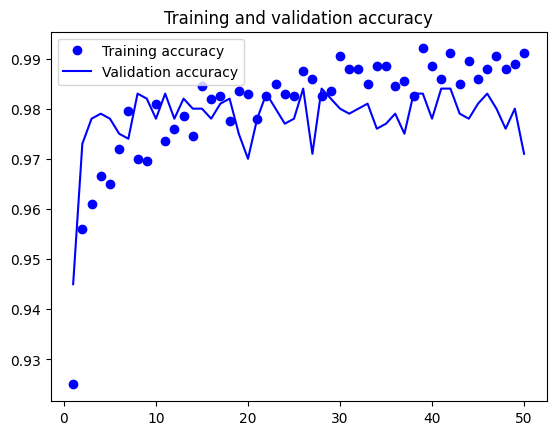

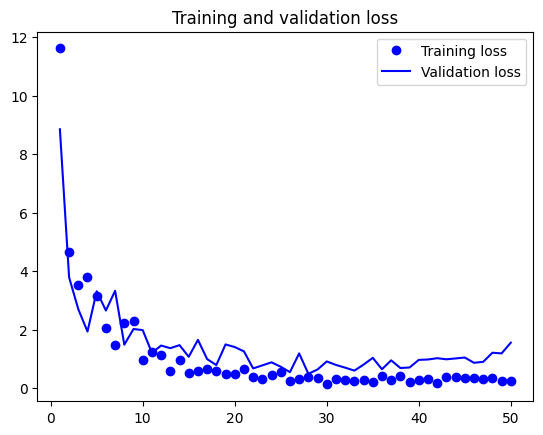

In [69]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

Accuracy test

In [72]:
test_model = keras.models.load_model(
    "./models/feature_extraction_with_data_augmentation")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 12s 190ms/step - loss: 0.8924 - accuracy: 0.9780
Test accuracy: 0.978


Fine-Tuning VGG16

In [91]:
conv_base.summary()


Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [92]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

In [93]:
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 tf.__operators__.getitem (  (None, 180, 180, 3)       0         
 SlicingOpLambda)                                                
                                                                 
 tf.nn.bias_add (TFOpLambda  (None, 180, 180, 3)       0         
 )                                                               
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 flatten_5 (Flatten)         (None, 12800)             0   

In [95]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

In [97]:
import numpy as np

def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)

1/1 [==============================] - 0s 10ms/step


In [98]:
train_features.shape

(2000, 5, 5, 512)

In [99]:
inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

In [100]:
model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 5, 5, 512)]       0         
                                                                 
 flatten_6 (Flatten)         (None, 12800)             0         
                                                                 
 dense_9 (Dense)             (None, 256)               3277056   
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                                 
 dense_10 (Dense)            (None, 1)                 257       
                                                                 
Total params: 3277313 (12.50 MB)
Trainable params: 3277313 (12.50 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [102]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
      filepath="./models/feature_extraction",
      save_best_only=True,
      monitor="val_loss")
]
history = model.fit(
    train_features, train_labels,
    epochs=20,
    validation_data=(val_features, val_labels),
    callbacks=callbacks)


Epoch 1/20
63/63 [==============================] - ETA: 0s - loss: 4.8105 - accuracy: 0.9715INFO:tensorflow:Assets written to: ./models/feature_extraction/assets


INFO:tensorflow:Assets written to: ./models/feature_extraction/assets


63/63 [==============================] - 2s 19ms/step - loss: 4.8105 - accuracy: 0.9715 - val_loss: 5.7753 - val_accuracy: 0.9650
Epoch 2/20
63/63 [==============================] - 1s 10ms/step - loss: 2.7323 - accuracy: 0.9795 - val_loss: 8.2243 - val_accuracy: 0.9670
Epoch 3/20
63/63 [==============================] - 1s 10ms/step - loss: 1.6677 - accuracy: 0.9890 - val_loss: 11.1357 - val_accuracy: 0.9540
Epoch 4/20
62/63 [============================>.] - ETA: 0s - loss: 1.2351 - accuracy: 0.9904INFO:tensorflow:Assets written to: ./models/feature_extraction/assets


INFO:tensorflow:Assets written to: ./models/feature_extraction/assets


63/63 [==============================] - 1s 21ms/step - loss: 1.2252 - accuracy: 0.9905 - val_loss: 5.3300 - val_accuracy: 0.9760
Epoch 5/20
63/63 [==============================] - 1s 11ms/step - loss: 0.3472 - accuracy: 0.9955 - val_loss: 6.0553 - val_accuracy: 0.9680
Epoch 6/20
63/63 [==============================] - 1s 10ms/step - loss: 0.4681 - accuracy: 0.9955 - val_loss: 5.8588 - val_accuracy: 0.9740
Epoch 7/20
63/63 [==============================] - 1s 10ms/step - loss: 0.7723 - accuracy: 0.9930 - val_loss: 8.3973 - val_accuracy: 0.9680
Epoch 8/20
63/63 [==============================] - 1s 11ms/step - loss: 0.3913 - accuracy: 0.9965 - val_loss: 6.3292 - val_accuracy: 0.9710
Epoch 9/20
63/63 [==============================] - 1s 10ms/step - loss: 0.4170 - accuracy: 0.9960 - val_loss: 5.8137 - val_accuracy: 0.9730
Epoch 10/20
63/63 [==============================] - 1s 9ms/step - loss: 0.3409 - accuracy: 0.9965 - val_loss: 6.7391 - val_accuracy: 0.9710
Epoch 11/20
63/63 [=====

INFO:tensorflow:Assets written to: ./models/feature_extraction/assets


63/63 [==============================] - 1s 14ms/step - loss: 0.3219 - accuracy: 0.9985 - val_loss: 4.9939 - val_accuracy: 0.9760
Epoch 12/20
63/63 [==============================] - 1s 9ms/step - loss: 0.0705 - accuracy: 0.9990 - val_loss: 5.4859 - val_accuracy: 0.9730
Epoch 13/20
63/63 [==============================] - 1s 11ms/step - loss: 0.2911 - accuracy: 0.9975 - val_loss: 9.5548 - val_accuracy: 0.9660
Epoch 14/20
63/63 [==============================] - 1s 8ms/step - loss: 0.1064 - accuracy: 0.9990 - val_loss: 5.1872 - val_accuracy: 0.9720
Epoch 15/20
63/63 [==============================] - 1s 9ms/step - loss: 0.0500 - accuracy: 0.9985 - val_loss: 6.4353 - val_accuracy: 0.9750
Epoch 16/20
63/63 [==============================] - 1s 9ms/step - loss: 0.1629 - accuracy: 0.9980 - val_loss: 6.7149 - val_accuracy: 0.9750
Epoch 17/20
63/63 [==============================] - 1s 9ms/step - loss: 0.1962 - accuracy: 0.9980 - val_loss: 6.4924 - val_accuracy: 0.9750
Epoch 18/20
63/63 [====

Plotting the results 

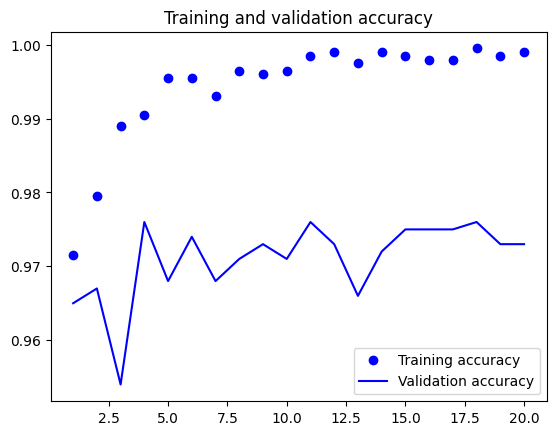

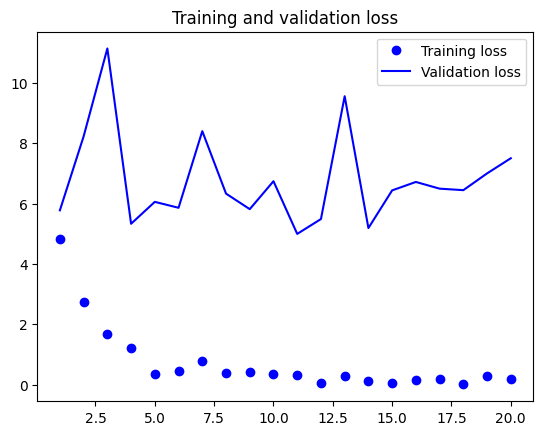

In [104]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

Performance Matrix

the results

In [40]:
test_model = keras.models.load_model(
    "./models/feature_extraction")
test_loss, test_acc = test_model.evaluate(x=test_features, y=test_labels)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 0s 4ms/step - loss: 4.8902 - accuracy: 0.9710
Test accuracy: 0.971


Feature Extraction with Data Augmentation

In [41]:
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [42]:
conv_base.trainable = False
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [43]:

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential_2 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 tf.__operators__.getitem_1  (None, 180, 180, 3)       0         
  (SlicingOpLambda)                                              
                                                                 
 tf.nn.bias_add_1 (TFOpLamb  (None, 180, 180, 3)       0         
 da)                                                             
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 flatten_4 (Flatten)         (None, 12800)             0   

In [114]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="./models/feature_extraction_with_data_augmentation",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/50


2024-12-03 23:03:54.450555: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 1:03 - loss: 24.7524 - accuracy: 0.9062

2024-12-03 23:03:54.931622: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 13s - loss: 25.7573 - accuracy: 0.8750 

2024-12-03 23:03:55.149652: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 13s - loss: 23.4204 - accuracy: 0.8646

2024-12-03 23:03:55.366198: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 12s - loss: 23.0748 - accuracy: 0.8750

2024-12-03 23:03:55.582927: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 12s - loss: 22.2468 - accuracy: 0.8687

2024-12-03 23:03:55.796213: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 12s - loss: 20.1106 - accuracy: 0.8646

2024-12-03 23:03:56.010696: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 12s - loss: 27.7876 - accuracy: 0.8661

2024-12-03 23:03:56.223014: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 11s - loss: 24.3141 - accuracy: 0.8828

2024-12-03 23:03:56.439275: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 11s - loss: 23.7319 - accuracy: 0.8854

2024-12-03 23:03:56.655476: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 11s - loss: 21.8297 - accuracy: 0.8906

2024-12-03 23:03:56.908131: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 11s - loss: 20.0300 - accuracy: 0.8977

2024-12-03 23:03:57.121424: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 11s - loss: 18.7241 - accuracy: 0.9010

2024-12-03 23:03:57.352213: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 10s - loss: 17.5599 - accuracy: 0.9038

2024-12-03 23:03:57.564943: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 10s - loss: 16.6491 - accuracy: 0.9085

2024-12-03 23:03:57.780631: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 10s - loss: 15.5850 - accuracy: 0.9125

2024-12-03 23:03:57.993358: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 10s - loss: 14.6394 - accuracy: 0.9160

2024-12-03 23:03:58.206844: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 10s - loss: 13.9603 - accuracy: 0.9191

2024-12-03 23:03:58.420750: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 9s - loss: 14.2225 - accuracy: 0.9184 

2024-12-03 23:03:58.637014: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 9s - loss: 13.8272 - accuracy: 0.9178

2024-12-03 23:03:58.848183: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 9s - loss: 13.5343 - accuracy: 0.9203

2024-12-03 23:03:59.063463: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 9s - loss: 13.4383 - accuracy: 0.9196

2024-12-03 23:03:59.277444: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 8s - loss: 13.3046 - accuracy: 0.9219

2024-12-03 23:03:59.491215: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 8s - loss: 12.9176 - accuracy: 0.9239

2024-12-03 23:03:59.705450: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 8s - loss: 13.0041 - accuracy: 0.9232

2024-12-03 23:03:59.922912: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 8s - loss: 12.7115 - accuracy: 0.9237

2024-12-03 23:04:00.153222: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 8s - loss: 12.3238 - accuracy: 0.9255

2024-12-03 23:04:00.397132: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 7s - loss: 12.4907 - accuracy: 0.9259

2024-12-03 23:04:00.609757: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 7s - loss: 12.8165 - accuracy: 0.9241

2024-12-03 23:04:00.822962: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 7s - loss: 12.6795 - accuracy: 0.9224

2024-12-03 23:04:01.039732: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 7s - loss: 12.6748 - accuracy: 0.9229

2024-12-03 23:04:01.257128: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 6s - loss: 12.4545 - accuracy: 0.9234

2024-12-03 23:04:01.471815: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 6s - loss: 12.0653 - accuracy: 0.9258

2024-12-03 23:04:01.683842: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 6s - loss: 12.1356 - accuracy: 0.9252

2024-12-03 23:04:01.916293: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 6s - loss: 11.9058 - accuracy: 0.9265

2024-12-03 23:04:02.200236: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 6s - loss: 11.7485 - accuracy: 0.9268

2024-12-03 23:04:02.426880: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 5s - loss: 11.4647 - accuracy: 0.9280

2024-12-03 23:04:02.642208: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 5s - loss: 11.1969 - accuracy: 0.9291

2024-12-03 23:04:02.855216: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 5s - loss: 11.2382 - accuracy: 0.9285

2024-12-03 23:04:03.069971: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 5s - loss: 10.9737 - accuracy: 0.9295

2024-12-03 23:04:03.283848: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 5s - loss: 10.9083 - accuracy: 0.9297

2024-12-03 23:04:03.523818: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 4s - loss: 10.7167 - accuracy: 0.9306

2024-12-03 23:04:03.756062: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 4s - loss: 10.4615 - accuracy: 0.9323

2024-12-03 23:04:03.975427: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 4s - loss: 10.4166 - accuracy: 0.9317

2024-12-03 23:04:04.190146: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 4s - loss: 10.2241 - accuracy: 0.9325

2024-12-03 23:04:04.406224: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 3s - loss: 9.9969 - accuracy: 0.9340 

2024-12-03 23:04:04.622729: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 3s - loss: 10.1331 - accuracy: 0.9341

2024-12-03 23:04:04.839413: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 3s - loss: 10.2041 - accuracy: 0.9335

2024-12-03 23:04:05.054307: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 3s - loss: 9.9915 - accuracy: 0.9349 

2024-12-03 23:04:05.271669: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 3s - loss: 9.8988 - accuracy: 0.9356

2024-12-03 23:04:05.489244: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 2s - loss: 9.8986 - accuracy: 0.9350

2024-12-03 23:04:05.716768: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 2s - loss: 9.7164 - accuracy: 0.9357

2024-12-03 23:04:05.931332: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 2s - loss: 9.5810 - accuracy: 0.9363

2024-12-03 23:04:06.148140: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 2s - loss: 9.6490 - accuracy: 0.9357

2024-12-03 23:04:06.362192: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 1s - loss: 9.8156 - accuracy: 0.9334

2024-12-03 23:04:06.574938: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 1s - loss: 9.6887 - accuracy: 0.9335

2024-12-03 23:04:06.791745: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 1s - loss: 9.5204 - accuracy: 0.9342

2024-12-03 23:04:07.003571: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 1s - loss: 9.4084 - accuracy: 0.9348

2024-12-03 23:04:07.215652: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 1s - loss: 9.3900 - accuracy: 0.9348

2024-12-03 23:04:07.428600: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 0s - loss: 9.5697 - accuracy: 0.9338

2024-12-03 23:04:07.647910: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 9.4858 - accuracy: 0.9344

2024-12-03 23:04:07.858854: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 9.9247 - accuracy: 0.9319

2024-12-03 23:04:08.069500: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 10.1667 - accuracy: 0.9320

2024-12-03 23:04:08.279427: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 10.1058 - accuracy: 0.9320INFO:tensorflow:Assets written to: ./models/feature_extraction_with_data_augmentation/assets


INFO:tensorflow:Assets written to: ./models/feature_extraction_with_data_augmentation/assets


63/63 [==============================] - 23s 348ms/step - loss: 10.1058 - accuracy: 0.9320 - val_loss: 2.9922 - val_accuracy: 0.9710
Epoch 2/50


2024-12-03 23:04:16.479691: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 19s - loss: 1.6284 - accuracy: 0.9688

2024-12-03 23:04:16.792545: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 13s - loss: 0.8142 - accuracy: 0.9844

2024-12-03 23:04:17.008799: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 12s - loss: 0.9289 - accuracy: 0.9792

2024-12-03 23:04:17.223366: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 12s - loss: 4.0752 - accuracy: 0.9688

2024-12-03 23:04:17.441623: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 12s - loss: 4.8634 - accuracy: 0.9625

2024-12-03 23:04:17.662758: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 12s - loss: 4.1991 - accuracy: 0.9635

2024-12-03 23:04:17.882044: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 12s - loss: 3.5992 - accuracy: 0.9688

2024-12-03 23:04:18.100478: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 11s - loss: 3.2353 - accuracy: 0.9688

2024-12-03 23:04:18.320388: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 11s - loss: 3.2807 - accuracy: 0.9688

2024-12-03 23:04:18.537446: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 11s - loss: 4.4573 - accuracy: 0.9594

2024-12-03 23:04:18.755834: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 11s - loss: 4.0521 - accuracy: 0.9631

2024-12-03 23:04:18.973769: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 11s - loss: 5.0070 - accuracy: 0.9557

2024-12-03 23:04:19.234846: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 11s - loss: 5.8617 - accuracy: 0.9519

2024-12-03 23:04:19.449304: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 10s - loss: 7.1298 - accuracy: 0.9464

2024-12-03 23:04:19.665946: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 10s - loss: 7.3155 - accuracy: 0.9458

2024-12-03 23:04:19.884685: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 10s - loss: 7.1029 - accuracy: 0.9453

2024-12-03 23:04:20.099202: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 10s - loss: 6.7506 - accuracy: 0.9467

2024-12-03 23:04:20.317398: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 9s - loss: 6.6507 - accuracy: 0.9462 

2024-12-03 23:04:20.535743: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 9s - loss: 6.8366 - accuracy: 0.9457

2024-12-03 23:04:20.753023: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 9s - loss: 6.7519 - accuracy: 0.9469

2024-12-03 23:04:20.969784: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 9s - loss: 7.0690 - accuracy: 0.9464

2024-12-03 23:04:21.184022: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 8s - loss: 6.8683 - accuracy: 0.9474

2024-12-03 23:04:21.399829: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 8s - loss: 7.3702 - accuracy: 0.9484

2024-12-03 23:04:21.635153: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 8s - loss: 7.3273 - accuracy: 0.9479

2024-12-03 23:04:21.846945: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 8s - loss: 7.0342 - accuracy: 0.9500

2024-12-03 23:04:22.072941: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 8s - loss: 7.3047 - accuracy: 0.9483

2024-12-03 23:04:22.326585: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 7s - loss: 7.3295 - accuracy: 0.9468

2024-12-03 23:04:22.544921: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 7s - loss: 7.2098 - accuracy: 0.9475

2024-12-03 23:04:22.758075: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 7s - loss: 7.1875 - accuracy: 0.9450

2024-12-03 23:04:22.975421: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 7s - loss: 7.5097 - accuracy: 0.9448

2024-12-03 23:04:23.191565: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 7s - loss: 7.7953 - accuracy: 0.9435

2024-12-03 23:04:23.408415: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 6s - loss: 7.5517 - accuracy: 0.9453

2024-12-03 23:04:23.636817: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 6s - loss: 7.3783 - accuracy: 0.9460

2024-12-03 23:04:23.851450: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 6s - loss: 7.2609 - accuracy: 0.9467

2024-12-03 23:04:24.067407: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 6s - loss: 7.0535 - accuracy: 0.9482

2024-12-03 23:04:24.283240: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 5s - loss: 7.0857 - accuracy: 0.9479

2024-12-03 23:04:24.503598: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 5s - loss: 6.8942 - accuracy: 0.9493

2024-12-03 23:04:24.719667: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 5s - loss: 6.8433 - accuracy: 0.9490

2024-12-03 23:04:24.937049: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 5s - loss: 6.8897 - accuracy: 0.9487

2024-12-03 23:04:25.153467: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 5s - loss: 7.0959 - accuracy: 0.9484

2024-12-03 23:04:25.366670: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 4s - loss: 6.9228 - accuracy: 0.9497

2024-12-03 23:04:25.586674: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 4s - loss: 7.0496 - accuracy: 0.9487

2024-12-03 23:04:25.800702: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 4s - loss: 7.1845 - accuracy: 0.9477

2024-12-03 23:04:26.017854: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 4s - loss: 7.1188 - accuracy: 0.9482

2024-12-03 23:04:26.231565: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 3s - loss: 6.9747 - accuracy: 0.9479

2024-12-03 23:04:26.449950: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 3s - loss: 6.8230 - accuracy: 0.9490

2024-12-03 23:04:26.667931: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 3s - loss: 6.6779 - accuracy: 0.9501

2024-12-03 23:04:26.882231: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 3s - loss: 6.9817 - accuracy: 0.9499

2024-12-03 23:04:27.099771: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 3s - loss: 6.8425 - accuracy: 0.9503

2024-12-03 23:04:27.314230: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 2s - loss: 6.7490 - accuracy: 0.9506

2024-12-03 23:04:27.533676: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 2s - loss: 6.7671 - accuracy: 0.9498

2024-12-03 23:04:27.792560: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 2s - loss: 6.7106 - accuracy: 0.9495

2024-12-03 23:04:28.006584: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 2s - loss: 6.8892 - accuracy: 0.9493

2024-12-03 23:04:28.225381: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 1s - loss: 6.7616 - accuracy: 0.9502

2024-12-03 23:04:28.436890: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 1s - loss: 7.1045 - accuracy: 0.9483

2024-12-03 23:04:28.648160: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 1s - loss: 7.3224 - accuracy: 0.9459

2024-12-03 23:04:28.864253: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 1s - loss: 7.2519 - accuracy: 0.9457

2024-12-03 23:04:29.077101: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 1s - loss: 7.1269 - accuracy: 0.9467

2024-12-03 23:04:29.289023: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 0s - loss: 7.0061 - accuracy: 0.9476

2024-12-03 23:04:29.500158: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 6.9031 - accuracy: 0.9479

2024-12-03 23:04:29.711995: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 6.8136 - accuracy: 0.9477

2024-12-03 23:04:29.924308: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 6.6900 - accuracy: 0.9485

2024-12-03 23:04:30.135640: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 20s 312ms/step - loss: 6.6900 - accuracy: 0.9485 - val_loss: 4.8599 - val_accuracy: 0.9710
Epoch 3/50


2024-12-03 23:04:36.163493: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 17s - loss: 21.1893 - accuracy: 0.9375

2024-12-03 23:04:36.447876: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 13s - loss: 14.9768 - accuracy: 0.9531

2024-12-03 23:04:36.662329: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 12s - loss: 11.0450 - accuracy: 0.9583

2024-12-03 23:04:36.880892: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 12s - loss: 8.2837 - accuracy: 0.9688 

2024-12-03 23:04:37.094488: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 12s - loss: 6.6270 - accuracy: 0.9750

2024-12-03 23:04:37.312189: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 12s - loss: 6.7480 - accuracy: 0.9740

2024-12-03 23:04:37.526929: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 12s - loss: 5.8561 - accuracy: 0.9732

2024-12-03 23:04:37.743553: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 11s - loss: 5.3129 - accuracy: 0.9648

2024-12-03 23:04:37.959498: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 11s - loss: 4.7225 - accuracy: 0.9688

2024-12-03 23:04:38.177789: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 11s - loss: 4.2503 - accuracy: 0.9719

2024-12-03 23:04:38.394696: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 11s - loss: 5.5904 - accuracy: 0.9716

2024-12-03 23:04:38.613809: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 11s - loss: 6.0598 - accuracy: 0.9714

2024-12-03 23:04:38.827865: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 10s - loss: 5.8431 - accuracy: 0.9712

2024-12-03 23:04:39.045305: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 10s - loss: 5.9800 - accuracy: 0.9710

2024-12-03 23:04:39.314397: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 10s - loss: 6.5040 - accuracy: 0.9667

2024-12-03 23:04:39.531632: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 10s - loss: 6.0975 - accuracy: 0.9688

2024-12-03 23:04:39.749830: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 10s - loss: 5.9341 - accuracy: 0.9688

2024-12-03 23:04:39.965466: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 9s - loss: 5.6058 - accuracy: 0.9688 

2024-12-03 23:04:40.181499: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 9s - loss: 5.3108 - accuracy: 0.9704

2024-12-03 23:04:40.400324: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 9s - loss: 5.0453 - accuracy: 0.9719

2024-12-03 23:04:40.618862: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 9s - loss: 4.9497 - accuracy: 0.9717

2024-12-03 23:04:40.837874: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 9s - loss: 4.7247 - accuracy: 0.9730

2024-12-03 23:04:41.072827: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 8s - loss: 4.7578 - accuracy: 0.9728

2024-12-03 23:04:41.286271: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 8s - loss: 4.5596 - accuracy: 0.9740

2024-12-03 23:04:41.506813: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 8s - loss: 4.6781 - accuracy: 0.9712

2024-12-03 23:04:41.724668: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 8s - loss: 4.4982 - accuracy: 0.9724

2024-12-03 23:04:41.984774: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 7s - loss: 4.3742 - accuracy: 0.9722

2024-12-03 23:04:42.210357: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 7s - loss: 4.4641 - accuracy: 0.9721

2024-12-03 23:04:42.430368: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 7s - loss: 4.6551 - accuracy: 0.9709

2024-12-03 23:04:42.645986: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 7s - loss: 5.1052 - accuracy: 0.9698

2024-12-03 23:04:42.883713: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 7s - loss: 4.9405 - accuracy: 0.9708

2024-12-03 23:04:43.098783: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 6s - loss: 4.7862 - accuracy: 0.9717

2024-12-03 23:04:43.321015: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 6s - loss: 4.6411 - accuracy: 0.9725

2024-12-03 23:04:43.538853: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 6s - loss: 4.6269 - accuracy: 0.9724

2024-12-03 23:04:43.761736: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 6s - loss: 4.5034 - accuracy: 0.9723

2024-12-03 23:04:43.980029: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 5s - loss: 4.4011 - accuracy: 0.9722

2024-12-03 23:04:44.199235: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 5s - loss: 4.5651 - accuracy: 0.9713

2024-12-03 23:04:44.433972: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 5s - loss: 4.4450 - accuracy: 0.9720

2024-12-03 23:04:44.653548: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 5s - loss: 4.3796 - accuracy: 0.9720

2024-12-03 23:04:44.919726: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 5s - loss: 4.3297 - accuracy: 0.9719

2024-12-03 23:04:45.136695: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 4s - loss: 4.4165 - accuracy: 0.9703

2024-12-03 23:04:45.355462: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 4s - loss: 4.4934 - accuracy: 0.9695

2024-12-03 23:04:45.578373: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 4s - loss: 4.4543 - accuracy: 0.9688

2024-12-03 23:04:45.800127: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 4s - loss: 4.3530 - accuracy: 0.9695

2024-12-03 23:04:46.020951: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 4s - loss: 4.3068 - accuracy: 0.9694

2024-12-03 23:04:46.243766: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 3s - loss: 4.4921 - accuracy: 0.9688

2024-12-03 23:04:46.479299: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 3s - loss: 4.4318 - accuracy: 0.9688

2024-12-03 23:04:46.704864: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 3s - loss: 4.4585 - accuracy: 0.9688

2024-12-03 23:04:46.929478: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 3s - loss: 4.4197 - accuracy: 0.9681

2024-12-03 23:04:47.147103: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 2s - loss: 4.3351 - accuracy: 0.9681

2024-12-03 23:04:47.370188: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 2s - loss: 4.3153 - accuracy: 0.9681

2024-12-03 23:04:47.594192: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 2s - loss: 4.3082 - accuracy: 0.9681

2024-12-03 23:04:47.819337: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 2s - loss: 4.4735 - accuracy: 0.9664

2024-12-03 23:04:48.040244: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 2s - loss: 4.5947 - accuracy: 0.9653

2024-12-03 23:04:48.257631: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 1s - loss: 4.6136 - accuracy: 0.9642

2024-12-03 23:04:48.476133: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 1s - loss: 4.6897 - accuracy: 0.9637

2024-12-03 23:04:48.698110: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 1s - loss: 4.6317 - accuracy: 0.9638

2024-12-03 23:04:48.917228: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 1s - loss: 4.5733 - accuracy: 0.9639

2024-12-03 23:04:49.137695: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 0s - loss: 4.6501 - accuracy: 0.9619

2024-12-03 23:04:49.355474: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 4.5856 - accuracy: 0.9620

2024-12-03 23:04:49.578315: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 4.7344 - accuracy: 0.9616

2024-12-03 23:04:49.796743: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 4.6208 - accuracy: 0.9625

2024-12-03 23:04:50.015382: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


INFO:tensorflow:Assets written to: ./models/feature_extraction_with_data_augmentation/assets


INFO:tensorflow:Assets written to: ./models/feature_extraction_with_data_augmentation/assets


63/63 [==============================] - 22s 355ms/step - loss: 4.6208 - accuracy: 0.9625 - val_loss: 2.7453 - val_accuracy: 0.9830
Epoch 4/50


2024-12-03 23:04:58.470877: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 18s - loss: 17.6109 - accuracy: 0.8438

2024-12-03 23:04:58.772693: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 12s - loss: 8.8055 - accuracy: 0.9219 

2024-12-03 23:04:58.985442: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 12s - loss: 7.9170 - accuracy: 0.9375

2024-12-03 23:04:59.201337: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 12s - loss: 7.6363 - accuracy: 0.9453

2024-12-03 23:04:59.421425: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 12s - loss: 7.5426 - accuracy: 0.9438

2024-12-03 23:04:59.642631: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 12s - loss: 8.7736 - accuracy: 0.9375

2024-12-03 23:04:59.862904: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 12s - loss: 8.2217 - accuracy: 0.9330

2024-12-03 23:05:00.083286: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 12s - loss: 7.1940 - accuracy: 0.9414

2024-12-03 23:05:00.302873: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 11s - loss: 6.9324 - accuracy: 0.9444

2024-12-03 23:05:00.521177: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 11s - loss: 6.2392 - accuracy: 0.9500

2024-12-03 23:05:00.742908: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 11s - loss: 5.8078 - accuracy: 0.9489

2024-12-03 23:05:00.963813: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 11s - loss: 5.3589 - accuracy: 0.9505

2024-12-03 23:05:01.185669: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 10s - loss: 4.9467 - accuracy: 0.9543

2024-12-03 23:05:01.404528: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 10s - loss: 4.9834 - accuracy: 0.9487

2024-12-03 23:05:01.643802: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 10s - loss: 5.5800 - accuracy: 0.9458

2024-12-03 23:05:01.864969: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 10s - loss: 5.4527 - accuracy: 0.9453

2024-12-03 23:05:02.086862: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 10s - loss: 5.2498 - accuracy: 0.9467

2024-12-03 23:05:02.352996: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 10s - loss: 4.9582 - accuracy: 0.9497

2024-12-03 23:05:02.571719: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 9s - loss: 5.1188 - accuracy: 0.9474 

2024-12-03 23:05:02.797690: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 9s - loss: 4.9581 - accuracy: 0.9484

2024-12-03 23:05:03.019413: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 9s - loss: 4.7429 - accuracy: 0.9494

2024-12-03 23:05:03.245563: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 9s - loss: 4.8734 - accuracy: 0.9489

2024-12-03 23:05:03.467882: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 8s - loss: 4.7165 - accuracy: 0.9497

2024-12-03 23:05:03.690740: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 8s - loss: 4.6540 - accuracy: 0.9505

2024-12-03 23:05:03.914636: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 8s - loss: 4.5206 - accuracy: 0.9513

2024-12-03 23:05:04.138921: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 8s - loss: 4.3487 - accuracy: 0.9519

2024-12-03 23:05:04.419056: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 8s - loss: 4.1876 - accuracy: 0.9537

2024-12-03 23:05:04.647896: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 7s - loss: 4.1412 - accuracy: 0.9542

2024-12-03 23:05:04.871717: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 7s - loss: 4.0312 - accuracy: 0.9547

2024-12-03 23:05:05.097230: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 7s - loss: 3.9571 - accuracy: 0.9552

2024-12-03 23:05:05.322931: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 7s - loss: 4.1415 - accuracy: 0.9546

2024-12-03 23:05:05.547389: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 7s - loss: 4.0369 - accuracy: 0.9551

2024-12-03 23:05:05.777046: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 6s - loss: 3.9145 - accuracy: 0.9564

2024-12-03 23:05:06.002303: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 6s - loss: 3.8460 - accuracy: 0.9568

2024-12-03 23:05:06.226779: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 6s - loss: 3.8457 - accuracy: 0.9571

2024-12-03 23:05:06.453413: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 6s - loss: 3.9279 - accuracy: 0.9557

2024-12-03 23:05:06.679271: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 5s - loss: 3.8371 - accuracy: 0.9561

2024-12-03 23:05:06.906562: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 5s - loss: 3.7361 - accuracy: 0.9572

2024-12-03 23:05:07.190074: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 5s - loss: 3.8098 - accuracy: 0.9559

2024-12-03 23:05:07.418754: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 5s - loss: 3.8632 - accuracy: 0.9555

2024-12-03 23:05:07.644929: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 5s - loss: 3.7690 - accuracy: 0.9566

2024-12-03 23:05:07.870401: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 4s - loss: 3.7363 - accuracy: 0.9568

2024-12-03 23:05:08.098623: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 4s - loss: 3.7012 - accuracy: 0.9564

2024-12-03 23:05:08.325753: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 4s - loss: 3.6171 - accuracy: 0.9574

2024-12-03 23:05:08.554056: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 4s - loss: 3.6206 - accuracy: 0.9576

2024-12-03 23:05:08.801399: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 3s - loss: 3.8595 - accuracy: 0.9572

2024-12-03 23:05:09.034947: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 3s - loss: 3.8167 - accuracy: 0.9574

2024-12-03 23:05:09.261332: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 3s - loss: 3.9109 - accuracy: 0.9570

2024-12-03 23:05:09.488679: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 3s - loss: 3.8695 - accuracy: 0.9573

2024-12-03 23:05:09.769162: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 2s - loss: 3.8064 - accuracy: 0.9575

2024-12-03 23:05:09.998114: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 2s - loss: 3.7515 - accuracy: 0.9577

2024-12-03 23:05:10.224044: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 2s - loss: 3.7085 - accuracy: 0.9579

2024-12-03 23:05:10.452344: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 2s - loss: 3.6385 - accuracy: 0.9587

2024-12-03 23:05:10.682345: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 2s - loss: 3.5712 - accuracy: 0.9595

2024-12-03 23:05:10.905316: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 1s - loss: 3.6979 - accuracy: 0.9591

2024-12-03 23:05:11.131427: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 1s - loss: 3.6318 - accuracy: 0.9598

2024-12-03 23:05:11.401418: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 1s - loss: 3.5681 - accuracy: 0.9605

2024-12-03 23:05:11.624281: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 1s - loss: 3.5066 - accuracy: 0.9612

2024-12-03 23:05:11.849025: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 0s - loss: 3.6228 - accuracy: 0.9613

2024-12-03 23:05:12.079452: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 3.7428 - accuracy: 0.9609

2024-12-03 23:05:12.303463: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 3.7424 - accuracy: 0.9611

2024-12-03 23:05:12.525407: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 3.6526 - accuracy: 0.9620

2024-12-03 23:05:12.744091: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 21s 331ms/step - loss: 3.6526 - accuracy: 0.9620 - val_loss: 3.9252 - val_accuracy: 0.9740
Epoch 5/50


2024-12-03 23:05:19.299591: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 18s - loss: 12.6557 - accuracy: 0.9062

2024-12-03 23:05:19.591397: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 13s - loss: 7.5754 - accuracy: 0.9219 

2024-12-03 23:05:19.814677: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 13s - loss: 5.3688 - accuracy: 0.9375

2024-12-03 23:05:20.038517: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 13s - loss: 5.4476 - accuracy: 0.9375

2024-12-03 23:05:20.265661: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 13s - loss: 5.0102 - accuracy: 0.9438

2024-12-03 23:05:20.489947: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 12s - loss: 4.1752 - accuracy: 0.9531

2024-12-03 23:05:20.714684: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 12s - loss: 4.9455 - accuracy: 0.9554

2024-12-03 23:05:20.940915: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 12s - loss: 5.0233 - accuracy: 0.9492

2024-12-03 23:05:21.165158: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 12s - loss: 4.6319 - accuracy: 0.9514

2024-12-03 23:05:21.393697: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 11s - loss: 4.2868 - accuracy: 0.9531

2024-12-03 23:05:21.618867: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 11s - loss: 4.2226 - accuracy: 0.9545

2024-12-03 23:05:21.842793: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 11s - loss: 4.2791 - accuracy: 0.9531

2024-12-03 23:05:22.068307: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 11s - loss: 3.9500 - accuracy: 0.9567

2024-12-03 23:05:22.307358: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 11s - loss: 4.1947 - accuracy: 0.9554

2024-12-03 23:05:22.536513: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 10s - loss: 4.1312 - accuracy: 0.9563

2024-12-03 23:05:22.761750: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 10s - loss: 3.8979 - accuracy: 0.9570

2024-12-03 23:05:22.986803: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 10s - loss: 3.8282 - accuracy: 0.9577

2024-12-03 23:05:23.214492: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 10s - loss: 3.6249 - accuracy: 0.9583

2024-12-03 23:05:23.446530: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 9s - loss: 3.4341 - accuracy: 0.9605 

2024-12-03 23:05:23.685879: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 9s - loss: 3.3356 - accuracy: 0.9609

2024-12-03 23:05:23.919926: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 9s - loss: 3.1986 - accuracy: 0.9613

2024-12-03 23:05:24.146934: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 9s - loss: 3.2099 - accuracy: 0.9616

2024-12-03 23:05:24.376681: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 9s - loss: 3.2457 - accuracy: 0.9606

2024-12-03 23:05:24.605090: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 8s - loss: 3.8762 - accuracy: 0.9596

2024-12-03 23:05:24.833763: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 8s - loss: 3.8436 - accuracy: 0.9600

2024-12-03 23:05:25.061534: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 8s - loss: 3.7599 - accuracy: 0.9591

2024-12-03 23:05:25.287935: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 8s - loss: 3.7292 - accuracy: 0.9595

2024-12-03 23:05:25.514719: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 7s - loss: 3.5960 - accuracy: 0.9609

2024-12-03 23:05:25.741562: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 7s - loss: 3.4720 - accuracy: 0.9623

2024-12-03 23:05:25.968354: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 7s - loss: 3.4524 - accuracy: 0.9625

2024-12-03 23:05:26.241751: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 7s - loss: 3.4985 - accuracy: 0.9617

2024-12-03 23:05:26.467599: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 7s - loss: 3.6761 - accuracy: 0.9609

2024-12-03 23:05:26.695451: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 6s - loss: 3.5647 - accuracy: 0.9621

2024-12-03 23:05:26.921705: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 6s - loss: 3.4988 - accuracy: 0.9623

2024-12-03 23:05:27.153322: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 6s - loss: 3.3988 - accuracy: 0.9634

2024-12-03 23:05:27.385587: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 6s - loss: 3.3044 - accuracy: 0.9644

2024-12-03 23:05:27.620012: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 5s - loss: 3.2202 - accuracy: 0.9645

2024-12-03 23:05:27.853274: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 5s - loss: 3.2279 - accuracy: 0.9630

2024-12-03 23:05:28.081394: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 5s - loss: 3.1451 - accuracy: 0.9639

2024-12-03 23:05:28.307799: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 5s - loss: 3.0676 - accuracy: 0.9641

2024-12-03 23:05:28.534953: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 5s - loss: 3.2138 - accuracy: 0.9634

2024-12-03 23:05:28.763072: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 4s - loss: 3.3464 - accuracy: 0.9628

2024-12-03 23:05:28.990392: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 4s - loss: 3.3213 - accuracy: 0.9622

2024-12-03 23:05:29.220037: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 4s - loss: 3.4254 - accuracy: 0.9616

2024-12-03 23:05:29.494867: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 4s - loss: 3.4775 - accuracy: 0.9611

2024-12-03 23:05:29.723321: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 3s - loss: 3.4341 - accuracy: 0.9613

2024-12-03 23:05:29.952077: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 3s - loss: 3.3923 - accuracy: 0.9614

2024-12-03 23:05:30.180605: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 3s - loss: 3.3879 - accuracy: 0.9609

2024-12-03 23:05:30.407255: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 3s - loss: 3.3799 - accuracy: 0.9611

2024-12-03 23:05:30.635603: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 2s - loss: 3.3123 - accuracy: 0.9619

2024-12-03 23:05:30.863466: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 2s - loss: 3.3669 - accuracy: 0.9614

2024-12-03 23:05:31.091354: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 2s - loss: 3.3021 - accuracy: 0.9621

2024-12-03 23:05:31.321560: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 2s - loss: 3.2398 - accuracy: 0.9629

2024-12-03 23:05:31.549830: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 2s - loss: 3.1798 - accuracy: 0.9635

2024-12-03 23:05:31.776632: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 1s - loss: 3.1220 - accuracy: 0.9642

2024-12-03 23:05:32.001616: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 1s - loss: 3.0663 - accuracy: 0.9648

2024-12-03 23:05:32.228560: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 1s - loss: 3.0125 - accuracy: 0.9655

2024-12-03 23:05:32.452959: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 1s - loss: 3.0649 - accuracy: 0.9650

2024-12-03 23:05:32.678075: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 0s - loss: 3.0687 - accuracy: 0.9650

2024-12-03 23:05:32.903026: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 3.0747 - accuracy: 0.9651

2024-12-03 23:05:33.174012: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 3.0314 - accuracy: 0.9652

2024-12-03 23:05:33.395976: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 2.9859 - accuracy: 0.9655

2024-12-03 23:05:33.619550: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 21s 334ms/step - loss: 2.9859 - accuracy: 0.9655 - val_loss: 2.9229 - val_accuracy: 0.9810
Epoch 6/50


2024-12-03 23:05:40.301872: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 18s - loss: 5.8008 - accuracy: 0.9062

2024-12-03 23:05:40.598132: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 14s - loss: 4.1343 - accuracy: 0.9219

2024-12-03 23:05:40.829221: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 13s - loss: 5.8155 - accuracy: 0.9271

2024-12-03 23:05:41.057413: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 13s - loss: 4.4942 - accuracy: 0.9375

2024-12-03 23:05:41.285745: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 13s - loss: 4.3285 - accuracy: 0.9438

2024-12-03 23:05:41.516100: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 13s - loss: 4.5564 - accuracy: 0.9479

2024-12-03 23:05:41.746087: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 12s - loss: 4.3574 - accuracy: 0.9464

2024-12-03 23:05:41.975108: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 12s - loss: 4.1321 - accuracy: 0.9492

2024-12-03 23:05:42.205356: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 12s - loss: 3.6729 - accuracy: 0.9549

2024-12-03 23:05:42.435214: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 12s - loss: 3.3529 - accuracy: 0.9563

2024-12-03 23:05:42.664748: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 11s - loss: 3.7529 - accuracy: 0.9574

2024-12-03 23:05:42.894567: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 11s - loss: 4.4780 - accuracy: 0.9531

2024-12-03 23:05:43.125519: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 11s - loss: 4.4819 - accuracy: 0.9495

2024-12-03 23:05:43.354265: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 11s - loss: 4.5736 - accuracy: 0.9509

2024-12-03 23:05:43.585576: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 11s - loss: 4.2687 - accuracy: 0.9542

2024-12-03 23:05:43.815592: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 10s - loss: 4.0019 - accuracy: 0.9570

2024-12-03 23:05:44.046792: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 10s - loss: 3.9131 - accuracy: 0.9577

2024-12-03 23:05:44.325549: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 10s - loss: 3.7941 - accuracy: 0.9583

2024-12-03 23:05:44.555527: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 10s - loss: 3.9850 - accuracy: 0.9572

2024-12-03 23:05:44.784703: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 9s - loss: 4.6225 - accuracy: 0.9563 

2024-12-03 23:05:45.015070: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 9s - loss: 4.4180 - accuracy: 0.9568

2024-12-03 23:05:45.245954: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 9s - loss: 4.2959 - accuracy: 0.9574

2024-12-03 23:05:45.478488: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 9s - loss: 4.1092 - accuracy: 0.9592

2024-12-03 23:05:45.710906: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 9s - loss: 4.2250 - accuracy: 0.9596

2024-12-03 23:05:45.941525: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 8s - loss: 4.1634 - accuracy: 0.9600

2024-12-03 23:05:46.170596: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 8s - loss: 4.3944 - accuracy: 0.9603

2024-12-03 23:05:46.401974: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 8s - loss: 4.2317 - accuracy: 0.9618

2024-12-03 23:05:46.631608: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 8s - loss: 4.3089 - accuracy: 0.9598

2024-12-03 23:05:46.861575: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 7s - loss: 4.3566 - accuracy: 0.9580

2024-12-03 23:05:47.092171: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 7s - loss: 4.3777 - accuracy: 0.9573

2024-12-03 23:05:47.322926: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 7s - loss: 4.3208 - accuracy: 0.9567

2024-12-03 23:05:47.596824: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 7s - loss: 4.2999 - accuracy: 0.9551

2024-12-03 23:05:47.826660: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 6s - loss: 4.6306 - accuracy: 0.9545

2024-12-03 23:05:48.055759: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 6s - loss: 4.4944 - accuracy: 0.9559

2024-12-03 23:05:48.288154: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 6s - loss: 4.4875 - accuracy: 0.9554

2024-12-03 23:05:48.519174: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 6s - loss: 4.3629 - accuracy: 0.9566

2024-12-03 23:05:48.753304: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 6s - loss: 4.2449 - accuracy: 0.9578

2024-12-03 23:05:48.983800: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 5s - loss: 4.1332 - accuracy: 0.9589

2024-12-03 23:05:49.214629: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 5s - loss: 4.0272 - accuracy: 0.9599

2024-12-03 23:05:49.444828: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 5s - loss: 3.9870 - accuracy: 0.9602

2024-12-03 23:05:49.677473: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 5s - loss: 4.1975 - accuracy: 0.9596

2024-12-03 23:05:49.911785: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 4s - loss: 4.0975 - accuracy: 0.9606

2024-12-03 23:05:50.142569: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 4s - loss: 4.0567 - accuracy: 0.9608

2024-12-03 23:05:50.372725: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 4s - loss: 4.1034 - accuracy: 0.9609

2024-12-03 23:05:50.604811: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 4s - loss: 4.0122 - accuracy: 0.9618

2024-12-03 23:05:50.846626: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 3s - loss: 3.9250 - accuracy: 0.9626

2024-12-03 23:05:51.086706: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 3s - loss: 3.8415 - accuracy: 0.9634

2024-12-03 23:05:51.318698: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 3s - loss: 3.7615 - accuracy: 0.9642

2024-12-03 23:05:51.550173: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 3s - loss: 3.6847 - accuracy: 0.9649

2024-12-03 23:05:51.780646: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 3s - loss: 3.6547 - accuracy: 0.9650

2024-12-03 23:05:52.012373: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 2s - loss: 3.5831 - accuracy: 0.9657

2024-12-03 23:05:52.243466: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 2s - loss: 3.5565 - accuracy: 0.9651

2024-12-03 23:05:52.478067: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 2s - loss: 3.5812 - accuracy: 0.9652

2024-12-03 23:05:52.708311: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 2s - loss: 3.5157 - accuracy: 0.9653

2024-12-03 23:05:52.938771: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 1s - loss: 3.4518 - accuracy: 0.9659

2024-12-03 23:05:53.169736: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 1s - loss: 3.3901 - accuracy: 0.9665

2024-12-03 23:05:53.398325: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 1s - loss: 3.3402 - accuracy: 0.9666

2024-12-03 23:05:53.624545: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 1s - loss: 3.4017 - accuracy: 0.9666

2024-12-03 23:05:53.852948: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 0s - loss: 3.3440 - accuracy: 0.9672

2024-12-03 23:05:54.084390: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 3.2883 - accuracy: 0.9677

2024-12-03 23:05:54.320669: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 3.2690 - accuracy: 0.9667

2024-12-03 23:05:54.557652: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 3.3774 - accuracy: 0.9670

2024-12-03 23:05:54.785615: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 21s 338ms/step - loss: 3.3774 - accuracy: 0.9670 - val_loss: 5.4238 - val_accuracy: 0.9580
Epoch 7/50


2024-12-03 23:06:01.527852: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 19s - loss: 8.4123 - accuracy: 0.9688

2024-12-03 23:06:01.837374: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 14s - loss: 4.2061 - accuracy: 0.9844

2024-12-03 23:06:02.073455: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 14s - loss: 2.8041 - accuracy: 0.9896

2024-12-03 23:06:02.308676: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 14s - loss: 2.1031 - accuracy: 0.9922

2024-12-03 23:06:02.549022: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 13s - loss: 2.7274 - accuracy: 0.9750

2024-12-03 23:06:02.789274: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 13s - loss: 2.2728 - accuracy: 0.9792

2024-12-03 23:06:03.033009: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 13s - loss: 1.9482 - accuracy: 0.9821

2024-12-03 23:06:03.279003: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 13s - loss: 1.7046 - accuracy: 0.9844

2024-12-03 23:06:03.532484: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 13s - loss: 1.5152 - accuracy: 0.9861

2024-12-03 23:06:03.783653: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 13s - loss: 1.6557 - accuracy: 0.9844

2024-12-03 23:06:04.047914: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 12s - loss: 1.9259 - accuracy: 0.9801

2024-12-03 23:06:04.312657: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 12s - loss: 1.7655 - accuracy: 0.9818

2024-12-03 23:06:04.578989: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 12s - loss: 1.6296 - accuracy: 0.9832

2024-12-03 23:06:04.853254: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 12s - loss: 1.8745 - accuracy: 0.9799

2024-12-03 23:06:05.123055: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 12s - loss: 2.0999 - accuracy: 0.9792

2024-12-03 23:06:05.396288: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 11s - loss: 2.1146 - accuracy: 0.9785

2024-12-03 23:06:05.662547: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 11s - loss: 1.9902 - accuracy: 0.9798

2024-12-03 23:06:05.930344: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 11s - loss: 2.2581 - accuracy: 0.9774

2024-12-03 23:06:06.191608: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 11s - loss: 2.1946 - accuracy: 0.9770

2024-12-03 23:06:06.450244: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 11s - loss: 2.1279 - accuracy: 0.9766

2024-12-03 23:06:06.705500: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 10s - loss: 2.1815 - accuracy: 0.9762

2024-12-03 23:06:06.950950: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 10s - loss: 2.0823 - accuracy: 0.9773

2024-12-03 23:06:07.190150: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 10s - loss: 2.0035 - accuracy: 0.9769

2024-12-03 23:06:07.433278: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 9s - loss: 1.9471 - accuracy: 0.9766 

2024-12-03 23:06:07.673987: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 9s - loss: 2.0007 - accuracy: 0.9762

2024-12-03 23:06:07.915926: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 9s - loss: 1.9238 - accuracy: 0.9772

2024-12-03 23:06:08.164933: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 9s - loss: 1.9547 - accuracy: 0.9769

2024-12-03 23:06:08.412063: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 8s - loss: 1.9043 - accuracy: 0.9766

2024-12-03 23:06:08.657681: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 8s - loss: 1.8562 - accuracy: 0.9763

2024-12-03 23:06:08.897189: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 8s - loss: 1.8368 - accuracy: 0.9760

2024-12-03 23:06:09.137555: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 8s - loss: 1.7776 - accuracy: 0.9768

2024-12-03 23:06:09.377410: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 7s - loss: 1.7220 - accuracy: 0.9775

2024-12-03 23:06:09.628214: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 7s - loss: 1.6699 - accuracy: 0.9782

2024-12-03 23:06:09.885624: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 7s - loss: 1.7083 - accuracy: 0.9770

2024-12-03 23:06:10.147924: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 7s - loss: 1.6991 - accuracy: 0.9768

2024-12-03 23:06:10.401575: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 6s - loss: 1.6519 - accuracy: 0.9774

2024-12-03 23:06:10.644377: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 6s - loss: 1.7222 - accuracy: 0.9747

2024-12-03 23:06:10.881592: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 6s - loss: 1.8902 - accuracy: 0.9737

2024-12-03 23:06:11.118268: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 6s - loss: 1.8583 - accuracy: 0.9736

2024-12-03 23:06:11.359503: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 5s - loss: 1.8119 - accuracy: 0.9742

2024-12-03 23:06:11.597131: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 5s - loss: 1.7677 - accuracy: 0.9748

2024-12-03 23:06:11.838593: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 5s - loss: 1.7655 - accuracy: 0.9747

2024-12-03 23:06:12.081837: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 4s - loss: 1.8050 - accuracy: 0.9738

2024-12-03 23:06:12.322269: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 4s - loss: 1.7640 - accuracy: 0.9744

2024-12-03 23:06:12.562796: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 4s - loss: 1.7507 - accuracy: 0.9743

2024-12-03 23:06:12.809306: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 4s - loss: 1.7126 - accuracy: 0.9749

2024-12-03 23:06:13.052123: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 3s - loss: 1.8027 - accuracy: 0.9747

2024-12-03 23:06:13.292669: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 3s - loss: 1.8265 - accuracy: 0.9746

2024-12-03 23:06:13.549043: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 3s - loss: 1.7893 - accuracy: 0.9751

2024-12-03 23:06:13.794043: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 3s - loss: 1.7535 - accuracy: 0.9756

2024-12-03 23:06:14.034318: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 2s - loss: 1.8067 - accuracy: 0.9755

2024-12-03 23:06:14.277392: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 2s - loss: 1.7720 - accuracy: 0.9760

2024-12-03 23:06:14.520759: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 2s - loss: 1.7386 - accuracy: 0.9764

2024-12-03 23:06:14.754158: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 2s - loss: 1.7167 - accuracy: 0.9757

2024-12-03 23:06:15.030013: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 1s - loss: 1.6856 - accuracy: 0.9761

2024-12-03 23:06:15.264782: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 1s - loss: 1.9244 - accuracy: 0.9738

2024-12-03 23:06:15.502838: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 1s - loss: 1.9258 - accuracy: 0.9737

2024-12-03 23:06:15.742732: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 1s - loss: 1.8926 - accuracy: 0.9741

2024-12-03 23:06:15.975833: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 0s - loss: 1.9417 - accuracy: 0.9740

2024-12-03 23:06:16.206670: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 1.9468 - accuracy: 0.9740

2024-12-03 23:06:16.444757: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 1.9149 - accuracy: 0.9744

2024-12-03 23:06:16.678050: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 1.8689 - accuracy: 0.9750

2024-12-03 23:06:16.909689: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


INFO:tensorflow:Assets written to: ./models/feature_extraction_with_data_augmentation/assets


INFO:tensorflow:Assets written to: ./models/feature_extraction_with_data_augmentation/assets


63/63 [==============================] - 24s 385ms/step - loss: 1.8689 - accuracy: 0.9750 - val_loss: 2.1150 - val_accuracy: 0.9810
Epoch 8/50


2024-12-03 23:06:25.687672: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 18s - loss: 3.5694e-05 - accuracy: 1.0000

2024-12-03 23:06:25.992405: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 13s - loss: 1.7847e-05 - accuracy: 1.0000

2024-12-03 23:06:26.207156: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 12s - loss: 0.3358 - accuracy: 0.9792    

2024-12-03 23:06:26.422788: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 12s - loss: 0.7199 - accuracy: 0.9766

2024-12-03 23:06:26.636061: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 12s - loss: 0.9089 - accuracy: 0.9750

2024-12-03 23:06:26.854653: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 12s - loss: 1.5999 - accuracy: 0.9688

2024-12-03 23:06:27.081692: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 12s - loss: 2.2136 - accuracy: 0.9688

2024-12-03 23:06:27.306854: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 12s - loss: 2.7082 - accuracy: 0.9648

2024-12-03 23:06:27.534336: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 11s - loss: 3.1522 - accuracy: 0.9653

2024-12-03 23:06:27.766384: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 11s - loss: 3.1129 - accuracy: 0.9594

2024-12-03 23:06:27.995121: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 11s - loss: 3.4962 - accuracy: 0.9574

2024-12-03 23:06:28.220269: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 11s - loss: 3.2049 - accuracy: 0.9609

2024-12-03 23:06:28.448968: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 11s - loss: 2.9583 - accuracy: 0.9639

2024-12-03 23:06:28.680035: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 11s - loss: 3.1325 - accuracy: 0.9643

2024-12-03 23:06:28.919166: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 10s - loss: 2.9417 - accuracy: 0.9646

2024-12-03 23:06:29.149675: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 10s - loss: 2.7579 - accuracy: 0.9668

2024-12-03 23:06:29.381016: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 10s - loss: 3.0618 - accuracy: 0.9669

2024-12-03 23:06:29.612643: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 10s - loss: 3.0698 - accuracy: 0.9670

2024-12-03 23:06:29.844266: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 9s - loss: 3.1707 - accuracy: 0.9671 

2024-12-03 23:06:30.076577: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 9s - loss: 3.2426 - accuracy: 0.9672

2024-12-03 23:06:30.309435: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 9s - loss: 3.2554 - accuracy: 0.9628

2024-12-03 23:06:30.540326: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 9s - loss: 3.2079 - accuracy: 0.9616

2024-12-03 23:06:30.772126: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 9s - loss: 3.0685 - accuracy: 0.9633

2024-12-03 23:06:31.004726: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 8s - loss: 3.3282 - accuracy: 0.9609

2024-12-03 23:06:31.238612: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 8s - loss: 3.1951 - accuracy: 0.9625

2024-12-03 23:06:31.471222: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 8s - loss: 3.1050 - accuracy: 0.9627

2024-12-03 23:06:31.706962: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 8s - loss: 2.9900 - accuracy: 0.9641

2024-12-03 23:06:31.995106: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 8s - loss: 3.1208 - accuracy: 0.9621

2024-12-03 23:06:32.224582: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 7s - loss: 3.0133 - accuracy: 0.9634

2024-12-03 23:06:32.455653: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 7s - loss: 3.0035 - accuracy: 0.9635

2024-12-03 23:06:32.693281: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 7s - loss: 3.2676 - accuracy: 0.9607

2024-12-03 23:06:32.926465: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 7s - loss: 3.1655 - accuracy: 0.9619

2024-12-03 23:06:33.159804: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 6s - loss: 3.0696 - accuracy: 0.9631

2024-12-03 23:06:33.392271: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 6s - loss: 2.9793 - accuracy: 0.9642

2024-12-03 23:06:33.624896: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 6s - loss: 2.9496 - accuracy: 0.9643

2024-12-03 23:06:33.863219: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 6s - loss: 2.9278 - accuracy: 0.9644

2024-12-03 23:06:34.098372: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 6s - loss: 2.9434 - accuracy: 0.9645

2024-12-03 23:06:34.333322: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 5s - loss: 2.8756 - accuracy: 0.9638

2024-12-03 23:06:34.569800: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 5s - loss: 2.8019 - accuracy: 0.9647

2024-12-03 23:06:34.804899: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 5s - loss: 2.7701 - accuracy: 0.9648

2024-12-03 23:06:35.040417: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 5s - loss: 2.8816 - accuracy: 0.9634

2024-12-03 23:06:35.325936: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 4s - loss: 2.8358 - accuracy: 0.9635

2024-12-03 23:06:35.562295: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 4s - loss: 2.8996 - accuracy: 0.9629

2024-12-03 23:06:35.796744: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 4s - loss: 2.8606 - accuracy: 0.9631

2024-12-03 23:06:36.032650: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 4s - loss: 2.8234 - accuracy: 0.9625

2024-12-03 23:06:36.269474: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 3s - loss: 2.7620 - accuracy: 0.9633

2024-12-03 23:06:36.506857: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 3s - loss: 2.7032 - accuracy: 0.9641

2024-12-03 23:06:36.744055: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 3s - loss: 2.7694 - accuracy: 0.9635

2024-12-03 23:06:36.980782: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 3s - loss: 2.7129 - accuracy: 0.9643

2024-12-03 23:06:37.216714: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 3s - loss: 2.8437 - accuracy: 0.9631

2024-12-03 23:06:37.452168: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 2s - loss: 2.8261 - accuracy: 0.9626

2024-12-03 23:06:37.690858: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 2s - loss: 2.7721 - accuracy: 0.9633

2024-12-03 23:06:37.927634: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 2s - loss: 2.7379 - accuracy: 0.9629

2024-12-03 23:06:38.164368: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 2s - loss: 2.6872 - accuracy: 0.9635

2024-12-03 23:06:38.442615: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 1s - loss: 2.6554 - accuracy: 0.9636

2024-12-03 23:06:38.669714: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 1s - loss: 2.6080 - accuracy: 0.9643

2024-12-03 23:06:38.902988: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 1s - loss: 2.5623 - accuracy: 0.9649

2024-12-03 23:06:39.137761: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 1s - loss: 2.5181 - accuracy: 0.9655

2024-12-03 23:06:39.371217: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 0s - loss: 2.4956 - accuracy: 0.9656

2024-12-03 23:06:39.603798: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 2.5323 - accuracy: 0.9656

2024-12-03 23:06:39.838635: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 2.5427 - accuracy: 0.9657

2024-12-03 23:06:40.073134: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 2.4820 - accuracy: 0.9665

2024-12-03 23:06:40.307482: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 22s 344ms/step - loss: 2.4820 - accuracy: 0.9665 - val_loss: 2.2223 - val_accuracy: 0.9800
Epoch 9/50


2024-12-03 23:06:47.337229: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 20s - loss: 3.8889 - accuracy: 0.9688

2024-12-03 23:06:47.667238: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 15s - loss: 1.9445 - accuracy: 0.9844

2024-12-03 23:06:47.915673: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 15s - loss: 1.2963 - accuracy: 0.9896

2024-12-03 23:06:48.169433: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 14s - loss: 1.9952 - accuracy: 0.9844

2024-12-03 23:06:48.420543: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 14s - loss: 1.6238 - accuracy: 0.9812

2024-12-03 23:06:48.671737: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 14s - loss: 1.9037 - accuracy: 0.9792

2024-12-03 23:06:48.921953: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 14s - loss: 1.6317 - accuracy: 0.9821

2024-12-03 23:06:49.174789: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 13s - loss: 1.5746 - accuracy: 0.9805

2024-12-03 23:06:49.430904: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 13s - loss: 1.3996 - accuracy: 0.9826

2024-12-03 23:06:49.682852: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 13s - loss: 1.8305 - accuracy: 0.9812

2024-12-03 23:06:49.936367: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 13s - loss: 2.1202 - accuracy: 0.9773

2024-12-03 23:06:50.241092: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 13s - loss: 2.0202 - accuracy: 0.9766

2024-12-03 23:06:50.494086: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 12s - loss: 1.8648 - accuracy: 0.9784

2024-12-03 23:06:50.746633: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 12s - loss: 1.7762 - accuracy: 0.9777

2024-12-03 23:06:50.991284: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 12s - loss: 1.9766 - accuracy: 0.9771

2024-12-03 23:06:51.240764: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 11s - loss: 2.0704 - accuracy: 0.9746

2024-12-03 23:06:51.493374: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 11s - loss: 2.3102 - accuracy: 0.9706

2024-12-03 23:06:51.744528: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 11s - loss: 2.6504 - accuracy: 0.9670

2024-12-03 23:06:51.994825: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 11s - loss: 2.9376 - accuracy: 0.9622

2024-12-03 23:06:52.244432: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 10s - loss: 2.9822 - accuracy: 0.9609

2024-12-03 23:06:52.501545: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 10s - loss: 2.9016 - accuracy: 0.9613

2024-12-03 23:06:52.753657: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 10s - loss: 2.7699 - accuracy: 0.9631

2024-12-03 23:06:53.007392: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 10s - loss: 2.8067 - accuracy: 0.9633

2024-12-03 23:06:53.310526: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 10s - loss: 2.8113 - accuracy: 0.9635

2024-12-03 23:06:53.578020: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 9s - loss: 2.6988 - accuracy: 0.9650 

2024-12-03 23:06:53.851974: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 9s - loss: 2.8283 - accuracy: 0.9651

2024-12-03 23:06:54.132382: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 9s - loss: 2.7235 - accuracy: 0.9664

2024-12-03 23:06:54.422281: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 9s - loss: 2.6262 - accuracy: 0.9676

2024-12-03 23:06:54.720868: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 8s - loss: 2.6563 - accuracy: 0.9677

2024-12-03 23:06:55.019653: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 8s - loss: 2.6730 - accuracy: 0.9677

2024-12-03 23:06:55.319759: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 8s - loss: 2.5868 - accuracy: 0.9688

2024-12-03 23:06:55.613799: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 8s - loss: 2.5731 - accuracy: 0.9688

2024-12-03 23:06:55.921105: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 8s - loss: 2.4951 - accuracy: 0.9697

2024-12-03 23:06:56.202914: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 7s - loss: 2.5304 - accuracy: 0.9688

2024-12-03 23:06:56.468100: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 7s - loss: 2.4581 - accuracy: 0.9696

2024-12-03 23:06:56.730079: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 7s - loss: 2.5527 - accuracy: 0.9679

2024-12-03 23:06:56.993791: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 6s - loss: 2.4837 - accuracy: 0.9688

2024-12-03 23:06:57.243828: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 6s - loss: 2.4183 - accuracy: 0.9696

2024-12-03 23:06:57.494210: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 6s - loss: 2.3563 - accuracy: 0.9704

2024-12-03 23:06:57.739040: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 6s - loss: 2.4794 - accuracy: 0.9688

2024-12-03 23:06:57.982124: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 5s - loss: 2.5099 - accuracy: 0.9680

2024-12-03 23:06:58.228827: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 5s - loss: 2.4607 - accuracy: 0.9680

2024-12-03 23:06:58.476028: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 5s - loss: 2.4034 - accuracy: 0.9688

2024-12-03 23:06:58.731336: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 5s - loss: 2.3493 - accuracy: 0.9688

2024-12-03 23:06:58.985590: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 4s - loss: 2.2971 - accuracy: 0.9694

2024-12-03 23:06:59.245820: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 4s - loss: 2.2472 - accuracy: 0.9701

2024-12-03 23:06:59.515603: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 4s - loss: 2.1994 - accuracy: 0.9707

2024-12-03 23:06:59.766868: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 3s - loss: 2.1680 - accuracy: 0.9701

2024-12-03 23:07:00.020107: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 3s - loss: 2.1527 - accuracy: 0.9700

2024-12-03 23:07:00.268395: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 3s - loss: 2.1097 - accuracy: 0.9706

2024-12-03 23:07:00.519860: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 3s - loss: 2.0683 - accuracy: 0.9712

2024-12-03 23:07:00.774397: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 2s - loss: 2.0372 - accuracy: 0.9712

2024-12-03 23:07:01.027376: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 2s - loss: 2.0204 - accuracy: 0.9711

2024-12-03 23:07:01.282717: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 2s - loss: 1.9830 - accuracy: 0.9716

2024-12-03 23:07:01.541307: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 2s - loss: 1.9821 - accuracy: 0.9716

2024-12-03 23:07:01.806286: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 1s - loss: 1.9482 - accuracy: 0.9715

2024-12-03 23:07:02.121099: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 1s - loss: 1.9214 - accuracy: 0.9715

2024-12-03 23:07:02.379216: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 1s - loss: 1.8882 - accuracy: 0.9720

2024-12-03 23:07:02.617666: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 1s - loss: 1.8810 - accuracy: 0.9714

2024-12-03 23:07:02.854236: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 1.8496 - accuracy: 0.9719

2024-12-03 23:07:03.088637: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 1.8193 - accuracy: 0.9723

2024-12-03 23:07:03.327097: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 1.7756 - accuracy: 0.9730

2024-12-03 23:07:03.561820: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 23s 365ms/step - loss: 1.7756 - accuracy: 0.9730 - val_loss: 3.3790 - val_accuracy: 0.9730
Epoch 10/50


2024-12-03 23:07:10.288113: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 18s - loss: 1.5676 - accuracy: 0.9688

2024-12-03 23:07:10.590221: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 14s - loss: 0.9271 - accuracy: 0.9688

2024-12-03 23:07:10.825801: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 14s - loss: 0.6181 - accuracy: 0.9792

2024-12-03 23:07:11.059503: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 13s - loss: 1.7314 - accuracy: 0.9766

2024-12-03 23:07:11.294283: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 13s - loss: 1.3851 - accuracy: 0.9812

2024-12-03 23:07:11.530679: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 13s - loss: 1.1543 - accuracy: 0.9844

2024-12-03 23:07:11.763171: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 13s - loss: 0.9894 - accuracy: 0.9866

2024-12-03 23:07:11.999238: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 12s - loss: 0.8657 - accuracy: 0.9883

2024-12-03 23:07:12.237388: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 12s - loss: 0.7695 - accuracy: 0.9896

2024-12-03 23:07:12.475060: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 12s - loss: 0.6926 - accuracy: 0.9906

2024-12-03 23:07:12.707128: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 12s - loss: 0.9758 - accuracy: 0.9858

2024-12-03 23:07:12.941933: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 12s - loss: 0.8945 - accuracy: 0.9870

2024-12-03 23:07:13.224516: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 11s - loss: 1.4236 - accuracy: 0.9832

2024-12-03 23:07:13.464957: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 11s - loss: 1.4903 - accuracy: 0.9821

2024-12-03 23:07:13.697319: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 11s - loss: 1.5250 - accuracy: 0.9812

2024-12-03 23:07:13.929189: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 11s - loss: 1.4297 - accuracy: 0.9824

2024-12-03 23:07:14.166524: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 10s - loss: 1.4231 - accuracy: 0.9816

2024-12-03 23:07:14.399472: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 10s - loss: 1.3441 - accuracy: 0.9826

2024-12-03 23:07:14.638281: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 10s - loss: 1.6211 - accuracy: 0.9786

2024-12-03 23:07:14.876913: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 10s - loss: 1.7048 - accuracy: 0.9781

2024-12-03 23:07:15.112980: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 9s - loss: 1.8638 - accuracy: 0.9762 

2024-12-03 23:07:15.345496: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 9s - loss: 1.7791 - accuracy: 0.9773

2024-12-03 23:07:15.579091: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 9s - loss: 1.7873 - accuracy: 0.9755

2024-12-03 23:07:15.813651: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 9s - loss: 1.7478 - accuracy: 0.9753

2024-12-03 23:07:16.051146: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 9s - loss: 1.6779 - accuracy: 0.9762

2024-12-03 23:07:16.287906: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 8s - loss: 1.6134 - accuracy: 0.9772

2024-12-03 23:07:16.561971: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 8s - loss: 1.5690 - accuracy: 0.9757

2024-12-03 23:07:16.808595: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 8s - loss: 1.5149 - accuracy: 0.9754

2024-12-03 23:07:17.040641: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 8s - loss: 1.4628 - accuracy: 0.9763

2024-12-03 23:07:17.276006: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 7s - loss: 1.4141 - accuracy: 0.9771

2024-12-03 23:07:17.512073: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 7s - loss: 1.3685 - accuracy: 0.9778

2024-12-03 23:07:17.746927: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 7s - loss: 1.3512 - accuracy: 0.9775

2024-12-03 23:07:17.981631: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 7s - loss: 1.3986 - accuracy: 0.9763

2024-12-03 23:07:18.218597: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 6s - loss: 1.3945 - accuracy: 0.9761

2024-12-03 23:07:18.458578: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 6s - loss: 1.4056 - accuracy: 0.9750

2024-12-03 23:07:18.695882: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 6s - loss: 1.4327 - accuracy: 0.9748

2024-12-03 23:07:18.937901: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 6s - loss: 1.4712 - accuracy: 0.9747

2024-12-03 23:07:19.173283: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 5s - loss: 1.4325 - accuracy: 0.9753

2024-12-03 23:07:19.409938: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 5s - loss: 1.3957 - accuracy: 0.9760

2024-12-03 23:07:19.646087: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 5s - loss: 1.3679 - accuracy: 0.9758

2024-12-03 23:07:19.929614: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 5s - loss: 1.3346 - accuracy: 0.9764

2024-12-03 23:07:20.164379: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 5s - loss: 1.3028 - accuracy: 0.9769

2024-12-03 23:07:20.398302: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 4s - loss: 1.2725 - accuracy: 0.9775

2024-12-03 23:07:20.638103: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 4s - loss: 1.2436 - accuracy: 0.9780

2024-12-03 23:07:20.871911: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 4s - loss: 1.2689 - accuracy: 0.9771

2024-12-03 23:07:21.106340: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 4s - loss: 1.2994 - accuracy: 0.9769

2024-12-03 23:07:21.343979: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 3s - loss: 1.2718 - accuracy: 0.9774

2024-12-03 23:07:21.579325: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 3s - loss: 1.2453 - accuracy: 0.9779

2024-12-03 23:07:21.815707: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 3s - loss: 1.2430 - accuracy: 0.9764

2024-12-03 23:07:22.049730: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 3s - loss: 1.2279 - accuracy: 0.9762

2024-12-03 23:07:22.289691: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 2s - loss: 1.3963 - accuracy: 0.9749

2024-12-03 23:07:22.524136: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 2s - loss: 1.4178 - accuracy: 0.9748

2024-12-03 23:07:22.812542: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 2s - loss: 1.4788 - accuracy: 0.9735

2024-12-03 23:07:23.050058: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 2s - loss: 1.4514 - accuracy: 0.9740

2024-12-03 23:07:23.286101: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 1s - loss: 1.4381 - accuracy: 0.9739

2024-12-03 23:07:23.516876: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 1s - loss: 1.4255 - accuracy: 0.9738

2024-12-03 23:07:23.754184: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 1s - loss: 1.5579 - accuracy: 0.9726

2024-12-03 23:07:23.986531: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 1s - loss: 1.5311 - accuracy: 0.9731

2024-12-03 23:07:24.225216: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 0s - loss: 1.5051 - accuracy: 0.9735

2024-12-03 23:07:24.462728: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 1.4800 - accuracy: 0.9740

2024-12-03 23:07:24.698183: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 1.4558 - accuracy: 0.9744

2024-12-03 23:07:24.936120: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 1.4300 - accuracy: 0.9745

2024-12-03 23:07:25.170191: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


INFO:tensorflow:Assets written to: ./models/feature_extraction_with_data_augmentation/assets


INFO:tensorflow:Assets written to: ./models/feature_extraction_with_data_augmentation/assets


63/63 [==============================] - 24s 384ms/step - loss: 1.4300 - accuracy: 0.9745 - val_loss: 1.3427 - val_accuracy: 0.9840
Epoch 11/50


2024-12-03 23:07:34.413274: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 18s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 23:07:34.706266: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 12s - loss: 0.8188 - accuracy: 0.9844    

2024-12-03 23:07:34.916505: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 12s - loss: 1.1933 - accuracy: 0.9688

2024-12-03 23:07:35.126429: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 12s - loss: 0.8949 - accuracy: 0.9766

2024-12-03 23:07:35.338218: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 12s - loss: 1.0189 - accuracy: 0.9750

2024-12-03 23:07:35.549333: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 12s - loss: 0.8565 - accuracy: 0.9740

2024-12-03 23:07:35.763582: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 11s - loss: 0.7341 - accuracy: 0.9777

2024-12-03 23:07:35.980153: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 11s - loss: 0.8232 - accuracy: 0.9727

2024-12-03 23:07:36.204812: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 11s - loss: 0.9138 - accuracy: 0.9722

2024-12-03 23:07:36.426518: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 11s - loss: 1.6184 - accuracy: 0.9625

2024-12-03 23:07:36.652909: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 11s - loss: 1.5157 - accuracy: 0.9631

2024-12-03 23:07:36.877830: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 11s - loss: 1.4876 - accuracy: 0.9635

2024-12-03 23:07:37.103668: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 10s - loss: 1.6069 - accuracy: 0.9639

2024-12-03 23:07:37.331905: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 10s - loss: 1.4921 - accuracy: 0.9665

2024-12-03 23:07:37.604438: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 10s - loss: 1.4001 - accuracy: 0.9667

2024-12-03 23:07:37.833540: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 10s - loss: 1.3126 - accuracy: 0.9688

2024-12-03 23:07:38.062140: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 10s - loss: 1.2354 - accuracy: 0.9706

2024-12-03 23:07:38.290029: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 10s - loss: 1.2489 - accuracy: 0.9705

2024-12-03 23:07:38.518125: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 9s - loss: 1.1832 - accuracy: 0.9720 

2024-12-03 23:07:38.748659: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 9s - loss: 1.1878 - accuracy: 0.9719

2024-12-03 23:07:38.977011: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 9s - loss: 1.2125 - accuracy: 0.9702

2024-12-03 23:07:39.205172: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 9s - loss: 1.4376 - accuracy: 0.9702

2024-12-03 23:07:39.435030: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 9s - loss: 1.3751 - accuracy: 0.9715

2024-12-03 23:07:39.664076: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 8s - loss: 1.3178 - accuracy: 0.9727

2024-12-03 23:07:39.893633: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 8s - loss: 1.3173 - accuracy: 0.9725

2024-12-03 23:07:40.168803: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 8s - loss: 1.3552 - accuracy: 0.9724

2024-12-03 23:07:40.404593: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 8s - loss: 1.3051 - accuracy: 0.9734

2024-12-03 23:07:40.637894: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 7s - loss: 1.3704 - accuracy: 0.9732

2024-12-03 23:07:40.870178: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 7s - loss: 1.3232 - accuracy: 0.9741

2024-12-03 23:07:41.104449: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 7s - loss: 1.2803 - accuracy: 0.9740

2024-12-03 23:07:41.337246: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 7s - loss: 1.3174 - accuracy: 0.9738

2024-12-03 23:07:41.572862: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 7s - loss: 1.2763 - accuracy: 0.9746

2024-12-03 23:07:41.804355: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 6s - loss: 1.2376 - accuracy: 0.9754

2024-12-03 23:07:42.038286: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 6s - loss: 1.2140 - accuracy: 0.9752

2024-12-03 23:07:42.272327: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 6s - loss: 1.1793 - accuracy: 0.9759

2024-12-03 23:07:42.511400: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 6s - loss: 1.1466 - accuracy: 0.9766

2024-12-03 23:07:42.802466: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 6s - loss: 1.1156 - accuracy: 0.9772

2024-12-03 23:07:43.033323: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 5s - loss: 1.1016 - accuracy: 0.9762

2024-12-03 23:07:43.266293: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 5s - loss: 1.0859 - accuracy: 0.9760

2024-12-03 23:07:43.500980: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 5s - loss: 1.4534 - accuracy: 0.9750

2024-12-03 23:07:43.736047: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 5s - loss: 1.4179 - accuracy: 0.9756

2024-12-03 23:07:43.972516: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 4s - loss: 1.4393 - accuracy: 0.9740

2024-12-03 23:07:44.209028: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 4s - loss: 1.4058 - accuracy: 0.9746

2024-12-03 23:07:44.445833: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 4s - loss: 1.3739 - accuracy: 0.9751

2024-12-03 23:07:44.680266: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 4s - loss: 1.3433 - accuracy: 0.9757

2024-12-03 23:07:44.919836: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 3s - loss: 1.3141 - accuracy: 0.9762

2024-12-03 23:07:45.152968: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 3s - loss: 1.3034 - accuracy: 0.9761

2024-12-03 23:07:45.394363: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 3s - loss: 1.4609 - accuracy: 0.9733

2024-12-03 23:07:45.631924: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 3s - loss: 1.5079 - accuracy: 0.9719

2024-12-03 23:07:45.922904: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 3s - loss: 1.4777 - accuracy: 0.9725

2024-12-03 23:07:46.160816: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 2s - loss: 1.5610 - accuracy: 0.9712

2024-12-03 23:07:46.396959: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 2s - loss: 1.6322 - accuracy: 0.9706

2024-12-03 23:07:46.633370: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 2s - loss: 1.6014 - accuracy: 0.9711

2024-12-03 23:07:46.869140: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 2s - loss: 1.5718 - accuracy: 0.9716

2024-12-03 23:07:47.102250: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 1s - loss: 1.6199 - accuracy: 0.9705

2024-12-03 23:07:47.336295: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 1s - loss: 1.5909 - accuracy: 0.9710

2024-12-03 23:07:47.567913: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 1s - loss: 1.5664 - accuracy: 0.9709

2024-12-03 23:07:47.803480: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 1s - loss: 1.6015 - accuracy: 0.9698

2024-12-03 23:07:48.086443: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 0s - loss: 1.5744 - accuracy: 0.9703

2024-12-03 23:07:48.321346: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 1.5481 - accuracy: 0.9708

2024-12-03 23:07:48.554562: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 1.5228 - accuracy: 0.9713

2024-12-03 23:07:48.795460: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 1.5038 - accuracy: 0.9715

2024-12-03 23:07:49.028672: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


INFO:tensorflow:Assets written to: ./models/feature_extraction_with_data_augmentation/assets


INFO:tensorflow:Assets written to: ./models/feature_extraction_with_data_augmentation/assets


63/63 [==============================] - 23s 374ms/step - loss: 1.5038 - accuracy: 0.9715 - val_loss: 1.3247 - val_accuracy: 0.9790
Epoch 12/50


2024-12-03 23:07:57.875517: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 18s - loss: 1.0377e-05 - accuracy: 1.0000

2024-12-03 23:07:58.175800: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 13s - loss: 5.1885e-06 - accuracy: 1.0000

2024-12-03 23:07:58.389842: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 12s - loss: 0.6463 - accuracy: 0.9896    

2024-12-03 23:07:58.609495: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 12s - loss: 0.6014 - accuracy: 0.9844

2024-12-03 23:07:58.827560: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 12s - loss: 0.4812 - accuracy: 0.9875

2024-12-03 23:07:59.047524: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 12s - loss: 0.8658 - accuracy: 0.9792

2024-12-03 23:07:59.270937: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 12s - loss: 0.7421 - accuracy: 0.9821

2024-12-03 23:07:59.495972: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 12s - loss: 0.6494 - accuracy: 0.9844

2024-12-03 23:07:59.722288: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 11s - loss: 0.5772 - accuracy: 0.9861

2024-12-03 23:07:59.949476: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 12s - loss: 0.6900 - accuracy: 0.9844

2024-12-03 23:08:00.220424: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 11s - loss: 0.6273 - accuracy: 0.9858

2024-12-03 23:08:00.449818: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 11s - loss: 0.6985 - accuracy: 0.9844

2024-12-03 23:08:00.680887: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 11s - loss: 0.8357 - accuracy: 0.9784

2024-12-03 23:08:00.912552: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 11s - loss: 0.9588 - accuracy: 0.9777

2024-12-03 23:08:01.142428: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 10s - loss: 0.8949 - accuracy: 0.9792

2024-12-03 23:08:01.373960: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 10s - loss: 1.0404 - accuracy: 0.9785

2024-12-03 23:08:01.607609: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 10s - loss: 0.9792 - accuracy: 0.9798

2024-12-03 23:08:01.841203: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 10s - loss: 0.9248 - accuracy: 0.9809

2024-12-03 23:08:02.078476: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 10s - loss: 0.8761 - accuracy: 0.9819

2024-12-03 23:08:02.315777: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 9s - loss: 0.8882 - accuracy: 0.9812 

2024-12-03 23:08:02.556211: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 9s - loss: 0.8459 - accuracy: 0.9821

2024-12-03 23:08:02.798651: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 9s - loss: 0.8372 - accuracy: 0.9815

2024-12-03 23:08:03.081315: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 9s - loss: 0.8997 - accuracy: 0.9796

2024-12-03 23:08:03.330227: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 9s - loss: 0.8622 - accuracy: 0.9805

2024-12-03 23:08:03.587204: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 8s - loss: 0.8670 - accuracy: 0.9787

2024-12-03 23:08:03.843052: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 8s - loss: 0.8590 - accuracy: 0.9784

2024-12-03 23:08:04.111502: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 8s - loss: 0.8298 - accuracy: 0.9780

2024-12-03 23:08:04.379747: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 8s - loss: 0.8002 - accuracy: 0.9788

2024-12-03 23:08:04.647242: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 8s - loss: 0.7726 - accuracy: 0.9795

2024-12-03 23:08:04.918855: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 7s - loss: 0.7468 - accuracy: 0.9802

2024-12-03 23:08:05.177800: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 7s - loss: 0.8686 - accuracy: 0.9798

2024-12-03 23:08:05.440489: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 7s - loss: 0.8518 - accuracy: 0.9795

2024-12-03 23:08:05.694087: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 7s - loss: 0.8260 - accuracy: 0.9801

2024-12-03 23:08:05.994564: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 7s - loss: 0.8017 - accuracy: 0.9807

2024-12-03 23:08:06.244805: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 6s - loss: 0.7788 - accuracy: 0.9812

2024-12-03 23:08:06.491120: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 6s - loss: 0.7827 - accuracy: 0.9809

2024-12-03 23:08:06.729310: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 6s - loss: 0.7616 - accuracy: 0.9814

2024-12-03 23:08:06.972460: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 6s - loss: 0.7415 - accuracy: 0.9819

2024-12-03 23:08:07.215316: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 5s - loss: 0.7225 - accuracy: 0.9824

2024-12-03 23:08:07.457333: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 5s - loss: 0.7045 - accuracy: 0.9828

2024-12-03 23:08:07.695748: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 5s - loss: 0.7672 - accuracy: 0.9809

2024-12-03 23:08:07.935076: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 5s - loss: 0.7736 - accuracy: 0.9807

2024-12-03 23:08:08.175704: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 4s - loss: 0.7983 - accuracy: 0.9797

2024-12-03 23:08:08.418542: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 4s - loss: 0.7802 - accuracy: 0.9801

2024-12-03 23:08:08.689498: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 4s - loss: 0.8357 - accuracy: 0.9799

2024-12-03 23:08:08.939301: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 4s - loss: 0.8513 - accuracy: 0.9789

2024-12-03 23:08:09.182609: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 3s - loss: 1.0123 - accuracy: 0.9774

2024-12-03 23:08:09.425637: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 3s - loss: 1.0444 - accuracy: 0.9766

2024-12-03 23:08:09.668725: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 3s - loss: 1.0231 - accuracy: 0.9770

2024-12-03 23:08:09.911633: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 3s - loss: 1.0432 - accuracy: 0.9762

2024-12-03 23:08:10.160534: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 2s - loss: 1.0759 - accuracy: 0.9761

2024-12-03 23:08:10.410853: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 2s - loss: 1.0552 - accuracy: 0.9766

2024-12-03 23:08:10.663033: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 2s - loss: 1.0990 - accuracy: 0.9758

2024-12-03 23:08:10.915245: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 2s - loss: 1.0843 - accuracy: 0.9757

2024-12-03 23:08:11.185710: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 1s - loss: 1.1273 - accuracy: 0.9756

2024-12-03 23:08:11.457114: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 1s - loss: 1.1071 - accuracy: 0.9760

2024-12-03 23:08:11.716665: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 1s - loss: 1.0878 - accuracy: 0.9764

2024-12-03 23:08:11.964640: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 1s - loss: 1.0691 - accuracy: 0.9768

2024-12-03 23:08:12.212418: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 0s - loss: 1.0509 - accuracy: 0.9772

2024-12-03 23:08:12.461439: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 1.0334 - accuracy: 0.9776

2024-12-03 23:08:12.705049: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 1.0165 - accuracy: 0.9780

2024-12-03 23:08:12.946561: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 1.0221 - accuracy: 0.9780

2024-12-03 23:08:13.189002: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


INFO:tensorflow:Assets written to: ./models/feature_extraction_with_data_augmentation/assets


INFO:tensorflow:Assets written to: ./models/feature_extraction_with_data_augmentation/assets


63/63 [==============================] - 24s 389ms/step - loss: 1.0221 - accuracy: 0.9780 - val_loss: 0.8852 - val_accuracy: 0.9800
Epoch 13/50


2024-12-03 23:08:22.285614: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 18s - loss: 0.0975 - accuracy: 0.9688

2024-12-03 23:08:22.588786: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 13s - loss: 0.0487 - accuracy: 0.9844

2024-12-03 23:08:22.801337: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 12s - loss: 1.4752 - accuracy: 0.9688

2024-12-03 23:08:23.013932: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 12s - loss: 1.1064 - accuracy: 0.9766

2024-12-03 23:08:23.230023: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 12s - loss: 0.8852 - accuracy: 0.9812

2024-12-03 23:08:23.446479: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 12s - loss: 1.0997 - accuracy: 0.9740

2024-12-03 23:08:23.666379: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 12s - loss: 1.2775 - accuracy: 0.9732

2024-12-03 23:08:23.891199: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 11s - loss: 1.1178 - accuracy: 0.9766

2024-12-03 23:08:24.114185: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 11s - loss: 1.1266 - accuracy: 0.9722

2024-12-03 23:08:24.341857: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 11s - loss: 1.0139 - accuracy: 0.9750

2024-12-03 23:08:24.569313: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 11s - loss: 0.9873 - accuracy: 0.9716

2024-12-03 23:08:24.833914: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 11s - loss: 0.9075 - accuracy: 0.9714

2024-12-03 23:08:25.069864: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 11s - loss: 0.8494 - accuracy: 0.9712

2024-12-03 23:08:25.298349: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 11s - loss: 0.7898 - accuracy: 0.9732

2024-12-03 23:08:25.529637: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 10s - loss: 0.7371 - accuracy: 0.9750

2024-12-03 23:08:25.761888: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 10s - loss: 0.8578 - accuracy: 0.9746

2024-12-03 23:08:25.999738: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 10s - loss: 1.1937 - accuracy: 0.9706

2024-12-03 23:08:26.239750: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 10s - loss: 1.1274 - accuracy: 0.9722

2024-12-03 23:08:26.482406: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 10s - loss: 1.0681 - accuracy: 0.9737

2024-12-03 23:08:26.733765: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 9s - loss: 1.0147 - accuracy: 0.9750 

2024-12-03 23:08:26.987908: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 9s - loss: 1.0248 - accuracy: 0.9747

2024-12-03 23:08:27.256477: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 9s - loss: 1.0579 - accuracy: 0.9744

2024-12-03 23:08:27.581182: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 9s - loss: 1.1052 - accuracy: 0.9728

2024-12-03 23:08:27.874333: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 9s - loss: 1.0591 - accuracy: 0.9740

2024-12-03 23:08:28.169294: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 9s - loss: 1.0168 - accuracy: 0.9750

2024-12-03 23:08:28.466386: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 9s - loss: 0.9777 - accuracy: 0.9760

2024-12-03 23:08:28.746527: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 8s - loss: 0.9414 - accuracy: 0.9769

2024-12-03 23:08:29.020481: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 8s - loss: 0.9536 - accuracy: 0.9766

2024-12-03 23:08:29.289295: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 8s - loss: 0.9632 - accuracy: 0.9752

2024-12-03 23:08:29.549714: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 8s - loss: 0.9311 - accuracy: 0.9760

2024-12-03 23:08:29.804811: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 7s - loss: 0.9011 - accuracy: 0.9768

2024-12-03 23:08:30.057647: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 7s - loss: 0.8729 - accuracy: 0.9775

2024-12-03 23:08:30.332383: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 7s - loss: 0.8472 - accuracy: 0.9773

2024-12-03 23:08:30.601279: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 7s - loss: 0.8589 - accuracy: 0.9770

2024-12-03 23:08:30.850929: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 7s - loss: 0.8343 - accuracy: 0.9777

2024-12-03 23:08:31.101502: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 6s - loss: 0.8173 - accuracy: 0.9774

2024-12-03 23:08:31.351734: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 6s - loss: 0.8730 - accuracy: 0.9772

2024-12-03 23:08:31.607766: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 6s - loss: 0.9268 - accuracy: 0.9770

2024-12-03 23:08:31.860945: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 6s - loss: 0.9180 - accuracy: 0.9768

2024-12-03 23:08:32.120473: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 5s - loss: 0.8970 - accuracy: 0.9766

2024-12-03 23:08:32.379565: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 5s - loss: 0.8751 - accuracy: 0.9771

2024-12-03 23:08:32.642023: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 5s - loss: 0.8666 - accuracy: 0.9769

2024-12-03 23:08:32.901447: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 5s - loss: 0.8547 - accuracy: 0.9767

2024-12-03 23:08:33.159793: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 4s - loss: 0.8352 - accuracy: 0.9773

2024-12-03 23:08:33.442925: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 4s - loss: 0.8359 - accuracy: 0.9771

2024-12-03 23:08:33.711586: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 4s - loss: 0.8177 - accuracy: 0.9776

2024-12-03 23:08:33.978274: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 4s - loss: 0.8003 - accuracy: 0.9781

2024-12-03 23:08:34.240874: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 3s - loss: 0.7839 - accuracy: 0.9785

2024-12-03 23:08:34.503685: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 3s - loss: 0.7679 - accuracy: 0.9790

2024-12-03 23:08:34.770264: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 3s - loss: 0.7989 - accuracy: 0.9781

2024-12-03 23:08:35.028593: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 3s - loss: 0.8044 - accuracy: 0.9779

2024-12-03 23:08:35.288572: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 2s - loss: 0.9045 - accuracy: 0.9778

2024-12-03 23:08:35.549959: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 2s - loss: 0.9535 - accuracy: 0.9770

2024-12-03 23:08:35.859550: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 2s - loss: 0.9911 - accuracy: 0.9769

2024-12-03 23:08:36.119539: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 2s - loss: 0.9731 - accuracy: 0.9773

2024-12-03 23:08:36.375588: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 1s - loss: 1.0326 - accuracy: 0.9766

2024-12-03 23:08:36.631135: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 1s - loss: 1.0240 - accuracy: 0.9764

2024-12-03 23:08:36.888041: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 1s - loss: 1.0063 - accuracy: 0.9768

2024-12-03 23:08:37.139617: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 1s - loss: 0.9893 - accuracy: 0.9772

2024-12-03 23:08:37.390727: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 0.9733 - accuracy: 0.9771

2024-12-03 23:08:37.644940: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.9574 - accuracy: 0.9775

2024-12-03 23:08:37.904047: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 1.0388 - accuracy: 0.9770

2024-12-03 23:08:38.157667: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 23s 373ms/step - loss: 1.0388 - accuracy: 0.9770 - val_loss: 1.0943 - val_accuracy: 0.9790
Epoch 14/50


2024-12-03 23:08:45.738855: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 19s - loss: 7.1359 - accuracy: 0.9062

2024-12-03 23:08:46.059308: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 15s - loss: 3.6123 - accuracy: 0.9375

2024-12-03 23:08:46.318538: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 15s - loss: 2.4082 - accuracy: 0.9583

2024-12-03 23:08:46.582683: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 15s - loss: 2.4061 - accuracy: 0.9609

2024-12-03 23:08:46.854895: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 15s - loss: 1.9249 - accuracy: 0.9688

2024-12-03 23:08:47.127442: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 15s - loss: 1.6041 - accuracy: 0.9740

2024-12-03 23:08:47.407450: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 15s - loss: 1.3749 - accuracy: 0.9777

2024-12-03 23:08:47.686718: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 14s - loss: 1.2031 - accuracy: 0.9805

2024-12-03 23:08:47.963283: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 14s - loss: 1.0694 - accuracy: 0.9826

2024-12-03 23:08:48.244139: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 14s - loss: 0.9625 - accuracy: 0.9844

2024-12-03 23:08:48.535321: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 14s - loss: 0.8750 - accuracy: 0.9858

2024-12-03 23:08:48.812643: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 14s - loss: 0.9574 - accuracy: 0.9818

2024-12-03 23:08:49.090132: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 13s - loss: 1.0404 - accuracy: 0.9808

2024-12-03 23:08:49.369279: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 13s - loss: 1.0462 - accuracy: 0.9799

2024-12-03 23:08:49.632228: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 13s - loss: 1.1009 - accuracy: 0.9792

2024-12-03 23:08:49.897069: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 12s - loss: 1.0321 - accuracy: 0.9805

2024-12-03 23:08:50.165694: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 12s - loss: 0.9714 - accuracy: 0.9816

2024-12-03 23:08:50.430527: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 12s - loss: 0.9175 - accuracy: 0.9826

2024-12-03 23:08:50.698090: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 11s - loss: 0.9353 - accuracy: 0.9803

2024-12-03 23:08:50.965722: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 11s - loss: 0.8886 - accuracy: 0.9812

2024-12-03 23:08:51.230188: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 11s - loss: 0.8463 - accuracy: 0.9821

2024-12-03 23:08:51.494548: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 11s - loss: 0.8355 - accuracy: 0.9801

2024-12-03 23:08:51.776494: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 10s - loss: 0.7992 - accuracy: 0.9810

2024-12-03 23:08:52.054497: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 10s - loss: 0.7659 - accuracy: 0.9818

2024-12-03 23:08:52.325043: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 10s - loss: 0.7467 - accuracy: 0.9812

2024-12-03 23:08:52.592976: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 10s - loss: 0.7479 - accuracy: 0.9808

2024-12-03 23:08:52.866434: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 9s - loss: 0.7286 - accuracy: 0.9803 

2024-12-03 23:08:53.142145: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 9s - loss: 0.7026 - accuracy: 0.9810

2024-12-03 23:08:53.410114: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 9s - loss: 0.6784 - accuracy: 0.9817

2024-12-03 23:08:53.683153: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 8s - loss: 0.7045 - accuracy: 0.9812

2024-12-03 23:08:53.956172: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 8s - loss: 0.7243 - accuracy: 0.9808

2024-12-03 23:08:54.224610: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 8s - loss: 0.7266 - accuracy: 0.9805

2024-12-03 23:08:54.492186: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 8s - loss: 0.7073 - accuracy: 0.9801

2024-12-03 23:08:54.773161: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 7s - loss: 0.6905 - accuracy: 0.9798

2024-12-03 23:08:55.050482: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 7s - loss: 0.6921 - accuracy: 0.9795

2024-12-03 23:08:55.321279: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 7s - loss: 0.6735 - accuracy: 0.9792

2024-12-03 23:08:55.597825: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 7s - loss: 0.7720 - accuracy: 0.9789

2024-12-03 23:08:55.869648: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 6s - loss: 0.8269 - accuracy: 0.9778

2024-12-03 23:08:56.142929: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 6s - loss: 0.8279 - accuracy: 0.9768

2024-12-03 23:08:56.418793: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 6s - loss: 0.8314 - accuracy: 0.9766

2024-12-03 23:08:56.687950: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 5s - loss: 0.8111 - accuracy: 0.9771

2024-12-03 23:08:56.960284: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 5s - loss: 0.8146 - accuracy: 0.9769

2024-12-03 23:08:57.236399: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 5s - loss: 0.7957 - accuracy: 0.9775

2024-12-03 23:08:57.502590: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 5s - loss: 0.7776 - accuracy: 0.9780

2024-12-03 23:08:57.813495: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 4s - loss: 0.7773 - accuracy: 0.9771

2024-12-03 23:08:58.084920: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 4s - loss: 0.7604 - accuracy: 0.9776

2024-12-03 23:08:58.350061: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 4s - loss: 0.7713 - accuracy: 0.9767

2024-12-03 23:08:58.619415: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 4s - loss: 0.7552 - accuracy: 0.9772

2024-12-03 23:08:58.894487: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 3s - loss: 0.7616 - accuracy: 0.9770

2024-12-03 23:08:59.169818: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 3s - loss: 0.7463 - accuracy: 0.9775

2024-12-03 23:08:59.436766: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 3s - loss: 0.7317 - accuracy: 0.9779

2024-12-03 23:08:59.728612: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 3s - loss: 0.7176 - accuracy: 0.9784

2024-12-03 23:09:00.008024: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 2s - loss: 0.7041 - accuracy: 0.9788

2024-12-03 23:09:00.279667: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 2s - loss: 0.6911 - accuracy: 0.9792

2024-12-03 23:09:00.554512: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 2s - loss: 0.6949 - accuracy: 0.9790

2024-12-03 23:09:00.822986: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 1s - loss: 0.6825 - accuracy: 0.9794

2024-12-03 23:09:01.085780: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 1s - loss: 0.6705 - accuracy: 0.9797

2024-12-03 23:09:01.350156: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 1s - loss: 0.6589 - accuracy: 0.9801

2024-12-03 23:09:01.617319: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 1s - loss: 0.6478 - accuracy: 0.9804

2024-12-03 23:09:01.888699: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 0.6370 - accuracy: 0.9807

2024-12-03 23:09:02.151867: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.6429 - accuracy: 0.9805

2024-12-03 23:09:02.418088: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.6624 - accuracy: 0.9800

2024-12-03 23:09:02.721767: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 25s 393ms/step - loss: 0.6624 - accuracy: 0.9800 - val_loss: 1.3735 - val_accuracy: 0.9800
Epoch 15/50


2024-12-03 23:09:10.409465: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 19s - loss: 1.2781 - accuracy: 0.9375

2024-12-03 23:09:10.722609: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 15s - loss: 0.6392 - accuracy: 0.9688

2024-12-03 23:09:10.983732: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 15s - loss: 0.5868 - accuracy: 0.9688

2024-12-03 23:09:11.254519: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 15s - loss: 1.3101 - accuracy: 0.9375

2024-12-03 23:09:11.524214: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 15s - loss: 1.8926 - accuracy: 0.9375

2024-12-03 23:09:11.795023: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 15s - loss: 1.5775 - accuracy: 0.9479

2024-12-03 23:09:12.082407: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 15s - loss: 1.5092 - accuracy: 0.9509

2024-12-03 23:09:12.358506: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 15s - loss: 1.3206 - accuracy: 0.9570

2024-12-03 23:09:12.633332: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 14s - loss: 1.2476 - accuracy: 0.9583

2024-12-03 23:09:12.914122: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 14s - loss: 1.1986 - accuracy: 0.9594

2024-12-03 23:09:13.201363: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 14s - loss: 1.0912 - accuracy: 0.9631

2024-12-03 23:09:13.478593: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 14s - loss: 1.3303 - accuracy: 0.9635

2024-12-03 23:09:13.750567: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 13s - loss: 1.2280 - accuracy: 0.9663

2024-12-03 23:09:14.022598: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 13s - loss: 1.1403 - accuracy: 0.9688

2024-12-03 23:09:14.290260: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 13s - loss: 1.0886 - accuracy: 0.9688

2024-12-03 23:09:14.555764: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 12s - loss: 1.0206 - accuracy: 0.9707

2024-12-03 23:09:14.820428: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 12s - loss: 1.0817 - accuracy: 0.9651

2024-12-03 23:09:15.084270: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 12s - loss: 1.2439 - accuracy: 0.9635

2024-12-03 23:09:15.348700: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 11s - loss: 1.1784 - accuracy: 0.9655

2024-12-03 23:09:15.620131: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 11s - loss: 1.1195 - accuracy: 0.9672

2024-12-03 23:09:15.892149: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 11s - loss: 1.0742 - accuracy: 0.9673

2024-12-03 23:09:16.202263: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 11s - loss: 1.0253 - accuracy: 0.9688

2024-12-03 23:09:16.467398: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 10s - loss: 1.0201 - accuracy: 0.9688

2024-12-03 23:09:16.736204: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 10s - loss: 1.2428 - accuracy: 0.9674

2024-12-03 23:09:17.004853: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 10s - loss: 1.1931 - accuracy: 0.9688

2024-12-03 23:09:17.272204: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 10s - loss: 1.1644 - accuracy: 0.9688

2024-12-03 23:09:17.540084: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 9s - loss: 1.1213 - accuracy: 0.9699 

2024-12-03 23:09:17.802075: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 9s - loss: 1.0896 - accuracy: 0.9699

2024-12-03 23:09:18.065818: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 9s - loss: 1.0859 - accuracy: 0.9688

2024-12-03 23:09:18.328341: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 8s - loss: 1.0497 - accuracy: 0.9698

2024-12-03 23:09:18.592644: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 8s - loss: 1.0158 - accuracy: 0.9708

2024-12-03 23:09:18.861798: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 8s - loss: 1.0279 - accuracy: 0.9697

2024-12-03 23:09:19.139779: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 8s - loss: 0.9967 - accuracy: 0.9706

2024-12-03 23:09:19.410735: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 7s - loss: 0.9674 - accuracy: 0.9715

2024-12-03 23:09:19.685362: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 7s - loss: 0.9463 - accuracy: 0.9714

2024-12-03 23:09:19.949459: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 7s - loss: 0.9320 - accuracy: 0.9714

2024-12-03 23:09:20.210438: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 7s - loss: 0.9273 - accuracy: 0.9713

2024-12-03 23:09:20.477688: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 6s - loss: 0.9052 - accuracy: 0.9712

2024-12-03 23:09:20.742297: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 6s - loss: 0.9046 - accuracy: 0.9712

2024-12-03 23:09:21.001120: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 6s - loss: 0.8820 - accuracy: 0.9719

2024-12-03 23:09:21.287670: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 5s - loss: 0.8684 - accuracy: 0.9718

2024-12-03 23:09:21.557240: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 5s - loss: 0.9220 - accuracy: 0.9710

2024-12-03 23:09:21.824561: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 5s - loss: 0.9006 - accuracy: 0.9717

2024-12-03 23:09:22.084692: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 5s - loss: 0.8831 - accuracy: 0.9716

2024-12-03 23:09:22.346687: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 4s - loss: 0.8670 - accuracy: 0.9715

2024-12-03 23:09:22.609931: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 4s - loss: 0.9427 - accuracy: 0.9715

2024-12-03 23:09:22.879396: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 4s - loss: 0.9623 - accuracy: 0.9714

2024-12-03 23:09:23.145259: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 4s - loss: 0.9422 - accuracy: 0.9720

2024-12-03 23:09:23.415114: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 3s - loss: 0.9230 - accuracy: 0.9726

2024-12-03 23:09:23.680435: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 3s - loss: 0.9045 - accuracy: 0.9731

2024-12-03 23:09:23.943297: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 3s - loss: 0.9094 - accuracy: 0.9724

2024-12-03 23:09:24.243911: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 2s - loss: 0.9087 - accuracy: 0.9724

2024-12-03 23:09:24.514280: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 2s - loss: 0.8916 - accuracy: 0.9729

2024-12-03 23:09:24.777249: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 2s - loss: 0.8751 - accuracy: 0.9734

2024-12-03 23:09:25.041774: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 2s - loss: 0.8827 - accuracy: 0.9733

2024-12-03 23:09:25.298763: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 1s - loss: 0.8669 - accuracy: 0.9738

2024-12-03 23:09:25.559069: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 1s - loss: 0.8523 - accuracy: 0.9737

2024-12-03 23:09:25.821034: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 1s - loss: 0.8376 - accuracy: 0.9741

2024-12-03 23:09:26.073724: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 1s - loss: 0.8234 - accuracy: 0.9746

2024-12-03 23:09:26.324722: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 0.8140 - accuracy: 0.9745

2024-12-03 23:09:26.599139: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.8007 - accuracy: 0.9749

2024-12-03 23:09:26.864366: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.8189 - accuracy: 0.9745

2024-12-03 23:09:27.124897: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 24s 385ms/step - loss: 0.8189 - accuracy: 0.9745 - val_loss: 1.1221 - val_accuracy: 0.9800
Epoch 16/50


2024-12-03 23:09:34.582142: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 19s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 23:09:34.890234: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 15s - loss: 2.2352e-08 - accuracy: 1.0000

2024-12-03 23:09:35.144909: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 15s - loss: 0.7475 - accuracy: 0.9896    

2024-12-03 23:09:35.404627: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 15s - loss: 1.4946 - accuracy: 0.9766

2024-12-03 23:09:35.665512: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 15s - loss: 1.2309 - accuracy: 0.9750

2024-12-03 23:09:35.933609: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 14s - loss: 1.0258 - accuracy: 0.9792

2024-12-03 23:09:36.205102: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 14s - loss: 0.8792 - accuracy: 0.9821

2024-12-03 23:09:36.476514: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 14s - loss: 0.7700 - accuracy: 0.9844

2024-12-03 23:09:36.753719: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 14s - loss: 0.6844 - accuracy: 0.9861

2024-12-03 23:09:37.026511: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 14s - loss: 0.7931 - accuracy: 0.9812

2024-12-03 23:09:37.315322: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 14s - loss: 0.8353 - accuracy: 0.9801

2024-12-03 23:09:37.597495: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 13s - loss: 0.7657 - accuracy: 0.9818

2024-12-03 23:09:37.867888: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 13s - loss: 0.7677 - accuracy: 0.9808

2024-12-03 23:09:38.133677: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 13s - loss: 0.7392 - accuracy: 0.9799

2024-12-03 23:09:38.397011: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 12s - loss: 0.6899 - accuracy: 0.9812

2024-12-03 23:09:38.662472: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 12s - loss: 0.6474 - accuracy: 0.9824

2024-12-03 23:09:38.926092: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 12s - loss: 0.7303 - accuracy: 0.9816

2024-12-03 23:09:39.189259: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 12s - loss: 0.6897 - accuracy: 0.9826

2024-12-03 23:09:39.445621: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 11s - loss: 0.7535 - accuracy: 0.9819

2024-12-03 23:09:39.728699: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 11s - loss: 0.7463 - accuracy: 0.9797

2024-12-03 23:09:40.003699: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 11s - loss: 0.8010 - accuracy: 0.9792

2024-12-03 23:09:40.260706: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 10s - loss: 0.7646 - accuracy: 0.9801

2024-12-03 23:09:40.520278: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 10s - loss: 0.7561 - accuracy: 0.9796

2024-12-03 23:09:40.778434: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 10s - loss: 0.7417 - accuracy: 0.9792

2024-12-03 23:09:41.039083: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 10s - loss: 0.7171 - accuracy: 0.9787

2024-12-03 23:09:41.295154: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 9s - loss: 0.6895 - accuracy: 0.9796 

2024-12-03 23:09:41.556768: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 9s - loss: 0.6640 - accuracy: 0.9803

2024-12-03 23:09:41.815247: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 9s - loss: 0.6403 - accuracy: 0.9810

2024-12-03 23:09:42.074651: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 9s - loss: 0.6182 - accuracy: 0.9817

2024-12-03 23:09:42.333715: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 8s - loss: 0.5976 - accuracy: 0.9823

2024-12-03 23:09:42.640059: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 8s - loss: 0.5783 - accuracy: 0.9829

2024-12-03 23:09:42.902598: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 8s - loss: 0.5602 - accuracy: 0.9834

2024-12-03 23:09:43.168210: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 8s - loss: 0.5432 - accuracy: 0.9839

2024-12-03 23:09:43.432056: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 7s - loss: 0.6134 - accuracy: 0.9825

2024-12-03 23:09:43.693065: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 7s - loss: 0.5959 - accuracy: 0.9830

2024-12-03 23:09:43.963631: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 7s - loss: 0.5794 - accuracy: 0.9835

2024-12-03 23:09:44.224482: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 6s - loss: 0.6257 - accuracy: 0.9831

2024-12-03 23:09:44.484894: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 6s - loss: 0.6092 - accuracy: 0.9836

2024-12-03 23:09:44.743837: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 6s - loss: 0.5936 - accuracy: 0.9840

2024-12-03 23:09:45.007429: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 6s - loss: 0.5788 - accuracy: 0.9844

2024-12-03 23:09:45.324640: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 5s - loss: 0.5659 - accuracy: 0.9840

2024-12-03 23:09:45.581662: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 5s - loss: 0.5525 - accuracy: 0.9844

2024-12-03 23:09:45.844417: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 5s - loss: 0.5807 - accuracy: 0.9840

2024-12-03 23:09:46.107162: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 5s - loss: 0.6046 - accuracy: 0.9837

2024-12-03 23:09:46.364071: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 4s - loss: 0.5912 - accuracy: 0.9840

2024-12-03 23:09:46.625086: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 4s - loss: 0.5783 - accuracy: 0.9844

2024-12-03 23:09:46.884157: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 4s - loss: 0.5660 - accuracy: 0.9847

2024-12-03 23:09:47.145215: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 3s - loss: 0.5573 - accuracy: 0.9844

2024-12-03 23:09:47.405446: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 3s - loss: 0.5626 - accuracy: 0.9834

2024-12-03 23:09:47.691063: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 3s - loss: 0.5514 - accuracy: 0.9837

2024-12-03 23:09:47.957688: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 3s - loss: 0.5407 - accuracy: 0.9841

2024-12-03 23:09:48.217848: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 2s - loss: 0.5452 - accuracy: 0.9838

2024-12-03 23:09:48.482192: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 2s - loss: 0.5349 - accuracy: 0.9841

2024-12-03 23:09:48.743900: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 2s - loss: 0.5348 - accuracy: 0.9838

2024-12-03 23:09:49.006561: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 2s - loss: 0.5251 - accuracy: 0.9841

2024-12-03 23:09:49.261858: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 1s - loss: 0.5179 - accuracy: 0.9838

2024-12-03 23:09:49.523571: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 1s - loss: 0.5088 - accuracy: 0.9841

2024-12-03 23:09:49.780760: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 1s - loss: 0.5001 - accuracy: 0.9844

2024-12-03 23:09:50.040988: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 1s - loss: 0.5174 - accuracy: 0.9836

2024-12-03 23:09:50.320896: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 0.5088 - accuracy: 0.9839

2024-12-03 23:09:50.596185: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.5024 - accuracy: 0.9836

2024-12-03 23:09:50.855253: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.5004 - accuracy: 0.9835

2024-12-03 23:09:51.108852: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 24s 381ms/step - loss: 0.5004 - accuracy: 0.9835 - val_loss: 1.2822 - val_accuracy: 0.9770
Epoch 17/50


2024-12-03 23:09:58.536513: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 19s - loss: 0.0321 - accuracy: 0.9688

2024-12-03 23:09:58.845451: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 15s - loss: 0.0167 - accuracy: 0.9844

2024-12-03 23:09:59.101898: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 15s - loss: 0.0112 - accuracy: 0.9896

2024-12-03 23:09:59.359560: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 15s - loss: 0.4928 - accuracy: 0.9844

2024-12-03 23:09:59.622950: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 15s - loss: 0.3943 - accuracy: 0.9875

2024-12-03 23:09:59.890173: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 14s - loss: 0.6493 - accuracy: 0.9792

2024-12-03 23:10:00.161336: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 14s - loss: 0.5800 - accuracy: 0.9777

2024-12-03 23:10:00.435734: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 14s - loss: 0.6042 - accuracy: 0.9766

2024-12-03 23:10:00.706899: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 14s - loss: 0.5401 - accuracy: 0.9757

2024-12-03 23:10:00.976795: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 14s - loss: 0.5340 - accuracy: 0.9719

2024-12-03 23:10:01.302424: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 14s - loss: 0.5588 - accuracy: 0.9688

2024-12-03 23:10:01.569721: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 13s - loss: 0.5819 - accuracy: 0.9688

2024-12-03 23:10:01.833581: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 13s - loss: 0.5371 - accuracy: 0.9712

2024-12-03 23:10:02.096752: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 13s - loss: 0.6260 - accuracy: 0.9688

2024-12-03 23:10:02.359047: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 12s - loss: 0.5842 - accuracy: 0.9708

2024-12-03 23:10:02.624678: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 12s - loss: 0.5477 - accuracy: 0.9727

2024-12-03 23:10:02.882671: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 12s - loss: 0.5155 - accuracy: 0.9743

2024-12-03 23:10:03.139122: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 12s - loss: 0.5012 - accuracy: 0.9740

2024-12-03 23:10:03.423643: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 11s - loss: 0.4749 - accuracy: 0.9753

2024-12-03 23:10:03.690800: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 11s - loss: 0.5049 - accuracy: 0.9750

2024-12-03 23:10:03.950012: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 11s - loss: 0.4846 - accuracy: 0.9747

2024-12-03 23:10:04.209699: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 10s - loss: 0.5046 - accuracy: 0.9744

2024-12-03 23:10:04.474962: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 10s - loss: 0.7020 - accuracy: 0.9701

2024-12-03 23:10:04.735380: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 10s - loss: 0.9281 - accuracy: 0.9688

2024-12-03 23:10:04.993822: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 10s - loss: 1.0165 - accuracy: 0.9688

2024-12-03 23:10:05.267256: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 9s - loss: 1.0169 - accuracy: 0.9675 

2024-12-03 23:10:05.529614: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 9s - loss: 0.9792 - accuracy: 0.9688

2024-12-03 23:10:05.815611: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 9s - loss: 0.9442 - accuracy: 0.9699

2024-12-03 23:10:06.086683: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 9s - loss: 0.9117 - accuracy: 0.9709

2024-12-03 23:10:06.351624: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 8s - loss: 0.8815 - accuracy: 0.9719

2024-12-03 23:10:06.612958: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 8s - loss: 0.8531 - accuracy: 0.9728

2024-12-03 23:10:06.878783: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 8s - loss: 0.8264 - accuracy: 0.9736

2024-12-03 23:10:07.147665: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 8s - loss: 0.8014 - accuracy: 0.9744

2024-12-03 23:10:07.414432: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 7s - loss: 0.7778 - accuracy: 0.9752

2024-12-03 23:10:07.676669: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 7s - loss: 0.7604 - accuracy: 0.9750

2024-12-03 23:10:07.941888: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 7s - loss: 0.7392 - accuracy: 0.9757

2024-12-03 23:10:08.218722: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 6s - loss: 0.7193 - accuracy: 0.9764

2024-12-03 23:10:08.484408: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 6s - loss: 0.7003 - accuracy: 0.9770

2024-12-03 23:10:08.745448: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 6s - loss: 0.7472 - accuracy: 0.9768

2024-12-03 23:10:09.008877: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 6s - loss: 0.7389 - accuracy: 0.9766

2024-12-03 23:10:09.277297: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 5s - loss: 0.7209 - accuracy: 0.9771

2024-12-03 23:10:09.543163: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 5s - loss: 0.7038 - accuracy: 0.9777

2024-12-03 23:10:09.809706: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 5s - loss: 0.6935 - accuracy: 0.9775

2024-12-03 23:10:10.075420: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 5s - loss: 0.6818 - accuracy: 0.9773

2024-12-03 23:10:10.338802: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 4s - loss: 0.6744 - accuracy: 0.9771

2024-12-03 23:10:10.622270: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 4s - loss: 0.6598 - accuracy: 0.9776

2024-12-03 23:10:10.900675: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 4s - loss: 0.6532 - accuracy: 0.9774

2024-12-03 23:10:11.160636: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 4s - loss: 0.6396 - accuracy: 0.9779

2024-12-03 23:10:11.423676: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 3s - loss: 0.6327 - accuracy: 0.9777

2024-12-03 23:10:11.683479: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 3s - loss: 0.6201 - accuracy: 0.9781

2024-12-03 23:10:11.947481: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 3s - loss: 0.6190 - accuracy: 0.9779

2024-12-03 23:10:12.212152: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 2s - loss: 0.6178 - accuracy: 0.9778

2024-12-03 23:10:12.474317: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 2s - loss: 0.6062 - accuracy: 0.9782

2024-12-03 23:10:12.735543: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 2s - loss: 0.6054 - accuracy: 0.9780

2024-12-03 23:10:13.017673: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 2s - loss: 0.5944 - accuracy: 0.9784

2024-12-03 23:10:13.286909: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 1s - loss: 0.6369 - accuracy: 0.9782

2024-12-03 23:10:13.544153: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 1s - loss: 0.6257 - accuracy: 0.9786

2024-12-03 23:10:13.811608: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 1s - loss: 0.6149 - accuracy: 0.9790

2024-12-03 23:10:14.081264: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 1s - loss: 0.6045 - accuracy: 0.9793

2024-12-03 23:10:14.347479: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 0.5944 - accuracy: 0.9797

2024-12-03 23:10:14.610701: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.6044 - accuracy: 0.9795

2024-12-03 23:10:14.872134: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.5899 - accuracy: 0.9800

2024-12-03 23:10:15.129847: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 24s 385ms/step - loss: 0.5899 - accuracy: 0.9800 - val_loss: 1.0806 - val_accuracy: 0.9780
Epoch 18/50


2024-12-03 23:10:22.703377: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 19s - loss: 1.0470 - accuracy: 0.9688

2024-12-03 23:10:23.016541: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 15s - loss: 1.5775 - accuracy: 0.9688

2024-12-03 23:10:23.272931: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 15s - loss: 1.5342 - accuracy: 0.9688

2024-12-03 23:10:23.532085: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 15s - loss: 1.1506 - accuracy: 0.9766

2024-12-03 23:10:23.798856: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 15s - loss: 0.9205 - accuracy: 0.9812

2024-12-03 23:10:24.075264: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 15s - loss: 0.9845 - accuracy: 0.9792

2024-12-03 23:10:24.350077: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 15s - loss: 1.2217 - accuracy: 0.9777

2024-12-03 23:10:24.633041: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 14s - loss: 1.2543 - accuracy: 0.9766

2024-12-03 23:10:24.915850: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 14s - loss: 1.1149 - accuracy: 0.9792

2024-12-03 23:10:25.199856: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 14s - loss: 1.1554 - accuracy: 0.9750

2024-12-03 23:10:25.533067: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 14s - loss: 1.1664 - accuracy: 0.9744

2024-12-03 23:10:25.809422: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 14s - loss: 1.2530 - accuracy: 0.9740

2024-12-03 23:10:26.077972: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 13s - loss: 1.1566 - accuracy: 0.9760

2024-12-03 23:10:26.352329: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 13s - loss: 1.0740 - accuracy: 0.9777

2024-12-03 23:10:26.615807: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 13s - loss: 1.0697 - accuracy: 0.9771

2024-12-03 23:10:26.882068: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 12s - loss: 1.0466 - accuracy: 0.9766

2024-12-03 23:10:27.143293: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 12s - loss: 0.9850 - accuracy: 0.9779

2024-12-03 23:10:27.409613: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 12s - loss: 0.9303 - accuracy: 0.9792

2024-12-03 23:10:27.685995: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 12s - loss: 0.8813 - accuracy: 0.9803

2024-12-03 23:10:27.958016: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 11s - loss: 0.8461 - accuracy: 0.9797

2024-12-03 23:10:28.220379: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 11s - loss: 0.8058 - accuracy: 0.9807

2024-12-03 23:10:28.484643: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 11s - loss: 0.7703 - accuracy: 0.9801

2024-12-03 23:10:28.749059: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 10s - loss: 0.7368 - accuracy: 0.9810

2024-12-03 23:10:29.010771: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 10s - loss: 0.7061 - accuracy: 0.9818

2024-12-03 23:10:29.284508: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 10s - loss: 0.6778 - accuracy: 0.9825

2024-12-03 23:10:29.555031: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 10s - loss: 0.6518 - accuracy: 0.9832

2024-12-03 23:10:29.823328: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 9s - loss: 0.6277 - accuracy: 0.9838 

2024-12-03 23:10:30.131767: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 9s - loss: 0.6053 - accuracy: 0.9844

2024-12-03 23:10:30.402654: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 9s - loss: 0.5844 - accuracy: 0.9849

2024-12-03 23:10:30.672702: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 9s - loss: 0.5649 - accuracy: 0.9854

2024-12-03 23:10:30.945386: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 8s - loss: 0.5948 - accuracy: 0.9849

2024-12-03 23:10:31.217681: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 8s - loss: 0.5867 - accuracy: 0.9844

2024-12-03 23:10:31.527817: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 8s - loss: 0.5689 - accuracy: 0.9848

2024-12-03 23:10:31.818720: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 7s - loss: 0.5815 - accuracy: 0.9844

2024-12-03 23:10:32.088257: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 7s - loss: 0.6234 - accuracy: 0.9821

2024-12-03 23:10:32.363672: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 7s - loss: 0.6486 - accuracy: 0.9809

2024-12-03 23:10:32.637395: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 7s - loss: 0.6380 - accuracy: 0.9806

2024-12-03 23:10:32.906222: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 6s - loss: 0.6463 - accuracy: 0.9803

2024-12-03 23:10:33.177694: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 6s - loss: 0.6298 - accuracy: 0.9808

2024-12-03 23:10:33.450418: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 6s - loss: 0.6339 - accuracy: 0.9805

2024-12-03 23:10:33.766876: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 6s - loss: 0.6922 - accuracy: 0.9794

2024-12-03 23:10:34.036807: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 5s - loss: 0.6757 - accuracy: 0.9799

2024-12-03 23:10:34.302719: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 5s - loss: 0.6600 - accuracy: 0.9804

2024-12-03 23:10:34.569317: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 5s - loss: 0.6521 - accuracy: 0.9801

2024-12-03 23:10:34.837702: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 4s - loss: 0.6884 - accuracy: 0.9792

2024-12-03 23:10:35.105467: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 4s - loss: 0.7074 - accuracy: 0.9776

2024-12-03 23:10:35.374802: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 4s - loss: 0.6923 - accuracy: 0.9781

2024-12-03 23:10:35.643854: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 4s - loss: 0.6779 - accuracy: 0.9785

2024-12-03 23:10:35.921211: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 3s - loss: 0.6641 - accuracy: 0.9790

2024-12-03 23:10:36.231816: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 3s - loss: 0.6508 - accuracy: 0.9794

2024-12-03 23:10:36.505857: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 3s - loss: 0.6380 - accuracy: 0.9798

2024-12-03 23:10:36.777636: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 3s - loss: 0.6257 - accuracy: 0.9802

2024-12-03 23:10:37.050273: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 2s - loss: 0.6408 - accuracy: 0.9800

2024-12-03 23:10:37.320254: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 2s - loss: 0.6290 - accuracy: 0.9803

2024-12-03 23:10:37.586551: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 2s - loss: 0.6245 - accuracy: 0.9801

2024-12-03 23:10:37.871702: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 1s - loss: 0.6134 - accuracy: 0.9805

2024-12-03 23:10:38.148559: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 1s - loss: 0.6026 - accuracy: 0.9808

2024-12-03 23:10:38.418650: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 1s - loss: 0.5927 - accuracy: 0.9806

2024-12-03 23:10:38.683032: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 1s - loss: 0.6474 - accuracy: 0.9799

2024-12-03 23:10:38.954001: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 0.6367 - accuracy: 0.9802

2024-12-03 23:10:39.225258: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.6514 - accuracy: 0.9795

2024-12-03 23:10:39.492403: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.6565 - accuracy: 0.9790

2024-12-03 23:10:39.761358: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 25s 395ms/step - loss: 0.6565 - accuracy: 0.9790 - val_loss: 1.2309 - val_accuracy: 0.9770
Epoch 19/50


2024-12-03 23:10:47.513881: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 19s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 23:10:47.835661: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 16s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 23:10:48.098494: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 16s - loss: 0.3567 - accuracy: 0.9792    

2024-12-03 23:10:48.374948: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 16s - loss: 0.2676 - accuracy: 0.9844

2024-12-03 23:10:48.653255: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 15s - loss: 0.3584 - accuracy: 0.9750

2024-12-03 23:10:48.931155: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 15s - loss: 0.2987 - accuracy: 0.9792

2024-12-03 23:10:49.218321: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 15s - loss: 0.2560 - accuracy: 0.9821

2024-12-03 23:10:49.505443: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 15s - loss: 0.2241 - accuracy: 0.9844

2024-12-03 23:10:49.795397: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 15s - loss: 0.1992 - accuracy: 0.9861

2024-12-03 23:10:50.098270: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 15s - loss: 0.1792 - accuracy: 0.9875

2024-12-03 23:10:50.393757: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 14s - loss: 0.4701 - accuracy: 0.9858

2024-12-03 23:10:50.680028: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 14s - loss: 0.4309 - accuracy: 0.9870

2024-12-03 23:10:50.961683: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 14s - loss: 0.5739 - accuracy: 0.9808

2024-12-03 23:10:51.243372: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 13s - loss: 0.5635 - accuracy: 0.9799

2024-12-03 23:10:51.517501: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 13s - loss: 0.7646 - accuracy: 0.9792

2024-12-03 23:10:51.789732: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 13s - loss: 0.8299 - accuracy: 0.9746

2024-12-03 23:10:52.061437: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 12s - loss: 0.7878 - accuracy: 0.9743

2024-12-03 23:10:52.336424: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 12s - loss: 0.7440 - accuracy: 0.9757

2024-12-03 23:10:52.647759: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 12s - loss: 0.7049 - accuracy: 0.9770

2024-12-03 23:10:52.921164: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 12s - loss: 0.7504 - accuracy: 0.9766

2024-12-03 23:10:53.194351: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 11s - loss: 0.7457 - accuracy: 0.9762

2024-12-03 23:10:53.472468: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 11s - loss: 0.7118 - accuracy: 0.9773

2024-12-03 23:10:53.748614: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 11s - loss: 0.6832 - accuracy: 0.9769

2024-12-03 23:10:54.024749: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 10s - loss: 0.6552 - accuracy: 0.9779

2024-12-03 23:10:54.322541: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 10s - loss: 0.6679 - accuracy: 0.9762

2024-12-03 23:10:54.605402: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 10s - loss: 0.6613 - accuracy: 0.9760

2024-12-03 23:10:54.887030: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 10s - loss: 0.6825 - accuracy: 0.9757

2024-12-03 23:10:55.166583: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 9s - loss: 0.6581 - accuracy: 0.9766 

2024-12-03 23:10:55.450178: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 9s - loss: 0.6354 - accuracy: 0.9774

2024-12-03 23:10:55.723383: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 9s - loss: 0.6142 - accuracy: 0.9781

2024-12-03 23:10:56.006100: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 9s - loss: 0.5944 - accuracy: 0.9788

2024-12-03 23:10:56.279805: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 8s - loss: 0.5759 - accuracy: 0.9795

2024-12-03 23:10:56.561455: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 8s - loss: 0.6237 - accuracy: 0.9782

2024-12-03 23:10:56.855880: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 8s - loss: 0.6081 - accuracy: 0.9779

2024-12-03 23:10:57.147150: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 7s - loss: 0.5907 - accuracy: 0.9786

2024-12-03 23:10:57.426078: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 7s - loss: 0.5933 - accuracy: 0.9774

2024-12-03 23:10:57.708316: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 7s - loss: 0.6014 - accuracy: 0.9772

2024-12-03 23:10:57.992208: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 7s - loss: 0.6098 - accuracy: 0.9770

2024-12-03 23:10:58.266620: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 6s - loss: 0.5942 - accuracy: 0.9776

2024-12-03 23:10:58.541309: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 6s - loss: 0.6064 - accuracy: 0.9773

2024-12-03 23:10:58.810423: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 6s - loss: 0.6400 - accuracy: 0.9756

2024-12-03 23:10:59.089150: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 5s - loss: 0.6901 - accuracy: 0.9747

2024-12-03 23:10:59.380115: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 5s - loss: 0.7045 - accuracy: 0.9738

2024-12-03 23:10:59.666376: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 5s - loss: 0.7446 - accuracy: 0.9737

2024-12-03 23:10:59.944904: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 5s - loss: 0.7326 - accuracy: 0.9736

2024-12-03 23:11:00.226485: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 4s - loss: 0.7167 - accuracy: 0.9742

2024-12-03 23:11:00.508437: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 4s - loss: 0.7014 - accuracy: 0.9747

2024-12-03 23:11:00.787056: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 4s - loss: 0.6871 - accuracy: 0.9753

2024-12-03 23:11:01.062602: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 3s - loss: 0.6731 - accuracy: 0.9758

2024-12-03 23:11:01.342096: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 3s - loss: 0.7042 - accuracy: 0.9744

2024-12-03 23:11:01.617897: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 3s - loss: 0.6904 - accuracy: 0.9749

2024-12-03 23:11:01.895831: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 3s - loss: 0.6771 - accuracy: 0.9754

2024-12-03 23:11:02.184465: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 2s - loss: 0.6643 - accuracy: 0.9758

2024-12-03 23:11:02.473751: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 2s - loss: 0.6520 - accuracy: 0.9763

2024-12-03 23:11:02.750642: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 2s - loss: 0.6518 - accuracy: 0.9761

2024-12-03 23:11:03.022438: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 1s - loss: 0.6402 - accuracy: 0.9766

2024-12-03 23:11:03.297804: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 1s - loss: 0.6344 - accuracy: 0.9764

2024-12-03 23:11:03.576203: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 1s - loss: 0.6317 - accuracy: 0.9763

2024-12-03 23:11:03.853137: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 1s - loss: 0.6210 - accuracy: 0.9767

2024-12-03 23:11:04.124141: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 0.6210 - accuracy: 0.9760

2024-12-03 23:11:04.394910: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.6292 - accuracy: 0.9754

2024-12-03 23:11:04.671719: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.6198 - accuracy: 0.9755

2024-12-03 23:11:04.955160: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 25s 403ms/step - loss: 0.6198 - accuracy: 0.9755 - val_loss: 1.9982 - val_accuracy: 0.9610
Epoch 20/50


2024-12-03 23:11:12.841540: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 20s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 23:11:13.168761: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 16s - loss: 0.0027 - accuracy: 1.0000    

2024-12-03 23:11:13.438837: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 16s - loss: 1.1789 - accuracy: 0.9896

2024-12-03 23:11:13.711317: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 16s - loss: 1.4474 - accuracy: 0.9844

2024-12-03 23:11:13.994488: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 16s - loss: 1.1579 - accuracy: 0.9875

2024-12-03 23:11:14.281766: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 16s - loss: 0.9649 - accuracy: 0.9896

2024-12-03 23:11:14.575852: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 15s - loss: 0.8271 - accuracy: 0.9911

2024-12-03 23:11:14.868164: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 15s - loss: 0.8781 - accuracy: 0.9883

2024-12-03 23:11:15.157721: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 15s - loss: 0.7805 - accuracy: 0.9896

2024-12-03 23:11:15.466885: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 15s - loss: 0.7024 - accuracy: 0.9906

2024-12-03 23:11:15.751301: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 14s - loss: 0.7984 - accuracy: 0.9830

2024-12-03 23:11:16.034575: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 14s - loss: 0.8128 - accuracy: 0.9818

2024-12-03 23:11:16.313462: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 14s - loss: 0.8016 - accuracy: 0.9808

2024-12-03 23:11:16.592687: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 13s - loss: 0.8666 - accuracy: 0.9799

2024-12-03 23:11:16.872479: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 13s - loss: 0.8088 - accuracy: 0.9812

2024-12-03 23:11:17.149914: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 13s - loss: 0.8669 - accuracy: 0.9805

2024-12-03 23:11:17.427968: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 13s - loss: 0.8736 - accuracy: 0.9798

2024-12-03 23:11:17.704230: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 12s - loss: 0.8251 - accuracy: 0.9809

2024-12-03 23:11:18.019121: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 12s - loss: 0.7816 - accuracy: 0.9819

2024-12-03 23:11:18.294699: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 12s - loss: 0.7426 - accuracy: 0.9828

2024-12-03 23:11:18.574020: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 11s - loss: 0.7223 - accuracy: 0.9821

2024-12-03 23:11:18.857396: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 11s - loss: 0.7693 - accuracy: 0.9801

2024-12-03 23:11:19.137356: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 11s - loss: 0.7359 - accuracy: 0.9810

2024-12-03 23:11:19.411288: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 11s - loss: 0.7052 - accuracy: 0.9818

2024-12-03 23:11:19.686546: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 10s - loss: 0.6981 - accuracy: 0.9800

2024-12-03 23:11:19.963704: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 10s - loss: 0.7083 - accuracy: 0.9784

2024-12-03 23:11:20.245425: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 10s - loss: 0.6821 - accuracy: 0.9792

2024-12-03 23:11:20.568737: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 9s - loss: 0.6886 - accuracy: 0.9788 

2024-12-03 23:11:20.850355: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 9s - loss: 0.6891 - accuracy: 0.9784

2024-12-03 23:11:21.130587: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 9s - loss: 0.6830 - accuracy: 0.9781

2024-12-03 23:11:21.411072: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 9s - loss: 0.6609 - accuracy: 0.9788

2024-12-03 23:11:21.691711: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 8s - loss: 0.6403 - accuracy: 0.9795

2024-12-03 23:11:21.977235: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 8s - loss: 0.6209 - accuracy: 0.9801

2024-12-03 23:11:22.256752: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 8s - loss: 0.6026 - accuracy: 0.9807

2024-12-03 23:11:22.524267: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 7s - loss: 0.5854 - accuracy: 0.9812

2024-12-03 23:11:22.836315: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 7s - loss: 0.5691 - accuracy: 0.9818

2024-12-03 23:11:23.112911: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 7s - loss: 0.5537 - accuracy: 0.9823

2024-12-03 23:11:23.389533: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 7s - loss: 0.5514 - accuracy: 0.9819

2024-12-03 23:11:23.669119: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 6s - loss: 0.5710 - accuracy: 0.9816

2024-12-03 23:11:23.945401: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 6s - loss: 0.5568 - accuracy: 0.9820

2024-12-03 23:11:24.225766: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 6s - loss: 0.5745 - accuracy: 0.9817

2024-12-03 23:11:24.501842: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 5s - loss: 0.5798 - accuracy: 0.9814

2024-12-03 23:11:24.778371: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 5s - loss: 0.5663 - accuracy: 0.9818

2024-12-03 23:11:25.098959: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 5s - loss: 0.5535 - accuracy: 0.9822

2024-12-03 23:11:25.378816: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 5s - loss: 0.5658 - accuracy: 0.9819

2024-12-03 23:11:25.663614: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 4s - loss: 0.5682 - accuracy: 0.9810

2024-12-03 23:11:25.947661: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 4s - loss: 0.5575 - accuracy: 0.9807

2024-12-03 23:11:26.229839: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 4s - loss: 0.5479 - accuracy: 0.9805

2024-12-03 23:11:26.509274: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 3s - loss: 0.5771 - accuracy: 0.9802

2024-12-03 23:11:26.790513: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 3s - loss: 0.5910 - accuracy: 0.9800

2024-12-03 23:11:27.067223: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 3s - loss: 0.6070 - accuracy: 0.9798

2024-12-03 23:11:27.388381: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 3s - loss: 0.6246 - accuracy: 0.9796

2024-12-03 23:11:27.669494: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 2s - loss: 0.6128 - accuracy: 0.9800

2024-12-03 23:11:27.944520: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 2s - loss: 0.6015 - accuracy: 0.9803

2024-12-03 23:11:28.221779: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 2s - loss: 0.5905 - accuracy: 0.9807

2024-12-03 23:11:28.488177: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 1s - loss: 0.5893 - accuracy: 0.9805

2024-12-03 23:11:28.754713: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 1s - loss: 0.5973 - accuracy: 0.9803

2024-12-03 23:11:29.066778: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 1s - loss: 0.5870 - accuracy: 0.9806

2024-12-03 23:11:29.346485: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 1s - loss: 0.5955 - accuracy: 0.9804

2024-12-03 23:11:29.616416: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 0.5856 - accuracy: 0.9807

2024-12-03 23:11:29.892568: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.6059 - accuracy: 0.9805

2024-12-03 23:11:30.161740: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.5914 - accuracy: 0.9810

2024-12-03 23:11:30.433201: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 25s 405ms/step - loss: 0.5914 - accuracy: 0.9810 - val_loss: 0.9975 - val_accuracy: 0.9780
Epoch 21/50


2024-12-03 23:11:38.257779: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 20s - loss: 3.7253e-09 - accuracy: 1.0000

2024-12-03 23:11:38.583194: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 16s - loss: 2.6077e-07 - accuracy: 1.0000

2024-12-03 23:11:38.849206: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 16s - loss: 1.7385e-07 - accuracy: 1.0000

2024-12-03 23:11:39.118486: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 15s - loss: 1.3038e-07 - accuracy: 1.0000

2024-12-03 23:11:39.392472: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 15s - loss: 1.0431e-07 - accuracy: 1.0000

2024-12-03 23:11:39.686028: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 15s - loss: 0.1682 - accuracy: 0.9948    

2024-12-03 23:11:39.975426: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 15s - loss: 0.2978 - accuracy: 0.9866

2024-12-03 23:11:40.268197: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 15s - loss: 0.2606 - accuracy: 0.9883

2024-12-03 23:11:40.575396: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 15s - loss: 0.4240 - accuracy: 0.9826

2024-12-03 23:11:40.867545: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 15s - loss: 0.4299 - accuracy: 0.9812

2024-12-03 23:11:41.158158: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 14s - loss: 0.4450 - accuracy: 0.9773

2024-12-03 23:11:41.445169: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 14s - loss: 0.4079 - accuracy: 0.9792

2024-12-03 23:11:41.730341: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 14s - loss: 0.3840 - accuracy: 0.9784

2024-12-03 23:11:42.011357: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 13s - loss: 0.3566 - accuracy: 0.9799

2024-12-03 23:11:42.291111: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 13s - loss: 0.3328 - accuracy: 0.9812

2024-12-03 23:11:42.564915: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 13s - loss: 0.3120 - accuracy: 0.9824

2024-12-03 23:11:42.837093: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 13s - loss: 0.3303 - accuracy: 0.9816

2024-12-03 23:11:43.136781: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 12s - loss: 0.3280 - accuracy: 0.9809

2024-12-03 23:11:43.413472: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 12s - loss: 0.3140 - accuracy: 0.9803

2024-12-03 23:11:43.686865: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 12s - loss: 0.3052 - accuracy: 0.9797

2024-12-03 23:11:43.961386: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 11s - loss: 0.3623 - accuracy: 0.9792

2024-12-03 23:11:44.241770: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 11s - loss: 0.4683 - accuracy: 0.9759

2024-12-03 23:11:44.520929: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 11s - loss: 0.4601 - accuracy: 0.9755

2024-12-03 23:11:44.801370: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 11s - loss: 0.4440 - accuracy: 0.9753

2024-12-03 23:11:45.079038: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 10s - loss: 0.4574 - accuracy: 0.9750

2024-12-03 23:11:45.361419: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 10s - loss: 0.4399 - accuracy: 0.9760

2024-12-03 23:11:45.663455: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 10s - loss: 0.4654 - accuracy: 0.9745

2024-12-03 23:11:45.939833: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 9s - loss: 0.5144 - accuracy: 0.9743 

2024-12-03 23:11:46.225041: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 9s - loss: 0.5276 - accuracy: 0.9731

2024-12-03 23:11:46.508058: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 9s - loss: 0.5938 - accuracy: 0.9729

2024-12-03 23:11:46.787776: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 9s - loss: 0.5799 - accuracy: 0.9728

2024-12-03 23:11:47.066470: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 8s - loss: 0.5748 - accuracy: 0.9727

2024-12-03 23:11:47.344194: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 8s - loss: 0.5574 - accuracy: 0.9735

2024-12-03 23:11:47.629639: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 8s - loss: 0.5410 - accuracy: 0.9743

2024-12-03 23:11:47.907004: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 7s - loss: 0.5838 - accuracy: 0.9741

2024-12-03 23:11:48.205792: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 7s - loss: 0.5675 - accuracy: 0.9748

2024-12-03 23:11:48.483500: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 7s - loss: 0.5870 - accuracy: 0.9747

2024-12-03 23:11:48.759437: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 7s - loss: 0.6523 - accuracy: 0.9720

2024-12-03 23:11:49.038137: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 6s - loss: 0.6731 - accuracy: 0.9712

2024-12-03 23:11:49.313125: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 6s - loss: 0.7154 - accuracy: 0.9711

2024-12-03 23:11:49.591320: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 6s - loss: 0.7470 - accuracy: 0.9703

2024-12-03 23:11:49.866728: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 5s - loss: 0.7292 - accuracy: 0.9710

2024-12-03 23:11:50.145646: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 5s - loss: 0.7124 - accuracy: 0.9717

2024-12-03 23:11:50.423179: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 5s - loss: 0.6963 - accuracy: 0.9723

2024-12-03 23:11:50.719055: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 5s - loss: 0.6808 - accuracy: 0.9729

2024-12-03 23:11:51.000755: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 4s - loss: 0.6660 - accuracy: 0.9735

2024-12-03 23:11:51.277903: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 4s - loss: 0.6519 - accuracy: 0.9741

2024-12-03 23:11:51.559878: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 4s - loss: 0.6383 - accuracy: 0.9746

2024-12-03 23:11:51.840915: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 3s - loss: 0.6406 - accuracy: 0.9739

2024-12-03 23:11:52.118725: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 3s - loss: 0.6278 - accuracy: 0.9744

2024-12-03 23:11:52.396182: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 3s - loss: 0.6291 - accuracy: 0.9737

2024-12-03 23:11:52.675387: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 3s - loss: 0.6170 - accuracy: 0.9742

2024-12-03 23:11:52.951022: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 2s - loss: 0.6095 - accuracy: 0.9735

2024-12-03 23:11:53.242359: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 2s - loss: 0.5982 - accuracy: 0.9740

2024-12-03 23:11:53.523497: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 2s - loss: 0.6012 - accuracy: 0.9739

2024-12-03 23:11:53.789480: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 1s - loss: 0.5905 - accuracy: 0.9743

2024-12-03 23:11:54.056620: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 1s - loss: 0.5801 - accuracy: 0.9748

2024-12-03 23:11:54.324875: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 1s - loss: 0.5782 - accuracy: 0.9747

2024-12-03 23:11:54.599413: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 1s - loss: 0.5712 - accuracy: 0.9746

2024-12-03 23:11:54.882449: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 0.5624 - accuracy: 0.9745

2024-12-03 23:11:55.159073: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.5541 - accuracy: 0.9744

2024-12-03 23:11:55.434325: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.5408 - accuracy: 0.9750

2024-12-03 23:11:55.722662: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


INFO:tensorflow:Assets written to: ./models/feature_extraction_with_data_augmentation/assets


INFO:tensorflow:Assets written to: ./models/feature_extraction_with_data_augmentation/assets


63/63 [==============================] - 27s 433ms/step - loss: 0.5408 - accuracy: 0.9750 - val_loss: 0.7759 - val_accuracy: 0.9800
Epoch 22/50


2024-12-03 23:12:05.428975: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 19s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 23:12:05.746574: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 13s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 23:12:05.973076: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 13s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 23:12:06.206663: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 13s - loss: 0.1345 - accuracy: 0.9922    

2024-12-03 23:12:06.437496: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 13s - loss: 0.3491 - accuracy: 0.9812

2024-12-03 23:12:06.672471: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 13s - loss: 0.4313 - accuracy: 0.9740

2024-12-03 23:12:06.904314: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 13s - loss: 0.3734 - accuracy: 0.9732

2024-12-03 23:12:07.143355: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 13s - loss: 0.5331 - accuracy: 0.9727

2024-12-03 23:12:07.437973: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 13s - loss: 0.5213 - accuracy: 0.9722

2024-12-03 23:12:07.719919: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 13s - loss: 0.5693 - accuracy: 0.9719

2024-12-03 23:12:08.028719: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 13s - loss: 0.6809 - accuracy: 0.9688

2024-12-03 23:12:08.372692: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 13s - loss: 0.7204 - accuracy: 0.9688

2024-12-03 23:12:08.725563: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 13s - loss: 0.6650 - accuracy: 0.9712

2024-12-03 23:12:09.061339: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 13s - loss: 0.6175 - accuracy: 0.9732

2024-12-03 23:12:09.388344: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 13s - loss: 0.5764 - accuracy: 0.9750

2024-12-03 23:12:09.703513: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 13s - loss: 0.5403 - accuracy: 0.9766

2024-12-03 23:12:10.036493: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 13s - loss: 0.5935 - accuracy: 0.9724

2024-12-03 23:12:10.315650: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 12s - loss: 0.5605 - accuracy: 0.9740

2024-12-03 23:12:10.590112: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 12s - loss: 0.5312 - accuracy: 0.9753

2024-12-03 23:12:10.877185: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 12s - loss: 0.5242 - accuracy: 0.9719

2024-12-03 23:12:11.152967: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 11s - loss: 0.5369 - accuracy: 0.9717

2024-12-03 23:12:11.415042: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 11s - loss: 0.5132 - accuracy: 0.9730

2024-12-03 23:12:11.678076: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 11s - loss: 0.4909 - accuracy: 0.9742

2024-12-03 23:12:11.940913: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 10s - loss: 0.4706 - accuracy: 0.9753

2024-12-03 23:12:12.204938: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 10s - loss: 0.4518 - accuracy: 0.9762

2024-12-03 23:12:12.478523: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 10s - loss: 0.4365 - accuracy: 0.9760

2024-12-03 23:12:12.754452: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 10s - loss: 0.4206 - accuracy: 0.9769

2024-12-03 23:12:13.035446: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 9s - loss: 0.4055 - accuracy: 0.9777 

2024-12-03 23:12:13.320651: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 9s - loss: 0.3915 - accuracy: 0.9784

2024-12-03 23:12:13.597721: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 9s - loss: 0.3787 - accuracy: 0.9792

2024-12-03 23:12:13.924831: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 9s - loss: 0.3727 - accuracy: 0.9788

2024-12-03 23:12:14.215513: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 8s - loss: 0.3610 - accuracy: 0.9795

2024-12-03 23:12:14.499681: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 8s - loss: 0.3501 - accuracy: 0.9801

2024-12-03 23:12:14.779114: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 8s - loss: 0.4042 - accuracy: 0.9779

2024-12-03 23:12:15.056381: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 7s - loss: 0.4345 - accuracy: 0.9777

2024-12-03 23:12:15.338177: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 7s - loss: 0.4224 - accuracy: 0.9783

2024-12-03 23:12:15.609096: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 7s - loss: 0.4110 - accuracy: 0.9789

2024-12-03 23:12:15.886397: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 7s - loss: 0.4002 - accuracy: 0.9794

2024-12-03 23:12:16.198922: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 6s - loss: 0.3900 - accuracy: 0.9800

2024-12-03 23:12:16.471246: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 6s - loss: 0.3802 - accuracy: 0.9805

2024-12-03 23:12:16.744255: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 6s - loss: 0.3839 - accuracy: 0.9802

2024-12-03 23:12:17.025835: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 5s - loss: 0.3843 - accuracy: 0.9799

2024-12-03 23:12:17.305582: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 5s - loss: 0.3754 - accuracy: 0.9804

2024-12-03 23:12:17.573016: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 5s - loss: 0.3861 - accuracy: 0.9801

2024-12-03 23:12:17.848185: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 5s - loss: 0.3775 - accuracy: 0.9806

2024-12-03 23:12:18.121169: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 4s - loss: 0.3836 - accuracy: 0.9789

2024-12-03 23:12:18.436144: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 4s - loss: 0.3949 - accuracy: 0.9787

2024-12-03 23:12:18.715270: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 4s - loss: 0.3866 - accuracy: 0.9792

2024-12-03 23:12:18.992450: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 3s - loss: 0.3787 - accuracy: 0.9796

2024-12-03 23:12:19.272715: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 3s - loss: 0.3861 - accuracy: 0.9794

2024-12-03 23:12:19.547103: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 3s - loss: 0.3785 - accuracy: 0.9798

2024-12-03 23:12:19.822222: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 3s - loss: 0.4219 - accuracy: 0.9796

2024-12-03 23:12:20.094201: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 2s - loss: 0.4666 - accuracy: 0.9788

2024-12-03 23:12:20.379134: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 2s - loss: 0.4579 - accuracy: 0.9792

2024-12-03 23:12:20.653995: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 2s - loss: 0.4496 - accuracy: 0.9795

2024-12-03 23:12:20.925531: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 1s - loss: 0.4416 - accuracy: 0.9799

2024-12-03 23:12:21.203803: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 1s - loss: 0.4356 - accuracy: 0.9797

2024-12-03 23:12:21.479089: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 1s - loss: 0.4281 - accuracy: 0.9801

2024-12-03 23:12:21.759922: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 1s - loss: 0.4471 - accuracy: 0.9793

2024-12-03 23:12:22.039024: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 0.4479 - accuracy: 0.9792

2024-12-03 23:12:22.311900: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.4406 - accuracy: 0.9795

2024-12-03 23:12:22.585769: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.4300 - accuracy: 0.9800

2024-12-03 23:12:22.855669: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 25s 402ms/step - loss: 0.4300 - accuracy: 0.9800 - val_loss: 0.8513 - val_accuracy: 0.9780
Epoch 23/50


2024-12-03 23:12:30.644822: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 20s - loss: 0.4215 - accuracy: 0.9375

2024-12-03 23:12:30.973332: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 16s - loss: 0.2108 - accuracy: 0.9688

2024-12-03 23:12:31.237583: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 16s - loss: 0.1457 - accuracy: 0.9792

2024-12-03 23:12:31.509122: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 16s - loss: 0.1093 - accuracy: 0.9844

2024-12-03 23:12:31.794782: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 16s - loss: 0.4734 - accuracy: 0.9812

2024-12-03 23:12:32.085712: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 15s - loss: 0.3945 - accuracy: 0.9844

2024-12-03 23:12:32.371797: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 15s - loss: 0.3381 - accuracy: 0.9866

2024-12-03 23:12:32.656369: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 15s - loss: 0.7044 - accuracy: 0.9805

2024-12-03 23:12:32.958770: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 15s - loss: 0.6261 - accuracy: 0.9826

2024-12-03 23:12:33.249467: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 15s - loss: 0.5672 - accuracy: 0.9812

2024-12-03 23:12:33.533209: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 14s - loss: 0.5157 - accuracy: 0.9830

2024-12-03 23:12:33.817815: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 14s - loss: 0.4727 - accuracy: 0.9844

2024-12-03 23:12:34.101724: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 14s - loss: 0.4369 - accuracy: 0.9856

2024-12-03 23:12:34.376256: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 13s - loss: 0.4056 - accuracy: 0.9866

2024-12-03 23:12:34.654123: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 13s - loss: 0.3786 - accuracy: 0.9875

2024-12-03 23:12:34.935101: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 13s - loss: 0.3688 - accuracy: 0.9863

2024-12-03 23:12:35.224484: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 13s - loss: 0.4748 - accuracy: 0.9853

2024-12-03 23:12:35.513299: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 12s - loss: 0.4716 - accuracy: 0.9844

2024-12-03 23:12:35.789473: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 12s - loss: 0.4468 - accuracy: 0.9852

2024-12-03 23:12:36.065365: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 12s - loss: 0.4244 - accuracy: 0.9859

2024-12-03 23:12:36.341296: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 11s - loss: 0.4087 - accuracy: 0.9851

2024-12-03 23:12:36.613801: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 11s - loss: 0.4073 - accuracy: 0.9844

2024-12-03 23:12:36.889669: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 11s - loss: 0.4821 - accuracy: 0.9823

2024-12-03 23:12:37.170334: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 10s - loss: 0.4722 - accuracy: 0.9818

2024-12-03 23:12:37.449098: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 10s - loss: 0.4566 - accuracy: 0.9812

2024-12-03 23:12:37.760526: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 10s - loss: 0.4390 - accuracy: 0.9820

2024-12-03 23:12:38.046842: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 10s - loss: 0.4228 - accuracy: 0.9826

2024-12-03 23:12:38.342982: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 9s - loss: 0.4077 - accuracy: 0.9833 

2024-12-03 23:12:38.626101: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 9s - loss: 0.3936 - accuracy: 0.9838

2024-12-03 23:12:38.908570: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 9s - loss: 0.3805 - accuracy: 0.9844

2024-12-03 23:12:39.195502: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 9s - loss: 0.3682 - accuracy: 0.9849

2024-12-03 23:12:39.479972: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 8s - loss: 0.3567 - accuracy: 0.9854

2024-12-03 23:12:39.797804: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 8s - loss: 0.3459 - accuracy: 0.9858

2024-12-03 23:12:40.095311: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 8s - loss: 0.3798 - accuracy: 0.9853

2024-12-03 23:12:40.377259: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 7s - loss: 0.3690 - accuracy: 0.9857

2024-12-03 23:12:40.660400: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 7s - loss: 0.3588 - accuracy: 0.9861

2024-12-03 23:12:40.941853: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 7s - loss: 0.3491 - accuracy: 0.9865

2024-12-03 23:12:41.215298: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 7s - loss: 0.3399 - accuracy: 0.9868

2024-12-03 23:12:41.490743: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 6s - loss: 0.3312 - accuracy: 0.9872

2024-12-03 23:12:41.757857: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 6s - loss: 0.3229 - accuracy: 0.9875

2024-12-03 23:12:42.023514: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 6s - loss: 0.3154 - accuracy: 0.9878

2024-12-03 23:12:42.323957: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 5s - loss: 0.3079 - accuracy: 0.9881

2024-12-03 23:12:42.612265: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 5s - loss: 0.3007 - accuracy: 0.9884

2024-12-03 23:12:42.892256: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 5s - loss: 0.3046 - accuracy: 0.9872

2024-12-03 23:12:43.170643: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 5s - loss: 0.2978 - accuracy: 0.9875

2024-12-03 23:12:43.458375: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 4s - loss: 0.3106 - accuracy: 0.9864

2024-12-03 23:12:43.743341: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 4s - loss: 0.3259 - accuracy: 0.9860

2024-12-03 23:12:44.028795: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 4s - loss: 0.3406 - accuracy: 0.9857

2024-12-03 23:12:44.312441: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 3s - loss: 0.3517 - accuracy: 0.9853

2024-12-03 23:12:44.594467: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 3s - loss: 0.3447 - accuracy: 0.9856

2024-12-03 23:12:44.890699: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 3s - loss: 0.3379 - accuracy: 0.9859

2024-12-03 23:12:45.174309: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 3s - loss: 0.3314 - accuracy: 0.9862

2024-12-03 23:12:45.458156: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 2s - loss: 0.3261 - accuracy: 0.9858

2024-12-03 23:12:45.735545: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 2s - loss: 0.3201 - accuracy: 0.9861

2024-12-03 23:12:46.004531: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 2s - loss: 0.3143 - accuracy: 0.9864

2024-12-03 23:12:46.271685: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 1s - loss: 0.3152 - accuracy: 0.9860

2024-12-03 23:12:46.546880: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 1s - loss: 0.3371 - accuracy: 0.9857

2024-12-03 23:12:46.843222: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 1s - loss: 0.3312 - accuracy: 0.9860

2024-12-03 23:12:47.125589: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 1s - loss: 0.3257 - accuracy: 0.9862

2024-12-03 23:12:47.395430: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 0.3203 - accuracy: 0.9865

2024-12-03 23:12:47.672315: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.3166 - accuracy: 0.9862

2024-12-03 23:12:47.946350: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.3091 - accuracy: 0.9865

2024-12-03 23:12:48.222095: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 25s 404ms/step - loss: 0.3091 - accuracy: 0.9865 - val_loss: 0.9685 - val_accuracy: 0.9750
Epoch 24/50


2024-12-03 23:12:56.052124: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 20s - loss: 0.4502 - accuracy: 0.9688

2024-12-03 23:12:56.377559: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 16s - loss: 0.2251 - accuracy: 0.9844

2024-12-03 23:12:56.649934: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 16s - loss: 0.1501 - accuracy: 0.9896

2024-12-03 23:12:56.927427: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 16s - loss: 0.1258 - accuracy: 0.9844

2024-12-03 23:12:57.218540: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 16s - loss: 0.1007 - accuracy: 0.9875

2024-12-03 23:12:57.512703: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 16s - loss: 0.2714 - accuracy: 0.9844

2024-12-03 23:12:57.805111: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 16s - loss: 0.2892 - accuracy: 0.9821

2024-12-03 23:12:58.123811: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 16s - loss: 0.2530 - accuracy: 0.9844

2024-12-03 23:12:58.421447: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 15s - loss: 0.2249 - accuracy: 0.9861

2024-12-03 23:12:58.720702: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 15s - loss: 0.2024 - accuracy: 0.9875

2024-12-03 23:12:59.020730: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 15s - loss: 0.1840 - accuracy: 0.9886

2024-12-03 23:12:59.316173: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 14s - loss: 0.1687 - accuracy: 0.9896

2024-12-03 23:12:59.607260: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 14s - loss: 0.1609 - accuracy: 0.9880

2024-12-03 23:12:59.893157: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 14s - loss: 0.2527 - accuracy: 0.9844

2024-12-03 23:13:00.170474: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 14s - loss: 0.4057 - accuracy: 0.9792

2024-12-03 23:13:00.473291: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 13s - loss: 0.3804 - accuracy: 0.9805

2024-12-03 23:13:00.769361: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 13s - loss: 0.3761 - accuracy: 0.9798

2024-12-03 23:13:01.044038: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 13s - loss: 0.4155 - accuracy: 0.9792

2024-12-03 23:13:01.320851: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 12s - loss: 0.3936 - accuracy: 0.9803

2024-12-03 23:13:01.594017: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 12s - loss: 0.3739 - accuracy: 0.9812

2024-12-03 23:13:01.871546: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 12s - loss: 0.3561 - accuracy: 0.9821

2024-12-03 23:13:02.152653: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 11s - loss: 0.3399 - accuracy: 0.9830

2024-12-03 23:13:02.450060: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 11s - loss: 0.4272 - accuracy: 0.9823

2024-12-03 23:13:02.741331: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 11s - loss: 0.4094 - accuracy: 0.9831

2024-12-03 23:13:03.021218: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 10s - loss: 0.3932 - accuracy: 0.9837

2024-12-03 23:13:03.307024: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 10s - loss: 0.3781 - accuracy: 0.9844

2024-12-03 23:13:03.594965: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 10s - loss: 0.3641 - accuracy: 0.9850

2024-12-03 23:13:03.878691: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 10s - loss: 0.3969 - accuracy: 0.9844

2024-12-03 23:13:04.158559: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 9s - loss: 0.3832 - accuracy: 0.9849 

2024-12-03 23:13:04.457050: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 9s - loss: 0.4097 - accuracy: 0.9823

2024-12-03 23:13:04.738203: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 9s - loss: 0.3965 - accuracy: 0.9829

2024-12-03 23:13:05.020895: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 8s - loss: 0.3841 - accuracy: 0.9834

2024-12-03 23:13:05.318279: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 8s - loss: 0.3733 - accuracy: 0.9830

2024-12-03 23:13:05.610800: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 8s - loss: 0.4083 - accuracy: 0.9807

2024-12-03 23:13:05.904630: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 8s - loss: 0.4713 - accuracy: 0.9777

2024-12-03 23:13:06.195699: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 7s - loss: 0.4610 - accuracy: 0.9774

2024-12-03 23:13:06.481841: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 7s - loss: 0.4554 - accuracy: 0.9772

2024-12-03 23:13:06.818411: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 7s - loss: 0.4434 - accuracy: 0.9778

2024-12-03 23:13:07.107104: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 6s - loss: 0.4414 - accuracy: 0.9776

2024-12-03 23:13:07.399194: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 6s - loss: 0.4318 - accuracy: 0.9773

2024-12-03 23:13:07.695806: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 6s - loss: 0.4296 - accuracy: 0.9771

2024-12-03 23:13:07.984791: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 6s - loss: 0.4251 - accuracy: 0.9769

2024-12-03 23:13:08.276598: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 5s - loss: 0.4164 - accuracy: 0.9767

2024-12-03 23:13:08.614962: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 5s - loss: 0.4082 - accuracy: 0.9766

2024-12-03 23:13:08.896133: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 5s - loss: 0.4181 - accuracy: 0.9764

2024-12-03 23:13:09.176898: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 4s - loss: 0.4090 - accuracy: 0.9769

2024-12-03 23:13:09.456571: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 4s - loss: 0.4003 - accuracy: 0.9774

2024-12-03 23:13:09.739264: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 4s - loss: 0.3920 - accuracy: 0.9779

2024-12-03 23:13:10.012367: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 4s - loss: 0.3840 - accuracy: 0.9783

2024-12-03 23:13:10.303229: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 3s - loss: 0.3763 - accuracy: 0.9787

2024-12-03 23:13:10.603537: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 3s - loss: 0.3689 - accuracy: 0.9792

2024-12-03 23:13:10.881487: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 3s - loss: 0.3619 - accuracy: 0.9796

2024-12-03 23:13:11.165456: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 2s - loss: 0.3550 - accuracy: 0.9800

2024-12-03 23:13:11.449331: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 2s - loss: 0.3592 - accuracy: 0.9797

2024-12-03 23:13:11.728390: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 2s - loss: 0.3526 - accuracy: 0.9801

2024-12-03 23:13:12.010834: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 2s - loss: 0.3463 - accuracy: 0.9805

2024-12-03 23:13:12.302535: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 1s - loss: 0.3403 - accuracy: 0.9808

2024-12-03 23:13:12.594710: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 1s - loss: 0.3344 - accuracy: 0.9811

2024-12-03 23:13:12.873497: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 1s - loss: 0.3288 - accuracy: 0.9815

2024-12-03 23:13:13.143824: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 0.3233 - accuracy: 0.9818

2024-12-03 23:13:13.422636: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.3186 - accuracy: 0.9816

2024-12-03 23:13:13.691680: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.3109 - accuracy: 0.9820

2024-12-03 23:13:13.961167: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


INFO:tensorflow:Assets written to: ./models/feature_extraction_with_data_augmentation/assets


INFO:tensorflow:Assets written to: ./models/feature_extraction_with_data_augmentation/assets


63/63 [==============================] - 28s 440ms/step - loss: 0.3109 - accuracy: 0.9820 - val_loss: 0.6737 - val_accuracy: 0.9840
Epoch 25/50


2024-12-03 23:13:23.670168: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 19s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 23:13:23.985108: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 13s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 23:13:24.215284: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 13s - loss: 2.3717e-07 - accuracy: 1.0000

2024-12-03 23:13:24.453093: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 13s - loss: 4.2954e-04 - accuracy: 1.0000

2024-12-03 23:13:24.691816: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 13s - loss: 0.3831 - accuracy: 0.9812    

2024-12-03 23:13:24.935944: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 13s - loss: 0.3192 - accuracy: 0.9844

2024-12-03 23:13:25.184662: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 13s - loss: 0.2872 - accuracy: 0.9821

2024-12-03 23:13:25.479233: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 13s - loss: 0.2513 - accuracy: 0.9844

2024-12-03 23:13:25.767305: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 14s - loss: 0.2234 - accuracy: 0.9861

2024-12-03 23:13:26.073526: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 14s - loss: 0.2010 - accuracy: 0.9875

2024-12-03 23:13:26.409452: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 14s - loss: 0.5785 - accuracy: 0.9830

2024-12-03 23:13:26.752646: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 14s - loss: 0.5303 - accuracy: 0.9844

2024-12-03 23:13:27.105870: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 14s - loss: 0.4895 - accuracy: 0.9856

2024-12-03 23:13:27.495853: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 14s - loss: 0.4545 - accuracy: 0.9866

2024-12-03 23:13:27.799164: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 14s - loss: 0.4288 - accuracy: 0.9854

2024-12-03 23:13:28.098784: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 13s - loss: 0.4420 - accuracy: 0.9844

2024-12-03 23:13:28.391923: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 13s - loss: 0.4160 - accuracy: 0.9853

2024-12-03 23:13:28.669454: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 13s - loss: 0.4819 - accuracy: 0.9844

2024-12-03 23:13:28.947914: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 12s - loss: 0.4565 - accuracy: 0.9852

2024-12-03 23:13:29.253542: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 12s - loss: 0.4338 - accuracy: 0.9859

2024-12-03 23:13:29.527556: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 12s - loss: 0.4135 - accuracy: 0.9866

2024-12-03 23:13:29.802494: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 11s - loss: 0.4107 - accuracy: 0.9858

2024-12-03 23:13:30.082405: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 11s - loss: 0.4640 - accuracy: 0.9851

2024-12-03 23:13:30.361902: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 11s - loss: 0.4796 - accuracy: 0.9844

2024-12-03 23:13:30.641301: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 10s - loss: 0.4605 - accuracy: 0.9850

2024-12-03 23:13:30.926148: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 10s - loss: 0.4428 - accuracy: 0.9856

2024-12-03 23:13:31.228182: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 10s - loss: 0.4378 - accuracy: 0.9850

2024-12-03 23:13:31.519252: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 10s - loss: 0.4269 - accuracy: 0.9844

2024-12-03 23:13:31.809019: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 9s - loss: 0.4394 - accuracy: 0.9838 

2024-12-03 23:13:32.102840: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 9s - loss: 0.4669 - accuracy: 0.9833

2024-12-03 23:13:32.403556: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 9s - loss: 0.4518 - accuracy: 0.9839

2024-12-03 23:13:32.689861: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 8s - loss: 0.4377 - accuracy: 0.9844

2024-12-03 23:13:32.978347: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 8s - loss: 0.4244 - accuracy: 0.9848

2024-12-03 23:13:33.288656: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 8s - loss: 0.4228 - accuracy: 0.9844

2024-12-03 23:13:33.586107: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 8s - loss: 0.4146 - accuracy: 0.9839

2024-12-03 23:13:33.865129: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 7s - loss: 0.4186 - accuracy: 0.9835

2024-12-03 23:13:34.144116: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 7s - loss: 0.4074 - accuracy: 0.9840

2024-12-03 23:13:34.424922: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 7s - loss: 0.3966 - accuracy: 0.9844

2024-12-03 23:13:34.702645: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 6s - loss: 0.3865 - accuracy: 0.9848

2024-12-03 23:13:34.976800: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 6s - loss: 0.3917 - accuracy: 0.9844

2024-12-03 23:13:35.274711: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 6s - loss: 0.3821 - accuracy: 0.9848

2024-12-03 23:13:35.558228: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 6s - loss: 0.3730 - accuracy: 0.9851

2024-12-03 23:13:35.849246: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 5s - loss: 0.3918 - accuracy: 0.9847

2024-12-03 23:13:36.135524: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 5s - loss: 0.3829 - accuracy: 0.9851

2024-12-03 23:13:36.414456: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 5s - loss: 0.3770 - accuracy: 0.9847

2024-12-03 23:13:36.695445: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 4s - loss: 0.3688 - accuracy: 0.9851

2024-12-03 23:13:37.024006: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 4s - loss: 0.3609 - accuracy: 0.9854

2024-12-03 23:13:37.318570: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 4s - loss: 0.3629 - accuracy: 0.9850

2024-12-03 23:13:37.600235: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 4s - loss: 0.3555 - accuracy: 0.9853

2024-12-03 23:13:37.881456: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 3s - loss: 0.3484 - accuracy: 0.9856

2024-12-03 23:13:38.160316: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 3s - loss: 0.3415 - accuracy: 0.9859

2024-12-03 23:13:38.447647: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 3s - loss: 0.3350 - accuracy: 0.9862

2024-12-03 23:13:38.731741: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 2s - loss: 0.3334 - accuracy: 0.9858

2024-12-03 23:13:39.017920: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 2s - loss: 0.3354 - accuracy: 0.9855

2024-12-03 23:13:39.298546: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 2s - loss: 0.3293 - accuracy: 0.9858

2024-12-03 23:13:39.578576: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 2s - loss: 0.3508 - accuracy: 0.9855

2024-12-03 23:13:39.857143: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 1s - loss: 0.3448 - accuracy: 0.9857

2024-12-03 23:13:40.125905: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 1s - loss: 0.3388 - accuracy: 0.9860

2024-12-03 23:13:40.397551: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 1s - loss: 0.3543 - accuracy: 0.9852

2024-12-03 23:13:40.672664: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 0.3484 - accuracy: 0.9854

2024-12-03 23:13:40.961570: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.3467 - accuracy: 0.9851

2024-12-03 23:13:41.246811: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.3407 - accuracy: 0.9850

2024-12-03 23:13:41.522799: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


INFO:tensorflow:Assets written to: ./models/feature_extraction_with_data_augmentation/assets


INFO:tensorflow:Assets written to: ./models/feature_extraction_with_data_augmentation/assets


63/63 [==============================] - 28s 441ms/step - loss: 0.3407 - accuracy: 0.9850 - val_loss: 0.6273 - val_accuracy: 0.9810
Epoch 26/50


2024-12-03 23:13:51.321263: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 19s - loss: 0.1561 - accuracy: 0.9688

2024-12-03 23:13:51.633201: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 13s - loss: 0.0780 - accuracy: 0.9844

2024-12-03 23:13:51.859536: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 13s - loss: 0.1295 - accuracy: 0.9792

2024-12-03 23:13:52.093440: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 13s - loss: 0.1008 - accuracy: 0.9844

2024-12-03 23:13:52.331216: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 13s - loss: 0.3291 - accuracy: 0.9750

2024-12-03 23:13:52.571633: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 13s - loss: 0.3315 - accuracy: 0.9740

2024-12-03 23:13:52.841968: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 13s - loss: 0.8842 - accuracy: 0.9598

2024-12-03 23:13:53.105984: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 13s - loss: 1.0429 - accuracy: 0.9609

2024-12-03 23:13:53.366453: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 13s - loss: 0.9270 - accuracy: 0.9653

2024-12-03 23:13:53.660111: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 13s - loss: 0.8731 - accuracy: 0.9656

2024-12-03 23:13:54.000825: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 14s - loss: 0.7938 - accuracy: 0.9688

2024-12-03 23:13:54.361485: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 14s - loss: 0.7495 - accuracy: 0.9688

2024-12-03 23:13:54.728861: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 14s - loss: 0.7250 - accuracy: 0.9688

2024-12-03 23:13:55.078183: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 14s - loss: 0.6732 - accuracy: 0.9710

2024-12-03 23:13:55.408590: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 13s - loss: 0.6288 - accuracy: 0.9729

2024-12-03 23:13:55.712649: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 13s - loss: 0.5895 - accuracy: 0.9746

2024-12-03 23:13:56.004068: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 13s - loss: 0.5549 - accuracy: 0.9761

2024-12-03 23:13:56.285120: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 13s - loss: 0.5241 - accuracy: 0.9774

2024-12-03 23:13:56.551939: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 12s - loss: 0.4965 - accuracy: 0.9786

2024-12-03 23:13:56.820764: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 12s - loss: 0.4827 - accuracy: 0.9781

2024-12-03 23:13:57.149247: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 12s - loss: 0.4598 - accuracy: 0.9792

2024-12-03 23:13:57.412067: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 11s - loss: 0.4389 - accuracy: 0.9801

2024-12-03 23:13:57.681980: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 11s - loss: 0.4436 - accuracy: 0.9796

2024-12-03 23:13:57.951185: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 11s - loss: 0.4251 - accuracy: 0.9805

2024-12-03 23:13:58.223838: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 10s - loss: 0.4081 - accuracy: 0.9812

2024-12-03 23:13:58.503115: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 10s - loss: 0.3924 - accuracy: 0.9820

2024-12-03 23:13:58.830816: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 10s - loss: 0.3779 - accuracy: 0.9826

2024-12-03 23:13:59.113340: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 10s - loss: 0.3644 - accuracy: 0.9833

2024-12-03 23:13:59.403386: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 9s - loss: 0.3743 - accuracy: 0.9828 

2024-12-03 23:13:59.691063: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 9s - loss: 0.3618 - accuracy: 0.9833

2024-12-03 23:13:59.980792: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 9s - loss: 0.4083 - accuracy: 0.9829

2024-12-03 23:14:00.266240: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 8s - loss: 0.4928 - accuracy: 0.9814

2024-12-03 23:14:00.564491: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 8s - loss: 0.5029 - accuracy: 0.9811

2024-12-03 23:14:00.864657: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 8s - loss: 0.4883 - accuracy: 0.9816

2024-12-03 23:14:01.151162: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 8s - loss: 0.4744 - accuracy: 0.9821

2024-12-03 23:14:01.439221: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 7s - loss: 0.4612 - accuracy: 0.9826

2024-12-03 23:14:01.721894: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 7s - loss: 0.4487 - accuracy: 0.9831

2024-12-03 23:14:02.020215: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 7s - loss: 0.4369 - accuracy: 0.9836

2024-12-03 23:14:02.311156: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 6s - loss: 0.4438 - accuracy: 0.9816

2024-12-03 23:14:02.607141: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 6s - loss: 0.4327 - accuracy: 0.9820

2024-12-03 23:14:02.911882: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 6s - loss: 0.4221 - accuracy: 0.9825

2024-12-03 23:14:03.199594: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 6s - loss: 0.4644 - accuracy: 0.9821

2024-12-03 23:14:03.484467: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 5s - loss: 0.4614 - accuracy: 0.9818

2024-12-03 23:14:03.764314: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 5s - loss: 0.4510 - accuracy: 0.9822

2024-12-03 23:14:04.047641: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 5s - loss: 0.4409 - accuracy: 0.9826

2024-12-03 23:14:04.334175: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 4s - loss: 0.4314 - accuracy: 0.9830

2024-12-03 23:14:04.669392: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 4s - loss: 0.4267 - accuracy: 0.9827

2024-12-03 23:14:04.948512: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 4s - loss: 0.4323 - accuracy: 0.9824

2024-12-03 23:14:05.227173: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 4s - loss: 0.4483 - accuracy: 0.9809

2024-12-03 23:14:05.505912: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 3s - loss: 0.4394 - accuracy: 0.9812

2024-12-03 23:14:05.790308: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 3s - loss: 0.4308 - accuracy: 0.9816

2024-12-03 23:14:06.071530: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 3s - loss: 0.4278 - accuracy: 0.9814

2024-12-03 23:14:06.363404: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 2s - loss: 0.4227 - accuracy: 0.9811

2024-12-03 23:14:06.666591: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 2s - loss: 0.4268 - accuracy: 0.9809

2024-12-03 23:14:06.947798: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 2s - loss: 0.4196 - accuracy: 0.9807

2024-12-03 23:14:07.227296: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 2s - loss: 0.4121 - accuracy: 0.9810

2024-12-03 23:14:07.520430: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 1s - loss: 0.4187 - accuracy: 0.9797

2024-12-03 23:14:07.802564: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 1s - loss: 0.4181 - accuracy: 0.9790

2024-12-03 23:14:08.078337: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 1s - loss: 0.4331 - accuracy: 0.9788

2024-12-03 23:14:08.385371: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 0.4259 - accuracy: 0.9792

2024-12-03 23:14:08.694866: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.4328 - accuracy: 0.9790

2024-12-03 23:14:08.984553: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.4224 - accuracy: 0.9795

2024-12-03 23:14:09.260872: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 26s 412ms/step - loss: 0.4224 - accuracy: 0.9795 - val_loss: 0.8518 - val_accuracy: 0.9800
Epoch 27/50


2024-12-03 23:14:17.160620: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 20s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 23:14:17.487027: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 16s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 23:14:17.752699: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 16s - loss: 9.0648e-08 - accuracy: 1.0000

2024-12-03 23:14:18.026752: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 16s - loss: 6.7986e-08 - accuracy: 1.0000

2024-12-03 23:14:18.315655: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 16s - loss: 5.2674e-07 - accuracy: 1.0000

2024-12-03 23:14:18.618872: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 16s - loss: 4.3895e-07 - accuracy: 1.0000

2024-12-03 23:14:18.915903: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 16s - loss: 3.7624e-07 - accuracy: 1.0000

2024-12-03 23:14:19.227980: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 16s - loss: 3.2921e-07 - accuracy: 1.0000

2024-12-03 23:14:19.541645: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 15s - loss: 2.9263e-07 - accuracy: 1.0000

2024-12-03 23:14:19.845873: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 15s - loss: 2.6337e-07 - accuracy: 1.0000

2024-12-03 23:14:20.142288: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 15s - loss: 2.5365e-07 - accuracy: 1.0000

2024-12-03 23:14:20.427751: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 14s - loss: 0.0330 - accuracy: 0.9974    

2024-12-03 23:14:20.715288: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 14s - loss: 0.0304 - accuracy: 0.9976

2024-12-03 23:14:20.998557: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 14s - loss: 0.0398 - accuracy: 0.9955

2024-12-03 23:14:21.277458: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 13s - loss: 0.0766 - accuracy: 0.9917

2024-12-03 23:14:21.557034: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 13s - loss: 0.1018 - accuracy: 0.9902

2024-12-03 23:14:21.837121: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 13s - loss: 0.1320 - accuracy: 0.9890

2024-12-03 23:14:22.124012: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 13s - loss: 0.1247 - accuracy: 0.9896

2024-12-03 23:14:22.406288: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 12s - loss: 0.1989 - accuracy: 0.9868

2024-12-03 23:14:22.704231: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 12s - loss: 0.2330 - accuracy: 0.9859

2024-12-03 23:14:22.993366: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 12s - loss: 0.2219 - accuracy: 0.9866

2024-12-03 23:14:23.280199: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 11s - loss: 0.2118 - accuracy: 0.9872

2024-12-03 23:14:23.566496: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 11s - loss: 0.2139 - accuracy: 0.9864

2024-12-03 23:14:23.847713: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 11s - loss: 0.2066 - accuracy: 0.9857

2024-12-03 23:14:24.129798: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 10s - loss: 0.2556 - accuracy: 0.9850

2024-12-03 23:14:24.410662: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 10s - loss: 0.2487 - accuracy: 0.9844

2024-12-03 23:14:24.747499: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 10s - loss: 0.2986 - accuracy: 0.9815

2024-12-03 23:14:25.036346: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 10s - loss: 0.3017 - accuracy: 0.9799

2024-12-03 23:14:25.322651: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 9s - loss: 0.3075 - accuracy: 0.9795 

2024-12-03 23:14:25.608826: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 9s - loss: 0.2973 - accuracy: 0.9802

2024-12-03 23:14:25.886080: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 9s - loss: 0.2936 - accuracy: 0.9798

2024-12-03 23:14:26.166917: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 8s - loss: 0.3208 - accuracy: 0.9785

2024-12-03 23:14:26.456885: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 8s - loss: 0.3111 - accuracy: 0.9792

2024-12-03 23:14:26.743232: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 8s - loss: 0.3019 - accuracy: 0.9798

2024-12-03 23:14:27.032527: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 8s - loss: 0.3130 - accuracy: 0.9795

2024-12-03 23:14:27.324826: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 7s - loss: 0.3077 - accuracy: 0.9792

2024-12-03 23:14:27.603884: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 7s - loss: 0.2994 - accuracy: 0.9797

2024-12-03 23:14:27.890600: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 7s - loss: 0.2915 - accuracy: 0.9803

2024-12-03 23:14:28.177651: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 6s - loss: 0.3118 - accuracy: 0.9800

2024-12-03 23:14:28.486683: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 6s - loss: 0.3041 - accuracy: 0.9805

2024-12-03 23:14:28.774580: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 6s - loss: 0.3310 - accuracy: 0.9794

2024-12-03 23:14:29.063092: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 6s - loss: 0.3425 - accuracy: 0.9792

2024-12-03 23:14:29.355086: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 5s - loss: 0.3467 - accuracy: 0.9789

2024-12-03 23:14:29.656422: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 5s - loss: 0.3388 - accuracy: 0.9794

2024-12-03 23:14:29.950946: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 5s - loss: 0.3313 - accuracy: 0.9799

2024-12-03 23:14:30.242598: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 4s - loss: 0.3612 - accuracy: 0.9796

2024-12-03 23:14:30.569973: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 4s - loss: 0.3535 - accuracy: 0.9801

2024-12-03 23:14:30.854004: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 4s - loss: 0.3462 - accuracy: 0.9805

2024-12-03 23:14:31.141733: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 4s - loss: 0.3439 - accuracy: 0.9802

2024-12-03 23:14:31.421990: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 3s - loss: 0.3547 - accuracy: 0.9794

2024-12-03 23:14:31.706900: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 3s - loss: 0.3489 - accuracy: 0.9792

2024-12-03 23:14:31.990015: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 3s - loss: 0.3509 - accuracy: 0.9790

2024-12-03 23:14:32.337483: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 2s - loss: 0.3443 - accuracy: 0.9794

2024-12-03 23:14:32.615099: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 2s - loss: 0.3379 - accuracy: 0.9797

2024-12-03 23:14:32.888843: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 2s - loss: 0.3318 - accuracy: 0.9801

2024-12-03 23:14:33.157700: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 2s - loss: 0.3293 - accuracy: 0.9799

2024-12-03 23:14:33.428892: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 1s - loss: 0.3236 - accuracy: 0.9803

2024-12-03 23:14:33.706435: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 1s - loss: 0.3252 - accuracy: 0.9801

2024-12-03 23:14:33.977376: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 1s - loss: 0.3196 - accuracy: 0.9804

2024-12-03 23:14:34.266322: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 0.3143 - accuracy: 0.9807

2024-12-03 23:14:34.546784: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.3245 - accuracy: 0.9795

2024-12-03 23:14:34.839185: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.3928 - accuracy: 0.9790

2024-12-03 23:14:35.112289: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 26s 411ms/step - loss: 0.3928 - accuracy: 0.9790 - val_loss: 0.6446 - val_accuracy: 0.9820
Epoch 28/50


2024-12-03 23:14:42.970385: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 19s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 23:14:43.292956: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 16s - loss: 2.0506e-06 - accuracy: 1.0000

2024-12-03 23:14:43.563899: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 16s - loss: 1.3683e-06 - accuracy: 1.0000

2024-12-03 23:14:43.846048: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 16s - loss: 1.0263e-06 - accuracy: 1.0000

2024-12-03 23:14:44.138734: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 16s - loss: 0.0563 - accuracy: 0.9937    

2024-12-03 23:14:44.437330: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 16s - loss: 0.1059 - accuracy: 0.9896

2024-12-03 23:14:44.737144: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 16s - loss: 0.1863 - accuracy: 0.9866

2024-12-03 23:14:45.102020: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 16s - loss: 0.1634 - accuracy: 0.9883

2024-12-03 23:14:45.402602: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 16s - loss: 0.1452 - accuracy: 0.9896

2024-12-03 23:14:45.707269: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 15s - loss: 0.1307 - accuracy: 0.9906

2024-12-03 23:14:46.000285: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 15s - loss: 0.1188 - accuracy: 0.9915

2024-12-03 23:14:46.288077: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 15s - loss: 0.1226 - accuracy: 0.9896

2024-12-03 23:14:46.611100: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 14s - loss: 0.1132 - accuracy: 0.9904

2024-12-03 23:14:46.893203: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 14s - loss: 0.1051 - accuracy: 0.9911

2024-12-03 23:14:47.171281: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 14s - loss: 0.0981 - accuracy: 0.9917

2024-12-03 23:14:47.458301: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 13s - loss: 0.0920 - accuracy: 0.9922

2024-12-03 23:14:47.734689: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 13s - loss: 0.0879 - accuracy: 0.9908

2024-12-03 23:14:48.020139: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 13s - loss: 0.0830 - accuracy: 0.9913

2024-12-03 23:14:48.304863: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 12s - loss: 0.0786 - accuracy: 0.9918

2024-12-03 23:14:48.592286: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 12s - loss: 0.0747 - accuracy: 0.9922

2024-12-03 23:14:48.891313: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 12s - loss: 0.2069 - accuracy: 0.9896

2024-12-03 23:14:49.181714: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 12s - loss: 0.1975 - accuracy: 0.9901

2024-12-03 23:14:49.469617: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 11s - loss: 0.1967 - accuracy: 0.9891

2024-12-03 23:14:49.778017: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 11s - loss: 0.1885 - accuracy: 0.9896

2024-12-03 23:14:50.081486: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 11s - loss: 0.1810 - accuracy: 0.9900

2024-12-03 23:14:50.368970: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 10s - loss: 0.1740 - accuracy: 0.9904

2024-12-03 23:14:50.657645: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 10s - loss: 0.1676 - accuracy: 0.9907

2024-12-03 23:14:50.942033: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 10s - loss: 0.1895 - accuracy: 0.9900

2024-12-03 23:14:51.224877: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 10s - loss: 0.1972 - accuracy: 0.9892

2024-12-03 23:14:51.549347: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 9s - loss: 0.1907 - accuracy: 0.9896 

2024-12-03 23:14:51.833673: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 9s - loss: 0.1845 - accuracy: 0.9899

2024-12-03 23:14:52.120423: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 9s - loss: 0.1788 - accuracy: 0.9902

2024-12-03 23:14:52.407359: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 8s - loss: 0.1733 - accuracy: 0.9905

2024-12-03 23:14:52.687434: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 8s - loss: 0.1682 - accuracy: 0.9908

2024-12-03 23:14:52.993214: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 8s - loss: 0.2295 - accuracy: 0.9893

2024-12-03 23:14:53.289547: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 7s - loss: 0.2370 - accuracy: 0.9878

2024-12-03 23:14:53.576450: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 7s - loss: 0.2306 - accuracy: 0.9882

2024-12-03 23:14:53.858740: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 7s - loss: 0.2245 - accuracy: 0.9885

2024-12-03 23:14:54.139927: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 7s - loss: 0.2188 - accuracy: 0.9888

2024-12-03 23:14:54.426660: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 6s - loss: 0.2133 - accuracy: 0.9891

2024-12-03 23:14:54.740565: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 6s - loss: 0.2082 - accuracy: 0.9893

2024-12-03 23:14:55.038770: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 6s - loss: 0.2032 - accuracy: 0.9896

2024-12-03 23:14:55.332422: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 5s - loss: 0.1985 - accuracy: 0.9898

2024-12-03 23:14:55.616506: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 5s - loss: 0.2102 - accuracy: 0.9893

2024-12-03 23:14:55.903800: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 5s - loss: 0.2135 - accuracy: 0.9889

2024-12-03 23:14:56.194811: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 4s - loss: 0.2088 - accuracy: 0.9891

2024-12-03 23:14:56.504713: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 4s - loss: 0.2083 - accuracy: 0.9887

2024-12-03 23:14:56.801025: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 4s - loss: 0.2182 - accuracy: 0.9883

2024-12-03 23:14:57.091559: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 4s - loss: 0.2247 - accuracy: 0.9879

2024-12-03 23:14:57.366234: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 3s - loss: 0.2321 - accuracy: 0.9875

2024-12-03 23:14:57.643167: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 3s - loss: 0.2276 - accuracy: 0.9877

2024-12-03 23:14:57.927007: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 3s - loss: 0.2232 - accuracy: 0.9880

2024-12-03 23:14:58.215343: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 2s - loss: 0.2733 - accuracy: 0.9864

2024-12-03 23:14:58.500766: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 2s - loss: 0.2705 - accuracy: 0.9855

2024-12-03 23:14:58.780479: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 2s - loss: 0.2656 - accuracy: 0.9858

2024-12-03 23:14:59.063489: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 2s - loss: 0.2663 - accuracy: 0.9855

2024-12-03 23:14:59.353926: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 1s - loss: 0.2713 - accuracy: 0.9852

2024-12-03 23:14:59.634162: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 1s - loss: 0.2674 - accuracy: 0.9849

2024-12-03 23:14:59.910410: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 1s - loss: 0.2660 - accuracy: 0.9846

2024-12-03 23:15:00.204888: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 0.2615 - accuracy: 0.9849

2024-12-03 23:15:00.487928: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.2572 - accuracy: 0.9851

2024-12-03 23:15:00.763781: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.2511 - accuracy: 0.9855

2024-12-03 23:15:01.042038: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


INFO:tensorflow:Assets written to: ./models/feature_extraction_with_data_augmentation/assets


INFO:tensorflow:Assets written to: ./models/feature_extraction_with_data_augmentation/assets


63/63 [==============================] - 28s 445ms/step - loss: 0.2511 - accuracy: 0.9855 - val_loss: 0.5689 - val_accuracy: 0.9850
Epoch 29/50


2024-12-03 23:15:10.865758: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 19s - loss: 1.0279 - accuracy: 0.9688

2024-12-03 23:15:11.181998: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 13s - loss: 0.5680 - accuracy: 0.9688

2024-12-03 23:15:11.409763: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 13s - loss: 0.6731 - accuracy: 0.9688

2024-12-03 23:15:11.644726: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 13s - loss: 0.5048 - accuracy: 0.9766

2024-12-03 23:15:11.884419: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 13s - loss: 0.4039 - accuracy: 0.9812

2024-12-03 23:15:12.126125: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 14s - loss: 0.3366 - accuracy: 0.9844

2024-12-03 23:15:12.419922: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 13s - loss: 0.2886 - accuracy: 0.9866

2024-12-03 23:15:12.674516: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 13s - loss: 0.2525 - accuracy: 0.9883

2024-12-03 23:15:12.949896: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 14s - loss: 0.4154 - accuracy: 0.9826

2024-12-03 23:15:13.258451: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 14s - loss: 0.3739 - accuracy: 0.9844

2024-12-03 23:15:13.607494: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 14s - loss: 0.3399 - accuracy: 0.9858

2024-12-03 23:15:14.038063: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 14s - loss: 0.3253 - accuracy: 0.9844

2024-12-03 23:15:14.401967: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 14s - loss: 0.3669 - accuracy: 0.9832

2024-12-03 23:15:14.746633: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 14s - loss: 0.3407 - accuracy: 0.9844

2024-12-03 23:15:15.072044: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 14s - loss: 0.3180 - accuracy: 0.9854

2024-12-03 23:15:15.372813: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 14s - loss: 0.2981 - accuracy: 0.9863

2024-12-03 23:15:15.661452: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 13s - loss: 0.3053 - accuracy: 0.9853

2024-12-03 23:15:15.956725: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 13s - loss: 0.2884 - accuracy: 0.9861

2024-12-03 23:15:16.232060: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 13s - loss: 0.2732 - accuracy: 0.9868

2024-12-03 23:15:16.507276: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 12s - loss: 0.2595 - accuracy: 0.9875

2024-12-03 23:15:16.780423: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 12s - loss: 0.2663 - accuracy: 0.9866

2024-12-03 23:15:17.060208: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 12s - loss: 0.2899 - accuracy: 0.9844

2024-12-03 23:15:17.332936: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 11s - loss: 0.2773 - accuracy: 0.9851

2024-12-03 23:15:17.626967: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 11s - loss: 0.2666 - accuracy: 0.9857

2024-12-03 23:15:17.914358: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 11s - loss: 0.2560 - accuracy: 0.9862

2024-12-03 23:15:18.203226: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 10s - loss: 0.2461 - accuracy: 0.9868

2024-12-03 23:15:18.491550: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 10s - loss: 0.2503 - accuracy: 0.9861

2024-12-03 23:15:18.778899: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 10s - loss: 0.2414 - accuracy: 0.9866

2024-12-03 23:15:19.069533: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 9s - loss: 0.2331 - accuracy: 0.9871 

2024-12-03 23:15:19.404200: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 9s - loss: 0.2798 - accuracy: 0.9865

2024-12-03 23:15:19.697539: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 9s - loss: 0.2707 - accuracy: 0.9869

2024-12-03 23:15:19.983806: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 9s - loss: 0.3125 - accuracy: 0.9863

2024-12-03 23:15:20.266518: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 8s - loss: 0.3030 - accuracy: 0.9867

2024-12-03 23:15:20.543375: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 8s - loss: 0.3428 - accuracy: 0.9862

2024-12-03 23:15:20.826470: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 8s - loss: 0.3330 - accuracy: 0.9866

2024-12-03 23:15:21.151607: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 7s - loss: 0.3237 - accuracy: 0.9870

2024-12-03 23:15:21.435295: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 7s - loss: 0.3150 - accuracy: 0.9873

2024-12-03 23:15:21.723417: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 7s - loss: 0.3089 - accuracy: 0.9868

2024-12-03 23:15:22.008193: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 7s - loss: 0.3235 - accuracy: 0.9864

2024-12-03 23:15:22.297724: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 6s - loss: 0.3155 - accuracy: 0.9867

2024-12-03 23:15:22.586152: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 6s - loss: 0.3148 - accuracy: 0.9863

2024-12-03 23:15:22.939084: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 6s - loss: 0.3073 - accuracy: 0.9866

2024-12-03 23:15:23.227540: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 5s - loss: 0.3212 - accuracy: 0.9855

2024-12-03 23:15:23.513397: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 5s - loss: 0.3398 - accuracy: 0.9851

2024-12-03 23:15:23.807900: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 5s - loss: 0.3322 - accuracy: 0.9854

2024-12-03 23:15:24.096052: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 4s - loss: 0.3278 - accuracy: 0.9851

2024-12-03 23:15:24.382391: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 4s - loss: 0.3209 - accuracy: 0.9854

2024-12-03 23:15:24.663695: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 4s - loss: 0.3142 - accuracy: 0.9857

2024-12-03 23:15:24.968371: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 4s - loss: 0.3258 - accuracy: 0.9853

2024-12-03 23:15:25.262972: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 3s - loss: 0.3307 - accuracy: 0.9850

2024-12-03 23:15:25.554651: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 3s - loss: 0.3674 - accuracy: 0.9835

2024-12-03 23:15:25.841755: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 3s - loss: 0.3604 - accuracy: 0.9838

2024-12-03 23:15:26.126361: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 2s - loss: 0.3536 - accuracy: 0.9841

2024-12-03 23:15:26.452304: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 2s - loss: 0.3470 - accuracy: 0.9844

2024-12-03 23:15:26.729485: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 2s - loss: 0.3896 - accuracy: 0.9835

2024-12-03 23:15:27.011388: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 2s - loss: 0.3827 - accuracy: 0.9838

2024-12-03 23:15:27.295986: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 1s - loss: 0.3760 - accuracy: 0.9841

2024-12-03 23:15:27.577355: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 1s - loss: 0.3695 - accuracy: 0.9844

2024-12-03 23:15:27.854377: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 1s - loss: 0.3632 - accuracy: 0.9846

2024-12-03 23:15:28.130894: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 0.3589 - accuracy: 0.9844

2024-12-03 23:15:28.413983: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.3532 - accuracy: 0.9846

2024-12-03 23:15:28.696997: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.3525 - accuracy: 0.9845

2024-12-03 23:15:28.976014: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 26s 415ms/step - loss: 0.3525 - accuracy: 0.9845 - val_loss: 0.8606 - val_accuracy: 0.9790
Epoch 30/50


2024-12-03 23:15:36.887597: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 20s - loss: 1.2282 - accuracy: 0.9375

2024-12-03 23:15:37.216081: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 16s - loss: 0.6141 - accuracy: 0.9688

2024-12-03 23:15:37.485103: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 16s - loss: 0.4403 - accuracy: 0.9688

2024-12-03 23:15:37.764760: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 16s - loss: 0.3536 - accuracy: 0.9688

2024-12-03 23:15:38.052495: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 16s - loss: 0.5088 - accuracy: 0.9688

2024-12-03 23:15:38.348872: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 16s - loss: 0.4240 - accuracy: 0.9740

2024-12-03 23:15:38.649310: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 16s - loss: 0.3634 - accuracy: 0.9777

2024-12-03 23:15:38.967460: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 16s - loss: 0.3180 - accuracy: 0.9805

2024-12-03 23:15:39.284175: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 16s - loss: 0.2827 - accuracy: 0.9826

2024-12-03 23:15:39.588238: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 15s - loss: 0.2544 - accuracy: 0.9844

2024-12-03 23:15:39.885462: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 15s - loss: 0.2313 - accuracy: 0.9858

2024-12-03 23:15:40.179441: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 15s - loss: 0.2130 - accuracy: 0.9870

2024-12-03 23:15:40.466164: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 14s - loss: 0.1966 - accuracy: 0.9880

2024-12-03 23:15:40.748108: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 14s - loss: 0.1838 - accuracy: 0.9888

2024-12-03 23:15:41.076718: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 14s - loss: 0.1716 - accuracy: 0.9896

2024-12-03 23:15:41.352307: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 13s - loss: 0.1982 - accuracy: 0.9863

2024-12-03 23:15:41.629795: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 13s - loss: 0.1865 - accuracy: 0.9871

2024-12-03 23:15:41.908907: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 13s - loss: 0.1977 - accuracy: 0.9861

2024-12-03 23:15:42.178676: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 12s - loss: 0.2204 - accuracy: 0.9852

2024-12-03 23:15:42.460198: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 12s - loss: 0.2094 - accuracy: 0.9859

2024-12-03 23:15:42.787268: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 12s - loss: 0.1994 - accuracy: 0.9866

2024-12-03 23:15:43.067340: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 11s - loss: 0.1904 - accuracy: 0.9872

2024-12-03 23:15:43.350887: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 11s - loss: 0.1821 - accuracy: 0.9878

2024-12-03 23:15:43.632628: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 11s - loss: 0.1755 - accuracy: 0.9870

2024-12-03 23:15:43.919109: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 11s - loss: 0.1685 - accuracy: 0.9875

2024-12-03 23:15:44.237007: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 10s - loss: 0.1841 - accuracy: 0.9868

2024-12-03 23:15:44.539786: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 10s - loss: 0.1774 - accuracy: 0.9873

2024-12-03 23:15:44.826034: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 10s - loss: 0.1710 - accuracy: 0.9877

2024-12-03 23:15:45.108773: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 9s - loss: 0.1849 - accuracy: 0.9871 

2024-12-03 23:15:45.395936: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 9s - loss: 0.1823 - accuracy: 0.9865

2024-12-03 23:15:45.684357: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 9s - loss: 0.2111 - accuracy: 0.9859

2024-12-03 23:15:46.003365: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 9s - loss: 0.2304 - accuracy: 0.9854

2024-12-03 23:15:46.296915: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 8s - loss: 0.2234 - accuracy: 0.9858

2024-12-03 23:15:46.584671: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 8s - loss: 0.2347 - accuracy: 0.9853

2024-12-03 23:15:46.878373: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 8s - loss: 0.2280 - accuracy: 0.9857

2024-12-03 23:15:47.166219: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 7s - loss: 0.2217 - accuracy: 0.9861

2024-12-03 23:15:47.452643: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 7s - loss: 0.2157 - accuracy: 0.9865

2024-12-03 23:15:47.775485: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 7s - loss: 0.2100 - accuracy: 0.9868

2024-12-03 23:15:48.073037: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 7s - loss: 0.2107 - accuracy: 0.9864

2024-12-03 23:15:48.358063: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 6s - loss: 0.2054 - accuracy: 0.9867

2024-12-03 23:15:48.642927: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 6s - loss: 0.2004 - accuracy: 0.9870

2024-12-03 23:15:48.925219: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 6s - loss: 0.1956 - accuracy: 0.9874

2024-12-03 23:15:49.206959: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 5s - loss: 0.2509 - accuracy: 0.9862

2024-12-03 23:15:49.522613: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 5s - loss: 0.2452 - accuracy: 0.9865

2024-12-03 23:15:49.828362: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 5s - loss: 0.2922 - accuracy: 0.9854

2024-12-03 23:15:50.116193: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 4s - loss: 0.3243 - accuracy: 0.9837

2024-12-03 23:15:50.409033: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 4s - loss: 0.3174 - accuracy: 0.9840

2024-12-03 23:15:50.698614: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 4s - loss: 0.3124 - accuracy: 0.9831

2024-12-03 23:15:50.988166: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 4s - loss: 0.3262 - accuracy: 0.9828

2024-12-03 23:15:51.315355: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 3s - loss: 0.3484 - accuracy: 0.9819

2024-12-03 23:15:51.616119: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 3s - loss: 0.3501 - accuracy: 0.9810

2024-12-03 23:15:51.902693: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 3s - loss: 0.3434 - accuracy: 0.9814

2024-12-03 23:15:52.193306: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 2s - loss: 0.3369 - accuracy: 0.9817

2024-12-03 23:15:52.470137: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 2s - loss: 0.3310 - accuracy: 0.9821

2024-12-03 23:15:52.742562: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 2s - loss: 0.3460 - accuracy: 0.9818

2024-12-03 23:15:53.051562: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 2s - loss: 0.3398 - accuracy: 0.9821

2024-12-03 23:15:53.337739: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 1s - loss: 0.3540 - accuracy: 0.9814

2024-12-03 23:15:53.619637: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 1s - loss: 0.3479 - accuracy: 0.9817

2024-12-03 23:15:53.899066: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 1s - loss: 0.3604 - accuracy: 0.9815

2024-12-03 23:15:54.176764: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 0.3761 - accuracy: 0.9812

2024-12-03 23:15:54.463043: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.3699 - accuracy: 0.9816

2024-12-03 23:15:54.771507: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.3635 - accuracy: 0.9815

2024-12-03 23:15:55.061362: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 26s 415ms/step - loss: 0.3635 - accuracy: 0.9815 - val_loss: 0.7926 - val_accuracy: 0.9740
Epoch 31/50


2024-12-03 23:16:02.938840: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 20s - loss: 3.7623 - accuracy: 0.9375

2024-12-03 23:16:03.276300: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 16s - loss: 2.2015 - accuracy: 0.9219

2024-12-03 23:16:03.548416: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 16s - loss: 1.4677 - accuracy: 0.9479

2024-12-03 23:16:03.828647: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 16s - loss: 1.2515 - accuracy: 0.9531

2024-12-03 23:16:04.113084: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 16s - loss: 1.0041 - accuracy: 0.9625

2024-12-03 23:16:04.408233: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 16s - loss: 0.8367 - accuracy: 0.9688

2024-12-03 23:16:04.701606: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 16s - loss: 0.7172 - accuracy: 0.9732

2024-12-03 23:16:05.068904: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 16s - loss: 0.6276 - accuracy: 0.9766

2024-12-03 23:16:05.370286: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 16s - loss: 0.6313 - accuracy: 0.9757

2024-12-03 23:16:05.667120: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 15s - loss: 0.5695 - accuracy: 0.9781

2024-12-03 23:16:05.960050: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 15s - loss: 0.5177 - accuracy: 0.9801

2024-12-03 23:16:06.246060: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 15s - loss: 0.5204 - accuracy: 0.9792

2024-12-03 23:16:06.581156: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 14s - loss: 0.5705 - accuracy: 0.9784

2024-12-03 23:16:06.865332: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 14s - loss: 0.5297 - accuracy: 0.9799

2024-12-03 23:16:07.152642: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 14s - loss: 0.5457 - accuracy: 0.9771

2024-12-03 23:16:07.438875: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 13s - loss: 0.5282 - accuracy: 0.9766

2024-12-03 23:16:07.742572: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 13s - loss: 0.4971 - accuracy: 0.9779

2024-12-03 23:16:08.028206: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 13s - loss: 0.4695 - accuracy: 0.9792

2024-12-03 23:16:08.302091: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 12s - loss: 0.4448 - accuracy: 0.9803

2024-12-03 23:16:08.575919: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 12s - loss: 0.4225 - accuracy: 0.9812

2024-12-03 23:16:08.855766: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 12s - loss: 0.4024 - accuracy: 0.9821

2024-12-03 23:16:09.131018: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 12s - loss: 0.3841 - accuracy: 0.9830

2024-12-03 23:16:09.449486: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 11s - loss: 0.4689 - accuracy: 0.9810

2024-12-03 23:16:09.735306: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 11s - loss: 0.4494 - accuracy: 0.9818

2024-12-03 23:16:10.020597: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 11s - loss: 0.5341 - accuracy: 0.9775

2024-12-03 23:16:10.303407: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 10s - loss: 0.5769 - accuracy: 0.9760

2024-12-03 23:16:10.584057: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 10s - loss: 0.6188 - accuracy: 0.9745

2024-12-03 23:16:10.866150: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 10s - loss: 0.5967 - accuracy: 0.9754

2024-12-03 23:16:11.176044: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 9s - loss: 0.5762 - accuracy: 0.9763 

2024-12-03 23:16:11.475563: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 9s - loss: 0.5666 - accuracy: 0.9760

2024-12-03 23:16:11.755201: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 9s - loss: 0.5733 - accuracy: 0.9758

2024-12-03 23:16:12.038714: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 9s - loss: 0.5554 - accuracy: 0.9766

2024-12-03 23:16:12.314009: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 8s - loss: 0.6334 - accuracy: 0.9735

2024-12-03 23:16:12.591391: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 8s - loss: 0.6203 - accuracy: 0.9733

2024-12-03 23:16:12.874691: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 8s - loss: 0.6161 - accuracy: 0.9732

2024-12-03 23:16:13.167259: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 7s - loss: 0.5990 - accuracy: 0.9740

2024-12-03 23:16:13.456784: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 7s - loss: 0.5828 - accuracy: 0.9747

2024-12-03 23:16:13.742269: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 7s - loss: 0.5674 - accuracy: 0.9753

2024-12-03 23:16:14.020971: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 6s - loss: 0.5529 - accuracy: 0.9760

2024-12-03 23:16:14.308197: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 6s - loss: 0.5533 - accuracy: 0.9758

2024-12-03 23:16:14.634053: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 6s - loss: 0.5398 - accuracy: 0.9764

2024-12-03 23:16:14.934504: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 6s - loss: 0.5312 - accuracy: 0.9754

2024-12-03 23:16:15.220825: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 5s - loss: 0.5189 - accuracy: 0.9760

2024-12-03 23:16:15.503523: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 5s - loss: 0.5071 - accuracy: 0.9766

2024-12-03 23:16:15.788832: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 5s - loss: 0.4968 - accuracy: 0.9764

2024-12-03 23:16:16.074444: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 4s - loss: 0.4895 - accuracy: 0.9762

2024-12-03 23:16:16.398752: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 4s - loss: 0.4791 - accuracy: 0.9767

2024-12-03 23:16:16.689037: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 4s - loss: 0.4691 - accuracy: 0.9772

2024-12-03 23:16:16.972179: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 4s - loss: 0.4595 - accuracy: 0.9777

2024-12-03 23:16:17.248857: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 3s - loss: 0.4556 - accuracy: 0.9769

2024-12-03 23:16:17.528980: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 3s - loss: 0.4467 - accuracy: 0.9773

2024-12-03 23:16:17.804345: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 3s - loss: 0.4381 - accuracy: 0.9778

2024-12-03 23:16:18.107235: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 2s - loss: 0.4370 - accuracy: 0.9776

2024-12-03 23:16:18.404432: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 2s - loss: 0.4289 - accuracy: 0.9780

2024-12-03 23:16:18.678972: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 2s - loss: 0.4211 - accuracy: 0.9784

2024-12-03 23:16:18.952634: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 2s - loss: 0.4136 - accuracy: 0.9788

2024-12-03 23:16:19.220498: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 1s - loss: 0.4063 - accuracy: 0.9792

2024-12-03 23:16:19.490038: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 1s - loss: 0.3993 - accuracy: 0.9795

2024-12-03 23:16:19.790673: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 1s - loss: 0.4115 - accuracy: 0.9793

2024-12-03 23:16:20.070596: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 0.4047 - accuracy: 0.9797

2024-12-03 23:16:20.345905: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.3980 - accuracy: 0.9800

2024-12-03 23:16:20.624411: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.3943 - accuracy: 0.9800

2024-12-03 23:16:20.898323: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 26s 410ms/step - loss: 0.3943 - accuracy: 0.9800 - val_loss: 0.5850 - val_accuracy: 0.9830
Epoch 32/50


2024-12-03 23:16:28.707499: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 20s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 23:16:29.039772: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 15s - loss: 2.2352e-08 - accuracy: 1.0000

2024-12-03 23:16:29.300909: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 15s - loss: 1.4901e-08 - accuracy: 1.0000

2024-12-03 23:16:29.571817: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 15s - loss: 1.1176e-08 - accuracy: 1.0000

2024-12-03 23:16:29.851583: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 15s - loss: 3.6508e-08 - accuracy: 1.0000

2024-12-03 23:16:30.141030: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 15s - loss: 3.0423e-08 - accuracy: 1.0000

2024-12-03 23:16:30.436632: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 16s - loss: 0.0329 - accuracy: 0.9955    

2024-12-03 23:16:30.788949: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 16s - loss: 0.0647 - accuracy: 0.9922

2024-12-03 23:16:31.092207: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 15s - loss: 0.0575 - accuracy: 0.9931

2024-12-03 23:16:31.380675: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 15s - loss: 0.1128 - accuracy: 0.9906

2024-12-03 23:16:31.671360: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 15s - loss: 0.1026 - accuracy: 0.9915

2024-12-03 23:16:31.957122: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 14s - loss: 0.0940 - accuracy: 0.9922

2024-12-03 23:16:32.243316: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 14s - loss: 0.0868 - accuracy: 0.9928

2024-12-03 23:16:32.523011: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 14s - loss: 0.1404 - accuracy: 0.9911

2024-12-03 23:16:32.799869: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 13s - loss: 0.1320 - accuracy: 0.9917

2024-12-03 23:16:33.079372: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 13s - loss: 0.1237 - accuracy: 0.9922

2024-12-03 23:16:33.382051: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 13s - loss: 0.1165 - accuracy: 0.9926

2024-12-03 23:16:33.669276: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 12s - loss: 0.1494 - accuracy: 0.9896

2024-12-03 23:16:33.948617: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 12s - loss: 0.1416 - accuracy: 0.9901

2024-12-03 23:16:34.228439: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 12s - loss: 0.1345 - accuracy: 0.9906

2024-12-03 23:16:34.507972: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 12s - loss: 0.1285 - accuracy: 0.9911

2024-12-03 23:16:34.787108: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 11s - loss: 0.1227 - accuracy: 0.9915

2024-12-03 23:16:35.095495: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 11s - loss: 0.1173 - accuracy: 0.9918

2024-12-03 23:16:35.388314: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 11s - loss: 0.1125 - accuracy: 0.9922

2024-12-03 23:16:35.674132: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 10s - loss: 0.1080 - accuracy: 0.9925

2024-12-03 23:16:35.961119: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 10s - loss: 0.1038 - accuracy: 0.9928

2024-12-03 23:16:36.241100: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 10s - loss: 0.1000 - accuracy: 0.9931

2024-12-03 23:16:36.521510: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 10s - loss: 0.1202 - accuracy: 0.9922

2024-12-03 23:16:36.823710: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 9s - loss: 0.1968 - accuracy: 0.9903 

2024-12-03 23:16:37.117971: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 9s - loss: 0.1903 - accuracy: 0.9906

2024-12-03 23:16:37.395232: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 9s - loss: 0.2112 - accuracy: 0.9899

2024-12-03 23:16:37.672543: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 8s - loss: 0.2046 - accuracy: 0.9902

2024-12-03 23:16:37.949300: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 8s - loss: 0.1984 - accuracy: 0.9905

2024-12-03 23:16:38.229137: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 8s - loss: 0.1932 - accuracy: 0.9899

2024-12-03 23:16:38.538660: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 8s - loss: 0.2158 - accuracy: 0.9893

2024-12-03 23:16:38.826300: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 7s - loss: 0.2098 - accuracy: 0.9896

2024-12-03 23:16:39.103535: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 7s - loss: 0.2041 - accuracy: 0.9899

2024-12-03 23:16:39.383665: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 7s - loss: 0.1987 - accuracy: 0.9901

2024-12-03 23:16:39.666291: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 6s - loss: 0.2483 - accuracy: 0.9896

2024-12-03 23:16:39.944427: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 6s - loss: 0.2613 - accuracy: 0.9891

2024-12-03 23:16:40.227258: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 6s - loss: 0.2549 - accuracy: 0.9893

2024-12-03 23:16:40.574055: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 6s - loss: 0.2488 - accuracy: 0.9896

2024-12-03 23:16:40.861384: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 5s - loss: 0.2430 - accuracy: 0.9898

2024-12-03 23:16:41.149188: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 5s - loss: 0.2696 - accuracy: 0.9893

2024-12-03 23:16:41.440865: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 5s - loss: 0.2636 - accuracy: 0.9896

2024-12-03 23:16:41.726902: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 4s - loss: 0.2579 - accuracy: 0.9898

2024-12-03 23:16:42.003513: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 4s - loss: 0.2551 - accuracy: 0.9894

2024-12-03 23:16:42.341838: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 4s - loss: 0.2498 - accuracy: 0.9896

2024-12-03 23:16:42.619895: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 4s - loss: 0.2454 - accuracy: 0.9892

2024-12-03 23:16:42.908241: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 3s - loss: 0.2405 - accuracy: 0.9894

2024-12-03 23:16:43.188935: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 3s - loss: 0.2358 - accuracy: 0.9896

2024-12-03 23:16:43.469015: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 3s - loss: 0.2313 - accuracy: 0.9898

2024-12-03 23:16:43.789579: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 2s - loss: 0.2269 - accuracy: 0.9900

2024-12-03 23:16:44.083520: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 2s - loss: 0.2287 - accuracy: 0.9896

2024-12-03 23:16:44.359434: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 2s - loss: 0.2246 - accuracy: 0.9898

2024-12-03 23:16:44.635562: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 2s - loss: 0.2206 - accuracy: 0.9900

2024-12-03 23:16:44.911480: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 1s - loss: 0.2242 - accuracy: 0.9896

2024-12-03 23:16:45.192290: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 1s - loss: 0.2209 - accuracy: 0.9892

2024-12-03 23:16:45.500513: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 1s - loss: 0.2172 - accuracy: 0.9894

2024-12-03 23:16:45.786002: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 0.2135 - accuracy: 0.9896

2024-12-03 23:16:46.065105: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.2100 - accuracy: 0.9898

2024-12-03 23:16:46.344907: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.2050 - accuracy: 0.9900

2024-12-03 23:16:46.623713: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 26s 410ms/step - loss: 0.2050 - accuracy: 0.9900 - val_loss: 0.6249 - val_accuracy: 0.9860
Epoch 33/50


2024-12-03 23:16:54.468376: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 20s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 23:16:54.795724: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 16s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 23:16:55.070909: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 16s - loss: 0.4748 - accuracy: 0.9896    

2024-12-03 23:16:55.351168: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 16s - loss: 0.3561 - accuracy: 0.9922

2024-12-03 23:16:55.640673: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 16s - loss: 0.2849 - accuracy: 0.9937

2024-12-03 23:16:55.936646: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 16s - loss: 0.2374 - accuracy: 0.9948

2024-12-03 23:16:56.297726: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 16s - loss: 0.2084 - accuracy: 0.9911

2024-12-03 23:16:56.613285: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 16s - loss: 0.1824 - accuracy: 0.9922

2024-12-03 23:16:56.907533: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 16s - loss: 0.1621 - accuracy: 0.9931

2024-12-03 23:16:57.199704: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 15s - loss: 0.1459 - accuracy: 0.9937

2024-12-03 23:16:57.493937: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 15s - loss: 0.1899 - accuracy: 0.9915

2024-12-03 23:16:57.780132: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 15s - loss: 0.2565 - accuracy: 0.9896

2024-12-03 23:16:58.068673: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 15s - loss: 0.2434 - accuracy: 0.9880

2024-12-03 23:16:58.420647: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 14s - loss: 0.2260 - accuracy: 0.9888

2024-12-03 23:16:58.706526: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 14s - loss: 0.2810 - accuracy: 0.9875

2024-12-03 23:16:58.989322: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 14s - loss: 0.2836 - accuracy: 0.9863

2024-12-03 23:16:59.265889: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 13s - loss: 0.2669 - accuracy: 0.9871

2024-12-03 23:16:59.543170: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 13s - loss: 0.3001 - accuracy: 0.9861

2024-12-03 23:16:59.819070: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 13s - loss: 0.2843 - accuracy: 0.9868

2024-12-03 23:17:00.167729: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 12s - loss: 0.2701 - accuracy: 0.9875

2024-12-03 23:17:00.448950: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 12s - loss: 0.2626 - accuracy: 0.9866

2024-12-03 23:17:00.735424: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 12s - loss: 0.2848 - accuracy: 0.9844

2024-12-03 23:17:01.027022: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 11s - loss: 0.3141 - accuracy: 0.9837

2024-12-03 23:17:01.310074: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 11s - loss: 0.3010 - accuracy: 0.9844

2024-12-03 23:17:01.591354: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 11s - loss: 0.2890 - accuracy: 0.9850

2024-12-03 23:17:01.940171: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 11s - loss: 0.2853 - accuracy: 0.9844

2024-12-03 23:17:02.231659: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 10s - loss: 0.3605 - accuracy: 0.9815

2024-12-03 23:17:02.523783: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 10s - loss: 0.3605 - accuracy: 0.9799

2024-12-03 23:17:02.808241: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 10s - loss: 0.3481 - accuracy: 0.9806

2024-12-03 23:17:03.093594: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 9s - loss: 0.3443 - accuracy: 0.9802 

2024-12-03 23:17:03.379650: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 9s - loss: 0.3332 - accuracy: 0.9808

2024-12-03 23:17:03.741772: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 9s - loss: 0.3228 - accuracy: 0.9814

2024-12-03 23:17:04.028091: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 8s - loss: 0.3130 - accuracy: 0.9820

2024-12-03 23:17:04.321002: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 8s - loss: 0.3038 - accuracy: 0.9825

2024-12-03 23:17:04.621835: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 8s - loss: 0.2951 - accuracy: 0.9830

2024-12-03 23:17:04.916031: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 8s - loss: 0.2869 - accuracy: 0.9835

2024-12-03 23:17:05.222588: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 7s - loss: 0.2792 - accuracy: 0.9840

2024-12-03 23:17:05.583645: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 7s - loss: 0.2719 - accuracy: 0.9844

2024-12-03 23:17:05.874191: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 7s - loss: 0.2649 - accuracy: 0.9848

2024-12-03 23:17:06.162841: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 6s - loss: 0.2583 - accuracy: 0.9852

2024-12-03 23:17:06.448991: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 6s - loss: 0.2520 - accuracy: 0.9855

2024-12-03 23:17:06.733040: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 6s - loss: 0.2460 - accuracy: 0.9859

2024-12-03 23:17:07.023113: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 5s - loss: 0.2402 - accuracy: 0.9862

2024-12-03 23:17:07.379035: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 5s - loss: 0.2413 - accuracy: 0.9858

2024-12-03 23:17:07.671970: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 5s - loss: 0.2489 - accuracy: 0.9854

2024-12-03 23:17:07.977263: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 5s - loss: 0.2801 - accuracy: 0.9844

2024-12-03 23:17:08.258705: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 4s - loss: 0.2741 - accuracy: 0.9847

2024-12-03 23:17:08.543825: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 4s - loss: 0.3016 - accuracy: 0.9844

2024-12-03 23:17:08.867175: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 4s - loss: 0.2955 - accuracy: 0.9847

2024-12-03 23:17:09.166941: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 3s - loss: 0.2896 - accuracy: 0.9850

2024-12-03 23:17:09.459468: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 3s - loss: 0.2839 - accuracy: 0.9853

2024-12-03 23:17:09.749241: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 3s - loss: 0.2784 - accuracy: 0.9856

2024-12-03 23:17:10.052903: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 2s - loss: 0.2732 - accuracy: 0.9858

2024-12-03 23:17:10.339789: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 2s - loss: 0.2729 - accuracy: 0.9850

2024-12-03 23:17:10.642330: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 2s - loss: 0.2680 - accuracy: 0.9852

2024-12-03 23:17:10.934275: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 2s - loss: 0.2632 - accuracy: 0.9855

2024-12-03 23:17:11.215358: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 1s - loss: 0.2656 - accuracy: 0.9852

2024-12-03 23:17:11.492882: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 1s - loss: 0.2775 - accuracy: 0.9849

2024-12-03 23:17:11.774012: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 1s - loss: 0.2782 - accuracy: 0.9846

2024-12-03 23:17:12.052524: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 0.2736 - accuracy: 0.9849

2024-12-03 23:17:12.350426: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.2691 - accuracy: 0.9851

2024-12-03 23:17:12.643098: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.2648 - accuracy: 0.9854

2024-12-03 23:17:12.935205: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 27s 434ms/step - loss: 0.2626 - accuracy: 0.9855 - val_loss: 0.7479 - val_accuracy: 0.9840
Epoch 34/50


2024-12-03 23:17:21.685618: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 21s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 23:17:22.026214: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 16s - loss: 7.3997e-05 - accuracy: 1.0000

2024-12-03 23:17:22.299677: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 16s - loss: 0.1249 - accuracy: 0.9896    

2024-12-03 23:17:22.593641: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 17s - loss: 0.0937 - accuracy: 0.9922

2024-12-03 23:17:22.893683: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 16s - loss: 0.0750 - accuracy: 0.9937

2024-12-03 23:17:23.194202: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 16s - loss: 0.0625 - accuracy: 0.9948

2024-12-03 23:17:23.504630: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 16s - loss: 0.1527 - accuracy: 0.9911

2024-12-03 23:17:23.845594: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 16s - loss: 0.4445 - accuracy: 0.9883

2024-12-03 23:17:24.225800: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 17s - loss: 0.3951 - accuracy: 0.9896

2024-12-03 23:17:24.586683: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 17s - loss: 0.3556 - accuracy: 0.9906

2024-12-03 23:17:24.929444: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 16s - loss: 0.3233 - accuracy: 0.9915

2024-12-03 23:17:25.241671: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 16s - loss: 0.2964 - accuracy: 0.9922

2024-12-03 23:17:25.530770: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 15s - loss: 0.3021 - accuracy: 0.9904

2024-12-03 23:17:25.848849: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 15s - loss: 0.2805 - accuracy: 0.9911

2024-12-03 23:17:26.152424: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 15s - loss: 0.2618 - accuracy: 0.9917

2024-12-03 23:17:26.430463: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 14s - loss: 0.2455 - accuracy: 0.9922

2024-12-03 23:17:26.708240: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 14s - loss: 0.2311 - accuracy: 0.9926

2024-12-03 23:17:26.985209: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 13s - loss: 0.2182 - accuracy: 0.9931

2024-12-03 23:17:27.260865: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 13s - loss: 0.2142 - accuracy: 0.9918

2024-12-03 23:17:27.574149: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 13s - loss: 0.2035 - accuracy: 0.9922

2024-12-03 23:17:27.855232: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 12s - loss: 0.1938 - accuracy: 0.9926

2024-12-03 23:17:28.137453: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 12s - loss: 0.2715 - accuracy: 0.9915

2024-12-03 23:17:28.419100: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 12s - loss: 0.2999 - accuracy: 0.9905

2024-12-03 23:17:28.713867: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 11s - loss: 0.3296 - accuracy: 0.9896

2024-12-03 23:17:29.004346: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 11s - loss: 0.3164 - accuracy: 0.9900

2024-12-03 23:17:29.316157: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 11s - loss: 0.3285 - accuracy: 0.9892

2024-12-03 23:17:29.631416: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 10s - loss: 0.3291 - accuracy: 0.9884

2024-12-03 23:17:29.922189: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 10s - loss: 0.3173 - accuracy: 0.9888

2024-12-03 23:17:30.208899: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 10s - loss: 0.3265 - accuracy: 0.9871

2024-12-03 23:17:30.496672: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 11s - loss: 0.3703 - accuracy: 0.9854

2024-12-03 23:17:31.703332: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 10s - loss: 0.3603 - accuracy: 0.9849

2024-12-03 23:17:32.004372: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 10s - loss: 0.3556 - accuracy: 0.9844

2024-12-03 23:17:32.278354: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 9s - loss: 0.3448 - accuracy: 0.9848 

2024-12-03 23:17:32.537479: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 9s - loss: 0.3711 - accuracy: 0.9835

2024-12-03 23:17:32.804616: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 9s - loss: 0.3605 - accuracy: 0.9839

2024-12-03 23:17:33.072898: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 8s - loss: 0.3505 - accuracy: 0.9844

2024-12-03 23:17:33.340756: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 8s - loss: 0.3486 - accuracy: 0.9840

2024-12-03 23:17:33.620696: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 8s - loss: 0.3394 - accuracy: 0.9844

2024-12-03 23:17:33.915042: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 7s - loss: 0.3307 - accuracy: 0.9848

2024-12-03 23:17:34.207058: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 7s - loss: 0.3224 - accuracy: 0.9852

2024-12-03 23:17:34.500459: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 7s - loss: 0.3146 - accuracy: 0.9855

2024-12-03 23:17:34.796108: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 6s - loss: 0.3071 - accuracy: 0.9859

2024-12-03 23:17:35.152797: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 6s - loss: 0.2999 - accuracy: 0.9862

2024-12-03 23:17:35.444650: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 6s - loss: 0.2931 - accuracy: 0.9865

2024-12-03 23:17:35.735783: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 5s - loss: 0.2866 - accuracy: 0.9868

2024-12-03 23:17:36.010560: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 5s - loss: 0.2804 - accuracy: 0.9871

2024-12-03 23:17:36.227458: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 5s - loss: 0.2744 - accuracy: 0.9874

2024-12-03 23:17:36.453453: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 4s - loss: 0.2687 - accuracy: 0.9876

2024-12-03 23:17:36.715506: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 4s - loss: 0.2632 - accuracy: 0.9879

2024-12-03 23:17:36.924982: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 4s - loss: 0.2691 - accuracy: 0.9875

2024-12-03 23:17:37.141473: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 3s - loss: 0.2963 - accuracy: 0.9865

2024-12-03 23:17:37.365643: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 3s - loss: 0.2906 - accuracy: 0.9868

2024-12-03 23:17:37.596898: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 3s - loss: 0.3043 - accuracy: 0.9864

2024-12-03 23:17:37.867327: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 2s - loss: 0.3104 - accuracy: 0.9861

2024-12-03 23:17:38.088730: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 2s - loss: 0.3142 - accuracy: 0.9858

2024-12-03 23:17:38.301326: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 2s - loss: 0.3086 - accuracy: 0.9860

2024-12-03 23:17:38.513613: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 1s - loss: 0.3031 - accuracy: 0.9863

2024-12-03 23:17:38.727381: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 1s - loss: 0.3144 - accuracy: 0.9860

2024-12-03 23:17:38.940057: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 1s - loss: 0.3091 - accuracy: 0.9862

2024-12-03 23:17:39.154317: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 0.3314 - accuracy: 0.9854

2024-12-03 23:17:39.367362: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.3612 - accuracy: 0.9851

2024-12-03 23:17:39.580603: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.3700 - accuracy: 0.9850

2024-12-03 23:17:39.793262: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 25s 390ms/step - loss: 0.3700 - accuracy: 0.9850 - val_loss: 0.9962 - val_accuracy: 0.9760
Epoch 35/50


2024-12-03 23:17:46.230859: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 18s - loss: 2.2352e-08 - accuracy: 1.0000

2024-12-03 23:17:46.536355: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 14s - loss: 1.1176e-08 - accuracy: 1.0000

2024-12-03 23:17:46.770985: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 14s - loss: 0.0991 - accuracy: 0.9896    

2024-12-03 23:17:47.008946: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 14s - loss: 0.2689 - accuracy: 0.9766

2024-12-03 23:17:47.251934: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 14s - loss: 0.2152 - accuracy: 0.9812

2024-12-03 23:17:47.553184: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 14s - loss: 0.2117 - accuracy: 0.9792

2024-12-03 23:17:47.803565: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 14s - loss: 0.2182 - accuracy: 0.9777

2024-12-03 23:17:48.049481: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 13s - loss: 0.6155 - accuracy: 0.9766

2024-12-03 23:17:48.299196: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 13s - loss: 0.7078 - accuracy: 0.9757

2024-12-03 23:17:48.553283: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 13s - loss: 0.6370 - accuracy: 0.9781

2024-12-03 23:17:48.811300: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 13s - loss: 0.5791 - accuracy: 0.9801

2024-12-03 23:17:49.101173: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 13s - loss: 0.5308 - accuracy: 0.9818

2024-12-03 23:17:49.386078: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 13s - loss: 0.4900 - accuracy: 0.9832

2024-12-03 23:17:49.666321: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 12s - loss: 0.4550 - accuracy: 0.9844

2024-12-03 23:17:49.946432: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 12s - loss: 0.4247 - accuracy: 0.9854

2024-12-03 23:17:50.224667: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 12s - loss: 0.4319 - accuracy: 0.9844

2024-12-03 23:17:50.497598: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 12s - loss: 0.4539 - accuracy: 0.9835

2024-12-03 23:17:50.790190: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 11s - loss: 0.4287 - accuracy: 0.9844

2024-12-03 23:17:51.069381: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 11s - loss: 0.4160 - accuracy: 0.9836

2024-12-03 23:17:51.332599: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 11s - loss: 0.3952 - accuracy: 0.9844

2024-12-03 23:17:51.592956: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 11s - loss: 0.3764 - accuracy: 0.9851

2024-12-03 23:17:51.853073: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 10s - loss: 0.3593 - accuracy: 0.9858

2024-12-03 23:17:52.113848: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 10s - loss: 0.3437 - accuracy: 0.9864

2024-12-03 23:17:52.410713: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 10s - loss: 0.3477 - accuracy: 0.9857

2024-12-03 23:17:52.670545: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 10s - loss: 0.3626 - accuracy: 0.9850

2024-12-03 23:17:52.932959: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 9s - loss: 0.4589 - accuracy: 0.9820 

2024-12-03 23:17:53.190869: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 9s - loss: 0.4432 - accuracy: 0.9815

2024-12-03 23:17:53.460625: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 9s - loss: 0.4273 - accuracy: 0.9821

2024-12-03 23:17:53.724935: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 9s - loss: 0.4126 - accuracy: 0.9828

2024-12-03 23:17:54.019879: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 8s - loss: 0.3988 - accuracy: 0.9833

2024-12-03 23:17:54.293321: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 8s - loss: 0.3860 - accuracy: 0.9839

2024-12-03 23:17:54.555717: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 8s - loss: 0.3895 - accuracy: 0.9834

2024-12-03 23:17:54.823636: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 8s - loss: 0.3777 - accuracy: 0.9839

2024-12-03 23:17:55.093553: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 7s - loss: 0.3666 - accuracy: 0.9844

2024-12-03 23:17:55.362623: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 7s - loss: 0.3898 - accuracy: 0.9839

2024-12-03 23:17:55.658883: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 7s - loss: 0.3790 - accuracy: 0.9844

2024-12-03 23:17:55.946297: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 6s - loss: 0.3849 - accuracy: 0.9840

2024-12-03 23:17:56.214591: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 6s - loss: 0.3931 - accuracy: 0.9836

2024-12-03 23:17:56.482655: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 6s - loss: 0.3830 - accuracy: 0.9840

2024-12-03 23:17:56.751530: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 6s - loss: 0.3734 - accuracy: 0.9844

2024-12-03 23:17:57.016850: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 5s - loss: 0.3644 - accuracy: 0.9848

2024-12-03 23:17:57.332653: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 5s - loss: 0.3721 - accuracy: 0.9844

2024-12-03 23:17:57.620845: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 5s - loss: 0.4178 - accuracy: 0.9833

2024-12-03 23:17:57.896983: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 5s - loss: 0.4513 - accuracy: 0.9822

2024-12-03 23:17:58.167339: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 4s - loss: 0.4412 - accuracy: 0.9826

2024-12-03 23:17:58.440471: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 4s - loss: 0.4323 - accuracy: 0.9823

2024-12-03 23:17:58.712490: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 4s - loss: 0.4321 - accuracy: 0.9820

2024-12-03 23:17:59.028588: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 4s - loss: 0.4231 - accuracy: 0.9824

2024-12-03 23:17:59.306605: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 3s - loss: 0.4145 - accuracy: 0.9828

2024-12-03 23:17:59.582585: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 3s - loss: 0.4062 - accuracy: 0.9831

2024-12-03 23:17:59.855068: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 3s - loss: 0.4196 - accuracy: 0.9828

2024-12-03 23:18:00.130284: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 2s - loss: 0.4115 - accuracy: 0.9832

2024-12-03 23:18:00.407058: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 2s - loss: 0.4051 - accuracy: 0.9829

2024-12-03 23:18:00.709292: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 2s - loss: 0.3976 - accuracy: 0.9832

2024-12-03 23:18:00.992473: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 2s - loss: 0.3904 - accuracy: 0.9835

2024-12-03 23:18:01.269572: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 1s - loss: 0.3834 - accuracy: 0.9838

2024-12-03 23:18:01.544461: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 1s - loss: 0.4026 - accuracy: 0.9836

2024-12-03 23:18:01.817500: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 1s - loss: 0.3957 - accuracy: 0.9838

2024-12-03 23:18:02.087825: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 1s - loss: 0.3890 - accuracy: 0.9841

2024-12-03 23:18:02.384076: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 0.3825 - accuracy: 0.9844

2024-12-03 23:18:02.672220: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.3765 - accuracy: 0.9846

2024-12-03 23:18:02.954255: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.3776 - accuracy: 0.9845

2024-12-03 23:18:03.239344: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 25s 401ms/step - loss: 0.3776 - accuracy: 0.9845 - val_loss: 0.7359 - val_accuracy: 0.9810
Epoch 36/50


2024-12-03 23:18:11.400303: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 21s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 23:18:11.745973: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 17s - loss: 1.4715e-07 - accuracy: 1.0000

2024-12-03 23:18:12.028232: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 17s - loss: 0.3131 - accuracy: 0.9896    

2024-12-03 23:18:12.329330: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 17s - loss: 0.6999 - accuracy: 0.9766

2024-12-03 23:18:12.652253: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 17s - loss: 0.5599 - accuracy: 0.9812

2024-12-03 23:18:12.971528: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 17s - loss: 0.6195 - accuracy: 0.9792

2024-12-03 23:18:13.317510: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 17s - loss: 0.5310 - accuracy: 0.9821

2024-12-03 23:18:13.673801: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 17s - loss: 0.4647 - accuracy: 0.9844

2024-12-03 23:18:14.014338: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 17s - loss: 0.4131 - accuracy: 0.9861

2024-12-03 23:18:14.342935: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 17s - loss: 0.4122 - accuracy: 0.9844

2024-12-03 23:18:14.668065: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 16s - loss: 0.3747 - accuracy: 0.9858

2024-12-03 23:18:14.990525: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 16s - loss: 0.3888 - accuracy: 0.9844

2024-12-03 23:18:15.308148: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 16s - loss: 0.3589 - accuracy: 0.9856

2024-12-03 23:18:15.611364: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 15s - loss: 0.3423 - accuracy: 0.9844

2024-12-03 23:18:15.922125: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 15s - loss: 0.3195 - accuracy: 0.9854

2024-12-03 23:18:16.227403: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 15s - loss: 0.3199 - accuracy: 0.9844

2024-12-03 23:18:16.540835: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 14s - loss: 0.3011 - accuracy: 0.9853

2024-12-03 23:18:16.863168: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 14s - loss: 0.3372 - accuracy: 0.9826

2024-12-03 23:18:17.185653: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 14s - loss: 0.3195 - accuracy: 0.9836

2024-12-03 23:18:17.490684: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 13s - loss: 0.3035 - accuracy: 0.9844

2024-12-03 23:18:17.805383: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 13s - loss: 0.2891 - accuracy: 0.9851

2024-12-03 23:18:18.122884: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 13s - loss: 0.2759 - accuracy: 0.9858

2024-12-03 23:18:18.443533: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 12s - loss: 0.3140 - accuracy: 0.9837

2024-12-03 23:18:18.781749: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 12s - loss: 0.3009 - accuracy: 0.9844

2024-12-03 23:18:19.109654: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 12s - loss: 0.3533 - accuracy: 0.9837

2024-12-03 23:18:19.432556: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 11s - loss: 0.3398 - accuracy: 0.9844

2024-12-03 23:18:19.750066: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 11s - loss: 0.3516 - accuracy: 0.9838

2024-12-03 23:18:20.065695: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 11s - loss: 0.3391 - accuracy: 0.9844

2024-12-03 23:18:20.387450: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 10s - loss: 0.3401 - accuracy: 0.9828

2024-12-03 23:18:20.722810: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 10s - loss: 0.3288 - accuracy: 0.9833

2024-12-03 23:18:21.055570: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 10s - loss: 0.3429 - accuracy: 0.9829

2024-12-03 23:18:21.381353: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 9s - loss: 0.3814 - accuracy: 0.9824 

2024-12-03 23:18:21.734030: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 9s - loss: 0.3801 - accuracy: 0.9820

2024-12-03 23:18:22.070461: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 9s - loss: 0.3689 - accuracy: 0.9825

2024-12-03 23:18:22.390363: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 9s - loss: 0.3583 - accuracy: 0.9830

2024-12-03 23:18:22.712832: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 8s - loss: 0.3484 - accuracy: 0.9835

2024-12-03 23:18:23.025992: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 8s - loss: 0.3390 - accuracy: 0.9840

2024-12-03 23:18:23.333874: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 8s - loss: 0.3350 - accuracy: 0.9836

2024-12-03 23:18:23.665767: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 7s - loss: 0.3298 - accuracy: 0.9832

2024-12-03 23:18:23.991962: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 7s - loss: 0.3216 - accuracy: 0.9836

2024-12-03 23:18:24.314551: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 7s - loss: 0.3137 - accuracy: 0.9840

2024-12-03 23:18:24.644883: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 6s - loss: 0.3062 - accuracy: 0.9844

2024-12-03 23:18:24.971562: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 6s - loss: 0.2991 - accuracy: 0.9847

2024-12-03 23:18:25.308081: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 6s - loss: 0.2923 - accuracy: 0.9851

2024-12-03 23:18:25.631224: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 5s - loss: 0.2858 - accuracy: 0.9854

2024-12-03 23:18:25.977344: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 5s - loss: 0.2796 - accuracy: 0.9857

2024-12-03 23:18:26.297624: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 5s - loss: 0.3138 - accuracy: 0.9854

2024-12-03 23:18:26.625723: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 4s - loss: 0.3073 - accuracy: 0.9857

2024-12-03 23:18:26.947973: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 4s - loss: 0.3010 - accuracy: 0.9860

2024-12-03 23:18:27.264739: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 4s - loss: 0.2950 - accuracy: 0.9862

2024-12-03 23:18:27.602196: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 3s - loss: 0.2892 - accuracy: 0.9865

2024-12-03 23:18:27.926294: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 3s - loss: 0.2851 - accuracy: 0.9862

2024-12-03 23:18:28.250567: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 3s - loss: 0.3474 - accuracy: 0.9841

2024-12-03 23:18:28.568559: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 2s - loss: 0.4286 - accuracy: 0.9832

2024-12-03 23:18:28.879682: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 2s - loss: 0.4229 - accuracy: 0.9830

2024-12-03 23:18:29.206157: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 2s - loss: 0.4153 - accuracy: 0.9833

2024-12-03 23:18:29.526560: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 1s - loss: 0.4237 - accuracy: 0.9830

2024-12-03 23:18:29.860574: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 1s - loss: 0.4164 - accuracy: 0.9833

2024-12-03 23:18:30.176975: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 1s - loss: 0.4093 - accuracy: 0.9836

2024-12-03 23:18:30.489970: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 0.4025 - accuracy: 0.9839

2024-12-03 23:18:30.805570: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.4039 - accuracy: 0.9836

2024-12-03 23:18:31.129988: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.4066 - accuracy: 0.9830

2024-12-03 23:18:31.454873: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 29s 457ms/step - loss: 0.4066 - accuracy: 0.9830 - val_loss: 0.6356 - val_accuracy: 0.9850
Epoch 37/50


2024-12-03 23:18:40.097601: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 21s - loss: 0.0081 - accuracy: 1.0000

2024-12-03 23:18:40.447507: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 17s - loss: 0.0041 - accuracy: 1.0000

2024-12-03 23:18:40.732886: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 17s - loss: 0.0479 - accuracy: 0.9896

2024-12-03 23:18:41.035275: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 17s - loss: 0.0455 - accuracy: 0.9844

2024-12-03 23:18:41.359133: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 17s - loss: 0.0364 - accuracy: 0.9875

2024-12-03 23:18:41.692193: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 18s - loss: 0.0744 - accuracy: 0.9844

2024-12-03 23:18:42.107559: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 18s - loss: 0.1300 - accuracy: 0.9821

2024-12-03 23:18:42.451531: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 18s - loss: 0.1138 - accuracy: 0.9844

2024-12-03 23:18:42.771202: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 17s - loss: 0.1011 - accuracy: 0.9861

2024-12-03 23:18:43.084566: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 17s - loss: 0.0910 - accuracy: 0.9875

2024-12-03 23:18:43.456515: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 17s - loss: 0.0930 - accuracy: 0.9858

2024-12-03 23:18:43.775614: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 16s - loss: 0.2436 - accuracy: 0.9844

2024-12-03 23:18:44.074462: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 16s - loss: 0.2249 - accuracy: 0.9856

2024-12-03 23:18:44.378405: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 15s - loss: 0.2877 - accuracy: 0.9821

2024-12-03 23:18:44.678593: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 15s - loss: 0.2810 - accuracy: 0.9812

2024-12-03 23:18:44.979800: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 15s - loss: 0.2635 - accuracy: 0.9824

2024-12-03 23:18:45.342112: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 14s - loss: 0.2838 - accuracy: 0.9816

2024-12-03 23:18:45.641921: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 14s - loss: 0.4131 - accuracy: 0.9792

2024-12-03 23:18:45.955082: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 14s - loss: 0.3928 - accuracy: 0.9786

2024-12-03 23:18:46.263200: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 13s - loss: 0.4469 - accuracy: 0.9766

2024-12-03 23:18:46.565647: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 13s - loss: 0.4256 - accuracy: 0.9777

2024-12-03 23:18:46.939975: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 13s - loss: 0.4063 - accuracy: 0.9787

2024-12-03 23:18:47.241761: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 12s - loss: 0.3886 - accuracy: 0.9796

2024-12-03 23:18:47.546083: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 12s - loss: 0.3724 - accuracy: 0.9805

2024-12-03 23:18:47.851713: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 12s - loss: 0.3575 - accuracy: 0.9812

2024-12-03 23:18:48.156697: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 11s - loss: 0.3438 - accuracy: 0.9820

2024-12-03 23:18:48.531850: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 11s - loss: 0.3311 - accuracy: 0.9826

2024-12-03 23:18:48.831588: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 11s - loss: 0.3192 - accuracy: 0.9833

2024-12-03 23:18:49.129783: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 10s - loss: 0.3082 - accuracy: 0.9838

2024-12-03 23:18:49.430348: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 10s - loss: 0.3046 - accuracy: 0.9833

2024-12-03 23:18:49.777092: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 10s - loss: 0.2976 - accuracy: 0.9829

2024-12-03 23:18:50.092268: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 9s - loss: 0.3032 - accuracy: 0.9824 

2024-12-03 23:18:50.398912: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 9s - loss: 0.3008 - accuracy: 0.9820

2024-12-03 23:18:50.697760: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 9s - loss: 0.2921 - accuracy: 0.9825

2024-12-03 23:18:50.996017: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 8s - loss: 0.2837 - accuracy: 0.9830

2024-12-03 23:18:51.299292: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 8s - loss: 0.2758 - accuracy: 0.9835

2024-12-03 23:18:51.619337: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 8s - loss: 0.2684 - accuracy: 0.9840

2024-12-03 23:18:51.937588: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 7s - loss: 0.2957 - accuracy: 0.9836

2024-12-03 23:18:52.234826: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 7s - loss: 0.2882 - accuracy: 0.9840

2024-12-03 23:18:52.535630: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 7s - loss: 0.2809 - accuracy: 0.9844

2024-12-03 23:18:52.835363: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 6s - loss: 0.2741 - accuracy: 0.9848

2024-12-03 23:18:53.135293: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 6s - loss: 0.2676 - accuracy: 0.9851

2024-12-03 23:18:53.472855: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 6s - loss: 0.2613 - accuracy: 0.9855

2024-12-03 23:18:53.775733: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 6s - loss: 0.2679 - accuracy: 0.9844

2024-12-03 23:18:54.092110: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 5s - loss: 0.2620 - accuracy: 0.9847

2024-12-03 23:18:54.402535: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 5s - loss: 0.2660 - accuracy: 0.9844

2024-12-03 23:18:54.698888: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 5s - loss: 0.2603 - accuracy: 0.9847

2024-12-03 23:18:55.067419: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 4s - loss: 0.2551 - accuracy: 0.9850

2024-12-03 23:18:55.365021: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 4s - loss: 0.2499 - accuracy: 0.9853

2024-12-03 23:18:55.656981: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 4s - loss: 0.2449 - accuracy: 0.9856

2024-12-03 23:18:55.952034: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 3s - loss: 0.2401 - accuracy: 0.9859

2024-12-03 23:18:56.241494: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 3s - loss: 0.2355 - accuracy: 0.9862

2024-12-03 23:18:56.610144: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 3s - loss: 0.2358 - accuracy: 0.9858

2024-12-03 23:18:56.903859: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 2s - loss: 0.2362 - accuracy: 0.9855

2024-12-03 23:18:57.196181: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 2s - loss: 0.2319 - accuracy: 0.9858

2024-12-03 23:18:57.482722: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 2s - loss: 0.2586 - accuracy: 0.9855

2024-12-03 23:18:57.764601: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 1s - loss: 0.2541 - accuracy: 0.9857

2024-12-03 23:18:58.113149: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 1s - loss: 0.2608 - accuracy: 0.9855

2024-12-03 23:18:58.395690: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 1s - loss: 0.2866 - accuracy: 0.9852

2024-12-03 23:18:58.684635: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 0.2818 - accuracy: 0.9854

2024-12-03 23:18:58.974089: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.2772 - accuracy: 0.9857

2024-12-03 23:18:59.267594: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.2733 - accuracy: 0.9855

2024-12-03 23:18:59.609582: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 27s 438ms/step - loss: 0.2733 - accuracy: 0.9855 - val_loss: 1.2377 - val_accuracy: 0.9740
Epoch 38/50


2024-12-03 23:19:07.593705: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 20s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 23:19:07.918873: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 16s - loss: 0.4904 - accuracy: 0.9688    

2024-12-03 23:19:08.186886: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 16s - loss: 0.3269 - accuracy: 0.9792

2024-12-03 23:19:08.474513: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 16s - loss: 0.3599 - accuracy: 0.9766

2024-12-03 23:19:08.769511: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 16s - loss: 0.6625 - accuracy: 0.9625

2024-12-03 23:19:09.072954: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 17s - loss: 0.5592 - accuracy: 0.9635

2024-12-03 23:19:09.470818: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 17s - loss: 0.4793 - accuracy: 0.9688

2024-12-03 23:19:09.773557: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 17s - loss: 0.4194 - accuracy: 0.9727

2024-12-03 23:19:10.089136: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 16s - loss: 0.3728 - accuracy: 0.9757

2024-12-03 23:19:10.388159: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 16s - loss: 0.3355 - accuracy: 0.9781

2024-12-03 23:19:10.678336: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 16s - loss: 0.3050 - accuracy: 0.9801

2024-12-03 23:19:11.040068: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 15s - loss: 0.2854 - accuracy: 0.9766

2024-12-03 23:19:11.320609: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 15s - loss: 0.2635 - accuracy: 0.9784

2024-12-03 23:19:11.596682: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 14s - loss: 0.2447 - accuracy: 0.9799

2024-12-03 23:19:11.875207: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 14s - loss: 0.2283 - accuracy: 0.9812

2024-12-03 23:19:12.152555: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 14s - loss: 0.2932 - accuracy: 0.9805

2024-12-03 23:19:12.483646: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 13s - loss: 0.2759 - accuracy: 0.9816

2024-12-03 23:19:12.766826: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 13s - loss: 0.3227 - accuracy: 0.9809

2024-12-03 23:19:13.049932: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 13s - loss: 0.3057 - accuracy: 0.9819

2024-12-03 23:19:13.334299: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 12s - loss: 0.2904 - accuracy: 0.9828

2024-12-03 23:19:13.620264: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 12s - loss: 0.3340 - accuracy: 0.9821

2024-12-03 23:19:13.967938: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 12s - loss: 0.3188 - accuracy: 0.9830

2024-12-03 23:19:14.253030: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 12s - loss: 0.3049 - accuracy: 0.9837

2024-12-03 23:19:14.540594: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 11s - loss: 0.2922 - accuracy: 0.9844

2024-12-03 23:19:14.832426: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 11s - loss: 0.2805 - accuracy: 0.9850

2024-12-03 23:19:15.174155: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 11s - loss: 0.2902 - accuracy: 0.9844

2024-12-03 23:19:15.480402: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 10s - loss: 0.2795 - accuracy: 0.9850

2024-12-03 23:19:15.767874: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 10s - loss: 0.3064 - accuracy: 0.9844

2024-12-03 23:19:16.049422: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 10s - loss: 0.2959 - accuracy: 0.9849

2024-12-03 23:19:16.338845: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 9s - loss: 0.3064 - accuracy: 0.9844 

2024-12-03 23:19:16.628008: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 9s - loss: 0.2965 - accuracy: 0.9849

2024-12-03 23:19:16.945706: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 9s - loss: 0.2872 - accuracy: 0.9854

2024-12-03 23:19:17.241806: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 9s - loss: 0.2785 - accuracy: 0.9858

2024-12-03 23:19:17.525533: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 8s - loss: 0.2703 - accuracy: 0.9862

2024-12-03 23:19:17.808085: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 8s - loss: 0.2626 - accuracy: 0.9866

2024-12-03 23:19:18.092765: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 8s - loss: 0.2553 - accuracy: 0.9870

2024-12-03 23:19:18.376282: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 7s - loss: 0.2484 - accuracy: 0.9873

2024-12-03 23:19:18.666624: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 7s - loss: 0.2419 - accuracy: 0.9877

2024-12-03 23:19:18.962485: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 7s - loss: 0.2357 - accuracy: 0.9880

2024-12-03 23:19:19.255269: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 6s - loss: 0.2298 - accuracy: 0.9883

2024-12-03 23:19:19.536340: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 6s - loss: 0.2242 - accuracy: 0.9886

2024-12-03 23:19:19.864501: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 6s - loss: 0.2189 - accuracy: 0.9888

2024-12-03 23:19:20.158436: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 5s - loss: 0.2138 - accuracy: 0.9891

2024-12-03 23:19:20.467515: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 5s - loss: 0.2089 - accuracy: 0.9893

2024-12-03 23:19:20.780173: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 5s - loss: 0.2161 - accuracy: 0.9889

2024-12-03 23:19:21.071147: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 5s - loss: 0.2165 - accuracy: 0.9885

2024-12-03 23:19:21.376503: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 4s - loss: 0.2276 - accuracy: 0.9874

2024-12-03 23:19:21.677550: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 4s - loss: 0.2386 - accuracy: 0.9870

2024-12-03 23:19:21.963544: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 4s - loss: 0.2337 - accuracy: 0.9872

2024-12-03 23:19:22.248897: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 3s - loss: 0.2290 - accuracy: 0.9875

2024-12-03 23:19:22.531871: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 3s - loss: 0.2245 - accuracy: 0.9877

2024-12-03 23:19:22.818651: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 3s - loss: 0.2202 - accuracy: 0.9880

2024-12-03 23:19:23.117663: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 2s - loss: 0.2408 - accuracy: 0.9876

2024-12-03 23:19:23.413489: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 2s - loss: 0.2364 - accuracy: 0.9878

2024-12-03 23:19:23.698031: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 2s - loss: 0.2321 - accuracy: 0.9881

2024-12-03 23:19:23.976226: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 2s - loss: 0.2279 - accuracy: 0.9883

2024-12-03 23:19:24.256530: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 1s - loss: 0.2260 - accuracy: 0.9879

2024-12-03 23:19:24.531700: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 1s - loss: 0.2222 - accuracy: 0.9881

2024-12-03 23:19:24.826353: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 1s - loss: 0.2184 - accuracy: 0.9883

2024-12-03 23:19:25.113013: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 0.2150 - accuracy: 0.9885

2024-12-03 23:19:25.387750: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.2115 - accuracy: 0.9887

2024-12-03 23:19:25.666579: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.2169 - accuracy: 0.9885

2024-12-03 23:19:25.943459: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 26s 416ms/step - loss: 0.2169 - accuracy: 0.9885 - val_loss: 1.1772 - val_accuracy: 0.9800
Epoch 39/50


2024-12-03 23:19:33.708218: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 19s - loss: 0.0142 - accuracy: 1.0000

2024-12-03 23:19:34.026747: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 16s - loss: 0.2388 - accuracy: 0.9844

2024-12-03 23:19:34.292461: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 16s - loss: 0.1592 - accuracy: 0.9896

2024-12-03 23:19:34.580447: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 16s - loss: 0.3400 - accuracy: 0.9844

2024-12-03 23:19:34.861543: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 16s - loss: 0.2720 - accuracy: 0.9875

2024-12-03 23:19:35.148814: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 17s - loss: 0.2267 - accuracy: 0.9896

2024-12-03 23:19:35.518916: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 16s - loss: 0.1944 - accuracy: 0.9911

2024-12-03 23:19:35.818587: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 16s - loss: 0.1701 - accuracy: 0.9922

2024-12-03 23:19:36.115574: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 16s - loss: 0.1512 - accuracy: 0.9931

2024-12-03 23:19:36.411308: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 15s - loss: 0.2811 - accuracy: 0.9875

2024-12-03 23:19:36.696656: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 15s - loss: 0.2555 - accuracy: 0.9886

2024-12-03 23:19:37.042397: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 15s - loss: 0.3766 - accuracy: 0.9844

2024-12-03 23:19:37.313438: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 14s - loss: 0.3476 - accuracy: 0.9856

2024-12-03 23:19:37.593631: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 14s - loss: 0.3953 - accuracy: 0.9844

2024-12-03 23:19:37.866053: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 14s - loss: 0.3689 - accuracy: 0.9854

2024-12-03 23:19:38.137383: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 13s - loss: 0.4139 - accuracy: 0.9844

2024-12-03 23:19:38.481681: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 13s - loss: 0.4135 - accuracy: 0.9816

2024-12-03 23:19:38.747807: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 13s - loss: 0.4221 - accuracy: 0.9809

2024-12-03 23:19:39.016881: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 12s - loss: 0.3999 - accuracy: 0.9819

2024-12-03 23:19:39.289098: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 12s - loss: 0.3871 - accuracy: 0.9812

2024-12-03 23:19:39.563739: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 12s - loss: 0.3687 - accuracy: 0.9821

2024-12-03 23:19:39.906225: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 12s - loss: 0.3519 - accuracy: 0.9830

2024-12-03 23:19:40.180100: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 11s - loss: 0.3366 - accuracy: 0.9837

2024-12-03 23:19:40.461608: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 11s - loss: 0.3226 - accuracy: 0.9844

2024-12-03 23:19:40.737257: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 11s - loss: 0.3101 - accuracy: 0.9850

2024-12-03 23:19:41.017366: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 10s - loss: 0.2982 - accuracy: 0.9856

2024-12-03 23:19:41.359235: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 10s - loss: 0.2960 - accuracy: 0.9850

2024-12-03 23:19:41.634984: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 10s - loss: 0.2855 - accuracy: 0.9855

2024-12-03 23:19:41.913146: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 9s - loss: 0.3301 - accuracy: 0.9849 

2024-12-03 23:19:42.190123: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 9s - loss: 0.3646 - accuracy: 0.9844

2024-12-03 23:19:42.469881: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 9s - loss: 0.4216 - accuracy: 0.9829

2024-12-03 23:19:42.806061: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 9s - loss: 0.4332 - accuracy: 0.9824

2024-12-03 23:19:43.084703: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 8s - loss: 0.4201 - accuracy: 0.9830

2024-12-03 23:19:43.365552: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 8s - loss: 0.4078 - accuracy: 0.9835

2024-12-03 23:19:43.647450: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 8s - loss: 0.3961 - accuracy: 0.9839

2024-12-03 23:19:43.924279: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 7s - loss: 0.3851 - accuracy: 0.9844

2024-12-03 23:19:44.271684: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 7s - loss: 0.3747 - accuracy: 0.9848

2024-12-03 23:19:44.544341: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 7s - loss: 0.3664 - accuracy: 0.9844

2024-12-03 23:19:44.818164: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 6s - loss: 0.3570 - accuracy: 0.9848

2024-12-03 23:19:45.093923: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 6s - loss: 0.3481 - accuracy: 0.9852

2024-12-03 23:19:45.358529: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 6s - loss: 0.3727 - accuracy: 0.9840

2024-12-03 23:19:45.701633: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 6s - loss: 0.3638 - accuracy: 0.9844

2024-12-03 23:19:45.974784: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 5s - loss: 0.3554 - accuracy: 0.9847

2024-12-03 23:19:46.253191: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 5s - loss: 0.3473 - accuracy: 0.9851

2024-12-03 23:19:46.523588: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 5s - loss: 0.3396 - accuracy: 0.9854

2024-12-03 23:19:46.798705: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 4s - loss: 0.3341 - accuracy: 0.9851

2024-12-03 23:19:47.147819: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 4s - loss: 0.3269 - accuracy: 0.9854

2024-12-03 23:19:47.419419: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 4s - loss: 0.3201 - accuracy: 0.9857

2024-12-03 23:19:47.692766: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 4s - loss: 0.3136 - accuracy: 0.9860

2024-12-03 23:19:47.969487: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 3s - loss: 0.3073 - accuracy: 0.9862

2024-12-03 23:19:48.246148: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 3s - loss: 0.3108 - accuracy: 0.9859

2024-12-03 23:19:48.590569: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 3s - loss: 0.3253 - accuracy: 0.9856

2024-12-03 23:19:48.864023: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 2s - loss: 0.3331 - accuracy: 0.9853

2024-12-03 23:19:49.132626: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 2s - loss: 0.3270 - accuracy: 0.9855

2024-12-03 23:19:49.403696: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 2s - loss: 0.3291 - accuracy: 0.9852

2024-12-03 23:19:49.670387: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 2s - loss: 0.3233 - accuracy: 0.9855

2024-12-03 23:19:50.001975: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 1s - loss: 0.3176 - accuracy: 0.9857

2024-12-03 23:19:50.263884: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 1s - loss: 0.3121 - accuracy: 0.9860

2024-12-03 23:19:50.532329: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 1s - loss: 0.3068 - accuracy: 0.9862

2024-12-03 23:19:50.797554: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 0.3017 - accuracy: 0.9865

2024-12-03 23:19:51.066546: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.2968 - accuracy: 0.9867

2024-12-03 23:19:51.405927: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.2896 - accuracy: 0.9870

2024-12-03 23:19:51.675497: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 25s 406ms/step - loss: 0.2896 - accuracy: 0.9870 - val_loss: 0.9866 - val_accuracy: 0.9860
Epoch 40/50


2024-12-03 23:19:59.172587: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 19s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 23:19:59.488213: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 15s - loss: 1.3448 - accuracy: 0.9531    

2024-12-03 23:19:59.745479: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 15s - loss: 1.0289 - accuracy: 0.9583

2024-12-03 23:20:00.006509: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 15s - loss: 0.7717 - accuracy: 0.9688

2024-12-03 23:20:00.283972: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 15s - loss: 0.6174 - accuracy: 0.9750

2024-12-03 23:20:00.566748: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 15s - loss: 0.5540 - accuracy: 0.9740

2024-12-03 23:20:00.860186: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 15s - loss: 0.4749 - accuracy: 0.9777

2024-12-03 23:20:01.161765: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 15s - loss: 0.4155 - accuracy: 0.9805

2024-12-03 23:20:01.459814: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 15s - loss: 0.4469 - accuracy: 0.9792

2024-12-03 23:20:01.757238: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 15s - loss: 0.4359 - accuracy: 0.9781

2024-12-03 23:20:02.048328: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 15s - loss: 0.3963 - accuracy: 0.9801

2024-12-03 23:20:02.412990: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 14s - loss: 0.3632 - accuracy: 0.9818

2024-12-03 23:20:02.691228: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 14s - loss: 0.4849 - accuracy: 0.9808

2024-12-03 23:20:02.961727: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 14s - loss: 0.5273 - accuracy: 0.9799

2024-12-03 23:20:03.235712: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 13s - loss: 0.4921 - accuracy: 0.9812

2024-12-03 23:20:03.497610: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 13s - loss: 0.4614 - accuracy: 0.9824

2024-12-03 23:20:03.838321: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 13s - loss: 0.4342 - accuracy: 0.9835

2024-12-03 23:20:04.102788: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 12s - loss: 0.4101 - accuracy: 0.9844

2024-12-03 23:20:04.375528: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 12s - loss: 0.4570 - accuracy: 0.9836

2024-12-03 23:20:04.645740: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 12s - loss: 0.4341 - accuracy: 0.9844

2024-12-03 23:20:04.918710: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 12s - loss: 0.5205 - accuracy: 0.9821

2024-12-03 23:20:05.250770: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 11s - loss: 0.5478 - accuracy: 0.9815

2024-12-03 23:20:05.518865: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 11s - loss: 0.5503 - accuracy: 0.9796

2024-12-03 23:20:05.792788: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 11s - loss: 0.5477 - accuracy: 0.9779

2024-12-03 23:20:06.067409: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 10s - loss: 0.5258 - accuracy: 0.9787

2024-12-03 23:20:06.340275: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 10s - loss: 0.5056 - accuracy: 0.9796

2024-12-03 23:20:06.688749: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 10s - loss: 0.4868 - accuracy: 0.9803

2024-12-03 23:20:06.964361: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 10s - loss: 0.4804 - accuracy: 0.9799

2024-12-03 23:20:07.240953: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 9s - loss: 0.4639 - accuracy: 0.9806 

2024-12-03 23:20:07.517699: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 9s - loss: 0.4484 - accuracy: 0.9812

2024-12-03 23:20:07.858417: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 9s - loss: 0.4339 - accuracy: 0.9819

2024-12-03 23:20:08.146622: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 8s - loss: 0.5017 - accuracy: 0.9805

2024-12-03 23:20:08.413501: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 8s - loss: 0.4865 - accuracy: 0.9811

2024-12-03 23:20:08.681712: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 8s - loss: 0.4802 - accuracy: 0.9807

2024-12-03 23:20:08.958624: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 8s - loss: 0.4665 - accuracy: 0.9812

2024-12-03 23:20:09.270944: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 7s - loss: 0.4547 - accuracy: 0.9809

2024-12-03 23:20:09.558455: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 7s - loss: 0.4424 - accuracy: 0.9814

2024-12-03 23:20:09.835192: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 7s - loss: 0.4308 - accuracy: 0.9819

2024-12-03 23:20:10.109594: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 6s - loss: 0.4357 - accuracy: 0.9808

2024-12-03 23:20:10.392532: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 6s - loss: 0.4427 - accuracy: 0.9805

2024-12-03 23:20:10.706406: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 6s - loss: 0.4319 - accuracy: 0.9809

2024-12-03 23:20:11.003532: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 6s - loss: 0.4888 - accuracy: 0.9799

2024-12-03 23:20:11.275355: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 5s - loss: 0.4775 - accuracy: 0.9804

2024-12-03 23:20:11.548652: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 5s - loss: 0.4666 - accuracy: 0.9808

2024-12-03 23:20:11.823584: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 5s - loss: 0.4563 - accuracy: 0.9812

2024-12-03 23:20:12.100414: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 4s - loss: 0.4463 - accuracy: 0.9817

2024-12-03 23:20:12.391960: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 4s - loss: 0.4368 - accuracy: 0.9820

2024-12-03 23:20:12.683420: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 4s - loss: 0.4277 - accuracy: 0.9824

2024-12-03 23:20:12.962222: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 4s - loss: 0.4240 - accuracy: 0.9821

2024-12-03 23:20:13.280787: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 3s - loss: 0.4155 - accuracy: 0.9825

2024-12-03 23:20:13.559929: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 3s - loss: 0.4074 - accuracy: 0.9828

2024-12-03 23:20:13.833975: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 3s - loss: 0.3995 - accuracy: 0.9832

2024-12-03 23:20:14.116341: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 2s - loss: 0.3920 - accuracy: 0.9835

2024-12-03 23:20:14.407003: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 2s - loss: 0.3847 - accuracy: 0.9838

2024-12-03 23:20:14.679034: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 2s - loss: 0.3777 - accuracy: 0.9841

2024-12-03 23:20:14.957028: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 2s - loss: 0.3739 - accuracy: 0.9838

2024-12-03 23:20:15.224654: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 1s - loss: 0.3673 - accuracy: 0.9841

2024-12-03 23:20:15.496466: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 1s - loss: 0.3610 - accuracy: 0.9844

2024-12-03 23:20:15.828493: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 1s - loss: 0.3777 - accuracy: 0.9841

2024-12-03 23:20:16.126948: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 0.3723 - accuracy: 0.9839

2024-12-03 23:20:16.389230: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.3863 - accuracy: 0.9831

2024-12-03 23:20:16.655973: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.3771 - accuracy: 0.9835

2024-12-03 23:20:16.927468: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 25s 402ms/step - loss: 0.3771 - accuracy: 0.9835 - val_loss: 0.9690 - val_accuracy: 0.9830
Epoch 41/50


2024-12-03 23:20:24.396647: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 19s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 23:20:24.712169: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 15s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 23:20:24.970925: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 15s - loss: 0.2858 - accuracy: 0.9896    

2024-12-03 23:20:25.242077: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 15s - loss: 0.2144 - accuracy: 0.9922

2024-12-03 23:20:25.520743: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 16s - loss: 0.2772 - accuracy: 0.9875

2024-12-03 23:20:25.846914: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 16s - loss: 0.2310 - accuracy: 0.9896

2024-12-03 23:20:26.143776: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 16s - loss: 0.1980 - accuracy: 0.9911

2024-12-03 23:20:26.446228: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 15s - loss: 0.3823 - accuracy: 0.9844

2024-12-03 23:20:26.744742: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 15s - loss: 0.3398 - accuracy: 0.9861

2024-12-03 23:20:27.038771: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 15s - loss: 0.3058 - accuracy: 0.9875

2024-12-03 23:20:27.333577: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 15s - loss: 0.2780 - accuracy: 0.9886

2024-12-03 23:20:27.621187: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 14s - loss: 0.2549 - accuracy: 0.9896

2024-12-03 23:20:27.909898: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 14s - loss: 0.2353 - accuracy: 0.9904

2024-12-03 23:20:28.185126: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 14s - loss: 0.2691 - accuracy: 0.9866

2024-12-03 23:20:28.453236: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 13s - loss: 0.3643 - accuracy: 0.9833

2024-12-03 23:20:28.725700: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 13s - loss: 0.3415 - accuracy: 0.9844

2024-12-03 23:20:29.002762: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 13s - loss: 0.3214 - accuracy: 0.9853

2024-12-03 23:20:29.286231: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 12s - loss: 0.5256 - accuracy: 0.9826

2024-12-03 23:20:29.559732: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 12s - loss: 0.5542 - accuracy: 0.9819

2024-12-03 23:20:29.843760: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 12s - loss: 0.5264 - accuracy: 0.9828

2024-12-03 23:20:30.120055: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 12s - loss: 0.5365 - accuracy: 0.9821

2024-12-03 23:20:30.463059: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 11s - loss: 0.5122 - accuracy: 0.9830

2024-12-03 23:20:30.735504: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 11s - loss: 0.4899 - accuracy: 0.9837

2024-12-03 23:20:31.010228: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 11s - loss: 0.4695 - accuracy: 0.9844

2024-12-03 23:20:31.288650: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 10s - loss: 0.4956 - accuracy: 0.9837

2024-12-03 23:20:31.559770: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 10s - loss: 0.4963 - accuracy: 0.9832

2024-12-03 23:20:31.847370: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 10s - loss: 0.4780 - accuracy: 0.9838

2024-12-03 23:20:32.144559: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 9s - loss: 0.4669 - accuracy: 0.9833 

2024-12-03 23:20:32.422585: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 9s - loss: 0.4508 - accuracy: 0.9838

2024-12-03 23:20:32.698415: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 9s - loss: 0.4358 - accuracy: 0.9844

2024-12-03 23:20:32.974685: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 9s - loss: 0.4217 - accuracy: 0.9849

2024-12-03 23:20:33.256723: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 2:06 - loss: 0.4086 - accuracy: 0.9854

2024-12-03 23:22:31.148067: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 1:58 - loss: 0.3962 - accuracy: 0.9858

2024-12-03 23:22:31.413277: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 1:51 - loss: 0.3846 - accuracy: 0.9862

2024-12-03 23:22:31.704793: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 1:44 - loss: 0.3736 - accuracy: 0.9866

2024-12-03 23:22:31.968833: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 1:38 - loss: 0.4155 - accuracy: 0.9852

2024-12-03 23:22:32.230595: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 1:32 - loss: 0.4043 - accuracy: 0.9856

2024-12-03 23:22:32.494167: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 1:26 - loss: 0.3937 - accuracy: 0.9860

2024-12-03 23:22:32.757267: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 1:21 - loss: 0.3958 - accuracy: 0.9856

2024-12-03 23:22:33.027945: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 1:15 - loss: 0.4126 - accuracy: 0.9844

2024-12-03 23:22:33.291538: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 1:10 - loss: 0.4387 - accuracy: 0.9832

2024-12-03 23:22:33.572903: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 1:06 - loss: 0.4283 - accuracy: 0.9836

2024-12-03 23:22:33.854254: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 1:01 - loss: 0.4349 - accuracy: 0.9833

2024-12-03 23:22:34.110197: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 57s - loss: 0.4250 - accuracy: 0.9837 

2024-12-03 23:22:34.345093: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 53s - loss: 0.4213 - accuracy: 0.9833

2024-12-03 23:22:34.563162: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 49s - loss: 0.4121 - accuracy: 0.9837

2024-12-03 23:22:34.792117: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 45s - loss: 0.4034 - accuracy: 0.9840

2024-12-03 23:22:35.011544: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 41s - loss: 0.4097 - accuracy: 0.9837

2024-12-03 23:22:35.235346: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 38s - loss: 0.4386 - accuracy: 0.9834

2024-12-03 23:22:35.462254: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 34s - loss: 0.4298 - accuracy: 0.9837

2024-12-03 23:22:35.683579: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 31s - loss: 0.4629 - accuracy: 0.9835

2024-12-03 23:22:35.909410: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 28s - loss: 0.4757 - accuracy: 0.9832

2024-12-03 23:22:36.131873: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 25s - loss: 0.4667 - accuracy: 0.9835

2024-12-03 23:22:36.357675: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 22s - loss: 0.4835 - accuracy: 0.9821

2024-12-03 23:22:36.616280: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 19s - loss: 0.4747 - accuracy: 0.9824

2024-12-03 23:22:36.835150: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 16s - loss: 0.4663 - accuracy: 0.9827

2024-12-03 23:22:37.050254: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 14s - loss: 0.4581 - accuracy: 0.9830

2024-12-03 23:22:37.264384: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 11s - loss: 0.4502 - accuracy: 0.9833

2024-12-03 23:22:37.477498: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 9s - loss: 0.4511 - accuracy: 0.9831 

2024-12-03 23:22:37.689208: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 6s - loss: 0.4436 - accuracy: 0.9833

2024-12-03 23:22:37.901831: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 4s - loss: 0.4369 - accuracy: 0.9831

2024-12-03 23:22:38.114134: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.4264 - accuracy: 0.9835

2024-12-03 23:22:38.368346: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 140s 2s/step - loss: 0.4264 - accuracy: 0.9835 - val_loss: 1.1129 - val_accuracy: 0.9750
Epoch 42/50


2024-12-03 23:22:44.245420: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 17s - loss: 1.1213e-06 - accuracy: 1.0000

2024-12-03 23:22:44.523718: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 12s - loss: 5.6065e-07 - accuracy: 1.0000

2024-12-03 23:22:44.732557: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 12s - loss: 0.2742 - accuracy: 0.9792    

2024-12-03 23:22:44.947568: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 12s - loss: 0.2057 - accuracy: 0.9844

2024-12-03 23:22:45.166441: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 12s - loss: 0.1645 - accuracy: 0.9875

2024-12-03 23:22:45.396302: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 12s - loss: 0.1371 - accuracy: 0.9896

2024-12-03 23:22:45.619112: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 12s - loss: 0.1175 - accuracy: 0.9911

2024-12-03 23:22:45.898148: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 12s - loss: 0.1028 - accuracy: 0.9922

2024-12-03 23:22:46.109678: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 12s - loss: 0.0914 - accuracy: 0.9931

2024-12-03 23:22:46.328511: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 11s - loss: 0.0823 - accuracy: 0.9937

2024-12-03 23:22:46.556701: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 11s - loss: 0.0748 - accuracy: 0.9943

2024-12-03 23:22:46.784109: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 11s - loss: 0.0686 - accuracy: 0.9948

2024-12-03 23:22:47.016565: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 11s - loss: 0.1071 - accuracy: 0.9928

2024-12-03 23:22:47.298663: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 11s - loss: 0.0994 - accuracy: 0.9933

2024-12-03 23:22:47.511297: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 11s - loss: 0.1330 - accuracy: 0.9917

2024-12-03 23:22:47.732208: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 10s - loss: 0.1704 - accuracy: 0.9883

2024-12-03 23:22:47.965513: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 10s - loss: 0.1604 - accuracy: 0.9890

2024-12-03 23:22:48.189487: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 10s - loss: 0.1515 - accuracy: 0.9896

2024-12-03 23:22:48.471517: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 10s - loss: 0.1435 - accuracy: 0.9901

2024-12-03 23:22:48.716131: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 10s - loss: 0.1364 - accuracy: 0.9906

2024-12-03 23:22:48.956890: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 9s - loss: 0.1299 - accuracy: 0.9911 

2024-12-03 23:22:49.210103: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 9s - loss: 0.1970 - accuracy: 0.9901

2024-12-03 23:22:49.477382: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 9s - loss: 0.1884 - accuracy: 0.9905

2024-12-03 23:22:49.790080: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 9s - loss: 0.1806 - accuracy: 0.9909

2024-12-03 23:22:50.262532: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 10s - loss: 0.1734 - accuracy: 0.9912

2024-12-03 23:22:51.116942: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 10s - loss: 0.1667 - accuracy: 0.9916

2024-12-03 23:22:51.717136: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 10s - loss: 0.1605 - accuracy: 0.9919

2024-12-03 23:22:52.157268: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 10s - loss: 0.1548 - accuracy: 0.9922

2024-12-03 23:22:52.588798: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 10s - loss: 0.1546 - accuracy: 0.9914

2024-12-03 23:22:52.935669: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 9s - loss: 0.3316 - accuracy: 0.9875 

2024-12-03 23:22:53.272469: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 9s - loss: 0.3209 - accuracy: 0.9879

2024-12-03 23:22:53.605208: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 9s - loss: 0.3108 - accuracy: 0.9883

2024-12-03 23:22:53.951939: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 9s - loss: 0.3421 - accuracy: 0.9867

2024-12-03 23:22:54.311999: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 8s - loss: 0.3320 - accuracy: 0.9871

2024-12-03 23:22:54.765512: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 8s - loss: 0.3408 - accuracy: 0.9866

2024-12-03 23:22:55.174311: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 8s - loss: 0.3313 - accuracy: 0.9870

2024-12-03 23:22:55.636572: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 8s - loss: 0.3224 - accuracy: 0.9873

2024-12-03 23:22:56.117016: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 8s - loss: 0.3139 - accuracy: 0.9877

2024-12-03 23:22:56.619559: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 8s - loss: 0.3446 - accuracy: 0.9872

2024-12-03 23:22:57.204803: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 7s - loss: 0.3360 - accuracy: 0.9875

2024-12-03 23:22:57.659335: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 7s - loss: 0.3278 - accuracy: 0.9878

2024-12-03 23:22:58.112111: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 7s - loss: 0.3200 - accuracy: 0.9881

2024-12-03 23:22:58.555088: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 6s - loss: 0.3126 - accuracy: 0.9884

2024-12-03 23:22:58.986322: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 6s - loss: 0.3099 - accuracy: 0.9879

2024-12-03 23:22:59.450092: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 6s - loss: 0.3060 - accuracy: 0.9875

2024-12-03 23:22:59.909871: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 5s - loss: 0.3049 - accuracy: 0.9871

2024-12-03 23:23:00.374597: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 5s - loss: 0.2984 - accuracy: 0.9874

2024-12-03 23:23:00.834528: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 5s - loss: 0.2922 - accuracy: 0.9876

2024-12-03 23:23:01.296977: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 5s - loss: 0.2863 - accuracy: 0.9879

2024-12-03 23:23:01.763411: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 4s - loss: 0.2805 - accuracy: 0.9881

2024-12-03 23:23:02.218153: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 4s - loss: 0.2750 - accuracy: 0.9884

2024-12-03 23:23:02.651291: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 3s - loss: 0.2697 - accuracy: 0.9886

2024-12-03 23:23:03.060866: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 3s - loss: 0.2646 - accuracy: 0.9888

2024-12-03 23:23:03.499945: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 3s - loss: 0.2599 - accuracy: 0.9890

2024-12-03 23:23:03.914414: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 2s - loss: 0.2552 - accuracy: 0.9892

2024-12-03 23:23:04.317641: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 2s - loss: 0.2512 - accuracy: 0.9888

2024-12-03 23:23:04.717177: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 2s - loss: 0.2468 - accuracy: 0.9890

2024-12-03 23:23:05.106348: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 1s - loss: 0.2426 - accuracy: 0.9892

2024-12-03 23:23:05.511409: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 1s - loss: 0.2385 - accuracy: 0.9894

2024-12-03 23:23:05.958858: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 1s - loss: 0.2345 - accuracy: 0.9896

2024-12-03 23:23:06.346808: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.2306 - accuracy: 0.9898

2024-12-03 23:23:06.727434: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.2251 - accuracy: 0.9900

2024-12-03 23:23:07.103466: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 32s 518ms/step - loss: 0.2251 - accuracy: 0.9900 - val_loss: 0.9738 - val_accuracy: 0.9830
Epoch 43/50


2024-12-03 23:23:16.657644: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 22s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 23:23:17.022945: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 19s - loss: 0.0495 - accuracy: 0.9844    

2024-12-03 23:23:17.339749: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 19s - loss: 0.2029 - accuracy: 0.9792

2024-12-03 23:23:17.679620: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 19s - loss: 0.8701 - accuracy: 0.9609

2024-12-03 23:23:18.041441: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 20s - loss: 0.9844 - accuracy: 0.9625

2024-12-03 23:23:18.449101: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 20s - loss: 0.8551 - accuracy: 0.9635

2024-12-03 23:23:18.833859: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 20s - loss: 0.7330 - accuracy: 0.9688

2024-12-03 23:23:19.222920: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 20s - loss: 0.8506 - accuracy: 0.9648

2024-12-03 23:23:19.581809: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 19s - loss: 0.7561 - accuracy: 0.9688

2024-12-03 23:23:19.935694: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 19s - loss: 0.6805 - accuracy: 0.9719

2024-12-03 23:23:20.318480: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 18s - loss: 0.6186 - accuracy: 0.9744

2024-12-03 23:23:20.655559: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 18s - loss: 0.5671 - accuracy: 0.9766

2024-12-03 23:23:20.981557: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 17s - loss: 0.5272 - accuracy: 0.9760

2024-12-03 23:23:21.301769: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 17s - loss: 0.4895 - accuracy: 0.9777

2024-12-03 23:23:21.622086: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 16s - loss: 0.4569 - accuracy: 0.9792

2024-12-03 23:23:21.962256: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 16s - loss: 0.4828 - accuracy: 0.9785

2024-12-03 23:23:22.288591: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 16s - loss: 0.4546 - accuracy: 0.9798

2024-12-03 23:23:22.633866: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 15s - loss: 0.4293 - accuracy: 0.9809

2024-12-03 23:23:22.972576: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 15s - loss: 0.4147 - accuracy: 0.9803

2024-12-03 23:23:23.321604: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 15s - loss: 0.4335 - accuracy: 0.9797

2024-12-03 23:23:23.670560: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 14s - loss: 0.4129 - accuracy: 0.9807

2024-12-03 23:23:24.040249: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 14s - loss: 0.3941 - accuracy: 0.9815

2024-12-03 23:23:24.381379: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 13s - loss: 0.3770 - accuracy: 0.9823

2024-12-03 23:23:24.713462: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 13s - loss: 0.3613 - accuracy: 0.9831

2024-12-03 23:23:25.039180: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 13s - loss: 0.3468 - accuracy: 0.9837

2024-12-03 23:23:25.425052: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 12s - loss: 0.3335 - accuracy: 0.9844

2024-12-03 23:23:25.750071: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 12s - loss: 0.3236 - accuracy: 0.9838

2024-12-03 23:23:26.072726: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 12s - loss: 0.3377 - accuracy: 0.9833

2024-12-03 23:23:26.402009: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 11s - loss: 0.3261 - accuracy: 0.9838

2024-12-03 23:23:26.739305: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 11s - loss: 0.3152 - accuracy: 0.9844

2024-12-03 23:23:27.075102: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 11s - loss: 0.3050 - accuracy: 0.9849

2024-12-03 23:23:27.420100: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 10s - loss: 0.2955 - accuracy: 0.9854

2024-12-03 23:23:27.758347: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 10s - loss: 0.2865 - accuracy: 0.9858

2024-12-03 23:23:28.082409: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 10s - loss: 0.2781 - accuracy: 0.9862

2024-12-03 23:23:28.403913: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 9s - loss: 0.2702 - accuracy: 0.9866 

2024-12-03 23:23:28.792621: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 9s - loss: 0.2627 - accuracy: 0.9870

2024-12-03 23:23:29.115422: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 8s - loss: 0.2556 - accuracy: 0.9873

2024-12-03 23:23:29.441586: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 8s - loss: 0.2870 - accuracy: 0.9868

2024-12-03 23:23:29.769206: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 8s - loss: 0.2797 - accuracy: 0.9872

2024-12-03 23:23:30.105081: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 7s - loss: 0.2727 - accuracy: 0.9875

2024-12-03 23:23:30.495721: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 7s - loss: 0.3035 - accuracy: 0.9863

2024-12-03 23:23:30.813263: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 7s - loss: 0.2963 - accuracy: 0.9866

2024-12-03 23:23:31.142877: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 6s - loss: 0.2895 - accuracy: 0.9869

2024-12-03 23:23:31.480164: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 6s - loss: 0.2836 - accuracy: 0.9865

2024-12-03 23:23:31.804066: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 6s - loss: 0.2946 - accuracy: 0.9854

2024-12-03 23:23:32.189128: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 5s - loss: 0.2882 - accuracy: 0.9857

2024-12-03 23:23:32.528780: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 5s - loss: 0.2820 - accuracy: 0.9860

2024-12-03 23:23:32.868105: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 5s - loss: 0.2762 - accuracy: 0.9863

2024-12-03 23:23:33.190800: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 4s - loss: 0.3140 - accuracy: 0.9860

2024-12-03 23:23:33.567467: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 4s - loss: 0.3077 - accuracy: 0.9862

2024-12-03 23:23:33.880945: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 4s - loss: 0.3017 - accuracy: 0.9865

2024-12-03 23:23:34.206497: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 3s - loss: 0.3007 - accuracy: 0.9862

2024-12-03 23:23:34.546159: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 3s - loss: 0.3009 - accuracy: 0.9858

2024-12-03 23:23:34.866373: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 3s - loss: 0.3426 - accuracy: 0.9855

2024-12-03 23:23:35.186431: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 2s - loss: 0.3380 - accuracy: 0.9852

2024-12-03 23:23:35.527204: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 2s - loss: 0.3390 - accuracy: 0.9849

2024-12-03 23:23:35.861998: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 2s - loss: 0.3331 - accuracy: 0.9852

2024-12-03 23:23:36.195675: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 1s - loss: 0.3273 - accuracy: 0.9855

2024-12-03 23:23:36.526158: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 1s - loss: 0.3218 - accuracy: 0.9857

2024-12-03 23:23:36.856326: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 1s - loss: 0.3164 - accuracy: 0.9859

2024-12-03 23:23:37.191288: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.3112 - accuracy: 0.9862

2024-12-03 23:23:37.517931: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.3038 - accuracy: 0.9865

2024-12-03 23:23:37.828106: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 30s 481ms/step - loss: 0.3038 - accuracy: 0.9865 - val_loss: 0.8914 - val_accuracy: 0.9810
Epoch 44/50


2024-12-03 23:23:46.831502: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 22s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 23:23:47.199145: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 18s - loss: 0.2841 - accuracy: 0.9844    

2024-12-03 23:23:47.510779: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 19s - loss: 0.2319 - accuracy: 0.9792

2024-12-03 23:23:47.849377: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 24s - loss: 0.1739 - accuracy: 0.9844

2024-12-03 23:23:48.445692: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 28s - loss: 0.1391 - accuracy: 0.9875

2024-12-03 23:23:49.138996: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 30s - loss: 0.5975 - accuracy: 0.9844

2024-12-03 23:23:49.842796: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 30s - loss: 0.5149 - accuracy: 0.9866

2024-12-03 23:23:50.521585: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 31s - loss: 0.4505 - accuracy: 0.9883

2024-12-03 23:23:51.203820: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 31s - loss: 0.4005 - accuracy: 0.9896

2024-12-03 23:23:51.890442: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 31s - loss: 0.4140 - accuracy: 0.9875

2024-12-03 23:23:52.572113: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 31s - loss: 0.4004 - accuracy: 0.9858

2024-12-03 23:23:53.251858: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 31s - loss: 0.3670 - accuracy: 0.9870

2024-12-03 23:23:53.938343: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 30s - loss: 0.3388 - accuracy: 0.9880

2024-12-03 23:23:54.616969: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 30s - loss: 0.3146 - accuracy: 0.9888

2024-12-03 23:23:55.299481: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 30s - loss: 0.5013 - accuracy: 0.9854

2024-12-03 23:23:55.985576: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 29s - loss: 0.4700 - accuracy: 0.9863

2024-12-03 23:23:56.666859: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 29s - loss: 0.4424 - accuracy: 0.9871

2024-12-03 23:23:57.347567: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 28s - loss: 0.4178 - accuracy: 0.9878

2024-12-03 23:23:58.030803: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 28s - loss: 0.3958 - accuracy: 0.9885

2024-12-03 23:23:58.708252: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 27s - loss: 0.3760 - accuracy: 0.9891

2024-12-03 23:23:59.385285: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 27s - loss: 0.3581 - accuracy: 0.9896

2024-12-03 23:24:00.066656: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 26s - loss: 0.3418 - accuracy: 0.9901

2024-12-03 23:24:00.769724: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 25s - loss: 0.3270 - accuracy: 0.9905

2024-12-03 23:24:01.455080: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 25s - loss: 0.3804 - accuracy: 0.9896

2024-12-03 23:24:02.139618: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 25s - loss: 0.3652 - accuracy: 0.9900

2024-12-03 23:24:03.110197: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 24s - loss: 0.3983 - accuracy: 0.9892

2024-12-03 23:24:03.784358: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 23s - loss: 0.3836 - accuracy: 0.9896

2024-12-03 23:24:04.471261: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 23s - loss: 0.3940 - accuracy: 0.9888

2024-12-03 23:24:05.150897: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 22s - loss: 0.3982 - accuracy: 0.9881

2024-12-03 23:24:05.836279: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 21s - loss: 0.3849 - accuracy: 0.9885

2024-12-03 23:24:06.516338: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 21s - loss: 0.4017 - accuracy: 0.9879

2024-12-03 23:24:07.188986: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 20s - loss: 0.4000 - accuracy: 0.9873

2024-12-03 23:24:07.873347: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 20s - loss: 0.3997 - accuracy: 0.9867

2024-12-03 23:24:08.548328: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 19s - loss: 0.3880 - accuracy: 0.9871

2024-12-03 23:24:09.226318: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 18s - loss: 0.3769 - accuracy: 0.9875

2024-12-03 23:24:09.900571: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 17s - loss: 0.3984 - accuracy: 0.9870

2024-12-03 23:24:10.149298: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 16s - loss: 0.3876 - accuracy: 0.9873

2024-12-03 23:24:10.363980: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 15s - loss: 0.4130 - accuracy: 0.9868

2024-12-03 23:24:10.582629: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 14s - loss: 0.4024 - accuracy: 0.9872

2024-12-03 23:24:10.799303: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 14s - loss: 0.4048 - accuracy: 0.9867

2024-12-03 23:24:11.022181: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 13s - loss: 0.3949 - accuracy: 0.9870

2024-12-03 23:24:11.287126: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 12s - loss: 0.3855 - accuracy: 0.9874

2024-12-03 23:24:11.496862: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 11s - loss: 0.3766 - accuracy: 0.9876

2024-12-03 23:24:11.708925: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 10s - loss: 0.3680 - accuracy: 0.9879

2024-12-03 23:24:11.925772: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 10s - loss: 0.3598 - accuracy: 0.9882

2024-12-03 23:24:12.153471: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 9s - loss: 0.3520 - accuracy: 0.9885 

2024-12-03 23:24:12.413350: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 8s - loss: 0.3445 - accuracy: 0.9887

2024-12-03 23:24:12.625702: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 8s - loss: 0.3373 - accuracy: 0.9889

2024-12-03 23:24:12.844558: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 7s - loss: 0.3305 - accuracy: 0.9892

2024-12-03 23:24:13.067747: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 6s - loss: 0.3239 - accuracy: 0.9894

2024-12-03 23:24:13.295742: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 6s - loss: 0.3175 - accuracy: 0.9896

2024-12-03 23:24:13.523933: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 5s - loss: 0.3352 - accuracy: 0.9892

2024-12-03 23:24:13.791435: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 5s - loss: 0.3362 - accuracy: 0.9888

2024-12-03 23:24:14.003425: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 4s - loss: 0.3300 - accuracy: 0.9890

2024-12-03 23:24:14.222516: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 4s - loss: 0.3312 - accuracy: 0.9886

2024-12-03 23:24:14.449796: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 3s - loss: 0.3359 - accuracy: 0.9883

2024-12-03 23:24:14.696644: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 2s - loss: 0.3496 - accuracy: 0.9879

2024-12-03 23:24:14.948159: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 2s - loss: 0.3436 - accuracy: 0.9881

2024-12-03 23:24:15.268387: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 2s - loss: 0.3377 - accuracy: 0.9883

2024-12-03 23:24:17.047959: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 1s - loss: 0.3321 - accuracy: 0.9885

2024-12-03 23:24:17.753672: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 1s - loss: 0.3285 - accuracy: 0.9882

2024-12-03 23:24:18.179528: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.3206 - accuracy: 0.9885

2024-12-03 23:24:18.575581: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 50s 793ms/step - loss: 0.3206 - accuracy: 0.9885 - val_loss: 1.0094 - val_accuracy: 0.9800
Epoch 45/50


2024-12-03 23:24:36.383567: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 1:11 - loss: 0.2995 - accuracy: 0.9688

2024-12-03 23:24:37.533118: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 41s - loss: 0.1498 - accuracy: 0.9844 

2024-12-03 23:24:38.216947: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 40s - loss: 0.0998 - accuracy: 0.9896

2024-12-03 23:24:38.897409: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 40s - loss: 0.0749 - accuracy: 0.9922

2024-12-03 23:24:39.577322: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 44s - loss: 0.0599 - accuracy: 0.9937

2024-12-03 23:24:40.572601: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 42s - loss: 0.2206 - accuracy: 0.9844

2024-12-03 23:24:41.252522: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 41s - loss: 0.5564 - accuracy: 0.9821

2024-12-03 23:24:41.934270: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 39s - loss: 0.5650 - accuracy: 0.9805

2024-12-03 23:24:42.614518: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 38s - loss: 0.5022 - accuracy: 0.9826

2024-12-03 23:24:43.299084: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 39s - loss: 0.4520 - accuracy: 0.9844

2024-12-03 23:24:44.272575: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 38s - loss: 0.4109 - accuracy: 0.9858

2024-12-03 23:24:44.936065: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 35s - loss: 0.3766 - accuracy: 0.9870

2024-12-03 23:24:45.154181: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 32s - loss: 0.3480 - accuracy: 0.9880

2024-12-03 23:24:45.378644: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 30s - loss: 0.3232 - accuracy: 0.9888

2024-12-03 23:24:45.606474: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 28s - loss: 0.3016 - accuracy: 0.9896

2024-12-03 23:24:45.837524: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 26s - loss: 0.2828 - accuracy: 0.9902

2024-12-03 23:24:46.057967: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 25s - loss: 0.2946 - accuracy: 0.9890

2024-12-03 23:24:46.278051: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 23s - loss: 0.4023 - accuracy: 0.9878

2024-12-03 23:24:46.504531: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 22s - loss: 0.3811 - accuracy: 0.9885

2024-12-03 23:24:46.733417: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 21s - loss: 0.4648 - accuracy: 0.9875

2024-12-03 23:24:46.954841: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 20s - loss: 0.4427 - accuracy: 0.9881

2024-12-03 23:24:47.183151: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 19s - loss: 0.4291 - accuracy: 0.9872

2024-12-03 23:24:47.407793: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 18s - loss: 0.4105 - accuracy: 0.9878

2024-12-03 23:24:47.654531: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 17s - loss: 0.4301 - accuracy: 0.9870

2024-12-03 23:24:47.901697: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 16s - loss: 0.4825 - accuracy: 0.9862

2024-12-03 23:24:48.185222: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 18s - loss: 0.4639 - accuracy: 0.9868

2024-12-03 23:24:49.769622: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 18s - loss: 0.4467 - accuracy: 0.9873

2024-12-03 23:24:51.006298: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 17s - loss: 0.4308 - accuracy: 0.9877

2024-12-03 23:24:51.400899: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 17s - loss: 0.4253 - accuracy: 0.9871

2024-12-03 23:24:51.768492: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 16s - loss: 0.4111 - accuracy: 0.9875

2024-12-03 23:24:52.119955: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 15s - loss: 0.3978 - accuracy: 0.9879

2024-12-03 23:24:52.478709: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 15s - loss: 0.3854 - accuracy: 0.9883

2024-12-03 23:24:52.863727: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 14s - loss: 0.3737 - accuracy: 0.9886

2024-12-03 23:24:53.283253: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 14s - loss: 0.3978 - accuracy: 0.9881

2024-12-03 23:24:53.732345: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 13s - loss: 0.3864 - accuracy: 0.9884

2024-12-03 23:24:54.205804: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 13s - loss: 0.3757 - accuracy: 0.9887

2024-12-03 23:24:54.697423: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 12s - loss: 0.3670 - accuracy: 0.9882

2024-12-03 23:24:55.181209: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 12s - loss: 0.3573 - accuracy: 0.9885

2024-12-03 23:24:55.667525: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 11s - loss: 0.3482 - accuracy: 0.9888

2024-12-03 23:24:56.129205: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 11s - loss: 0.3470 - accuracy: 0.9883

2024-12-03 23:24:56.583074: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 10s - loss: 0.3386 - accuracy: 0.9886

2024-12-03 23:24:57.034292: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 10s - loss: 0.3497 - accuracy: 0.9881

2024-12-03 23:24:57.482587: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 9s - loss: 0.3416 - accuracy: 0.9884 

2024-12-03 23:24:58.046302: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 9s - loss: 0.3768 - accuracy: 0.9879

2024-12-03 23:24:58.495062: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 8s - loss: 0.3749 - accuracy: 0.9875

2024-12-03 23:24:58.954722: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 8s - loss: 0.3668 - accuracy: 0.9878

2024-12-03 23:24:59.422061: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 7s - loss: 0.3610 - accuracy: 0.9874

2024-12-03 23:24:59.899673: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 7s - loss: 0.3535 - accuracy: 0.9876

2024-12-03 23:25:00.373894: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 6s - loss: 0.3463 - accuracy: 0.9879

2024-12-03 23:25:00.867366: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 6s - loss: 0.3532 - accuracy: 0.9869

2024-12-03 23:25:01.347214: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 5s - loss: 0.3463 - accuracy: 0.9871

2024-12-03 23:25:01.834001: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 5s - loss: 0.3397 - accuracy: 0.9874

2024-12-03 23:25:02.326527: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 4s - loss: 0.3333 - accuracy: 0.9876

2024-12-03 23:25:02.804187: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 4s - loss: 0.3909 - accuracy: 0.9873

2024-12-03 23:25:03.277391: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 3s - loss: 0.3838 - accuracy: 0.9875

2024-12-03 23:25:03.743243: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 3s - loss: 0.3818 - accuracy: 0.9872

2024-12-03 23:25:04.236768: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 2s - loss: 0.3751 - accuracy: 0.9874

2024-12-03 23:25:04.709185: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 2s - loss: 0.3687 - accuracy: 0.9876

2024-12-03 23:25:05.191708: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 1s - loss: 0.3789 - accuracy: 0.9873

2024-12-03 23:25:05.675787: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 1s - loss: 0.3726 - accuracy: 0.9875

2024-12-03 23:25:06.140364: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.3665 - accuracy: 0.9877

2024-12-03 23:25:06.635293: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.3685 - accuracy: 0.9874

2024-12-03 23:25:07.101741: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 44s 693ms/step - loss: 0.3656 - accuracy: 0.9875 - val_loss: 1.5412 - val_accuracy: 0.9760
Epoch 46/50


2024-12-03 23:25:20.503627: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 31s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 23:25:21.007287: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 29s - loss: 0.3258 - accuracy: 0.9844    

2024-12-03 23:25:21.487332: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 30s - loss: 0.2172 - accuracy: 0.9896

2024-12-03 23:25:22.019629: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 30s - loss: 0.1629 - accuracy: 0.9922

2024-12-03 23:25:22.564899: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 30s - loss: 0.1303 - accuracy: 0.9937

2024-12-03 23:25:23.109965: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 30s - loss: 0.1086 - accuracy: 0.9948

2024-12-03 23:25:23.647530: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 29s - loss: 0.0932 - accuracy: 0.9955

2024-12-03 23:25:24.128590: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 28s - loss: 0.0815 - accuracy: 0.9961

2024-12-03 23:25:24.583420: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 27s - loss: 0.0725 - accuracy: 0.9965

2024-12-03 23:25:25.037030: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 26s - loss: 0.0652 - accuracy: 0.9969

2024-12-03 23:25:25.571415: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 26s - loss: 0.0593 - accuracy: 0.9972

2024-12-03 23:25:26.029557: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 25s - loss: 0.0544 - accuracy: 0.9974

2024-12-03 23:25:26.493746: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 24s - loss: 0.2683 - accuracy: 0.9928

2024-12-03 23:25:26.967944: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 24s - loss: 0.3631 - accuracy: 0.9911

2024-12-03 23:25:27.459562: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 23s - loss: 0.4632 - accuracy: 0.9875

2024-12-03 23:25:27.946078: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 23s - loss: 0.4343 - accuracy: 0.9883

2024-12-03 23:25:28.432135: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 22s - loss: 0.4087 - accuracy: 0.9890

2024-12-03 23:25:28.904103: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 22s - loss: 0.3860 - accuracy: 0.9896

2024-12-03 23:25:29.375313: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 21s - loss: 0.3657 - accuracy: 0.9901

2024-12-03 23:25:29.931561: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 21s - loss: 0.3474 - accuracy: 0.9906

2024-12-03 23:25:30.380235: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 20s - loss: 0.3309 - accuracy: 0.9911

2024-12-03 23:25:30.817735: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 20s - loss: 0.3241 - accuracy: 0.9901

2024-12-03 23:25:31.271388: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 19s - loss: 0.3100 - accuracy: 0.9905

2024-12-03 23:25:31.722092: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 19s - loss: 0.2971 - accuracy: 0.9909

2024-12-03 23:25:32.288074: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 3:30 - loss: 0.2852 - accuracy: 0.9912

2024-12-03 23:27:34.173085: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 3:17 - loss: 0.2743 - accuracy: 0.9916

2024-12-03 23:27:34.649977: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 3:05 - loss: 0.2641 - accuracy: 0.9919

2024-12-03 23:27:35.119057: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 2:54 - loss: 0.2547 - accuracy: 0.9922

2024-12-03 23:27:35.589674: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 2:44 - loss: 0.2459 - accuracy: 0.9925

2024-12-03 23:27:36.178038: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 2:34 - loss: 0.2377 - accuracy: 0.9927

2024-12-03 23:27:36.650927: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 2:25 - loss: 0.2342 - accuracy: 0.9919

2024-12-03 23:27:37.106945: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 2:16 - loss: 0.2269 - accuracy: 0.9922

2024-12-03 23:27:37.570477: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 2:08 - loss: 0.2200 - accuracy: 0.9924

2024-12-03 23:27:38.004940: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 2:00 - loss: 0.2135 - accuracy: 0.9926

2024-12-03 23:27:38.237028: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 1:53 - loss: 0.2074 - accuracy: 0.9929

2024-12-03 23:27:38.460600: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 1:46 - loss: 0.2017 - accuracy: 0.9931

2024-12-03 23:27:38.690807: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 1:39 - loss: 0.2130 - accuracy: 0.9924

2024-12-03 23:27:38.923590: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 1:33 - loss: 0.2764 - accuracy: 0.9910

2024-12-03 23:27:39.142102: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 1:27 - loss: 0.2693 - accuracy: 0.9912

2024-12-03 23:27:39.364183: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 1:21 - loss: 0.2626 - accuracy: 0.9914

2024-12-03 23:27:39.587146: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 1:16 - loss: 0.2562 - accuracy: 0.9916

2024-12-03 23:27:39.813331: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 1:11 - loss: 0.2501 - accuracy: 0.9918

2024-12-03 23:27:40.100566: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 1:06 - loss: 0.2454 - accuracy: 0.9913

2024-12-03 23:27:40.310199: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 1:01 - loss: 0.2401 - accuracy: 0.9915

2024-12-03 23:27:40.525363: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 57s - loss: 0.2348 - accuracy: 0.9917 

2024-12-03 23:27:40.746375: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 52s - loss: 0.2297 - accuracy: 0.9918

2024-12-03 23:27:40.964960: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 48s - loss: 0.2248 - accuracy: 0.9920

2024-12-03 23:27:41.193508: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 44s - loss: 0.2201 - accuracy: 0.9922

2024-12-03 23:27:41.411913: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 41s - loss: 0.2156 - accuracy: 0.9923

2024-12-03 23:27:41.635397: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 37s - loss: 0.2113 - accuracy: 0.9925

2024-12-03 23:27:41.863740: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 33s - loss: 0.2072 - accuracy: 0.9926

2024-12-03 23:27:42.082676: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 30s - loss: 0.2032 - accuracy: 0.9928

2024-12-03 23:27:42.360557: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 27s - loss: 0.1994 - accuracy: 0.9929

2024-12-03 23:27:42.569247: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 24s - loss: 0.2001 - accuracy: 0.9925

2024-12-03 23:27:42.777024: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 21s - loss: 0.1965 - accuracy: 0.9926

2024-12-03 23:27:42.984328: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 18s - loss: 0.2106 - accuracy: 0.9922

2024-12-03 23:27:43.191590: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 15s - loss: 0.2073 - accuracy: 0.9918

2024-12-03 23:27:43.398793: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 12s - loss: 0.2038 - accuracy: 0.9919

2024-12-03 23:27:43.605703: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 9s - loss: 0.2003 - accuracy: 0.9921 

2024-12-03 23:27:43.813237: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 7s - loss: 0.1970 - accuracy: 0.9922

2024-12-03 23:27:44.023688: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 4s - loss: 0.2054 - accuracy: 0.9918

2024-12-03 23:27:44.234928: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.2005 - accuracy: 0.9920

2024-12-03 23:27:44.444029: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 150s 2s/step - loss: 0.2005 - accuracy: 0.9920 - val_loss: 1.0335 - val_accuracy: 0.9790
Epoch 47/50


2024-12-03 23:27:50.328348: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 17s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 23:27:50.608387: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 12s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 23:27:50.817629: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 12s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 23:27:51.031627: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 12s - loss: 0.1256 - accuracy: 0.9922    

2024-12-03 23:27:51.248188: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 12s - loss: 0.4935 - accuracy: 0.9875

2024-12-03 23:27:51.471965: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 12s - loss: 0.4112 - accuracy: 0.9896

2024-12-03 23:27:51.704237: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 12s - loss: 0.3525 - accuracy: 0.9911

2024-12-03 23:27:51.924208: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 12s - loss: 0.4338 - accuracy: 0.9844

2024-12-03 23:27:52.146474: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 11s - loss: 0.3856 - accuracy: 0.9861

2024-12-03 23:27:52.364862: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 11s - loss: 0.8679 - accuracy: 0.9781

2024-12-03 23:27:52.592638: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 11s - loss: 0.7890 - accuracy: 0.9801

2024-12-03 23:27:52.873474: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 11s - loss: 0.8567 - accuracy: 0.9792

2024-12-03 23:27:53.082819: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 11s - loss: 0.7908 - accuracy: 0.9808

2024-12-03 23:27:53.296656: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 10s - loss: 0.7343 - accuracy: 0.9821

2024-12-03 23:27:53.514858: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 10s - loss: 0.6986 - accuracy: 0.9812

2024-12-03 23:27:53.746610: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 10s - loss: 0.6549 - accuracy: 0.9824

2024-12-03 23:27:53.966788: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 10s - loss: 0.6934 - accuracy: 0.9816

2024-12-03 23:27:54.186192: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 10s - loss: 0.7241 - accuracy: 0.9809

2024-12-03 23:27:54.407330: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 9s - loss: 0.6860 - accuracy: 0.9819 

2024-12-03 23:27:54.636665: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 9s - loss: 0.6517 - accuracy: 0.9828

2024-12-03 23:27:54.869024: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 9s - loss: 0.6540 - accuracy: 0.9821

2024-12-03 23:27:55.138977: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 9s - loss: 0.6243 - accuracy: 0.9830

2024-12-03 23:27:55.351681: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 9s - loss: 0.5972 - accuracy: 0.9837

2024-12-03 23:27:55.572436: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 8s - loss: 0.5723 - accuracy: 0.9844

2024-12-03 23:27:55.803277: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 8s - loss: 0.5494 - accuracy: 0.9850

2024-12-03 23:27:56.027715: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 8s - loss: 0.5376 - accuracy: 0.9844

2024-12-03 23:27:56.258568: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 8s - loss: 0.5177 - accuracy: 0.9850

2024-12-03 23:27:56.483244: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 7s - loss: 0.5035 - accuracy: 0.9844

2024-12-03 23:27:56.713342: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 7s - loss: 0.4861 - accuracy: 0.9849

2024-12-03 23:27:56.944584: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 7s - loss: 0.4699 - accuracy: 0.9854

2024-12-03 23:27:57.180156: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 7s - loss: 0.4548 - accuracy: 0.9859

2024-12-03 23:27:57.467477: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 7s - loss: 0.4891 - accuracy: 0.9854

2024-12-03 23:27:57.681452: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 6s - loss: 0.4743 - accuracy: 0.9858

2024-12-03 23:27:57.904578: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 6s - loss: 0.4661 - accuracy: 0.9853

2024-12-03 23:27:58.138110: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 6s - loss: 0.4527 - accuracy: 0.9857

2024-12-03 23:27:58.370438: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 6s - loss: 0.4417 - accuracy: 0.9852

2024-12-03 23:27:58.601506: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 5s - loss: 0.5135 - accuracy: 0.9840

2024-12-03 23:27:58.836319: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 5s - loss: 0.5000 - accuracy: 0.9844

2024-12-03 23:27:59.084179: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 5s - loss: 0.4871 - accuracy: 0.9848

2024-12-03 23:27:59.337520: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 5s - loss: 0.4750 - accuracy: 0.9852

2024-12-03 23:27:59.651439: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 5s - loss: 0.4657 - accuracy: 0.9848

2024-12-03 23:27:59.949239: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 4s - loss: 0.4551 - accuracy: 0.9851

2024-12-03 23:28:00.278534: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 4s - loss: 0.4445 - accuracy: 0.9855

2024-12-03 23:28:00.675573: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 4s - loss: 0.4679 - accuracy: 0.9844

2024-12-03 23:28:01.127490: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 4s - loss: 0.4575 - accuracy: 0.9847

2024-12-03 23:28:01.592374: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 4s - loss: 0.4476 - accuracy: 0.9851

2024-12-03 23:28:01.985250: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 4s - loss: 0.4380 - accuracy: 0.9854

2024-12-03 23:28:02.335667: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 3s - loss: 0.4289 - accuracy: 0.9857

2024-12-03 23:28:02.659647: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 3s - loss: 0.4292 - accuracy: 0.9853

2024-12-03 23:28:03.036773: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 3s - loss: 0.4207 - accuracy: 0.9856

2024-12-03 23:28:03.346377: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 3s - loss: 0.4124 - accuracy: 0.9859

2024-12-03 23:28:03.653779: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 2s - loss: 0.4045 - accuracy: 0.9862

2024-12-03 23:28:03.972592: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 2s - loss: 0.4108 - accuracy: 0.9858

2024-12-03 23:28:04.340208: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 2s - loss: 0.4032 - accuracy: 0.9861

2024-12-03 23:28:04.693480: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 2s - loss: 0.3958 - accuracy: 0.9864

2024-12-03 23:28:05.057981: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 1s - loss: 0.3888 - accuracy: 0.9866

2024-12-03 23:28:05.437478: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 1s - loss: 0.3820 - accuracy: 0.9868

2024-12-03 23:28:05.833387: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 1s - loss: 0.3782 - accuracy: 0.9865

2024-12-03 23:28:06.262627: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 1s - loss: 0.3718 - accuracy: 0.9868

2024-12-03 23:28:06.684162: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 0.3656 - accuracy: 0.9870

2024-12-03 23:28:07.100130: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.3887 - accuracy: 0.9867

2024-12-03 23:28:07.505714: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.3824 - accuracy: 0.9869

2024-12-03 23:28:07.907240: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 28s 455ms/step - loss: 0.3793 - accuracy: 0.9870 - val_loss: 1.1350 - val_accuracy: 0.9790
Epoch 48/50


2024-12-03 23:28:18.805758: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 23s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 23:28:19.180377: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 21s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 23:28:19.525982: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 21s - loss: 0.1954 - accuracy: 0.9896    

2024-12-03 23:28:19.883588: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 21s - loss: 0.1466 - accuracy: 0.9922

2024-12-03 23:28:20.274493: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 21s - loss: 0.1173 - accuracy: 0.9937

2024-12-03 23:28:20.715432: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 22s - loss: 0.0978 - accuracy: 0.9948

2024-12-03 23:28:21.137881: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 21s - loss: 0.0838 - accuracy: 0.9955

2024-12-03 23:28:21.528515: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 21s - loss: 0.0733 - accuracy: 0.9961

2024-12-03 23:28:21.913499: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 20s - loss: 0.0652 - accuracy: 0.9965

2024-12-03 23:28:22.275680: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 20s - loss: 0.0829 - accuracy: 0.9937

2024-12-03 23:28:22.679207: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 19s - loss: 0.0753 - accuracy: 0.9943

2024-12-03 23:28:23.021762: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 19s - loss: 0.0692 - accuracy: 0.9948

2024-12-03 23:28:23.359018: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 18s - loss: 0.0639 - accuracy: 0.9952

2024-12-03 23:28:23.685123: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 18s - loss: 0.0593 - accuracy: 0.9955

2024-12-03 23:28:24.019511: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 17s - loss: 0.0557 - accuracy: 0.9958

2024-12-03 23:28:24.400792: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 17s - loss: 0.0522 - accuracy: 0.9961

2024-12-03 23:28:24.738632: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 16s - loss: 0.1597 - accuracy: 0.9926

2024-12-03 23:28:25.071944: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 16s - loss: 0.2425 - accuracy: 0.9896

2024-12-03 23:28:25.417482: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 16s - loss: 0.2298 - accuracy: 0.9901

2024-12-03 23:28:25.746048: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 15s - loss: 0.2183 - accuracy: 0.9906

2024-12-03 23:28:26.126241: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 15s - loss: 0.2079 - accuracy: 0.9911

2024-12-03 23:28:26.462680: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 14s - loss: 0.1984 - accuracy: 0.9915

2024-12-03 23:28:26.804550: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 14s - loss: 0.1898 - accuracy: 0.9918

2024-12-03 23:28:27.138834: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 14s - loss: 0.1975 - accuracy: 0.9909

2024-12-03 23:28:27.462861: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 13s - loss: 0.1896 - accuracy: 0.9912

2024-12-03 23:28:27.842614: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 13s - loss: 0.1823 - accuracy: 0.9916

2024-12-03 23:28:28.166132: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 12s - loss: 0.2366 - accuracy: 0.9907

2024-12-03 23:28:28.485904: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 12s - loss: 0.2714 - accuracy: 0.9900

2024-12-03 23:28:28.810786: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 12s - loss: 0.2725 - accuracy: 0.9892

2024-12-03 23:28:29.127026: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 11s - loss: 0.2634 - accuracy: 0.9896

2024-12-03 23:28:29.490565: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 11s - loss: 0.2549 - accuracy: 0.9899

2024-12-03 23:28:29.828920: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 10s - loss: 0.2469 - accuracy: 0.9902

2024-12-03 23:28:30.138224: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 10s - loss: 0.2395 - accuracy: 0.9905

2024-12-03 23:28:30.460893: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 10s - loss: 0.2324 - accuracy: 0.9908

2024-12-03 23:28:30.775341: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 9s - loss: 0.2461 - accuracy: 0.9902 

2024-12-03 23:28:31.136521: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 9s - loss: 0.2628 - accuracy: 0.9896

2024-12-03 23:28:31.460562: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 9s - loss: 0.2557 - accuracy: 0.9899

2024-12-03 23:28:31.779055: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 8s - loss: 0.2490 - accuracy: 0.9901

2024-12-03 23:28:32.100634: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 8s - loss: 0.2426 - accuracy: 0.9904

2024-12-03 23:28:32.416388: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 8s - loss: 0.2365 - accuracy: 0.9906

2024-12-03 23:28:32.782037: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 7s - loss: 0.2308 - accuracy: 0.9909

2024-12-03 23:28:33.109484: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 7s - loss: 0.3058 - accuracy: 0.9896

2024-12-03 23:28:33.424878: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 6s - loss: 0.2987 - accuracy: 0.9898

2024-12-03 23:28:33.735971: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 6s - loss: 0.2919 - accuracy: 0.9901

2024-12-03 23:28:34.050531: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 6s - loss: 0.2854 - accuracy: 0.9903

2024-12-03 23:28:34.436449: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 5s - loss: 0.2854 - accuracy: 0.9898

2024-12-03 23:28:34.764657: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 5s - loss: 0.2793 - accuracy: 0.9900

2024-12-03 23:28:35.079543: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 5s - loss: 0.2735 - accuracy: 0.9902

2024-12-03 23:28:35.392982: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 4s - loss: 0.2679 - accuracy: 0.9904

2024-12-03 23:28:35.753268: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 4s - loss: 0.2626 - accuracy: 0.9906

2024-12-03 23:28:36.081634: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 4s - loss: 0.2576 - accuracy: 0.9908

2024-12-03 23:28:36.396520: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 3s - loss: 0.2803 - accuracy: 0.9904

2024-12-03 23:28:36.707352: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 3s - loss: 0.2919 - accuracy: 0.9900

2024-12-03 23:28:37.022749: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 3s - loss: 0.2865 - accuracy: 0.9902

2024-12-03 23:28:37.412200: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 2s - loss: 0.2955 - accuracy: 0.9898

2024-12-03 23:28:37.712325: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 2s - loss: 0.2903 - accuracy: 0.9900

2024-12-03 23:28:38.018223: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 2s - loss: 0.2854 - accuracy: 0.9901

2024-12-03 23:28:38.321479: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 1s - loss: 0.3074 - accuracy: 0.9898

2024-12-03 23:28:38.648522: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 1s - loss: 0.3022 - accuracy: 0.9899

2024-12-03 23:28:38.974590: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 1s - loss: 0.2972 - accuracy: 0.9901

2024-12-03 23:28:39.279713: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.3466 - accuracy: 0.9887

2024-12-03 23:28:39.586983: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.3383 - accuracy: 0.9890

2024-12-03 23:28:39.977037: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 30s 473ms/step - loss: 0.3383 - accuracy: 0.9890 - val_loss: 0.9778 - val_accuracy: 0.9840
Epoch 49/50


2024-12-03 23:28:48.537117: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 22s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 23:28:48.896189: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 18s - loss: 0.1470 - accuracy: 0.9844    

2024-12-03 23:28:49.193030: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 18s - loss: 0.0980 - accuracy: 0.9896

2024-12-03 23:28:49.516331: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 19s - loss: 0.0735 - accuracy: 0.9922

2024-12-03 23:28:49.870540: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 20s - loss: 0.0588 - accuracy: 0.9937

2024-12-03 23:28:50.314898: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 20s - loss: 0.0490 - accuracy: 0.9948

2024-12-03 23:28:50.681702: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 20s - loss: 0.0743 - accuracy: 0.9911

2024-12-03 23:28:51.046898: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 19s - loss: 0.0650 - accuracy: 0.9922

2024-12-03 23:28:51.407232: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 19s - loss: 0.0578 - accuracy: 0.9931

2024-12-03 23:28:51.793594: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 19s - loss: 0.1097 - accuracy: 0.9875

2024-12-03 23:28:52.135510: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 18s - loss: 0.0998 - accuracy: 0.9886

2024-12-03 23:28:52.465045: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 17s - loss: 0.0914 - accuracy: 0.9896

2024-12-03 23:28:52.782300: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 17s - loss: 0.0844 - accuracy: 0.9904

2024-12-03 23:28:53.112328: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 17s - loss: 0.0787 - accuracy: 0.9911

2024-12-03 23:28:53.480801: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 16s - loss: 0.1412 - accuracy: 0.9896

2024-12-03 23:28:53.812777: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 16s - loss: 0.1981 - accuracy: 0.9883

2024-12-03 23:28:54.128842: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 15s - loss: 0.1864 - accuracy: 0.9890

2024-12-03 23:28:54.450103: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 15s - loss: 0.1761 - accuracy: 0.9896

2024-12-03 23:28:54.785239: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 15s - loss: 0.1668 - accuracy: 0.9901

2024-12-03 23:28:55.173480: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 14s - loss: 0.1737 - accuracy: 0.9891

2024-12-03 23:28:55.511642: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 14s - loss: 0.1654 - accuracy: 0.9896

2024-12-03 23:28:55.853109: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 14s - loss: 0.1579 - accuracy: 0.9901

2024-12-03 23:28:56.188368: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 13s - loss: 0.1510 - accuracy: 0.9905

2024-12-03 23:28:56.527210: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 13s - loss: 0.1504 - accuracy: 0.9896

2024-12-03 23:28:56.911546: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 13s - loss: 0.1848 - accuracy: 0.9887

2024-12-03 23:28:57.270634: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 12s - loss: 0.1777 - accuracy: 0.9892

2024-12-03 23:28:57.638024: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 12s - loss: 0.2604 - accuracy: 0.9861

2024-12-03 23:28:57.991003: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 12s - loss: 0.2511 - accuracy: 0.9866

2024-12-03 23:28:58.344058: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 11s - loss: 0.2427 - accuracy: 0.9871

2024-12-03 23:28:58.764221: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 11s - loss: 0.2346 - accuracy: 0.9875

2024-12-03 23:28:59.100414: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 11s - loss: 0.2271 - accuracy: 0.9879

2024-12-03 23:28:59.438370: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 10s - loss: 0.2342 - accuracy: 0.9873

2024-12-03 23:28:59.802618: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 10s - loss: 0.2674 - accuracy: 0.9858

2024-12-03 23:29:00.130224: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 10s - loss: 0.2595 - accuracy: 0.9862

2024-12-03 23:29:00.456157: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 9s - loss: 0.2521 - accuracy: 0.9866 

2024-12-03 23:29:00.779317: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 9s - loss: 0.2451 - accuracy: 0.9870

2024-12-03 23:29:01.112546: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 9s - loss: 0.2385 - accuracy: 0.9873

2024-12-03 23:29:01.450325: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 8s - loss: 0.2322 - accuracy: 0.9877

2024-12-03 23:29:01.790081: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 8s - loss: 0.2262 - accuracy: 0.9880

2024-12-03 23:29:02.121069: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 8s - loss: 0.2404 - accuracy: 0.9875

2024-12-03 23:29:02.505866: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 7s - loss: 0.2346 - accuracy: 0.9878

2024-12-03 23:29:02.848596: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 7s - loss: 0.2355 - accuracy: 0.9874

2024-12-03 23:29:03.186734: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 6s - loss: 0.2301 - accuracy: 0.9876

2024-12-03 23:29:03.510765: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 6s - loss: 0.2248 - accuracy: 0.9879

2024-12-03 23:29:03.842370: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 6s - loss: 0.2198 - accuracy: 0.9882

2024-12-03 23:29:04.246787: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 5s - loss: 0.2249 - accuracy: 0.9878

2024-12-03 23:29:04.556062: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 5s - loss: 0.2201 - accuracy: 0.9880

2024-12-03 23:29:04.876247: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 5s - loss: 0.2253 - accuracy: 0.9876

2024-12-03 23:29:05.191411: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 4s - loss: 0.2207 - accuracy: 0.9879

2024-12-03 23:29:05.563728: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 4s - loss: 0.2163 - accuracy: 0.9881

2024-12-03 23:29:05.905012: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 4s - loss: 0.2120 - accuracy: 0.9884

2024-12-03 23:29:06.230099: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 3s - loss: 0.2080 - accuracy: 0.9886

2024-12-03 23:29:06.560019: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 3s - loss: 0.2040 - accuracy: 0.9888

2024-12-03 23:29:06.973839: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 3s - loss: 0.2055 - accuracy: 0.9884

2024-12-03 23:29:07.298785: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 2s - loss: 0.2018 - accuracy: 0.9886

2024-12-03 23:29:07.609122: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 2s - loss: 0.1982 - accuracy: 0.9888

2024-12-03 23:29:07.924497: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 2s - loss: 0.2041 - accuracy: 0.9885

2024-12-03 23:29:08.282903: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 1s - loss: 0.2006 - accuracy: 0.9887

2024-12-03 23:29:08.605947: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 1s - loss: 0.1972 - accuracy: 0.9889

2024-12-03 23:29:08.924085: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 1s - loss: 0.1939 - accuracy: 0.9891

2024-12-03 23:29:09.236880: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.2113 - accuracy: 0.9887

2024-12-03 23:29:09.565324: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.2076 - accuracy: 0.9885

2024-12-03 23:29:09.944458: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 30s 481ms/step - loss: 0.2076 - accuracy: 0.9885 - val_loss: 1.0136 - val_accuracy: 0.9810
Epoch 50/50


2024-12-03 23:29:18.717567: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 23s - loss: 1.0334 - accuracy: 0.9688

2024-12-03 23:29:19.103993: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 18s - loss: 0.5167 - accuracy: 0.9844

2024-12-03 23:29:19.418940: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 19s - loss: 0.3445 - accuracy: 0.9896

2024-12-03 23:29:19.745761: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 19s - loss: 0.2583 - accuracy: 0.9922

2024-12-03 23:29:20.099481: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 19s - loss: 0.4733 - accuracy: 0.9875

2024-12-03 23:29:20.477847: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 20s - loss: 0.3944 - accuracy: 0.9896

2024-12-03 23:29:20.872944: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 20s - loss: 0.5542 - accuracy: 0.9821

2024-12-03 23:29:21.266709: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 19s - loss: 0.5152 - accuracy: 0.9805

2024-12-03 23:29:21.638003: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 19s - loss: 0.4580 - accuracy: 0.9826

2024-12-03 23:29:21.994792: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 19s - loss: 0.4122 - accuracy: 0.9844

2024-12-03 23:29:22.412624: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 18s - loss: 0.3747 - accuracy: 0.9858

2024-12-03 23:29:22.731040: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 18s - loss: 0.3435 - accuracy: 0.9870

2024-12-03 23:29:23.056863: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 17s - loss: 0.4989 - accuracy: 0.9856

2024-12-03 23:29:23.375944: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 17s - loss: 0.4633 - accuracy: 0.9866

2024-12-03 23:29:23.757394: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 17s - loss: 0.4324 - accuracy: 0.9875

2024-12-03 23:29:24.119350: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 16s - loss: 0.4274 - accuracy: 0.9863

2024-12-03 23:29:24.451205: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 16s - loss: 0.4022 - accuracy: 0.9871

2024-12-03 23:29:24.790363: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 15s - loss: 0.3845 - accuracy: 0.9861

2024-12-03 23:29:25.141912: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 15s - loss: 0.3643 - accuracy: 0.9868

2024-12-03 23:29:25.548831: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 15s - loss: 0.3460 - accuracy: 0.9875

2024-12-03 23:29:25.930321: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 15s - loss: 0.3393 - accuracy: 0.9866

2024-12-03 23:29:26.287147: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 14s - loss: 0.3715 - accuracy: 0.9858

2024-12-03 23:29:26.663182: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 14s - loss: 0.4396 - accuracy: 0.9851

2024-12-03 23:29:27.011564: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 14s - loss: 0.4213 - accuracy: 0.9857

2024-12-03 23:29:27.378195: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 13s - loss: 0.4045 - accuracy: 0.9862

2024-12-03 23:29:27.714973: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 13s - loss: 0.4301 - accuracy: 0.9856

2024-12-03 23:29:28.048544: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 12s - loss: 0.4142 - accuracy: 0.9861

2024-12-03 23:29:28.385652: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 12s - loss: 0.4089 - accuracy: 0.9855

2024-12-03 23:29:28.794542: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 12s - loss: 0.3948 - accuracy: 0.9860

2024-12-03 23:29:29.120738: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 11s - loss: 0.3819 - accuracy: 0.9865

2024-12-03 23:29:29.456238: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 11s - loss: 0.3695 - accuracy: 0.9869

2024-12-03 23:29:29.784085: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 11s - loss: 0.3663 - accuracy: 0.9863

2024-12-03 23:29:30.138737: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 10s - loss: 0.3552 - accuracy: 0.9867

2024-12-03 23:29:30.471944: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 10s - loss: 0.3447 - accuracy: 0.9871

2024-12-03 23:29:30.815458: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 9s - loss: 0.3349 - accuracy: 0.9875 

2024-12-03 23:29:31.144359: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 9s - loss: 0.3256 - accuracy: 0.9878

2024-12-03 23:29:31.496839: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 9s - loss: 0.3426 - accuracy: 0.9873

2024-12-03 23:29:31.909050: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 8s - loss: 0.3336 - accuracy: 0.9877

2024-12-03 23:29:32.227819: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 8s - loss: 0.3490 - accuracy: 0.9872

2024-12-03 23:29:32.545464: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 8s - loss: 0.3403 - accuracy: 0.9875

2024-12-03 23:29:32.947496: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 7s - loss: 0.3587 - accuracy: 0.9863

2024-12-03 23:29:33.283952: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 7s - loss: 0.3501 - accuracy: 0.9866

2024-12-03 23:29:33.620080: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 7s - loss: 0.3467 - accuracy: 0.9862

2024-12-03 23:29:33.952292: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 6s - loss: 0.3388 - accuracy: 0.9865

2024-12-03 23:29:34.318808: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 6s - loss: 0.3313 - accuracy: 0.9868

2024-12-03 23:29:34.660584: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 6s - loss: 0.3241 - accuracy: 0.9871

2024-12-03 23:29:35.003222: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 5s - loss: 0.3172 - accuracy: 0.9874

2024-12-03 23:29:35.341565: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 5s - loss: 0.3106 - accuracy: 0.9876

2024-12-03 23:29:35.681448: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 4s - loss: 0.3043 - accuracy: 0.9879

2024-12-03 23:29:36.007704: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 4s - loss: 0.3184 - accuracy: 0.9875

2024-12-03 23:29:36.349177: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 4s - loss: 0.3664 - accuracy: 0.9859

2024-12-03 23:29:36.684758: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 3s - loss: 0.3599 - accuracy: 0.9856

2024-12-03 23:29:37.020967: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 3s - loss: 0.3726 - accuracy: 0.9853

2024-12-03 23:29:37.409531: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 3s - loss: 0.3657 - accuracy: 0.9855

2024-12-03 23:29:37.745257: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 2s - loss: 0.3590 - accuracy: 0.9858

2024-12-03 23:29:38.077324: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 2s - loss: 0.3526 - accuracy: 0.9860

2024-12-03 23:29:38.392144: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 2s - loss: 0.3464 - accuracy: 0.9863

2024-12-03 23:29:38.703884: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 1s - loss: 0.3404 - accuracy: 0.9865

2024-12-03 23:29:39.025037: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 1s - loss: 0.3347 - accuracy: 0.9868

2024-12-03 23:29:39.364088: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 1s - loss: 0.3291 - accuracy: 0.9870

2024-12-03 23:29:39.678711: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.3237 - accuracy: 0.9872

2024-12-03 23:29:39.996799: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.3160 - accuracy: 0.9875

2024-12-03 23:29:40.404726: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 31s 487ms/step - loss: 0.3160 - accuracy: 0.9875 - val_loss: 0.9959 - val_accuracy: 0.9790


Load the Best Model

In [46]:
# Load the best models
custom_cnn_model = keras.models.load_model("./models/convnet_from_scratch_with_augmentation")
vgg_model = keras.models.load_model("./models/fine_tuning")

Accuracy

In [47]:
# Evaluate accuracy
custom_cnn_loss, custom_cnn_acc = custom_cnn_model.evaluate(test_dataset, verbose=0)
vgg_loss, vgg_acc = vgg_model.evaluate(test_dataset, verbose=0)

print(f"Custom CNN Test Accuracy: {custom_cnn_acc:.3f}")
print(f"VGG16 Fine-Tuned Test Accuracy: {vgg_acc:.3f}")

Custom CNN Test Accuracy: 0.829
VGG16 Fine-Tuned Test Accuracy: 0.982


Confusion Matrix

63/63 [==============================] - 12s 195ms/step


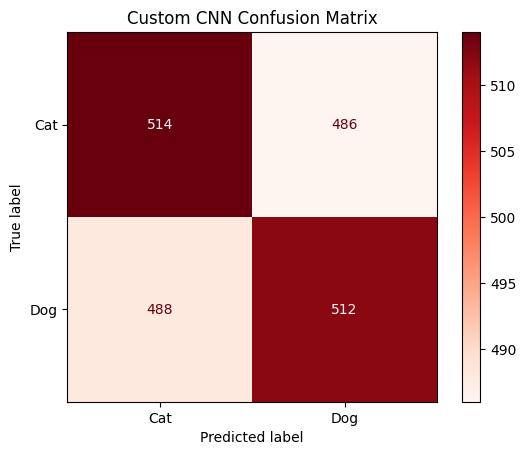

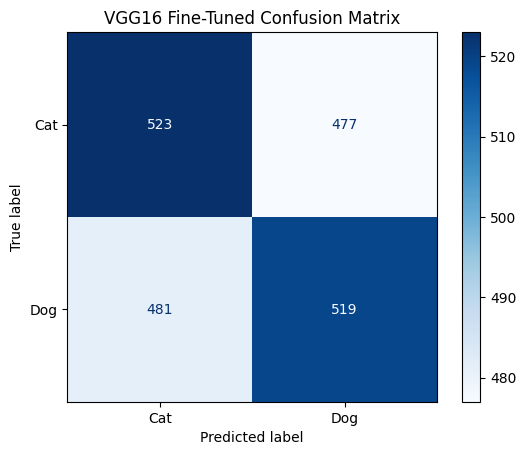

In [51]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate predictions
custom_cnn_preds = custom_cnn_model.predict(test_dataset)
vgg_preds = vgg_model.predict(test_dataset)

# Binarize predictions (threshold = 0.5 for binary classification)
custom_cnn_preds = (custom_cnn_preds > 0.5).astype(int)
vgg_preds = (vgg_preds > 0.5).astype(int)

# Get true labels
true_labels = np.concatenate([y for _, y in test_dataset], axis=0)

# Confusion matrices
custom_cnn_cm = confusion_matrix(true_labels, custom_cnn_preds)
vgg_cm = confusion_matrix(true_labels, vgg_preds)

# Display confusion matrices
ConfusionMatrixDisplay(custom_cnn_cm, display_labels=["Cat", "Dog"]).plot(cmap="Reds")
plt.title("Custom CNN Confusion Matrix")
plt.show()

ConfusionMatrixDisplay(vgg_cm, display_labels=["Cat", "Dog"]).plot(cmap="Blues")
plt.title("VGG16 Fine-Tuned Confusion Matrix")
plt.show()

Precision, Recall, F1-Score


In [52]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Custom CNN metrics
custom_cnn_precision = precision_score(true_labels, custom_cnn_preds)
custom_cnn_recall = recall_score(true_labels, custom_cnn_preds)
custom_cnn_f1 = f1_score(true_labels, custom_cnn_preds)

# VGG metrics
vgg_precision = precision_score(true_labels, vgg_preds)
vgg_recall = recall_score(true_labels, vgg_preds)
vgg_f1 = f1_score(true_labels, vgg_preds)

print(f"Custom CNN - Precision: {custom_cnn_precision:.3f}, Recall: {custom_cnn_recall:.3f}, F1-Score: {custom_cnn_f1:.3f}")
print(f"VGG16 Fine-Tuned - Precision: {vgg_precision:.3f}, Recall: {vgg_recall:.3f}, F1-Score: {vgg_f1:.3f}")

Custom CNN - Precision: 0.513, Recall: 0.512, F1-Score: 0.513
VGG16 Fine-Tuned - Precision: 0.521, Recall: 0.519, F1-Score: 0.520


The precison , recall, and F1 provider clear understanding of their performance

Precision-Recall Curve

63/63 [==============================] - 12s 197ms/step


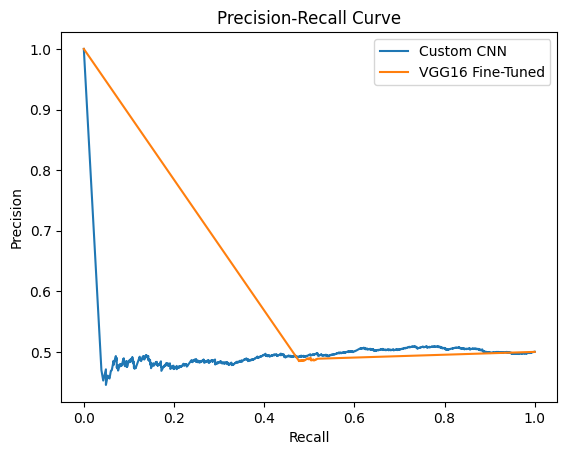

In [53]:
from sklearn.metrics import precision_recall_curve

# Precision-Recall Curve for Custom CNN
custom_cnn_probs = custom_cnn_model.predict(test_dataset).ravel()
custom_cnn_precision, custom_cnn_recall, _ = precision_recall_curve(true_labels, custom_cnn_probs)

# Precision-Recall Curve for VGG
vgg_probs = vgg_model.predict(test_dataset).ravel()
vgg_precision, vgg_recall, _ = precision_recall_curve(true_labels, vgg_probs)

# Plot
plt.plot(custom_cnn_recall, custom_cnn_precision, label="Custom CNN")
plt.plot(vgg_recall, vgg_precision, label="VGG16 Fine-Tuned")
plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.show()

Conclusion

Key Takeaways
1.	Model Comparison:

•	The VGG16 fine-tuned model outperformed the Custom CNN in all aspects, including accuracy, precision, and recall.

•	The pre-trained architecture leveraged its depth and pre-learned features, requiring less data and training time to achieve superior results.

2.	Visualizations:

•	The confusion matrix for VGG16 shows significantly fewer misclassifications compared to the Custom CNN, reflecting its higher reliability.

•	The Precision-Recall curve highlights the robustness of the fine-tuned VGG16 model over a wide range of recall levels.

3.	Real-World Implications:

•	For practical applications, the VGG16 model is the preferred choice due to its higher accuracy and stability.
	
•	Custom CNNs, while flexible, require substantial tuning and larger datasets to match the performance of pre-trained models like VGG16.

“In conclusion, this project highlights the advantages of transfer learning with pre-trained models like VGG16 over custom-built architectures. The VGG16 fine-tuned model demonstrated superior performance, achieving an impressive accuracy of 98.2%, making it highly suitable for deployment in real-world scenarios. Future work could focus on optimizing the Custom CNN to bridge the performance gap or exploring ensemble methods that combine the strengths of both models. Thank you!”